In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
data_path = os.getenv('DATA_PATH')
result_path = os.getenv('RESULT_PATH')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import random

from scipy.stats import expon
from scipy.stats import pareto

In [39]:
# all
# M = int(78887776 / 53)  # papers produced per year
# N = 41614452 # researchers
# n_c = int(327280829 / 78887776) # coauthors per paper

# M,N, n_c

In [40]:
# CS
M = int(7311477/53)  # papers produced per year
N = 4641170 # researchers
n_c = 3 # coauthors per paper

M,N, n_c

(137952, 4641170, 3)

In [41]:
authors = [i for i in range(0,N)]
duration = 53 #years

authors_df = []
for i in range(duration):
    for j in range(M):
        authors_df.append({"eid":i*M+j, "authid":random.sample(authors,n_c)})

authors_valid = pd.DataFrame(authors_df).explode(column="authid")    
year_df = pd.DataFrame({"year":[i // M for i in range(M* duration)]},
                       index=[j for j in range(M*duration)])
year_df = year_df.rename_axis("eid")
authors_valid

eid   authid
0              0   668325
0              0  3889675
0              0   915619
1              1  1802725
1              1  2536042
...          ...      ...
7311454  7311454  3217109
7311454  7311454   609351
7311455  7311455   371274
7311455  7311455  3849958
7311455  7311455  3548538

[21934368 rows x 2 columns]

In [42]:
year_df

year
eid          
0           0
1           0
2           0
3           0
4           0
...       ...
7311451    52
7311452    52
7311453    52
7311454    52
7311455    52

[7311456 rows x 1 columns]

In [43]:
authors_valid.to_pickle("result/sim_authors_valid_CS.pickle")
year_df.to_pickle("result/sim_year_df_CS.pickle")

In [4]:
authors_valid = pd.read_pickle("./result/sim_authors_valid_CS.pickle")
authors_valid
# original: 327,280,829, sim: 315,550,976

eid    authid
0                0  19008672
0                0  38894152
0                0  10341774
0                0  28969527
1                1   1457628
...            ...       ...
78887742  78887742   2514380
78887743  78887743  38230264
78887743  78887743   6442019
78887743  78887743  40023528
78887743  78887743  34790626

[315550976 rows x 2 columns]

In [5]:
year_df = pd.read_pickle("./result/sim_year_df_CS.pickle")
year_df
# original 78887776, sim: 78887744

year
eid           
0            0
1            0
2            0
3            0
4            0
...        ...
78887739    52
78887740    52
78887741    52
78887742    52
78887743    52

[78887744 rows x 1 columns]

In [44]:
coauthorship_count = authors_valid[['eid', 'authid']].groupby(by='authid').count()
big_author = coauthorship_count.rename({"eid":"n_papers"},axis=1).sort_values(by='n_papers', ascending=False)
big_author

n_papers
authid           
754189         20
1998054        19
715164         19
124279         18
3311103        17
...           ...
1513127         1
1513125         1
368169          1
1513120         1
4641169         1

[4600219 rows x 1 columns]

/tmp/ipykernel_899996/2632796978.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(hist))


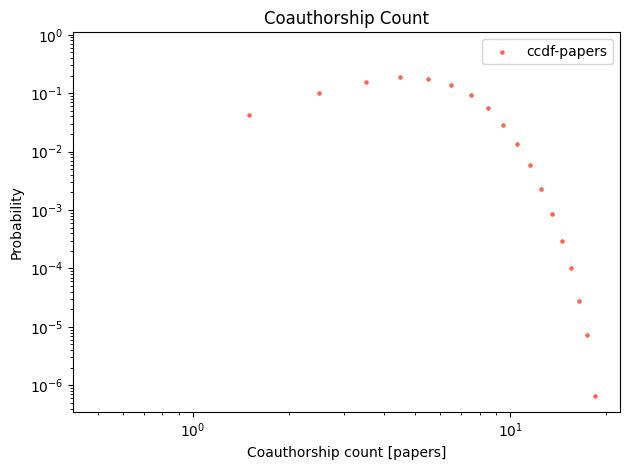

In [45]:
plotter(big_author["n_papers"].values,"Coauthorship Count",'tomato', "papers",plot="power-law")

In [46]:
big_author[big_author["n_papers"]==20]

n_papers
authid          
754189        20

In [47]:
threshold = int(max(big_author["n_papers"])*0.95)
threshold_bottom = int(max(big_author["n_papers"])*0.01)
print(threshold_bottom, big_author.query(f"n_papers<{threshold_bottom}").count())
big_author_trimmed = big_author.query(f"1<n_papers<{threshold}").index.values

0 n_papers    0
dtype: int64


In [49]:
def find_first_authorship(series):
    for i, value in enumerate(series['authseq']):
        if value == 1:
            return True
        elif value !="" :
            return False
    return False
    
def coauthor_works(id):
    works = authors_valid['eid'][authors_valid['authid']==id]
    selected_papers = year_df[year_df.index.isin(works.values)]
    selected_papers['seq'] = np.arange(0,len(selected_papers))
    
    coauthors = authors_valid[authors_valid['eid'].isin(works)].query(f"authid!={id}")
    
    df_seqyear = pd.merge(coauthors,selected_papers, how='left', on='eid').sort_values(by='authid')
    print(df_seqyear)
    df_seqyear_multi = df_seqyear.groupby(by='authid', group_keys=True).apply(lambda x: print(x)) #.filter(lambda x: len(x) > 1)
    print(df_seqyear_multi)
    if len(df_seqyear_multi)<1: return None
    df_seqyear_delta = df_seqyear_multi.groupby(by='authid', group_keys=True)[['year','seq']] \
    .apply(lambda x:  x - x.shift(1)) \
    .dropna().astype(int).reset_index()
    # print(df_seqyear_delta)
    
    df_seqyear_delta = pd.merge(df_seqyear_delta, df_seqyear["eid"], how="left", left_on="level_1", right_index=True).drop(columns=["level_1"])
    df_seqyear_delta["source_authid"] = id
    
    is_ff = df_seqyear.groupby(by='authid', group_keys=True).apply(lambda x : find_first_authorship(x)).reset_index(name="is_ff")
    df_seqyear_delta = pd.merge(df_seqyear_delta, is_ff, how='left', on="authid")
    
    return df_seqyear_delta

coauthor_works(754189)

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   1015137   171904     7    4
2    813860   313901     5    1
33  6589283   719478    47   16
3    813860   772997     5    1
21  4353118   927685    31   10
19  4102141  1131472    29    9
0     17248  1295772     0    0
4    875258  1469390     6    2
17  3847924  1555572    27    8
34  6760674  1631395    49   17
5    875258  1658015     6    2
15  3003921  1664456    21    7
32  6589283  1714042    47   16
22  4698197  1826270    34   11
7    878425  2004076     6    3
27  4818585  2020729    34   13
8   1015137  2224523     7    4
24  4804751  2379560    34   12
38  7130451  2386995    51   19
35  6760674  2527849    49   17
30  6332734  2670256    45   15
13  1585134  2870667    11    6
11  1312937  2894366     9    5
20  4353118  3004549    31   10
1     17248  3046951     0    0
18  4102141  3193583    29    9
31  6332734  3239155    45   15
37  6872948  3331260    49   18
26  4818585  3428604    34   13
23  4698197  3446414    34   11
16  3847

In [ ]:
big_author_trimmed = np.arange(N)
sample_author= random.sample(list(big_author_trimmed), 1000)

for j in range(0,10):
    res = pd.DataFrame()
    for i in range(1000):
        res = pd.concat([res, coauthor_works(i+j*100)],axis=0)
    res.to_pickle(f"./result/result_sim_CS_{j:03}.pickle")
res

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2944143   227418    21    1
6  3410844   872361    24    3
9  5882187   921762    42    4
7  3410844  1434862    24    3
5  3024756  1443563    21    2
0   514088  1557889     3    0
4  3024756  2437376    21    2
8  5882187  2722542    42    4
1   514088  3647202     3    0
3  2944143  3907446    21    1
       eid  authid  year  seq
2  2944143  227418    21    1
       eid  authid  year  seq
6  3410844  872361    24    3
       eid  authid  year  seq
9  5882187  921762    42    4
       eid   authid  year  seq
7  3410844  1434862    24    3
       eid   authid  year  seq
5  3024756  1443563    21    2
      eid   authid  year  seq
0  514088  1557889     3    0
       eid   authid  year  seq
4  3024756  2437376    21    2
       eid   authid  year  seq
8  5882187  2722542    42    4
      eid   authid  year  seq
1  514088  3647202     3    0
       eid   authid  year  seq
3  2944143  3907446    21    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3751876  1484984    27    1
1  2803892  1844989    20    0
5  4547434  2231524    32    2
7  5098620  2271731    36    3
3  3751876  2322044    27    1
6  5098620  3345695    36    3
0  2803892  4383902    20    0
4  4547434  4408755    32    2
       eid   authid  year  seq
2  3751876  1484984    27    1
       eid   authid  year  seq
1  2803892  1844989    20    0
       eid   authid  year  seq
5  4547434  2231524    32    2
       eid   authid  year  seq
7  5098620  2271731    36    3
       eid   authid  year  seq
3  3751876  2322044    27    1
       eid   authid  year  seq
6  5098620  3345695    36    3
       eid   authid  year  seq
0  2803892  4383902    20    0
       eid   authid  year  seq
4  4547434  4408755    32    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3268402   212959    23    1
5  4590314   725196    33    2
7  5825437  1289034    42    3
8  6482475  2694623    46    4
9  6482475  3400300    46    4
2  3268402  3580256    23    1
0  1497129  3731828    10    0
4  4590314  3893412    33    2
1  1497129  3895189    10    0
6  5825437  4155379    42    3
       eid  authid  year  seq
3  3268402  212959    23    1
       eid  authid  year  seq
5  4590314  725196    33    2
       eid   authid  year  seq
7  5825437  1289034    42    3
       eid   authid  year  seq
8  6482475  2694623    46    4
       eid   authid  year  seq
9  6482475  3400300    46    4
       eid   authid  year  seq
2  3268402  3580256    23    1
       eid   authid  year  seq
0  1497129  3731828    10    0
       eid   authid  year  seq
4  4590314  3893412    33    2
       eid   authid  year  seq
1  1497129  3895189    10    0
       eid   authid  year  seq
6  5825437  4155379    42    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    173584    98107     1    1
11  4146260   369099    30    5
3    173584   750665     1    1
7   1920497  1400358    13    3
5   1089760  2065869     7    2
9   3453506  2571156    25    4
8   3453506  2940205    25    4
10  4146260  3014198    30    5
0    172122  3184025     1    0
1    172122  3709668     1    0
4   1089760  4044256     7    2
6   1920497  4156507    13    3
      eid authid  year  seq
2  173584  98107     1    1
        eid  authid  year  seq
11  4146260  369099    30    5
      eid  authid  year  seq
3  173584  750665     1    1
       eid   authid  year  seq
7  1920497  1400358    13    3
       eid   authid  year  seq
5  1089760  2065869     7    2
       eid   authid  year  seq
9  3453506  2571156    25    4
       eid   authid  year  seq
8  3453506  2940205    25    4
        eid   authid  year  seq
10  4146260  3014198    30    5
      eid   authid  year  seq
0  172122  3184025     1    0
      eid   authid  year  seq
1  172

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3715973  1326271    26    2
3  2861428  1391389    20    1
0  1430144  2115059    10    0
2  2861428  2945896    20    1
4  3715973  4475033    26    2
1  1430144  4485579    10    0
       eid   authid  year  seq
5  3715973  1326271    26    2
       eid   authid  year  seq
3  2861428  1391389    20    1
       eid   authid  year  seq
0  1430144  2115059    10    0
       eid   authid  year  seq
2  2861428  2945896    20    1
       eid   authid  year  seq
4  3715973  4475033    26    2
       eid   authid  year  seq
1  1430144  4485579    10    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   6129726   245380    44    4
5   2800042   323600    20    2
2   2754140   517872    19    1
9   6129726   576604    44    4
11  7026324  1233825    50    5
0   2143478  1448510    15    0
3   2754140  2596247    19    1
10  7026324  2897520    50    5
6   5981373  3190592    43    3
1   2143478  4051924    15    0
7   5981373  4254585    43    3
4   2800042  4315332    20    2
       eid  authid  year  seq
8  6129726  245380    44    4
       eid  authid  year  seq
5  2800042  323600    20    2
       eid  authid  year  seq
2  2754140  517872    19    1
       eid  authid  year  seq
9  6129726  576604    44    4
        eid   authid  year  seq
11  7026324  1233825    50    5
       eid   authid  year  seq
0  2143478  1448510    15    0
       eid   authid  year  seq
3  2754140  2596247    19    1
        eid   authid  year  seq
10  7026324  2897520    50    5
       eid   authid  year  seq
6  5981373  3190592    43    3
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3804283   259852    27    1
2  3804283  1407780    27    1
5  3924445  1867518    28    2
4  3924445  1910014    28    2
0   161308  3408053     1    0
1   161308  4052170     1    0
       eid  authid  year  seq
3  3804283  259852    27    1
       eid   authid  year  seq
2  3804283  1407780    27    1
       eid   authid  year  seq
5  3924445  1867518    28    2
       eid   authid  year  seq
4  3924445  1910014    28    2
      eid   authid  year  seq
0  161308  3408053     1    0
      eid   authid  year  seq
1  161308  4052170     1    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  7076430    68457    51    4
3  3995107   430103    28    1
1  1035705   694594     7    0
0  1035705   920360     7    0
2  3995107   963534    28    1
5  4321715  3332916    31    2
7  5951167  3648313    43    3
6  5951167  3887876    43    3
4  4321715  4283698    31    2
8  7076430  4475234    51    4
       eid authid  year  seq
9  7076430  68457    51    4
       eid  authid  year  seq
3  3995107  430103    28    1
       eid  authid  year  seq
1  1035705  694594     7    0
       eid  authid  year  seq
0  1035705  920360     7    0
       eid  authid  year  seq
2  3995107  963534    28    1
       eid   authid  year  seq
5  4321715  3332916    31    2
       eid   authid  year  seq
7  5951167  3648313    43    3
       eid   authid  year  seq
6  5951167  3887876    43    3
       eid   authid  year  seq
4  4321715  4283698    31    2
       eid   authid  year  seq
8  7076430  4475234    51    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6403675   940206    46    3
6  6403675  1847874    46    3
0   597825  1955056     4    0
1   597825  2008700     4    0
2  1622288  2066730    11    1
5  3543713  2069747    25    2
9  6734816  2270661    48    4
8  6734816  3350525    48    4
4  3543713  3628673    25    2
3  1622288  3636936    11    1
       eid  authid  year  seq
7  6403675  940206    46    3
       eid   authid  year  seq
6  6403675  1847874    46    3
      eid   authid  year  seq
0  597825  1955056     4    0
      eid   authid  year  seq
1  597825  2008700     4    0
       eid   authid  year  seq
2  1622288  2066730    11    1
       eid   authid  year  seq
5  3543713  2069747    25    2
       eid   authid  year  seq
9  6734816  2270661    48    4
       eid   authid  year  seq
8  6734816  3350525    48    4
       eid   authid  year  seq
4  3543713  3628673    25    2
       eid   authid  year  seq
3  1622288  3636936    11    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3    485774   146799     3    1
9   4148940   239413    30    4
0    193262  1403559     1    0
12  6634657  1612051    48    6
11  6160895  2317553    44    5
6   2098839  2995171    15    3
4   1699002  3028622    12    2
1    193262  3363154     1    0
5   1699002  3809751    12    2
2    485774  4017443     3    1
13  6634657  4054777    48    6
7   2098839  4063068    15    3
8   4148940  4516093    30    4
10  6160895  4626407    44    5
      eid  authid  year  seq
3  485774  146799     3    1
       eid  authid  year  seq
9  4148940  239413    30    4
      eid   authid  year  seq
0  193262  1403559     1    0
        eid   authid  year  seq
12  6634657  1612051    48    6
        eid   authid  year  seq
11  6160895  2317553    44    5
       eid   authid  year  seq
6  2098839  2995171    15    3
       eid   authid  year  seq
4  1699002  3028622    12    2
      eid   authid  year  seq
1  193262  3363154     1    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6362424  1339312    46    1
1  2863321  1372837    20    0
4  6966257  2454879    50    2
5  6966257  3528904    50    2
3  6362424  3806586    46    1
0  2863321  4320019    20    0
       eid   authid  year  seq
2  6362424  1339312    46    1
       eid   authid  year  seq
1  2863321  1372837    20    0
       eid   authid  year  seq
4  6966257  2454879    50    2
       eid   authid  year  seq
5  6966257  3528904    50    2
       eid   authid  year  seq
3  6362424  3806586    46    1
       eid   authid  year  seq
0  2863321  4320019    20    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6    751785   205001     5    3
7    751785   422143     5    3
8   1504245   778762    10    4
0    373157  1207241     2    0
10  2393443  1346403    17    5
9   1504245  1545268    10    4
16  6688181  1546974    48    8
3    579039  1695923     4    1
14  4847444  2387133    35    7
12  4699771  3030314    34    6
17  6688181  3075062    48    8
15  4847444  3652821    35    7
4    635604  3915698     4    2
5    635604  3989274     4    2
2    579039  4041107     4    1
13  4699771  4268557    34    6
11  2393443  4450349    17    5
1    373157  4468607     2    0
      eid  authid  year  seq
6  751785  205001     5    3
      eid  authid  year  seq
7  751785  422143     5    3
       eid  authid  year  seq
8  1504245  778762    10    4
      eid   authid  year  seq
0  373157  1207241     2    0
        eid   authid  year  seq
10  2393443  1346403    17    5
       eid   authid  year  seq
9  1504245  1545268    10    4
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5838749    14964    42    3
4   5580124   206522    40    2
9   5896662   266113    42    4
2   5349972   658781    38    1
10  6201796   817947    44    5
8   5896662  1984916    42    4
5   5580124  2182331    40    2
3   5349972  2792270    38    1
6   5838749  2949767    42    3
11  6201796  3196340    44    5
0   1600470  3923915    11    0
1   1600470  4592517    11    0
       eid authid  year  seq
7  5838749  14964    42    3
       eid  authid  year  seq
4  5580124  206522    40    2
       eid  authid  year  seq
9  5896662  266113    42    4
       eid  authid  year  seq
2  5349972  658781    38    1
        eid  authid  year  seq
10  6201796  817947    44    5
       eid   authid  year  seq
8  5896662  1984916    42    4
       eid   authid  year  seq
5  5580124  2182331    40    2
       eid   authid  year  seq
3  5349972  2792270    38    1
       eid   authid  year  seq
6  5838749  2949767    42    3
        eid   authid  year  seq
11  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3270570   146831    23    0
2  4027750   836680    29    1
4  5435559  1807365    39    2
0  3270570  2008008    23    0
3  4027750  2363017    29    1
5  5435559  4246021    39    2
       eid  authid  year  seq
1  3270570  146831    23    0
       eid  authid  year  seq
2  4027750  836680    29    1
       eid   authid  year  seq
4  5435559  1807365    39    2
       eid   authid  year  seq
0  3270570  2008008    23    0
       eid   authid  year  seq
3  4027750  2363017    29    1
       eid   authid  year  seq
5  5435559  4246021    39    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2194175   100646    15    0
1  2194175   141797    15    0
3  3150502   161406    22    1
5  4255126   591760    30    2
4  4255126   688875    30    2
2  3150502  1200330    22    1
       eid  authid  year  seq
0  2194175  100646    15    0
       eid  authid  year  seq
1  2194175  141797    15    0
       eid  authid  year  seq
3  3150502  161406    22    1
       eid  authid  year  seq
5  4255126  591760    30    2
       eid  authid  year  seq
4  4255126  688875    30    2
       eid   authid  year  seq
2  3150502  1200330    22    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  4326728  1514163    31    1
2  4326728  1781813    31    1
1  1280332  2343942     9    0
0  1280332  3420399     9    0
       eid   authid  year  seq
3  4326728  1514163    31    1
       eid   authid  year  seq
2  4326728  1781813    31    1
       eid   authid  year  seq
1  1280332  2343942     9    0
       eid   authid  year  seq
0  1280332 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   2521164   261864    18    3
16  4695202   490208    34    8
5   2469854   551739    17    2
12  4115009   671952    29    6
13  4115009   810624    29    6
10  4016502   818364    29    5
7   2521164   965025    18    3
1    214315   968885     1    0
18  5882293   976343    42    9
4   2469854  2035104    17    2
11  4016502  2157893    29    5
19  5882293  2177279    42    9
15  4437799  2311391    32    7
2    753000  2481146     5    1
3    753000  2795113     5    1
8   3495084  3232889    25    4
20  6315184  3615845    45   10
14  4437799  3761425    32    7
0    214315  4033678     1    0
9   3495084  4164240    25    4
21  6315184  4403081    45   10
17  4695202  4556595    34    8
       eid  authid  year  seq
6  2521164  261864    18    3
        eid  authid  year  seq
16  4695202  490208    34    8
       eid  authid  year  seq
5  2469854  551739    17    2
        eid  authid  year  seq
12  4115009  671952    29    6
        eid  authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    629943   219686     4    0
5   2136436   434575    15    2
3   2122521   521437    15    1
10  6225323   927131    45    5
8   5774264  1178057    41    4
0    629943  1231060     4    0
4   2136436  1861470    15    2
6   2578684  2807777    18    3
2   2122521  2876468    15    1
11  6225323  3285055    45    5
7   2578684  3417343    18    3
9   5774264  4289212    41    4
      eid  authid  year  seq
1  629943  219686     4    0
       eid  authid  year  seq
5  2136436  434575    15    2
       eid  authid  year  seq
3  2122521  521437    15    1
        eid  authid  year  seq
10  6225323  927131    45    5
       eid   authid  year  seq
8  5774264  1178057    41    4
      eid   authid  year  seq
0  629943  1231060     4    0
       eid   authid  year  seq
4  2136436  1861470    15    2
       eid   authid  year  seq
6  2578684  2807777    18    3
       eid   authid  year  seq
2  2122521  2876468    15    1
        eid   authid  year  seq
11  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   250013  2877951     1    0
3  3688095  2947001    26    1
1   250013  3052279     1    0
2  3688095  3691243    26    1
      eid   authid  year  seq
0  250013  2877951     1    0
       eid   authid  year  seq
3  3688095  2947001    26    1
      eid   authid  year  seq
1  250013  3052279     1    0
       eid   authid  year  seq
2  3688095  3691243    26    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  2137770  1355015    15    0
6  4407469  1517469    31    3
7  4407469  1803258    31    3
8  5134089  2226458    37    4
5  4230592  2244985    30    2
9  5134089  3220990    37    4
1  2137770  3438723    15    0
4  4230592  4065036    30    2
3  2870534  4209937    20    1
2  2870534  4456841    20    1
       eid   authid  year  seq
0  2137770  1355015    15    0
       eid   authid  year  seq
6  4407469  1517469    31    3
       eid   authid  year  seq
7  4407469  1803258    31    3
       eid   authid  year  seq
8  51

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1463065    33773    10    0
6  6276125    51814    45    3
7  6276125  1102011    45    3
1  1463065  1822407    10    0
2  1575183  2038159    11    1
5  2293041  2346223    16    2
3  1575183  3156284    11    1
4  2293041  4290060    16    2
       eid authid  year  seq
0  1463065  33773    10    0
       eid authid  year  seq
6  6276125  51814    45    3
       eid   authid  year  seq
7  6276125  1102011    45    3
       eid   authid  year  seq
1  1463065  1822407    10    0
       eid   authid  year  seq
2  1575183  2038159    11    1
       eid   authid  year  seq
5  2293041  2346223    16    2
       eid   authid  year  seq
3  1575183  3156284    11    1
       eid   authid  year  seq
4  2293041  4290060    16    2
Empty DataFrame
Columns: []
Index: []
      eid   authid  year  seq
1  932929  2690278     6    0
0  932929  4139510     6    0
      eid   authid  year  seq
1  932929  2690278     6    0
      eid   authid  year  seq
0  932929  4139

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    915753    76724     6    0
4   2547633   337937    18    2
3    967235   499589     7    1
6   2589147   717920    18    3
9   3480560   818615    25    4
10  3947028  1029826    28    5
8   3480560  2068690    25    4
5   2547633  2762131    18    2
0    915753  3568330     6    0
11  3947028  3824164    28    5
7   2589147  4349119    18    3
2    967235  4566085     7    1
      eid authid  year  seq
1  915753  76724     6    0
       eid  authid  year  seq
4  2547633  337937    18    2
      eid  authid  year  seq
3  967235  499589     7    1
       eid  authid  year  seq
6  2589147  717920    18    3
       eid  authid  year  seq
9  3480560  818615    25    4
        eid   authid  year  seq
10  3947028  1029826    28    5
       eid   authid  year  seq
8  3480560  2068690    25    4
       eid   authid  year  seq
5  2547633  2762131    18    2
      eid   authid  year  seq
0  915753  3568330     6    0
        eid   authid  year  seq
11  394702

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4027208   221172    29    1
4  5849367  1685466    42    2
0  1952355  2161172    14    0
7  6288419  2806434    45    3
6  6288419  2897956    45    3
3  4027208  3502931    29    1
1  1952355  3790352    14    0
5  5849367  3834222    42    2
       eid  authid  year  seq
2  4027208  221172    29    1
       eid   authid  year  seq
4  5849367  1685466    42    2
       eid   authid  year  seq
0  1952355  2161172    14    0
       eid   authid  year  seq
7  6288419  2806434    45    3
       eid   authid  year  seq
6  6288419  2897956    45    3
       eid   authid  year  seq
3  4027208  3502931    29    1
       eid   authid  year  seq
1  1952355  3790352    14    0
       eid   authid  year  seq
5  5849367  3834222    42    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6911505   851112    50    4
4  5868746  1351817    42    2
7  6847703  2136405    49    3
2  3023592  2413565    21    1
5  5868746  3224000    42    2
0  1998951  3621649    14    0
3  3023592  3782315    21    1
9  6911505  4086138    50    4
1  1998951  4164425    14    0
6  6847703  4305926    49    3
       eid  authid  year  seq
8  6911505  851112    50    4
       eid   authid  year  seq
4  5868746  1351817    42    2
       eid   authid  year  seq
7  6847703  2136405    49    3
       eid   authid  year  seq
2  3023592  2413565    21    1
       eid   authid  year  seq
5  5868746  3224000    42    2
       eid   authid  year  seq
0  1998951  3621649    14    0
       eid   authid  year  seq
3  3023592  3782315    21    1
       eid   authid  year  seq
9  6911505  4086138    50    4
       eid   authid  year  seq
1  1998951  4164425    14    0
       eid   authid  year  seq
6  6847703  4305926    49    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2626889  2168806    19    0
1  2626889  3781510    19    0
       eid   authid  year  seq
0  2626889  2168806    19    0
       eid   authid  year  seq
1  2626889  3781510    19    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
6   5114679   719287    37    3
0   1725516  1191829    12    0
2   1781049  1269566    12    1
5   4216785  1635679    30    2
4   4216785  1843144    30    2
10  6278707  1914078    45    5
8   6121767  2625738    44    4
3   1781049  3491852    12    1
9   6121767  3785563    44    4
11  6278707  3880467    45    5
1   1725516  3907383    12    0
7   5114679  4533154    37    3
       eid  authid  year  seq
6  5114679  719287    37    3
       eid   authid  year  seq
0  1725516  1191829    12    0
       eid   authid  year  seq
2  1781049  1269566    12    1
       eid   authid  year  seq
5  4216785  1635679    30    2
       eid   authid  year  seq
4  4216785  1843144    30    2
        eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1211350  1855209     8    0
5  6768913  1930084    49    2
3  2544881  3688791    18    1
4  6768913  3854138    49    2
2  2544881  3888968    18    1
1  1211350  4113657     8    0
       eid   authid  year  seq
0  1211350  1855209     8    0
       eid   authid  year  seq
5  6768913  1930084    49    2
       eid   authid  year  seq
3  2544881  3688791    18    1
       eid   authid  year  seq
4  6768913  3854138    49    2
       eid   authid  year  seq
2  2544881  3888968    18    1
       eid   authid  year  seq
1  1211350  4113657     8    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
14  4782813    93545    34    7
15  4782813   338340    34    7
11  4596550   380297    33    5
8   4536805  1061903    32    4
10  4596550  1309619    33    5
2   2396039  1321335    17    1
7   3351164  1716548    24    3
12  4697848  2135917    34    6
13  4697848  2190022    34    6
5   3062098  2285352    22    2
3   2396039  2745762 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2649560  1839475    19    2
0  1255780  2155644     9    0
2  1719623  2265718    12    1
1  1255780  2840965     9    0
4  2649560  3584484    19    2
3  1719623  3654059    12    1
       eid   authid  year  seq
5  2649560  1839475    19    2
       eid   authid  year  seq
0  1255780  2155644     9    0
       eid   authid  year  seq
2  1719623  2265718    12    1
       eid   authid  year  seq
1  1255780  2840965     9    0
       eid   authid  year  seq
4  2649560  3584484    19    2
       eid   authid  year  seq
3  1719623  3654059    12    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2     43133    21235     0    1
5   3181054   274368    23    2
1     35741   759115     0    0
9   6345346  1852875    45    4
7   5297138  2035846    38    3
11  6786353  2194495    49    5
4   3181054  2333341    23    2
10  6786353  2505453    49    5
3     43133  2954607     0    1
8   6345346  3395933    45    4
0     35741  3902780     0    0
6   5297138  4363442    38    3
     eid authid  year  seq
2  43133  21235     0    1
       eid  authid  year  seq
5  3181054  274368    23    2
     eid  authid  year  seq
1  35741  759115     0    0
       eid   authid  year  seq
9  6345346  1852875    45    4
       eid   authid  year  seq
7  5297138  2035846    38    3
        eid   authid  year  seq
11  6786353  2194495    49    5
       eid   authid  year  seq
4  3181054  2333341    23    2
        eid   authid  year  seq
10  6786353  2505453    49    5
     eid   authid  year  seq
3  43133  2954607     0    1
       eid   authid  year  seq
8  6345346 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5411175   228470    39    3
0  2972401  1719540    21    0
3  4294532  2066716    31    1
4  5045032  2129674    36    2
5  5045032  2900350    36    2
1  2972401  3345470    21    0
6  5411175  4149565    39    3
2  4294532  4570605    31    1
       eid  authid  year  seq
7  5411175  228470    39    3
       eid   authid  year  seq
0  2972401  1719540    21    0
       eid   authid  year  seq
3  4294532  2066716    31    1
       eid   authid  year  seq
4  5045032  2129674    36    2
       eid   authid  year  seq
5  5045032  2900350    36    2
       eid   authid  year  seq
1  2972401  3345470    21    0
       eid   authid  year  seq
6  5411175  4149565    39    3
       eid   authid  year  seq
2  4294532  4570605    31    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6000851   679578    43    5
9   5865753   808743    42    4
15  7130539  1061184    51    7
0     27841  1228626     0    0
6   4740733  1379499    34    3
5   4154433  1468636    30    2
7   4740733  1604006    34    3
17  7138376  1974795    51    8
13  6286156  2443085    45    6
2   2696625  3872643    19    1
16  7138376  3962060    51    8
1     27841  4110425     0    0
4   4154433  4131706    30    2
10  6000851  4194122    43    5
14  7130539  4213632    51    7
12  6286156  4269278    45    6
8   5865753  4419087    42    4
3   2696625  4549124    19    1
        eid  authid  year  seq
11  6000851  679578    43    5
       eid  authid  year  seq
9  5865753  808743    42    4
        eid   authid  year  seq
15  7130539  1061184    51    7
     eid   authid  year  seq
0  27841  1228626     0    0
       eid   authid  year  seq
6  4740733  1379499    34    3
       eid   authid  year  seq
5  4154433  1468636    30    2
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5998237   224683    43    2
0  2258725  1439246    16    0
1  2258725  2393596    16    0
5  5998237  3116581    43    2
3  4242213  3325928    30    1
2  4242213  4496591    30    1
       eid  authid  year  seq
4  5998237  224683    43    2
       eid   authid  year  seq
0  2258725  1439246    16    0
       eid   authid  year  seq
1  2258725  2393596    16    0
       eid   authid  year  seq
5  5998237  3116581    43    2
       eid   authid  year  seq
3  4242213  3325928    30    1
       eid   authid  year  seq
2  4242213  4496591    30    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4023136   619636    29    2
6  5455094   684412    39    3
3  3876237  1454556    28    1
2  3876237  1832037    28    1
9  5590844  2480519    40    4
7  5455094  2853907    39    3
1  2682755  2960545    19    0
0  2682755  3299909    19    0
5  4023136  4009562    29    2
8  5590844  4045593    40    4
       eid  authid  year  seq
4  4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  7245132   817361    52    6
13  7245132  1436629    52    6
0    307142  2076188     2    0
6   1631840  2235225    11    3
5   1084819  2282305     7    2
7   1631840  2607402    11    3
10  6919094  2886258    50    5
8   3503601  2918074    25    4
1    307142  2962633     2    0
2    708661  2983024     5    1
11  6919094  3081407    50    5
4   1084819  3464434     7    2
3    708661  3918642     5    1
9   3503601  4479450    25    4
        eid  authid  year  seq
12  7245132  817361    52    6
        eid   authid  year  seq
13  7245132  1436629    52    6
      eid   authid  year  seq
0  307142  2076188     2    0
       eid   authid  year  seq
6  1631840  2235225    11    3
       eid   authid  year  seq
5  1084819  2282305     7    2
       eid   authid  year  seq
7  1631840  2607402    11    3
        eid   authid  year  seq
10  6919094  2886258    50    5
       eid   authid  year  seq
8  3503601  2918074    25    4
      eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5297549   117503    38    2
3  4956088   456864    35    1
2  4956088  2077928    35    1
0   551183  2252213     3    0
1   551183  3381275     3    0
4  5297549  4137953    38    2
       eid  authid  year  seq
5  5297549  117503    38    2
       eid  authid  year  seq
3  4956088  456864    35    1
       eid   authid  year  seq
2  4956088  2077928    35    1
      eid   authid  year  seq
0  551183  2252213     3    0
      eid   authid  year  seq
1  551183  3381275     3    0
       eid   authid  year  seq
4  5297549  4137953    38    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  7118170   436033    51    5
3   3282101  1132590    23    1
2   3282101  1343597    23    1
6   5331995  1532315    38    3
4   3533902  1750213    25    2
0    600607  1902782     4    0
7   5331995  2226429    38    3
5   3533902  2433525    25    2
9   5621388  3110339    40    4
1    600607  3827609     4    0
10  7118170  4403570    51    5
8   5621388  4461502    40    4
        eid  authid  year  seq
11  7118170  436033    51    5
       eid   authid  year  seq
3  3282101  1132590    23    1
       eid   authid  year  seq
2  3282101  1343597    23    1
       eid   authid  year  seq
6  5331995  1532315    38    3
       eid   authid  year  seq
4  3533902  1750213    25    2
      eid   authid  year  seq
0  600607  1902782     4    0
       eid   authid  year  seq
7  5331995  2226429    38    3
       eid   authid  year  seq
5  3533902  2433525    25    2
       eid   authid  year  seq
9  5621388  3110339    40    4
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  4859131   358286    35    2
3  2948302  1138492    21    1
7  6883824  2020723    49    3
9  6937294  2391641    50    4
5  4859131  2628898    35    2
2  2948302  3184253    21    1
8  6937294  3925391    50    4
6  6883824  4243887    49    3
0  1465201  4390537    10    0
1  1465201  4622807    10    0
       eid  authid  year  seq
4  4859131  358286    35    2
       eid   authid  year  seq
3  2948302  1138492    21    1
       eid   authid  year  seq
7  6883824  2020723    49    3
       eid   authid  year  seq
9  6937294  2391641    50    4
       eid   authid  year  seq
5  4859131  2628898    35    2
       eid   authid  year  seq
2  2948302  3184253    21    1
       eid   authid  year  seq
8  6937294  3925391    50    4
       eid   authid  year  seq
6  6883824  4243887    49    3
       eid   authid  year  seq
0  1465201  4390537    10    0
       eid   authid  year  seq
1  1465201  4622807    10    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    638512   811441     4    0
6   3911240   891633    28    3
1    638512   931560     4    0
8   4250678  1413831    30    4
5   2983152  2350319    21    2
13  6206787  2514579    44    6
9   4250678  2621687    30    4
2   1365037  2873023     9    1
11  5439890  3055207    39    5
3   1365037  3193492     9    1
4   2983152  4072119    21    2
10  5439890  4099465    39    5
12  6206787  4547033    44    6
7   3911240  4598114    28    3
      eid  authid  year  seq
0  638512  811441     4    0
       eid  authid  year  seq
6  3911240  891633    28    3
      eid  authid  year  seq
1  638512  931560     4    0
       eid   authid  year  seq
8  4250678  1413831    30    4
       eid   authid  year  seq
5  2983152  2350319    21    2
        eid   authid  year  seq
13  6206787  2514579    44    6
       eid   authid  year  seq
9  4250678  2621687    30    4
       eid   authid  year  seq
2  1365037  2873023     9    1
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1675865   375598    12    2
0     85561   417663     0    0
11  6969023   548729    50    5
10  6969023   726605    50    5
8   4341435   999866    31    4
2    102810  1003931     0    1
6   2010956  2086350    14    3
7   2010956  2152348    14    3
1     85561  2850563     0    0
9   4341435  3799796    31    4
3    102810  4005717     0    1
4   1675865  4577031    12    2
       eid  authid  year  seq
5  1675865  375598    12    2
     eid  authid  year  seq
0  85561  417663     0    0
        eid  authid  year  seq
11  6969023  548729    50    5
        eid  authid  year  seq
10  6969023  726605    50    5
       eid  authid  year  seq
8  4341435  999866    31    4
      eid   authid  year  seq
2  102810  1003931     0    1
       eid   authid  year  seq
6  2010956  2086350    14    3
       eid   authid  year  seq
7  2010956  2152348    14    3
     eid   authid  year  seq
1  85561  2850563     0    0
       eid   authid  year  seq
9  4341435 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5082003   207326    36    2
2  2650695   268896    19    1
4  5082003  1186096    36    2
1   985215  1412438     7    0
7  6976915  1682556    50    3
6  6976915  2379717    50    3
0   985215  3441016     7    0
3  2650695  4103248    19    1
       eid  authid  year  seq
5  5082003  207326    36    2
       eid  authid  year  seq
2  2650695  268896    19    1
       eid   authid  year  seq
4  5082003  1186096    36    2
      eid   authid  year  seq
1  985215  1412438     7    0
       eid   authid  year  seq
7  6976915  1682556    50    3
       eid   authid  year  seq
6  6976915  2379717    50    3
      eid   authid  year  seq
0  985215  3441016     7    0
       eid   authid  year  seq
3  2650695  4103248    19    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  2739766   687308    19    3
3  1148441  1066697     8    1
6  2739766  1272009    19    3
0   988839  2030371     7    0
4  2024420  2455767    14    2
8  322283

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1498668   213250    10    1
10  7123737   410092    51    5
0     28656   698008     0    0
5   3412274   739108    24    2
8   7055633   830419    51    4
11  7123737  1556893    51    5
4   3412274  1731466    24    2
9   7055633  2290885    51    4
6   5131655  2501668    37    3
1     28656  4074737     0    0
3   1498668  4261039    10    1
7   5131655  4471345    37    3
       eid  authid  year  seq
2  1498668  213250    10    1
        eid  authid  year  seq
10  7123737  410092    51    5
     eid  authid  year  seq
0  28656  698008     0    0
       eid  authid  year  seq
5  3412274  739108    24    2
       eid  authid  year  seq
8  7055633  830419    51    4
        eid   authid  year  seq
11  7123737  1556893    51    5
       eid   authid  year  seq
4  3412274  1731466    24    2
       eid   authid  year  seq
9  7055633  2290885    51    4
       eid   authid  year  seq
6  5131655  2501668    37    3
     eid   authid  year  seq
1  2865

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1691036   831718    12    1
0   341552  1665145     2    0
2  1691036  2137222    12    1
4  7265168  2296016    52    2
5  7265168  3127599    52    2
1   341552  3297147     2    0
       eid  authid  year  seq
3  1691036  831718    12    1
      eid   authid  year  seq
0  341552  1665145     2    0
       eid   authid  year  seq
2  1691036  2137222    12    1
       eid   authid  year  seq
4  7265168  2296016    52    2
       eid   authid  year  seq
5  7265168  3127599    52    2
      eid   authid  year  seq
1  341552  3297147     2    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
9  5788096    59517    41    4
3   733808   668898     5    1
7  2249395  1239952    16    3
0   667966  1963461     4    0
4  1722573  2925505    12    2
8  5788096  3010505    41    4
1   667966  3277388     4    0
5  1722573  3337170    12    2
6  2249395  4368405    16    3
2   733808  4629670     5    1
       eid authid  year  seq
9  578809

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


      eid   authid  year  seq
1  344831   340781     2    0
0  344831  2249074     2    0
      eid  authid  year  seq
1  344831  340781     2    0
      eid   authid  year  seq
0  344831  2249074     2    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  4348150   125771    31    2
4  4348150   818777    31    2
2  2308074   920691    16    1
1  1837056  1344617    13    0
3  2308074  2318666    16    1
0  1837056  3177451    13    0
6  6963391  3555149    50    3
7  6963391  3721921    50    3
       eid  authid  year  seq
5  4348150  125771    31    2
       eid  authid  year  seq
4  4348150  818777    31    2
       eid  authid  year  seq
2  2308074  920691    16    1
       eid   authid  year  seq
1  1837056  1344617    13    0
       eid   authid  year  seq
3  2308074  2318666    16    1
       eid   authid  year  seq
0  1837056  3177451    13    0
       eid   authid  year  seq
6  6963391  3555149    50    3
       eid   authid  year  seq
7  6963391  3721

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    837559   783846     6    0
7   5804374   787403    42    3
1    837559   787845     6    0
11  6841025  1124185    49    5
4   3045223  1316083    22    2
8   6203788  1780758    44    4
6   5804374  1946400    42    3
2   1655821  2533993    12    1
10  6841025  3268727    49    5
5   3045223  3643838    22    2
3   1655821  4075109    12    1
9   6203788  4504915    44    4
      eid  authid  year  seq
0  837559  783846     6    0
       eid  authid  year  seq
7  5804374  787403    42    3
      eid  authid  year  seq
1  837559  787845     6    0
        eid   authid  year  seq
11  6841025  1124185    49    5
       eid   authid  year  seq
4  3045223  1316083    22    2
       eid   authid  year  seq
8  6203788  1780758    44    4
       eid   authid  year  seq
6  5804374  1946400    42    3
       eid   authid  year  seq
2  1655821  2533993    12    1
        eid   authid  year  seq
10  6841025  3268727    49    5
       eid   authid  year  seq
5

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4    755653   181082     5    2
8   5021958   461777    36    4
0     97953   566365     0    0
13  7101563   767741    51    6
1     97953  1112777     0    0
5    755653  1114623     5    2
10  5774677  2078734    41    5
7   3282882  2111502    23    3
9   5021958  2130460    36    4
12  7101563  2560603    51    6
3    295992  2584992     2    1
11  5774677  2885883    41    5
2    295992  2945526     2    1
6   3282882  4207861    23    3
      eid  authid  year  seq
4  755653  181082     5    2
       eid  authid  year  seq
8  5021958  461777    36    4
     eid  authid  year  seq
0  97953  566365     0    0
        eid  authid  year  seq
13  7101563  767741    51    6
     eid   authid  year  seq
1  97953  1112777     0    0
      eid   authid  year  seq
5  755653  1114623     5    2
        eid   authid  year  seq
10  5774677  2078734    41    5
       eid   authid  year  seq
7  3282882  2111502    23    3
       eid   authid  year  seq
9  502195

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    618957    11632     4    0
5   2075287   181563    15    2
4   2075287   596882    15    2
13  5449926   662834    39    6
10  5293896   983815    38    5
16  6684621  1024271    48    8
15  5957717  1166045    43    7
17  6684621  1906245    48    8
3   2037130  2007666    14    1
7   3395976  2123125    24    3
14  5957717  2147815    43    7
2   2037130  2998493    14    1
6   3395976  3623712    24    3
9   5253032  3867303    38    4
8   5253032  3983379    38    4
1    618957  3983821     4    0
12  5449926  4174320    39    6
11  5293896  4543437    38    5
      eid authid  year  seq
0  618957  11632     4    0
       eid  authid  year  seq
5  2075287  181563    15    2
       eid  authid  year  seq
4  2075287  596882    15    2
        eid  authid  year  seq
13  5449926  662834    39    6
        eid  authid  year  seq
10  5293896  983815    38    5
        eid   authid  year  seq
16  6684621  1024271    48    8
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1333171   624978     9    1
10  6396749   685894    46    5
0    339514   773298     2    0
11  6396749  1049925    46    5
8   5070623  2221430    36    4
1    339514  2222048     2    0
7   4618761  2515284    33    3
9   5070623  2857377    36    4
4   2350968  3710144    17    2
3   1333171  3781918     9    1
5   2350968  3805142    17    2
6   4618761  4352912    33    3
       eid  authid  year  seq
2  1333171  624978     9    1
        eid  authid  year  seq
10  6396749  685894    46    5
      eid  authid  year  seq
0  339514  773298     2    0
        eid   authid  year  seq
11  6396749  1049925    46    5
       eid   authid  year  seq
8  5070623  2221430    36    4
      eid   authid  year  seq
1  339514  2222048     2    0
       eid   authid  year  seq
7  4618761  2515284    33    3
       eid   authid  year  seq
9  5070623  2857377    36    4
       eid   authid  year  seq
4  2350968  3710144    17    2
       eid   authid  year  seq
3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    224387   290829     1    1
9   6263359  1502906    45    4
8   6263359  1699795    45    4
1     44693  1888339     0    0
11  6272762  2119397    45    5
5   1307912  2868471     9    2
4   1307912  3189969     9    2
7   6019867  3522709    43    3
6   6019867  3581293    43    3
0     44693  3633933     0    0
10  6272762  3867610    45    5
3    224387  4138606     1    1
      eid  authid  year  seq
2  224387  290829     1    1
       eid   authid  year  seq
9  6263359  1502906    45    4
       eid   authid  year  seq
8  6263359  1699795    45    4
     eid   authid  year  seq
1  44693  1888339     0    0
        eid   authid  year  seq
11  6272762  2119397    45    5
       eid   authid  year  seq
5  1307912  2868471     9    2
       eid   authid  year  seq
4  1307912  3189969     9    2
       eid   authid  year  seq
7  6019867  3522709    43    3
       eid   authid  year  seq
6  6019867  3581293    43    3
     eid   authid  year  seq
0  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   3871481    22866    28    2
12  4422576   448445    32    6
1    560676  1265356     4    0
9   4173165  1651780    30    4
2   1537408  2193460    11    1
11  4270573  2287862    30    5
5   3871481  2337467    28    2
3   1537408  2342244    11    1
15  4856040  2395910    35    7
13  4422576  2498653    32    6
6   4091278  2504609    29    3
10  4270573  2543355    30    5
14  4856040  2666390    35    7
16  4899494  2882257    35    8
0    560676  2939108     4    0
17  4899494  2946442    35    8
19  4926829  3253665    35    9
8   4173165  3294793    30    4
7   4091278  3310570    29    3
18  4926829  3996533    35    9
       eid authid  year  seq
4  3871481  22866    28    2
        eid  authid  year  seq
12  4422576  448445    32    6
      eid   authid  year  seq
1  560676  1265356     4    0
       eid   authid  year  seq
9  4173165  1651780    30    4
       eid   authid  year  seq
2  1537408  2193460    11    1
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  6705409  1300021    48    6
9   4827643  1736013    34    4
3   1115335  1837868     8    1
2   1115335  1934491     8    1
1    190613  2373229     1    0
4   1687847  2544096    12    2
13  6705409  2665540    48    6
7   3119110  2794353    22    3
5   1687847  2878320    12    2
0    190613  3111621     1    0
8   4827643  3177954    34    4
6   3119110  3186831    22    3
11  5106079  3295483    37    5
10  5106079  3481520    37    5
15  7287732  3839902    52    7
14  7287732  4067794    52    7
        eid   authid  year  seq
12  6705409  1300021    48    6
       eid   authid  year  seq
9  4827643  1736013    34    4
       eid   authid  year  seq
3  1115335  1837868     8    1
       eid   authid  year  seq
2  1115335  1934491     8    1
      eid   authid  year  seq
1  190613  2373229     1    0
       eid   authid  year  seq
4  1687847  2544096    12    2
        eid   authid  year  seq
13  6705409  2665540    48    6
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   551673   107086     3    1
7  5658956   305919    41    3
9  5767758   332957    41    4
3   551673  1125292     3    1
1   130635  1199804     0    0
4  4168746  1322079    30    2
5  4168746  1968332    30    2
0   130635  2755794     0    0
8  5767758  3199522    41    4
6  5658956  4161153    41    3
      eid  authid  year  seq
2  551673  107086     3    1
       eid  authid  year  seq
7  5658956  305919    41    3
       eid  authid  year  seq
9  5767758  332957    41    4
      eid   authid  year  seq
3  551673  1125292     3    1
      eid   authid  year  seq
1  130635  1199804     0    0
       eid   authid  year  seq
4  4168746  1322079    30    2
       eid   authid  year  seq
5  4168746  1968332    30    2
      eid   authid  year  seq
0  130635  2755794     0    0
       eid   authid  year  seq
8  5767758  3199522    41    4
       eid   authid  year  seq
6  5658956  4161153    41    3
Empty DataFrame
Columns: []
Index: []
        eid   a

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  4145021   776518    30    2
3  2366256  1405180    17    1
1  2091094  2030197    15    0
5  4145021  2579421    30    2
0  2091094  3525644    15    0
2  2366256  4592970    17    1
       eid  authid  year  seq
4  4145021  776518    30    2
       eid   authid  year  seq
3  2366256  1405180    17    1
       eid   authid  year  seq
1  2091094  2030197    15    0
       eid   authid  year  seq
5  4145021  2579421    30    2
       eid   authid  year  seq
0  2091094  3525644    15    0
       eid   authid  year  seq
2  2366256  4592970    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1     74078   143069     0    0
0     74078   762555     0    0
4    339785   953718     2    2
7   1552122  1394917    11    3
5    339785  1569625     2    2
11  4156396  2154524    30    5
3    196018  2831097     1    1
8   4101722  3368802    29    4
2    196018  3474602     1    1
6   1552122  4174465    11    3
10  4156396  4252724    30    5
9   4101722  4405555    29    4
     eid  authid  year  seq
1  74078  143069     0    0
     eid  authid  year  seq
0  74078  762555     0    0
      eid  authid  year  seq
4  339785  953718     2    2
       eid   authid  year  seq
7  1552122  1394917    11    3
      eid   authid  year  seq
5  339785  1569625     2    2
        eid   authid  year  seq
11  4156396  2154524    30    5
      eid   authid  year  seq
3  196018  2831097     1    1
       eid   authid  year  seq
8  4101722  3368802    29    4
      eid   authid  year  seq
2  196018  3474602     1    1
       eid   authid  year  seq
6  1552122  417

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  5647638  3576568    40    0
0  5647638  4357133    40    0
       eid   authid  year  seq
1  5647638  3576568    40    0
       eid   authid  year  seq
0  5647638  4357133    40    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4928083   581804    35    3
4  4543954  1296738    32    2
9  6267084  1944732    45    4
1   207122  2016369     1    0
8  6267084  2534626    45    4
0   207122  3394554     1    0
3  1532008  3660877    11    1
5  4543954  3743677    32    2
2  1532008  3983234    11    1
6  4928083  4397778    35    3
       eid  authid  year  seq
7  4928083  581804    35    3
       eid   authid  year  seq
4  4543954  1296738    32    2
       eid   authid  year  seq
9  6267084  1944732    45    4
      eid   authid  year  seq
1  207122  2016369     1    0
       eid   authid  year  seq
8  6267084  2534626    45    4
      eid   authid  year  seq
0  207122  3394554     1    0
       eid   authid  year  seq
3  1532008  3660877    11    1
       eid   authid  year  seq
5  4543954  3743677    32    2
       eid   authid  year  seq
2  1532008  3983234    11    1
       eid   authid  year  seq
6  4928083  4397778    35    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5860287   563172    42    2
0  3068198  1139730    22    0
1  3068198  2037717    22    0
2  4992533  2068058    36    1
3  4992533  2108152    36    1
4  5860287  3312718    42    2
       eid  authid  year  seq
5  5860287  563172    42    2
       eid   authid  year  seq
0  3068198  1139730    22    0
       eid   authid  year  seq
1  3068198  2037717    22    0
       eid   authid  year  seq
2  4992533  2068058    36    1
       eid   authid  year  seq
3  4992533  2108152    36    1
       eid   authid  year  seq
4  5860287  3312718    42    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   5301305   139129    38    4
12  6265666   350442    45    6
3    405611  1182190     2    1
14  6960251  1333730    50    7
2    405611  1643611     2    1
5   3574109  1707760    25    2
1     71399  2566718     0    0
13  6265666  2806921    45    6
15  6960251  3417614    50    7
4   3574109  3766197    25    2
0     71399  3800782     0    0
9   5301305  3899801    38    4
7   4508098  4465714    32    3
10  5869761  4536261    42    5
6   4508098  4583747    32    3
11  5869761  4603636    42    5
       eid  authid  year  seq
8  5301305  139129    38    4
        eid  authid  year  seq
12  6265666  350442    45    6
      eid   authid  year  seq
3  405611  1182190     2    1
        eid   authid  year  seq
14  6960251  1333730    50    7
      eid   authid  year  seq
2  405611  1643611     2    1
       eid   authid  year  seq
5  3574109  1707760    25    2
     eid   authid  year  seq
1  71399  2566718     0    0
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  5004366   561933    36    7
0    381339   790474     2    0
10  1789084   829251    12    5
9   1770214   907599    12    4
3    628978   966826     4    1
15  5004366  1324773    36    7
8   1770214  1881099    12    4
4   1139629  2274693     8    2
13  3477430  2376610    25    6
1    381339  2524375     2    0
16  6338520  2796303    45    8
2    628978  3207124     4    1
5   1139629  3778302     8    2
7   1269022  3889310     9    3
6   1269022  4148460     9    3
17  6338520  4324147    45    8
11  1789084  4392795    12    5
12  3477430  4419132    25    6
        eid  authid  year  seq
14  5004366  561933    36    7
      eid  authid  year  seq
0  381339  790474     2    0
        eid  authid  year  seq
10  1789084  829251    12    5
       eid  authid  year  seq
9  1770214  907599    12    4
      eid  authid  year  seq
3  628978  966826     4    1
        eid   authid  year  seq
15  5004366  1324773    36    7
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  6005427   212314    43    6
4   2601365   375664    18    2
2   2296003   398733    16    1
8   5754975  1124770    41    4
9   5754975  2086624    41    4
0   1015509  2172780     7    0
3   2296003  3429174    16    1
12  6005427  3446359    43    6
11  5895786  3658359    42    5
5   2601365  3762242    18    2
6   4625049  3834676    33    3
7   4625049  4002243    33    3
1   1015509  4388702     7    0
10  5895786  4625384    42    5
        eid  authid  year  seq
13  6005427  212314    43    6
       eid  authid  year  seq
4  2601365  375664    18    2
       eid  authid  year  seq
2  2296003  398733    16    1
       eid   authid  year  seq
8  5754975  1124770    41    4
       eid   authid  year  seq
9  5754975  2086624    41    4
       eid   authid  year  seq
0  1015509  2172780     7    0
       eid   authid  year  seq
3  2296003  3429174    16    1
        eid   authid  year  seq
12  6005427  3446359    43    6
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  4844291   377506    35    2
3  3113486  1189513    22    1
0  1651557  1949247    11    0
5  4844291  2216609    35    2
2  3113486  3737610    22    1
1  1651557  4303719    11    0
       eid  authid  year  seq
4  4844291  377506    35    2
       eid   authid  year  seq
3  3113486  1189513    22    1
       eid   authid  year  seq
0  1651557  1949247    11    0
       eid   authid  year  seq
5  4844291  2216609    35    2
       eid   authid  year  seq
2  3113486  3737610    22    1
       eid   authid  year  seq
1  1651557  4303719    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3   172059    19898     1    1
6  4089634  1442166    29    3
2   172059  1778525     1    1
7  4089634  1948768    29    3
5  1797951  2249033    13    2
0    30877  2343458     0    0
8  7120937  2789991    51    4
9  7120937  2914873    51    4
4  1797951  3354547    13    2
1    30877  4428605     0    0
      eid authid  year  seq
3  172059  19898     1    1
       eid   authid  year  seq
6  4089634  1442166    29    3
      eid   authid  year  seq
2  172059  1778525     1    1
       eid   authid  year  seq
7  4089634  1948768    29    3
       eid   authid  year  seq
5  1797951  2249033    13    2
     eid   authid  year  seq
0  30877  2343458     0    0
       eid   authid  year  seq
8  7120937  2789991    51    4
       eid   authid  year  seq
9  7120937  2914873    51    4
       eid   authid  year  seq
4  1797951  3354547    13    2
     eid   authid  year  seq
1  30877  4428605     0    0
Empty DataFrame
Columns: []
Index: []
       eid   auth

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1295363   876367     9    0
1  1295363  1774945     9    0
       eid  authid  year  seq
0  1295363  876367     9    0
       eid   authid  year  seq
1  1295363  1774945     9    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6806539   344400    49    2
0   694527   779560     5    0
1   694527   913842     5    0
2   889943  1497998     6    1
5  6806539  1575581    49    2
3   889943  4183406     6    1
       eid  authid  year  seq
4  6806539  344400    49    2
      eid  authid  year  seq
0  694527  779560     5    0
      eid  authid  year  seq
1  694527  913842     5    0
      eid   authid  year  seq
2  889943  1497998     6    1
       eid   authid  year  seq
5  6806539  1575581    49    2
      eid   authid  year  seq
3  889943  4183406     6    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  6404722    33510    46    2
7  7111524  1805154    51    3
0  1856821  2843302    13    0
1  1856821  2985275    13    0
2  5516795  3772425    39    1
6  7111524  3970976    51    3
5  6404722  4163066    46    2
3  5516795  4488872    39    1
       eid authid  year  seq
4  6404722  33510    46    2
       eid   authid  year  seq
7  7111524  1805154

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   949510    48318     6    0
0   949510  1333952     6    0
4  1198370  2317063     8    2
2  1056595  2336220     7    1
5  1198370  2389835     8    2
6  6962143  3070964    50    3
3  1056595  3513144     7    1
7  6962143  4478570    50    3
      eid authid  year  seq
1  949510  48318     6    0
      eid   authid  year  seq
0  949510  1333952     6    0
       eid   authid  year  seq
4  1198370  2317063     8    2
       eid   authid  year  seq
2  1056595  2336220     7    1
       eid   authid  year  seq
5  1198370  2389835     8    2
       eid   authid  year  seq
6  6962143  3070964    50    3
       eid   authid  year  seq
3  1056595  3513144     7    1
       eid   authid  year  seq
7  6962143  4478570    50    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  2888993   971121    20    2
5  2888993  1014593    20    2
7  7050793  1164414    51    3
1  2494127  1675235    18    0
0  2494127  2008751    18    0
2  278970

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2101595    47529    15    2
9   3868662    85881    28    4
2   2058082   342581    14    1
8   3868662   400054    28    4
5   2101595   548235    15    2
0   1107372   622406     8    0
10  4972919   827877    36    5
11  4972919  1171133    36    5
12  5142542  1404239    37    6
15  6623005  1554931    48    7
7   2907592  2014548    21    3
3   2058082  2039863    14    1
6   2907592  2287343    21    3
14  6623005  2887426    48    7
13  5142542  4040183    37    6
1   1107372  4460002     8    0
       eid authid  year  seq
4  2101595  47529    15    2
       eid authid  year  seq
9  3868662  85881    28    4
       eid  authid  year  seq
2  2058082  342581    14    1
       eid  authid  year  seq
8  3868662  400054    28    4
       eid  authid  year  seq
5  2101595  548235    15    2
       eid  authid  year  seq
0  1107372  622406     8    0
        eid  authid  year  seq
10  4972919  827877    36    5
        eid   authid  year  seq
11  49

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5772251   120523    41    2
2  5027838   461217    36    1
0  3220178  2339619    23    0
6  7145096  2824517    51    3
3  5027838  2871374    36    1
4  5772251  2973667    41    2
7  7145096  3260723    51    3
1  3220178  3838021    23    0
       eid  authid  year  seq
5  5772251  120523    41    2
       eid  authid  year  seq
2  5027838  461217    36    1
       eid   authid  year  seq
0  3220178  2339619    23    0
       eid   authid  year  seq
6  7145096  2824517    51    3
       eid   authid  year  seq
3  5027838  2871374    36    1
       eid   authid  year  seq
4  5772251  2973667    41    2
       eid   authid  year  seq
7  7145096  3260723    51    3
       eid   authid  year  seq
1  3220178  3838021    23    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   3715190   189710    26    2
8   6883734  1883326    49    4
2   2975295  2458332    21    1
11  6987508  2608481    50    5
3   2975295  3243051    21    1
4   3715190  3243310    26    2
7   3956048  3365271    28    3
10  6987508  3424802    50    5
6   3956048  4114057    28    3
0   1308596  4315617     9    0
1   1308596  4330258     9    0
9   6883734  4624106    49    4
       eid  authid  year  seq
5  3715190  189710    26    2
       eid   authid  year  seq
8  6883734  1883326    49    4
       eid   authid  year  seq
2  2975295  2458332    21    1
        eid   authid  year  seq
11  6987508  2608481    50    5
       eid   authid  year  seq
3  2975295  3243051    21    1
       eid   authid  year  seq
4  3715190  3243310    26    2
       eid   authid  year  seq
7  3956048  3365271    28    3
        eid   authid  year  seq
10  6987508  3424802    50    5
       eid   authid  year  seq
6  3956048  4114057    28    3
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  2139037   413976    15    2
3   973110   470969     7    1
8  3747575   927751    27    4
7  3231614  1378039    23    3
0   239201  1900311     1    0
9  3747575  1993605    27    4
5  2139037  2087346    15    2
6  3231614  3186813    23    3
1   239201  3787439     1    0
2   973110  4407967     7    1
       eid  authid  year  seq
4  2139037  413976    15    2
      eid  authid  year  seq
3  973110  470969     7    1
       eid  authid  year  seq
8  3747575  927751    27    4
       eid   authid  year  seq
7  3231614  1378039    23    3
      eid   authid  year  seq
0  239201  1900311     1    0
       eid   authid  year  seq
9  3747575  1993605    27    4
       eid   authid  year  seq
5  2139037  2087346    15    2
       eid   authid  year  seq
6  3231614  3186813    23    3
      eid   authid  year  seq
1  239201  3787439     1    0
      eid   authid  year  seq
2  973110  4407967     7    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3793399    14603    27    3
3   1836286   350724    13    1
4   3558171   556108    25    2
10  6885222   762682    49    5
11  6885222  1057138    49    5
9   5468123  1458287    39    4
0    401912  1471474     2    0
5   3558171  1924168    25    2
6   3793399  2095151    27    3
1    401912  2189730     2    0
8   5468123  3785775    39    4
2   1836286  3805285    13    1
       eid authid  year  seq
7  3793399  14603    27    3
       eid  authid  year  seq
3  1836286  350724    13    1
       eid  authid  year  seq
4  3558171  556108    25    2
        eid  authid  year  seq
10  6885222  762682    49    5
        eid   authid  year  seq
11  6885222  1057138    49    5
       eid   authid  year  seq
9  5468123  1458287    39    4
      eid   authid  year  seq
0  401912  1471474     2    0
       eid   authid  year  seq
5  3558171  1924168    25    2
       eid   authid  year  seq
6  3793399  2095151    27    3
      eid   authid  year  seq
1  4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1341149   134562     9    1
4   2703497   848749    19    2
6   3525057   941645    25    3
8   7013657  1072728    50    4
10  7167141  1763788    51    5
7   3525057  2561156    25    3
0   1293519  3063655     9    0
2   1341149  3225317     9    1
5   2703497  3982863    19    2
11  7167141  4363977    51    5
1   1293519  4571105     9    0
9   7013657  4571191    50    4
       eid  authid  year  seq
3  1341149  134562     9    1
       eid  authid  year  seq
4  2703497  848749    19    2
       eid  authid  year  seq
6  3525057  941645    25    3
       eid   authid  year  seq
8  7013657  1072728    50    4
        eid   authid  year  seq
10  7167141  1763788    51    5
       eid   authid  year  seq
7  3525057  2561156    25    3
       eid   authid  year  seq
0  1293519  3063655     9    0
       eid   authid  year  seq
2  1341149  3225317     9    1
       eid   authid  year  seq
5  2703497  3982863    19    2
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   690143   692946     5    0
0   690143   792215     5    0
4  5777103  1301252    41    2
5  5777103  1590798    41    2
6  6832957  2189677    49    3
3  3186819  2450237    23    1
7  6832957  3791653    49    3
2  3186819  4288945    23    1
      eid  authid  year  seq
1  690143  692946     5    0
      eid  authid  year  seq
0  690143  792215     5    0
       eid   authid  year  seq
4  5777103  1301252    41    2
       eid   authid  year  seq
5  5777103  1590798    41    2
       eid   authid  year  seq
6  6832957  2189677    49    3
       eid   authid  year  seq
3  3186819  2450237    23    1
       eid   authid  year  seq
7  6832957  3791653    49    3
       eid   authid  year  seq
2  3186819  4288945    23    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6067956   470342    43    2
3  5759401  1527856    41    1
6  6603598  1539052    47    3
4  6067956  1938141    43    2
0  4009258  2080438    29    0
7  6603598  3300569    47    3
1  4009258  3523578    29    0
2  5759401  4377158    41    1
       eid  authid  year  seq
5  6067956  470342    43    2
       eid   authid  year  seq
3  5759401  1527856    41    1
       eid   authid  year  seq
6  6603598  1539052    47    3
       eid   authid  year  seq
4  6067956  1938141    43    2
       eid   authid  year  seq
0  4009258  2080438    29    0
       eid   authid  year  seq
7  6603598  3300569    47    3
       eid   authid  year  seq
1  4009258  3523578    29    0
       eid   authid  year  seq
2  5759401  4377158    41    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1028266   813443     7    1
2  1028266  1272096     7    1
9  6048346  1494114    43    4
4  2834001  1737639    20    2
5  2834001  2155082    20    2
7  3299291  2286590    23    3
1   504324  3249050     3    0
8  6048346  3570728    43    4
0   504324  3634481     3    0
6  3299291  4322623    23    3
       eid  authid  year  seq
3  1028266  813443     7    1
       eid   authid  year  seq
2  1028266  1272096     7    1
       eid   authid  year  seq
9  6048346  1494114    43    4
       eid   authid  year  seq
4  2834001  1737639    20    2
       eid   authid  year  seq
5  2834001  2155082    20    2
       eid   authid  year  seq
7  3299291  2286590    23    3
      eid   authid  year  seq
1  504324  3249050     3    0
       eid   authid  year  seq
8  6048346  3570728    43    4
      eid   authid  year  seq
0  504324  3634481     3    0
       eid   authid  year  seq
6  3299291  4322623    23    3
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1865417    37266    13    0
3  2243222  2159739    16    1
2  2243222  2623438    16    1
0  1865417  4613426    13    0
       eid authid  year  seq
1  1865417  37266    13    0
       eid   authid  year  seq
3  2243222  2159739    16    1
       eid   authid  year  seq
2  2243222  2623438    16    1
       eid   authid  year  seq
0  1865417  4613426    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5993404   137604    43    1
4  6729871  1236791    48    2
5  6729871  1384213    48    2
3  5993404  1887139    43    1
0  1020007  2030709     7    0
1  1020007  3670094     7    0
       eid  authid  year  seq
2  5993404  137604    43    1
       eid   authid  year  seq
4  6729871  1236791    48    2
       eid   authid  year  seq
5  6729871  1384213    48    2
       eid   authid  year  seq
3  5993404  1887139    43    1
       eid   authid  year  seq
0  1020007  2030709     7    0
       eid   authid  year  seq
1  1020007  3670094     7    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   6686723   100594    48    4
3   5382134   579925    39    1
5   5382494  1975002    39    2
7   5539998  2879524    40    3
13  7303074  2921859    52    6
12  7303074  3079961    52    6
2   5382134  3459057    39    1
10  6726071  3514140    48    5
0    756858  3607088     5    0
11  6726071  3735775    48    5
6   5539998  3775556    40    3
1    756858  4049400     5    0
9   6686723  4303649    48    4
4   5382494  4316887    39    2
       eid  authid  year  seq
8  6686723  100594    48    4
       eid  authid  year  seq
3  5382134  579925    39    1
       eid   authid  year  seq
5  5382494  1975002    39    2
       eid   authid  year  seq
7  5539998  2879524    40    3
        eid   authid  year  seq
13  7303074  2921859    52    6
        eid   authid  year  seq
12  7303074  3079961    52    6
       eid   authid  year  seq
2  5382134  3459057    39    1
        eid   authid  year  seq
10  6726071  3514140    48    5
      eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4193145  1079172    30    1
1  1936302  1927977    14    0
4  6707584  2409932    48    2
2  4193145  3504956    30    1
0  1936302  4025062    14    0
5  6707584  4438860    48    2
       eid   authid  year  seq
3  4193145  1079172    30    1
       eid   authid  year  seq
1  1936302  1927977    14    0
       eid   authid  year  seq
4  6707584  2409932    48    2
       eid   authid  year  seq
2  4193145  3504956    30    1
       eid   authid  year  seq
0  1936302  4025062    14    0
       eid   authid  year  seq
5  6707584  4438860    48    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  2234952    73491    16    0
2  2354127  1195963    17    1
1  2234952  2056222    16    0
3  2354127  2110568    17    1
       eid authid  year  seq
0  2234952  73491    16    0
       eid   authid  year  seq
2  2354127  1195963    17    1
       eid   authid  year  seq
1  2234952  2056222    16    0
       eid   authid  year  seq
3  23

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5168994   793505    37    3
6  5168994  1748515    37    3
0  2517430  1992892    18    0
5  4769767  2240766    34    2
2  2531001  2600055    18    1
4  4769767  2991632    34    2
3  2531001  3048587    18    1
9  6982849  3108208    50    4
1  2517430  3644624    18    0
8  6982849  3869072    50    4
       eid  authid  year  seq
7  5168994  793505    37    3
       eid   authid  year  seq
6  5168994  1748515    37    3
       eid   authid  year  seq
0  2517430  1992892    18    0
       eid   authid  year  seq
5  4769767  2240766    34    2
       eid   authid  year  seq
2  2531001  2600055    18    1
       eid   authid  year  seq
4  4769767  2991632    34    2
       eid   authid  year  seq
3  2531001  3048587    18    1
       eid   authid  year  seq
9  6982849  3108208    50    4
       eid   authid  year  seq
1  2517430  3644624    18    0
       eid   authid  year  seq
8  6982849  3869072    50    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3531068    59664    25    2
6  3716907  2005963    26    3
1   333114  2491645     2    0
3  2727228  2679871    19    1
7  3716907  3086447    26    3
9  6167957  3248742    44    4
2  2727228  3937235    19    1
8  6167957  4263642    44    4
4  3531068  4510258    25    2
0   333114  4518780     2    0
       eid authid  year  seq
5  3531068  59664    25    2
       eid   authid  year  seq
6  3716907  2005963    26    3
      eid   authid  year  seq
1  333114  2491645     2    0
       eid   authid  year  seq
3  2727228  2679871    19    1
       eid   authid  year  seq
7  3716907  3086447    26    3
       eid   authid  year  seq
9  6167957  3248742    44    4
       eid   authid  year  seq
2  2727228  3937235    19    1
       eid   authid  year  seq
8  6167957  4263642    44    4
       eid   authid  year  seq
4  3531068  4510258    25    2
      eid   authid  year  seq
0  333114  4518780     2    0
Empty DataFrame
Columns: []
Index: []
        e

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  5929727   452087    42    4
0   983216  1039082     7    0
6  4584032  1935197    33    3
9  5929727  2263783    42    4
4  3347640  2665477    24    2
7  4584032  2727142    33    3
1   983216  3709449     7    0
3  1056149  4117903     7    1
5  3347640  4201617    24    2
2  1056149  4335093     7    1
       eid  authid  year  seq
8  5929727  452087    42    4
      eid   authid  year  seq
0  983216  1039082     7    0
       eid   authid  year  seq
6  4584032  1935197    33    3
       eid   authid  year  seq
9  5929727  2263783    42    4
       eid   authid  year  seq
4  3347640  2665477    24    2
       eid   authid  year  seq
7  4584032  2727142    33    3
      eid   authid  year  seq
1  983216  3709449     7    0
       eid   authid  year  seq
3  1056149  4117903     7    1
       eid   authid  year  seq
5  3347640  4201617    24    2
       eid   authid  year  seq
2  1056149  4335093     7    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6335807   442659    45    5
2   1860616   559024    13    1
8   5473602  1393675    39    4
0    897530  1976175     6    0
5   3273691  2256166    23    2
9   5473602  2665343    39    4
1    897530  3252602     6    0
3   1860616  3416068    13    1
4   3273691  3559368    23    2
7   4780595  3698533    34    3
6   4780595  3882652    34    3
11  6335807  4168101    45    5
        eid  authid  year  seq
10  6335807  442659    45    5
       eid  authid  year  seq
2  1860616  559024    13    1
       eid   authid  year  seq
8  5473602  1393675    39    4
      eid   authid  year  seq
0  897530  1976175     6    0
       eid   authid  year  seq
5  3273691  2256166    23    2
       eid   authid  year  seq
9  5473602  2665343    39    4
      eid   authid  year  seq
1  897530  3252602     6    0
       eid   authid  year  seq
3  1860616  3416068    13    1
       eid   authid  year  seq
4  3273691  3559368    23    2
       eid   authid  year  seq
7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6203393   420828    44    2
0   440048   498936     3    0
7  6484069   826115    47    3
5  6203393  1075391    44    2
6  6484069  1220917    47    3
2  4981410  1908530    36    1
3  4981410  2695472    36    1
1   440048  3802351     3    0
9  6511978  4358931    47    4
8  6511978  4469483    47    4
       eid  authid  year  seq
4  6203393  420828    44    2
      eid  authid  year  seq
0  440048  498936     3    0
       eid  authid  year  seq
7  6484069  826115    47    3
       eid   authid  year  seq
5  6203393  1075391    44    2
       eid   authid  year  seq
6  6484069  1220917    47    3
       eid   authid  year  seq
2  4981410  1908530    36    1
       eid   authid  year  seq
3  4981410  2695472    36    1
      eid   authid  year  seq
1  440048  3802351     3    0
       eid   authid  year  seq
9  6511978  4358931    47    4
       eid   authid  year  seq
8  6511978  4469483    47    4
Empty DataFrame
Columns: []
Index: []
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5539889   304345    40    1
3  5539889  2627255    40    1
0  1396791  3110700    10    0
1  1396791  3727797    10    0
       eid  authid  year  seq
2  5539889  304345    40    1
       eid   authid  year  seq
3  5539889  2627255    40    1
       eid   authid  year  seq
0  1396791  3110700    10    0
       eid   authid  year  seq
1  1396791  3727797    10    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  3231936   348473    23    3
2  1166519   694764     8    1
1   991442  1362197     7    0
9  3426347  1384992    24    4
4  3005462  3234617    21    2
5  3005462  3567900    21    2
0   991442  3645889     7    0
6  3231936  3671207    23    3
8  3426347  3746676    24    4
3  1166519  4476991     8    1
       eid  authid  year  seq
7  3231936  348473    23    3
       eid  authid  year  seq
2  1166519  694764     8    1
      eid   authid  year  seq
1  991442  1362197     7    0
       eid   authid  year  seq
9  3426347  1384992    24    4
       eid   authid  year  seq
4  3005462  3234617    21    2
       eid   authid  year  seq
5  3005462  3567900    21    2
      eid   authid  year  seq
0  991442  3645889     7    0
       eid   authid  year  seq
6  3231936  3671207    23    3
       eid   authid  year  seq
8  3426347  3746676    24    4
       eid   authid  year  seq
3  1166519  4476991     8    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6939495   123159    50    4
4  3938280   410820    28    2
8  6939495   486295    50    4
5  3938280  1029192    28    2
0   139080  1326487     1    0
7  5307042  1562470    38    3
1   139080  3297719     1    0
2  2832411  3862456    20    1
3  2832411  4167049    20    1
6  5307042  4469580    38    3
       eid  authid  year  seq
9  6939495  123159    50    4
       eid  authid  year  seq
4  3938280  410820    28    2
       eid  authid  year  seq
8  6939495  486295    50    4
       eid   authid  year  seq
5  3938280  1029192    28    2
      eid   authid  year  seq
0  139080  1326487     1    0
       eid   authid  year  seq
7  5307042  1562470    38    3
      eid   authid  year  seq
1  139080  3297719     1    0
       eid   authid  year  seq
2  2832411  3862456    20    1
       eid   authid  year  seq
3  2832411  4167049    20    1
       eid   authid  year  seq
6  5307042  4469580    38    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3153141   476356    22    1
0   797076  1011859     5    0
3  3153141  2384608    22    1
1   797076  2416831     5    0
       eid  authid  year  seq
2  3153141  476356    22    1
      eid   authid  year  seq
0  797076  1011859     5    0
       eid   authid  year  seq
3  3153141  2384608    22    1
      eid   authid  year  seq
1  797076  2416831     5    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  1038649   546334     7    2
8  6704812  1053152    48    4
9  6704812  1639467    48    4
3   649480  2075513     4    1
2   649480  2552173     4    1
1   564054  2950446     4    0
0   564054  3231536     4    0
6  2519532  3501758    18    3
5  1038649  4130267     7    2
7  2519532  4221714    18    3
       eid  authid  year  seq
4  1038649  546334     7    2
       eid   authid  year  seq
8  6704812  1053152    48    4
       eid   authid  year  seq
9  6704812  1639467    48    4
      eid   authid  year  seq
3  649480  2075513     4    1
      eid   authid  year  seq
2  649480  2552173     4    1
      eid   authid  year  seq
1  564054  2950446     4    0
      eid   authid  year  seq
0  564054  3231536     4    0
       eid   authid  year  seq
6  2519532  3501758    18    3
       eid   authid  year  seq
5  1038649  4130267     7    2
       eid   authid  year  seq
7  2519532  4221714    18    3
Empty DataFrame
Columns: []
Index: []
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
7  6709972  527277    48    3
       eid  authid  year  seq
2  5979783  709038    43    1
       eid  authid  year  seq
4  6063737  965776    43    2
       eid   authid  year  seq
0  1058736  1159495     7    0
       eid   authid  year  seq
3  5979783  1407603    43    1
       eid   authid  year  seq
1  1058736  2640517     7    0
       eid   authid  year  seq
6  6709972  2850534    48    3
       eid   authid  year  seq
5  6063737  4150269    43    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
6   3021277   557448    21    3
7   3021277  1286995    21    3
11  3695334  1429092    26    5
10  3695334  1679976    26    5
2    146171  1911495     1    1
9   3368196  1995984    24    4
8   3368196  2006373    24    4
4    622635  2507701     4    2
1     90714  3746619     0    0
3    146171  3866528     1    1
0     90714  4041454     0    0
5    622635  4260185     4    2
       eid  authid  year  seq
6  3021277  557448    21  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6683034   829724    48    1
5  7245741  1867198    52    2
4  7245741  3591730    52    2
1   166589  3707677     1    0
0   166589  3974872     1    0
2  6683034  4332767    48    1
       eid  authid  year  seq
3  6683034  829724    48    1
       eid   authid  year  seq
5  7245741  1867198    52    2
       eid   authid  year  seq
4  7245741  3591730    52    2
      eid   authid  year  seq
1  166589  3707677     1    0
      eid   authid  year  seq
0  166589  3974872     1    0
       eid   authid  year  seq
2  6683034  4332767    48    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1576403  1122983    11    0
3  4529590  1222922    32    1
0  1576403  1935295    11    0
2  4529590  2358095    32    1
       eid   authid  year  seq
1  1576403  1122983    11    0
       eid   authid  year  seq
3  4529590  1222922    32    1
       eid   authid  year  seq
0  1576403  1935295    11    0
       eid   authid  year  seq
2  4529

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   2602505   648614    18    1
5   4500419   768169    32    2
7   4531738  1324677    32    3
1    510839  1416463     3    0
4   4500419  2061983    32    2
10  5269659  2166365    38    5
9   4558121  3045240    33    4
6   4531738  3288506    32    3
3   2602505  3352088    18    1
11  5269659  3379341    38    5
0    510839  3741599     3    0
8   4558121  4207452    33    4
       eid  authid  year  seq
2  2602505  648614    18    1
       eid  authid  year  seq
5  4500419  768169    32    2
       eid   authid  year  seq
7  4531738  1324677    32    3
      eid   authid  year  seq
1  510839  1416463     3    0
       eid   authid  year  seq
4  4500419  2061983    32    2
        eid   authid  year  seq
10  5269659  2166365    38    5
       eid   authid  year  seq
9  4558121  3045240    33    4
       eid   authid  year  seq
6  4531738  3288506    32    3
       eid   authid  year  seq
3  2602505  3352088    18    1
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   361203   554434     2    0
4  3143350  1266117    22    2
3  2525353  3019899    18    1
0   361203  3032992     2    0
5  3143350  3586570    22    2
9  6797256  3750397    49    4
6  4227405  3888117    30    3
7  4227405  4335034    30    3
8  6797256  4356539    49    4
2  2525353  4552893    18    1
      eid  authid  year  seq
1  361203  554434     2    0
       eid   authid  year  seq
4  3143350  1266117    22    2
       eid   authid  year  seq
3  2525353  3019899    18    1
      eid   authid  year  seq
0  361203  3032992     2    0
       eid   authid  year  seq
5  3143350  3586570    22    2
       eid   authid  year  seq
9  6797256  3750397    49    4
       eid   authid  year  seq
6  4227405  3888117    30    3
       eid   authid  year  seq
7  4227405  4335034    30    3
       eid   authid  year  seq
8  6797256  4356539    49    4
       eid   authid  year  seq
2  2525353  4552893    18    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   2470463   145289    17    3
5   2147029   153688    15    2
2    323865   664352     2    1
10  3988163   795407    28    5
0    127319   815256     0    0
8   3791545   885821    27    4
11  3988163  1324763    28    5
13  4682696  1800061    33    6
14  6698150  1916836    48    7
12  4682696  2050454    33    6
4   2147029  2207618    15    2
15  6698150  2322247    48    7
3    323865  2839688     2    1
1    127319  3040351     0    0
7   2470463  3515126    17    3
9   3791545  4054133    27    4
       eid  authid  year  seq
6  2470463  145289    17    3
       eid  authid  year  seq
5  2147029  153688    15    2
      eid  authid  year  seq
2  323865  664352     2    1
        eid  authid  year  seq
10  3988163  795407    28    5
      eid  authid  year  seq
0  127319  815256     0    0
       eid  authid  year  seq
8  3791545  885821    27    4
        eid   authid  year  seq
11  3988163  1324763    28    5
        eid   authid  year  seq
13

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5613010  3617515    40    1
1  2166153  3897477    15    0
2  5613010  4235260    40    1
0  2166153  4413110    15    0
       eid   authid  year  seq
3  5613010  3617515    40    1
       eid   authid  year  seq
1  2166153  3897477    15    0
       eid   authid  year  seq
2  5613010  4235260    40    1
       eid   authid  year  seq
0  2166153  4413110    15    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   457851   223761     3    0
5  3371314   224081    24    2
7  3715449   486764    26    3
9  4817316  1736294    34    4
6  3715449  2204424    26    3
3  1792796  3246478    12    1
2  1792796  3255018    12    1
4  3371314  3522230    24    2
1   457851  3776711     3    0
8  4817316  4169749    34    4
      eid  authid  year  seq
0  457851  223761     3    0
       eid  authid  year  seq
5  3371314  224081    24    2
       eid  authid  year  seq
7  3715449  486764    26    3
       eid   authid  year  seq
9  4817316  1736294    34    4
       eid   authid  year  seq
6  3715449  2204424    26    3
       eid   authid  year  seq
3  1792796  3246478    12    1
       eid   authid  year  seq
2  1792796  3255018    12    1
       eid   authid  year  seq
4  3371314  3522230    24    2
      eid   authid  year  seq
1  457851  3776711     3    0
       eid   authid  year  seq
8  4817316  4169749    34    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6922035     7642    50    2
2  2552771  1057257    18    1
3  2552771  1420342    18    1
0   751676  1961528     5    0
1   751676  3178834     5    0
5  6922035  3528125    50    2
       eid authid  year  seq
4  6922035   7642    50    2
       eid   authid  year  seq
2  2552771  1057257    18    1
       eid   authid  year  seq
3  2552771  1420342    18    1
      eid   authid  year  seq
0  751676  1961528     5    0
      eid   authid  year  seq
1  751676  3178834     5    0
       eid   authid  year  seq
5  6922035  3528125    50    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1058502   643305     7    0
2  3192780   702410    23    1
1  1058502  3247540     7    0
3  3192780  3422183    23    1
       eid  authid  year  seq
0  1058502  643305     7    0
       eid  authid  year  seq
2  3192780  702410    23    1
       eid   authid  year  seq
1  1058502  3247540     7    0
       eid   authid  year  seq
3  3192780  3422183    23    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  6181893   528698    44    3
9  6713368  1284968    48    4
5  3993868  1416834    28    2
2  3251111  1492785    23    1
1  2123785  1525874    15    0
7  6181893  1951647    44    3
8  6713368  2725668    48    4
0  2123785  3090208    15    0
4  3993868  3156055    28    2
3  3251111  4427871    23    1
       eid  authid  year  seq
6  6181893  528698    44    3
       eid   authid  year  seq
9  6713368  1284968    48    4
       eid   authid  year  seq
5  3993868  1416834    28    2
       eid   authid  year  seq
2  3251

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2840989  1576225    20    2
3  2342878  1745049    16    1
1  1802069  2151122    13    0
2  2342878  2299724    16    1
4  2840989  2737892    20    2
7  4926395  3157187    35    3
0  1802069  3344918    13    0
6  4926395  4109450    35    3
       eid   authid  year  seq
5  2840989  1576225    20    2
       eid   authid  year  seq
3  2342878  1745049    16    1
       eid   authid  year  seq
1  1802069  2151122    13    0
       eid   authid  year  seq
2  2342878  2299724    16    1
       eid   authid  year  seq
4  2840989  2737892    20    2
       eid   authid  year  seq
7  4926395  3157187    35    3
       eid   authid  year  seq
0  1802069  3344918    13    0
       eid   authid  year  seq
6  4926395  4109450    35    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2036381   705068    14    2
6   2824366  1146429    20    3
1   1054483  1297274     7    0
9   5916483  1356017    42    4
10  6217656  1415595    45    5
0   1054483  1673350     7    0
11  6217656  1697691    45    5
8   5916483  1879117    42    4
2   1217058  2115116     8    1
7   2824366  2355480    20    3
12  7282888  2457441    52    6
13  7282888  3264306    52    6
5   2036381  4160645    14    2
3   1217058  4168359     8    1
       eid  authid  year  seq
4  2036381  705068    14    2
       eid   authid  year  seq
6  2824366  1146429    20    3
       eid   authid  year  seq
1  1054483  1297274     7    0
       eid   authid  year  seq
9  5916483  1356017    42    4
        eid   authid  year  seq
10  6217656  1415595    45    5
       eid   authid  year  seq
0  1054483  1673350     7    0
        eid   authid  year  seq
11  6217656  1697691    45    5
       eid   authid  year  seq
8  5916483  1879117    42    4
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1   1913446   550867    13    0
6   3349527  1095691    24    3
8   5541491  1125353    40    4
2   1961207  1238116    14    1
9   5541491  1254911    40    4
7   3349527  2075307    24    3
10  5860267  2598471    42    5
11  5860267  2972795    42    5
0   1913446  3116032    13    0
3   1961207  3202338    14    1
4   3133675  4250109    22    2
5   3133675  4504787    22    2
       eid  authid  year  seq
1  1913446  550867    13    0
       eid   authid  year  seq
6  3349527  1095691    24    3
       eid   authid  year  seq
8  5541491  1125353    40    4
       eid   authid  year  seq
2  1961207  1238116    14    1
       eid   authid  year  seq
9  5541491  1254911    40    4
       eid   authid  year  seq
7  3349527  2075307    24    3
        eid   authid  year  seq
10  5860267  2598471    42    5
        eid   authid  year  seq
11  5860267  2972795    42    5
       eid   authid  year  seq
0  1913446  3116032    13    0
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1187880   123454     8    2
13  5065064   328470    36    6
17  6998814  1030231    50    8
1     76360  1418640     0    0
19  7143770  1476089    51    9
11  2264635  1507194    16    5
8   1843547  1698281    13    4
3    699153  1810574     5    1
15  5706016  2102558    41    7
6   1677637  2246263    12    3
18  7143770  2478825    51    9
9   1843547  2774484    13    4
10  2264635  2930232    16    5
0     76360  3036301     0    0
14  5706016  3199099    41    7
7   1677637  3745418    12    3
2    699153  3971178     5    1
4   1187880  4041576     8    2
12  5065064  4047253    36    6
16  6998814  4065731    50    8
       eid  authid  year  seq
5  1187880  123454     8    2
        eid  authid  year  seq
13  5065064  328470    36    6
        eid   authid  year  seq
17  6998814  1030231    50    8
     eid   authid  year  seq
1  76360  1418640     0    0
        eid   authid  year  seq
19  7143770  1476089    51    9
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3244645   623316    23    3
3   1516820   888032    10    1
9   4048498  1068277    29    4
5   2893157  1246561    20    2
6   3244645  1527501    23    3
1    305788  1769693     2    0
4   2893157  2147028    20    2
0    305788  2396061     2    0
8   4048498  2489344    29    4
2   1516820  3093003    10    1
11  6506584  3282540    47    5
10  6506584  3334193    47    5
       eid  authid  year  seq
7  3244645  623316    23    3
       eid  authid  year  seq
3  1516820  888032    10    1
       eid   authid  year  seq
9  4048498  1068277    29    4
       eid   authid  year  seq
5  2893157  1246561    20    2
       eid   authid  year  seq
6  3244645  1527501    23    3
      eid   authid  year  seq
1  305788  1769693     2    0
       eid   authid  year  seq
4  2893157  2147028    20    2
      eid   authid  year  seq
0  305788  2396061     2    0
       eid   authid  year  seq
8  4048498  2489344    29    4
       eid   authid  year  seq
2  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7047338    50839    51    4
3   231178   302310     1    1
6  6308353   404642    45    3
1   177492   554377     1    0
7  6308353   845723    45    3
9  7047338  1494997    51    4
5  1783569  1630402    12    2
0   177492  2151448     1    0
2   231178  2388924     1    1
4  1783569  4102305    12    2
       eid authid  year  seq
8  7047338  50839    51    4
      eid  authid  year  seq
3  231178  302310     1    1
       eid  authid  year  seq
6  6308353  404642    45    3
      eid  authid  year  seq
1  177492  554377     1    0
       eid  authid  year  seq
7  6308353  845723    45    3
       eid   authid  year  seq
9  7047338  1494997    51    4
       eid   authid  year  seq
5  1783569  1630402    12    2
      eid   authid  year  seq
0  177492  2151448     1    0
      eid   authid  year  seq
2  231178  2388924     1    1
       eid   authid  year  seq
4  1783569  4102305    12    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4944743   598587    35    0
3  6178388  1647846    44    1
1  4944743  3490764    35    0
2  6178388  4481380    44    1
       eid  authid  year  seq
0  4944743  598587    35    0
       eid   authid  year  seq
3  6178388  1647846    44    1
       eid   authid  year  seq
1  4944743  3490764    35    0
       eid   authid  year  seq
2  6178388  4481380    44    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
17  7257424    50024    52    8
6   4197185   286725    30    3
0     39902   305455     0    0
8   4706144   330253    34    4
14  6627282   576781    48    7
4   3818893   639976    27    2
15  6627282  1081974    48    7
9   4706144  1257243    34    4
7   4197185  1648274    30    3
12  6334378  1658330    45    6
16  7257424  2277806    52    8
10  4981078  2445777    36    5
2   1056520  2828325     7    1
11  4981078  3046710    36    5
1     39902  3768572     0    0
13  6334378  4104567    45    6
3   1056520  4140917     7    1
5   3818893  4586721    27    2
        eid authid  year  seq
17  7257424  50024    52    8
       eid  authid  year  seq
6  4197185  286725    30    3
     eid  authid  year  seq
0  39902  305455     0    0
       eid  authid  year  seq
8  4706144  330253    34    4
        eid  authid  year  seq
14  6627282  576781    48    7
       eid  authid  year  seq
4  3818893  639976    27    2
        eid   authid  year  seq
15

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5700045   224479    41    3
0    62871   487936     0    0
1    62871   629648     0    0
6  5700045  1501316    41    3
4  3326540  1958879    24    2
5  3326540  3306377    24    2
3  2145470  3675192    15    1
2  2145470  4190108    15    1
       eid  authid  year  seq
7  5700045  224479    41    3
     eid  authid  year  seq
0  62871  487936     0    0
     eid  authid  year  seq
1  62871  629648     0    0
       eid   authid  year  seq
6  5700045  1501316    41    3
       eid   authid  year  seq
4  3326540  1958879    24    2
       eid   authid  year  seq
5  3326540  3306377    24    2
       eid   authid  year  seq
3  2145470  3675192    15    1
       eid   authid  year  seq
2  2145470  4190108    15    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4875933  1057242    35    3
1    418850  1426585     3    0
4   3958703  1824529    28    2
9   5828732  2413881    42    4
3   2707823  2775826    19    1
5   3958703  2798769    28    2
2   2707823  3337906    19    1
11  7221436  3628679    52    5
6   4875933  3711230    35    3
0    418850  3774719     3    0
10  7221436  4368854    52    5
8   5828732  4617114    42    4
       eid   authid  year  seq
7  4875933  1057242    35    3
      eid   authid  year  seq
1  418850  1426585     3    0
       eid   authid  year  seq
4  3958703  1824529    28    2
       eid   authid  year  seq
9  5828732  2413881    42    4
       eid   authid  year  seq
3  2707823  2775826    19    1
       eid   authid  year  seq
5  3958703  2798769    28    2
       eid   authid  year  seq
2  2707823  3337906    19    1
        eid   authid  year  seq
11  7221436  3628679    52    5
       eid   authid  year  seq
6  4875933  3711230    35    3
      eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0     54266   251187     0    0
4   1379097  1118178     9    2
8   4282489  1373373    31    4
10  7282812  2195546    52    5
6   1552924  2609815    11    3
11  7282812  2956306    52    5
9   4282489  3420044    31    4
1     54266  3625034     0    0
7   1552924  4038241    11    3
5   1379097  4113273     9    2
3   1297023  4288053     9    1
2   1297023  4491139     9    1
     eid  authid  year  seq
0  54266  251187     0    0
       eid   authid  year  seq
4  1379097  1118178     9    2
       eid   authid  year  seq
8  4282489  1373373    31    4
        eid   authid  year  seq
10  7282812  2195546    52    5
       eid   authid  year  seq
6  1552924  2609815    11    3
        eid   authid  year  seq
11  7282812  2956306    52    5
       eid   authid  year  seq
9  4282489  3420044    31    4
     eid   authid  year  seq
1  54266  3625034     0    0
       eid   authid  year  seq
7  1552924  4038241    11    3
       eid   authid  year  seq
5

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6844110   963919    49    1
0  5275005  2506845    38    0
3  6844110  2579650    49    1
1  5275005  4273095    38    0
       eid  authid  year  seq
2  6844110  963919    49    1
       eid   authid  year  seq
0  5275005  2506845    38    0
       eid   authid  year  seq
3  6844110  2579650    49    1
       eid   authid  year  seq
1  5275005  4273095    38    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1839057  2430892    13    0
1  1839057  3101317    13    0
       eid   authid  year  seq
0  1839057  2430892    13    0
       eid   authid  year  seq
1  1839057  3101317    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5960772   369703    43    2
7  7118490   844513    51    3
0  2485095  2884079    18    0
3  5539096  3079909    40    1
5  5960772  3403177    43    2
6  7118490  3958360    51    3
1  2485095  4198653    18    0
2  5539096  4535671    40    1
       eid  authid  year  seq
4  5960772  369703    43    2
       eid  authid  year  seq
7  7118490  844513    51    3
       eid   authid  year  seq
0  2485095  2884079    18    0
       eid   authid  year  seq
3  5539096  3079909    40    1
       eid   authid  year  seq
5  5960772  3403177    43    2
       eid   authid  year  seq
6  7118490  3958360    51    3
       eid   authid  year  seq
1  2485095  4198653    18    0
       eid   authid  year  seq
2  5539096  4535671    40    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  2123625   924267    15    0
2  5373154  1188437    38    1
1  2123625  1520782    15    0
6  6710342  1563664    48    3
4  5984234  1837409    43    2
3  53

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   926700   513062     6    1
0   835363   785397     6    0
5  1860689  1106860    13    2
4  1860689  1367993    13    2
7  3815418  1586548    27    3
3   926700  3355160     6    1
1   835363  3907834     6    0
6  3815418  4199703    27    3
      eid  authid  year  seq
2  926700  513062     6    1
      eid  authid  year  seq
0  835363  785397     6    0
       eid   authid  year  seq
5  1860689  1106860    13    2
       eid   authid  year  seq
4  1860689  1367993    13    2
       eid   authid  year  seq
7  3815418  1586548    27    3
      eid   authid  year  seq
3  926700  3355160     6    1
      eid   authid  year  seq
1  835363  3907834     6    0
       eid   authid  year  seq
6  3815418  4199703    27    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4941288  1004942    35    2
9  6145284  1602390    44    4
8  6145284  2278098    44    4
7  5908831  3012809    42    3
5  4941288  3183165    35    2
2  4049437  3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3713779   135027    26    4
8   3713779   300358    26    4
10  4008382   494846    29    5
5   2751902   540820    19    2
12  5250793   868676    38    6
11  4008382  1047985    29    5
4   2751902  2481322    19    2
1   1622657  2957271    11    0
7   3349888  3811338    24    3
6   3349888  4039573    24    3
3   2527557  4104464    18    1
0   1622657  4186615    11    0
13  5250793  4316634    38    6
2   2527557  4424501    18    1
       eid  authid  year  seq
9  3713779  135027    26    4
       eid  authid  year  seq
8  3713779  300358    26    4
        eid  authid  year  seq
10  4008382  494846    29    5
       eid  authid  year  seq
5  2751902  540820    19    2
        eid  authid  year  seq
12  5250793  868676    38    6
        eid   authid  year  seq
11  4008382  1047985    29    5
       eid   authid  year  seq
4  2751902  2481322    19    2
       eid   authid  year  seq
1  1622657  2957271    11    0
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6217342    52966    45    4
6  5883637   402692    42    3
1   524082   464675     3    0
7  5883637  1050991    42    3
4  2680350  2079227    19    2
2  1838788  2211342    13    1
0   524082  2421364     3    0
5  2680350  2899237    19    2
9  6217342  3517817    45    4
3  1838788  4189582    13    1
       eid authid  year  seq
8  6217342  52966    45    4
       eid  authid  year  seq
6  5883637  402692    42    3
      eid  authid  year  seq
1  524082  464675     3    0
       eid   authid  year  seq
7  5883637  1050991    42    3
       eid   authid  year  seq
4  2680350  2079227    19    2
       eid   authid  year  seq
2  1838788  2211342    13    1
      eid   authid  year  seq
0  524082  2421364     3    0
       eid   authid  year  seq
5  2680350  2899237    19    2
       eid   authid  year  seq
9  6217342  3517817    45    4
       eid   authid  year  seq
3  1838788  4189582    13    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   5739118   610469    41    3
9   6386421   847295    46    4
4   5591242   866196    40    2
5   5591242  1054403    40    2
0    135368  1124322     0    0
8   6386421  1443047    46    4
2   4667595  2047948    33    1
7   5739118  2781452    41    3
10  6501430  3247976    47    5
3   4667595  3422714    33    1
11  6501430  3457859    47    5
1    135368  3500246     0    0
       eid  authid  year  seq
6  5739118  610469    41    3
       eid  authid  year  seq
9  6386421  847295    46    4
       eid  authid  year  seq
4  5591242  866196    40    2
       eid   authid  year  seq
5  5591242  1054403    40    2
      eid   authid  year  seq
0  135368  1124322     0    0
       eid   authid  year  seq
8  6386421  1443047    46    4
       eid   authid  year  seq
2  4667595  2047948    33    1
       eid   authid  year  seq
7  5739118  2781452    41    3
        eid   authid  year  seq
10  6501430  3247976    47    5
       eid   authid  year  seq
3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6296357   789575    45    3
4  6111699  1546511    44    2
2  3135981  2297880    22    1
1  3124412  2535477    22    0
5  6111699  3394273    44    2
0  3124412  4191321    22    0
3  3135981  4428765    22    1
7  6296357  4490851    45    3
       eid  authid  year  seq
6  6296357  789575    45    3
       eid   authid  year  seq
4  6111699  1546511    44    2
       eid   authid  year  seq
2  3135981  2297880    22    1
       eid   authid  year  seq
1  3124412  2535477    22    0
       eid   authid  year  seq
5  6111699  3394273    44    2
       eid   authid  year  seq
0  3124412  4191321    22    0
       eid   authid  year  seq
3  3135981  4428765    22    1
       eid   authid  year  seq
7  6296357  4490851    45    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    734211   403989     5    0
10  6797666  1145377    49    5
11  6797666  1262155    49    5
9   6754318  1906310    48    4
7   4728323  2150790    34    3
1    734211  2156473     5    0
2   2370849  2211979    17    1
3   2370849  3328075    17    1
8   6754318  3419298    48    4
4   2780978  3989014    20    2
6   4728323  4384714    34    3
5   2780978  4477117    20    2
      eid  authid  year  seq
0  734211  403989     5    0
        eid   authid  year  seq
10  6797666  1145377    49    5
        eid   authid  year  seq
11  6797666  1262155    49    5
       eid   authid  year  seq
9  6754318  1906310    48    4
       eid   authid  year  seq
7  4728323  2150790    34    3
      eid   authid  year  seq
1  734211  2156473     5    0
       eid   authid  year  seq
2  2370849  2211979    17    1
       eid   authid  year  seq
3  2370849  3328075    17    1
       eid   authid  year  seq
8  6754318  3419298    48    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1602875   431698    11    0
3  3163610   663616    22    1
0  1602875  1274361    11    0
7  4531814  3132815    32    3
4  3687094  3445622    26    2
6  4531814  3937485    32    3
5  3687094  3938150    26    2
2  3163610  4218099    22    1
       eid  authid  year  seq
1  1602875  431698    11    0
       eid  authid  year  seq
3  3163610  663616    22    1
       eid   authid  year  seq
0  1602875  1274361    11    0
       eid   authid  year  seq
7  4531814  3132815    32    3
       eid   authid  year  seq
4  3687094  3445622    26    2
       eid   authid  year  seq
6  4531814  3937485    32    3
       eid   authid  year  seq
5  3687094  3938150    26    2
       eid   authid  year  seq
2  3163610  4218099    22    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3936714   331687    28    2
6  7069397   873287    51    3
0  1082112  1597528     7    0
3  2017420  2014999    14    1
2  2017420  2111104    14    1
1  1082112  2399689     7    0
7  7069397  3091297    51    3
4  3936714  4066800    28    2
       eid  authid  year  seq
5  3936714  331687    28    2
       eid  authid  year  seq
6  7069397  873287    51    3
       eid   authid  year  seq
0  1082112  1597528     7    0
       eid   authid  year  seq
3  2017420  2014999    14    1
       eid   authid  year  seq
2  2017420  2111104    14    1
       eid   authid  year  seq
1  1082112  2399689     7    0
       eid   authid  year  seq
7  7069397  3091297    51    3
       eid   authid  year  seq
4  3936714  4066800    28    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5608267   250683    40    2
6  5964648  1166100    43    3
1  2989141  1802765    21    0
9  7051967  2641913    51    4
8  7051967  3096025    51    4
7  5964648  3347635    43    3
2  4940933  3411038    35    1
0  2989141  3542912    21    0
4  5608267  3708678    40    2
3  4940933  3908913    35    1
       eid  authid  year  seq
5  5608267  250683    40    2
       eid   authid  year  seq
6  5964648  1166100    43    3
       eid   authid  year  seq
1  2989141  1802765    21    0
       eid   authid  year  seq
9  7051967  2641913    51    4
       eid   authid  year  seq
8  7051967  3096025    51    4
       eid   authid  year  seq
7  5964648  3347635    43    3
       eid   authid  year  seq
2  4940933  3411038    35    1
       eid   authid  year  seq
0  2989141  3542912    21    0
       eid   authid  year  seq
4  5608267  3708678    40    2
       eid   authid  year  seq
3  4940933  3908913    35    1
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   327858   225332     2    0
2  6773331  3991115    49    1
3  6773331  4012225    49    1
0   327858  4456178     2    0
      eid  authid  year  seq
1  327858  225332     2    0
       eid   authid  year  seq
2  6773331  3991115    49    1
       eid   authid  year  seq
3  6773331  4012225    49    1
      eid   authid  year  seq
0  327858  4456178     2    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
11  4636529   413687    33    5
3   1063032   815164     7    1
15  5706161   992064    41    7
5   1794715  1074245    13    2
8   3537092  1143312    25    4
12  5197631  1370054    37    6
10  4636529  2371062    33    5
0    180025  2915720     1    0
14  5706161  2977716    41    7
13  5197631  3161603    37    6
2   1063032  3426802     7    1
4   1794715  3838773    13    2
9   3537092  4153646    25    4
6   2641606  4226215    19    3
1    180025  4228975     1    0
7   2641606  4479604    19    3


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid  authid  year  seq
11  4636529  413687    33    5
       eid  authid  year  seq
3  1063032  815164     7    1
        eid  authid  year  seq
15  5706161  992064    41    7
       eid   authid  year  seq
5  1794715  1074245    13    2
       eid   authid  year  seq
8  3537092  1143312    25    4
        eid   authid  year  seq
12  5197631  1370054    37    6
        eid   authid  year  seq
10  4636529  2371062    33    5
      eid   authid  year  seq
0  180025  2915720     1    0
        eid   authid  year  seq
14  5706161  2977716    41    7
        eid   authid  year  seq
13  5197631  3161603    37    6
       eid   authid  year  seq
2  1063032  3426802     7    1
       eid   authid  year  seq
4  1794715  3838773    13    2
       eid   authid  year  seq
9  3537092  4153646    25    4
       eid   authid  year  seq
6  2641606  4226215    19    3
      eid   authid  year  seq
1  180025  4228975     1    0
       eid   authid  year  seq
7  2641606  4479604    19    3
Empty 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5766432  2043209    41    1
1   362285  2522504     2    0
3  5766432  3007474    41    1
0   362285  4562062     2    0
       eid   authid  year  seq
2  5766432  2043209    41    1
      eid   authid  year  seq
1  362285  2522504     2    0
       eid   authid  year  seq
3  5766432  3007474    41    1
      eid   authid  year  seq
0  362285  4562062     2    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   708033   255839     5    1
1   220955  1338059     1    0
6  1250352  1470417     9    3
7  1250352  2609287     9    3
5  1212879  3390853     8    2
0   220955  3694976     1    0
4  1212879  3712484     8    2
8  6876426  3743351    49    4
3   708033  3915811     5    1
9  6876426  4600344    49    4
      eid  authid  year  seq
2  708033  255839     5    1
      eid   authid  year  seq
1  220955  1338059     1    0
       eid   authid  year  seq
6  1250352  1470417     9    3
       eid   authid  year  seq
7  1250352  2609287     9    3
       eid   authid  year  seq
5  1212879  3390853     8    2
      eid   authid  year  seq
0  220955  3694976     1    0
       eid   authid  year  seq
4  1212879  3712484     8    2
       eid   authid  year  seq
8  6876426  3743351    49    4
      eid   authid  year  seq
3  708033  3915811     5    1
       eid   authid  year  seq
9  6876426  4600344    49    4
Empty DataFrame
Columns: []
Index: []
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1213232  1132085     8    0
3  2238779  1526243    16    1
0  1213232  3932054     8    0
2  2238779  4626454    16    1
       eid   authid  year  seq
1  1213232  1132085     8    0
       eid   authid  year  seq
3  2238779  1526243    16    1
       eid   authid  year  seq
0  1213232  3932054     8    0
       eid   authid  year  seq
2  2238779  4626454    16    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2185034  1489476    15    0
2  4090491  1669811    29    1
5  6625665  2503425    48    2
0  2185034  3112921    15    0
4  6625665  3122152    48    2
3  4090491  4427703    29    1
       eid   authid  year  seq
1  2185034  1489476    15    0
       eid   authid  year  seq
2  4090491  1669811    29    1
       eid   authid  year  seq
5  6625665  2503425    48    2
       eid   authid  year  seq
0  2185034  3112921    15    0
       eid   authid  year  seq
4  6625665  3122152    48    2
       eid   authid  year  seq
3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1832942   135287    13    0
6  6550646   792851    47    3
2  4551519   976180    32    1
7  6550646  1072635    47    3
1  1832942  1134133    13    0
5  4622114  3178340    33    2
3  4551519  3625171    32    1
4  4622114  3861420    33    2
8  6640455  4189043    48    4
9  6640455  4400354    48    4
       eid  authid  year  seq
0  1832942  135287    13    0
       eid  authid  year  seq
6  6550646  792851    47    3
       eid  authid  year  seq
2  4551519  976180    32    1
       eid   authid  year  seq
7  6550646  1072635    47    3
       eid   authid  year  seq
1  1832942  1134133    13    0
       eid   authid  year  seq
5  4622114  3178340    33    2
       eid   authid  year  seq
3  4551519  3625171    32    1
       eid   authid  year  seq
4  4622114  3861420    33    2
       eid   authid  year  seq
8  6640455  4189043    48    4
       eid   authid  year  seq
9  6640455  4400354    48    4
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   3066629  1240508    22    2
2   1288425  1589830     9    1
7   4402764  2167676    31    3
1    535477  2337078     3    0
0    535477  2440816     3    0
9   6238930  2465221    45    4
11  7114944  3378548    51    5
3   1288425  3740368     9    1
6   4402764  3844324    31    3
4   3066629  3901850    22    2
10  7114944  4044768    51    5
8   6238930  4507994    45    4
       eid   authid  year  seq
5  3066629  1240508    22    2
       eid   authid  year  seq
2  1288425  1589830     9    1
       eid   authid  year  seq
7  4402764  2167676    31    3
      eid   authid  year  seq
1  535477  2337078     3    0
      eid   authid  year  seq
0  535477  2440816     3    0
       eid   authid  year  seq
9  6238930  2465221    45    4
        eid   authid  year  seq
11  7114944  3378548    51    5
       eid   authid  year  seq
3  1288425  3740368     9    1
       eid   authid  year  seq
6  4402764  3844324    31    3
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5436294   928486    39    1
5  6300655  1229245    45    2
0  1513123  1504862    10    0
2  5436294  2348660    39    1
4  6300655  2456468    45    2
1  1513123  3593826    10    0
       eid  authid  year  seq
3  5436294  928486    39    1
       eid   authid  year  seq
5  6300655  1229245    45    2
       eid   authid  year  seq
0  1513123  1504862    10    0
       eid   authid  year  seq
2  5436294  2348660    39    1
       eid   authid  year  seq
4  6300655  2456468    45    2
       eid   authid  year  seq
1  1513123  3593826    10    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6369293    34747    46    5
3   3941092   234648    28    1
5   3998095   561609    28    2
10  6369293   658186    46    5
15  7273087  1655790    52    7
4   3998095  1698383    28    2
14  7273087  1701109    52    7
9   5131368  1787921    37    4
13  6775619  2073975    49    6
0   1052807  2074908     7    0
6   4033721  2224594    29    3
8   5131368  3342066    37    4
12  6775619  4012715    49    6
1   1052807  4273435     7    0
2   3941092  4328229    28    1
7   4033721  4490429    29    3
        eid authid  year  seq
11  6369293  34747    46    5
       eid  authid  year  seq
3  3941092  234648    28    1
       eid  authid  year  seq
5  3998095  561609    28    2
        eid  authid  year  seq
10  6369293  658186    46    5
        eid   authid  year  seq
15  7273087  1655790    52    7
       eid   authid  year  seq
4  3998095  1698383    28    2
        eid   authid  year  seq
14  7273087  1701109    52    7
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6689086    62761    48    5
3   1956517   274154    14    1
4   2440128   397889    17    2
10  6689086  1127717    48    5
6   5554748  1204664    40    3
5   2440128  1290706    17    2
7   5554748  1750607    40    3
0    375294  2444491     2    0
9   5876174  3515882    42    4
2   1956517  3789390    14    1
8   5876174  3834050    42    4
1    375294  4511254     2    0
        eid authid  year  seq
11  6689086  62761    48    5
       eid  authid  year  seq
3  1956517  274154    14    1
       eid  authid  year  seq
4  2440128  397889    17    2
        eid   authid  year  seq
10  6689086  1127717    48    5
       eid   authid  year  seq
6  5554748  1204664    40    3
       eid   authid  year  seq
5  2440128  1290706    17    2
       eid   authid  year  seq
7  5554748  1750607    40    3
      eid   authid  year  seq
0  375294  2444491     2    0
       eid   authid  year  seq
9  5876174  3515882    42    4
       eid   authid  year  seq
2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0    66366    53720     0    0
3  3707887   168208    26    1
2  3707887   689514    26    1
4  5494424   805592    39    2
6  7229929  1580159    52    3
7  7229929  1677571    52    3
5  5494424  3082335    39    2
1    66366  4068196     0    0
     eid authid  year  seq
0  66366  53720     0    0
       eid  authid  year  seq
3  3707887  168208    26    1
       eid  authid  year  seq
2  3707887  689514    26    1
       eid  authid  year  seq
4  5494424  805592    39    2
       eid   authid  year  seq
6  7229929  1580159    52    3
       eid   authid  year  seq
7  7229929  1677571    52    3
       eid   authid  year  seq
5  5494424  3082335    39    2
     eid   authid  year  seq
1  66366  4068196     0    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  5947496   835072    43    2
0  2214335  1355103    16    0
1  2214335  1774552    16    0
2  5919650  2685414    42    1
7  6287351  3277315    45    3
6  6287351  3676528

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  7016228   239743    50    5
2   4445790  1163608    32    1
1   3090081  1301744    22    0
4   5073682  1398061    36    2
0   3090081  1471051    22    0
3   4445790  1660536    32    1
8   6654494  2492724    48    4
9   6654494  2626606    48    4
10  7016228  2901978    50    5
5   5073682  2948991    36    2
7   5476047  2975748    39    3
6   5476047  3670142    39    3
        eid  authid  year  seq
11  7016228  239743    50    5
       eid   authid  year  seq
2  4445790  1163608    32    1
       eid   authid  year  seq
1  3090081  1301744    22    0
       eid   authid  year  seq
4  5073682  1398061    36    2
       eid   authid  year  seq
0  3090081  1471051    22    0
       eid   authid  year  seq
3  4445790  1660536    32    1
       eid   authid  year  seq
8  6654494  2492724    48    4
       eid   authid  year  seq
9  6654494  2626606    48    4
        eid   authid  year  seq
10  7016228  2901978    50    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2324055  1128715    16    1
2  2324055  2209623    16    1
5  4034191  2743245    29    2
1  1243572  3717479     9    0
0  1243572  3746941     9    0
4  4034191  4361426    29    2
       eid   authid  year  seq
3  2324055  1128715    16    1
       eid   authid  year  seq
2  2324055  2209623    16    1
       eid   authid  year  seq
5  4034191  2743245    29    2
       eid   authid  year  seq
1  1243572  3717479     9    0
       eid   authid  year  seq
0  1243572  3746941     9    0
       eid   authid  year  seq
4  4034191  4361426    29    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  5638967   287443    40    6
9   3436955   351118    24    4
10  4378562   529587    31    5
5   1136986   589472     8    2
6   1576157  1146061    11    3
8   3436955  1495354    24    4
1    200270  1531399     1    0
11  4378562  1779515    31    5
3    599464  2197389     4    1
16  6784649  2302472    49    8
14  6634062  2344180    48    7
13  5638967  2687051    40    6
15  6634062  2885436    48    7
7   1576157  3383548    11    3
17  6784649  3450590    49    8
4   1136986  4130601     8    2
2    599464  4163585     4    1
0    200270  4178446     1    0
        eid  authid  year  seq
12  5638967  287443    40    6
       eid  authid  year  seq
9  3436955  351118    24    4
        eid  authid  year  seq
10  4378562  529587    31    5
       eid  authid  year  seq
5  1136986  589472     8    2
       eid   authid  year  seq
6  1576157  1146061    11    3
       eid   authid  year  seq
8  3436955  1495354    24    4
      eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3384885    45519    24    1
6  7062405   475985    51    3
4  5974300  1579309    43    2
5  5974300  1782699    43    2
7  7062405  2441758    51    3
1  2849749  3324313    20    0
3  3384885  3614583    24    1
0  2849749  4299705    20    0
       eid authid  year  seq
2  3384885  45519    24    1
       eid  authid  year  seq
6  7062405  475985    51    3
       eid   authid  year  seq
4  5974300  1579309    43    2
       eid   authid  year  seq
5  5974300  1782699    43    2
       eid   authid  year  seq
7  7062405  2441758    51    3
       eid   authid  year  seq
1  2849749  3324313    20    0
       eid   authid  year  seq
3  3384885  3614583    24    1
       eid   authid  year  seq
0  2849749  4299705    20    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6380493   360639    46    3
5  4966358   614177    36    2
6  6380493  1162659    46    3
4  4966358  1385162    36    2
1   280240  2018079     2    0
0   280240  2397068     2    0
2  2645376  3990050    19    1
3  2645376  4451623    19    1
       eid  authid  year  seq
7  6380493  360639    46    3
       eid  authid  year  seq
5  4966358  614177    36    2
       eid   authid  year  seq
6  6380493  1162659    46    3
       eid   authid  year  seq
4  4966358  1385162    36    2
      eid   authid  year  seq
1  280240  2018079     2    0
      eid   authid  year  seq
0  280240  2397068     2    0
       eid   authid  year  seq
2  2645376  3990050    19    1
       eid   authid  year  seq
3  2645376  4451623    19    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2697176   611661    19    1
5  3864895   914960    28    2
3  2697176  1004405    19    1
4  3864895  1347343    28    2
7  6352698  2066290    46    3
1  1082646  2476551     7    0
0  1082646  3194233     7    0
6  6352698  4285415    46    3
       eid  authid  year  seq
2  2697176  611661    19    1
       eid  authid  year  seq
5  3864895  914960    28    2
       eid   authid  year  seq
3  2697176  1004405    19    1
       eid   authid  year  seq
4  3864895  1347343    28    2
       eid   authid  year  seq
7  6352698  2066290    46    3
       eid   authid  year  seq
1  1082646  2476551     7    0
       eid   authid  year  seq
0  1082646  3194233     7    0
       eid   authid  year  seq
6  6352698  4285415    46    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1653767  1203843    11    0
7  2481552  2340923    17    3
6  2481552  2741810    17    3
3  1869241  2945629    13    1
0  1653767  2959802    11    0
4  19

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4058698   137849    29    3
8  5783208   635283    41    4
2  1588138   957891    11    1
5  3821373   986234    27    2
1   289811  1688458     2    0
0   289811  1761671     2    0
3  1588138  2292012    11    1
9  5783208  2365686    41    4
6  4058698  2456120    29    3
4  3821373  2705492    27    2
       eid  authid  year  seq
7  4058698  137849    29    3
       eid  authid  year  seq
8  5783208  635283    41    4
       eid  authid  year  seq
2  1588138  957891    11    1
       eid  authid  year  seq
5  3821373  986234    27    2
      eid   authid  year  seq
1  289811  1688458     2    0
      eid   authid  year  seq
0  289811  1761671     2    0
       eid   authid  year  seq
3  1588138  2292012    11    1
       eid   authid  year  seq
9  5783208  2365686    41    4
       eid   authid  year  seq
6  4058698  2456120    29    3
       eid   authid  year  seq
4  3821373  2705492    27    2
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2880752   482683    20    0
1  2880752   942578    20    0
2  3045194  1722720    22    1
5  6837829  2734628    49    2
3  3045194  3936779    22    1
4  6837829  4278265    49    2
       eid  authid  year  seq
0  2880752  482683    20    0
       eid  authid  year  seq
1  2880752  942578    20    0
       eid   authid  year  seq
2  3045194  1722720    22    1
       eid   authid  year  seq
5  6837829  2734628    49    2
       eid   authid  year  seq
3  3045194  3936779    22    1
       eid   authid  year  seq
4  6837829  4278265    49    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  5884062   328787    42    1
7  7073367   329088    51    3
2  5884062   522333    42    1
5  6188872   551568    44    2
0  3472669  1303791    25    0
6  7073367  2701980    51    3
1  3472669  4334889    25    0
4  6188872  4414314    44    2
       eid  authid  year  seq
3  5884062  328787    42    1
       eid  authid  year  seq
7  70733

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   3723622    87915    26    2
1    641359   714180     4    0
11  5375154  1177309    38    5
9   3923383  1723750    28    4
7   3768797  1726285    27    3
5   3723622  2339126    26    2
10  5375154  2588789    38    5
3   1502224  2673785    10    1
6   3768797  2784764    27    3
8   3923383  3472002    28    4
0    641359  3732038     4    0
2   1502224  4330495    10    1
       eid authid  year  seq
4  3723622  87915    26    2
      eid  authid  year  seq
1  641359  714180     4    0
        eid   authid  year  seq
11  5375154  1177309    38    5
       eid   authid  year  seq
9  3923383  1723750    28    4
       eid   authid  year  seq
7  3768797  1726285    27    3
       eid   authid  year  seq
5  3723622  2339126    26    2
        eid   authid  year  seq
10  5375154  2588789    38    5
       eid   authid  year  seq
3  1502224  2673785    10    1
       eid   authid  year  seq
6  3768797  2784764    27    3
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3332723  1036652    24    1
2  3332723  1873073    24    1
5  4904662  2936357    35    2
0  1449444  2996946    10    0
4  4904662  3104340    35    2
1  1449444  4328440    10    0
       eid   authid  year  seq
3  3332723  1036652    24    1
       eid   authid  year  seq
2  3332723  1873073    24    1
       eid   authid  year  seq
5  4904662  2936357    35    2
       eid   authid  year  seq
0  1449444  2996946    10    0
       eid   authid  year  seq
4  4904662  3104340    35    2
       eid   authid  year  seq
1  1449444  4328440    10    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  3771706   601092    27    3
2  2780681  1161126    20    1
5  3205718  1748627    23    2
6  3771706  2732820    27    3
1  2170009  3011549    15    0
4  3205718  3261405    23    2
3  2780681  3441967    20    1
0  2170009  3588201    15    0
       eid  authid  year  seq
7  3771706  601092    27    3
       eid   authid  year  seq
2  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   437249   306313     3    0
3  2822789  1675918    20    1
0   437249  1925218     3    0
2  2822789  2066429    20    1
4  5889506  2333825    42    2
5  5889506  4585980    42    2
      eid  authid  year  seq
1  437249  306313     3    0
       eid   authid  year  seq
3  2822789  1675918    20    1
      eid   authid  year  seq
0  437249  1925218     3    0
       eid   authid  year  seq
2  2822789  2066429    20    1
       eid   authid  year  seq
4  5889506  2333825    42    2
       eid   authid  year  seq
5  5889506  4585980    42    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   208649   738094     1    0
1   208649   839659     1    0
3  1067415  1610247     7    1
4  5308709  2127457    38    2
2  1067415  2200281     7    1
5  5308709  3227314    38    2
      eid  authid  year  seq
0  208649  738094     1    0
      eid  authid  year  seq
1  208649  839659     1    0
       eid   authid  year  seq
3  1067415  1610247     7    1
       eid   authid  year  seq
4  5308709  2127457    38    2
       eid   authid  year  seq
2  1067415  2200281     7    1
       eid   authid  year  seq
5  5308709  3227314    38    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  5187845   346707    37    2
0  2053349   869771    14    0
1  2053349  1246093    14    0
4  5187845  1883220    37    2
2  2717023  2685036    19    1
3  2717023  3330629    19    1
       eid  authid  year  seq
5  5187845  346707    37    2
       eid  authid  year  seq
0  2053349  869771    14    0
       eid   authid  year  seq
1  2053349  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4882684    35028    35    3
0   2772972   337750    20    0
4   4130796   595020    29    2
1   2772972   634354    20    0
12  6964935  1063638    50    6
11  6214945  1115125    45    5
2   2941439  1150985    21    1
5   4130796  1873560    29    2
9   5055832  2593541    36    4
8   5055832  3253606    36    4
7   4882684  3261179    35    3
10  6214945  3442921    45    5
13  6964935  3789201    50    6
3   2941439  4401276    21    1
       eid authid  year  seq
6  4882684  35028    35    3
       eid  authid  year  seq
0  2772972  337750    20    0
       eid  authid  year  seq
4  4130796  595020    29    2
       eid  authid  year  seq
1  2772972  634354    20    0
        eid   authid  year  seq
12  6964935  1063638    50    6
        eid   authid  year  seq
11  6214945  1115125    45    5
       eid   authid  year  seq
2  2941439  1150985    21    1
       eid   authid  year  seq
5  4130796  1873560    29    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6643432   275763    48    4
2  1341986   878771     9    1
7  2126920   974854    15    3
3  1341986  1266484     9    1
9  6643432  1372941    48    4
0  1240178  1500407     8    0
6  2126920  2356403    15    3
4  1401932  2427771    10    2
5  1401932  3387566    10    2
1  1240178  4201252     8    0
       eid  authid  year  seq
8  6643432  275763    48    4
       eid  authid  year  seq
2  1341986  878771     9    1
       eid  authid  year  seq
7  2126920  974854    15    3
       eid   authid  year  seq
3  1341986  1266484     9    1
       eid   authid  year  seq
9  6643432  1372941    48    4
       eid   authid  year  seq
0  1240178  1500407     8    0
       eid   authid  year  seq
6  2126920  2356403    15    3
       eid   authid  year  seq
4  1401932  2427771    10    2
       eid   authid  year  seq
5  1401932  3387566    10    2
       eid   authid  year  seq
1  1240178  4201252     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5243597   955242    38    3
6   5243597  1401305    38    3
0      7945  1859580     0    0
5   4181824  1874190    30    2
13  6156273  2117372    44    6
8   5539743  2337693    40    4
10  5923943  2432399    42    5
2   1994090  2567226    14    1
9   5539743  2633926    40    4
3   1994090  2854586    14    1
11  5923943  3019229    42    5
4   4181824  3040290    30    2
1      7945  4126206     0    0
12  6156273  4541622    44    6
       eid  authid  year  seq
7  5243597  955242    38    3
       eid   authid  year  seq
6  5243597  1401305    38    3
    eid   authid  year  seq
0  7945  1859580     0    0
       eid   authid  year  seq
5  4181824  1874190    30    2
        eid   authid  year  seq
13  6156273  2117372    44    6
       eid   authid  year  seq
8  5539743  2337693    40    4
        eid   authid  year  seq
10  5923943  2432399    42    5
       eid   authid  year  seq
2  1994090  2567226    14    1
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6506419    31358    47    7
10  5783937   247518    41    5
7   4497683   416426    32    3
2   2251644   447856    16    1
14  6506419   515530    47    7
9   5575861   846506    40    4
8   5575861   914352    40    4
12  6266872  1524780    45    6
5   4192011  2080611    30    2
3   2251644  2242254    16    1
13  6266872  2378568    45    6
11  5783937  2560788    41    5
4   4192011  2621497    30    2
0   1198511  2937509     8    0
6   4497683  4348157    32    3
1   1198511  4431571     8    0
        eid authid  year  seq
15  6506419  31358    47    7
        eid  authid  year  seq
10  5783937  247518    41    5
       eid  authid  year  seq
7  4497683  416426    32    3
       eid  authid  year  seq
2  2251644  447856    16    1
        eid  authid  year  seq
14  6506419  515530    47    7
       eid  authid  year  seq
9  5575861  846506    40    4
       eid  authid  year  seq
8  5575861  914352    40    4
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7253613   551177    52    3
2  1974502   865661    14    1
4  5025664  1429598    36    2
3  1974502  1550666    14    1
5  5025664  2368702    36    2
1  1323168  3418060     9    0
6  7253613  3492476    52    3
0  1323168  4194491     9    0
       eid  authid  year  seq
7  7253613  551177    52    3
       eid  authid  year  seq
2  1974502  865661    14    1
       eid   authid  year  seq
4  5025664  1429598    36    2
       eid   authid  year  seq
3  1974502  1550666    14    1
       eid   authid  year  seq
5  5025664  2368702    36    2
       eid   authid  year  seq
1  1323168  3418060     9    0
       eid   authid  year  seq
6  7253613  3492476    52    3
       eid   authid  year  seq
0  1323168  4194491     9    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
9  6081461  2035811    44    4
1  2484481  2091010    18    0
4  4515218  2524618    32    2
3  3934182  2605451    28    1
6  5860167  2636799    42    3
0  24

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   2569756   201078    18    3
9   3171085   224482    22    4
13  3864140   463559    28    6
10  3621616   510406    26    5
14  3965145   733615    28    7
3   1242567   896966     9    1
12  3864140  1636908    28    6
11  3621616  1777860    26    5
8   3171085  2299130    22    4
7   2569756  2493223    18    3
15  3965145  2738731    28    7
4   2364618  2795654    17    2
1   1077876  2962698     7    0
0   1077876  3415613     7    0
5   2364618  3897509    17    2
2   1242567  3952472     9    1
       eid  authid  year  seq
6  2569756  201078    18    3
       eid  authid  year  seq
9  3171085  224482    22    4
        eid  authid  year  seq
13  3864140  463559    28    6
        eid  authid  year  seq
10  3621616  510406    26    5
        eid  authid  year  seq
14  3965145  733615    28    7
       eid  authid  year  seq
3  1242567  896966     9    1
        eid   authid  year  seq
12  3864140  1636908    28    6
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6946010   315668    50    4
4  2324949   890332    16    2
7  4066120   919640    29    3
2  1422585  1322050    10    1
0  1312503  1382539     9    0
8  6946010  2618179    50    4
6  4066120  2953329    29    3
5  2324949  3573531    16    2
1  1312503  3837005     9    0
3  1422585  4319862    10    1
       eid  authid  year  seq
9  6946010  315668    50    4
       eid  authid  year  seq
4  2324949  890332    16    2
       eid  authid  year  seq
7  4066120  919640    29    3
       eid   authid  year  seq
2  1422585  1322050    10    1
       eid   authid  year  seq
0  1312503  1382539     9    0
       eid   authid  year  seq
8  6946010  2618179    50    4
       eid   authid  year  seq
6  4066120  2953329    29    3
       eid   authid  year  seq
5  2324949  3573531    16    2
       eid   authid  year  seq
1  1312503  3837005     9    0
       eid   authid  year  seq
3  1422585  4319862    10    1
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4035359   107486    29    1
0  3926217   552709    28    0
1  3926217   689171    28    0
6  5381270  2467115    39    3
5  5091084  3113390    36    2
7  5381270  3843949    39    3
3  4035359  3994168    29    1
4  5091084  4587037    36    2
       eid  authid  year  seq
2  4035359  107486    29    1
       eid  authid  year  seq
0  3926217  552709    28    0
       eid  authid  year  seq
1  3926217  689171    28    0
       eid   authid  year  seq
6  5381270  2467115    39    3
       eid   authid  year  seq
5  5091084  3113390    36    2
       eid   authid  year  seq
7  5381270  3843949    39    3
       eid   authid  year  seq
3  4035359  3994168    29    1
       eid   authid  year  seq
4  5091084  4587037    36    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1287428   359469     9    0
8  6620799  1063341    47    4
9  6620799  1093152    47    4
0  1287428  1351265     9    0
2  1422960  1838533    10    1
4  1585276  2248729    11    2
3  1422960  2401218    10    1
5  1585276  3725560    11    2
7  6142150  3751507    44    3
6  6142150  3793106    44    3
       eid  authid  year  seq
1  1287428  359469     9    0
       eid   authid  year  seq
8  6620799  1063341    47    4
       eid   authid  year  seq
9  6620799  1093152    47    4
       eid   authid  year  seq
0  1287428  1351265     9    0
       eid   authid  year  seq
2  1422960  1838533    10    1
       eid   authid  year  seq
4  1585276  2248729    11    2
       eid   authid  year  seq
3  1422960  2401218    10    1
       eid   authid  year  seq
5  1585276  3725560    11    2
       eid   authid  year  seq
7  6142150  3751507    44    3
       eid   authid  year  seq
6  6142150  3793106    44    3
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  4299144   815475    31    5
8   3280874  1013470    23    4
0    935299  1234507     6    0
11  4299144  1794224    31    5
6   2670449  1874128    19    3
9   3280874  2631848    23    4
7   2670449  2703889    19    3
4   2052939  2905798    14    2
12  6645044  3091822    48    6
5   2052939  3128957    14    2
1    935299  3178349     6    0
3   1810244  3359978    13    1
2   1810244  3749675    13    1
13  6645044  4317631    48    6
        eid  authid  year  seq
10  4299144  815475    31    5
       eid   authid  year  seq
8  3280874  1013470    23    4
      eid   authid  year  seq
0  935299  1234507     6    0
        eid   authid  year  seq
11  4299144  1794224    31    5
       eid   authid  year  seq
6  2670449  1874128    19    3
       eid   authid  year  seq
9  3280874  2631848    23    4
       eid   authid  year  seq
7  2670449  2703889    19    3
       eid   authid  year  seq
4  2052939  2905798    14    2
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6154184   532642    44    2
7  7102919  1713034    51    3
1  1034473  2360842     7    0
0  1034473  2520050     7    0
2  3965737  3009278    28    1
5  6154184  3790908    44    2
6  7102919  4082619    51    3
3  3965737  4527405    28    1
       eid  authid  year  seq
4  6154184  532642    44    2
       eid   authid  year  seq
7  7102919  1713034    51    3
       eid   authid  year  seq
1  1034473  2360842     7    0
       eid   authid  year  seq
0  1034473  2520050     7    0
       eid   authid  year  seq
2  3965737  3009278    28    1
       eid   authid  year  seq
5  6154184  3790908    44    2
       eid   authid  year  seq
6  7102919  4082619    51    3
       eid   authid  year  seq
3  3965737  4527405    28    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  3253671     7618    23    0
3  3930182    16735    28    1
7  6883629   804071    49    3
2  3930182   889442    28    1
5  4708057  1128397    34    2
1  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1487478   335919    10    1
3   1487478   702962    10    1
1   1427263  1034107    10    0
5   1796669  1488512    13    2
8   3612530  1642707    26    4
0   1427263  2620896    10    0
9   3612530  2697177    26    4
4   1796669  3068976    13    2
6   2750543  3136836    19    3
11  4270007  3440299    30    5
10  4270007  4159269    30    5
12  4934995  4168245    35    6
7   2750543  4225793    19    3
13  4934995  4334655    35    6
       eid  authid  year  seq
2  1487478  335919    10    1
       eid  authid  year  seq
3  1487478  702962    10    1
       eid   authid  year  seq
1  1427263  1034107    10    0
       eid   authid  year  seq
5  1796669  1488512    13    2
       eid   authid  year  seq
8  3612530  1642707    26    4
       eid   authid  year  seq
0  1427263  2620896    10    0
       eid   authid  year  seq
9  3612530  2697177    26    4
       eid   authid  year  seq
4  1796669  3068976    13    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    241870   128295     1    0
6   3245880  1289555    23    3
7   3245880  1451660    23    3
4   2000594  2107488    14    2
12  6368247  2261933    46    6
13  6368247  2470631    46    6
8   4662950  2789039    33    4
0    241870  2817450     1    0
5   2000594  2925900    14    2
11  6072465  2939787    44    5
10  6072465  4202571    44    5
3   1373814  4332510     9    1
9   4662950  4353497    33    4
2   1373814  4423341     9    1
      eid  authid  year  seq
1  241870  128295     1    0
       eid   authid  year  seq
6  3245880  1289555    23    3
       eid   authid  year  seq
7  3245880  1451660    23    3
       eid   authid  year  seq
4  2000594  2107488    14    2
        eid   authid  year  seq
12  6368247  2261933    46    6
        eid   authid  year  seq
13  6368247  2470631    46    6
       eid   authid  year  seq
8  4662950  2789039    33    4
      eid   authid  year  seq
0  241870  2817450     1    0
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1894181   111066    13    0
2  5391208   196247    39    1
1  1894181  1057256    13    0
4  6140682  2800263    44    2
3  5391208  4080109    39    1
5  6140682  4257801    44    2
       eid  authid  year  seq
0  1894181  111066    13    0
       eid  authid  year  seq
2  5391208  196247    39    1
       eid   authid  year  seq
1  1894181  1057256    13    0
       eid   authid  year  seq
4  6140682  2800263    44    2
       eid   authid  year  seq
3  5391208  4080109    39    1
       eid   authid  year  seq
5  6140682  4257801    44    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  7272744   559797    52    2
3  1590840  1286620    11    1
0    40288  1290086     0    0
4  7272744  1505775    52    2
1    40288  2234127     0    0
2  1590840  3701932    11    1
       eid  authid  year  seq
5  7272744  559797    52    2
       eid   authid  year  seq
3  1590840  1286620    11    1
     eid   authid  year  seq
0  40288  1290086     0    0
       eid   authid  year  seq
4  7272744  1505775    52    2
     eid   authid  year  seq
1  40288  2234127     0    0
       eid   authid  year  seq
2  1590840  3701932    11    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  6234251   290008    45    6
12  6234251   356086    45    6
2   1227449   665935     8    1
4   1495929   715673    10    2
9   4431237  1689133    32    4
11  4529937  2250841    32    5
8   4431237  2293183    32    4
3   1227449  2343885     8    1
7   3735639  2752760    27    3
10  4529937  2767919    32    5
6   3735639  2930712    27    3
0    251673  3323657     1    0
1    251673  3331449     1    0
5   1495929  3772755    10    2
        eid  authid  year  seq
13  6234251  290008    45    6
        eid  authid  year  seq
12  6234251  356086    45    6
       eid  authid  year  seq
2  1227449  665935     8    1
       eid  authid  year  seq
4  1495929  715673    10    2
       eid   authid  year  seq
9  4431237  1689133    32    4
        eid   authid  year  seq
11  4529937  2250841    32    5
       eid   authid  year  seq
8  4431237  2293183    32    4
       eid   authid  year  seq
3  1227449  2343885     8    1
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   920764   718174     6    0
3  1940989  2045784    14    1
2  1940989  2093155    14    1
0   920764  2957072     6    0
4  5767411  2986541    41    2
5  5767411  4533147    41    2
      eid  authid  year  seq
1  920764  718174     6    0
       eid   authid  year  seq
3  1940989  2045784    14    1
       eid   authid  year  seq
2  1940989  2093155    14    1
      eid   authid  year  seq
0  920764  2957072     6    0
       eid   authid  year  seq
4  5767411  2986541    41    2
       eid   authid  year  seq
5  5767411  4533147    41    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3867825  3456585    28    0
0  3867825  4632178    28    0
       eid   authid  year  seq
1  3867825  3456585    28    0
       eid   authid  year  seq
0  3867825  4632178    28    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5624971    14169    40    5
8   4818976   213425    34    4
2   3135708   647249    22    1
11  5624971   670576    40    5
7   4074165  1389833    29    3
0     97442  1910096     0    0
6   4074165  2850801    29    3
4   3691425  2929026    26    2
3   3135708  4227651    22    1
9   4818976  4284035    34    4
5   3691425  4367945    26    2
1     97442  4548273     0    0
        eid authid  year  seq
10  5624971  14169    40    5
       eid  authid  year  seq
8  4818976  213425    34    4
       eid  authid  year  seq
2  3135708  647249    22    1
        eid  authid  year  seq
11  5624971  670576    40    5
       eid   authid  year  seq
7  4074165  1389833    29    3
     eid   authid  year  seq
0  97442  1910096     0    0
       eid   authid  year  seq
6  4074165  2850801    29    3
       eid   authid  year  seq
4  3691425  2929026    26    2
       eid   authid  year  seq
3  3135708  4227651    22    1
       eid   authid  year  seq
9  48

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   355153  1155769     2    0
8  6249167  1566566    45    4
5   874949  1913315     6    2
9  6249167  2280413    45    4
4   874949  2305759     6    2
3   767679  2326871     5    1
1   355153  2949084     2    0
2   767679  3655417     5    1
6  2114073  4067590    15    3
7  2114073  4344926    15    3
      eid   authid  year  seq
0  355153  1155769     2    0
       eid   authid  year  seq
8  6249167  1566566    45    4
      eid   authid  year  seq
5  874949  1913315     6    2
       eid   authid  year  seq
9  6249167  2280413    45    4
      eid   authid  year  seq
4  874949  2305759     6    2
      eid   authid  year  seq
3  767679  2326871     5    1
      eid   authid  year  seq
1  355153  2949084     2    0
      eid   authid  year  seq
2  767679  3655417     5    1
       eid   authid  year  seq
6  2114073  4067590    15    3
       eid   authid  year  seq
7  2114073  4344926    15    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2404791     1785    17    1
8  6933031   155281    50    4
0  1230760   420609     8    0
9  6933031   702177    50    4
6  5547521   717960    40    3
4  3369081   775802    24    2
7  5547521  1237178    40    3
3  2404791  2803241    17    1
5  3369081  3021411    24    2
1  1230760  4400743     8    0
       eid authid  year  seq
2  2404791   1785    17    1
       eid  authid  year  seq
8  6933031  155281    50    4
       eid  authid  year  seq
0  1230760  420609     8    0
       eid  authid  year  seq
9  6933031  702177    50    4
       eid  authid  year  seq
6  5547521  717960    40    3
       eid  authid  year  seq
4  3369081  775802    24    2
       eid   authid  year  seq
7  5547521  1237178    40    3
       eid   authid  year  seq
3  2404791  2803241    17    1
       eid   authid  year  seq
5  3369081  3021411    24    2
       eid   authid  year  seq
1  1230760  4400743     8    0
Empty DataFrame
Columns: []
Index: []
       eid   au

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5256878    12127    38    4
4   4655555    93257    33    2
10  5721796  1157577    41    5
1   2240462  1498078    16    0
6   5147786  1921717    37    3
11  5721796  2652686    41    5
8   5256878  2996358    38    4
3   4375169  3317151    31    1
2   4375169  3599952    31    1
5   4655555  3606861    33    2
12  6700391  3823650    48    6
13  6700391  3931242    48    6
7   5147786  4300229    37    3
0   2240462  4451662    16    0
       eid authid  year  seq
9  5256878  12127    38    4
       eid authid  year  seq
4  4655555  93257    33    2
        eid   authid  year  seq
10  5721796  1157577    41    5
       eid   authid  year  seq
1  2240462  1498078    16    0
       eid   authid  year  seq
6  5147786  1921717    37    3
        eid   authid  year  seq
11  5721796  2652686    41    5
       eid   authid  year  seq
8  5256878  2996358    38    4
       eid   authid  year  seq
3  4375169  3317151    31    1
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1081179     1396     7    1
0     63310   207262     0    0
9   4040695   488288    29    4
6   2277664   996088    16    3
11  5493422  1719921    39    5
2   1081179  2371581     7    1
8   4040695  2438267    29    4
7   2277664  2455814    16    3
5   2251876  2759192    16    2
4   2251876  3048538    16    2
1     63310  3674255     0    0
10  5493422  3830150    39    5
       eid authid  year  seq
3  1081179   1396     7    1
     eid  authid  year  seq
0  63310  207262     0    0
       eid  authid  year  seq
9  4040695  488288    29    4
       eid  authid  year  seq
6  2277664  996088    16    3
        eid   authid  year  seq
11  5493422  1719921    39    5
       eid   authid  year  seq
2  1081179  2371581     7    1
       eid   authid  year  seq
8  4040695  2438267    29    4
       eid   authid  year  seq
7  2277664  2455814    16    3
       eid   authid  year  seq
5  2251876  2759192    16    2
       eid   authid  year  seq
4  2251

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6100449   530180    44    5
8   5008688   675658    36    4
2   3645551  1255561    26    1
3   3645551  1308160    26    1
0   1969762  1442089    14    0
12  6670690  1811069    48    6
4   3695590  2670041    26    2
13  6670690  2767737    48    6
9   5008688  3152317    36    4
7   4872050  3287991    35    3
5   3695590  3342481    26    2
1   1969762  3893036    14    0
6   4872050  4150763    35    3
10  6100449  4552513    44    5
        eid  authid  year  seq
11  6100449  530180    44    5
       eid  authid  year  seq
8  5008688  675658    36    4
       eid   authid  year  seq
2  3645551  1255561    26    1
       eid   authid  year  seq
3  3645551  1308160    26    1
       eid   authid  year  seq
0  1969762  1442089    14    0
        eid   authid  year  seq
12  6670690  1811069    48    6
       eid   authid  year  seq
4  3695590  2670041    26    2
        eid   authid  year  seq
13  6670690  2767737    48    6
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3041563   648202    22    2
4  3041563   732274    22    2
0  2361286  1255150    17    0
1  2361286  1359159    17    0
6  6264599  2722555    45    3
3  2788287  3370622    20    1
2  2788287  3389197    20    1
7  6264599  3696940    45    3
       eid  authid  year  seq
5  3041563  648202    22    2
       eid  authid  year  seq
4  3041563  732274    22    2
       eid   authid  year  seq
0  2361286  1255150    17    0
       eid   authid  year  seq
1  2361286  1359159    17    0
       eid   authid  year  seq
6  6264599  2722555    45    3
       eid   authid  year  seq
3  2788287  3370622    20    1
       eid   authid  year  seq
2  2788287  3389197    20    1
       eid   authid  year  seq
7  6264599  3696940    45    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2946511   273892    21    2
3   824458   314359     5    1
4  2946511  2752440    21    2
2   824458  3624978     5    1
0   327891  3644059     2    0
1   327891  4602242     2    0
       eid  authid  year  seq
5  2946511  273892    21    2
      eid  authid  year  seq
3  824458  314359     5    1
       eid   authid  year  seq
4  2946511  2752440    21    2
      eid   authid  year  seq
2  824458  3624978     5    1
      eid   authid  year  seq
0  327891  3644059     2    0
      eid   authid  year  seq
1  327891  4602242     2    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  1723895   354985    12    1
8  3646459   577862    26    4
7  3610980   676983    26    3
3  1723895  1313841    12    1
1  1291646  1612535     9    0
5  1848661  2505647    13    2
9  3646459  3886292    26    4
4  1848661  4082934    13    2
0  1291646  4106077     9    0
6  3610980  4613107    26    3
       eid  authid  year  seq
2  1723895  35

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1914798   173890    13    1
8  6869435   342088    49    4
1  1300749   750263     9    0
0  1300749  1998030     9    0
6  6612158  2394516    47    3
3  1914798  3168428    13    1
5  4599327  3228643    33    2
7  6612158  3299670    47    3
9  6869435  3626458    49    4
4  4599327  3959834    33    2
       eid  authid  year  seq
2  1914798  173890    13    1
       eid  authid  year  seq
8  6869435  342088    49    4
       eid  authid  year  seq
1  1300749  750263     9    0
       eid   authid  year  seq
0  1300749  1998030     9    0
       eid   authid  year  seq
6  6612158  2394516    47    3
       eid   authid  year  seq
3  1914798  3168428    13    1
       eid   authid  year  seq
5  4599327  3228643    33    2
       eid   authid  year  seq
7  6612158  3299670    47    3
       eid   authid  year  seq
9  6869435  3626458    49    4
       eid   authid  year  seq
4  4599327  3959834    33    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  7073167   414947    51    1
2  7073167  2064814    51    1
1  2142817  2422039    15    0
0  2142817  3277881    15    0
       eid  authid  year  seq
3  7073167  414947    51    1
       eid   authid  year  seq
2  7073167  2064814    51    1
       eid   authid  year  seq
1  2142817  2422039    15    0
       eid   authid  year  seq
0  2142817  3277881    15    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  4604839    27283    33    1
4  6445776    78964    46    2
3  4604839   159439    33    1
0  1639908   457137    11    0
5  6445776   552513    46    2
1  1639908  3115767    11    0
       eid authid  year  seq
2  4604839  27283    33    1
       eid authid  year  seq
4  6445776  78964    46    2
       eid  authid  year  seq
3  4604839  159439    33    1
       eid  authid  year  seq
0  1639908  457137    11    0
       eid  authid  year  seq
5  6445776  552513    46    2
       eid   authid  year  seq
1  1639908  31157

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5919436  1013796    42    1
0  4878702  1279515    35    0
1  4878702  3959984    35    0
3  5919436  4342810    42    1
       eid   authid  year  seq
2  5919436  1013796    42    1
       eid   authid  year  seq
0  4878702  1279515    35    0
       eid   authid  year  seq
1  4878702  3959984    35    0
       eid   authid  year  seq
3  5919436  4342810    42    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1402337    15023    10    0
6  5758198   210231    41    3
5  1802618  1750965    13    2
1  1402337  1751847    10    0
4  1802618  2435979    13    2
7  5758198  2807337    41    3
2  1523406  2908617    11    1
3  1523406  3523016    11    1
       eid authid  year  seq
0  1402337  15023    10    0
       eid  authid  year  seq
6  5758198  210231    41    3
       eid   authid  year  seq
5  1802618  1750965    13    2
       eid   authid  year  seq
1  1402337  1751847    10    0
       eid   authid  year  seq
4  1802

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   3312481   336294    24    2
6   6279805   765331    45    3
3   2110002  1340453    15    1
4   3312481  1558525    24    2
0   1828140  1601590    13    0
8   6472480  2364434    46    4
9   6472480  2394561    46    4
7   6279805  2439375    45    3
1   1828140  2484916    13    0
2   2110002  3673284    15    1
11  7005214  4126546    50    5
10  7005214  4411143    50    5
       eid  authid  year  seq
5  3312481  336294    24    2
       eid  authid  year  seq
6  6279805  765331    45    3
       eid   authid  year  seq
3  2110002  1340453    15    1
       eid   authid  year  seq
4  3312481  1558525    24    2
       eid   authid  year  seq
0  1828140  1601590    13    0
       eid   authid  year  seq
8  6472480  2364434    46    4
       eid   authid  year  seq
9  6472480  2394561    46    4
       eid   authid  year  seq
7  6279805  2439375    45    3
       eid   authid  year  seq
1  1828140  2484916    13    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  3158755   347416    22    6
22  7274447   395775    52   11
3   1479273   405626    10    1
16  4110944   546581    29    8
21  7228503   572556    52   10
23  7274447   780537    52   11
8   2420753   896973    17    4
17  4110944   929156    29    8
7   2290815  1086856    16    3
20  7228503  1313837    52   10
10  2934575  1384338    21    5
9   2420753  2064884    17    4
2   1479273  2173520    10    1
1    600679  2188844     4    0
13  3158755  2665815    22    6
4   1949567  2703259    14    2
14  3793528  2818270    27    7
15  3793528  2854175    27    7
5   1949567  2882066    14    2
19  4239226  3014852    30    9
6   2290815  3309280    16    3
18  4239226  3761185    30    9
11  2934575  3798584    21    5
0    600679  4137579     4    0
        eid  authid  year  seq
12  3158755  347416    22    6
        eid  authid  year  seq
22  7274447  395775    52   11
       eid  authid  year  seq
3  1479273  405626    10    1
        eid  aut

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6502042  1308029    47    3
6  6502042  1560405    47    3
1   465872  2905565     3    0
5  3201372  3153539    23    2
4  3201372  3602778    23    2
3  2745061  4262628    19    1
2  2745061  4586755    19    1
0   465872  4601839     3    0
       eid   authid  year  seq
7  6502042  1308029    47    3
       eid   authid  year  seq
6  6502042  1560405    47    3
      eid   authid  year  seq
1  465872  2905565     3    0
       eid   authid  year  seq
5  3201372  3153539    23    2
       eid   authid  year  seq
4  3201372  3602778    23    2
       eid   authid  year  seq
3  2745061  4262628    19    1
       eid   authid  year  seq
2  2745061  4586755    19    1
      eid   authid  year  seq
0  465872  4601839     3    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
6   4359586   414209    31    3
7   4359586   578988    31    3
1   3537074   675647    25    0
0   3537074   842469    25    0
2   3688420  1287660    26    1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1262408    69527     9    1
3  1262408   604743     9    1
1  1095527   808899     7    0
7  1983091  1503554    14    3
5  1785220  1509400    12    2
4  1785220  1773144    12    2
6  1983091  1889052    14    3
0  1095527  2157100     7    0
9  5534369  4164615    40    4
8  5534369  4206138    40    4
       eid authid  year  seq
2  1262408  69527     9    1
       eid  authid  year  seq
3  1262408  604743     9    1
       eid  authid  year  seq
1  1095527  808899     7    0
       eid   authid  year  seq
7  1983091  1503554    14    3
       eid   authid  year  seq
5  1785220  1509400    12    2
       eid   authid  year  seq
4  1785220  1773144    12    2
       eid   authid  year  seq
6  1983091  1889052    14    3
       eid   authid  year  seq
0  1095527  2157100     7    0
       eid   authid  year  seq
9  5534369  4164615    40    4
       eid   authid  year  seq
8  5534369  4206138    40    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6933405   388275    50    7
4   2730084   942003    19    2
11  6053138  1025927    43    5
2   1444699  1073857    10    1
13  6176470  1350434    44    6
5   2730084  1870851    19    2
12  6176470  2465900    44    6
6   3193319  2759401    23    3
9   3617093  2768515    26    4
1    996332  2828183     7    0
14  6933405  2934742    50    7
10  6053138  2995184    43    5
8   3617093  3113467    26    4
3   1444699  4288264    10    1
7   3193319  4307321    23    3
0    996332  4545587     7    0
        eid  authid  year  seq
15  6933405  388275    50    7
       eid  authid  year  seq
4  2730084  942003    19    2
        eid   authid  year  seq
11  6053138  1025927    43    5
       eid   authid  year  seq
2  1444699  1073857    10    1
        eid   authid  year  seq
13  6176470  1350434    44    6
       eid   authid  year  seq
5  2730084  1870851    19    2
        eid   authid  year  seq
12  6176470  2465900    44    6
       eid   authi

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1178913   671846     8    0
9  6824791  1115940    49    4
2  2511282  1280889    18    1
1  1178913  1449421     8    0
6  4583103  1791568    33    3
7  4583103  2085262    33    3
8  6824791  2736068    49    4
4  4579580  3153180    33    2
3  2511282  3157462    18    1
5  4579580  4154296    33    2
       eid  authid  year  seq
0  1178913  671846     8    0
       eid   authid  year  seq
9  6824791  1115940    49    4
       eid   authid  year  seq
2  2511282  1280889    18    1
       eid   authid  year  seq
1  1178913  1449421     8    0
       eid   authid  year  seq
6  4583103  1791568    33    3
       eid   authid  year  seq
7  4583103  2085262    33    3
       eid   authid  year  seq
8  6824791  2736068    49    4
       eid   authid  year  seq
4  4579580  3153180    33    2
       eid   authid  year  seq
3  2511282  3157462    18    1
       eid   authid  year  seq
5  4579580  4154296    33    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3849341    74818    27    0
2  6890250   476035    49    1
1  3849341   730755    27    0
3  6890250  3048861    49    1
       eid authid  year  seq
0  3849341  74818    27    0
       eid  authid  year  seq
2  6890250  476035    49    1
       eid  authid  year  seq
1  3849341  730755    27    0
       eid   authid  year  seq
3  6890250  3048861    49    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5595957   159969    40    2
5  5595957   789943    40    2
2  4957548  2284523    35    1
0   283451  2724349     2    0
1   283451  3097136     2    0
3  4957548  3388442    35    1
       eid  authid  year  seq
4  5595957  159969    40    2
       eid  authid  year  seq
5  5595957  789943    40    2
       eid   authid  year  seq
2  4957548  2284523    35    1
      eid   authid  year  seq
0  283451  2724349     2    0
      eid   authid  year  seq
1  283451  3097136     2    0
       eid   authid  year  seq
3  4957548  3388442    35    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6671082   162317    48    3
8  7200732   303499    52    4
0  2200128  1321946    15    0
3  2648895  2126750    19    1
4  2868218  2609731    20    2
9  7200732  2840284    52    4
5  2868218  2877196    20    2
2  2648895  3211702    19    1
1  2200128  3976497    15    0
7  6671082  4219530    48    3
       eid  authid  year  seq
6  6671082  162317    48    3
       eid  authid  year  seq
8  7200732  303499    52    4
       eid   authid  year  seq
0  2200128  1321946    15    0
       eid   authid  year  seq
3  2648895  2126750    19    1
       eid   authid  year  seq
4  2868218  2609731    20    2
       eid   authid  year  seq
9  7200732  2840284    52    4
       eid   authid  year  seq
5  2868218  2877196    20    2
       eid   authid  year  seq
2  2648895  3211702    19    1
       eid   authid  year  seq
1  2200128  3976497    15    0
       eid   authid  year  seq
7  6671082  4219530    48    3
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1023912   186843     7    1
0    783358   216740     5    0
4   1989736   443546    14    2
2   1023912   561294     7    1
8   4301835  1785808    31    4
6   2303283  2017782    16    3
9   4301835  2164497    31    4
12  5874056  2312680    42    6
7   2303283  2368307    16    3
11  4357764  2564153    31    5
1    783358  2956705     5    0
13  5874056  3165276    42    6
5   1989736  4379675    14    2
10  4357764  4407780    31    5
       eid  authid  year  seq
3  1023912  186843     7    1
      eid  authid  year  seq
0  783358  216740     5    0
       eid  authid  year  seq
4  1989736  443546    14    2
       eid  authid  year  seq
2  1023912  561294     7    1
       eid   authid  year  seq
8  4301835  1785808    31    4
       eid   authid  year  seq
6  2303283  2017782    16    3
       eid   authid  year  seq
9  4301835  2164497    31    4
        eid   authid  year  seq
12  5874056  2312680    42    6
       eid   authid  year  seq
7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  6938980   449117    50    0
1  6938980  3521640    50    0
       eid  authid  year  seq
0  6938980  449117    50    0
       eid   authid  year  seq
1  6938980  3521640    50    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   680144    58126     4    0
3  5291586   173084    38    1
4  5410039   647966    39    2
5  5410039  1347052    39    2
0   680144  1713305     4    0
6  6450210  2144338    46    3
2  5291586  2412617    38    1
7  6450210  3302094    46    3
      eid authid  year  seq
1  680144  58126     4    0
       eid  authid  year  seq
3  5291586  173084    38    1
       eid  authid  year  seq
4  5410039  647966    39    2
       eid   authid  year  seq
5  5410039  1347052    39    2
      eid   authid  year  seq
0  680144  1713305     4    0
       eid   authid  year  seq
6  6450210  2144338    46    3
       eid   authid  year  seq
2  5291586  2412617    38    1
       eid   authid  year  seq
7  6450210  3302094    46    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   585885   440435     4    0
4  3928940  2179657    28    2
3   977291  2329922     7    1
7  4161845  2737061    30    3
2   977291  3983572     7    1
5  3928940  4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   4334633   593463    31    4
7   4289678   730592    31    3
1    341557  1138471     2    0
2   1781484  1358091    12    1
3   1781484  1370896    12    1
4   3423206  1461665    24    2
8   4334633  1485864    31    4
12  5117272  1585761    37    6
11  4417889  2203704    32    5
6   4289678  2344659    31    3
10  4417889  2910772    32    5
13  5117272  3368723    37    6
5   3423206  3414026    24    2
0    341557  3822892     2    0
       eid  authid  year  seq
9  4334633  593463    31    4
       eid  authid  year  seq
7  4289678  730592    31    3
      eid   authid  year  seq
1  341557  1138471     2    0
       eid   authid  year  seq
2  1781484  1358091    12    1
       eid   authid  year  seq
3  1781484  1370896    12    1
       eid   authid  year  seq
4  3423206  1461665    24    2
       eid   authid  year  seq
8  4334633  1485864    31    4
        eid   authid  year  seq
12  5117272  1585761    37    6
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  6535807   138723    47    6
10  6382315  1423717    46    5
8   6358750  2385024    46    4
7   2757169  2512426    19    3
9   6358750  2643633    46    4
4    881953  2724914     6    2
6   2757169  2957204    19    3
2    488242  3000036     3    1
11  6382315  3159847    46    5
12  6535807  3463596    47    6
0    188018  3776427     1    0
5    881953  3896114     6    2
3    488242  4440175     3    1
1    188018  4516105     1    0
        eid  authid  year  seq
13  6535807  138723    47    6
        eid   authid  year  seq
10  6382315  1423717    46    5
       eid   authid  year  seq
8  6358750  2385024    46    4
       eid   authid  year  seq
7  2757169  2512426    19    3
       eid   authid  year  seq
9  6358750  2643633    46    4
      eid   authid  year  seq
4  881953  2724914     6    2
       eid   authid  year  seq
6  2757169  2957204    19    3
      eid   authid  year  seq
2  488242  3000036     3    1
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   329908   362453     2    0
7  5700122  1597918    41    3
6  5700122  1947908    41    3
5  5309829  2510872    38    2
2   469583  2680738     3    1
1   329908  2869985     2    0
3   469583  3019557     3    1
4  5309829  3352786    38    2
      eid  authid  year  seq
0  329908  362453     2    0
       eid   authid  year  seq
7  5700122  1597918    41    3
       eid   authid  year  seq
6  5700122  1947908    41    3
       eid   authid  year  seq
5  5309829  2510872    38    2
      eid   authid  year  seq
2  469583  2680738     3    1
      eid   authid  year  seq
1  329908  2869985     2    0
      eid   authid  year  seq
3  469583  3019557     3    1
       eid   authid  year  seq
4  5309829  3352786    38    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  1307828   249566     9    1
4  2787241   585047    20    2
6  2829750   975671    20    3
7  2829750  1011995    20    3
1  1239554  2049269     8    0
5  2787241 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5506276   149890    39    3
8  6782880   903129    49    4
0  1381484  1569144    10    0
5  4774998  1599380    34    2
3  4509816  1628806    32    1
2  4509816  1705030    32    1
1  1381484  2824120    10    0
6  5506276  3465943    39    3
9  6782880  3831966    49    4
4  4774998  4464832    34    2
       eid  authid  year  seq
7  5506276  149890    39    3
       eid  authid  year  seq
8  6782880  903129    49    4
       eid   authid  year  seq
0  1381484  1569144    10    0
       eid   authid  year  seq
5  4774998  1599380    34    2
       eid   authid  year  seq
3  4509816  1628806    32    1
       eid   authid  year  seq
2  4509816  1705030    32    1
       eid   authid  year  seq
1  1381484  2824120    10    0
       eid   authid  year  seq
6  5506276  3465943    39    3
       eid   authid  year  seq
9  6782880  3831966    49    4
       eid   authid  year  seq
4  4774998  4464832    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    931070    68737     6    0
8   3773954   199813    27    4
4   2189077   300811    15    2
11  4096004  1064131    29    5
6   2559402  1478361    18    3
12  4927652  1554381    35    6
0    931070  1751574     6    0
7   2559402  2876139    18    3
13  4927652  2911193    35    6
2   1373560  2989446     9    1
15  6846993  3005121    49    7
9   3773954  3163133    27    4
3   1373560  3399243     9    1
10  4096004  3477270    29    5
14  6846993  3581933    49    7
5   2189077  3858359    15    2
      eid authid  year  seq
1  931070  68737     6    0
       eid  authid  year  seq
8  3773954  199813    27    4
       eid  authid  year  seq
4  2189077  300811    15    2
        eid   authid  year  seq
11  4096004  1064131    29    5
       eid   authid  year  seq
6  2559402  1478361    18    3
        eid   authid  year  seq
12  4927652  1554381    35    6
      eid   authid  year  seq
0  931070  1751574     6    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   870119  1818729     6    0
0   870119  3060234     6    0
2  4053101  3962787    29    1
3  4053101  4151981    29    1
      eid   authid  year  seq
1  870119  1818729     6    0
      eid   authid  year  seq
0  870119  3060234     6    0
       eid   authid  year  seq
2  4053101  3962787    29    1
       eid   authid  year  seq
3  4053101  4151981    29    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  4822463   841164    34    2
3   961530   985344     6    1
4  4822463  1293171    34    2
1   941641  1614149     6    0
2   961530  3031076     6    1
0   941641  4590293     6    0
       eid  authid  year  seq
5  4822463  841164    34    2
      eid  authid  year  seq
3  961530  985344     6    1
       eid   authid  year  seq
4  4822463  1293171    34    2
      eid   authid  year  seq
1  941641  1614149     6    0
      eid   authid  year  seq
2  961530  3031076     6    1
      eid   authid  year  seq
0  941641  45902

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2055588   455650    14    1
2  2055588   667954    14    1
6  5770132  2130640    41    3
0  1259348  2159531     9    0
1  1259348  2297111     9    0
5  5760182  2655700    41    2
4  5760182  3734342    41    2
7  5770132  3983369    41    3
       eid  authid  year  seq
3  2055588  455650    14    1
       eid  authid  year  seq
2  2055588  667954    14    1
       eid   authid  year  seq
6  5770132  2130640    41    3
       eid   authid  year  seq
0  1259348  2159531     9    0
       eid   authid  year  seq
1  1259348  2297111     9    0
       eid   authid  year  seq
5  5760182  2655700    41    2
       eid   authid  year  seq
4  5760182  3734342    41    2
       eid   authid  year  seq
7  5770132  3983369    41    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  3850446     2661    27    2
7  4145657   397062    30    3
5  3850446  1026893    27    2
6  4145657  1067060    30    3
1   452960  1680505     3    0
0   4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    611280   918254     4    0
9   2356354   967018    17    4
15  7255417  1299093    52    7
14  7255417  1424284    52    7
5   1030319  2267389     7    2
3    728826  2452728     5    1
13  7073640  2688379    51    6
12  7073640  2871076    51    6
11  4067459  2891210    29    5
2    728826  3197197     5    1
1    611280  3320152     4    0
8   2356354  3337121    17    4
10  4067459  3407062    29    5
7   1039834  3433757     7    3
6   1039834  3966745     7    3
4   1030319  4308436     7    2
      eid  authid  year  seq
0  611280  918254     4    0
       eid  authid  year  seq
9  2356354  967018    17    4
        eid   authid  year  seq
15  7255417  1299093    52    7
        eid   authid  year  seq
14  7255417  1424284    52    7
       eid   authid  year  seq
5  1030319  2267389     7    2
      eid   authid  year  seq
3  728826  2452728     5    1
        eid   authid  year  seq
13  7073640  2688379    51    6
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   495075   608783     3    0
3   610243   814994     4    1
4  1918969  1076863    13    2
0   495075  3279409     3    0
5  1918969  3774566    13    2
2   610243  3993737     4    1
6  3070651  4362319    22    3
7  3070651  4571515    22    3
      eid  authid  year  seq
1  495075  608783     3    0
      eid  authid  year  seq
3  610243  814994     4    1
       eid   authid  year  seq
4  1918969  1076863    13    2
      eid   authid  year  seq
0  495075  3279409     3    0
       eid   authid  year  seq
5  1918969  3774566    13    2
      eid   authid  year  seq
2  610243  3993737     4    1
       eid   authid  year  seq
6  3070651  4362319    22    3
       eid   authid  year  seq
7  3070651  4571515    22    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   3398908    81221    24    1
9   5470719   901392    39    4
3   3398908   933870    24    1
8   5470719  1084996    39    4
5   4375347  1875929    31    2
11  6206271  1896343    44    5
6   4826138  1929038    34    3
10  6206271  2106388    44    5
4   4375347  2161422    31    2
1   2707335  3702265    19    0
7   4826138  4107444    34    3
0   2707335  4460734    19    0
       eid authid  year  seq
2  3398908  81221    24    1
       eid  authid  year  seq
9  5470719  901392    39    4
       eid  authid  year  seq
3  3398908  933870    24    1
       eid   authid  year  seq
8  5470719  1084996    39    4
       eid   authid  year  seq
5  4375347  1875929    31    2
        eid   authid  year  seq
11  6206271  1896343    44    5
       eid   authid  year  seq
6  4826138  1929038    34    3
        eid   authid  year  seq
10  6206271  2106388    44    5
       eid   authid  year  seq
4  4375347  2161422    31    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6837584   328554    49    3
2  3508619   753170    25    1
7  6837584  1994488    49    3
0   354979  2572499     2    0
1   354979  3024031     2    0
4  4726809  3328854    34    2
3  3508619  3644686    25    1
5  4726809  4155701    34    2
       eid  authid  year  seq
6  6837584  328554    49    3
       eid  authid  year  seq
2  3508619  753170    25    1
       eid   authid  year  seq
7  6837584  1994488    49    3
      eid   authid  year  seq
0  354979  2572499     2    0
      eid   authid  year  seq
1  354979  3024031     2    0
       eid   authid  year  seq
4  4726809  3328854    34    2
       eid   authid  year  seq
3  3508619  3644686    25    1
       eid   authid  year  seq
5  4726809  4155701    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  4156951    69156    30    6
11  3479886   133559    25    5
1    593142   231329     4    0
14  6419757   395483    46    7
0    593142   512817     4    0
13  4156951  1695539    30    6
15  6419757  1804079    46    7
5   2261523  2047214    16    2
6   2318355  2843904    16    3
4   2261523  3416381    16    2
2   1077546  3551730     7    1
7   2318355  3601934    16    3
3   1077546  3801383     7    1
8   3212004  3970735    23    4
10  3479886  4267984    25    5
9   3212004  4321855    23    4
        eid authid  year  seq
12  4156951  69156    30    6
        eid  authid  year  seq
11  3479886  133559    25    5
      eid  authid  year  seq
1  593142  231329     4    0
        eid  authid  year  seq
14  6419757  395483    46    7
      eid  authid  year  seq
0  593142  512817     4    0
        eid   authid  year  seq
13  4156951  1695539    30    6
        eid   authid  year  seq
15  6419757  1804079    46    7
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   3980802   354588    28    4
6   3714744   642724    26    3
13  6775851   871519    49    6
2   1352534   900192     9    1
9   3980802  1193156    28    4
5   2455912  1439367    17    2
1    115736  1764786     0    0
10  5985059  1810947    43    5
11  5985059  1812207    43    5
7   3714744  2113290    26    3
0    115736  2352606     0    0
4   2455912  3271282    17    2
3   1352534  3402257     9    1
12  6775851  3571057    49    6
       eid  authid  year  seq
8  3980802  354588    28    4
       eid  authid  year  seq
6  3714744  642724    26    3
        eid  authid  year  seq
13  6775851  871519    49    6
       eid  authid  year  seq
2  1352534  900192     9    1
       eid   authid  year  seq
9  3980802  1193156    28    4
       eid   authid  year  seq
5  2455912  1439367    17    2
      eid   authid  year  seq
1  115736  1764786     0    0
        eid   authid  year  seq
10  5985059  1810947    43    5
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3098045    54244    22    3
6   3098045   844807    22    3
2   1243769  1045735     9    1
15  6988215  1277856    50    7
10  5871295  1326734    42    5
3   1243769  1334875     9    1
11  5871295  1826146    42    5
1    611393  2135453     4    0
12  6091524  2376051    44    6
8   3325149  2753821    24    4
4   2902000  2975557    21    2
0    611393  3597151     4    0
5   2902000  3721012    21    2
9   3325149  4061694    24    4
14  6988215  4480594    50    7
13  6091524  4602763    44    6
       eid authid  year  seq
7  3098045  54244    22    3
       eid  authid  year  seq
6  3098045  844807    22    3
       eid   authid  year  seq
2  1243769  1045735     9    1
        eid   authid  year  seq
15  6988215  1277856    50    7
        eid   authid  year  seq
10  5871295  1326734    42    5
       eid   authid  year  seq
3  1243769  1334875     9    1
        eid   authid  year  seq
11  5871295  1826146    42    5
      eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   4715674   808962    34    4
0    766069  1241808     5    0
5   1740144  1323833    12    2
7   3814488  1456937    27    3
8   4715674  2031662    34    4
11  5314044  2476532    38    5
4   1740144  2724617    12    2
1    766069  3304002     5    0
10  5314044  3536999    38    5
12  7270666  3538011    52    6
13  7270666  3566710    52    6
2   1333782  3643597     9    1
3   1333782  3859831     9    1
6   3814488  4140056    27    3
       eid  authid  year  seq
9  4715674  808962    34    4
      eid   authid  year  seq
0  766069  1241808     5    0
       eid   authid  year  seq
5  1740144  1323833    12    2
       eid   authid  year  seq
7  3814488  1456937    27    3
       eid   authid  year  seq
8  4715674  2031662    34    4
        eid   authid  year  seq
11  5314044  2476532    38    5
       eid   authid  year  seq
4  1740144  2724617    12    2
      eid   authid  year  seq
1  766069  3304002     5    0
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4799722  1150058    34    0
1  4799722  2820461    34    0
       eid   authid  year  seq
0  4799722  1150058    34    0
       eid   authid  year  seq
1  4799722  2820461    34    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5033573   939765    36    1
6  7161144  1543230    51    3
5  5075484  1695471    36    2
4  5075484  2673864    36    2
7  7161144  3027014    51    3
0  1513588  3181078    10    0
2  5033573  3910832    36    1
1  1513588  3985212    10    0
       eid  authid  year  seq
3  5033573  939765    36    1
       eid   authid  year  seq
6  7161144  1543230    51    3
       eid   authid  year  seq
5  5075484  1695471    36    2
       eid   authid  year  seq
4  5075484  2673864    36    2
       eid   authid  year  seq
7  7161144  3027014    51    3
       eid   authid  year  seq
0  1513588  3181078    10    0
       eid   authid  year  seq
2  5033573  3910832    36    1
       eid   authid  year  seq
1  1513588  3985212    10    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3   209796   110944     1    1
5  1309045  2171912     9    2
0    51543  2431066     0    0
7  2084930  2922402    15    3
1    51543  3098658     0    0
6  2084930  3498530    15    3
4  1309045  4216970     9    2
2   209796  4260452     1    1
      eid  authid  year  seq
3  209796  110944     1    1
       eid   authid  year  seq
5  1309045  2171912     9    2
     eid   authid  year  seq
0  51543  2431066     0    0
       eid   authid  year  seq
7  2084930  2922402    15    3
     eid   authid  year  seq
1  51543  3098658     0    0
       eid   authid  year  seq
6  2084930  3498530    15    3
       eid   authid  year  seq
4  1309045  4216970     9    2
      eid   authid  year  seq
2  209796  4260452     1    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7261439  1477903    52    4
2  4298877  1582342    31    1
6  6685382  1602724    48    3
0  1636690  1769140    11    0
7  6685382  2516403    48    3
9  7261439  3447644    52    4
4  4407671  3818888    31    2
1  1636690  4171749    11    0
5  4407671  4342750    31    2
3  4298877  4404958    31    1
       eid   authid  year  seq
8  7261439  1477903    52    4
       eid   authid  year  seq
2  4298877  1582342    31    1
       eid   authid  year  seq
6  6685382  1602724    48    3
       eid   authid  year  seq
0  1636690  1769140    11    0
       eid   authid  year  seq
7  6685382  2516403    48    3
       eid   authid  year  seq
9  7261439  3447644    52    4
       eid   authid  year  seq
4  4407671  3818888    31    2
       eid   authid  year  seq
1  1636690  4171749    11    0
       eid   authid  year  seq
5  4407671  4342750    31    2
       eid   authid  year  seq
3  4298877  4404958    31    1
Empty DataFrame
Columns: []
Index: []
 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  4467496    46639    32    5
6   3271188   102894    23    3
12  4737733   367413    34    6
9   3384311  1151282    24    4
4   2352585  1704416    17    2
1    945983  1777883     6    0
0    945983  1802990     6    0
7   3271188  2142570    23    3
14  6675956  2741461    48    7
15  6675956  3506616    48    7
5   2352585  3647043    17    2
10  4467496  3706078    32    5
13  4737733  4030459    34    6
3   2318445  4042132    16    1
8   3384311  4248417    24    4
2   2318445  4350820    16    1
        eid authid  year  seq
11  4467496  46639    32    5
       eid  authid  year  seq
6  3271188  102894    23    3
        eid  authid  year  seq
12  4737733  367413    34    6
       eid   authid  year  seq
9  3384311  1151282    24    4
       eid   authid  year  seq
4  2352585  1704416    17    2
      eid   authid  year  seq
1  945983  1777883     6    0
      eid   authid  year  seq
0  945983  1802990     6    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  3402196   124300    24    3
0   171660   193598     1    0
1   171660  1537887     1    0
5  2945948  1749435    21    2
7  3402196  2173793    24    3
4  2945948  2565153    21    2
3  2349751  2598334    17    1
2  2349751  2648724    17    1
       eid  authid  year  seq
6  3402196  124300    24    3
      eid  authid  year  seq
0  171660  193598     1    0
      eid   authid  year  seq
1  171660  1537887     1    0
       eid   authid  year  seq
5  2945948  1749435    21    2
       eid   authid  year  seq
7  3402196  2173793    24    3
       eid   authid  year  seq
4  2945948  2565153    21    2
       eid   authid  year  seq
3  2349751  2598334    17    1
       eid   authid  year  seq
2  2349751  2648724    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5215641  1837419    37    2
0  4369220  3363943    31    0
3  4796025  3504587    34    1
1  4369220  3890230    31    0
2  4796025  4392094    34    1
4  5215641  4595372    37    2
       eid   authid  year  seq
5  5215641  1837419    37    2
       eid   authid  year  seq
0  4369220  3363943    31    0
       eid   authid  year  seq
3  4796025  3504587    34    1
       eid   authid  year  seq
1  4369220  3890230    31    0
       eid   authid  year  seq
2  4796025  4392094    34    1
       eid   authid  year  seq
4  5215641  4595372    37    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7200857    14505    52    3
2   943091   793210     6    1
6  7200857  1078973    52    3
5  2162529  1567601    15    2
4  2162529  2107251    15    2
0   704928  2602115     5    0
1   704928  3599721     5    0
3   943091  4038256     6    1
       eid authid  year  seq
7  7200857  14505    52    3
      eid  authid  year  seq
2  943091  793210     6    1
       eid   authid  year  seq
6  7200857  1078973    52    3
       eid   authid  year  seq
5  2162529  1567601    15    2
       eid   authid  year  seq
4  2162529  2107251    15    2
      eid   authid  year  seq
0  704928  2602115     5    0
      eid   authid  year  seq
1  704928  3599721     5    0
      eid   authid  year  seq
3  943091  4038256     6    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  6368430   776962    46    1
3  6368430   887692    46    1
0   935775  3026889     6    0
1   935775  4574824     6    0
       eid  authid  year  seq
2  6368430  7769

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1623190   544112    11    0
5  5997696  3004737    43    2
0  1623190  3740387    11    0
2  2386463  3994889    17    1
4  5997696  4210867    43    2
3  2386463  4629079    17    1
       eid  authid  year  seq
1  1623190  544112    11    0
       eid   authid  year  seq
5  5997696  3004737    43    2
       eid   authid  year  seq
0  1623190  3740387    11    0
       eid   authid  year  seq
2  2386463  3994889    17    1
       eid   authid  year  seq
4  5997696  4210867    43    2
       eid   authid  year  seq
3  2386463  4629079    17    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  6744202  1152584    48    3
0  3513647  1895516    25    0
3  5568249  2029871    40    1
2  5568249  2277343    40    1
4  5994840  2534181    43    2
5  5994840  2758218    43    2
6  6744202  3010876    48    3
1  3513647  4549223    25    0
       eid   authid  year  seq
7  6744202  1152584    48    3
       eid   authid  year  seq
0  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  5311274  4400125    38    0
0  5311274  4515731    38    0
       eid   authid  year  seq
1  5311274  4400125    38    0
       eid   authid  year  seq
0  5311274  4515731    38    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  4151340  1017725    30    2
7  5701789  1047175    41    3
0  1053541  1069362     7    0
2  3412387  1441583    24    1
6  5701789  1906596    41    3
1  1053541  2579474     7    0
3  3412387  3102475    24    1
4  4151340  3331202    30    2
       eid   authid  year  seq
5  4151340  1017725    30    2
       eid   authid  year  seq
7  5701789  1047175    41    3
       eid   authid  year  seq
0  1053541  1069362     7    0
       eid   authid  year  seq
2  3412387  1441583    24    1
       eid   authid  year  seq
6  5701789  1906596    41    3
       eid   authid  year  seq
1  1053541  2579474     7    0
       eid   authid  year  seq
3  3412387  3102475    24    1
       eid   authid  year  seq
4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  1926055   284429    13    2
0   491031   314130     3    0
9  3171099   767119    22    4
3  1341654   855592     9    1
8  3171099   912805    22    4
6  2137002  2485820    15    3
2  1341654  2988304     9    1
7  2137002  3381367    15    3
1   491031  3575334     3    0
5  1926055  3723706    13    2
       eid  authid  year  seq
4  1926055  284429    13    2
      eid  authid  year  seq
0  491031  314130     3    0
       eid  authid  year  seq
9  3171099  767119    22    4
       eid  authid  year  seq
3  1341654  855592     9    1
       eid  authid  year  seq
8  3171099  912805    22    4
       eid   authid  year  seq
6  2137002  2485820    15    3
       eid   authid  year  seq
2  1341654  2988304     9    1
       eid   authid  year  seq
7  2137002  3381367    15    3
      eid   authid  year  seq
1  491031  3575334     3    0
       eid   authid  year  seq
5  1926055  3723706    13    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    246497      968     1    0
11  6106644   387681    44    5
7   5461301  1733901    39    3
8   5788942  1786549    41    4
9   5788942  2739706    41    4
4   2890965  3134246    20    2
1    246497  3537024     1    0
3   2344775  4041154    16    1
6   5461301  4464905    39    3
5   2890965  4499957    20    2
2   2344775  4523507    16    1
10  6106644  4627514    44    5
      eid authid  year  seq
0  246497    968     1    0
        eid  authid  year  seq
11  6106644  387681    44    5
       eid   authid  year  seq
7  5461301  1733901    39    3
       eid   authid  year  seq
8  5788942  1786549    41    4
       eid   authid  year  seq
9  5788942  2739706    41    4
       eid   authid  year  seq
4  2890965  3134246    20    2
      eid   authid  year  seq
1  246497  3537024     1    0
       eid   authid  year  seq
3  2344775  4041154    16    1
       eid   authid  year  seq
6  5461301  4464905    39    3
       eid   authid  year  seq
5  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  4007294   662354    29    5
12  7082477   931353    51    6
6   2330786   963555    16    3
0    943689  1215866     6    0
3   1025132  1524737     7    1
5   2129787  1619734    15    2
9   3030634  2130677    21    4
8   3030634  2830152    21    4
7   2330786  3014430    16    3
2   1025132  3276470     7    1
11  4007294  3689317    29    5
13  7082477  3925352    51    6
1    943689  4160959     6    0
4   2129787  4359244    15    2
        eid  authid  year  seq
10  4007294  662354    29    5
        eid  authid  year  seq
12  7082477  931353    51    6
       eid  authid  year  seq
6  2330786  963555    16    3
      eid   authid  year  seq
0  943689  1215866     6    0
       eid   authid  year  seq
3  1025132  1524737     7    1
       eid   authid  year  seq
5  2129787  1619734    15    2
       eid   authid  year  seq
9  3030634  2130677    21    4
       eid   authid  year  seq
8  3030634  2830152    21    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4140228    18128    30    1
7  6427249   455375    46    3
5  6201412  1181497    44    2
0  3603707  1209925    26    0
4  6201412  1222578    44    2
1  3603707  1355928    26    0
2  4140228  3327084    30    1
6  6427249  4252402    46    3
       eid authid  year  seq
3  4140228  18128    30    1
       eid  authid  year  seq
7  6427249  455375    46    3
       eid   authid  year  seq
5  6201412  1181497    44    2
       eid   authid  year  seq
0  3603707  1209925    26    0
       eid   authid  year  seq
4  6201412  1222578    44    2
       eid   authid  year  seq
1  3603707  1355928    26    0
       eid   authid  year  seq
2  4140228  3327084    30    1
       eid   authid  year  seq
6  6427249  4252402    46    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  6572307  1290525    47    1
2  6572307  1372460    47    1
0  1496320  2948809    10    0
1  1496320  4570291    10    0
       eid   authid  year  seq
3  6572

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  4366935   491109    31    5
0    926265   565171     6    0
7   2961169  1178774    21    3
10  4366935  1857530    31    5
6   2961169  1919404    21    3
2    972348  2562989     7    1
1    926265  2589735     6    0
5   2115119  2668610    15    2
3    972348  2859154     7    1
4   2115119  3513058    15    2
8   3461275  3698180    25    4
9   3461275  3933970    25    4
        eid  authid  year  seq
11  4366935  491109    31    5
      eid  authid  year  seq
0  926265  565171     6    0
       eid   authid  year  seq
7  2961169  1178774    21    3
        eid   authid  year  seq
10  4366935  1857530    31    5
       eid   authid  year  seq
6  2961169  1919404    21    3
      eid   authid  year  seq
2  972348  2562989     7    1
      eid   authid  year  seq
1  926265  2589735     6    0
       eid   authid  year  seq
5  2115119  2668610    15    2
      eid   authid  year  seq
3  972348  2859154     7    1
       eid   authid  year  seq
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  2524154    63023    18    6
17  4373575   691478    31    8
5   1417809   808194    10    2
1    254089   967283     1    0
16  4373575  1012622    31    8
4   1417809  1779739    10    2
8   1678629  1836261    12    4
6   1552509  2088138    11    3
9   1678629  2334086    12    4
3    377188  2484355     2    1
15  3588656  3124290    26    7
7   1552509  3480836    11    3
11  1965321  3585578    14    5
0    254089  3614282     1    0
10  1965321  4152040    14    5
14  3588656  4436715    26    7
12  2524154  4531552    18    6
2    377188  4628309     2    1
        eid authid  year  seq
13  2524154  63023    18    6
        eid  authid  year  seq
17  4373575  691478    31    8
       eid  authid  year  seq
5  1417809  808194    10    2
      eid  authid  year  seq
1  254089  967283     1    0
        eid   authid  year  seq
16  4373575  1012622    31    8
       eid   authid  year  seq
4  1417809  1779739    10    2
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0   2002964   120677    14    0
11  6908685   286720    50    5
8   4777387   682789    34    4
5   2694785   700813    19    2
6   4450675   964294    32    3
1   2002964  1115031    14    0
4   2694785  1352917    19    2
2   2283997  1682094    16    1
3   2283997  2083408    16    1
9   4777387  2748527    34    4
10  6908685  3784503    50    5
7   4450675  4504080    32    3
       eid  authid  year  seq
0  2002964  120677    14    0
        eid  authid  year  seq
11  6908685  286720    50    5
       eid  authid  year  seq
8  4777387  682789    34    4
       eid  authid  year  seq
5  2694785  700813    19    2
       eid  authid  year  seq
6  4450675  964294    32    3
       eid   authid  year  seq
1  2002964  1115031    14    0
       eid   authid  year  seq
4  2694785  1352917    19    2
       eid   authid  year  seq
2  2283997  1682094    16    1
       eid   authid  year  seq
3  2283997  2083408    16    1
       eid   authid  year  seq
9  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  1740697   797258    12    2
2   816842  1319260     5    1
6  5565054  1508426    40    3
7  5565054  1551299    40    3
9  6594763  1555562    47    4
0   745009  1631792     5    0
8  6594763  2648695    47    4
4  1740697  2974961    12    2
3   816842  3706584     5    1
1   745009  4326567     5    0
       eid  authid  year  seq
5  1740697  797258    12    2
      eid   authid  year  seq
2  816842  1319260     5    1
       eid   authid  year  seq
6  5565054  1508426    40    3
       eid   authid  year  seq
7  5565054  1551299    40    3
       eid   authid  year  seq
9  6594763  1555562    47    4
      eid   authid  year  seq
0  745009  1631792     5    0
       eid   authid  year  seq
8  6594763  2648695    47    4
       eid   authid  year  seq
4  1740697  2974961    12    2
      eid   authid  year  seq
3  816842  3706584     5    1
      eid   authid  year  seq
1  745009  4326567     5    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   170882   116372     1    0
8  6992103  1160603    50    4
9  6992103  1401305    50    4
4  3024067  1705240    21    2
5  3024067  1789269    21    2
6  5050396  2550750    36    3
7  5050396  2568629    36    3
1   170882  2772778     1    0
2   365161  3955516     2    1
3   365161  4481213     2    1
      eid  authid  year  seq
0  170882  116372     1    0
       eid   authid  year  seq
8  6992103  1160603    50    4
       eid   authid  year  seq
9  6992103  1401305    50    4
       eid   authid  year  seq
4  3024067  1705240    21    2
       eid   authid  year  seq
5  3024067  1789269    21    2
       eid   authid  year  seq
6  5050396  2550750    36    3
       eid   authid  year  seq
7  5050396  2568629    36    3
      eid   authid  year  seq
1  170882  2772778     1    0
      eid   authid  year  seq
2  365161  3955516     2    1
      eid   authid  year  seq
3  365161  4481213     2    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  7043410   160170    51    7
5   1629219   788428    11    2
14  7043410   954252    51    7
12  4269970  1063632    30    6
1   1159591  1160890     8    0
9   3705759  1394629    26    4
6   2759607  1544752    20    3
10  4202104  1740334    30    5
4   1629219  1825158    11    2
13  4269970  1869825    30    6
7   2759607  2532510    20    3
3   1479197  2748787    10    1
2   1479197  2940007    10    1
11  4202104  3347837    30    5
8   3705759  3884037    26    4
0   1159591  4359695     8    0
        eid  authid  year  seq
15  7043410  160170    51    7
       eid  authid  year  seq
5  1629219  788428    11    2
        eid  authid  year  seq
14  7043410  954252    51    7
        eid   authid  year  seq
12  4269970  1063632    30    6
       eid   authid  year  seq
1  1159591  1160890     8    0
       eid   authid  year  seq
9  3705759  1394629    26    4
       eid   authid  year  seq
6  2759607  1544752    20    3
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6592239  1347961    47    1
1  2854977  2864409    20    0
0  2854977  2971345    20    0
2  6592239  4378819    47    1
       eid   authid  year  seq
3  6592239  1347961    47    1
       eid   authid  year  seq
1  2854977  2864409    20    0
       eid   authid  year  seq
0  2854977  2971345    20    0
       eid   authid  year  seq
2  6592239  4378819    47    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3380420  1095056    24    0
1  3380420  3058896    24    0
3  3702054  3988324    26    1
2  3702054  4242221    26    1
       eid   authid  year  seq
0  3380420  1095056    24    0
       eid   authid  year  seq
1  3380420  3058896    24    0
       eid   authid  year  seq
3  3702054  3988324    26    1
       eid   authid  year  seq
2  3702054  4242221    26    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
5   3192866   198783    23    2
9   3913331   511889    28    4
10  5715228   857859    41    5
2   2605396  1115009    18    1
0   1132435  1544612     8    0
1   1132435  1792646     8    0
6   3232438  2140201    23    3
8   3913331  2256812    28    4
7   3232438  3515262    23    3
12  6490470  3550834    47    6
13  6490470  3628737    47    6
4   3192866  3711100    23    2
3   2605396  4118791    18    1
11  5715228  4146308    41    5
       eid  authid  year  seq
5  3192866  198783    23    2
       eid  authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  5631064   185175    40    7
8   4552841   582329    33    4
9   4552841  1410554    33    4
10  5475091  1515551    39    5
7   4130932  1652012    29    3
5   3897774  1802917    28    2
4   3897774  2359980    28    2
15  5631064  2452744    40    7
0    946253  2459988     6    0
13  5527478  2549980    40    6
2   1461385  2675666    10    1
11  5475091  2828109    39    5
16  7020333  2944230    50    8
1    946253  2978801     6    0
12  5527478  3071153    40    6
17  7020333  3784624    50    8
6   4130932  3837793    29    3
3   1461385  3948017    10    1
        eid  authid  year  seq
14  5631064  185175    40    7
       eid  authid  year  seq
8  4552841  582329    33    4
       eid   authid  year  seq
9  4552841  1410554    33    4
        eid   authid  year  seq
10  5475091  1515551    39    5
       eid   authid  year  seq
7  4130932  1652012    29    3
       eid   authid  year  seq
5  3897774  1802917    28    2
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2663825   497741    19    2
10  7253812   541009    52    5
8   7173283   576779    51    4
2   1114166   919741     8    1
7   2750777   942952    19    3
6   2750777  2267186    19    3
11  7253812  3601657    52    5
5   2663825  3866442    19    2
0    730130  3966296     5    0
9   7173283  4078638    51    4
3   1114166  4340544     8    1
1    730130  4603156     5    0
       eid  authid  year  seq
4  2663825  497741    19    2
        eid  authid  year  seq
10  7253812  541009    52    5
       eid  authid  year  seq
8  7173283  576779    51    4
       eid  authid  year  seq
2  1114166  919741     8    1
       eid  authid  year  seq
7  2750777  942952    19    3
       eid   authid  year  seq
6  2750777  2267186    19    3
        eid   authid  year  seq
11  7253812  3601657    52    5
       eid   authid  year  seq
5  2663825  3866442    19    2
      eid   authid  year  seq
0  730130  3966296     5    0
       eid   authid  year  seq
9  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  1682565  2235232    12    2
7  2684802  3502386    19    3
0    28250  3534022     0    0
1    28250  3606457     0    0
3   486661  3651720     3    1
2   486661  3943694     3    1
6  2684802  4078451    19    3
5  1682565  4105726    12    2
       eid   authid  year  seq
4  1682565  2235232    12    2
       eid   authid  year  seq
7  2684802  3502386    19    3
     eid   authid  year  seq
0  28250  3534022     0    0
     eid   authid  year  seq
1  28250  3606457     0    0
      eid   authid  year  seq
3  486661  3651720     3    1
      eid   authid  year  seq
2  486661  3943694     3    1
       eid   authid  year  seq
6  2684802  4078451    19    3
       eid   authid  year  seq
5  1682565  4105726    12    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3240014    83989    23    1
3  3240014   515484    23    1
1  2753855  1560107    19    0
0  2753855  4626920    19    0
       eid authid  year  seq
2  3240014  839

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5763674   811472    41    1
0  2556917  1274697    18    0
2  5763674  3581366    41    1
1  2556917  4331550    18    0
       eid  authid  year  seq
3  5763674  811472    41    1
       eid   authid  year  seq
0  2556917  1274697    18    0
       eid   authid  year  seq
2  5763674  3581366    41    1
       eid   authid  year  seq
1  2556917  4331550    18    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
0   2202452   773554    15    0
5   3413619   800580    24    2
3   3277322   892455    23    1
1   2202452  1119687    15    0
4   3413619  1283991    24    2
9   6137121  1350415    44    4
11  6336167  1510449    45    5
8   6137121  2082881    44    4
10  6336167  2292486    45    5
7   5184023  2763841    37    3
2   3277322  3126229    23    1
6   5184023  4423180    37    3
       eid  authid  year  seq
0  2202452  773554    15    0
       eid  authid  year  seq
5  3413619  800580    24    2
       eid  authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1135475   343028     8    0
2  1375473   444616     9    1
7  2477025  1057715    17    3
8  5516392  1917675    39    4
5  1379394  2524139     9    2
4  1379394  2954147     9    2
0  1135475  3343220     8    0
6  2477025  3374744    17    3
9  5516392  3690908    39    4
3  1375473  4288994     9    1
       eid  authid  year  seq
1  1135475  343028     8    0
       eid  authid  year  seq
2  1375473  444616     9    1
       eid   authid  year  seq
7  2477025  1057715    17    3
       eid   authid  year  seq
8  5516392  1917675    39    4
       eid   authid  year  seq
5  1379394  2524139     9    2
       eid   authid  year  seq
4  1379394  2954147     9    2
       eid   authid  year  seq
0  1135475  3343220     8    0
       eid   authid  year  seq
6  2477025  3374744    17    3
       eid   authid  year  seq
9  5516392  3690908    39    4
       eid   authid  year  seq
3  1375473  4288994     9    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6653673   572535    48    3
1   507497   866857     3    0
2  2925851  1762623    21    1
5  4884065  1896432    35    2
7  6653673  2019312    48    3
3  2925851  3467088    21    1
4  4884065  4112421    35    2
0   507497  4506285     3    0
       eid  authid  year  seq
6  6653673  572535    48    3
      eid  authid  year  seq
1  507497  866857     3    0
       eid   authid  year  seq
2  2925851  1762623    21    1
       eid   authid  year  seq
5  4884065  1896432    35    2
       eid   authid  year  seq
7  6653673  2019312    48    3
       eid   authid  year  seq
3  2925851  3467088    21    1
       eid   authid  year  seq
4  4884065  4112421    35    2
      eid   authid  year  seq
0  507497  4506285     3    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  3603213  1292016    26    3
5  2877967  1681998    20    2
4  2877967  2508393    20    2
2  1342885  2581527     9    1
3  1342885  2763648     9    1
0   62374

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  7184613    14200    52    3
4  4345991   793558    31    2
5  4345991  1395145    31    2
3  1763776  1745737    12    1
2  1763776  2634138    12    1
1   345224  3929916     2    0
0   345224  4215104     2    0
7  7184613  4443493    52    3
       eid authid  year  seq
6  7184613  14200    52    3
       eid  authid  year  seq
4  4345991  793558    31    2
       eid   authid  year  seq
5  4345991  1395145    31    2
       eid   authid  year  seq
3  1763776  1745737    12    1
       eid   authid  year  seq
2  1763776  2634138    12    1
      eid   authid  year  seq
1  345224  3929916     2    0
      eid   authid  year  seq
0  345224  4215104     2    0
       eid   authid  year  seq
7  7184613  4443493    52    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   304709   226602     2    0
6  3068903   784713    22    3
0   304709  1231502     2    0
2  1255679  1564137     9    1
3  1255679  1592235     9    1
8  5335245  2307964    38    4
5  2999679  2422825    21    2
7  3068903  4126963    22    3
4  2999679  4313717    21    2
9  5335245  4411119    38    4
      eid  authid  year  seq
1  304709  226602     2    0
       eid  authid  year  seq
6  3068903  784713    22    3
      eid   authid  year  seq
0  304709  1231502     2    0
       eid   authid  year  seq
2  1255679  1564137     9    1
       eid   authid  year  seq
3  1255679  1592235     9    1
       eid   authid  year  seq
8  5335245  2307964    38    4
       eid   authid  year  seq
5  2999679  2422825    21    2
       eid   authid  year  seq
7  3068903  4126963    22    3
       eid   authid  year  seq
4  2999679  4313717    21    2
       eid   authid  year  seq
9  5335245  4411119    38    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   3383212   474412    24    2
8   6844309   597663    49    4
6   5964657  1324857    43    3
2   2783046  1727994    20    1
0      5172  1844740     0    0
10  7246186  2372190    52    5
7   5964657  3140849    43    3
9   6844309  3268885    49    4
3   2783046  3906019    20    1
4   3383212  4074111    24    2
11  7246186  4161378    52    5
1      5172  4474435     0    0
       eid  authid  year  seq
5  3383212  474412    24    2
       eid  authid  year  seq
8  6844309  597663    49    4
       eid   authid  year  seq
6  5964657  1324857    43    3
       eid   authid  year  seq
2  2783046  1727994    20    1
    eid   authid  year  seq
0  5172  1844740     0    0
        eid   authid  year  seq
10  7246186  2372190    52    5
       eid   authid  year  seq
7  5964657  3140849    43    3
       eid   authid  year  seq
9  6844309  3268885    49    4
       eid   authid  year  seq
3  2783046  3906019    20    1
       eid   authid  year  seq
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6165646   156179    44    3
4  5180762   164182    37    2
5  5180762   479791    37    2
1   936136   639767     6    0
0   936136   954192     6    0
3  2135470  1521130    15    1
2  2135470  2088636    15    1
7  6165646  2701533    44    3
       eid  authid  year  seq
6  6165646  156179    44    3
       eid  authid  year  seq
4  5180762  164182    37    2
       eid  authid  year  seq
5  5180762  479791    37    2
      eid  authid  year  seq
1  936136  639767     6    0
      eid  authid  year  seq
0  936136  954192     6    0
       eid   authid  year  seq
3  2135470  1521130    15    1
       eid   authid  year  seq
2  2135470  2088636    15    1
       eid   authid  year  seq
7  6165646  2701533    44    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2449665    21503    17    3
0    742682  1885518     5    0
13  6633281  2530012    48    6
6   2449665  3025928    17    3
9   3965637  3412733    28    4
11  5178510  3540645    37    5
2   1959235  3624581    14    1
8   3965637  3721588    28    4
5   2055640  3780980    14    2
1    742682  4000748     5    0
10  5178510  4082548    37    5
12  6633281  4238647    48    6
4   2055640  4498945    14    2
3   1959235  4598895    14    1
       eid authid  year  seq
7  2449665  21503    17    3
      eid   authid  year  seq
0  742682  1885518     5    0
        eid   authid  year  seq
13  6633281  2530012    48    6
       eid   authid  year  seq
6  2449665  3025928    17    3
       eid   authid  year  seq
9  3965637  3412733    28    4
        eid   authid  year  seq
11  5178510  3540645    37    5
       eid   authid  year  seq
2  1959235  3624581    14    1
       eid   authid  year  seq
8  3965637  3721588    28    4
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2694619   161829    19    2
3  1961416   968850    14    1
9  6088261  1610398    44    4
2  1961416  2283251    14    1
6  4382223  2415350    31    3
7  4382223  2782916    31    3
4  2694619  2964310    19    2
0  1448063  3337481    10    0
8  6088261  3695911    44    4
1  1448063  3760033    10    0
       eid  authid  year  seq
5  2694619  161829    19    2
       eid  authid  year  seq
3  1961416  968850    14    1
       eid   authid  year  seq
9  6088261  1610398    44    4
       eid   authid  year  seq
2  1961416  2283251    14    1
       eid   authid  year  seq
6  4382223  2415350    31    3
       eid   authid  year  seq
7  4382223  2782916    31    3
       eid   authid  year  seq
4  2694619  2964310    19    2
       eid   authid  year  seq
0  1448063  3337481    10    0
       eid   authid  year  seq
8  6088261  3695911    44    4
       eid   authid  year  seq
1  1448063  3760033    10    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6949681   209088    50    1
0  2138477  2474638    15    0
1  2138477  2991122    15    0
2  6949681  4475026    50    1
       eid  authid  year  seq
3  6949681  209088    50    1
       eid   authid  year  seq
0  2138477  2474638    15    0
       eid   authid  year  seq
1  2138477  2991122    15    0
       eid   authid  year  seq
2  6949681  4475026    50    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  5346409   195357    38    2
5  5346409   303986    38    2
6  6129750   891110    44    3
2  3792014  1553671    27    1
1  3126088  1611767    22    0
3  3792014  2834698    27    1
7  6129750  3484233    44    3
0  3126088  4141290    22    0
       eid  authid  year  seq
4  5346409  195357    38    2
       eid  authid  year  seq
5  5346409  303986    38    2
       eid  authid  year  seq
6  6129750  891110    44    3
       eid   authid  year  seq
2  3792014  1553671    27    1
       eid   authid  year  seq
1  312608

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5352074    97447    38    1
2  5352074   370017    38    1
0  1375554  1039466     9    0
1  1375554  3636807     9    0
       eid authid  year  seq
3  5352074  97447    38    1
       eid  authid  year  seq
2  5352074  370017    38    1
       eid   authid  year  seq
0  1375554  1039466     9    0
       eid   authid  year  seq
1  1375554  3636807     9    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6283156   428441    45    3
0    92050   687468     0    0
4  5551536  1304113    40    2
5  5551536  1569672    40    2
3  4872720  2080297    35    1
2  4872720  3121497    35    1
1    92050  3393097     0    0
7  6283156  4503419    45    3
       eid  authid  year  seq
6  6283156  428441    45    3
     eid  authid  year  seq
0  92050  687468     0    0
       eid   authid  year  seq
4  5551536  1304113    40    2
       eid   authid  year  seq
5  5551536  1569672    40    2
       eid   authid  year  seq
3  4872720  2080297    35    1
       eid   authid  year  seq
2  4872720  3121497    35    1
     eid   authid  year  seq
1  92050  3393097     0    0
       eid   authid  year  seq
7  6283156  4503419    45    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1053229   228960     7    0
1  1053229  1072292     7    0
3  2816086  1377401    20    1
5  7158360  2220155    51    2
2  2816086  3145232    20    1
4  7158360  3969997    51    2
       eid  authid  year  seq
0  1053229  228960     7    0
       eid   authid  year  seq
1  1053229  1072292     7    0
       eid   authid  year  seq
3  2816086  1377401    20    1
       eid   authid  year  seq
5  7158360  2220155    51    2
       eid   authid  year  seq
2  2816086  3145232    20    1
       eid   authid  year  seq
4  7158360  3969997    51    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   2917100   694732    21    1
16  6058450  1251339    43    8
2   2917100  1714164    21    1
15  5021568  1817760    36    7
1    902411  1951172     6    0
9   4347670  2674252    31    4
13  4571188  3057635    33    6
17  6058450  3112495    43    8
12  4571188  3451759    33    6
14  5021568  3536544    36    7
7   3429556  3664020    24    3
4   3057063  3695142    22    2
0    902411  3716724     6    0
10  4507030  3896523    32    5
6   3429556  4151813    24    3
11  4507030  4249544    32    5
8   4347670  4412793    31    4
5   3057063  4472012    22    2
       eid  authid  year  seq
3  2917100  694732    21    1
        eid   authid  year  seq
16  6058450  1251339    43    8
       eid   authid  year  seq
2  2917100  1714164    21    1
        eid   authid  year  seq
15  5021568  1817760    36    7
      eid   authid  year  seq
1  902411  1951172     6    0
       eid   authid  year  seq
9  4347670  2674252    31    4
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1450690   438986    10    0
4  4784302   739421    34    2
7  6609522   753561    47    3
3  2171635   977882    15    1
6  6609522  2528983    47    3
2  2171635  2674732    15    1
0  1450690  2715337    10    0
5  4784302  4085111    34    2
       eid  authid  year  seq
1  1450690  438986    10    0
       eid  authid  year  seq
4  4784302  739421    34    2
       eid  authid  year  seq
7  6609522  753561    47    3
       eid  authid  year  seq
3  2171635  977882    15    1
       eid   authid  year  seq
6  6609522  2528983    47    3
       eid   authid  year  seq
2  2171635  2674732    15    1
       eid   authid  year  seq
0  1450690  2715337    10    0
       eid   authid  year  seq
5  4784302  4085111    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  5880877   307261    42    7
0     34252   732168     0    0
10  3383978   842058    24    5
8   2841593  1093594    20    4
11  3383978  1526574    24    5
5   1706772  2109034    12    2
15  5880877  2284271    42    7
13  4395718  2710720    31    6
1     34252  2743161     0    0
4   1706772  2803298    12    2
12  4395718  2839354    31    6
9   2841593  3136878    20    4
3    550634  3466545     3    1
6   1941269  3693072    14    3
2    550634  4002851     3    1
7   1941269  4305246    14    3
        eid  authid  year  seq
14  5880877  307261    42    7
     eid  authid  year  seq
0  34252  732168     0    0
        eid  authid  year  seq
10  3383978  842058    24    5
       eid   authid  year  seq
8  2841593  1093594    20    4
        eid   authid  year  seq
11  3383978  1526574    24    5
       eid   authid  year  seq
5  1706772  2109034    12    2
        eid   authid  year  seq
15  5880877  2284271    42    7
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4348498   356741    31    3
8   4877665   545827    35    4
5   3134116  1226721    22    2
11  6328187  1335954    45    5
2   2693903  1359001    19    1
6   4348498  1628548    31    3
9   4877665  2522571    35    4
3   2693903  2725143    19    1
1     78907  3434731     0    0
10  6328187  3604570    45    5
0     78907  3691522     0    0
4   3134116  4289957    22    2
       eid  authid  year  seq
7  4348498  356741    31    3
       eid  authid  year  seq
8  4877665  545827    35    4
       eid   authid  year  seq
5  3134116  1226721    22    2
        eid   authid  year  seq
11  6328187  1335954    45    5
       eid   authid  year  seq
2  2693903  1359001    19    1
       eid   authid  year  seq
6  4348498  1628548    31    3
       eid   authid  year  seq
9  4877665  2522571    35    4
       eid   authid  year  seq
3  2693903  2725143    19    1
     eid   authid  year  seq
1  78907  3434731     0    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1698601   663040    12    1
1  1348887   919667     9    0
0  1348887  1573387     9    0
3  1698601  2367223    12    1
       eid  authid  year  seq
2  1698601  663040    12    1
       eid  authid  year  seq
1  1348887  919667     9    0
       eid   authid  year  seq
0  1348887  1573387     9    0
       eid   authid  year  seq
3  1698601  2367223    12    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4955376   564228    35    1
3  4955376  1119994    35    1
0  4865413  1700036    35    0
1  4865413  1937457    35    0
       eid  authid  year  seq
2  4955376  564228    35    1
       eid   authid  year  seq
3  4955376  1119994    35    1
       eid   authid  year  seq
0  4865413  1700036    35    0
       eid   authid  year  seq
1  4865413  1937457    35    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7223690   300290    52    3
1   181495   562986     1    0
6  7223690  1005765    52    3
2  4594179  1016634    33    1
3  4594179  1124327    33    1
4  5459081  1850633    39    2
0   181495  2344095     1    0
5  5459081  4208495    39    2
       eid  authid  year  seq
7  7223690  300290    52    3
      eid  authid  year  seq
1  181495  562986     1    0
       eid   authid  year  seq
6  7223690  1005765    52    3
       eid   authid  year  seq
2  4594179  1016634    33    1
       eid   authid  year  seq
3  4594179  1124327    33    1
       eid   authid  year  seq
4  5459081  1850633    39    2
      eid   authid  year  seq
0  181495  2344095     1    0
       eid   authid  year  seq
5  5459081  4208495    39    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  5392597  1225748    39    3
3  4808505  1458910    34    1
1  1077351  1760522     7    0
9  7008666  1944809    50    4
0  1077351  2001879     7    0
4  4988901  3429829    36    2
5  4988901  3606233    36    2
7  5392597  3615913    39    3
2  4808505  4281122    34    1
8  7008666  4350087    50    4
       eid   authid  year  seq
6  5392597  1225748    39    3
       eid   authid  year  seq
3  4808505  1458910    34    1
       eid   authid  year  seq
1  1077351  1760522     7    0
       eid   authid  year  seq
9  7008666  1944809    50    4
       eid   authid  year  seq
0  1077351  2001879     7    0
       eid   authid  year  seq
4  4988901  3429829    36    2
       eid   authid  year  seq
5  4988901  3606233    36    2
       eid   authid  year  seq
7  5392597  3615913    39    3
       eid   authid  year  seq
2  4808505  4281122    34    1
       eid   authid  year  seq
8  7008666  4350087    50    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4119210   247843    29    3
4  4101732   376535    29    2
0   640402   476008     4    0
3  1658175  1175960    12    1
5  4101732  1388479    29    2
2  1658175  2861670    12    1
8  4433109  2999949    32    4
9  4433109  3297733    32    4
1   640402  3534304     4    0
6  4119210  3825639    29    3
       eid  authid  year  seq
7  4119210  247843    29    3
       eid  authid  year  seq
4  4101732  376535    29    2
      eid  authid  year  seq
0  640402  476008     4    0
       eid   authid  year  seq
3  1658175  1175960    12    1
       eid   authid  year  seq
5  4101732  1388479    29    2
       eid   authid  year  seq
2  1658175  2861670    12    1
       eid   authid  year  seq
8  4433109  2999949    32    4
       eid   authid  year  seq
9  4433109  3297733    32    4
      eid   authid  year  seq
1  640402  3534304     4    0
       eid   authid  year  seq
6  4119210  3825639    29    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1140830    16141     8    1
11  3009433    96845    21    5
2   1140830   464172     8    1
5   1647322   492256    11    2
0    690704   516432     5    0
9   2636085   673223    19    4
6   2559522  1041541    18    3
4   1647322  2115538    11    2
10  3009433  3297937    21    5
1    690704  3457001     5    0
13  5092677  3516402    36    6
7   2559522  4071148    18    3
8   2636085  4479910    19    4
12  5092677  4605944    36    6
       eid authid  year  seq
3  1140830  16141     8    1
        eid authid  year  seq
11  3009433  96845    21    5
       eid  authid  year  seq
2  1140830  464172     8    1
       eid  authid  year  seq
5  1647322  492256    11    2
      eid  authid  year  seq
0  690704  516432     5    0
       eid  authid  year  seq
9  2636085  673223    19    4
       eid   authid  year  seq
6  2559522  1041541    18    3
       eid   authid  year  seq
4  1647322  2115538    11    2
        eid   authid  year  seq
10  3009

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   657597   522472     4    0
2  5666278   982313    41    1
4  6509420  1292119    47    2
3  5666278  1988433    41    1
5  6509420  2391634    47    2
0   657597  4498298     4    0
      eid  authid  year  seq
1  657597  522472     4    0
       eid  authid  year  seq
2  5666278  982313    41    1
       eid   authid  year  seq
4  6509420  1292119    47    2
       eid   authid  year  seq
3  5666278  1988433    41    1
       eid   authid  year  seq
5  6509420  2391634    47    2
      eid   authid  year  seq
0  657597  4498298     4    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  5252616    90247    38    0
4  6636454   127979    48    2
0  5252616  1481244    38    0
6  6994406  3024071    50    3
5  6636454  3513613    48    2
7  6994406  3805079    50    3
2  5521845  3841914    40    1
3  5521845  4161271    40    1
       eid authid  year  seq
1  5252616  90247    38    0
       eid  authid  year  seq
4  6636454  127979    48    2
       eid   authid  year  seq
0  5252616  1481244    38    0
       eid   authid  year  seq
6  6994406  3024071    50    3
       eid   authid  year  seq
5  6636454  3513613    48    2
       eid   authid  year  seq
7  6994406  3805079    50    3
       eid   authid  year  seq
2  5521845  3841914    40    1
       eid   authid  year  seq
3  5521845  4161271    40    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4091299   567135    29    1
2  4091299   917145    29    1
4  6934262  1425210    50    2
5  6934262  1907905    50    2
0  3988229  2085536    28    0
1  3988229  3854350    28    0
       eid  authid  year  seq
3  4091299  567135    29    1
       eid  authid  year  seq
2  4091299  917145    29    1
       eid   authid  year  seq
4  6934262  1425210    50    2
       eid   authid  year  seq
5  6934262  1907905    50    2
       eid   authid  year  seq
0  3988229  2085536    28    0
       eid   authid  year  seq
1  3988229  3854350    28    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2007943  2106155    14    1
2  2007943  2870032    14    1
0  1326900  3497850     9    0
1  1326900  3909110     9    0
       eid   authid  year  seq
3  2007943  2106155    14    1
       eid   authid  year  seq
2  2007943  2870032    14    1
       eid   authid  year  seq
0  1326900  3497850     9    0
       eid   authid  year  seq
1  1326900  3909110     9    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3947772   395743    28    2
7  6481668  1352396    46    3
8  6585184  1482162    47    4
1     5248  1732721     0    0
0     5248  1809201     0    0
5  3947772  2756508    28    2
6  6481668  3130074    46    3
9  6585184  3454000    47    4
3  3748657  3588239    27    1
2  3748657  4525881    27    1
       eid  authid  year  seq
4  3947772  395743    28    2
       eid   authid  year  seq
7  6481668  1352396    46    3
       eid   authid  year  seq
8  6585184  1482162    47    4
    eid   authid  year  seq
1  5248  1732721     0    0
    eid   authid  year  seq
0  5248  1809201     0    0
       eid   authid  year  seq
5  3947772  2756508    28    2
       eid   authid  year  seq
6  6481668  3130074    46    3
       eid   authid  year  seq
9  6585184  3454000    47    4
       eid   authid  year  seq
3  3748657  3588239    27    1
       eid   authid  year  seq
2  3748657  4525881    27    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4567721   483265    33    1
4  5482473  1123681    39    2
1  2549390  1163997    18    0
5  5482473  1181443    39    2
0  2549390  1728884    18    0
3  4567721  2858719    33    1
       eid  authid  year  seq
2  4567721  483265    33    1
       eid   authid  year  seq
4  5482473  1123681    39    2
       eid   authid  year  seq
1  2549390  1163997    18    0
       eid   authid  year  seq
5  5482473  1181443    39    2
       eid   authid  year  seq
0  2549390  1728884    18    0
       eid   authid  year  seq
3  4567721  2858719    33    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4150600   154480    30    3
4   2481983   380200    17    2
5   2481983   634793    17    2
13  6124751  1056814    44    6
11  5987282  1106782    43    5
2   1460566  1359523    10    1
9   5871454  2791900    42    4
12  6124751  2874863    44    6
0    175781  2958330     1    0
7   4150600  3552232    30    3
8   5871454  3724320    42    4
10  5987282  3836876    43    5
3   1460566  4117680    10    1
1    175781  4549758     1    0
       eid  authid  year  seq
6  4150600  154480    30    3
       eid  authid  year  seq
4  2481983  380200    17    2
       eid  authid  year  seq
5  2481983  634793    17    2
        eid   authid  year  seq
13  6124751  1056814    44    6
        eid   authid  year  seq
11  5987282  1106782    43    5
       eid   authid  year  seq
2  1460566  1359523    10    1
       eid   authid  year  seq
9  5871454  2791900    42    4
        eid   authid  year  seq
12  6124751  2874863    44    6
      eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2261923   377932    16    1
5  7210008   499031    52    2
0  1574069  1813142    11    0
1  1574069  2611711    11    0
2  2261923  3442917    16    1
4  7210008  4505534    52    2
       eid  authid  year  seq
3  2261923  377932    16    1
       eid  authid  year  seq
5  7210008  499031    52    2
       eid   authid  year  seq
0  1574069  1813142    11    0
       eid   authid  year  seq
1  1574069  2611711    11    0
       eid   authid  year  seq
2  2261923  3442917    16    1
       eid   authid  year  seq
4  7210008  4505534    52    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2856155   629711    20    0
3  6766531  1203275    49    1
4  7177772  1638232    52    2
5  7177772  1849655    52    2
0  2856155  3287552    20    0
2  6766531  4376354    49    1
       eid  authid  year  seq
1  2856155  629711    20    0
       eid   authid  year  seq
3  6766531  1203275    49    1
       eid   authid  year  seq
4  7177772  1638232    52    2
       eid   authid  year  seq
5  7177772  1849655    52    2
       eid   authid  year  seq
0  2856155  3287552    20    0
       eid   authid  year  seq
2  6766531  4376354    49    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  7016184   481887    50    4
2  4565361   588494    33    1
5  4837267  1325937    35    2
1  4243002  2279033    30    0
7  6347379  3097677    46    3
6  6347379  3190503    46    3
3  4565361  3938255    33    1
4  4837267  3959098    35    2
0  4243002  4365111    30    0
8  7016184  4629193    50    4
       eid  authid  year  seq
9  7016184  481887    50    4
       eid  authid  year  seq
2  4565361  588494    33    1
       eid   authid  year  seq
5  4837267  1325937    35    2
       eid   authid  year  seq
1  4243002  2279033    30    0
       eid   authid  year  seq
7  6347379  3097677    46    3
       eid   authid  year  seq
6  6347379  3190503    46    3
       eid   authid  year  seq
3  4565361  3938255    33    1
       eid   authid  year  seq
4  4837267  3959098    35    2
       eid   authid  year  seq
0  4243002  4365111    30    0
       eid   authid  year  seq
8  7016184  4629193    50    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1576808     2513    11    2
12  5759942   345752    41    6
9   4718363   496873    34    4
1    204184  1798231     1    0
0    204184  2232990     1    0
10  5319008  2497317    38    5
7   1816754  2692901    13    3
2    934736  2780841     6    1
4   1576808  3233722    11    2
6   1816754  3303102    13    3
13  5759942  4018956    41    6
11  5319008  4049340    38    5
3    934736  4207699     6    1
8   4718363  4210985    34    4
       eid authid  year  seq
5  1576808   2513    11    2
        eid  authid  year  seq
12  5759942  345752    41    6
       eid  authid  year  seq
9  4718363  496873    34    4
      eid   authid  year  seq
1  204184  1798231     1    0
      eid   authid  year  seq
0  204184  2232990     1    0
        eid   authid  year  seq
10  5319008  2497317    38    5
       eid   authid  year  seq
7  1816754  2692901    13    3
      eid   authid  year  seq
2  934736  2780841     6    1
       eid   authid  year  seq
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  5806118   132868    42    4
1   814407   708083     5    0
0   814407  1547801     5    0
7  5631810  1896743    40    3
9  5806118  2377796    42    4
4  2568828  2899845    18    2
6  5631810  2990966    40    3
3  2419521  3615139    17    1
5  2568828  3788873    18    2
2  2419521  4369669    17    1
       eid  authid  year  seq
8  5806118  132868    42    4
      eid  authid  year  seq
1  814407  708083     5    0
      eid   authid  year  seq
0  814407  1547801     5    0
       eid   authid  year  seq
7  5631810  1896743    40    3
       eid   authid  year  seq
9  5806118  2377796    42    4
       eid   authid  year  seq
4  2568828  2899845    18    2
       eid   authid  year  seq
6  5631810  2990966    40    3
       eid   authid  year  seq
3  2419521  3615139    17    1
       eid   authid  year  seq
5  2568828  3788873    18    2
       eid   authid  year  seq
2  2419521  4369669    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   291589   427715     2    0
1   291589  1066445     2    0
5  1157498  2171706     8    2
2   489152  2915842     3    1
4  1157498  3438336     8    2
3   489152  3629353     3    1
      eid  authid  year  seq
0  291589  427715     2    0
      eid   authid  year  seq
1  291589  1066445     2    0
       eid   authid  year  seq
5  1157498  2171706     8    2
      eid   authid  year  seq
2  489152  2915842     3    1
       eid   authid  year  seq
4  1157498  3438336     8    2
      eid   authid  year  seq
3  489152  3629353     3    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1093108   209771     7    1
5  3798131   820025    27    2
3  1093108  1046450     7    1
0   535738  1078641     3    0
1   535738  1428922     3    0
6  4847487  1494769    35    3
7  4847487  3479705    35    3
4  3798131  4477393    27    2
       eid  authid  year  seq
2  1093108  209771     7    1
       eid  authid  year  seq
5  3798131  820025    27    2
       eid   authid  year  seq
3  1093108  1046450     7    1
      eid   authid  year  seq
0  535738  1078641     3    0
      eid   authid  year  seq
1  535738  1428922     3    0
       eid   authid  year  seq
6  4847487  1494769    35    3
       eid   authid  year  seq
7  4847487  3479705    35    3
       eid   authid  year  seq
4  3798131  4477393    27    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4446157   139867    32    2
3  3193351  1439710    23    1
0   422703  2597073     3    0
1   422703  3417910     3    0
4  4446157  3615642    32    2
2  3193351  4281819    23    1
       eid  authid  year  seq
5  4446157  139867    32    2
       eid   authid  year  seq
3  3193351  1439710    23    1
      eid   authid  year  seq
0  422703  2597073     3    0
      eid   authid  year  seq
1  422703  3417910     3    0
       eid   authid  year  seq
4  4446157  3615642    32    2
       eid   authid  year  seq
2  3193351  4281819    23    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6214909  1313151    45    2
0   333336  1698431     2    0
3  5278208  2871398    38    1
1   333336  2952906     2    0
2  5278208  3936172    38    1
4  6214909  4193309    45    2
       eid   authid  year  seq
5  6214909  1313151    45    2
      eid   authid  year  seq
0  333336  1698431     2    0
       eid   authid  year  seq
3  5278208  2871398    38    1
      eid   authid  year  seq
1  333336  2952906     2    0
       eid   authid  year  seq
2  5278208  3936172    38    1
       eid   authid  year  seq
4  6214909  4193309    45    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5039242   321789    36    3
5   4561509   511650    33    2
4   4561509  1000069    33    2
11  6974294  1608887    50    5
8   6777687  2171659    49    4
1   1521692  2208125    11    0
6   5039242  2545375    36    3
0   1521692  2589982    11    0
3   3760842  2680906    27    1
9   6777687  3325588    49    4
2   3760842  3782809    27    1
10  6974294  3814156    50    5
       eid  authid  year  seq
7  5039242  321789    36    3
       eid  authid  year  seq
5  4561509  511650    33    2
       eid   authid  year  seq
4  4561509  1000069    33    2
        eid   authid  year  seq
11  6974294  1608887    50    5
       eid   authid  year  seq
8  6777687  2171659    49    4
       eid   authid  year  seq
1  1521692  2208125    11    0
       eid   authid  year  seq
6  5039242  2545375    36    3
       eid   authid  year  seq
0  1521692  2589982    11    0
       eid   authid  year  seq
3  3760842  2680906    27    1
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2847845   615475    20    0
6  4534904  1812014    32    3
4  3094391  1919480    22    2
1  2847845  2569079    20    0
2  2988967  3042100    21    1
7  4534904  3495788    32    3
3  2988967  3750525    21    1
5  3094391  4284963    22    2
       eid  authid  year  seq
0  2847845  615475    20    0
       eid   authid  year  seq
6  4534904  1812014    32    3
       eid   authid  year  seq
4  3094391  1919480    22    2
       eid   authid  year  seq
1  2847845  2569079    20    0
       eid   authid  year  seq
2  2988967  3042100    21    1
       eid   authid  year  seq
7  4534904  3495788    32    3
       eid   authid  year  seq
3  2988967  3750525    21    1
       eid   authid  year  seq
5  3094391  4284963    22    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  6613941    14791    47    3
4  5768653   517195    41    2
2  2217936   993929    16    1
1  1017016  1162189     7    0
0  1017016  1684593     7    0
5  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid authid  year  seq
6  6613941  14791    47    3
       eid  authid  year  seq
4  5768653  517195    41    2
       eid  authid  year  seq
2  2217936  993929    16    1
       eid   authid  year  seq
1  1017016  1162189     7    0
       eid   authid  year  seq
0  1017016  1684593     7    0
       eid   authid  year  seq
5  5768653  1835538    41    2
       eid   authid  year  seq
7  6613941  4239713    47    3
       eid   authid  year  seq
3  2217936  4297407    16    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
14  5009940    95782    36    7
2   2412766   154857    17    1
13  4794108   240540    34    6
7   2710679   564565    19    3
10  4665037   577706    33    5
3   2412766   621469    17    1
4   2655267  1654216    19    2
0    747502  2184737     5    0
1    747502  2421560     5    0
8   4128741  2936021    29    4
9   4128741  3162042    29    4
5   2655267  3317545    19    2
11  4665037  3367688    33    5
12  4794108  3460562    34

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3508178   471738    25    1
5  5614417  2358865    40    2
1  2289507  3741191    16    0
4  5614417  4322040    40    2
0  2289507  4462621    16    0
2  3508178  4568634    25    1
       eid  authid  year  seq
3  3508178  471738    25    1
       eid   authid  year  seq
5  5614417  2358865    40    2
       eid   authid  year  seq
1  2289507  3741191    16    0
       eid   authid  year  seq
4  5614417  4322040    40    2
       eid   authid  year  seq
0  2289507  4462621    16    0
       eid   authid  year  seq
2  3508178  4568634    25    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   1310835     5718     9    3
9   3363421   179981    24    4
0    449130   757946     3    0
8   3363421   837792    24    4
6   1310835  1030377     9    3
2    933913  3566996     6    1
10  6731382  3732171    48    5
11  6731382  3861808    48    5
3    933913  3992327     6    1
5    975137  4107262     7    2
1    449130  4413192     3    0
4    975137  4606138     7    2
       eid authid  year  seq
7  1310835   5718     9    3
       eid  authid  year  seq
9  3363421  179981    24    4
      eid  authid  year  seq
0  449130  757946     3    0
       eid  authid  year  seq
8  3363421  837792    24    4
       eid   authid  year  seq
6  1310835  1030377     9    3
      eid   authid  year  seq
2  933913  3566996     6    1
        eid   authid  year  seq
10  6731382  3732171    48    5
        eid   authid  year  seq
11  6731382  3861808    48    5
      eid   authid  year  seq
3  933913  3992327     6    1
      eid   authid  year  seq
5  97513

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    456265   121534     3    0
4   4153095   262169    30    2
12  5778414   438191    41    6
7   5316424   638699    38    3
3   2063124   818636    14    1
8   5551724  1487973    40    4
2   2063124  2178701    14    1
6   5316424  2345862    38    3
9   5551724  3062089    40    4
13  5778414  3263443    41    6
10  5577941  3344480    40    5
11  5577941  3718142    40    5
1    456265  3854758     3    0
5   4153095  4445470    30    2
      eid  authid  year  seq
0  456265  121534     3    0
       eid  authid  year  seq
4  4153095  262169    30    2
        eid  authid  year  seq
12  5778414  438191    41    6
       eid  authid  year  seq
7  5316424  638699    38    3
       eid  authid  year  seq
3  2063124  818636    14    1
       eid   authid  year  seq
8  5551724  1487973    40    4
       eid   authid  year  seq
2  2063124  2178701    14    1
       eid   authid  year  seq
6  5316424  2345862    38    3
       eid   authid  year  seq
9  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1497806   844016    10    1
7   6476647  1173683    46    3
5   4402597  1897970    31    2
6   6476647  2054652    46    3
10  6919016  2099797    50    5
4   4402597  2146488    31    2
1   1223345  2234257     8    0
9   6626274  2374770    48    4
8   6626274  3057710    48    4
0   1223345  3358936     8    0
11  6919016  3590440    50    5
2   1497806  3635150    10    1
       eid  authid  year  seq
3  1497806  844016    10    1
       eid   authid  year  seq
7  6476647  1173683    46    3
       eid   authid  year  seq
5  4402597  1897970    31    2
       eid   authid  year  seq
6  6476647  2054652    46    3
        eid   authid  year  seq
10  6919016  2099797    50    5
       eid   authid  year  seq
4  4402597  2146488    31    2
       eid   authid  year  seq
1  1223345  2234257     8    0
       eid   authid  year  seq
9  6626274  2374770    48    4
       eid   authid  year  seq
8  6626274  3057710    48    4
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  7307813   386420    52    5
0    821327   845765     5    0
4   6105456  1149322    44    2
8   7027801  1565598    50    4
1    821327  1667718     5    0
10  7307813  2486547    52    5
9   7027801  2790346    50    4
2   2167712  2846093    15    1
5   6105456  3106504    44    2
7   6411546  3213706    46    3
3   2167712  4197666    15    1
6   6411546  4205421    46    3
        eid  authid  year  seq
11  7307813  386420    52    5
      eid  authid  year  seq
0  821327  845765     5    0
       eid   authid  year  seq
4  6105456  1149322    44    2
       eid   authid  year  seq
8  7027801  1565598    50    4
      eid   authid  year  seq
1  821327  1667718     5    0
        eid   authid  year  seq
10  7307813  2486547    52    5
       eid   authid  year  seq
9  7027801  2790346    50    4
       eid   authid  year  seq
2  2167712  2846093    15    1
       eid   authid  year  seq
5  6105456  3106504    44    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  2964638   504864    21    3
4  2598405   560181    18    2
0   792373   571036     5    0
1   792373   670848     5    0
5  2598405  1395359    18    2
2  1136725  1940324     8    1
7  2964638  3015782    21    3
3  1136725  3262676     8    1
       eid  authid  year  seq
6  2964638  504864    21    3
       eid  authid  year  seq
4  2598405  560181    18    2
      eid  authid  year  seq
0  792373  571036     5    0
      eid  authid  year  seq
1  792373  670848     5    0
       eid   authid  year  seq
5  2598405  1395359    18    2
       eid   authid  year  seq
2  1136725  1940324     8    1
       eid   authid  year  seq
7  2964638  3015782    21    3
       eid   authid  year  seq
3  1136725  3262676     8    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4220534   132902    30    3
4   1718281   481797    12    2
13  6596649   813775    47    6
8   5180298   910727    37    4
7   4220534  1036186    30    3
12  6596649  1128304    47    6
11  5241094  1184377    37    5
1    647258  1412395     4    0
10  5241094  1622113    37    5
2    739615  2389891     5    1
0    647258  2566523     4    0
3    739615  2887345     5    1
9   5180298  3388732    37    4
5   1718281  4208084    12    2
       eid  authid  year  seq
6  4220534  132902    30    3
       eid  authid  year  seq
4  1718281  481797    12    2
        eid  authid  year  seq
13  6596649  813775    47    6
       eid  authid  year  seq
8  5180298  910727    37    4
       eid   authid  year  seq
7  4220534  1036186    30    3
        eid   authid  year  seq
12  6596649  1128304    47    6
        eid   authid  year  seq
11  5241094  1184377    37    5
      eid   authid  year  seq
1  647258  1412395     4    0
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  5313952   120562    38    0
1  5313952  4171551    38    0
       eid  authid  year  seq
0  5313952  120562    38    0
       eid   authid  year  seq
1  5313952  4171551    38    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2511545   113708    18    1
9  5379977   806792    38    4
8  5379977  2590208    38    4
1   118089  2838719     0    0
6  4115985  2956175    29    3
5  2715204  3078264    19    2
3  2511545  3431272    18    1
0   118089  3775698     0    0
4  2715204  3884331    19    2
7  4115985  3966825    29    3
       eid  authid  year  seq
2  2511545  113708    18    1
       eid  authid  year  seq
9  5379977  806792    38    4
       eid   authid  year  seq
8  5379977  2590208    38    4
      eid   authid  year  seq
1  118089  2838719     0    0
       eid   authid  year  seq
6  4115985  2956175    29    3
       eid   authid  year  seq
5  2715204  3078264    19    2
       eid   authid  year  seq
3  2511545  3431272    18    1
      eid   authid  year  seq
0  118089  3775698     0    0
       eid   authid  year  seq
4  2715204  3884331    19    2
       eid   authid  year  seq
7  4115985  3966825    29    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   6259791   137832    45    4
1    592571   402786     4    0
6   4025626   434775    29    3
9   6259791  1364351    45    4
4   1410054  1475511    10    2
11  7127208  2481425    51    5
2   1109480  2609370     8    1
7   4025626  2884726    29    3
0    592571  3202921     4    0
10  7127208  3260048    51    5
5   1410054  3907247    10    2
3   1109480  4013466     8    1
       eid  authid  year  seq
8  6259791  137832    45    4
      eid  authid  year  seq
1  592571  402786     4    0
       eid  authid  year  seq
6  4025626  434775    29    3
       eid   authid  year  seq
9  6259791  1364351    45    4
       eid   authid  year  seq
4  1410054  1475511    10    2
        eid   authid  year  seq
11  7127208  2481425    51    5
       eid   authid  year  seq
2  1109480  2609370     8    1
       eid   authid  year  seq
7  4025626  2884726    29    3
      eid   authid  year  seq
0  592571  3202921     4    0
        eid   authid  year  seq
10

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0     8647   339501     0    0
9  5341124   793882    38    4
7  4228914  1524336    30    3
8  5341124  1656847    38    4
4  3256694  1697779    23    2
3  2074610  1904355    15    1
6  4228914  2134242    30    3
2  2074610  2392702    15    1
1     8647  3249573     0    0
5  3256694  3776736    23    2
    eid  authid  year  seq
0  8647  339501     0    0
       eid  authid  year  seq
9  5341124  793882    38    4
       eid   authid  year  seq
7  4228914  1524336    30    3
       eid   authid  year  seq
8  5341124  1656847    38    4
       eid   authid  year  seq
4  3256694  1697779    23    2
       eid   authid  year  seq
3  2074610  1904355    15    1
       eid   authid  year  seq
6  4228914  2134242    30    3
       eid   authid  year  seq
2  2074610  2392702    15    1
    eid   authid  year  seq
1  8647  3249573     0    0
       eid   authid  year  seq
5  3256694  3776736    23    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0      2447   409001     0    0
8   3794868   437060    27    4
10  4199497   495187    30    5
11  4199497   544604    30    5
3   1319507   585445     9    1
13  4204540   856151    30    6
9   3794868   889394    27    4
4   2074224  1097897    15    2
5   2074224  1423036    15    2
1      2447  1608851     0    0
7   3174536  1938839    23    3
2   1319507  2270632     9    1
14  4389203  2723801    31    7
6   3174536  3289251    23    3
15  4389203  4359863    31    7
12  4204540  4418732    30    6
    eid  authid  year  seq
0  2447  409001     0    0
       eid  authid  year  seq
8  3794868  437060    27    4
        eid  authid  year  seq
10  4199497  495187    30    5
        eid  authid  year  seq
11  4199497  544604    30    5
       eid  authid  year  seq
3  1319507  585445     9    1
        eid  authid  year  seq
13  4204540  856151    30    6
       eid  authid  year  seq
9  3794868  889394    27    4
       eid   authid  year  seq
4  20

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6496589   497659    47    3
0    52597  1265898     0    0
1    52597  1309570     0    0
6  6496589  2187273    47    3
5  3786546  2690473    27    2
4  3786546  3326280    27    2
2  3422748  3378183    24    1
3  3422748  3917387    24    1
       eid  authid  year  seq
7  6496589  497659    47    3
     eid   authid  year  seq
0  52597  1265898     0    0
     eid   authid  year  seq
1  52597  1309570     0    0
       eid   authid  year  seq
6  6496589  2187273    47    3
       eid   authid  year  seq
5  3786546  2690473    27    2
       eid   authid  year  seq
4  3786546  3326280    27    2
       eid   authid  year  seq
2  3422748  3378183    24    1
       eid   authid  year  seq
3  3422748  3917387    24    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  4302626  1250817    31    1
4  6040661  1270419    43    2
5  6040661  1610390    43    2
2  4302626  2401081    31    1
0  2670697  2688831    19    0
1  2670697 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4834406    21151    35    2
3  1514297    98361    10    1
2  1514297   820317    10    1
4  4834406   970437    35    2
0  1086832  1214545     7    0
1  1086832  1679424     7    0
6  5825856  2946060    42    3
7  5825856  4331089    42    3
       eid authid  year  seq
5  4834406  21151    35    2
       eid authid  year  seq
3  1514297  98361    10    1
       eid  authid  year  seq
2  1514297  820317    10    1
       eid  authid  year  seq
4  4834406  970437    35    2
       eid   authid  year  seq
0  1086832  1214545     7    0
       eid   authid  year  seq
1  1086832  1679424     7    0
       eid   authid  year  seq
6  5825856  2946060    42    3
       eid   authid  year  seq
7  5825856  4331089    42    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
7   2115023   460181    15    3
12  3963280   697350    28    6
6   2115023  1251694    15    3
5   1415998  1546360    10    2
4   1415998  1713063    10    2
11  332

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
7  2115023  460181    15    3
        eid  authid  year  seq
12  3963280  697350    28    6
       eid   authid  year  seq
6  2115023  1251694    15    3
       eid   authid  year  seq
5  1415998  1546360    10    2
       eid   authid  year  seq
4  1415998  1713063    10    2
        eid   authid  year  seq
11  3325212  1769962    24    5
       eid   authid  year  seq
9  2864899  1811123    20    4
        eid   authid  year  seq
14  4699209  2041898    34    7
        eid   authid  year  seq
17  6181437  2048278    44    8
        eid   authid  year  seq
15  4699209  2094248    34    7
        eid   authid  year  seq
16  6181437  2398366    44    8
       eid   authid  year  seq
3  1156819  2536589     8    1
        eid   authid  year  seq
10  3325212  2797146    24    5
        eid   authid  year  seq
13  3963280  3353830    28    6
      eid   authid  year  seq
0  944843  4181129     6    0
       eid   authid  year  seq
2  1156819  4284050     8    

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4250146   419938    30    0
1  4250146   538679    30    0
2  4917367  2371345    35    1
3  4917367  4463327    35    1
       eid  authid  year  seq
0  4250146  419938    30    0
       eid  authid  year  seq
1  4250146  538679    30    0
       eid   authid  year  seq
2  4917367  2371345    35    1
       eid   authid  year  seq
3  4917367  4463327    35    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
2   2381191   324946    17    1
1   2168929   476590    15    0
8   3697489  1418773    26    4
4   2611847  2644965    18    2
0   2168929  2669175    15    0
10  5337114  3143144    38    5
11  5337114  3183860    38    5
5   2611847  3535830    18    2
6   3256473  3660529    23    3
3   2381191  3916032    17    1
9   3697489  4105256    26    4
7   3256473  4255261    23    3
       eid  authid  year  seq
2  2381191  324946    17    1
       eid  authid  year  seq
1  2168929  476590    15    0
       eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5302919    86375    38    2
6  6041907  1054659    43    3
8  7097381  1419789    51    4
0   307986  1455671     2    0
9  7097381  2874597    51    4
3  1929863  3071586    13    1
7  6041907  3095222    43    3
1   307986  3376819     2    0
2  1929863  3678335    13    1
5  5302919  4297864    38    2
       eid authid  year  seq
4  5302919  86375    38    2
       eid   authid  year  seq
6  6041907  1054659    43    3
       eid   authid  year  seq
8  7097381  1419789    51    4
      eid   authid  year  seq
0  307986  1455671     2    0
       eid   authid  year  seq
9  7097381  2874597    51    4
       eid   authid  year  seq
3  1929863  3071586    13    1
       eid   authid  year  seq
7  6041907  3095222    43    3
      eid   authid  year  seq
1  307986  3376819     2    0
       eid   authid  year  seq
2  1929863  3678335    13    1
       eid   authid  year  seq
5  5302919  4297864    38    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3    545029   448753     3    1
11  2353320   676638    17    5
5    718834   696646     5    2
2    545029   740906     3    1
14  5689103  1150187    41    7
16  6390292  1423641    46    8
8   1321888  1984891     9    4
17  6390292  1988307    46    8
10  2353320  2335907    17    5
6    830251  2557539     6    3
4    718834  2729871     5    2
7    830251  2996192     6    3
1    423433  3590062     3    0
0    423433  4257332     3    0
9   1321888  4265377     9    4
15  5689103  4415834    41    7
13  4540004  4455227    32    6
12  4540004  4604673    32    6
      eid  authid  year  seq
3  545029  448753     3    1
        eid  authid  year  seq
11  2353320  676638    17    5
      eid  authid  year  seq
5  718834  696646     5    2
      eid  authid  year  seq
2  545029  740906     3    1
        eid   authid  year  seq
14  5689103  1150187    41    7
        eid   authid  year  seq
16  6390292  1423641    46    8
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6189687   216132    44    4
7  5031820   422534    36    3
6  5031820  1374555    36    3
4  4864812  1563204    35    2
5  4864812  1668362    35    2
2  2229423  1908692    16    1
0   600641  3119978     4    0
3  2229423  3518116    16    1
8  6189687  3950077    44    4
1   600641  4298741     4    0
       eid  authid  year  seq
9  6189687  216132    44    4
       eid  authid  year  seq
7  5031820  422534    36    3
       eid   authid  year  seq
6  5031820  1374555    36    3
       eid   authid  year  seq
4  4864812  1563204    35    2
       eid   authid  year  seq
5  4864812  1668362    35    2
       eid   authid  year  seq
2  2229423  1908692    16    1
      eid   authid  year  seq
0  600641  3119978     4    0
       eid   authid  year  seq
3  2229423  3518116    16    1
       eid   authid  year  seq
8  6189687  3950077    44    4
      eid   authid  year  seq
1  600641  4298741     4    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5105840   419012    37    3
5   3814895   694360    27    2
10  6521399   751962    47    5
9   5433259   935706    39    4
6   5105840  1611807    37    3
3   2445240  2301410    17    1
0    358301  3002281     2    0
1    358301  3178172     2    0
11  6521399  3377956    47    5
8   5433259  3412439    39    4
4   3814895  3810965    27    2
2   2445240  4545850    17    1
       eid  authid  year  seq
7  5105840  419012    37    3
       eid  authid  year  seq
5  3814895  694360    27    2
        eid  authid  year  seq
10  6521399  751962    47    5
       eid  authid  year  seq
9  5433259  935706    39    4
       eid   authid  year  seq
6  5105840  1611807    37    3
       eid   authid  year  seq
3  2445240  2301410    17    1
      eid   authid  year  seq
0  358301  3002281     2    0
      eid   authid  year  seq
1  358301  3178172     2    0
        eid   authid  year  seq
11  6521399  3377956    47    5
       eid   authid  year  seq
8  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2198035  1212936    15    2
1  1637531  1462198    11    0
4  2198035  1974423    15    2
3  2000277  1975186    14    1
2  2000277  2280581    14    1
0  1637531  2534311    11    0
       eid   authid  year  seq
5  2198035  1212936    15    2
       eid   authid  year  seq
1  1637531  1462198    11    0
       eid   authid  year  seq
4  2198035  1974423    15    2
       eid   authid  year  seq
3  2000277  1975186    14    1
       eid   authid  year  seq
2  2000277  2280581    14    1
       eid   authid  year  seq
0  1637531  2534311    11    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  6047709   547926    43    1
1  5891591  2669012    42    0
0  5891591  2683631    42    0
2  6047709  4477624    43    1
       eid  authid  year  seq
3  6047709  547926    43    1
       eid   authid  year  seq
1  5891591  2669012    42    0
       eid   authid  year  seq
0  5891591  2683631    42    0
       eid   authid  year  seq
2  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2379494   889708    17    0
0  2379494  1311959    17    0
3  4037844  1412116    29    1
2  4037844  4579663    29    1
       eid  authid  year  seq
1  2379494  889708    17    0
       eid   authid  year  seq
0  2379494  1311959    17    0
       eid   authid  year  seq
3  4037844  1412116    29    1
       eid   authid  year  seq
2  4037844  4579663    29    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6578891   825614    47    3
1  2097467  1438561    15    0
4  6465474  1845691    46    2
2  6148758  1979455    44    1
5  6465474  2464558    46    2
7  6578891  3228626    47    3
3  6148758  4073393    44    1
0  2097467  4350958    15    0
       eid  authid  year  seq
6  6578891  825614    47    3
       eid   authid  year  seq
1  2097467  1438561    15    0
       eid   authid  year  seq
4  6465474  1845691    46    2
       eid   authid  year  seq
2  6148758  1979455    44    1
       eid   authid  year  seq
5  6465474  2464558    46    2
       eid   authid  year  seq
7  6578891  3228626    47    3
       eid   authid  year  seq
3  6148758  4073393    44    1
       eid   authid  year  seq
0  2097467  4350958    15    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2017443   490120    14    2
0   440220   612366     3    0
3   822006  2861056     5    1
6  6618135  2990837    47    3
4  2017443  3090948    14    2
7  6618135  3795681    47    3
1   440220  4164927     3    0
2   822006  4266527     5    1
       eid  authid  year  seq
5  2017443  490120    14    2
      eid  authid  year  seq
0  440220  612366     3    0
      eid   authid  year  seq
3  822006  2861056     5    1
       eid   authid  year  seq
6  6618135  2990837    47    3
       eid   authid  year  seq
4  2017443  3090948    14    2
       eid   authid  year  seq
7  6618135  3795681    47    3
      eid   authid  year  seq
1  440220  4164927     3    0
      eid   authid  year  seq
2  822006  4266527     5    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1064833   593780     7    0
7  3874934  1864932    28    3
5  3298878  2606867    23    2
8  5710031  2918470    41    4
4  3298878  2994449    23    2
3  2367787  3532714    17    1
1  1064833  3535164     7    0
6  3874934  3931221    28    3
2  2367787  4220038    17    1
9  5710031  4392795    41    4
       eid  authid  year  seq
0  1064833  593780     7    0
       eid   authid  year  seq
7  3874934  1864932    28    3
       eid   authid  year  seq
5  3298878  2606867    23    2
       eid   authid  year  seq
8  5710031  2918470    41    4
       eid   authid  year  seq
4  3298878  2994449    23    2
       eid   authid  year  seq
3  2367787  3532714    17    1
       eid   authid  year  seq
1  1064833  3535164     7    0
       eid   authid  year  seq
6  3874934  3931221    28    3
       eid   authid  year  seq
2  2367787  4220038    17    1
       eid   authid  year  seq
9  5710031  4392795    41    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    988858    76777     7    0
4   3128893   429775    22    2
13  7139452  1630534    51    6
1    988858  1952223     7    0
8   5922580  2778520    42    4
11  6584400  3376151    47    5
10  6584400  3603265    47    5
7   3744521  3733094    27    3
3   1601976  3837023    11    1
2   1601976  3927576    11    1
5   3128893  4127737    22    2
9   5922580  4201847    42    4
12  7139452  4298703    51    6
6   3744521  4340051    27    3
      eid authid  year  seq
0  988858  76777     7    0
       eid  authid  year  seq
4  3128893  429775    22    2
        eid   authid  year  seq
13  7139452  1630534    51    6
      eid   authid  year  seq
1  988858  1952223     7    0
       eid   authid  year  seq
8  5922580  2778520    42    4
        eid   authid  year  seq
11  6584400  3376151    47    5
        eid   authid  year  seq
10  6584400  3603265    47    5
       eid   authid  year  seq
7  3744521  3733094    27    3
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2286676   271385    16    1
4  6012596   606193    43    2
0  1140942  1424869     8    0
2  2286676  1762889    16    1
5  6012596  2702582    43    2
1  1140942  4429900     8    0
       eid  authid  year  seq
3  2286676  271385    16    1
       eid  authid  year  seq
4  6012596  606193    43    2
       eid   authid  year  seq
0  1140942  1424869     8    0
       eid   authid  year  seq
2  2286676  1762889    16    1
       eid   authid  year  seq
5  6012596  2702582    43    2
       eid   authid  year  seq
1  1140942  4429900     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2064262    51725    14    3
4    601369   341716     4    2
6   2064262   525074    14    3
12  6857530   565706    49    6
13  6857530  1060341    49    6
10  3660866  1070658    26    5
1    244827  1550657     1    0
8   3269091  2171125    23    4
9   3269091  2411263    23    4
11  3660866  3235363    26    5
5    601369  3547404     4    2
0    244827  3635564     1    0
3    422072  3722319     3    1
2    422072  4066354     3    1
       eid authid  year  seq
7  2064262  51725    14    3
      eid  authid  year  seq
4  601369  341716     4    2
       eid  authid  year  seq
6  2064262  525074    14    3
        eid  authid  year  seq
12  6857530  565706    49    6
        eid   authid  year  seq
13  6857530  1060341    49    6
        eid   authid  year  seq
10  3660866  1070658    26    5
      eid   authid  year  seq
1  244827  1550657     1    0
       eid   authid  year  seq
8  3269091  2171125    23    4
       eid   authid  year  seq
9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   615383   345246     4    0
7  7279513   767578    52    3
1   615383  2847026     4    0
6  7279513  3170579    52    3
2  1764611  3241287    12    1
4  2462725  3527583    17    2
3  1764611  3663184    12    1
5  2462725  3822787    17    2
      eid  authid  year  seq
0  615383  345246     4    0
       eid  authid  year  seq
7  7279513  767578    52    3
      eid   authid  year  seq
1  615383  2847026     4    0
       eid   authid  year  seq
6  7279513  3170579    52    3
       eid   authid  year  seq
2  1764611  3241287    12    1
       eid   authid  year  seq
4  2462725  3527583    17    2
       eid   authid  year  seq
3  1764611  3663184    12    1
       eid   authid  year  seq
5  2462725  3822787    17    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   219767  1017904     1    0
2  1517624  1196479    11    1
3  1517624  2398155    11    1
1   219767  2645626     1    0
4  2956079  2780863    21    2
5  295607

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4180692   768945    30    0
3  5636784   796929    40    1
1  4180692  1212912    30    0
5  5699460  1841272    41    2
4  5699460  3325349    41    2
2  5636784  3384820    40    1
       eid  authid  year  seq
0  4180692  768945    30    0
       eid  authid  year  seq
3  5636784  796929    40    1
       eid   authid  year  seq
1  4180692  1212912    30    0
       eid   authid  year  seq
5  5699460  1841272    41    2
       eid   authid  year  seq
4  5699460  3325349    41    2
       eid   authid  year  seq
2  5636784  3384820    40    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1079200   639523     7    0
2  2689845  1855750    19    1
0  1079200  4361198     7    0
3  2689845  4426736    19    1
       eid  authid  year  seq
1  1079200  639523     7    0
       eid   authid  year  seq
2  2689845  1855750    19    1
       eid   authid  year  seq
0  1079200  4361198     7    0
       eid   authid  year  seq
3  2689

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   4790791    83081    34    2
8   6073065   171139    44    4
6   5581159   289595    40    3
4   4790791   542951    34    2
2   2929109  1185475    21    1
11  6808343  1777948    49    5
0   2055901  1789372    14    0
3   2929109  1976962    21    1
9   6073065  3581288    44    4
10  6808343  3598008    49    5
7   5581159  3827995    40    3
12  6964019  3882907    50    6
1   2055901  3972066    14    0
13  6964019  4023571    50    6
       eid authid  year  seq
5  4790791  83081    34    2
       eid  authid  year  seq
8  6073065  171139    44    4
       eid  authid  year  seq
6  5581159  289595    40    3
       eid  authid  year  seq
4  4790791  542951    34    2
       eid   authid  year  seq
2  2929109  1185475    21    1
        eid   authid  year  seq
11  6808343  1777948    49    5
       eid   authid  year  seq
0  2055901  1789372    14    0
       eid   authid  year  seq
3  2929109  1976962    21    1
       eid   authid  year  seq
9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  4718048   121936    34    5
2   1472109   478955    10    1
7   4136705   795556    29    3
8   4566339   893946    33    4
0    178786  1542245     1    0
4   3764990  2142029    27    2
6   4136705  2325021    29    3
5   3764990  3195201    27    2
9   4566339  3396694    33    4
3   1472109  3660590    10    1
1    178786  3795068     1    0
11  4718048  3893264    34    5
        eid  authid  year  seq
10  4718048  121936    34    5
       eid  authid  year  seq
2  1472109  478955    10    1
       eid  authid  year  seq
7  4136705  795556    29    3
       eid  authid  year  seq
8  4566339  893946    33    4
      eid   authid  year  seq
0  178786  1542245     1    0
       eid   authid  year  seq
4  3764990  2142029    27    2
       eid   authid  year  seq
6  4136705  2325021    29    3
       eid   authid  year  seq
5  3764990  3195201    27    2
       eid   authid  year  seq
9  4566339  3396694    33    4
       eid   authid  year  seq
3  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1512722   373394    10    0
3  4449162  1901734    32    1
5  6087100  2099458    44    2
2  4449162  2661289    32    1
0  1512722  4189739    10    0
4  6087100  4531981    44    2
       eid  authid  year  seq
1  1512722  373394    10    0
       eid   authid  year  seq
3  4449162  1901734    32    1
       eid   authid  year  seq
5  6087100  2099458    44    2
       eid   authid  year  seq
2  4449162  2661289    32    1
       eid   authid  year  seq
0  1512722  4189739    10    0
       eid   authid  year  seq
4  6087100  4531981    44    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    343557    23185     2    1
14  6150694   183661    44    7
16  6284024   464773    45    8
3    343557   641083     2    1
8   3790914   706048    27    4
17  6284024  1217235    45    8
9   3790914  2630548    27    4
5   1203131  2867981     8    2
11  5514824  3286142    39    5
12  6105835  3420646    44    6
0     80973  3529326     0    0
13  6105835  3572873    44    6
7   2477296  4024488    17    3
4   1203131  4293031     8    2
15  6150694  4540771    44    7
6   2477296  4564982    17    3
10  5514824  4595778    39    5
1     80973  4631923     0    0
      eid authid  year  seq
2  343557  23185     2    1
        eid  authid  year  seq
14  6150694  183661    44    7
        eid  authid  year  seq
16  6284024  464773    45    8
      eid  authid  year  seq
3  343557  641083     2    1
       eid  authid  year  seq
8  3790914  706048    27    4
        eid   authid  year  seq
17  6284024  1217235    45    8
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6452014    62195    46    3
1   889343   243928     6    0
9  6714480   512793    48    4
2  1100370  1835235     7    1
4  4543166  2662121    32    2
5  4543166  3004232    32    2
0   889343  3908507     6    0
3  1100370  4055649     7    1
8  6714480  4110915    48    4
6  6452014  4201748    46    3
       eid authid  year  seq
7  6452014  62195    46    3
      eid  authid  year  seq
1  889343  243928     6    0
       eid  authid  year  seq
9  6714480  512793    48    4
       eid   authid  year  seq
2  1100370  1835235     7    1
       eid   authid  year  seq
4  4543166  2662121    32    2
       eid   authid  year  seq
5  4543166  3004232    32    2
      eid   authid  year  seq
0  889343  3908507     6    0
       eid   authid  year  seq
3  1100370  4055649     7    1
       eid   authid  year  seq
8  6714480  4110915    48    4
       eid   authid  year  seq
6  6452014  4201748    46    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1725834   302183    12    0
3  4103408   646054    29    1
5  6392064   793625    46    2
4  6392064  2093616    46    2
0  1725834  2541729    12    0
2  4103408  3669416    29    1
       eid  authid  year  seq
1  1725834  302183    12    0
       eid  authid  year  seq
3  4103408  646054    29    1
       eid  authid  year  seq
5  6392064  793625    46    2
       eid   authid  year  seq
4  6392064  2093616    46    2
       eid   authid  year  seq
0  1725834  2541729    12    0
       eid   authid  year  seq
2  4103408  3669416    29    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2958965  1428037    21    1
2  2958965  1869736    21    1
5  3243755  1987891    23    2
7  7215654  1995141    52    3
1  2229913  2787459    16    0
0  2229913  2936969    16    0
4  3243755  4070873    23    2
6  7215654  4234167    52    3
       eid   authid  year  seq
3  2958965  1428037    21    1
       eid   authid  year  seq
2  2958965  1869736    21    1
       eid   authid  year  seq
5  3243755  1987891    23    2
       eid   authid  year  seq
7  7215654  1995141    52    3
       eid   authid  year  seq
1  2229913  2787459    16    0
       eid   authid  year  seq
0  2229913  2936969    16    0
       eid   authid  year  seq
4  3243755  4070873    23    2
       eid   authid  year  seq
6  7215654  4234167    52    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
8   4805931   298814    34    4
13  5932496   972397    43    6
12  5932496  1040016    43    6
4   2650699  1072033    19    2
11  5889465  1386745    42 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
8  4805931  298814    34    4
        eid  authid  year  seq
13  5932496  972397    43    6
        eid   authid  year  seq
12  5932496  1040016    43    6
       eid   authid  year  seq
4  2650699  1072033    19    2
        eid   authid  year  seq
11  5889465  1386745    42    5
       eid   authid  year  seq
3  2143918  1554820    15    1
       eid   authid  year  seq
9  4805931  1889680    34    4
       eid   authid  year  seq
2  2143918  2268577    15    1
        eid   authid  year  seq
10  5889465  2320206    42    5
       eid   authid  year  seq
6  3121320  2416554    22    3
       eid   authid  year  seq
7  3121320  2540960    22    3
      eid   authid  year  seq
0  241485  3218056     1    0
       eid   authid  year  seq
5  2650699  3613765    19    2
      eid   authid  year  seq
1  241485  4013600     1    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  6612562   737349    47    3
0  1440547   762646    10    0
2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   2568470   376531    18    1
5   3420310   550153    24    2
1    392458   687137     2    0
8   5778331   722489    41    4
0    392458  2097941     2    0
2   2568470  3050112    18    1
7   4234236  3398623    30    3
9   5778331  3764236    41    4
4   3420310  3784184    24    2
6   4234236  3918190    30    3
12  6108274  3940249    44    6
11  5847566  4557121    42    5
13  6108274  4573994    44    6
10  5847566  4625410    42    5
       eid  authid  year  seq
3  2568470  376531    18    1
       eid  authid  year  seq
5  3420310  550153    24    2
      eid  authid  year  seq
1  392458  687137     2    0
       eid  authid  year  seq
8  5778331  722489    41    4
      eid   authid  year  seq
0  392458  2097941     2    0
       eid   authid  year  seq
2  2568470  3050112    18    1
       eid   authid  year  seq
7  4234236  3398623    30    3
       eid   authid  year  seq
9  5778331  3764236    41    4
       eid   authid  year  seq
4  34

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5508068   209628    39    3
2   2392796   729900    17    1
5   4596744   834081    33    2
13  7222328  1337629    52    6
0   1519013  1421596    11    0
11  6508671  1548487    47    5
12  7222328  1771421    52    6
8   6282760  2003796    45    4
9   6282760  3623774    45    4
3   2392796  3998685    17    1
1   1519013  4091584    11    0
4   4596744  4337355    33    2
6   5508068  4360537    39    3
10  6508671  4396995    47    5
       eid  authid  year  seq
7  5508068  209628    39    3
       eid  authid  year  seq
2  2392796  729900    17    1
       eid  authid  year  seq
5  4596744  834081    33    2
        eid   authid  year  seq
13  7222328  1337629    52    6
       eid   authid  year  seq
0  1519013  1421596    11    0
        eid   authid  year  seq
11  6508671  1548487    47    5
        eid   authid  year  seq
12  7222328  1771421    52    6
       eid   authid  year  seq
8  6282760  2003796    45    4
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  3090161   430774    22    3
8  3248920   587498    23    4
0   532286  1004938     3    0
5  2369416  1354004    17    2
4  2369416  1739495    17    2
9  3248920  2378868    23    4
2  1567342  3569291    11    1
6  3090161  4349949    22    3
3  1567342  4394422    11    1
1   532286  4522643     3    0
       eid  authid  year  seq
7  3090161  430774    22    3
       eid  authid  year  seq
8  3248920  587498    23    4
      eid   authid  year  seq
0  532286  1004938     3    0
       eid   authid  year  seq
5  2369416  1354004    17    2
       eid   authid  year  seq
4  2369416  1739495    17    2
       eid   authid  year  seq
9  3248920  2378868    23    4
       eid   authid  year  seq
2  1567342  3569291    11    1
       eid   authid  year  seq
6  3090161  4349949    22    3
       eid   authid  year  seq
3  1567342  4394422    11    1
      eid   authid  year  seq
1  532286  4522643     3    0
Empty DataFrame
Columns: []
Index: []
       ei

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   353731   436502     2    0
5  4477085  1044342    32    2
3   937683  2013528     6    1
2   937683  3481262     6    1
4  4477085  3625170    32    2
1   353731  4292928     2    0
      eid  authid  year  seq
0  353731  436502     2    0
       eid   authid  year  seq
5  4477085  1044342    32    2
      eid   authid  year  seq
3  937683  2013528     6    1
      eid   authid  year  seq
2  937683  3481262     6    1
       eid   authid  year  seq
4  4477085  3625170    32    2
      eid   authid  year  seq
1  353731  4292928     2    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  7302779    61187    52    1
3  7302779  1332808    52    1
1  3085831  1542344    22    0
0  3085831  1883394    22    0
       eid authid  year  seq
2  7302779  61187    52    1
       eid   authid  year  seq
3  7302779  1332808    52    1
       eid   authid  year  seq
1  3085831  1542344    22    0
       eid   authid  year  seq
0  3085831  188

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   206795    84979     1    0
0   206795  1141351     1    0
2   526274  1599649     3    1
3   526274  1899942     3    1
6  2477883  2251132    17    3
5  1957138  3202425    14    2
7  2477883  3670715    17    3
4  1957138  4355108    14    2
      eid authid  year  seq
1  206795  84979     1    0
      eid   authid  year  seq
0  206795  1141351     1    0
      eid   authid  year  seq
2  526274  1599649     3    1
      eid   authid  year  seq
3  526274  1899942     3    1
       eid   authid  year  seq
6  2477883  2251132    17    3
       eid   authid  year  seq
5  1957138  3202425    14    2
       eid   authid  year  seq
7  2477883  3670715    17    3
       eid   authid  year  seq
4  1957138  4355108    14    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
1   1515701    66537    10    0
2   2405680   361436    17    1
8   6516738   725031    47    4
6   6309056  1529079    45    3
5   4136554  1534938    29    2
0   151

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   5210087  1061163    37    1
4   5354424  1504270    38    2
8   5709823  1778603    41    4
9   5709823  2087296    41    4
7   5581053  2143626    40    3
5   5354424  2181734    38    2
1   2737846  2276930    19    0
11  6610525  2456083    47    5
2   5210087  2763511    37    1
6   5581053  3140348    40    3
10  6610525  3573014    47    5
0   2737846  4585553    19    0
       eid   authid  year  seq
3  5210087  1061163    37    1
       eid   authid  year  seq
4  5354424  1504270    38    2
       eid   authid  year  seq
8  5709823  1778603    41    4
       eid   authid  year  seq
9  5709823  2087296    41    4
       eid   authid  year  seq
7  5581053  2143626    40    3
       eid   authid  year  seq
5  5354424  2181734    38    2
       eid   authid  year  seq
1  2737846  2276930    19    0
        eid   authid  year  seq
11  6610525  2456083    47    5
       eid   authid  year  seq
2  5210087  2763511    37    1
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5485715    67882    39    3
6  5485715   341823    39    3
9  6579974  1153456    47    4
5  2940059  1576393    21    2
3  2396683  1628673    17    1
2  2396683  1743392    17    1
4  2940059  2067921    21    2
1   896071  3158528     6    0
0   896071  4048869     6    0
8  6579974  4262598    47    4
       eid authid  year  seq
7  5485715  67882    39    3
       eid  authid  year  seq
6  5485715  341823    39    3
       eid   authid  year  seq
9  6579974  1153456    47    4
       eid   authid  year  seq
5  2940059  1576393    21    2
       eid   authid  year  seq
3  2396683  1628673    17    1
       eid   authid  year  seq
2  2396683  1743392    17    1
       eid   authid  year  seq
4  2940059  2067921    21    2
      eid   authid  year  seq
1  896071  3158528     6    0
      eid   authid  year  seq
0  896071  4048869     6    0
       eid   authid  year  seq
8  6579974  4262598    47    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1976503   534801    14    1
0  1786113  1861371    12    0
1  1786113  2232961    12    0
5  4126608  3518770    29    2
3  1976503  3767415    14    1
4  4126608  4473393    29    2
       eid  authid  year  seq
2  1976503  534801    14    1
       eid   authid  year  seq
0  1786113  1861371    12    0
       eid   authid  year  seq
1  1786113  2232961    12    0
       eid   authid  year  seq
5  4126608  3518770    29    2
       eid   authid  year  seq
3  1976503  3767415    14    1
       eid   authid  year  seq
4  4126608  4473393    29    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1    43548  1406761     0    0
2  2972995  1628082    21    1
4  3352080  2064860    24    2
8  5831149  2262263    42    4
0    43548  2873905     0    0
9  5831149  3113207    42    4
5  3352080  3195379    24    2
3  2972995  3482978    21    1
7  4673394  3571918    33    3
6  4673394  4177251    33    3
     eid   authid  year  seq
1  43548  1406761     0    0
       eid   authid  year  seq
2  2972995  1628082    21    1
       eid   authid  year  seq
4  3352080  2064860    24    2
       eid   authid  year  seq
8  5831149  2262263    42    4
     eid   authid  year  seq
0  43548  2873905     0    0
       eid   authid  year  seq
9  5831149  3113207    42    4
       eid   authid  year  seq
5  3352080  3195379    24    2
       eid   authid  year  seq
3  2972995  3482978    21    1
       eid   authid  year  seq
7  4673394  3571918    33    3
       eid   authid  year  seq
6  4673394  4177251    33    3
Empty DataFrame
Columns: []
Index: []
        e

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6275492   108256    45    5
3   4314564   780238    31    1
8   6086374   878111    44    4
9   6086374   899614    44    4
7   5323168  1621941    38    3
5   4370957  1923508    31    2
1    266667  2077160     1    0
2   4314564  2239773    31    1
0    266667  2471673     1    0
6   5323168  3268031    38    3
4   4370957  3595712    31    2
10  6275492  3692298    45    5
        eid  authid  year  seq
11  6275492  108256    45    5
       eid  authid  year  seq
3  4314564  780238    31    1
       eid  authid  year  seq
8  6086374  878111    44    4
       eid  authid  year  seq
9  6086374  899614    44    4
       eid   authid  year  seq
7  5323168  1621941    38    3
       eid   authid  year  seq
5  4370957  1923508    31    2
      eid   authid  year  seq
1  266667  2077160     1    0
       eid   authid  year  seq
2  4314564  2239773    31    1
      eid   authid  year  seq
0  266667  2471673     1    0
       eid   authid  year  seq
6  53

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    800751    25993     5    0
11  3452025   596195    25    5
3   1626269   710393    11    1
12  6903056  1346088    50    6
7   2644139  1414850    19    3
9   2645886  1705071    19    4
2   1626269  1793798    11    1
13  6903056  2024948    50    6
5   2409886  2225722    17    2
0    800751  2356356     5    0
4   2409886  2775905    17    2
8   2645886  3310109    19    4
10  3452025  3822978    25    5
6   2644139  4127753    19    3
      eid authid  year  seq
1  800751  25993     5    0
        eid  authid  year  seq
11  3452025  596195    25    5
       eid  authid  year  seq
3  1626269  710393    11    1
        eid   authid  year  seq
12  6903056  1346088    50    6
       eid   authid  year  seq
7  2644139  1414850    19    3
       eid   authid  year  seq
9  2645886  1705071    19    4
       eid   authid  year  seq
2  1626269  1793798    11    1
        eid   authid  year  seq
13  6903056  2024948    50    6
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6645965   843051    48    2
5  6645965   927031    48    2
6  6988581  1101330    50    3
1    66178  1196583     0    0
7  6988581  1992490    50    3
0    66178  2653167     0    0
2  4328077  3903806    31    1
3  4328077  3983817    31    1
       eid  authid  year  seq
4  6645965  843051    48    2
       eid  authid  year  seq
5  6645965  927031    48    2
       eid   authid  year  seq
6  6988581  1101330    50    3
     eid   authid  year  seq
1  66178  1196583     0    0
       eid   authid  year  seq
7  6988581  1992490    50    3
     eid   authid  year  seq
0  66178  2653167     0    0
       eid   authid  year  seq
2  4328077  3903806    31    1
       eid   authid  year  seq
3  4328077  3983817    31    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5850651    13524    42    2
1   404366   116857     2    0
0   404366   182392     2    0
3  2128721  1747158    15    1
9  6306989  2274427    45    4
8  6306989  2631530    45    4
5  5850651  2962432    42    2
6  6117611  3647998    44    3
7  6117611  4016420    44    3
2  2128721  4350693    15    1
       eid authid  year  seq
4  5850651  13524    42    2
      eid  authid  year  seq
1  404366  116857     2    0
      eid  authid  year  seq
0  404366  182392     2    0
       eid   authid  year  seq
3  2128721  1747158    15    1
       eid   authid  year  seq
9  6306989  2274427    45    4
       eid   authid  year  seq
8  6306989  2631530    45    4
       eid   authid  year  seq
5  5850651  2962432    42    2
       eid   authid  year  seq
6  6117611  3647998    44    3
       eid   authid  year  seq
7  6117611  4016420    44    3
       eid   authid  year  seq
2  2128721  4350693    15    1
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4658359  1220201    33    2
0  1530433  1236287    11    0
2  3949958  2111076    28    1
3  3949958  2533557    28    1
1  1530433  2711539    11    0
4  4658359  4257173    33    2
       eid   authid  year  seq
5  4658359  1220201    33    2
       eid   authid  year  seq
0  1530433  1236287    11    0
       eid   authid  year  seq
2  3949958  2111076    28    1
       eid   authid  year  seq
3  3949958  2533557    28    1
       eid   authid  year  seq
1  1530433  2711539    11    0
       eid   authid  year  seq
4  4658359  4257173    33    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  5941550   596282    43    1
3  5941550   904571    43    1
0  5698141  1727397    41    0
1  5698141  1878972    41    0
       eid  authid  year  seq
2  5941550  596282    43    1
       eid  authid  year  seq
3  5941550  904571    43    1
       eid   authid  year  seq
0  5698141  1727397    41    0
       eid   authid  year  seq
1  56

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0     19698    31880     0    0
1     19698   709387     0    0
4   1874232   981025    13    2
9   4423307  2309061    32    4
6   4359261  2630364    31    3
11  4582386  2893807    33    5
7   4359261  3142013    31    3
5   1874232  3300967    13    2
2    955523  3825123     6    1
10  4582386  4190207    33    5
8   4423307  4252900    32    4
3    955523  4607182     6    1
     eid authid  year  seq
0  19698  31880     0    0
     eid  authid  year  seq
1  19698  709387     0    0
       eid  authid  year  seq
4  1874232  981025    13    2
       eid   authid  year  seq
9  4423307  2309061    32    4
       eid   authid  year  seq
6  4359261  2630364    31    3
        eid   authid  year  seq
11  4582386  2893807    33    5
       eid   authid  year  seq
7  4359261  3142013    31    3
       eid   authid  year  seq
5  1874232  3300967    13    2
      eid   authid  year  seq
2  955523  3825123     6    1
        eid   authid  year  seq
10  458238

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  7054398    57480    51    6
11  7028824   491882    50    5
8   5016295   638253    36    4
0    802909  1062478     5    0
4   1313158  1379964     9    2
9   5016295  1699034    36    4
6   1962401  1872444    14    3
1    802909  1989074     5    0
10  7028824  2082858    50    5
5   1313158  2396243     9    2
2   1144452  2859037     8    1
3   1144452  3204506     8    1
7   1962401  3368820    14    3
13  7054398  4056851    51    6
        eid authid  year  seq
12  7054398  57480    51    6
        eid  authid  year  seq
11  7028824  491882    50    5
       eid  authid  year  seq
8  5016295  638253    36    4
      eid   authid  year  seq
0  802909  1062478     5    0
       eid   authid  year  seq
4  1313158  1379964     9    2
       eid   authid  year  seq
9  5016295  1699034    36    4
       eid   authid  year  seq
6  1962401  1872444    14    3
      eid   authid  year  seq
1  802909  1989074     5    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3102676   139172    22    0
4  6864007   586547    49    2
1  3102676  1527036    22    0
3  4064805  2457253    29    1
2  4064805  2962700    29    1
5  6864007  4211810    49    2
       eid  authid  year  seq
0  3102676  139172    22    0
       eid  authid  year  seq
4  6864007  586547    49    2
       eid   authid  year  seq
1  3102676  1527036    22    0
       eid   authid  year  seq
3  4064805  2457253    29    1
       eid   authid  year  seq
2  4064805  2962700    29    1
       eid   authid  year  seq
5  6864007  4211810    49    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3727631   830408    27    0
0  3727631  1559349    27    0
2  6306387  2542217    45    1
3  6306387  3165592    45    1
       eid  authid  year  seq
1  3727631  830408    27    0
       eid   authid  year  seq
0  3727631  1559349    27    0
       eid   authid  year  seq
2  6306387  2542217    45    1
       eid   authid  year  seq
3  6306

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   5106418   446289    37    4
3   1644114  1289931    11    1
1   1400773  1787439    10    0
11  5652818  1828272    40    5
4   2990669  1910577    21    2
7   4702067  2267184    34    3
6   4702067  2426434    34    3
9   5106418  3179815    37    4
10  5652818  4309342    40    5
5   2990669  4333635    21    2
0   1400773  4391235    10    0
2   1644114  4581204    11    1
       eid  authid  year  seq
8  5106418  446289    37    4
       eid   authid  year  seq
3  1644114  1289931    11    1
       eid   authid  year  seq
1  1400773  1787439    10    0
        eid   authid  year  seq
11  5652818  1828272    40    5
       eid   authid  year  seq
4  2990669  1910577    21    2
       eid   authid  year  seq
7  4702067  2267184    34    3
       eid   authid  year  seq
6  4702067  2426434    34    3
       eid   authid  year  seq
9  5106418  3179815    37    4
        eid   authid  year  seq
10  5652818  4309342    40    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   2881534   104453    20    4
19  6655926   422676    48    9
0    686209   674519     4    0
11  3049538   968161    22    5
18  6655926  1069686    48    9
16  4832984  1098064    35    8
14  4161871  1198212    30    7
13  4020104  1519111    29    6
2   1249925  1556026     9    1
9   2881534  1719339    20    4
3   1249925  1976114     9    1
17  4832984  2228615    35    8
10  3049538  2492050    22    5
6   2105990  2761430    15    3
1    686209  2900482     4    0
5   1897661  3050608    13    2
12  4020104  3142846    29    6
4   1897661  3694818    13    2
15  4161871  4075008    30    7
7   2105990  4386597    15    3
       eid  authid  year  seq
8  2881534  104453    20    4
        eid  authid  year  seq
19  6655926  422676    48    9
      eid  authid  year  seq
0  686209  674519     4    0
        eid  authid  year  seq
11  3049538  968161    22    5
        eid   authid  year  seq
18  6655926  1069686    48    9
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6336632   641020    45    3
5  2472197  1468738    17    2
3   295283  2669208     2    1
2   295283  3761623     2    1
1   206163  4052936     1    0
4  2472197  4091769    17    2
0   206163  4468860     1    0
7  6336632  4608101    45    3
       eid  authid  year  seq
6  6336632  641020    45    3
       eid   authid  year  seq
5  2472197  1468738    17    2
      eid   authid  year  seq
3  295283  2669208     2    1
      eid   authid  year  seq
2  295283  3761623     2    1
      eid   authid  year  seq
1  206163  4052936     1    0
       eid   authid  year  seq
4  2472197  4091769    17    2
      eid   authid  year  seq
0  206163  4468860     1    0
       eid   authid  year  seq
7  6336632  4608101    45    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
9   6143450   292774    44    4
4   1924138   340683    13    2
3   1233895   554680     8    1
10  6148308   861046    44    5
11  6148308  1163927    44    5
5   1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   101323    84962     0    0
3   474286   487732     3    1
4  5051788   631758    36    2
5  5051788  1681806    36    2
2   474286  3863954     3    1
0   101323  4198261     0    0
      eid authid  year  seq
1  101323  84962     0    0
      eid  authid  year  seq
3  474286  487732     3    1
       eid  authid  year  seq
4  5051788  631758    36    2
       eid   authid  year  seq
5  5051788  1681806    36    2
      eid   authid  year  seq
2  474286  3863954     3    1
      eid   authid  year  seq
0  101323  4198261     0    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  2751737  1763021    19    1
0  2086822  3022985    15    0
3  2751737  3232002    19    1
1  2086822  4471057    15    0
       eid   authid  year  seq
2  2751737  1763021    19    1
       eid   authid  year  seq
0  2086822  3022985    15    0
       eid   authid  year  seq
3  2751737  3232002    19    1
       eid   authid  year  seq
1  2086822  44710

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1861144   129684    13    0
5  3634798   777933    26    2
3  3593118   910538    26    1
6  4320203  1533545    31    3
2  3593118  2328146    26    1
7  4320203  3214808    31    3
4  3634798  4524569    26    2
0  1861144  4525273    13    0
       eid  authid  year  seq
1  1861144  129684    13    0
       eid  authid  year  seq
5  3634798  777933    26    2
       eid  authid  year  seq
3  3593118  910538    26    1
       eid   authid  year  seq
6  4320203  1533545    31    3
       eid   authid  year  seq
2  3593118  2328146    26    1
       eid   authid  year  seq
7  4320203  3214808    31    3
       eid   authid  year  seq
4  3634798  4524569    26    2
       eid   authid  year  seq
0  1861144  4525273    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1044722    25654     7    1
5   2907522   411740    21    2
0    307251   836271     2    0
14  7183281  1226682    52    7
8   4109689  1312550    29    4
10  5834251  1372159    42    5
11  5834251  1695238    42    5
9   4109689  2017655    29    4
7   3626619  2304625    26    3
4   2907522  2746599    21    2
3   1044722  2930879     7    1
1    307251  3105889     2    0
6   3626619  3245541    26    3
13  6003642  3588074    43    6
15  7183281  3840370    52    7
12  6003642  3924147    43    6
       eid authid  year  seq
2  1044722  25654     7    1
       eid  authid  year  seq
5  2907522  411740    21    2
      eid  authid  year  seq
0  307251  836271     2    0
        eid   authid  year  seq
14  7183281  1226682    52    7
       eid   authid  year  seq
8  4109689  1312550    29    4
        eid   authid  year  seq
10  5834251  1372159    42    5
        eid   authid  year  seq
11  5834251  1695238    42    5
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5957251   223484    43    5
0   1493846   485733    10    0
7   4774097   697792    34    3
6   4774097   787168    34    3
5   4375519   941171    31    2
9   5524078  1473997    40    4
3   2663471  1984265    19    1
1   1493846  2437427    10    0
8   5524078  2731581    40    4
2   2663471  3791867    19    1
4   4375519  4172725    31    2
11  5957251  4264824    43    5
        eid  authid  year  seq
10  5957251  223484    43    5
       eid  authid  year  seq
0  1493846  485733    10    0
       eid  authid  year  seq
7  4774097  697792    34    3
       eid  authid  year  seq
6  4774097  787168    34    3
       eid  authid  year  seq
5  4375519  941171    31    2
       eid   authid  year  seq
9  5524078  1473997    40    4
       eid   authid  year  seq
3  2663471  1984265    19    1
       eid   authid  year  seq
1  1493846  2437427    10    0
       eid   authid  year  seq
8  5524078  2731581    40    4
       eid   authid  year  seq
2  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  5193681   209392    37    5
2   2907089   468923    21    1
10  5193681   767776    37    5
3   2907089   790943    21    1
6   3235596   795993    23    3
0   2297407  2269832    16    0
1   2297407  2475687    16    0
9   4955507  2830210    35    4
7   3235596  3136373    23    3
8   4955507  3713484    35    4
4   3194837  3786723    23    2
5   3194837  4443469    23    2
        eid  authid  year  seq
11  5193681  209392    37    5
       eid  authid  year  seq
2  2907089  468923    21    1
        eid  authid  year  seq
10  5193681  767776    37    5
       eid  authid  year  seq
3  2907089  790943    21    1
       eid  authid  year  seq
6  3235596  795993    23    3
       eid   authid  year  seq
0  2297407  2269832    16    0
       eid   authid  year  seq
1  2297407  2475687    16    0
       eid   authid  year  seq
9  4955507  2830210    35    4
       eid   authid  year  seq
7  3235596  3136373    23    3
       eid   authid  year  seq
8

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   1416199     6599    10    2
1    461231   254165     3    0
9   2028498  1281332    14    4
6   1448505  1752564    10    3
10  6466745  1801580    46    5
11  6466745  1926902    46    5
3    960598  2023176     6    1
7   1448505  2334769    10    3
0    461231  2981224     3    0
8   2028498  4261313    14    4
2    960598  4280789     6    1
5   1416199  4343595    10    2
       eid authid  year  seq
4  1416199   6599    10    2
      eid  authid  year  seq
1  461231  254165     3    0
       eid   authid  year  seq
9  2028498  1281332    14    4
       eid   authid  year  seq
6  1448505  1752564    10    3
        eid   authid  year  seq
10  6466745  1801580    46    5
        eid   authid  year  seq
11  6466745  1926902    46    5
      eid   authid  year  seq
3  960598  2023176     6    1
       eid   authid  year  seq
7  1448505  2334769    10    3
      eid   authid  year  seq
0  461231  2981224     3    0
       eid   authid  year  seq
8  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7289501   139009    52    3
2  2617598   224986    18    1
1  1472623   600135    10    0
0  1472623  2208112    10    0
5  5194271  2402349    37    2
6  7289501  2434436    52    3
4  5194271  2554338    37    2
3  2617598  3842043    18    1
       eid  authid  year  seq
7  7289501  139009    52    3
       eid  authid  year  seq
2  2617598  224986    18    1
       eid  authid  year  seq
1  1472623  600135    10    0
       eid   authid  year  seq
0  1472623  2208112    10    0
       eid   authid  year  seq
5  5194271  2402349    37    2
       eid   authid  year  seq
6  7289501  2434436    52    3
       eid   authid  year  seq
4  5194271  2554338    37    2
       eid   authid  year  seq
3  2617598  3842043    18    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
9   3382554   119167    24    4
6   2976709   287014    21    3
3   1489693   420154    10    1
1    265707   983408     1    0
13  4002258  1007027    29    6
5

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1880667   103426    13    1
9   3396326   136795    24    4
8   3396326   977914    24    4
6   2145420  1333873    15    3
10  5859902  1550595    42    5
7   2145420  2510218    15    3
1     95090  2760324     0    0
5   2143951  2819557    15    2
4   2143951  2859792    15    2
11  5859902  3583470    42    5
0     95090  4000978     0    0
2   1880667  4544837    13    1
       eid  authid  year  seq
3  1880667  103426    13    1
       eid  authid  year  seq
9  3396326  136795    24    4
       eid  authid  year  seq
8  3396326  977914    24    4
       eid   authid  year  seq
6  2145420  1333873    15    3
        eid   authid  year  seq
10  5859902  1550595    42    5
       eid   authid  year  seq
7  2145420  2510218    15    3
     eid   authid  year  seq
1  95090  2760324     0    0
       eid   authid  year  seq
5  2143951  2819557    15    2
       eid   authid  year  seq
4  2143951  2859792    15    2
        eid   authid  year  seq
11

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6439896   542576    46    2
7  7044849  1143272    51    3
6  7044849  1465785    51    3
1   605310  1505467     4    0
0   605310  2883175     4    0
3  4026283  3304080    29    1
4  6439896  3898344    46    2
2  4026283  4502279    29    1
       eid  authid  year  seq
5  6439896  542576    46    2
       eid   authid  year  seq
7  7044849  1143272    51    3
       eid   authid  year  seq
6  7044849  1465785    51    3
      eid   authid  year  seq
1  605310  1505467     4    0
      eid   authid  year  seq
0  605310  2883175     4    0
       eid   authid  year  seq
3  4026283  3304080    29    1
       eid   authid  year  seq
4  6439896  3898344    46    2
       eid   authid  year  seq
2  4026283  4502279    29    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   410478   395264     2    0
3  1434691   729649    10    1
5  6328871  1312628    45    2
1   410478  3253659     2    0
2  1434691  3562104    10    1
4  6328871  4603804    45    2
      eid  authid  year  seq
0  410478  395264     2    0
       eid  authid  year  seq
3  1434691  729649    10    1
       eid   authid  year  seq
5  6328871  1312628    45    2
      eid   authid  year  seq
1  410478  3253659     2    0
       eid   authid  year  seq
2  1434691  3562104    10    1
       eid   authid  year  seq
4  6328871  4603804    45    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3453636    60125    25    4
7    312574   188832     2    3
12  6746777   532305    48    6
11  4393757  1633286    31    5
4    281221  1682883     2    2
10  4393757  1787074    31    5
3    235942  2083787     1    1
6    312574  2465202     2    3
0    211159  2562805     1    0
1    211159  2873576     1    0
13  6746777  3348699    48    6
2    235942  3457413     1    1
5    281221  3617580     2    2
8   3453636  3999812    25    4
       eid authid  year  seq
9  3453636  60125    25    4
      eid  authid  year  seq
7  312574  188832     2    3
        eid  authid  year  seq
12  6746777  532305    48    6
        eid   authid  year  seq
11  4393757  1633286    31    5
      eid   authid  year  seq
4  281221  1682883     2    2
        eid   authid  year  seq
10  4393757  1787074    31    5
      eid   authid  year  seq
3  235942  2083787     1    1
      eid   authid  year  seq
6  312574  2465202     2    3
      eid   authid  year  seq
0  2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1014028   435763     7    0
6  5071184  1218795    36    3
5  5015543  2153013    36    2
3  3623828  2413943    26    1
2  3623828  2592151    26    1
7  5071184  2830675    36    3
0  1014028  3637905     7    0
4  5015543  4211438    36    2
       eid  authid  year  seq
1  1014028  435763     7    0
       eid   authid  year  seq
6  5071184  1218795    36    3
       eid   authid  year  seq
5  5015543  2153013    36    2
       eid   authid  year  seq
3  3623828  2413943    26    1
       eid   authid  year  seq
2  3623828  2592151    26    1
       eid   authid  year  seq
7  5071184  2830675    36    3
       eid   authid  year  seq
0  1014028  3637905     7    0
       eid   authid  year  seq
4  5015543  4211438    36    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   3516261    43831    25    3
8   3623175  1000793    26    4
4   2704719  2250960    19    2
2   2653095  2354707    19    1
7   3516261  2417370    25    3
9   3623175  2443440    26    4
11  5703630  2567011    41    5
12  7193471  2994893    52    6
13  7193471  3111788    52    6
5   2704719  3570824    19    2
0    309410  3661135     2    0
10  5703630  3731208    41    5
3   2653095  4212130    19    1
1    309410  4312389     2    0
       eid authid  year  seq
6  3516261  43831    25    3
       eid   authid  year  seq
8  3623175  1000793    26    4
       eid   authid  year  seq
4  2704719  2250960    19    2
       eid   authid  year  seq
2  2653095  2354707    19    1
       eid   authid  year  seq
7  3516261  2417370    25    3
       eid   authid  year  seq
9  3623175  2443440    26    4
        eid   authid  year  seq
11  5703630  2567011    41    5
        eid   authid  year  seq
12  7193471  2994893    52    6
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4807446    49456    34    3
6   4807446   221943    34    3
2   3130153   311451    22    1
9   5090078   328379    36    4
10  7122320   718252    51    5
3   3130153   895671    22    1
8   5090078  1459222    36    4
13  7289505  1757905    52    6
1    144471  1888721     1    0
11  7122320  2277296    51    5
5   3161486  2311338    22    2
4   3161486  2956551    22    2
12  7289505  3740423    52    6
0    144471  4300339     1    0
       eid authid  year  seq
7  4807446  49456    34    3
       eid  authid  year  seq
6  4807446  221943    34    3
       eid  authid  year  seq
2  3130153  311451    22    1
       eid  authid  year  seq
9  5090078  328379    36    4
        eid  authid  year  seq
10  7122320  718252    51    5
       eid  authid  year  seq
3  3130153  895671    22    1
       eid   authid  year  seq
8  5090078  1459222    36    4
        eid   authid  year  seq
13  7289505  1757905    52    6
      eid   authid  year  seq
1  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7101151   234090    51    4
9  7101151   326915    51    4
0  4458451   637559    32    0
6  6803570  1277763    49    3
1  4458451  1419645    32    0
2  4594198  1627554    33    1
3  4594198  2276734    33    1
7  6803570  3469827    49    3
5  4899324  3821904    35    2
4  4899324  4414438    35    2
       eid  authid  year  seq
8  7101151  234090    51    4
       eid  authid  year  seq
9  7101151  326915    51    4
       eid  authid  year  seq
0  4458451  637559    32    0
       eid   authid  year  seq
6  6803570  1277763    49    3
       eid   authid  year  seq
1  4458451  1419645    32    0
       eid   authid  year  seq
2  4594198  1627554    33    1
       eid   authid  year  seq
3  4594198  2276734    33    1
       eid   authid  year  seq
7  6803570  3469827    49    3
       eid   authid  year  seq
5  4899324  3821904    35    2
       eid   authid  year  seq
4  4899324  4414438    35    2
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3821468   880984    27    0
0  3821468  1136016    27    0
4  7006774  1194143    50    2
5  7006774  4174453    50    2
2  4964995  4460533    35    1
3  4964995  4615528    35    1
       eid  authid  year  seq
1  3821468  880984    27    0
       eid   authid  year  seq
0  3821468  1136016    27    0
       eid   authid  year  seq
4  7006774  1194143    50    2
       eid   authid  year  seq
5  7006774  4174453    50    2
       eid   authid  year  seq
2  4964995  4460533    35    1
       eid   authid  year  seq
3  4964995  4615528    35    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  3641470   169122    26    2
3  3349518  1528369    24    1
7  4980309  1693894    36    3
6  4980309  3552894    36    3
5  3641470  3665898    26    2
2  3349518  4290763    24    1
1  2028313  4426147    14    0
0  2028313  4473687    14    0
       eid  authid  year  seq
4  3641470  169122    26    2
       eid   authid  year  seq
3  33

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1955151   243065    14    0
2  2432847  1766192    17    1
0  1955151  3097159    14    0
3  2432847  4582402    17    1
       eid  authid  year  seq
1  1955151  243065    14    0
       eid   authid  year  seq
2  2432847  1766192    17    1
       eid   authid  year  seq
0  1955151  3097159    14    0
       eid   authid  year  seq
3  2432847  4582402    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   3917264   502631    28    3
2   1828461   603419    13    1
3   1828461   739927    13    1
10  6919052  1879587    50    5
0     85691  2377684     0    0
5   2633263  2632427    19    2
9   4883077  2806562    35    4
8   4883077  2833343    35    4
7   3917264  2905387    28    3
1     85691  3053568     0    0
11  6919052  3073529    50    5
4   2633263  4565438    19    2
       eid  authid  year  seq
6  3917264  502631    28    3
       eid  authid  year  seq
2  1828461  603419    13    1
       eid  authid  year  seq
3  1828461  739927    13    1
        eid   authid  year  seq
10  6919052  1879587    50    5
     eid   authid  year  seq
0  85691  2377684     0    0
       eid   authid  year  seq
5  2633263  2632427    19    2
       eid   authid  year  seq
9  4883077  2806562    35    4
       eid   authid  year  seq
8  4883077  2833343    35    4
       eid   authid  year  seq
7  3917264  2905387    28    3
     eid   authid  year  seq
1  85

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    316488   431111     2    0
2    731409   635662     5    1
11  6991527  1238002    50    5
6   3513648  1468685    25    3
10  6991527  1543700    50    5
1    316488  1850974     2    0
5   1926549  1896251    13    2
4   1926549  2149463    13    2
3    731409  3043607     5    1
7   3513648  3609594    25    3
8   4558504  4029370    33    4
9   4558504  4174933    33    4
      eid  authid  year  seq
0  316488  431111     2    0
      eid  authid  year  seq
2  731409  635662     5    1
        eid   authid  year  seq
11  6991527  1238002    50    5
       eid   authid  year  seq
6  3513648  1468685    25    3
        eid   authid  year  seq
10  6991527  1543700    50    5
      eid   authid  year  seq
1  316488  1850974     2    0
       eid   authid  year  seq
5  1926549  1896251    13    2
       eid   authid  year  seq
4  1926549  2149463    13    2
      eid   authid  year  seq
3  731409  3043607     5    1
       eid   authid  year  seq
7  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1   1073549   128827     7    0
5   1883690   177901    13    2
9   3348096   611455    24    4
7   2863226   744932    20    3
12  5562404  1280664    40    6
3   1207743  1615049     8    1
16  6222336  1657727    45    8
11  5236402  1784632    37    5
15  6012024  1856913    43    7
4   1883690  1935332    13    2
8   3348096  2129752    24    4
6   2863226  2169586    20    3
17  6222336  2559432    45    8
13  5562404  2817579    40    6
0   1073549  3037931     7    0
2   1207743  3585698     8    1
14  6012024  4288566    43    7
10  5236402  4561683    37    5
       eid  authid  year  seq
1  1073549  128827     7    0
       eid  authid  year  seq
5  1883690  177901    13    2
       eid  authid  year  seq
9  3348096  611455    24    4
       eid  authid  year  seq
7  2863226  744932    20    3
        eid   authid  year  seq
12  5562404  1280664    40    6
       eid   authid  year  seq
3  1207743  1615049     8    1
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4444841   441308    32    2
0   341606   782333     2    0
8  7224871   978987    52    4
9  7224871  1061164    52    4
2  1896450  1461931    13    1
1   341606  1506092     2    0
6  6357184  1932013    46    3
7  6357184  2186572    46    3
3  1896450  2645206    13    1
4  4444841  4002011    32    2
       eid  authid  year  seq
5  4444841  441308    32    2
      eid  authid  year  seq
0  341606  782333     2    0
       eid  authid  year  seq
8  7224871  978987    52    4
       eid   authid  year  seq
9  7224871  1061164    52    4
       eid   authid  year  seq
2  1896450  1461931    13    1
      eid   authid  year  seq
1  341606  1506092     2    0
       eid   authid  year  seq
6  6357184  1932013    46    3
       eid   authid  year  seq
7  6357184  2186572    46    3
       eid   authid  year  seq
3  1896450  2645206    13    1
       eid   authid  year  seq
4  4444841  4002011    32    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    528331    47887     3    1
10  1737256  1097001    12    5
11  1737256  1426949    12    5
8   1668401  1929032    12    4
0    148255  2018775     1    0
16  3288208  2243299    23    8
20  6903197  2375011    50   10
4    961569  2376142     6    2
21  6903197  2395105    50   10
15  1917481  2512575    13    7
1    148255  2579843     1    0
19  3473400  2767276    25    9
13  1765942  2814863    12    6
14  1917481  3268529    13    7
18  3473400  3284461    25    9
7   1396990  3413030    10    3
6   1396990  3677646    10    3
3    528331  3717812     3    1
12  1765942  3843309    12    6
17  3288208  4072561    23    8
5    961569  4288263     6    2
9   1668401  4420765    12    4
      eid authid  year  seq
2  528331  47887     3    1
        eid   authid  year  seq
10  1737256  1097001    12    5
        eid   authid  year  seq
11  1737256  1426949    12    5
       eid   authid  year  seq
8  1668401  1929032    12    4
      eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1381274   987049    10    0
1  1381274  1005537    10    0
2  4073601  1968581    29    1
3  4073601  3831178    29    1
       eid  authid  year  seq
0  1381274  987049    10    0
       eid   authid  year  seq
1  1381274  1005537    10    0
       eid   authid  year  seq
2  4073601  1968581    29    1
       eid   authid  year  seq
3  4073601  3831178    29    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3555239   474139    25    1
4  5061411  1190069    36    2
6  5180964  1576072    37    3
1   247949  2736558     1    0
7  5180964  2887279    37    3
3  3555239  4063685    25    1
0   247949  4110514     1    0
5  5061411  4569087    36    2
       eid  authid  year  seq
2  3555239  474139    25    1
       eid   authid  year  seq
4  5061411  1190069    36    2
       eid   authid  year  seq
6  5180964  1576072    37    3
      eid   authid  year  seq
1  247949  2736558     1    0
       eid   authid  year  seq
7  5180964  2887279    37    3
       eid   authid  year  seq
3  3555239  4063685    25    1
      eid   authid  year  seq
0  247949  4110514     1    0
       eid   authid  year  seq
5  5061411  4569087    36    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  5287647   825828    38    5
5   2011097   971409    14    2
4   2011097  1027004    14    2
12  5667341  1120238    41    6
2    669924  1156388     4    1
0    359430  1166443     2    0
1    359430  1250162     2    0
9   2750919  1310505    19    4
3    669924  1363418     4    1
10  5287647  1375490    38    5
13  5667341  1975129    41    6
14  6150691  2697951    44    7
6   2716847  2775057    19    3
15  6150691  3419971    44    7
7   2716847  3757297    19    3
8   2750919  4493852    19    4
        eid  authid  year  seq
11  5287647  825828    38    5
       eid  authid  year  seq
5  2011097  971409    14    2
       eid   authid  year  seq
4  2011097  1027004    14    2
        eid   authid  year  seq
12  5667341  1120238    41    6
      eid   authid  year  seq
2  669924  1156388     4    1
      eid   authid  year  seq
0  359430  1166443     2    0
      eid   authid  year  seq
1  359430  1250162     2    0
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1640196   517313    11    0
0  1640196   711252    11    0
6  6857444  2091475    49    3
5  4510669  3332728    32    2
9  7269404  3483436    52    4
4  4510669  3534248    32    2
3  4486064  3979179    32    1
7  6857444  4003935    49    3
2  4486064  4309754    32    1
8  7269404  4623995    52    4
       eid  authid  year  seq
1  1640196  517313    11    0
       eid  authid  year  seq
0  1640196  711252    11    0
       eid   authid  year  seq
6  6857444  2091475    49    3
       eid   authid  year  seq
5  4510669  3332728    32    2
       eid   authid  year  seq
9  7269404  3483436    52    4
       eid   authid  year  seq
4  4510669  3534248    32    2
       eid   authid  year  seq
3  4486064  3979179    32    1
       eid   authid  year  seq
7  6857444  4003935    49    3
       eid   authid  year  seq
2  4486064  4309754    32    1
       eid   authid  year  seq
8  7269404  4623995    52    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1562826  1261328    11    0
2  5067053  2288157    36    1
1  1562826  2336114    11    0
3  5067053  3009530    36    1
       eid   authid  year  seq
0  1562826  1261328    11    0
       eid   authid  year  seq
2  5067053  2288157    36    1
       eid   authid  year  seq
1  1562826  2336114    11    0
       eid   authid  year  seq
3  5067053  3009530    36    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  4101263   602174    29    0
5  6526642   967038    47    2
0  4101263  1062102    29    0
4  6526642  1567130    47    2
7  6553078  2616376    47    3
2  5814602  2855662    42    1
6  6553078  4061434    47    3
3  5814602  4530416    42    1
       eid  authid  year  seq
1  4101263  602174    29    0
       eid  authid  year  seq
5  6526642  967038    47    2
       eid   authid  year  seq
0  4101263  1062102    29    0
       eid   authid  year  seq
4  6526642  1567130    47    2
       eid   authid  year  seq
7  65

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6835098    18156    49    4
1  1729657    89351    12    0
0  1729657   471030    12    0
8  6835098   595431    49    4
6  6094261   614801    44    3
7  6094261  1958345    44    3
5  4341149  2071905    31    2
2  3009007  2152963    21    1
3  3009007  3350899    21    1
4  4341149  3659918    31    2
       eid authid  year  seq
9  6835098  18156    49    4
       eid authid  year  seq
1  1729657  89351    12    0
       eid  authid  year  seq
0  1729657  471030    12    0
       eid  authid  year  seq
8  6835098  595431    49    4
       eid  authid  year  seq
6  6094261  614801    44    3
       eid   authid  year  seq
7  6094261  1958345    44    3
       eid   authid  year  seq
5  4341149  2071905    31    2
       eid   authid  year  seq
2  3009007  2152963    21    1
       eid   authid  year  seq
3  3009007  3350899    21    1
       eid   authid  year  seq
4  4341149  3659918    31    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   3505703    43498    25    4
17  6393842   842669    46    8
9   3505703  1131128    25    4
7   1578915  1588867    11    3
12  5266857  1674333    38    6
0    111196  2290998     0    0
6   1578915  2985374    11    3
14  5516584  3463573    39    7
10  4084183  3467110    29    5
3    504721  3552217     3    1
2    504721  3779224     3    1
11  4084183  3932707    29    5
13  5266857  4014161    38    6
4   1115084  4034057     8    2
5   1115084  4045078     8    2
1    111196  4124787     0    0
16  6393842  4311001    46    8
15  5516584  4336567    39    7
       eid authid  year  seq
8  3505703  43498    25    4
        eid  authid  year  seq
17  6393842  842669    46    8
       eid   authid  year  seq
9  3505703  1131128    25    4
       eid   authid  year  seq
7  1578915  1588867    11    3
        eid   authid  year  seq
12  5266857  1674333    38    6
      eid   authid  year  seq
0  111196  2290998     0    0
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1859468   563830    13    0
2  4648901   819123    33    1
3  4648901  3112592    33    1
0  1859468  3805059    13    0
       eid  authid  year  seq
1  1859468  563830    13    0
       eid  authid  year  seq
2  4648901  819123    33    1
       eid   authid  year  seq
3  4648901  3112592    33    1
       eid   authid  year  seq
0  1859468  3805059    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   2030150   963904    14    1
17  7282138  1033764    52    8
15  5435827  1106131    39    7
4   2673378  1581294    19    2
11  4690475  2055032    34    5
3   2030150  2368035    14    1
6   3140970  2448497    22    3
14  5435827  2472110    39    7
16  7282138  2844320    52    8
1    789494  2902116     5    0
13  4933547  2902635    35    6
5   2673378  3255664    19    2
0    789494  3351293     5    0
12  4933547  3888720    35    6
7   3140970  4286892    22    3
10  4690475  4309409    34    5
9   4650108  4346904    33    4
8   4650108  4612103    33    4
       eid  authid  year  seq
2  2030150  963904    14    1
        eid   authid  year  seq
17  7282138  1033764    52    8
        eid   authid  year  seq
15  5435827  1106131    39    7
       eid   authid  year  seq
4  2673378  1581294    19    2
        eid   authid  year  seq
11  4690475  2055032    34    5
       eid   authid  year  seq
3  2030150  2368035    14    1
       eid   aut

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   3083846   208583    22    1
1    948341   492376     6    0
12  6975379   611602    50    6
0    948341   657538     6    0
9   4840948   697304    35    4
6   3946648   734832    28    3
4   3140360   751713    22    2
2   3083846  1253330    22    1
11  6924449  2567509    50    5
13  6975379  2761181    50    6
8   4840948  2762030    35    4
7   3946648  3769463    28    3
5   3140360  3834651    22    2
10  6924449  4172232    50    5
       eid  authid  year  seq
3  3083846  208583    22    1
      eid  authid  year  seq
1  948341  492376     6    0
        eid  authid  year  seq
12  6975379  611602    50    6
      eid  authid  year  seq
0  948341  657538     6    0
       eid  authid  year  seq
9  4840948  697304    35    4
       eid  authid  year  seq
6  3946648  734832    28    3
       eid  authid  year  seq
4  3140360  751713    22    2
       eid   authid  year  seq
2  3083846  1253330    22    1
        eid   authid  year  seq
11  6924

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6582549   132586    47    5
7   3476145   720851    25    3
6   3476145   892526    25    3
2   2556168  1153976    18    1
5   2596275  1414574    18    2
9   6072742  1487933    44    4
1    458472  1764468     3    0
3   2556168  2293596    18    1
4   2596275  3414304    18    2
8   6072742  4003788    44    4
0    458472  4288542     3    0
11  6582549  4368337    47    5
        eid  authid  year  seq
10  6582549  132586    47    5
       eid  authid  year  seq
7  3476145  720851    25    3
       eid  authid  year  seq
6  3476145  892526    25    3
       eid   authid  year  seq
2  2556168  1153976    18    1
       eid   authid  year  seq
5  2596275  1414574    18    2
       eid   authid  year  seq
9  6072742  1487933    44    4
      eid   authid  year  seq
1  458472  1764468     3    0
       eid   authid  year  seq
3  2556168  2293596    18    1
       eid   authid  year  seq
4  2596275  3414304    18    2
       eid   authid  year  seq
8

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
16  7307373   280619    52    8
0   1065159   357731     7    0
10  5217445   403680    37    5
17  7307373   937760    52    8
3   3857444  1098269    27    1
14  6439188  1419738    46    7
9   4366751  1498497    31    4
12  6140247  2132334    44    6
11  5217445  2363718    37    5
2   3857444  2698393    27    1
8   4366751  2977449    31    4
5   4215711  3100755    30    2
7   4331506  3335865    31    3
13  6140247  3677954    44    6
1   1065159  3750335     7    0
4   4215711  4115727    30    2
6   4331506  4438472    31    3
15  6439188  4636116    46    7
        eid  authid  year  seq
16  7307373  280619    52    8
       eid  authid  year  seq
0  1065159  357731     7    0
        eid  authid  year  seq
10  5217445  403680    37    5
        eid  authid  year  seq
17  7307373  937760    52    8
       eid   authid  year  seq
3  3857444  1098269    27    1
        eid   authid  year  seq
14  6439188  1419738    46    7
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  6765964  1520551    49    0
1  6765964  3584991    49    0
       eid   authid  year  seq
0  6765964  1520551    49    0
       eid   authid  year  seq
1  6765964  3584991    49    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   4757764   150809    34    4
12  7187348   233892    52    6
5   4046490   248842    29    2
10  6449523  1687229    46    5
13  7187348  1901489    52    6
2   2770243  2606860    20    1
1    719353  2682308     5    0
6   4154574  2839673    30    3
0    719353  3110422     5    0
9   4757764  3166534    34    4
3   2770243  3551676    20    1
15  7258166  3614941    52    7
4   4046490  4163622    29    2
11  6449523  4240084    46    5
7   4154574  4252466    30    3
14  7258166  4519241    52    7
       eid  authid  year  seq
8  4757764  150809    34    4
        eid  authid  year  seq
12  7187348  233892    52    6
       eid  authid  year  seq
5  4046490  248842    29    2
        eid   authid  year  seq
10  6449523  1687229    46    5
        eid   authid  year  seq
13  7187348  1901489    52    6
       eid   authid  year  seq
2  2770243  2606860    20    1
      eid   authid  year  seq
1  719353  2682308     5    0
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  5222340  1036712    37    3
7  5222340  1090220    37    3
0   238561  1578332     1    0
1   238561  1703245     1    0
3  2140539  1993008    15    1
9  5363094  2811423    38    4
5  3333361  2903464    24    2
8  5363094  3101388    38    4
2  2140539  3611814    15    1
4  3333361  3864524    24    2
       eid   authid  year  seq
6  5222340  1036712    37    3
       eid   authid  year  seq
7  5222340  1090220    37    3
      eid   authid  year  seq
0  238561  1578332     1    0
      eid   authid  year  seq
1  238561  1703245     1    0
       eid   authid  year  seq
3  2140539  1993008    15    1
       eid   authid  year  seq
9  5363094  2811423    38    4
       eid   authid  year  seq
5  3333361  2903464    24    2
       eid   authid  year  seq
8  5363094  3101388    38    4
       eid   authid  year  seq
2  2140539  3611814    15    1
       eid   authid  year  seq
4  3333361  3864524    24    2
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  4662952   459458    33    7
9   3420495  1063993    24    4
0    450535  1184883     3    0
8   3420495  1386752    24    4
12  4490911  1412821    32    6
4   2622337  1446212    19    2
16  5485721  2316486    39    8
3   2501542  2475554    18    1
13  4490911  2626803    32    6
2   2501542  2864023    18    1
1    450535  3432413     3    0
17  5485721  3601377    39    8
11  3594491  3957606    26    5
7   3071404  4113052    22    3
15  4662952  4230759    33    7
10  3594491  4236521    26    5
6   3071404  4304764    22    3
5   2622337  4487144    19    2
        eid  authid  year  seq
14  4662952  459458    33    7
       eid   authid  year  seq
9  3420495  1063993    24    4
      eid   authid  year  seq
0  450535  1184883     3    0
       eid   authid  year  seq
8  3420495  1386752    24    4
        eid   authid  year  seq
12  4490911  1412821    32    6
       eid   authid  year  seq
4  2622337  1446212    19    2
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  5484728    23102    39    4
3  2226631   656067    16    1
6  4272994   719639    30    3
7  4272994  1012607    30    3
1  2020652  1136189    14    0
4  2244489  1371301    16    2
5  2244489  2318779    16    2
2  2226631  2927897    16    1
0  2020652  4005920    14    0
9  5484728  4084949    39    4
       eid authid  year  seq
8  5484728  23102    39    4
       eid  authid  year  seq
3  2226631  656067    16    1
       eid  authid  year  seq
6  4272994  719639    30    3
       eid   authid  year  seq
7  4272994  1012607    30    3
       eid   authid  year  seq
1  2020652  1136189    14    0
       eid   authid  year  seq
4  2244489  1371301    16    2
       eid   authid  year  seq
5  2244489  2318779    16    2
       eid   authid  year  seq
2  2226631  2927897    16    1
       eid   authid  year  seq
0  2020652  4005920    14    0
       eid   authid  year  seq
9  5484728  4084949    39    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1431714   357055    10    2
6   3406637   634176    24    3
8   4525683  1179998    32    4
7   3406637  2069409    24    3
9   4525683  2225332    32    4
11  5351144  2757977    38    5
13  7173644  2796074    52    6
2    900964  2817718     6    1
0    830361  3014549     6    0
10  5351144  3034646    38    5
12  7173644  3454059    52    6
3    900964  3604980     6    1
4   1431714  4013927    10    2
1    830361  4423741     6    0
       eid  authid  year  seq
5  1431714  357055    10    2
       eid  authid  year  seq
6  3406637  634176    24    3
       eid   authid  year  seq
8  4525683  1179998    32    4
       eid   authid  year  seq
7  3406637  2069409    24    3
       eid   authid  year  seq
9  4525683  2225332    32    4
        eid   authid  year  seq
11  5351144  2757977    38    5
        eid   authid  year  seq
13  7173644  2796074    52    6
      eid   authid  year  seq
2  900964  2817718     6    1
      eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5603856    75369    40    3
9   6264164  1126163    45    4
4   4059170  1391721    29    2
1   2656816  2933220    19    0
3   3433182  3285190    24    1
0   2656816  3295979    19    0
2   3433182  3323924    24    1
5   4059170  3744953    29    2
10  7298142  4094769    52    5
8   6264164  4272433    45    4
11  7298142  4530570    52    5
6   5603856  4608691    40    3
       eid authid  year  seq
7  5603856  75369    40    3
       eid   authid  year  seq
9  6264164  1126163    45    4
       eid   authid  year  seq
4  4059170  1391721    29    2
       eid   authid  year  seq
1  2656816  2933220    19    0
       eid   authid  year  seq
3  3433182  3285190    24    1
       eid   authid  year  seq
0  2656816  3295979    19    0
       eid   authid  year  seq
2  3433182  3323924    24    1
       eid   authid  year  seq
5  4059170  3744953    29    2
        eid   authid  year  seq
10  7298142  4094769    52    5
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   2192136    64469    15    4
7   2112635   269950    15    3
1    159821   953330     1    0
11  4064000  1483833    29    5
13  6726017  1554834    48    6
12  6726017  1593637    48    6
0    159821  2027081     1    0
5   1305969  2027410     9    2
4   1305969  2247227     9    2
2    265270  2412882     1    1
10  4064000  3230163    29    5
6   2112635  3254497    15    3
8   2192136  3347515    15    4
3    265270  4178618     1    1
       eid authid  year  seq
9  2192136  64469    15    4
       eid  authid  year  seq
7  2112635  269950    15    3
      eid  authid  year  seq
1  159821  953330     1    0
        eid   authid  year  seq
11  4064000  1483833    29    5
        eid   authid  year  seq
13  6726017  1554834    48    6
        eid   authid  year  seq
12  6726017  1593637    48    6
      eid   authid  year  seq
0  159821  2027081     1    0
       eid   authid  year  seq
5  1305969  2027410     9    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2533861  1799524    18    0
2  5655065  2655300    40    1
1  2533861  2660687    18    0
3  5655065  3592161    40    1
       eid   authid  year  seq
0  2533861  1799524    18    0
       eid   authid  year  seq
2  5655065  2655300    40    1
       eid   authid  year  seq
1  2533861  2660687    18    0
       eid   authid  year  seq
3  5655065  3592161    40    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   494558   497960     3    0
2  1642835   581707    11    1
5  4445512  1487445    32    2
4  4445512  2840742    32    2
1   494558  2924041     3    0
3  1642835  4488313    11    1
      eid  authid  year  seq
0  494558  497960     3    0
       eid  authid  year  seq
2  1642835  581707    11    1
       eid   authid  year  seq
5  4445512  1487445    32    2
       eid   authid  year  seq
4  4445512  2840742    32    2
      eid   authid  year  seq
1  494558  2924041     3    0
       eid   authid  year  seq
3  1642835  4488313    11    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1015729   424966     7    1
8  6919451   994410    50    4
5  1615051  1353590    11    2
1   386616  1353991     2    0
4  1615051  1412734    11    2
0   386616  1480419     2    0
9  6919451  2256652    50    4
2  1015729  2350808     7    1
6  5525664  3443014    40    3
7  5525664  4173984    40    3
       eid  authid  year  seq
3  1015729  424966     7    1
       eid  authid  year  seq
8  6919451  994410    50    4
       eid   authid  year  seq
5  1615051  1353590    11    2
      eid   authid  year  seq
1  386616  1353991     2    0
       eid   authid  year  seq
4  1615051  1412734    11    2
      eid   authid  year  seq
0  386616  1480419     2    0
       eid   authid  year  seq
9  6919451  2256652    50    4
       eid   authid  year  seq
2  1015729  2350808     7    1
       eid   authid  year  seq
6  5525664  3443014    40    3
       eid   authid  year  seq
7  5525664  4173984    40    3
Empty DataFrame
Columns: []
Index: []
       ei

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4002470   607261    29    0
2  4240674   967727    30    1
5  6902818  1488615    50    2
3  4240674  2445225    30    1
0  4002470  3898708    29    0
4  6902818  4380014    50    2
       eid  authid  year  seq
1  4002470  607261    29    0
       eid  authid  year  seq
2  4240674  967727    30    1
       eid   authid  year  seq
5  6902818  1488615    50    2
       eid   authid  year  seq
3  4240674  2445225    30    1
       eid   authid  year  seq
0  4002470  3898708    29    0
       eid   authid  year  seq
4  6902818  4380014    50    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4780204   397818    34    3
2  1328462  1209496     9    1
0   619706  1847694     4    0
6  4780204  1884162    34    3
5  4672434  2899804    33    2
4  4672434  2920815    33    2
3  1328462  3225381     9    1
1   619706  4313648     4    0
       eid  authid  year  seq
7  4780204  397818    34    3
       eid   authid  year  seq
2  1328462  1209496     9    1
      eid   authid  year  seq
0  619706  1847694     4    0
       eid   authid  year  seq
6  4780204  1884162    34    3
       eid   authid  year  seq
5  4672434  2899804    33    2
       eid   authid  year  seq
4  4672434  2920815    33    2
       eid   authid  year  seq
3  1328462  3225381     9    1
      eid   authid  year  seq
1  619706  4313648     4    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
9   1485424   756887    10    4
6    992433  1887612     7    3
8   1485424  2376471    10    4
7    992433  2380920     7    3
3    704762  2546860     5    1
1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1     56917    42561     0    0
4    975741   253837     7    2
9   4849953   361134    35    4
7   3945795   592932    28    3
6   3945795  1338312    28    3
10  5647922  2820539    40    5
11  5647922  3037884    40    5
8   4849953  3245952    35    4
2    538590  3322563     3    1
5    975741  3563991     7    2
0     56917  4017603     0    0
3    538590  4377254     3    1
     eid authid  year  seq
1  56917  42561     0    0
      eid  authid  year  seq
4  975741  253837     7    2
       eid  authid  year  seq
9  4849953  361134    35    4
       eid  authid  year  seq
7  3945795  592932    28    3
       eid   authid  year  seq
6  3945795  1338312    28    3
        eid   authid  year  seq
10  5647922  2820539    40    5
        eid   authid  year  seq
11  5647922  3037884    40    5
       eid   authid  year  seq
8  4849953  3245952    35    4
      eid   authid  year  seq
2  538590  3322563     3    1
      eid   authid  year  seq
5  975741 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1876452   101324    13    0
0  1876452  1059931    13    0
3  3284707  3054436    23    1
2  3284707  3960029    23    1
       eid  authid  year  seq
1  1876452  101324    13    0
       eid   authid  year  seq
0  1876452  1059931    13    0
       eid   authid  year  seq
3  3284707  3054436    23    1
       eid   authid  year  seq
2  3284707  3960029    23    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
10  2531912    12743    18    5
11  2531912   905456    18    5
8   2380960  1752939    17    4
0   1230309  1823076     8    0
3   1378966  2233906     9    1
7   2150445  2895101    15    3
9   2380960  3039436    17    4
6   2150445  3076767    15    3
1   1230309  3133525     8    0
4   1739898  3873818    12    2
13  5404277  3939462    39    6
12  5404277  4216526    39    6
5   1739898  4263050    12    2
2   1378966  4511893     9    1
        eid authid  year  seq
10  2531912  12743    18    5
        eid  authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3626128   179064    26    3
5   3465037  1492070    25    2
4   3465037  1685534    25    2
1    213730  1841096     1    0
3   2972923  1893006    21    1
2   2972923  1922511    21    1
6   3626128  2162269    26    3
10  5328324  2200657    38    5
0    213730  3617704     1    0
11  5328324  3921604    38    5
9   4432006  4038862    32    4
8   4432006  4331107    32    4
       eid  authid  year  seq
7  3626128  179064    26    3
       eid   authid  year  seq
5  3465037  1492070    25    2
       eid   authid  year  seq
4  3465037  1685534    25    2
      eid   authid  year  seq
1  213730  1841096     1    0
       eid   authid  year  seq
3  2972923  1893006    21    1
       eid   authid  year  seq
2  2972923  1922511    21    1
       eid   authid  year  seq
6  3626128  2162269    26    3
        eid   authid  year  seq
10  5328324  2200657    38    5
      eid   authid  year  seq
0  213730  3617704     1    0
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4060658  2052152    29    0
0  4060658  2325850    29    0
3  7053514  2492565    51    1
2  7053514  2502220    51    1
       eid   authid  year  seq
1  4060658  2052152    29    0
       eid   authid  year  seq
0  4060658  2325850    29    0
       eid   authid  year  seq
3  7053514  2492565    51    1
       eid   authid  year  seq
2  7053514  2502220    51    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1109087   930212     8    0
1  1109087  1868695     8    0
2  4700343  3627099    34    1
3  4700343  3770649    34    1
       eid  authid  year  seq
0  1109087  930212     8    0
       eid   authid  year  seq
1  1109087  1868695     8    0
       eid   authid  year  seq
2  4700343  3627099    34    1
       eid   authid  year  seq
3  4700343  3770649    34    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   901660    18723     6    0
7  2477134    78373    17    3
9  3412515   584754    24    4
5  2450812   692772    17    2
4  2450812  1209527    17    2
2  1105441  1941146     8    1
6  2477134  2903186    17    3
8  3412515  3678079    24    4
3  1105441  3931675     8    1
1   901660  4517033     6    0
      eid authid  year  seq
0  901660  18723     6    0
       eid authid  year  seq
7  2477134  78373    17    3
       eid  authid  year  seq
9  3412515  584754    24    4
       eid  authid  year  seq
5  2450812  692772    17    2
       eid   authid  year  seq
4  2450812  1209527    17    2
       eid   authid  year  seq
2  1105441  1941146     8    1
       eid   authid  year  seq
6  2477134  2903186    17    3
       eid   authid  year  seq
8  3412515  3678079    24    4
       eid   authid  year  seq
3  1105441  3931675     8    1
      eid   authid  year  seq
1  901660  4517033     6    0
Empty DataFrame
Columns: []
Index: []
       eid   auth

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3564851    20161    25    2
2  1300433   723300     9    1
0  1082593  1436497     7    0
4  3564851  2721390    25    2
3  1300433  3287748     9    1
1  1082593  4626788     7    0
       eid authid  year  seq
5  3564851  20161    25    2
       eid  authid  year  seq
2  1300433  723300     9    1
       eid   authid  year  seq
0  1082593  1436497     7    0
       eid   authid  year  seq
4  3564851  2721390    25    2
       eid   authid  year  seq
3  1300433  3287748     9    1
       eid   authid  year  seq
1  1082593  4626788     7    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   864556   714585     6    0
2   877113  1125880     6    1
7  5863176  1395073    42    3
6  5863176  1877872    42    3
8  6265950  2026105    45    4
1   864556  2593242     6    0
4  1643753  2776906    11    2
9  6265950  3342742    45    4
5  1643753  3807227    11    2
3   877113  3930856     6    1
      eid  authid  year  seq
0  864556

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5905048   124644    42    3
1  2615672   420081    18    0
0  2615672   988053    18    0
2  3491322  1075148    25    1
3  3491322  1620162    25    1
5  4023052  2551194    29    2
4  4023052  2670524    29    2
6  5905048  3562574    42    3
       eid  authid  year  seq
7  5905048  124644    42    3
       eid  authid  year  seq
1  2615672  420081    18    0
       eid  authid  year  seq
0  2615672  988053    18    0
       eid   authid  year  seq
2  3491322  1075148    25    1
       eid   authid  year  seq
3  3491322  1620162    25    1
       eid   authid  year  seq
5  4023052  2551194    29    2
       eid   authid  year  seq
4  4023052  2670524    29    2
       eid   authid  year  seq
6  5905048  3562574    42    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
6   3868863   655779    28    3
8   4656011  1412048    33    4
5   1748935  1730427    12    2
2   1187130  1743937     8    1
9   4656011  2228582    33    4
1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  4614673   149675    33    3
7  4614673   418464    33    3
3  2785403  1521766    20    1
2  2785403  1982480    20    1
0  1537241  2930954    11    0
5  4251240  3120247    30    2
4  4251240  3562203    30    2
1  1537241  3783626    11    0
       eid  authid  year  seq
6  4614673  149675    33    3
       eid  authid  year  seq
7  4614673  418464    33    3
       eid   authid  year  seq
3  2785403  1521766    20    1
       eid   authid  year  seq
2  2785403  1982480    20    1
       eid   authid  year  seq
0  1537241  2930954    11    0
       eid   authid  year  seq
5  4251240  3120247    30    2
       eid   authid  year  seq
4  4251240  3562203    30    2
       eid   authid  year  seq
1  1537241  3783626    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6124859  2587627    44    1
1  1578973  2764227    11    0
2  6124859  4174046    44    1
0  1578973  4412371    11    0
       eid   authid  year  seq
3  6124859  2587627    44    1
       eid   authid  year  seq
1  1578973  2764227    11    0
       eid   authid  year  seq
2  6124859  4174046    44    1
       eid   authid  year  seq
0  1578973  4412371    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3334621   433613    24    0
0  3334621   710893    24    0
3  3927318  2193995    28    1
2  3927318  2396973    28    1
4  7160600  3364472    51    2
5  7160600  3971294    51    2
       eid  authid  year  seq
1  3334621  433613    24    0
       eid  authid  year  seq
0  3334621  710893    24    0
       eid   authid  year  seq
3  3927318  2193995    28    1
       eid   authid  year  seq
2  3927318  2396973    28    1
       eid   authid  year  seq
4  7160600  3364472    51    2
       eid   authid  year  seq
5  7160600  3971294    51    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


      eid   authid  year  seq
1  504716  3931995     3    0
0  504716  4224549     3    0
      eid   authid  year  seq
1  504716  3931995     3    0
      eid   authid  year  seq
0  504716  4224549     3    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  6206142   386762    44    2
7  6703763  1558798    48    3
2  4645063  1695212    33    1
6  6703763  1931904    48    3
3  4645063  2689158    33    1
0  4062057  3000725    29    0
1  4062057  3311814    29    0
5  6206142  3573939    44    2
       eid  authid  year  seq
4  6206142  386762    44    2
       eid   authid  year  seq
7  6703763  1558798    48    3
       eid   authid  year  seq
2  4645063  1695212    33    1
       eid   authid  year  seq
6  6703763  1931904    48    3
       eid   authid  year  seq
3  4645063  2689158    33    1
       eid   authid  year  seq
0  4062057  3000725    29    0
       eid   authid  year  seq
1  4062057  3311814    29    0
       eid   authid  year  seq
5  6206142

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  7003839  1193751    50    0
0  7003839  4437321    50    0
       eid   authid  year  seq
1  7003839  1193751    50    0
       eid   authid  year  seq
0  7003839  4437321    50    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   6509559   361551    47    4
3   2296811   430724    16    1
10  7051469   725398    51    5
7   6100866   984680    44    3
2   2296811  1025808    16    1
5   4057233  1026059    29    2
8   6509559  1199516    47    4
4   4057233  1767888    29    2
1   1441745  2455985    10    0
11  7051469  2461061    51    5
0   1441745  2671699    10    0
6   6100866  2700710    44    3
       eid  authid  year  seq
9  6509559  361551    47    4
       eid  authid  year  seq
3  2296811  430724    16    1
        eid  authid  year  seq
10  7051469  725398    51    5
       eid  authid  year  seq
7  6100866  984680    44    3
       eid   authid  year  seq
2  2296811  1025808    16    1
       eid   authid  year  seq
5  4057233  1026059    29    2
       eid   authid  year  seq
8  6509559  1199516    47    4
       eid   authid  year  seq
4  4057233  1767888    29    2
       eid   authid  year  seq
1  1441745  2455985    10    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7148045    15061    51    4
6  5289836   623963    38    3
1   119539   991855     0    0
4  1926581  1388789    13    2
5  1926581  1580750    13    2
9  7148045  1912977    51    4
2   160462  2789439     1    1
7  5289836  3629198    38    3
3   160462  3912880     1    1
0   119539  4525542     0    0
       eid authid  year  seq
8  7148045  15061    51    4
       eid  authid  year  seq
6  5289836  623963    38    3
      eid  authid  year  seq
1  119539  991855     0    0
       eid   authid  year  seq
4  1926581  1388789    13    2
       eid   authid  year  seq
5  1926581  1580750    13    2
       eid   authid  year  seq
9  7148045  1912977    51    4
      eid   authid  year  seq
2  160462  2789439     1    1
       eid   authid  year  seq
7  5289836  3629198    38    3
      eid   authid  year  seq
3  160462  3912880     1    1
      eid   authid  year  seq
0  119539  4525542     0    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1534062   791651    11    0
8  5705900   802145    41    4
7  3381345  1003057    24    3
9  5705900  1400424    41    4
3  1838161  2140237    13    1
2  1838161  2398752    13    1
5  1868639  2663268    13    2
4  1868639  2882809    13    2
6  3381345  3229255    24    3
1  1534062  3399151    11    0
       eid  authid  year  seq
0  1534062  791651    11    0
       eid  authid  year  seq
8  5705900  802145    41    4
       eid   authid  year  seq
7  3381345  1003057    24    3
       eid   authid  year  seq
9  5705900  1400424    41    4
       eid   authid  year  seq
3  1838161  2140237    13    1
       eid   authid  year  seq
2  1838161  2398752    13    1
       eid   authid  year  seq
5  1868639  2663268    13    2
       eid   authid  year  seq
4  1868639  2882809    13    2
       eid   authid  year  seq
6  3381345  3229255    24    3
       eid   authid  year  seq
1  1534062  3399151    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3479095  1155031    25    2
3  1108483  1201656     8    1
7  5489543  1505690    39    3
9  6427806  2212136    46    4
8  6427806  2230761    46    4
0   479320  2956227     3    0
6  5489543  3638788    39    3
2  1108483  3643286     8    1
5  3479095  4243819    25    2
1   479320  4453851     3    0
       eid   authid  year  seq
4  3479095  1155031    25    2
       eid   authid  year  seq
3  1108483  1201656     8    1
       eid   authid  year  seq
7  5489543  1505690    39    3
       eid   authid  year  seq
9  6427806  2212136    46    4
       eid   authid  year  seq
8  6427806  2230761    46    4
      eid   authid  year  seq
0  479320  2956227     3    0
       eid   authid  year  seq
6  5489543  3638788    39    3
       eid   authid  year  seq
2  1108483  3643286     8    1
       eid   authid  year  seq
5  3479095  4243819    25    2
      eid   authid  year  seq
1  479320  4453851     3    0
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6082781  1114213    44    2
1  1924722  2042309    13    0
2  3390879  2428567    24    1
3  3390879  3082081    24    1
5  6082781  3193641    44    2
0  1924722  4384164    13    0
       eid   authid  year  seq
4  6082781  1114213    44    2
       eid   authid  year  seq
1  1924722  2042309    13    0
       eid   authid  year  seq
2  3390879  2428567    24    1
       eid   authid  year  seq
3  3390879  3082081    24    1
       eid   authid  year  seq
5  6082781  3193641    44    2
       eid   authid  year  seq
0  1924722  4384164    13    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  4294657   705937    31    0
2  6368905  1725654    46    1
1  4294657  1798504    31    0
3  6368905  2334691    46    1
       eid  authid  year  seq
0  4294657  705937    31    0
       eid   authid  year  seq
2  6368905  1725654    46    1
       eid   authid  year  seq
1  4294657  1798504    31    0
       eid   authid  year  seq
3  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4869427  1020806    35    2
1   309814  1245983     2    0
2  2301419  1941073    16    1
7  5129832  2207417    37    3
4  4869427  2748851    35    2
3  2301419  2759203    16    1
0   309814  3628515     2    0
6  5129832  4503734    37    3
       eid   authid  year  seq
5  4869427  1020806    35    2
      eid   authid  year  seq
1  309814  1245983     2    0
       eid   authid  year  seq
2  2301419  1941073    16    1
       eid   authid  year  seq
7  5129832  2207417    37    3
       eid   authid  year  seq
4  4869427  2748851    35    2
       eid   authid  year  seq
3  2301419  2759203    16    1
      eid   authid  year  seq
0  309814  3628515     2    0
       eid   authid  year  seq
6  5129832  4503734    37    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6056220   430427    43    3
0  2472556  1471801    17    0
7  6056220  2433773    43    3
2  2545921  2797942    18    1
4  4921446  3218261    35    2
1  2472556  3500521    17    0
5  4921446  3646738    35    2
3  2545921  4512007    18    1
       eid  authid  year  seq
6  6056220  430427    43    3
       eid   authid  year  seq
0  2472556  1471801    17    0
       eid   authid  year  seq
7  6056220  2433773    43    3
       eid   authid  year  seq
2  2545921  2797942    18    1
       eid   authid  year  seq
4  4921446  3218261    35    2
       eid   authid  year  seq
1  2472556  3500521    17    0
       eid   authid  year  seq
5  4921446  3646738    35    2
       eid   authid  year  seq
3  2545921  4512007    18    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
7   5220434    39984    37    3
2   3458303   380070    25    1
15  6941976   450101    50    7
17  7115447   463903    51    8
13  6659508   827184    48   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4110595  1081742    29    3
2  1912980  1838394    13    1
1   722405  1843544     5    0
4  4051635  2483605    29    2
6  4110595  2833804    29    3
3  1912980  2940408    13    1
0   722405  3375639     5    0
5  4051635  4597163    29    2
       eid   authid  year  seq
7  4110595  1081742    29    3
       eid   authid  year  seq
2  1912980  1838394    13    1
      eid   authid  year  seq
1  722405  1843544     5    0
       eid   authid  year  seq
4  4051635  2483605    29    2
       eid   authid  year  seq
6  4110595  2833804    29    3
       eid   authid  year  seq
3  1912980  2940408    13    1
      eid   authid  year  seq
0  722405  3375639     5    0
       eid   authid  year  seq
5  4051635  4597163    29    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   174471   312829     1    0
6  6805995   443169    49    3
4  4209415  2702477    30    2
3  2546678  2991454    18    1
7  6805995  3012581    49    3
0   174471  4272307     1    0
2  2546678  4313835    18    1
5  4209415  4547790    30    2
      eid  authid  year  seq
1  174471  312829     1    0
       eid  authid  year  seq
6  6805995  443169    49    3
       eid   authid  year  seq
4  4209415  2702477    30    2
       eid   authid  year  seq
3  2546678  2991454    18    1
       eid   authid  year  seq
7  6805995  3012581    49    3
      eid   authid  year  seq
0  174471  4272307     1    0
       eid   authid  year  seq
2  2546678  4313835    18    1
       eid   authid  year  seq
5  4209415  4547790    30    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    868865   483163     6    1
16  7054195   499031    51    8
13  6550830   599306    47    6
3    868865   710107     6    1
12  6550830  1495007    47    6
1    189571  1858054     1    0
0    189571  1979052     1    0
14  6630793  2459945    48    7
10  3081166  2642556    22    5
6   1278396  2727281     9    3
15  6630793  2958348    48    7
5   1223099  3115491     8    2
11  3081166  3205579    22    5
17  7054195  3219940    51    8
8   1770057  3294560    12    4
9   1770057  3878967    12    4
7   1278396  4216564     9    3
4   1223099  4538388     8    2
      eid  authid  year  seq
2  868865  483163     6    1
        eid  authid  year  seq
16  7054195  499031    51    8
        eid  authid  year  seq
13  6550830  599306    47    6
      eid  authid  year  seq
3  868865  710107     6    1
        eid   authid  year  seq
12  6550830  1495007    47    6
      eid   authid  year  seq
1  189571  1858054     1    0
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  2455012   243705    17    3
1   616310  1032838     4    0
2   993302  1638457     7    1
0   616310  1719560     4    0
7  2455012  1875949    17    3
4  2248117  3404318    16    2
5  2248117  3441686    16    2
3   993302  3538758     7    1
       eid  authid  year  seq
6  2455012  243705    17    3
      eid   authid  year  seq
1  616310  1032838     4    0
      eid   authid  year  seq
2  993302  1638457     7    1
      eid   authid  year  seq
0  616310  1719560     4    0
       eid   authid  year  seq
7  2455012  1875949    17    3
       eid   authid  year  seq
4  2248117  3404318    16    2
       eid   authid  year  seq
5  2248117  3441686    16    2
      eid   authid  year  seq
3  993302  3538758     7    1
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   837363   252520     6    0
7  6819325   329154    49    3
1   837363   419679     6    0
6  6819325  1017600    49    3
3  2352244  1156830    17    1
5  2857923  3531786    20    2
2  2352244  4039238    17    1
4  2857923  4203410    20    2
      eid  authid  year  seq
0  837363  252520     6    0
       eid  authid  year  seq
7  6819325  329154    49    3
      eid  authid  year  seq
1  837363  419679     6    0
       eid   authid  year  seq
6  6819325  1017600    49    3
       eid   authid  year  seq
3  2352244  1156830    17    1
       eid   authid  year  seq
5  2857923  3531786    20    2
       eid   authid  year  seq
2  2352244  4039238    17    1
       eid   authid  year  seq
4  2857923  4203410    20    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   862891   840380     6    0
1   862891  2010615     6    0
2  2423005  3095079    17    1
3  2423005  4189598    17    1
      eid  authid  year  seq
0  862891  840380     6    0
      eid   authid  year  seq
1  862891  2010615     6    0
       eid   authid  year  seq
2  2423005  3095079    17    1
       eid   authid  year  seq
3  2423005  4189598    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6890637   758871    49    4
0  1082874  1464271     7    0
9  6890637  1469594    49    4
3  2334951  1561703    16    1
1  1082874  1939424     7    0
7  3659708  2650722    26    3
5  2622435  2661447    19    2
4  2622435  2788955    19    2
6  3659708  3454544    26    3
2  2334951  4115809    16    1
       eid  authid  year  seq
8  6890637  758871    49    4
       eid   authid  year  seq
0  1082874  1464271     7    0
       eid   authid  year  seq
9  6890637  1469594    49    4
       eid   authid  year  seq
3  2334951  1561703    16    1
       eid   authid  year  seq
1  1082874  1939424     7    0
       eid   authid  year  seq
7  3659708  2650722    26    3
       eid   authid  year  seq
5  2622435  2661447    19    2
       eid   authid  year  seq
4  2622435  2788955    19    2
       eid   authid  year  seq
6  3659708  3454544    26    3
       eid   authid  year  seq
2  2334951  4115809    16    1
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6795797   523578    49    5
1   1220460   937784     8    0
8   5006849   939283    36    4
9   5006849  1878566    36    4
2   1861323  2205606    13    1
3   1861323  2431034    13    1
0   1220460  2693361     8    0
4   3931365  3136685    28    2
10  6795797  3347336    49    5
6   4180929  3655969    30    3
5   3931365  4067567    28    2
7   4180929  4137850    30    3
        eid  authid  year  seq
11  6795797  523578    49    5
       eid  authid  year  seq
1  1220460  937784     8    0
       eid  authid  year  seq
8  5006849  939283    36    4
       eid   authid  year  seq
9  5006849  1878566    36    4
       eid   authid  year  seq
2  1861323  2205606    13    1
       eid   authid  year  seq
3  1861323  2431034    13    1
       eid   authid  year  seq
0  1220460  2693361     8    0
       eid   authid  year  seq
4  3931365  3136685    28    2
        eid   authid  year  seq
10  6795797  3347336    49    5
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2887448   302923    20    0
4  5953813   363969    43    2
2  2929756  1252216    21    1
3  2929756  1929514    21    1
0  2887448  2117648    20    0
5  5953813  3915407    43    2
       eid  authid  year  seq
1  2887448  302923    20    0
       eid  authid  year  seq
4  5953813  363969    43    2
       eid   authid  year  seq
2  2929756  1252216    21    1
       eid   authid  year  seq
3  2929756  1929514    21    1
       eid   authid  year  seq
0  2887448  2117648    20    0
       eid   authid  year  seq
5  5953813  3915407    43    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   1997296   248974    14    3
5    676895   582518     4    2
0    610331  1022007     4    0
13  6054138  1445372    43    6
1    610331  1639782     4    0
7   1997296  1988110    14    3
2    616385  2095553     4    1
10  4534505  2178581    32    5
11  4534505  2241987    32    5
15  6632229  2336842    48    7
12  6054138  2698134    43    6
8   3565349  3300726    25    4
4    676895  3838134     4    2
14  6632229  3946743    48    7
9   3565349  3954059    25    4
3    616385  3954189     4    1
       eid  authid  year  seq
6  1997296  248974    14    3
      eid  authid  year  seq
5  676895  582518     4    2
      eid   authid  year  seq
0  610331  1022007     4    0
        eid   authid  year  seq
13  6054138  1445372    43    6
      eid   authid  year  seq
1  610331  1639782     4    0
       eid   authid  year  seq
7  1997296  1988110    14    3
      eid   authid  year  seq
2  616385  2095553     4    1
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  7114321     4411    51    5
2   3964136  1711162    28    1
10  7114321  1864738    51    5
5   5918741  1867641    42    2
8   6894527  2539887    49    4
9   6894527  3317107    49    4
6   6772605  3353634    49    3
4   5918741  3361451    42    2
1   1524235  3387943    11    0
7   6772605  3805955    49    3
0   1524235  3991934    11    0
3   3964136  4272304    28    1
        eid authid  year  seq
11  7114321   4411    51    5
       eid   authid  year  seq
2  3964136  1711162    28    1
        eid   authid  year  seq
10  7114321  1864738    51    5
       eid   authid  year  seq
5  5918741  1867641    42    2
       eid   authid  year  seq
8  6894527  2539887    49    4
       eid   authid  year  seq
9  6894527  3317107    49    4
       eid   authid  year  seq
6  6772605  3353634    49    3
       eid   authid  year  seq
4  5918741  3361451    42    2
       eid   authid  year  seq
1  1524235  3387943    11    0
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   493826   586797     3    0
1   493826   799743     3    0
3  3458890  1470056    25    1
4  4001908  2758547    29    2
6  7258841  3508641    52    3
2  3458890  3913578    25    1
5  4001908  4123045    29    2
7  7258841  4609498    52    3
      eid  authid  year  seq
0  493826  586797     3    0
      eid  authid  year  seq
1  493826  799743     3    0
       eid   authid  year  seq
3  3458890  1470056    25    1
       eid   authid  year  seq
4  4001908  2758547    29    2
       eid   authid  year  seq
6  7258841  3508641    52    3
       eid   authid  year  seq
2  3458890  3913578    25    1
       eid   authid  year  seq
5  4001908  4123045    29    2
       eid   authid  year  seq
7  7258841  4609498    52    3
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   129453   194403     0    0
5  2050213  1305942    14    2
8  4564842  3013891    33    4
1   129453  3116924     0    0
3  1623703  3517751    11    1
2  1623703  3854503    11    1
9  4564842  4173037    33    4
6  3791463  4225315    27    3
7  3791463  4252507    27    3
4  2050213  4532768    14    2
      eid  authid  year  seq
0  129453  194403     0    0
       eid   authid  year  seq
5  2050213  1305942    14    2
       eid   authid  year  seq
8  4564842  3013891    33    4
      eid   authid  year  seq
1  129453  3116924     0    0
       eid   authid  year  seq
3  1623703  3517751    11    1
       eid   authid  year  seq
2  1623703  3854503    11    1
       eid   authid  year  seq
9  4564842  4173037    33    4
       eid   authid  year  seq
6  3791463  4225315    27    3
       eid   authid  year  seq
7  3791463  4252507    27    3
       eid   authid  year  seq
4  2050213  4532768    14    2
Empty DataFrame
Columns: []
Index: []
      e

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6105834   257689    44    4
6  5088848  1098058    36    3
3  1737764  1108926    12    1
5  3454837  1444256    25    2
2  1737764  2282722    12    1
8  6105834  2306247    44    4
1  1596785  2754343    11    0
0  1596785  3455259    11    0
4  3454837  3575942    25    2
7  5088848  4361114    36    3
       eid  authid  year  seq
9  6105834  257689    44    4
       eid   authid  year  seq
6  5088848  1098058    36    3
       eid   authid  year  seq
3  1737764  1108926    12    1
       eid   authid  year  seq
5  3454837  1444256    25    2
       eid   authid  year  seq
2  1737764  2282722    12    1
       eid   authid  year  seq
8  6105834  2306247    44    4
       eid   authid  year  seq
1  1596785  2754343    11    0
       eid   authid  year  seq
0  1596785  3455259    11    0
       eid   authid  year  seq
4  3454837  3575942    25    2
       eid   authid  year  seq
7  5088848  4361114    36    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4936235   736291    35    1
1   784497  3217737     5    0
0   784497  3367038     5    0
2  4936235  3410125    35    1
5  7121385  3793257    51    2
4  7121385  3796388    51    2
       eid  authid  year  seq
3  4936235  736291    35    1
      eid   authid  year  seq
1  784497  3217737     5    0
      eid   authid  year  seq
0  784497  3367038     5    0
       eid   authid  year  seq
2  4936235  3410125    35    1
       eid   authid  year  seq
5  7121385  3793257    51    2
       eid   authid  year  seq
4  7121385  3796388    51    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2137729    44350    15    1
4  6383196    71608    46    2
1  1207897   718262     8    0
5  6383196  2844481    46    2
0  1207897  4146071     8    0
2  2137729  4282925    15    1
       eid authid  year  seq
3  2137729  44350    15    1
       eid authid  year  seq
4  6383196  71608    46    2
       eid  authid  year  seq
1  1207897  718262     8    0
       eid   authid  year  seq
5  6383196  2844481    46    2
       eid   authid  year  seq
0  1207897  4146071     8    0
       eid   authid  year  seq
2  2137729  4282925    15    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  7020212   484116    50    3
0  2175563  1341819    15    0
4  6188093  2407810    44    2
7  7020212  2880732    50    3
1  2175563  3282221    15    0
2  4300333  3431190    31    1
5  6188093  3560899    44    2
3  4300333  3761738    31    1
       eid  authid  year  seq
6  7020212  484116    50    3
       eid   authid  year  seq
0  2175563  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1627845   184609    11    0
2  3326750  1746844    24    1
3  3326750  2547854    24    1
4  4815577  2856263    34    2
0  1627845  3163796    11    0
5  4815577  3889961    34    2
       eid  authid  year  seq
1  1627845  184609    11    0
       eid   authid  year  seq
2  3326750  1746844    24    1
       eid   authid  year  seq
3  3326750  2547854    24    1
       eid   authid  year  seq
4  4815577  2856263    34    2
       eid   authid  year  seq
0  1627845  3163796    11    0
       eid   authid  year  seq
5  4815577  3889961    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   476519   538312     3    0
4  6227256   577903    45    2
0   476519   667491     3    0
2  2845358   695117    20    1
5  6227256  1970062    45    2
3  2845358  3499036    20    1
      eid  authid  year  seq
1  476519  538312     3    0
       eid  authid  year  seq
4  6227256  577903    45    2
      eid  authid  year  seq
0  476519  667491     3    0
       eid  authid  year  seq
2  2845358  695117    20    1
       eid   authid  year  seq
5  6227256  1970062    45    2
       eid   authid  year  seq
3  2845358  3499036    20    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  7116006     6854    51    7
4   3327454    11155    24    2
13  5990979   419829    43    6
5   3327454  1752961    24    2
0    995167  1995448     7    0
12  5990979  2117414    43    6
3   2890930  2173148    20    1
1    995167  2221815     7    0
14  7116006  2634611    51    7
9   3822243  2746291    27    4
10  4936525  2910233    35    5
7   3615261  3610311    26    3
11  4936525  3728818    35    5
6   3615261  4213286    26    3
8   3822243  4463032    27    4
2   2890930  4495423    20    1
        eid authid  year  seq
15  7116006   6854    51    7
       eid authid  year  seq
4  3327454  11155    24    2
        eid  authid  year  seq
13  5990979  419829    43    6
       eid   authid  year  seq
5  3327454  1752961    24    2
      eid   authid  year  seq
0  995167  1995448     7    0
        eid   authid  year  seq
12  5990979  2117414    43    6
       eid   authid  year  seq
3  2890930  2173148    20    1
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  5435856  2789436    39    0
1  5435856  3461425    39    0
       eid   authid  year  seq
0  5435856  2789436    39    0
       eid   authid  year  seq
1  5435856  3461425    39    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6558244   375335    47    3
7  6558244   790370    47    3
1  1369053   974574     9    0
2  1891913  2585468    13    1
4  5299048  3317192    38    2
0  1369053  3705305     9    0
5  5299048  3962669    38    2
3  1891913  4001124    13    1
       eid  authid  year  seq
6  6558244  375335    47    3
       eid  authid  year  seq
7  6558244  790370    47    3
       eid  authid  year  seq
1  1369053  974574     9    0
       eid   authid  year  seq
2  1891913  2585468    13    1
       eid   authid  year  seq
4  5299048  3317192    38    2
       eid   authid  year  seq
0  1369053  3705305     9    0
       eid   authid  year  seq
5  5299048  3962669    38    2
       eid   authid  year  seq
3  1891913  4001124    13    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  2212323   166365    16    0
1  2212323  2222810    16    0
7  7107681  2616356    51    3
2  5152802  2663207    37    1
5  5783901  3064384    41    2
3  5152

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6908775  1513756    50    5
7   3787435  1619275    27    3
3   1603340  2017147    11    1
0     10149  2339938     0    0
8   5695900  2720215    41    4
9   5695900  3666092    41    4
5   1700708  3736705    12    2
1     10149  3844781     0    0
6   3787435  4114044    27    3
11  6908775  4339904    50    5
2   1603340  4419450    11    1
4   1700708  4600360    12    2
        eid   authid  year  seq
10  6908775  1513756    50    5
       eid   authid  year  seq
7  3787435  1619275    27    3
       eid   authid  year  seq
3  1603340  2017147    11    1
     eid   authid  year  seq
0  10149  2339938     0    0
       eid   authid  year  seq
8  5695900  2720215    41    4
       eid   authid  year  seq
9  5695900  3666092    41    4
       eid   authid  year  seq
5  1700708  3736705    12    2
     eid   authid  year  seq
1  10149  3844781     0    0
       eid   authid  year  seq
6  3787435  4114044    27    3
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5118122    32510    37    2
0  4081904   990257    29    0
2  4091545  1626928    29    1
1  4081904  2113720    29    0
5  5118122  3052010    37    2
3  4091545  3841686    29    1
7  6437799  3940931    46    3
6  6437799  4060540    46    3
       eid authid  year  seq
4  5118122  32510    37    2
       eid  authid  year  seq
0  4081904  990257    29    0
       eid   authid  year  seq
2  4091545  1626928    29    1
       eid   authid  year  seq
1  4081904  2113720    29    0
       eid   authid  year  seq
5  5118122  3052010    37    2
       eid   authid  year  seq
3  4091545  3841686    29    1
       eid   authid  year  seq
7  6437799  3940931    46    3
       eid   authid  year  seq
6  6437799  4060540    46    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  2154064     4841    15    0
4  6496308   299544    47    2
3  4672602   796601    33    1
5  6496308  1828195    47    2
2  4672602  3158859    33    1
1  2154

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2159334   621169    15    1
2  2159334  1198731    15    1
1  1564645  2110456    11    0
0  1564645  3040811    11    0
       eid  authid  year  seq
3  2159334  621169    15    1
       eid   authid  year  seq
2  2159334  1198731    15    1
       eid   authid  year  seq
1  1564645  2110456    11    0
       eid   authid  year  seq
0  1564645  3040811    11    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2511994   993330    18    0
7  4608368  1120605    33    3
4  3969560  1387516    28    2
3  3818523  1410342    27    1
0  2511994  1465757    18    0
2  3818523  2520372    27    1
5  3969560  2788985    28    2
6  4608368  2851257    33    3
       eid  authid  year  seq
1  2511994  993330    18    0
       eid   authid  year  seq
7  4608368  1120605    33    3
       eid   authid  year  seq
4  3969560  1387516    28    2
       eid   authid  year  seq
3  3818523  1410342    27    1
       eid   authid  year  seq
0  25

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  7121822   357019    51    1
3  7121822  1768664    51    1
1  2332383  3178056    16    0
0  2332383  4414606    16    0
       eid  authid  year  seq
2  7121822  357019    51    1
       eid   authid  year  seq
3  7121822  1768664    51    1
       eid   authid  year  seq
1  2332383  3178056    16    0
       eid   authid  year  seq
0  2332383  4414606    16    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3026223   790630    21    1
1  2500264  2298066    18    0
9  7042643  2307989    51    4
7  5930939  2529872    42    3
5  3392165  2558394    24    2
3  3026223  2631818    21    1
0  2500264  3178896    18    0
4  3392165  4245326    24    2
6  5930939  4573398    42    3
8  7042643  4576540    51    4
       eid  authid  year  seq
2  3026223  790630    21    1
       eid   authid  year  seq
1  2500264  2298066    18    0
       eid   authid  year  seq
9  7042643  2307989    51    4
       eid   authid  year  seq
7  59

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0    71933   162108     0    0
6  4874095   843887    35    3
1    71933  1174112     0    0
3  1924242  2000014    13    1
7  4874095  2364389    35    3
4  2604936  3531731    18    2
5  2604936  3849607    18    2
2  1924242  4308867    13    1
     eid  authid  year  seq
0  71933  162108     0    0
       eid  authid  year  seq
6  4874095  843887    35    3
     eid   authid  year  seq
1  71933  1174112     0    0
       eid   authid  year  seq
3  1924242  2000014    13    1
       eid   authid  year  seq
7  4874095  2364389    35    3
       eid   authid  year  seq
4  2604936  3531731    18    2
       eid   authid  year  seq
5  2604936  3849607    18    2
       eid   authid  year  seq
2  1924242  4308867    13    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
4   2162248   276874    15    2
11  3679104   428556    26    5
2   1215850   944864     8    1
9   3373437  1859715    24    4
16  5385498  1981079    39    8
3   121

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1429008   623689    10    0
6  6471262  1790261    46    3
7  6471262  2043490    46    3
1  1429008  2077512    10    0
8  7149980  3358555    51    4
4  3291008  3433951    23    2
5  3291008  3629371    23    2
2  1820737  4132898    13    1
9  7149980  4158715    51    4
3  1820737  4278877    13    1
       eid  authid  year  seq
0  1429008  623689    10    0
       eid   authid  year  seq
6  6471262  1790261    46    3
       eid   authid  year  seq
7  6471262  2043490    46    3
       eid   authid  year  seq
1  1429008  2077512    10    0
       eid   authid  year  seq
8  7149980  3358555    51    4
       eid   authid  year  seq
4  3291008  3433951    23    2
       eid   authid  year  seq
5  3291008  3629371    23    2
       eid   authid  year  seq
2  1820737  4132898    13    1
       eid   authid  year  seq
9  7149980  4158715    51    4
       eid   authid  year  seq
3  1820737  4278877    13    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2181657   283922    15    2
9  6572287   476136    47    4
0   199881   779544     1    0
8  6572287   830996    47    4
1   199881  1196293     1    0
3  1604005  2006996    11    1
6  4717301  2971853    34    3
4  2181657  2973498    15    2
2  1604005  3145197    11    1
7  4717301  4176275    34    3
       eid  authid  year  seq
5  2181657  283922    15    2
       eid  authid  year  seq
9  6572287  476136    47    4
      eid  authid  year  seq
0  199881  779544     1    0
       eid  authid  year  seq
8  6572287  830996    47    4
      eid   authid  year  seq
1  199881  1196293     1    0
       eid   authid  year  seq
3  1604005  2006996    11    1
       eid   authid  year  seq
6  4717301  2971853    34    3
       eid   authid  year  seq
4  2181657  2973498    15    2
       eid   authid  year  seq
2  1604005  3145197    11    1
       eid   authid  year  seq
7  4717301  4176275    34    3
Empty DataFrame
Columns: []
Index: []
        eid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   2034581   116584    14    1
5   3389245   168476    24    2
9   4960824   602415    35    4
8   4960824  1471798    35    4
0   1982416  1677306    14    0
7   4351371  1953771    31    3
12  5863875  2200392    42    6
6   4351371  2242167    31    3
2   2034581  2351824    14    1
10  5687123  2732192    41    5
1   1982416  2985356    14    0
4   3389245  3413081    24    2
11  5687123  3550863    41    5
13  5863875  3573582    42    6
       eid  authid  year  seq
3  2034581  116584    14    1
       eid  authid  year  seq
5  3389245  168476    24    2
       eid  authid  year  seq
9  4960824  602415    35    4
       eid   authid  year  seq
8  4960824  1471798    35    4
       eid   authid  year  seq
0  1982416  1677306    14    0
       eid   authid  year  seq
7  4351371  1953771    31    3
        eid   authid  year  seq
12  5863875  2200392    42    6
       eid   authid  year  seq
6  4351371  2242167    31    3
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  5705682   123644    41    7
10  5195882   213138    37    5
17  6623208   488424    48    8
3   2536810   827486    18    1
7   4112565  1062170    29    3
8   4124672  1097671    29    4
19  6962020  1376445    50    9
6   4112565  1523792    29    3
11  5195882  1595703    37    5
1     47530  1610453     0    0
12  5649858  1835258    40    6
0     47530  2134093     0    0
14  5705682  2356059    41    7
5   2945515  2504653    21    2
18  6962020  2748761    50    9
16  6623208  3580421    48    8
4   2945515  3647771    21    2
9   4124672  3876996    29    4
13  5649858  4167499    40    6
2   2536810  4558009    18    1
        eid  authid  year  seq
15  5705682  123644    41    7
        eid  authid  year  seq
10  5195882  213138    37    5
        eid  authid  year  seq
17  6623208  488424    48    8
       eid  authid  year  seq
3  2536810  827486    18    1
       eid   authid  year  seq
7  4112565  1062170    29    3
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   873320   607069     6    0
3  3362468  2069644    24    1
5  3876918  2223657    28    2
2  3362468  2989908    24    1
0   873320  3019709     6    0
4  3876918  3101505    28    2
      eid  authid  year  seq
1  873320  607069     6    0
       eid   authid  year  seq
3  3362468  2069644    24    1
       eid   authid  year  seq
5  3876918  2223657    28    2
       eid   authid  year  seq
2  3362468  2989908    24    1
      eid   authid  year  seq
0  873320  3019709     6    0
       eid   authid  year  seq
4  3876918  3101505    28    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   5897129   182522    42    2
8   6579904   263283    47    4
2   2284403   629079    16    1
7   6383602  1429735    46    3
4   5897129  1470976    42    2
6   6383602  2768761    46    3
0    694082  2770696     5    0
3   2284403  2996963    16    1
1    694082  4130707     5    0
11  6922550  4288865    50    5
10  6922550  4402545    50    5
9   6579904  4518490    47    4
       eid  authid  year  seq
5  5897129  182522    42    2
       eid  authid  year  seq
8  6579904  263283    47    4
       eid  authid  year  seq
2  2284403  629079    16    1
       eid   authid  year  seq
7  6383602  1429735    46    3
       eid   authid  year  seq
4  5897129  1470976    42    2
       eid   authid  year  seq
6  6383602  2768761    46    3
      eid   authid  year  seq
0  694082  2770696     5    0
       eid   authid  year  seq
3  2284403  2996963    16    1
      eid   authid  year  seq
1  694082  4130707     5    0
        eid   authid  year  seq
11  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4337189   707511    31    0
4  6883130   977514    49    2
2  5877329   981311    42    1
0  4337189  1009772    31    0
3  5877329  1996669    42    1
5  6883130  4133286    49    2
       eid  authid  year  seq
1  4337189  707511    31    0
       eid  authid  year  seq
4  6883130  977514    49    2
       eid  authid  year  seq
2  5877329  981311    42    1
       eid   authid  year  seq
0  4337189  1009772    31    0
       eid   authid  year  seq
3  5877329  1996669    42    1
       eid   authid  year  seq
5  6883130  4133286    49    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  7115675   408283    51    4
2  3385433  1970781    24    1
4  3455722  2117423    25    2
7  4814912  2512057    34    3
1    37365  3145450     0    0
3  3385433  3304862    24    1
0    37365  3597519     0    0
8  7115675  4276125    51    4
5  3455722  4494408    25    2
6  4814912  4595030    34    3
       eid  authid  year  seq
9  7115675  408283    51    4
       eid   authid  year  seq
2  3385433  1970781    24    1
       eid   authid  year  seq
4  3455722  2117423    25    2
       eid   authid  year  seq
7  4814912  2512057    34    3
     eid   authid  year  seq
1  37365  3145450     0    0
       eid   authid  year  seq
3  3385433  3304862    24    1
     eid   authid  year  seq
0  37365  3597519     0    0
       eid   authid  year  seq
8  7115675  4276125    51    4
       eid   authid  year  seq
5  3455722  4494408    25    2
       eid   authid  year  seq
6  4814912  4595030    34    3
Empty DataFrame
Columns: []
Index: []
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
5  6752645  404060    48    2
       eid   authid  year  seq
3  2720099  1304889    19    1
       eid   authid  year  seq
1  1228342  1759328     8    0
       eid   authid  year  seq
4  6752645  3029997    48    2
       eid   authid  year  seq
2  2720099  4330155    19    1
       eid   authid  year  seq
0  1228342  4335596     8    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  5048196  2228222    36    0
3  6667487  2868132    48    1
1  5048196  3727108    36    0
2  6667487  3946349    48    1
       eid   authid  year  seq
0  5048196  2228222    36    0
       eid   authid  year  seq
3  6667487  2868132    48    1
       eid   authid  year  seq
1  5048196  3727108    36    0
       eid   authid  year  seq
2  6667487  3946349    48    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1543867   247289    11    0
2  6432041   494745    46    1
1  1543867  3950715    11    0
3  6432041  4503569    46    1
       eid  authid  year  seq
0  1543867  247289    11    0
       eid  authid  year  seq
2  6432041  494745    46    1
       eid   authid  year  seq
1  1543867  3950715    11    0
       eid   authid  year  seq
3  6432041  4503569    46    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  6483828  2343907    47    0
0  6483828  3876798    47    0
       eid   authid  year  seq
1  6483828  2343907    47    0
       eid   authid  year  seq
0  6483828  3876798    47    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   2996785   765458    21    4
7   2417637   952794    17    3
3    622903  1296752     4    1
13  6928652  1675997    50    6
4   1688357  1815668    12    2
10  4385541  1910994    31    5
14  6949248  2197307    50    7
15  6949248  2206694    50    7
12  6928652  2285131    50    6
1    100700  2414806     0    0
6   2417637  3054740    17    3
0    100700  3181409     0    0
2    622903  3272276     4    1
9   2996785  3577163    21    4
5   1688357  3585743    12    2
11  4385541  4636817    31    5
       eid  authid  year  seq
8  2996785  765458    21    4
       eid  authid  year  seq
7  2417637  952794    17    3
      eid   authid  year  seq
3  622903  1296752     4    1
        eid   authid  year  seq
13  6928652  1675997    50    6
       eid   authid  year  seq
4  1688357  1815668    12    2
        eid   authid  year  seq
10  4385541  1910994    31    5
        eid   authid  year  seq
14  6949248  2197307    50    7
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2338811   533088    16    3
9   6940568   830399    50    4
8   6940568  1945165    50    4
4   1912050  1991370    13    2
0   1331999  2011696     9    0
11  7124020  2031419    51    5
3   1544961  2192082    11    1
10  7124020  3695024    51    5
5   1912050  3700213    13    2
2   1544961  3773442    11    1
1   1331999  3773698     9    0
6   2338811  4098645    16    3
       eid  authid  year  seq
7  2338811  533088    16    3
       eid  authid  year  seq
9  6940568  830399    50    4
       eid   authid  year  seq
8  6940568  1945165    50    4
       eid   authid  year  seq
4  1912050  1991370    13    2
       eid   authid  year  seq
0  1331999  2011696     9    0
        eid   authid  year  seq
11  7124020  2031419    51    5
       eid   authid  year  seq
3  1544961  2192082    11    1
        eid   authid  year  seq
10  7124020  3695024    51    5
       eid   authid  year  seq
5  1912050  3700213    13    2
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   404315    53205     2    0
9  5026132   200249    36    4
4  2053090   322554    14    2
8  5026132   775807    36    4
6  2070844  2198811    15    3
7  2070844  2234397    15    3
5  2053090  2389431    14    2
3  2017491  3231382    14    1
2  2017491  4494120    14    1
1   404315  4558056     2    0
      eid authid  year  seq
0  404315  53205     2    0
       eid  authid  year  seq
9  5026132  200249    36    4
       eid  authid  year  seq
4  2053090  322554    14    2
       eid  authid  year  seq
8  5026132  775807    36    4
       eid   authid  year  seq
6  2070844  2198811    15    3
       eid   authid  year  seq
7  2070844  2234397    15    3
       eid   authid  year  seq
5  2053090  2389431    14    2
       eid   authid  year  seq
3  2017491  3231382    14    1
       eid   authid  year  seq
2  2017491  4494120    14    1
      eid   authid  year  seq
1  404315  4558056     2    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5910533   441893    42    3
13  6724580   546172    48    6
0   2956359   569694    21    0
1   2956359  1347506    21    0
3   5087162  1413514    36    1
6   5910533  2537670    42    3
10  6299874  2614060    45    5
4   5320445  2918456    38    2
12  6724580  3982200    48    6
9   6181052  4028133    44    4
5   5320445  4097185    38    2
2   5087162  4140445    36    1
11  6299874  4199838    45    5
8   6181052  4374806    44    4
       eid  authid  year  seq
7  5910533  441893    42    3
        eid  authid  year  seq
13  6724580  546172    48    6
       eid  authid  year  seq
0  2956359  569694    21    0
       eid   authid  year  seq
1  2956359  1347506    21    0
       eid   authid  year  seq
3  5087162  1413514    36    1
       eid   authid  year  seq
6  5910533  2537670    42    3
        eid   authid  year  seq
10  6299874  2614060    45    5
       eid   authid  year  seq
4  5320445  2918456    38    2
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  4548260   508966    32    5
4   2970764  1014182    21    2
6   3461982  1861432    25    3
3   2597219  2068910    18    1
0   2007626  2508405    14    0
7   3461982  2524654    25    3
8   4445023  2710373    32    4
1   2007626  3182189    14    0
10  4548260  3236101    32    5
9   4445023  3361155    32    4
2   2597219  3485815    18    1
5   2970764  3869609    21    2
        eid  authid  year  seq
11  4548260  508966    32    5
       eid   authid  year  seq
4  2970764  1014182    21    2
       eid   authid  year  seq
6  3461982  1861432    25    3
       eid   authid  year  seq
3  2597219  2068910    18    1
       eid   authid  year  seq
0  2007626  2508405    14    0
       eid   authid  year  seq
7  3461982  2524654    25    3
       eid   authid  year  seq
8  4445023  2710373    32    4
       eid   authid  year  seq
1  2007626  3182189    14    0
        eid   authid  year  seq
10  4548260  3236101    32    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4973365   405066    36    3
5  3125677   421087    22    2
6  4973365   448048    36    3
4  3125677   611815    22    2
0   712993  1823087     5    0
3  2959103  2323495    21    1
2  2959103  2893777    21    1
8  7098381  3534409    51    4
9  7098381  4373154    51    4
1   712993  4540154     5    0
       eid  authid  year  seq
7  4973365  405066    36    3
       eid  authid  year  seq
5  3125677  421087    22    2
       eid  authid  year  seq
6  4973365  448048    36    3
       eid  authid  year  seq
4  3125677  611815    22    2
      eid   authid  year  seq
0  712993  1823087     5    0
       eid   authid  year  seq
3  2959103  2323495    21    1
       eid   authid  year  seq
2  2959103  2893777    21    1
       eid   authid  year  seq
8  7098381  3534409    51    4
       eid   authid  year  seq
9  7098381  4373154    51    4
      eid   authid  year  seq
1  712993  4540154     5    0
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   221009    11300     1    0
7  5118483    70631    37    3
1   221009   413603     1    0
3  3434429  1214371    24    1
5  3835729  1581537    27    2
2  3434429  2243127    24    1
6  5118483  4259341    37    3
4  3835729  4419192    27    2
      eid authid  year  seq
0  221009  11300     1    0
       eid authid  year  seq
7  5118483  70631    37    3
      eid  authid  year  seq
1  221009  413603     1    0
       eid   authid  year  seq
3  3434429  1214371    24    1
       eid   authid  year  seq
5  3835729  1581537    27    2
       eid   authid  year  seq
2  3434429  2243127    24    1
       eid   authid  year  seq
6  5118483  4259341    37    3
       eid   authid  year  seq
4  3835729  4419192    27    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  3928406   497242    28    2
4  3928406  1340122    28    2
0   995955  1461517     7    0
2  1570179  1873521    11    1
6  5904778  1899506    42    3
1   995955  324

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
5  3928406  497242    28    2
       eid   authid  year  seq
4  3928406  1340122    28    2
      eid   authid  year  seq
0  995955  1461517     7    0
       eid   authid  year  seq
2  1570179  1873521    11    1
       eid   authid  year  seq
6  5904778  1899506    42    3
      eid   authid  year  seq
1  995955  3246006     7    0
       eid   authid  year  seq
7  5904778  3405696    42    3
       eid   authid  year  seq
9  6673748  3569961    48    4
       eid   authid  year  seq
3  1570179  4199568    11    1
       eid   authid  year  seq
8  6673748  4307483    48    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   182338    98573     1    0
5  5091960   283599    36    2
3  3850980  1057767    27    1
1   182338  1625177     1    0
6  7088023  2160871    51    3
2  3850980  2375194    27    1
4  5091960  3535934    36    2
7  7088023  4584295    51    3
      eid authid  year  seq
0  182338  98573     1    0
       eid  authid  year  seq
5  5091960  283599    36    2
       eid   authid  year  seq
3  3850980  1057767    27    1
      eid   authid  year  seq
1  182338  1625177     1    0
       eid   authid  year  seq
6  7088023  2160871    51    3
       eid   authid  year  seq
2  3850980  2375194    27    1
       eid   authid  year  seq
4  5091960  3535934    36    2
       eid   authid  year  seq
7  7088023  4584295    51    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
10  5960694   221293    43    5
8   5629865   434056    40    4
12  6296049   901821    45    6
13  6296049  1177143    45    6
0   2817812  1415291    20    0
16  6

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5083143   810545    36    1
4  6257711  1367717    45    2
5  6257711  2912636    45    2
1  2780369  3459447    20    0
0  2780369  3881302    20    0
3  5083143  4331547    36    1
       eid  authid  year  seq
2  5083143  810545    36    1
       eid   authid  year  seq
4  6257711  1367717    45    2
       eid   authid  year  seq
5  6257711  2912636    45    2
       eid   authid  year  seq
1  2780369  3459447    20    0
       eid   authid  year  seq
0  2780369  3881302    20    0
       eid   authid  year  seq
3  5083143  4331547    36    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  4007991   104944    29    3
8  5279956   267236    38    4
2  2190946  1102521    15    1
9  5279956  1317798    38    4
3  2190946  3170379    15    1
7  4007991  3226840    29    3
0  1156796  3783172     8    0
5  3860513  3797067    27    2
1  1156796  3951633     8    0
4  3860513  4144404    27    2
       eid  authid  year  seq
6  4007991  104944    29    3
       eid  authid  year  seq
8  5279956  267236    38    4
       eid   authid  year  seq
2  2190946  1102521    15    1
       eid   authid  year  seq
9  5279956  1317798    38    4
       eid   authid  year  seq
3  2190946  3170379    15    1
       eid   authid  year  seq
7  4007991  3226840    29    3
       eid   authid  year  seq
0  1156796  3783172     8    0
       eid   authid  year  seq
5  3860513  3797067    27    2
       eid   authid  year  seq
1  1156796  3951633     8    0
       eid   authid  year  seq
4  3860513  4144404    27    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4269362   671452    30    1
3  4269362  1536416    30    1
1  3568992  3179481    25    0
0  3568992  3598361    25    0
       eid  authid  year  seq
2  4269362  671452    30    1
       eid   authid  year  seq
3  4269362  1536416    30    1
       eid   authid  year  seq
1  3568992  3179481    25    0
       eid   authid  year  seq
0  3568992  3598361    25    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   953777   860194     6    0
2  3854748  2247842    27    1
3  3854748  3223267    27    1
1   953777  4156582     6    0
      eid  authid  year  seq
0  953777  860194     6    0
       eid   authid  year  seq
2  3854748  2247842    27    1
       eid   authid  year  seq
3  3854748  3223267    27    1
      eid   authid  year  seq
1  953777  4156582     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3678216   665964    26    2
0   860419  1281433     6    0
6  4107494  1809784    29    3
7  4107494  1818424    29    3
1   860419  1978345     6    0
2  2368490  2048693    17    1
8  6646981  2503867    48    4
3  2368490  2997827    17    1
5  3678216  3499860    26    2
9  6646981  4449319    48    4
       eid  authid  year  seq
4  3678216  665964    26    2
      eid   authid  year  seq
0  860419  1281433     6    0
       eid   authid  year  seq
6  4107494  1809784    29    3
       eid   authid  year  seq
7  4107494  1818424    29    3
      eid   authid  year  seq
1  860419  1978345     6    0
       eid   authid  year  seq
2  2368490  2048693    17    1
       eid   authid  year  seq
8  6646981  2503867    48    4
       eid   authid  year  seq
3  2368490  2997827    17    1
       eid   authid  year  seq
5  3678216  3499860    26    2
       eid   authid  year  seq
9  6646981  4449319    48    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0     48032    87424     0    0
12  6799898   173048    49    6
13  6799898   228492    49    6
7   5302154   393068    38    3
2   2524451   445529    18    1
9   6040085   457222    43    4
14  7075005   942863    51    7
10  6735147  1458864    48    5
6   5302154  2010784    38    3
11  6735147  2211735    48    5
4   5004933  2604421    36    2
5   5004933  2784555    36    2
1     48032  3486222     0    0
3   2524451  3545841    18    1
8   6040085  3777998    43    4
15  7075005  4300634    51    7
     eid authid  year  seq
0  48032  87424     0    0
        eid  authid  year  seq
12  6799898  173048    49    6
        eid  authid  year  seq
13  6799898  228492    49    6
       eid  authid  year  seq
7  5302154  393068    38    3
       eid  authid  year  seq
2  2524451  445529    18    1
       eid  authid  year  seq
9  6040085  457222    43    4
        eid  authid  year  seq
14  7075005  942863    51    7
        eid   authid  year  seq
10  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1258992   640111     9    0
1  1258992   811709     9    0
3  5151740  2235571    37    1
2  5151740  4146744    37    1
       eid  authid  year  seq
0  1258992  640111     9    0
       eid  authid  year  seq
1  1258992  811709     9    0
       eid   authid  year  seq
3  5151740  2235571    37    1
       eid   authid  year  seq
2  5151740  4146744    37    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  4872554  1012289    35    0
0  4872554  2382802    35    0
2  5178287  2668414    37    1
3  5178287  2699823    37    1
       eid   authid  year  seq
1  4872554  1012289    35    0
       eid   authid  year  seq
0  4872554  2382802    35    0
       eid   authid  year  seq
2  5178287  2668414    37    1
       eid   authid  year  seq
3  5178287  2699823    37    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3306402   116934    23    0
2  6474056   517646    46    1
3  6474056   949246    46    1
0  3306402  3401882    23    0
       eid  authid  year  seq
1  3306402  116934    23    0
       eid  authid  year  seq
2  6474056  517646    46    1
       eid  authid  year  seq
3  6474056  949246    46    1
       eid   authid  year  seq
0  3306402  3401882    23    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
0   1263618   516814     9    0
15  5448990  1080262    39    7
14  5448990  1298296    39    7
7   3220127  1321674    23    3
2   1590793  1425281    11    1
6   3220127  1443926    23    3
3   1590793  2103889    11    1
11  4542362  2209315    32    5
4   2362831  2434981    17    2
5   2362831  3116311    17    2
8   3269897  3238186    23    4
12  5059343  3287853    36    6
9   3269897  3758703    23    4
13  5059343  3790449    36    6
1   1263618  4047582     9    0
10  4542362  4353611    32    5
       eid  authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4772222   736897    34    0
6  6114975  1289864    44    3
8  6754343  1520807    48    4
5  5617331  1662615    40    2
7  6114975  1857032    44    3
0  4772222  2091532    34    0
2  5549784  2279018    40    1
9  6754343  2628521    48    4
3  5549784  3254589    40    1
4  5617331  4538491    40    2
       eid  authid  year  seq
1  4772222  736897    34    0
       eid   authid  year  seq
6  6114975  1289864    44    3
       eid   authid  year  seq
8  6754343  1520807    48    4
       eid   authid  year  seq
5  5617331  1662615    40    2
       eid   authid  year  seq
7  6114975  1857032    44    3
       eid   authid  year  seq
0  4772222  2091532    34    0
       eid   authid  year  seq
2  5549784  2279018    40    1
       eid   authid  year  seq
9  6754343  2628521    48    4
       eid   authid  year  seq
3  5549784  3254589    40    1
       eid   authid  year  seq
4  5617331  4538491    40    2
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1640607   280314    11    2
8   4633611   831969    33    4
3    828261   902290     6    1
11  4855570   953895    35    5
1    406707  2302279     2    0
4   1640607  2444094    11    2
7   1868673  2738877    13    3
6   1868673  3299088    13    3
2    828261  3816993     6    1
9   4633611  4149225    33    4
10  4855570  4396081    35    5
0    406707  4549871     2    0
       eid  authid  year  seq
5  1640607  280314    11    2
       eid  authid  year  seq
8  4633611  831969    33    4
      eid  authid  year  seq
3  828261  902290     6    1
        eid  authid  year  seq
11  4855570  953895    35    5
      eid   authid  year  seq
1  406707  2302279     2    0
       eid   authid  year  seq
4  1640607  2444094    11    2
       eid   authid  year  seq
7  1868673  2738877    13    3
       eid   authid  year  seq
6  1868673  3299088    13    3
      eid   authid  year  seq
2  828261  3816993     6    1
       eid   authid  year  seq
9  4633

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6874189   700038    49    4
0   189910  1191859     1    0
7  4867967  1191978    35    3
9  6874189  1366396    49    4
6  4867967  1947124    35    3
1   189910  2493846     1    0
5  2441795  2606373    17    2
4  2441795  3735862    17    2
3  1879979  3819387    13    1
2  1879979  4605427    13    1
       eid  authid  year  seq
8  6874189  700038    49    4
      eid   authid  year  seq
0  189910  1191859     1    0
       eid   authid  year  seq
7  4867967  1191978    35    3
       eid   authid  year  seq
9  6874189  1366396    49    4
       eid   authid  year  seq
6  4867967  1947124    35    3
      eid   authid  year  seq
1  189910  2493846     1    0
       eid   authid  year  seq
5  2441795  2606373    17    2
       eid   authid  year  seq
4  2441795  3735862    17    2
       eid   authid  year  seq
3  1879979  3819387    13    1
       eid   authid  year  seq
2  1879979  4605427    13    1
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5635468   534405    40    3
5  4837221   600172    35    2
8  6360784   801113    46    4
6  5635468   957964    40    3
3  4818509  2379831    34    1
0   139461  3765343     1    0
9  6360784  3772576    46    4
4  4837221  3921068    35    2
2  4818509  4417137    34    1
1   139461  4474569     1    0
       eid  authid  year  seq
7  5635468  534405    40    3
       eid  authid  year  seq
5  4837221  600172    35    2
       eid  authid  year  seq
8  6360784  801113    46    4
       eid  authid  year  seq
6  5635468  957964    40    3
       eid   authid  year  seq
3  4818509  2379831    34    1
      eid   authid  year  seq
0  139461  3765343     1    0
       eid   authid  year  seq
9  6360784  3772576    46    4
       eid   authid  year  seq
4  4837221  3921068    35    2
       eid   authid  year  seq
2  4818509  4417137    34    1
      eid   authid  year  seq
1  139461  4474569     1    0
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  7176589  2487519    52    0
1  7176589  3955948    52    0
       eid   authid  year  seq
0  7176589  2487519    52    0
       eid   authid  year  seq
1  7176589  3955948    52    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1333099    53995     9    1
9   6427816    87592    46    4
7   4406070   711278    31    3
5   1693666  1580552    12    2
0    474151  1982854     3    0
10  6661282  2852378    48    5
11  6661282  2984272    48    5
4   1693666  3577742    12    2
3   1333099  3753081     9    1
1    474151  4183912     3    0
6   4406070  4422263    31    3
8   6427816  4522173    46    4
       eid authid  year  seq
2  1333099  53995     9    1
       eid authid  year  seq
9  6427816  87592    46    4
       eid  authid  year  seq
7  4406070  711278    31    3
       eid   authid  year  seq
5  1693666  1580552    12    2
      eid   authid  year  seq
0  474151  1982854     3    0
        eid   authid  year  seq
10  6661282  2852378    48    5
        eid   authid  year  seq
11  6661282  2984272    48    5
       eid   authid  year  seq
4  1693666  3577742    12    2
       eid   authid  year  seq
3  1333099  3753081     9    1
      eid   authid  year  seq
1  4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  5862314  1944159    42    0
1  5862314  2207126    42    0
       eid   authid  year  seq
0  5862314  1944159    42    0
       eid   authid  year  seq
1  5862314  2207126    42    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  5952717  1113002    43    3
1  1485804  1135288    10    0
3  3202472  1210750    23    1
5  4845745  1320093    35    2
0  1485804  3275319    10    0
4  4845745  3366671    35    2
2  3202472  4162934    23    1
7  5952717  4235232    43    3
       eid   authid  year  seq
6  5952717  1113002    43    3
       eid   authid  year  seq
1  1485804  1135288    10    0
       eid   authid  year  seq
3  3202472  1210750    23    1
       eid   authid  year  seq
5  4845745  1320093    35    2
       eid   authid  year  seq
0  1485804  3275319    10    0
       eid   authid  year  seq
4  4845745  3366671    35    2
       eid   authid  year  seq
2  3202472  4162934    23    1
       eid   authid  year  seq
7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6333906   501174    45    2
1  2155123   700198    15    0
3  3744425  1124335    27    1
2  3744425  2124435    27    1
5  6333906  3870777    45    2
0  2155123  4294688    15    0
       eid  authid  year  seq
4  6333906  501174    45    2
       eid  authid  year  seq
1  2155123  700198    15    0
       eid   authid  year  seq
3  3744425  1124335    27    1
       eid   authid  year  seq
2  3744425  2124435    27    1
       eid   authid  year  seq
5  6333906  3870777    45    2
       eid   authid  year  seq
0  2155123  4294688    15    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  2395494  1092641    17    2
0   882620  1188985     6    0
4  2395494  1849808    17    2
1   882620  2691363     6    0
2  1592115  2879013    11    1
6  3616375  2916929    26    3
7  3616375  3884428    26    3
3  1592115  4071223    11    1
       eid   authid  year  seq
5  2395494  1092641    17    2
      eid   authid  year  seq
0  882

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    594344   263922     4    0
9   3011628  1496253    21    4
11  4933641  1870519    35    5
1    594344  1950916     4    0
6   1153615  2573624     8    3
2    629721  2674464     4    1
10  4933641  2840013    35    5
7   1153615  2951882     8    3
5   1020579  3409047     7    2
4   1020579  4047314     7    2
3    629721  4223241     4    1
8   3011628  4394904    21    4
      eid  authid  year  seq
0  594344  263922     4    0
       eid   authid  year  seq
9  3011628  1496253    21    4
        eid   authid  year  seq
11  4933641  1870519    35    5
      eid   authid  year  seq
1  594344  1950916     4    0
       eid   authid  year  seq
6  1153615  2573624     8    3
      eid   authid  year  seq
2  629721  2674464     4    1
        eid   authid  year  seq
10  4933641  2840013    35    5
       eid   authid  year  seq
7  1153615  2951882     8    3
       eid   authid  year  seq
5  1020579  3409047     7    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  7196248    29769    52    6
3   5662468   126882    41    1
4   6511617   156018    47    2
7   6767689   632319    49    3
8   6968952   878018    50    4
1   2214348  1209955    16    0
13  7196248  1579295    52    6
10  7074644  1618903    51    5
11  7074644  1888811    51    5
0   2214348  2340825    16    0
2   5662468  2549584    41    1
5   6511617  3068917    47    2
9   6968952  3891591    50    4
6   6767689  4481226    49    3
        eid authid  year  seq
12  7196248  29769    52    6
       eid  authid  year  seq
3  5662468  126882    41    1
       eid  authid  year  seq
4  6511617  156018    47    2
       eid  authid  year  seq
7  6767689  632319    49    3
       eid  authid  year  seq
8  6968952  878018    50    4
       eid   authid  year  seq
1  2214348  1209955    16    0
        eid   authid  year  seq
13  7196248  1579295    52    6
        eid   authid  year  seq
10  7074644  1618903    51    5
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    646079   166129     4    1
11  6367477   578314    46    5
10  6367477  1044822    46    5
7   3763257  1618112    27    3
1    151401  1757397     1    0
5   3297872  2001427    23    2
4   3297872  2221045    23    2
0    151401  2790873     1    0
8   5000797  2907948    36    4
6   3763257  3776767    27    3
3    646079  4171081     4    1
9   5000797  4202290    36    4
      eid  authid  year  seq
2  646079  166129     4    1
        eid  authid  year  seq
11  6367477  578314    46    5
        eid   authid  year  seq
10  6367477  1044822    46    5
       eid   authid  year  seq
7  3763257  1618112    27    3
      eid   authid  year  seq
1  151401  1757397     1    0
       eid   authid  year  seq
5  3297872  2001427    23    2
       eid   authid  year  seq
4  3297872  2221045    23    2
      eid   authid  year  seq
0  151401  2790873     1    0
       eid   authid  year  seq
8  5000797  2907948    36    4
       eid   authid  year  seq
6

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   452706   109059     3    0
8  6298097   358995    45    4
3  1450325   812008    10    1
9  6298097  1985948    45    4
4  2286102  2045838    16    2
5  2286102  2680540    16    2
7  2410630  2949999    17    3
6  2410630  3106570    17    3
2  1450325  4241260    10    1
1   452706  4392870     3    0
      eid  authid  year  seq
0  452706  109059     3    0
       eid  authid  year  seq
8  6298097  358995    45    4
       eid  authid  year  seq
3  1450325  812008    10    1
       eid   authid  year  seq
9  6298097  1985948    45    4
       eid   authid  year  seq
4  2286102  2045838    16    2
       eid   authid  year  seq
5  2286102  2680540    16    2
       eid   authid  year  seq
7  2410630  2949999    17    3
       eid   authid  year  seq
6  2410630  3106570    17    3
       eid   authid  year  seq
2  1450325  4241260    10    1
      eid   authid  year  seq
1  452706  4392870     3    0
Empty DataFrame
Columns: []
Index: []
        eid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   957974    78163     6    0
2  2848944   351441    20    1
4  5977281  1474304    43    2
5  5977281  2534152    43    2
3  2848944  2871298    20    1
0   957974  4433689     6    0
      eid authid  year  seq
1  957974  78163     6    0
       eid  authid  year  seq
2  2848944  351441    20    1
       eid   authid  year  seq
4  5977281  1474304    43    2
       eid   authid  year  seq
5  5977281  2534152    43    2
       eid   authid  year  seq
3  2848944  2871298    20    1
      eid   authid  year  seq
0  957974  4433689     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1     96654   394374     0    0
9   3002691   542189    21    4
15  6464992  1256262    46    7
16  6582857  1293303    47    8
5   1607728  1321705    11    2
14  6464992  1538759    46    7
13  5894425  1812965    42    6
12  5894425  1840415    42    6
7   1727682  1877416    12    3
11  3373046  2479226    24    5
17  6582857  2523980    47    8
3    830478  2541534     6    1
8   3002691  2766268    21    4
2    830478  3414862     6    1
4   1607728  3421170    11    2
10  3373046  3684652    24    5
6   1727682  3942478    12    3
0     96654  4089967     0    0
     eid  authid  year  seq
1  96654  394374     0    0
       eid  authid  year  seq
9  3002691  542189    21    4
        eid   authid  year  seq
15  6464992  1256262    46    7
        eid   authid  year  seq
16  6582857  1293303    47    8
       eid   authid  year  seq
5  1607728  1321705    11    2
        eid   authid  year  seq
14  6464992  1538759    46    7
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  6931814    28275    50    6
5   3382961   411109    24    2
8   6594970   673689    47    4
4   3382961  1037816    24    2
0   3173930  1127229    23    0
9   6594970  1128100    47    4
7   6454002  1204458    46    3
13  6931814  1584954    50    6
6   6454002  2350078    46    3
2   3271403  3382671    23    1
11  6752470  4059679    48    5
3   3271403  4112313    23    1
1   3173930  4416077    23    0
10  6752470  4540621    48    5
        eid authid  year  seq
12  6931814  28275    50    6
       eid  authid  year  seq
5  3382961  411109    24    2
       eid  authid  year  seq
8  6594970  673689    47    4
       eid   authid  year  seq
4  3382961  1037816    24    2
       eid   authid  year  seq
0  3173930  1127229    23    0
       eid   authid  year  seq
9  6594970  1128100    47    4
       eid   authid  year  seq
7  6454002  1204458    46    3
        eid   authid  year  seq
13  6931814  1584954    50    6
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


      eid   authid  year  seq
0  113319   157098     0    0
2  187252  3876123     1    1
3  187252  4021055     1    1
1  113319  4457262     0    0
      eid  authid  year  seq
0  113319  157098     0    0
      eid   authid  year  seq
2  187252  3876123     1    1
      eid   authid  year  seq
3  187252  4021055     1    1
      eid   authid  year  seq
1  113319  4457262     0    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
8  6435676   733442    46    4
7  5543093  1046329    40    3
9  6435676  1316629    46    4
0  3012389  1691731    21    0
4  3480792  1693536    25    2
1  3012389  3136180    21    0
2  3286833  3560770    23    1
3  3286833  3773301    23    1
5  3480792  3973118    25    2
6  5543093  4348987    40    3
       eid  authid  year  seq
8  6435676  733442    46    4
       eid   authid  year  seq
7  5543093  1046329    40    3
       eid   authid  year  seq
9  6435676  1316629    46    4
       eid   authid  year  seq
0  3012389  169173

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3707679    26842    26    2
2  3411421    95731    24    1
1  2813659   206644    20    0
3  3411421  1430136    24    1
5  3707679  4195072    26    2
0  2813659  4555110    20    0
       eid authid  year  seq
4  3707679  26842    26    2
       eid authid  year  seq
2  3411421  95731    24    1
       eid  authid  year  seq
1  2813659  206644    20    0
       eid   authid  year  seq
3  3411421  1430136    24    1
       eid   authid  year  seq
5  3707679  4195072    26    2
       eid   authid  year  seq
0  2813659  4555110    20    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4081799   785976    29    1
9  6300736   822099    45    4
4  4210660   837162    30    2
3  4081799   926584    29    1
8  6300736   970283    45    4
5  4210660  2400257    30    2
6  5634349  2548033    40    3
7  5634349  2555977    40    3
1   244252  3003091     1    0
0   244252  3462013     1    0
       eid  authid  year  seq
2  4081799  785976    29    1
       eid  authid  year  seq
9  6300736  822099    45    4
       eid  authid  year  seq
4  4210660  837162    30    2
       eid  authid  year  seq
3  4081799  926584    29    1
       eid  authid  year  seq
8  6300736  970283    45    4
       eid   authid  year  seq
5  4210660  2400257    30    2
       eid   authid  year  seq
6  5634349  2548033    40    3
       eid   authid  year  seq
7  5634349  2555977    40    3
      eid   authid  year  seq
1  244252  3003091     1    0
      eid   authid  year  seq
0  244252  3462013     1    0
Empty DataFrame
Columns: []
Index: []
       eid   au

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2615926   123495    18    1
0   629177   204945     4    0
1   629177  3086692     4    0
3  2615926  4036373    18    1
       eid  authid  year  seq
2  2615926  123495    18    1
      eid  authid  year  seq
0  629177  204945     4    0
      eid   authid  year  seq
1  629177  3086692     4    0
       eid   authid  year  seq
3  2615926  4036373    18    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3743705   386339    27    1
6  4902981   498045    35    3
4  4368567  2312546    31    2
5  4368567  3390365    31    2
0  1596229  3679767    11    0
3  3743705  3790897    27    1
1  1596229  4340347    11    0
7  4902981  4566871    35    3
       eid  authid  year  seq
2  3743705  386339    27    1
       eid  authid  year  seq
6  4902981  498045    35    3
       eid   authid  year  seq
4  4368567  2312546    31    2
       eid   authid  year  seq
5  4368567  3390365    31    2
       eid   authid  year  seq
0  1596229  3679767    11    0
       eid   authid  year  seq
3  3743705  3790897    27    1
       eid   authid  year  seq
1  1596229  4340347    11    0
       eid   authid  year  seq
7  4902981  4566871    35    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  5298085    78850    38    6
1    835958    86218     6    0
4   3149072   202139    22    2
7   3872646   359756    28    3
5   3149072   540512    22    2
12  5298085  1126815    38    6
3    914125  1233844     6    1
15  6914101  1251731    50    7
9   3958029  1989900    28    4
14  6914101  2374976    50    7
10  4490873  3164065    32    5
11  4490873  3381579    32    5
0    835958  3552181     6    0
2    914125  3695113     6    1
8   3958029  4217455    28    4
6   3872646  4444693    28    3
        eid authid  year  seq
13  5298085  78850    38    6
      eid authid  year  seq
1  835958  86218     6    0
       eid  authid  year  seq
4  3149072  202139    22    2
       eid  authid  year  seq
7  3872646  359756    28    3
       eid  authid  year  seq
5  3149072  540512    22    2
        eid   authid  year  seq
12  5298085  1126815    38    6
      eid   authid  year  seq
3  914125  1233844     6    1
        eid   authid  year  seq
15  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0    80129   246004     0    0
8  5202115   622772    37    4
4  1079340   803118     7    2
2   689330  1394010     4    1
7  2632134  1691384    19    3
6  2632134  2262278    19    3
5  1079340  2298102     7    2
1    80129  2625306     0    0
9  5202115  2910545    37    4
3   689330  3336252     4    1
     eid  authid  year  seq
0  80129  246004     0    0
       eid  authid  year  seq
8  5202115  622772    37    4
       eid  authid  year  seq
4  1079340  803118     7    2
      eid   authid  year  seq
2  689330  1394010     4    1
       eid   authid  year  seq
7  2632134  1691384    19    3
       eid   authid  year  seq
6  2632134  2262278    19    3
       eid   authid  year  seq
5  1079340  2298102     7    2
     eid   authid  year  seq
1  80129  2625306     0    0
       eid   authid  year  seq
9  5202115  2910545    37    4
      eid   authid  year  seq
3  689330  3336252     4    1
Empty DataFrame
Columns: []
Index: []
       eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3554936   234615    25    3
3    947024   316729     6    1
8   4787443   821267    34    4
4   3510873  1506202    25    2
1    356502  1758938     2    0
6   3554936  2097394    25    3
9   4787443  2217639    34    4
5   3510873  2422858    25    2
11  6305824  3349754    45    5
2    947024  3466792     6    1
0    356502  3937568     2    0
10  6305824  4434872    45    5
       eid  authid  year  seq
7  3554936  234615    25    3
      eid  authid  year  seq
3  947024  316729     6    1
       eid  authid  year  seq
8  4787443  821267    34    4
       eid   authid  year  seq
4  3510873  1506202    25    2
      eid   authid  year  seq
1  356502  1758938     2    0
       eid   authid  year  seq
6  3554936  2097394    25    3
       eid   authid  year  seq
9  4787443  2217639    34    4
       eid   authid  year  seq
5  3510873  2422858    25    2
        eid   authid  year  seq
11  6305824  3349754    45    5
      eid   authid  year  seq
2  9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  5848452   201902    42    5
6   3799992   458200    27    3
10  5848452   569145    42    5
7   3799992  1170177    27    3
0   1445518  1606069    10    0
5   3256116  2412705    23    2
4   3256116  2995506    23    2
2   2071924  3021944    15    1
9   5080861  3213214    36    4
8   5080861  4182242    36    4
3   2071924  4240210    15    1
1   1445518  4614991    10    0
        eid  authid  year  seq
11  5848452  201902    42    5
       eid  authid  year  seq
6  3799992  458200    27    3
        eid  authid  year  seq
10  5848452  569145    42    5
       eid   authid  year  seq
7  3799992  1170177    27    3
       eid   authid  year  seq
0  1445518  1606069    10    0
       eid   authid  year  seq
5  3256116  2412705    23    2
       eid   authid  year  seq
4  3256116  2995506    23    2
       eid   authid  year  seq
2  2071924  3021944    15    1
       eid   authid  year  seq
9  5080861  3213214    36    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1346080   334194     9    1
1  1197098   436796     8    0
0  1197098  1394484     8    0
4  2230248  2370240    16    2
7  5959706  2482367    43    3
5  2230248  3049866    16    2
2  1346080  3402699     9    1
6  5959706  4177939    43    3
       eid  authid  year  seq
3  1346080  334194     9    1
       eid  authid  year  seq
1  1197098  436796     8    0
       eid   authid  year  seq
0  1197098  1394484     8    0
       eid   authid  year  seq
4  2230248  2370240    16    2
       eid   authid  year  seq
7  5959706  2482367    43    3
       eid   authid  year  seq
5  2230248  3049866    16    2
       eid   authid  year  seq
2  1346080  3402699     9    1
       eid   authid  year  seq
6  5959706  4177939    43    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1400363   262395    10    0
8  7048094  1253992    51    4
6  5036777  2636901    36    3
0  1400363  2918964    10    0
4  2787375  3418697    20    2
3  2719867  3451942    19    1
7  5036777  3610024    36    3
9  7048094  3997674    51    4
5  2787375  4404619    20    2
2  2719867  4450938    19    1
       eid  authid  year  seq
1  1400363  262395    10    0
       eid   authid  year  seq
8  7048094  1253992    51    4
       eid   authid  year  seq
6  5036777  2636901    36    3
       eid   authid  year  seq
0  1400363  2918964    10    0
       eid   authid  year  seq
4  2787375  3418697    20    2
       eid   authid  year  seq
3  2719867  3451942    19    1
       eid   authid  year  seq
7  5036777  3610024    36    3
       eid   authid  year  seq
9  7048094  3997674    51    4
       eid   authid  year  seq
5  2787375  4404619    20    2
       eid   authid  year  seq
2  2719867  4450938    19    1
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   458336   688055     3    0
0   458336   831641     3    0
6  2533987  1548209    18    3
2  2040917  1767467    14    1
4  2201081  2875423    15    2
5  2201081  3427043    15    2
3  2040917  3688749    14    1
7  2533987  4179152    18    3
      eid  authid  year  seq
1  458336  688055     3    0
      eid  authid  year  seq
0  458336  831641     3    0
       eid   authid  year  seq
6  2533987  1548209    18    3
       eid   authid  year  seq
2  2040917  1767467    14    1
       eid   authid  year  seq
4  2201081  2875423    15    2
       eid   authid  year  seq
5  2201081  3427043    15    2
       eid   authid  year  seq
3  2040917  3688749    14    1
       eid   authid  year  seq
7  2533987  4179152    18    3
Empty DataFrame
Columns: []
Index: []
     eid   authid  year  seq
0  65181  1985705     0    0
1  65181  4588849     0    0
     eid   authid  year  seq
0  65181  1985705     0    0
     eid   authid  year  seq
1  65181  4588849    

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3498724   873564    25    3
5   2200236  1728891    15    2
1   1778882  2039990    12    0
0   1778882  2184432    12    0
9   6203832  2213586    44    4
11  6601383  2398059    47    5
3   2130529  3284720    15    1
4   2200236  3325133    15    2
10  6601383  3447541    47    5
6   3498724  4072717    25    3
8   6203832  4133941    44    4
2   2130529  4183438    15    1
       eid  authid  year  seq
7  3498724  873564    25    3
       eid   authid  year  seq
5  2200236  1728891    15    2
       eid   authid  year  seq
1  1778882  2039990    12    0
       eid   authid  year  seq
0  1778882  2184432    12    0
       eid   authid  year  seq
9  6203832  2213586    44    4
        eid   authid  year  seq
11  6601383  2398059    47    5
       eid   authid  year  seq
3  2130529  3284720    15    1
       eid   authid  year  seq
4  2200236  3325133    15    2
        eid   authid  year  seq
10  6601383  3447541    47    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6288330   666800    45    3
2  4184528  1143383    30    1
4  5750698  1359469    41    2
5  5750698  1676310    41    2
0   218385  1898268     1    0
7  6288330  2171535    45    3
3  4184528  3702670    30    1
1   218385  4305534     1    0
       eid  authid  year  seq
6  6288330  666800    45    3
       eid   authid  year  seq
2  4184528  1143383    30    1
       eid   authid  year  seq
4  5750698  1359469    41    2
       eid   authid  year  seq
5  5750698  1676310    41    2
      eid   authid  year  seq
0  218385  1898268     1    0
       eid   authid  year  seq
7  6288330  2171535    45    3
       eid   authid  year  seq
3  4184528  3702670    30    1
      eid   authid  year  seq
1  218385  4305534     1    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2703701    26989    19    2
7   4818797   309075    34    3
10  6488200   428215    47    5
2    835641   916952     6    1
6   4818797  1755217    34    3
12  7067660  1883175    51    6
11  6488200  1901744    47    5
1    236387  2296009     1    0
9   6002576  2817021    43    4
13  7067660  2915560    51    6
8   6002576  3386931    43    4
3    835641  3563130     6    1
0    236387  3652778     1    0
5   2703701  3953438    19    2
       eid authid  year  seq
4  2703701  26989    19    2
       eid  authid  year  seq
7  4818797  309075    34    3
        eid  authid  year  seq
10  6488200  428215    47    5
      eid  authid  year  seq
2  835641  916952     6    1
       eid   authid  year  seq
6  4818797  1755217    34    3
        eid   authid  year  seq
12  7067660  1883175    51    6
        eid   authid  year  seq
11  6488200  1901744    47    5
      eid   authid  year  seq
1  236387  2296009     1    0
       eid   authid  year  seq
9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1846385   414066    13    0
3  4376061  1283863    31    1
0  1846385  1680422    13    0
2  4376061  2305797    31    1
5  5983866  2401657    43    2
4  5983866  2941038    43    2
       eid  authid  year  seq
1  1846385  414066    13    0
       eid   authid  year  seq
3  4376061  1283863    31    1
       eid   authid  year  seq
0  1846385  1680422    13    0
       eid   authid  year  seq
2  4376061  2305797    31    1
       eid   authid  year  seq
5  5983866  2401657    43    2
       eid   authid  year  seq
4  5983866  2941038    43    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4688107   432140    33    2
0   454318  1229365     3    0
7  6367409  2069346    46    3
1   454318  3024091     3    0
2  2078051  3505504    15    1
6  6367409  3505544    46    3
3  2078051  3929658    15    1
4  4688107  4498715    33    2
       eid  authid  year  seq
5  4688107  432140    33    2
      eid   authid  year  seq
0  454318  1229365     3    0
       eid   authid  year  seq
7  6367409  2069346    46    3
      eid   authid  year  seq
1  454318  3024091     3    0
       eid   authid  year  seq
2  2078051  3505504    15    1
       eid   authid  year  seq
6  6367409  3505544    46    3
       eid   authid  year  seq
3  2078051  3929658    15    1
       eid   authid  year  seq
4  4688107  4498715    33    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  2925185    57258    21    2
2  2655073   202921    19    1
0   215598   704867     1    0
3  2655073  1731568    19    1
5  2925185  2698703    21    2
1   215

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5813186   185646    42    2
3  1423958   406558    10    1
9  7208816   452184    52    4
5  5813186   662484    42    2
1   461228  1241487     3    0
8  7208816  2040261    52    4
7  5933937  2223358    43    3
6  5933937  2323259    43    3
0   461228  3569073     3    0
2  1423958  3632099    10    1
       eid  authid  year  seq
4  5813186  185646    42    2
       eid  authid  year  seq
3  1423958  406558    10    1
       eid  authid  year  seq
9  7208816  452184    52    4
       eid  authid  year  seq
5  5813186  662484    42    2
      eid   authid  year  seq
1  461228  1241487     3    0
       eid   authid  year  seq
8  7208816  2040261    52    4
       eid   authid  year  seq
7  5933937  2223358    43    3
       eid   authid  year  seq
6  5933937  2323259    43    3
      eid   authid  year  seq
0  461228  3569073     3    0
       eid   authid  year  seq
2  1423958  3632099    10    1
Empty DataFrame
Columns: []
Index: []
        eid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   589225   183400     4    1
4  1008038   285614     7    2
1   404255  1076537     2    0
3   589225  2642374     4    1
0   404255  3844560     2    0
5  1008038  4004000     7    2
      eid  authid  year  seq
2  589225  183400     4    1
       eid  authid  year  seq
4  1008038  285614     7    2
      eid   authid  year  seq
1  404255  1076537     2    0
      eid   authid  year  seq
3  589225  2642374     4    1
      eid   authid  year  seq
0  404255  3844560     2    0
       eid   authid  year  seq
5  1008038  4004000     7    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  3779892   478111    27    2
0    19115  1067241     0    0
1    19115  2571217     0    0
4  3779892  2996411    27    2
2  3145930  3350477    22    1
3  3145930  4132120    22    1
       eid  authid  year  seq
5  3779892  478111    27    2
     eid   authid  year  seq
0  19115  1067241     0    0
     eid   authid  year  seq
1  19115  2571217    

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2749316    11257    19    3
11  6698020   575777    48    5
4   2447576   696479    17    2
10  6698020   711862    48    5
1   1718837   853257    12    0
2   1876283   959135    13    1
0   1718837  1100084    12    0
8   5372698  1392338    38    4
3   1876283  1416767    13    1
9   5372698  2136707    38    4
6   2749316  2561031    19    3
5   2447576  3248334    17    2
       eid authid  year  seq
7  2749316  11257    19    3
        eid  authid  year  seq
11  6698020  575777    48    5
       eid  authid  year  seq
4  2447576  696479    17    2
        eid  authid  year  seq
10  6698020  711862    48    5
       eid  authid  year  seq
1  1718837  853257    12    0
       eid  authid  year  seq
2  1876283  959135    13    1
       eid   authid  year  seq
0  1718837  1100084    12    0
       eid   authid  year  seq
8  5372698  1392338    38    4
       eid   authid  year  seq
3  1876283  1416767    13    1
       eid   authid  year  seq
9  53

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  5398461   357808    39    3
3  4668582  1414313    33    1
2  4668582  1518190    33    1
0  2502224  1831430    18    0
7  5398461  2383595    39    3
5  4906232  2764136    35    2
4  4906232  2952179    35    2
1  2502224  3544027    18    0
       eid  authid  year  seq
6  5398461  357808    39    3
       eid   authid  year  seq
3  4668582  1414313    33    1
       eid   authid  year  seq
2  4668582  1518190    33    1
       eid   authid  year  seq
0  2502224  1831430    18    0
       eid   authid  year  seq
7  5398461  2383595    39    3
       eid   authid  year  seq
5  4906232  2764136    35    2
       eid   authid  year  seq
4  4906232  2952179    35    2
       eid   authid  year  seq
1  2502224  3544027    18    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6698499   722638    48    2
3  3749685  1248779    27    1
6  7090232  1468248    51    3
0  1482819  2008741    10    0
2  3749685  2143522    27    1
1  1482819  2156971    10    0
5  6698499  3482673    48    2
7  7090232  4077290    51    3
       eid  authid  year  seq
4  6698499  722638    48    2
       eid   authid  year  seq
3  3749685  1248779    27    1
       eid   authid  year  seq
6  7090232  1468248    51    3
       eid   authid  year  seq
0  1482819  2008741    10    0
       eid   authid  year  seq
2  3749685  2143522    27    1
       eid   authid  year  seq
1  1482819  2156971    10    0
       eid   authid  year  seq
5  6698499  3482673    48    2
       eid   authid  year  seq
7  7090232  4077290    51    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1    21539    53749     0    0
4  1997152   455043    14    2
0    21539  1691165     0    0
5  1997152  1723363    14    2
2   816767  2917637     5    1
3   816767  3088720     5    1
     eid authid  year  seq
1  21539  53749     0    0
       eid  authid  year  seq
4  1997152  455043    14    2
     eid   authid  year  seq
0  21539  1691165     0    0
       eid   authid  year  seq
5  1997152  1723363    14    2
      eid   authid  year  seq
2  816767  2917637     5    1
      eid   authid  year  seq
3  816767  3088720     5    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3746064   325021    27    2
1  3360782   795947    24    0
8  6294881  1068907    45    4
7  4658113  1281955    33    3
6  4658113  1563426    33    3
3  3436139  2526454    24    1
9  6294881  2892648    45    4
4  3746064  3043240    27    2
0  3360782  3158591    24    0
2  3436139  3899145    24    1
       eid  authid  year  seq
5  3746064  325021    27    2
       eid  authid  year  seq
1  3360782  795947    24    0
       eid   authid  year  seq
8  6294881  1068907    45    4
       eid   authid  year  seq
7  4658113  1281955    33    3
       eid   authid  year  seq
6  4658113  1563426    33    3
       eid   authid  year  seq
3  3436139  2526454    24    1
       eid   authid  year  seq
9  6294881  2892648    45    4
       eid   authid  year  seq
4  3746064  3043240    27    2
       eid   authid  year  seq
0  3360782  3158591    24    0
       eid   authid  year  seq
2  3436139  3899145    24    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2394264   175091    17    1
5  3945618  1699541    28    2
4  3945618  1844673    28    2
7  5639974  2269040    40    3
1  1191734  2520638     8    0
0  1191734  3527096     8    0
6  5639974  3832502    40    3
3  2394264  4061614    17    1
       eid  authid  year  seq
2  2394264  175091    17    1
       eid   authid  year  seq
5  3945618  1699541    28    2
       eid   authid  year  seq
4  3945618  1844673    28    2
       eid   authid  year  seq
7  5639974  2269040    40    3
       eid   authid  year  seq
1  1191734  2520638     8    0
       eid   authid  year  seq
0  1191734  3527096     8    0
       eid   authid  year  seq
6  5639974  3832502    40    3
       eid   authid  year  seq
3  2394264  4061614    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1651633   259488    11    2
12  5224427   334674    37    6
15  6964632   684851    50    7
13  5224427   903654    37    6
4   1651633  1373160    11    2
10  4445440  1414752    32    5
8   4261710  1416766    30    4
9   4261710  1470079    30    4
1    672242  1801078     4    0
6   3781264  2062791    27    3
7   3781264  2247977    27    3
0    672242  2936534     4    0
2   1024436  3158509     7    1
11  4445440  3262573    32    5
3   1024436  3917533     7    1
14  6964632  4071882    50    7
       eid  authid  year  seq
5  1651633  259488    11    2
        eid  authid  year  seq
12  5224427  334674    37    6
        eid  authid  year  seq
15  6964632  684851    50    7
        eid  authid  year  seq
13  5224427  903654    37    6
       eid   authid  year  seq
4  1651633  1373160    11    2
        eid   authid  year  seq
10  4445440  1414752    32    5
       eid   authid  year  seq
8  4261710  1416766    30    4
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1210188   370943     8    1
2  1210188  1052249     8    1
0   194485  2429813     1    0
1   194485  3200901     1    0
       eid  authid  year  seq
3  1210188  370943     8    1
       eid   authid  year  seq
2  1210188  1052249     8    1
      eid   authid  year  seq
0  194485  2429813     1    0
      eid   authid  year  seq
1  194485  3200901     1    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3685257  2137167    26    0
0  3685257  3632355    26    0
       eid   authid  year  seq
1  3685257  2137167    26    0
       eid   authid  year  seq
0  3685257  3632355    26    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   1977606   265174    14    2
0    289785   604719     2    0
5   1977606   736342    14    2
7   2250967   873640    16    3
3    547656   931869     3    1
10  3759734  1025376    27    5
12  4662390  1214233    33    6
11  3759734  1253322    27    5
14  5902656  1543907    42    7
16  6866339  1597762    49    8
17  6866339  2058139    49    8
6   2250967  2414797    16    3
8   2969730  2501252    21    4
13  4662390  2564891    33    6
1    289785  2592033     2    0
15  5902656  3304324    42    7
9   2969730  3442792    21    4
2    547656  3558588     3    1
       eid  authid  year  seq
4  1977606  265174    14    2
      eid  authid  year  seq
0  289785  604719     2    0
       eid  authid  year  seq
5  1977606  736342    14    2
       eid  authid  year  seq
7  2250967  873640    16    3
      eid  authid  year  seq
3  547656  931869     3    1
        eid   authid  year  seq
10  3759734  1025376    27    5
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  5656010   467017    40    6
12  5656010  1464624    40    6
0    207147  1741503     1    0
1    207147  1774740     1    0
4   2067535  2027412    14    2
6   2171064  2258156    15    3
9   3809052  2363208    27    4
3   1252532  2596840     9    1
7   2171064  2752808    15    3
5   2067535  3755091    14    2
2   1252532  3809528     9    1
10  4111133  4293306    29    5
8   3809052  4357812    27    4
11  4111133  4496865    29    5
        eid  authid  year  seq
13  5656010  467017    40    6
        eid   authid  year  seq
12  5656010  1464624    40    6
      eid   authid  year  seq
0  207147  1741503     1    0
      eid   authid  year  seq
1  207147  1774740     1    0
       eid   authid  year  seq
4  2067535  2027412    14    2
       eid   authid  year  seq
6  2171064  2258156    15    3
       eid   authid  year  seq
9  3809052  2363208    27    4
       eid   authid  year  seq
3  1252532  2596840     9    1
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  7103883    87584    51    2
5  7103883   144226    51    2
2  6124534   694495    44    1
0  4270201   776752    30    0
3  6124534  1249420    44    1
1  4270201  2640474    30    0
       eid authid  year  seq
4  7103883  87584    51    2
       eid  authid  year  seq
5  7103883  144226    51    2
       eid  authid  year  seq
2  6124534  694495    44    1
       eid  authid  year  seq
0  4270201  776752    30    0
       eid   authid  year  seq
3  6124534  1249420    44    1
       eid   authid  year  seq
1  4270201  2640474    30    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2221275   503278    16    2
2   1169728   856057     8    1
1    492541  1224322     3    0
14  6564723  1812286    47    7
11  5039561  1883508    36    5
3   1169728  1961954     8    1
10  5039561  2019651    36    5
9   4462954  2213823    32    4
7   3892318  2581933    28    3
13  5394792  2781897    39    6
8   4462954  2994343    32    4
15  6564723  3023072    47    7
0    492541  3092135     3    0
12  5394792  3425460    39    6
6   3892318  3438202    28    3
5   2221275  3678253    16    2
       eid  authid  year  seq
4  2221275  503278    16    2
       eid  authid  year  seq
2  1169728  856057     8    1
      eid   authid  year  seq
1  492541  1224322     3    0
        eid   authid  year  seq
14  6564723  1812286    47    7
        eid   authid  year  seq
11  5039561  1883508    36    5
       eid   authid  year  seq
3  1169728  1961954     8    1
        eid   authid  year  seq
10  5039561  2019651    36    5
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3755846   251204    27    2
5  3755846   435513    27    2
3   924781  1653661     6    1
2   924781  2902252     6    1
7  3982047  3059697    28    3
8  5736838  3184245    41    4
0    48185  3425683     0    0
1    48185  3836128     0    0
6  3982047  4001984    28    3
9  5736838  4342484    41    4
       eid  authid  year  seq
4  3755846  251204    27    2
       eid  authid  year  seq
5  3755846  435513    27    2
      eid   authid  year  seq
3  924781  1653661     6    1
      eid   authid  year  seq
2  924781  2902252     6    1
       eid   authid  year  seq
7  3982047  3059697    28    3
       eid   authid  year  seq
8  5736838  3184245    41    4
     eid   authid  year  seq
0  48185  3425683     0    0
     eid   authid  year  seq
1  48185  3836128     0    0
       eid   authid  year  seq
6  3982047  4001984    28    3
       eid   authid  year  seq
9  5736838  4342484    41    4
Empty DataFrame
Columns: []
Index: []
      eid   authi

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1     85736   583074     0    0
7   4197863   939692    30    3
2   2541963  1357016    18    1
4   2588554  1859098    18    2
9   5583962  2443137    40    4
5   2588554  2795284    18    2
8   5583962  2846150    40    4
3   2541963  2972485    18    1
15  7025507  3034763    50    7
6   4197863  3333060    30    3
13  6963509  3360370    50    6
11  5957704  3468965    43    5
0     85736  3568326     0    0
12  6963509  3702860    50    6
10  5957704  3793919    43    5
14  7025507  3822951    50    7
     eid  authid  year  seq
1  85736  583074     0    0
       eid  authid  year  seq
7  4197863  939692    30    3
       eid   authid  year  seq
2  2541963  1357016    18    1
       eid   authid  year  seq
4  2588554  1859098    18    2
       eid   authid  year  seq
9  5583962  2443137    40    4
       eid   authid  year  seq
5  2588554  2795284    18    2
       eid   authid  year  seq
8  5583962  2846150    40    4
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0    66562   608883     0    0
1    66562  1901624     0    0
2  5301920  2103872    38    1
3  5301920  3300291    38    1
     eid  authid  year  seq
0  66562  608883     0    0
     eid   authid  year  seq
1  66562  1901624     0    0
       eid   authid  year  seq
2  5301920  2103872    38    1
       eid   authid  year  seq
3  5301920  3300291    38    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    756639   238750     5    0
7   4547810   530150    32    3
11  6354966   613775    46    5
6   4547810   928179    32    3
1    756639  1179549     5    0
3    936349  1360798     6    1
5   2436777  1524998    17    2
9   6346392  2756750    46    4
8   6346392  3138560    46    4
2    936349  3268109     6    1
10  6354966  3407922    46    5
4   2436777  4307125    17    2
      eid  authid  year  seq
0  756639  238750     5    0
       eid  authid  year  seq
7  4547810  530150    32    3
        eid  authid  year  seq
11  6354966  613775    46    5
       eid  authid  year  seq
6  4547810  928179    32    3
      eid   authid  year  seq
1  756639  1179549     5    0
      eid   authid  year  seq
3  936349  1360798     6    1
       eid   authid  year  seq
5  2436777  1524998    17    2
       eid   authid  year  seq
9  6346392  2756750    46    4
       eid   authid  year  seq
8  6346392  3138560    46    4
      eid   authid  year  seq
2  93634

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   3795064   229034    27    2
0    992844   475476     7    0
6   4878508   584436    35    3
11  6054662  1192249    43    5
1    992844  1241717     7    0
2   2891889  1243083    20    1
7   4878508  1590885    35    3
9   5716076  2519053    41    4
3   2891889  2652336    20    1
5   3795064  2689945    27    2
10  6054662  3180775    43    5
8   5716076  4200424    41    4
       eid  authid  year  seq
4  3795064  229034    27    2
      eid  authid  year  seq
0  992844  475476     7    0
       eid  authid  year  seq
6  4878508  584436    35    3
        eid   authid  year  seq
11  6054662  1192249    43    5
      eid   authid  year  seq
1  992844  1241717     7    0
       eid   authid  year  seq
2  2891889  1243083    20    1
       eid   authid  year  seq
7  4878508  1590885    35    3
       eid   authid  year  seq
9  5716076  2519053    41    4
       eid   authid  year  seq
3  2891889  2652336    20    1
       eid   authid  year  seq
5  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6418077   934249    46    1
4  7216054  2211578    52    2
2  6418077  2323702    46    1
1   265626  2461311     1    0
0   265626  2770413     1    0
5  7216054  3678282    52    2
       eid  authid  year  seq
3  6418077  934249    46    1
       eid   authid  year  seq
4  7216054  2211578    52    2
       eid   authid  year  seq
2  6418077  2323702    46    1
      eid   authid  year  seq
1  265626  2461311     1    0
      eid   authid  year  seq
0  265626  2770413     1    0
       eid   authid  year  seq
5  7216054  3678282    52    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4258646   408012    30    2
1   183594   855876     1    0
0   183594  1488993     1    0
3   564913  2284093     4    1
5  4258646  2796500    30    2
2   564913  3397429     4    1
       eid  authid  year  seq
4  4258646  408012    30    2
      eid  authid  year  seq
1  183594  855876     1    0
      eid   authid  year  seq
0  183594  148

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6475585  1765400    46    1
3  6475585  2072157    46    1
1  4751558  3595139    34    0
0  4751558  4113234    34    0
       eid   authid  year  seq
2  6475585  1765400    46    1
       eid   authid  year  seq
3  6475585  2072157    46    1
       eid   authid  year  seq
1  4751558  3595139    34    0
       eid   authid  year  seq
0  4751558  4113234    34    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1   299881   657452     2    0
5  5242023  1993627    37    2
4  5242023  2860403    37    2
0   299881  3495478     2    0
3  1878004  3661934    13    1
2  1878004  4400938    13    1
      eid  authid  year  seq
1  299881  657452     2    0
       eid   authid  year  seq
5  5242023  1993627    37    2
       eid   authid  year  seq
4  5242023  2860403    37    2
      eid   authid  year  seq
0  299881  3495478     2    0
       eid   authid  year  seq
3  1878004  3661934    13    1
       eid   authid  year  seq
2  1878

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3521366   135092    25    1
1    44750  1153162     0    0
2  3521366  3635011    25    1
0    44750  4056850     0    0
       eid  authid  year  seq
3  3521366  135092    25    1
     eid   authid  year  seq
1  44750  1153162     0    0
       eid   authid  year  seq
2  3521366  3635011    25    1
     eid   authid  year  seq
0  44750  4056850     0    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
11  5792488   131861    41    5
9   5643150   451228    40    4
10  5792488   628665    41    5
8   5643150  1518703    40    4
5   4711516  1953582    34    2
0   2425191  1957624    17    0
3   4058024  2134217    29    1
2   4058024  2398579    29    1
4   4711516  2916605    34    2
1   2425191  3123086    17    0
7   5411385  3140376    39    3
6   5411385  3150887    39    3
        eid  authid  year  seq
11  5792488  131861    41    5
       eid  authid  year  seq
9  5643150  451228    40    4
        eid  authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   426776   448322     3    0
4  4513759   491880    32    2
2  1264758  1292380     9    1
5  4513759  2396485    32    2
1   426776  3163956     3    0
3  1264758  4056522     9    1
      eid  authid  year  seq
0  426776  448322     3    0
       eid  authid  year  seq
4  4513759  491880    32    2
       eid   authid  year  seq
2  1264758  1292380     9    1
       eid   authid  year  seq
5  4513759  2396485    32    2
      eid   authid  year  seq
1  426776  3163956     3    0
       eid   authid  year  seq
3  1264758  4056522     9    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  4077506   183315    29    2
1  2088643   220407    15    0
3  3262071   266153    23    1
4  4077506  1097345    29    2
6  4810188  1492216    34    3
2  3262071  1623485    23    1
7  4810188  2743660    34    3
0  2088643  3348233    15    0
       eid  authid  year  seq
5  4077506  183315    29    2
       eid  authid  year  seq
1  2088643  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  2676105   483165    19    2
5  2676105   601546    19    2
1   539921  1220490     3    0
0   539921  1680929     3    0
2   616694  2396257     4    1
7  5189697  3245377    37    3
3   616694  3931631     4    1
6  5189697  3933510    37    3
       eid  authid  year  seq
4  2676105  483165    19    2
       eid  authid  year  seq
5  2676105  601546    19    2
      eid   authid  year  seq
1  539921  1220490     3    0
      eid   authid  year  seq
0  539921  1680929     3    0
      eid   authid  year  seq
2  616694  2396257     4    1
       eid   authid  year  seq
7  5189697  3245377    37    3
      eid   authid  year  seq
3  616694  3931631     4    1
       eid   authid  year  seq
6  5189697  3933510    37    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5071937   829571    36    3
9   5497788   833389    39    4
5   4319013  1279687    31    2
0   3427174  1322837    24    0
6   5071937  1604974    36    3
2   3828001  1701001    27    1
1   3427174  2536004    24    0
11  6798937  2805360    49    5
10  6798937  3377195    49    5
13  6833862  3379279    49    6
12  6833862  3506911    49    6
3   3828001  3560516    27    1
8   5497788  4258716    39    4
4   4319013  4638864    31    2
       eid  authid  year  seq
7  5071937  829571    36    3
       eid  authid  year  seq
9  5497788  833389    39    4
       eid   authid  year  seq
5  4319013  1279687    31    2
       eid   authid  year  seq
0  3427174  1322837    24    0
       eid   authid  year  seq
6  5071937  1604974    36    3
       eid   authid  year  seq
2  3828001  1701001    27    1
       eid   authid  year  seq
1  3427174  2536004    24    0
        eid   authid  year  seq
11  6798937  2805360    49    5
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2501011  1486608    18    0
2  4876440  1739525    35    1
0  2501011  2121327    18    0
5  4886737  2592143    35    2
4  4886737  2999745    35    2
3  4876440  3249548    35    1
       eid   authid  year  seq
1  2501011  1486608    18    0
       eid   authid  year  seq
2  4876440  1739525    35    1
       eid   authid  year  seq
0  2501011  2121327    18    0
       eid   authid  year  seq
5  4886737  2592143    35    2
       eid   authid  year  seq
4  4886737  2999745    35    2
       eid   authid  year  seq
3  4876440  3249548    35    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  5041773   396519    36    2
1  2001429   539267    14    0
3  2326644  1061715    16    1
2  2326644  1640904    16    1
0  2001429  1841513    14    0
6  6909133  2051217    50    3
7  6909133  3795601    50    3
5  5041773  3870153    36    2
8  6996548  4589648    50    4
9  6996548  4605817    50    4
       eid  authid  year  seq
4 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  7232225  2307849    52    2
2  3022755  2502111    21    1
5  7232225  3146228    52    2
3  3022755  3595676    21    1
0  1798251  3660774    13    0
1  1798251  3820507    13    0
       eid   authid  year  seq
4  7232225  2307849    52    2
       eid   authid  year  seq
2  3022755  2502111    21    1
       eid   authid  year  seq
5  7232225  3146228    52    2
       eid   authid  year  seq
3  3022755  3595676    21    1
       eid   authid  year  seq
0  1798251  3660774    13    0
       eid   authid  year  seq
1  1798251  3820507    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3562430  2232292    25    1
1  1836119  3445337    13    0
0  1836119  4411689    13    0
3  3562430  4415000    25    1
       eid   authid  year  seq
2  3562430  2232292    25    1
       eid   authid  year  seq
1  1836119  3445337    13    0
       eid   authid  year  seq
0  1836119  4411689    13    0
       eid   authid  year  seq
3  3562430  4415000    25    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  7014699   109051    50    3
4  2874350   731401    20    2
1  1041908  1527643     7    0
3  1333378  2561905     9    1
0  1041908  2635334     7    0
5  2874350  2805734    20    2
7  7014699  2912631    50    3
2  1333378  4268631     9    1
       eid  authid  year  seq
6  7014699  109051    50    3
       eid  authid  year  seq
4  2874350  731401    20    2
       eid   authid  year  seq
1  1041908  1527643     7    0
       eid   authid  year  seq
3  1333378  2561905     9    1
       eid   authid  year  seq
0  1041908  2635334     7    0
       eid   authid  year  seq
5  2874350  2805734    20    2
       eid   authid  year  seq
7  7014699  2912631    50    3
       eid   authid  year  seq
2  1333378  4268631     9    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3767807   372943    27    1
1  2902905   459725    21    0
3  3767807  1026743    27    1
5  6518875  1721575    47    2
0  2902905  2223286    21    0
4  6518875  3321327    47    2
       eid  authid  year  seq
2  3767807  372943    27    1
       eid  authid  year  seq
1  2902905  459725    21    0
       eid   authid  year  seq
3  3767807  1026743    27    1
       eid   authid  year  seq
5  6518875  1721575    47    2
       eid   authid  year  seq
0  2902905  2223286    21    0
       eid   authid  year  seq
4  6518875  3321327    47    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3241839    81041    23    0
8  6412483   565996    46    4
3  3569032  1073277    25    1
5  4553840  1389340    33    2
9  6412483  2023712    46    4
4  4553840  2074043    33    2
7  5237590  2979337    37    3
2  3569032  3832909    25    1
6  5237590  4071341    37    3
0  3241839  4258364    23    0
       eid authid  year  seq
1  3241

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1155984   105636     8    0
3  1611990   758020    11    1
2  1611990  1111547    11    1
0  1155984  3902583     8    0
       eid  authid  year  seq
1  1155984  105636     8    0
       eid  authid  year  seq
3  1611990  758020    11    1
       eid   authid  year  seq
2  1611990  1111547    11    1
       eid   authid  year  seq
0  1155984  3902583     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   2054078   124969    14    1
9   4380798   449864    31    4
13  5959133   479172    43    6
6   4032308   971702    29    3
10  4755888  1672037    34    5
1   1208780  1752564     8    0
5   2504928  2100820    18    2
0   1208780  2281143     8    0
7   4032308  2880139    29    3
12  5959133  3365875    43    6
4   2504928  3379648    18    2
2   2054078  3443890    14    1
8   4380798  4015256    31    4
11  4755888  4317778    34    5
       eid  authid  year  seq
3  2054078  124969    14    1
       eid  authid  year  seq
9  4380798  449864    31    4
        eid  authid  year  seq
13  5959133  479172    43    6
       eid  authid  year  seq
6  4032308  971702    29    3
        eid   authid  year  seq
10  4755888  1672037    34    5
       eid   authid  year  seq
1  1208780  1752564     8    0
       eid   authid  year  seq
5  2504928  2100820    18    2
       eid   authid  year  seq
0  1208780  2281143     8    0
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3060978     6014    22    0
5  4772723   763925    34    2
7  6130846  1151353    44    3
1  3060978  1448498    22    0
4  4772723  1539890    34    2
2  3446049  2529108    24    1
3  3446049  2632928    24    1
6  6130846  2974749    44    3
       eid authid  year  seq
0  3060978   6014    22    0
       eid  authid  year  seq
5  4772723  763925    34    2
       eid   authid  year  seq
7  6130846  1151353    44    3
       eid   authid  year  seq
1  3060978  1448498    22    0
       eid   authid  year  seq
4  4772723  1539890    34    2
       eid   authid  year  seq
2  3446049  2529108    24    1
       eid   authid  year  seq
3  3446049  2632928    24    1
       eid   authid  year  seq
6  6130846  2974749    44    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6823282   300538    49    7
11  5526627   475617    40    5
10  5526627   505029    40    5
13  5848486   917332    42    6
6   3709291  1392451    26    3
12  5848486  1655175    42    6
3   2966874  1903783    21    1
14  6823282  2257079    49    7
4   3245865  2257364    23    2
2   2966874  2450014    21    1
7   3709291  3028528    26    3
1    104792  3507189     0    0
0    104792  4188990     0    0
5   3245865  4342049    23    2
9   4176487  4362081    30    4
8   4176487  4638296    30    4
        eid  authid  year  seq
15  6823282  300538    49    7
        eid  authid  year  seq
11  5526627  475617    40    5
        eid  authid  year  seq
10  5526627  505029    40    5
        eid  authid  year  seq
13  5848486  917332    42    6
       eid   authid  year  seq
6  3709291  1392451    26    3
        eid   authid  year  seq
12  5848486  1655175    42    6
       eid   authid  year  seq
3  2966874  1903783    21    1
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6581950   210731    47    5
8   4845858   397885    35    4
6   3368583   780671    24    3
4   3027027   842922    21    2
1    165075  1291056     1    0
11  6581950  1697845    47    5
7   3368583  2597042    24    3
3    670576  2784612     4    1
2    670576  3630408     4    1
5   3027027  3954382    21    2
0    165075  4133974     1    0
9   4845858  4263433    35    4
        eid  authid  year  seq
10  6581950  210731    47    5
       eid  authid  year  seq
8  4845858  397885    35    4
       eid  authid  year  seq
6  3368583  780671    24    3
       eid  authid  year  seq
4  3027027  842922    21    2
      eid   authid  year  seq
1  165075  1291056     1    0
        eid   authid  year  seq
11  6581950  1697845    47    5
       eid   authid  year  seq
7  3368583  2597042    24    3
      eid   authid  year  seq
3  670576  2784612     4    1
      eid   authid  year  seq
2  670576  3630408     4    1
       eid   authid  year  seq
5  30

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  3459064   249668    25    3
3  2221867   425369    16    1
1   289706  1940310     2    0
5  2371061  2100019    17    2
9  5414533  2856315    39    4
0   289706  3761970     2    0
4  2371061  3926512    17    2
6  3459064  4030990    25    3
2  2221867  4260675    16    1
8  5414533  4588419    39    4
       eid  authid  year  seq
7  3459064  249668    25    3
       eid  authid  year  seq
3  2221867  425369    16    1
      eid   authid  year  seq
1  289706  1940310     2    0
       eid   authid  year  seq
5  2371061  2100019    17    2
       eid   authid  year  seq
9  5414533  2856315    39    4
      eid   authid  year  seq
0  289706  3761970     2    0
       eid   authid  year  seq
4  2371061  3926512    17    2
       eid   authid  year  seq
6  3459064  4030990    25    3
       eid   authid  year  seq
2  2221867  4260675    16    1
       eid   authid  year  seq
8  5414533  4588419    39    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   3198161   158375    23    1
7   4227879   460985    30    3
14  6894192   827448    49    7
4   3198468  1763515    23    2
5   3198468  1892869    23    2
1    561228  1958274     4    0
9   4865934  1998784    35    4
6   4227879  2357158    30    3
8   4865934  2749937    35    4
13  6607225  3327151    47    6
12  6607225  3761072    47    6
10  6489417  4025636    47    5
15  6894192  4028304    49    7
2   3198161  4451736    23    1
0    561228  4480197     4    0
11  6489417  4593350    47    5
       eid  authid  year  seq
3  3198161  158375    23    1
       eid  authid  year  seq
7  4227879  460985    30    3
        eid  authid  year  seq
14  6894192  827448    49    7
       eid   authid  year  seq
4  3198468  1763515    23    2
       eid   authid  year  seq
5  3198468  1892869    23    2
      eid   authid  year  seq
1  561228  1958274     4    0
       eid   authid  year  seq
9  4865934  1998784    35    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4971789  1693320    36    1
5  5445424  2255952    39    2
4  5445424  2827217    39    2
1  3956231  3574717    28    0
0  3956231  3943533    28    0
2  4971789  4342914    36    1
       eid   authid  year  seq
3  4971789  1693320    36    1
       eid   authid  year  seq
5  5445424  2255952    39    2
       eid   authid  year  seq
4  5445424  2827217    39    2
       eid   authid  year  seq
1  3956231  3574717    28    0
       eid   authid  year  seq
0  3956231  3943533    28    0
       eid   authid  year  seq
2  4971789  4342914    36    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   715607   394699     5    0
7  6843722   791449    49    3
4  3578427  1060335    25    2
3  2089734  2138406    15    1
5  3578427  3251715    25    2
2  2089734  3757821    15    1
6  6843722  3917193    49    3
9  6868776  4106128    49    4
8  6868776  4119648    49    4
0   715607  4409280     5    0
      eid  authid  year  seq
1  715607  394699     5    0
       eid  authid  year  seq
7  6843722  791449    49    3
       eid   authid  year  seq
4  3578427  1060335    25    2
       eid   authid  year  seq
3  2089734  2138406    15    1
       eid   authid  year  seq
5  3578427  3251715    25    2
       eid   authid  year  seq
2  2089734  3757821    15    1
       eid   authid  year  seq
6  6843722  3917193    49    3
       eid   authid  year  seq
9  6868776  4106128    49    4
       eid   authid  year  seq
8  6868776  4119648    49    4
      eid   authid  year  seq
0  715607  4409280     5    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1758657   376442    12    0
7  7169526   849793    51    3
5  6314385  1754472    45    2
4  6314385  3199858    45    2
2  5299017  3308668    38    1
3  5299017  3871332    38    1
6  7169526  4204955    51    3
0  1758657  4294392    12    0
       eid  authid  year  seq
1  1758657  376442    12    0
       eid  authid  year  seq
7  7169526  849793    51    3
       eid   authid  year  seq
5  6314385  1754472    45    2
       eid   authid  year  seq
4  6314385  3199858    45    2
       eid   authid  year  seq
2  5299017  3308668    38    1
       eid   authid  year  seq
3  5299017  3871332    38    1
       eid   authid  year  seq
6  7169526  4204955    51    3
       eid   authid  year  seq
0  1758657  4294392    12    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1082824   340444     7    1
2  1082824   347504     7    1
1   426515   728334     3    0
5  2499567  1654756    18    2
9  6010410  1846096    43    4
0   426515  1868326     3    0
7  4890833  2512149    35    3
4  2499567  3214618    18    2
8  6010410  3395881    43    4
6  4890833  4625894    35    3
       eid  authid  year  seq
3  1082824  340444     7    1
       eid  authid  year  seq
2  1082824  347504     7    1
      eid  authid  year  seq
1  426515  728334     3    0
       eid   authid  year  seq
5  2499567  1654756    18    2
       eid   authid  year  seq
9  6010410  1846096    43    4
      eid   authid  year  seq
0  426515  1868326     3    0
       eid   authid  year  seq
7  4890833  2512149    35    3
       eid   authid  year  seq
4  2499567  3214618    18    2
       eid   authid  year  seq
8  6010410  3395881    43    4
       eid   authid  year  seq
6  4890833  4625894    35    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  3520415    90018    25    3
1  2490042   567397    18    0
3  3097509   668989    22    1
9  4928344  1006043    35    4
2  3097509  1720222    22    1
0  2490042  1732461    18    0
6  3520415  2116357    25    3
4  3129186  2384714    22    2
5  3129186  2459321    22    2
8  4928344  3082035    35    4
       eid authid  year  seq
7  3520415  90018    25    3
       eid  authid  year  seq
1  2490042  567397    18    0
       eid  authid  year  seq
3  3097509  668989    22    1
       eid   authid  year  seq
9  4928344  1006043    35    4
       eid   authid  year  seq
2  3097509  1720222    22    1
       eid   authid  year  seq
0  2490042  1732461    18    0
       eid   authid  year  seq
6  3520415  2116357    25    3
       eid   authid  year  seq
4  3129186  2384714    22    2
       eid   authid  year  seq
5  3129186  2459321    22    2
       eid   authid  year  seq
8  4928344  3082035    35    4
Empty DataFrame
Columns: []
Index: []
       ei

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  5939303   252951    43    6
15  6186585   341482    44    7
5   3965508   405577    28    2
0   1839746   871240    13    0
3   2583619  1139642    18    1
10  5499203  1556584    39    5
2   2583619  1680483    18    1
4   3965508  2466825    28    2
13  5939303  2497132    43    6
8   5157102  2944101    37    4
1   1839746  3693090    13    0
9   5157102  3756693    37    4
14  6186585  3776340    44    7
11  5499203  4041220    39    5
7   4539652  4436562    32    3
6   4539652  4616420    32    3
        eid  authid  year  seq
12  5939303  252951    43    6
        eid  authid  year  seq
15  6186585  341482    44    7
       eid  authid  year  seq
5  3965508  405577    28    2
       eid  authid  year  seq
0  1839746  871240    13    0
       eid   authid  year  seq
3  2583619  1139642    18    1
        eid   authid  year  seq
10  5499203  1556584    39    5
       eid   authid  year  seq
2  2583619  1680483    18    1
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    780211   187017     5    0
11  5797263  1193084    42    5
0    780211  1199183     5    0
2    966593  1394496     7    1
3    966593  1593797     7    1
10  5797263  2149350    42    5
7   2217004  2608525    16    3
8   3142277  2915504    22    4
4   1815508  3543778    13    2
6   2217004  3790358    16    3
5   1815508  3916604    13    2
9   3142277  4417856    22    4
      eid  authid  year  seq
1  780211  187017     5    0
        eid   authid  year  seq
11  5797263  1193084    42    5
      eid   authid  year  seq
0  780211  1199183     5    0
      eid   authid  year  seq
2  966593  1394496     7    1
      eid   authid  year  seq
3  966593  1593797     7    1
        eid   authid  year  seq
10  5797263  2149350    42    5
       eid   authid  year  seq
7  2217004  2608525    16    3
       eid   authid  year  seq
8  3142277  2915504    22    4
       eid   authid  year  seq
4  1815508  3543778    13    2
       eid   authid  year  seq
6

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6762385   312225    49    1
0  6759782  1008588    49    0
1  6759782  1749213    49    0
3  6762385  2480385    49    1
       eid  authid  year  seq
2  6762385  312225    49    1
       eid   authid  year  seq
0  6759782  1008588    49    0
       eid   authid  year  seq
1  6759782  1749213    49    0
       eid   authid  year  seq
3  6762385  2480385    49    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
3   1360612   115652     9    1
8   5173420   536963    37    4
5   3923758   564078    28    2
0     74496  1276753     0    0
7   3960061  1454297    28    3
9   5173420  1770423    37    4
11  5433954  2901268    39    5
10  5433954  3078338    39    5
1     74496  3298172     0    0
4   3923758  3347049    28    2
2   1360612  3773642     9    1
6   3960061  4309211    28    3
       eid  authid  year  seq
3  1360612  115652     9    1
       eid  authid  year  seq
8  5173420  536963    37    4
       eid  authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   5732057   872616    41    4
4   2156661   936175    15    2
7   3372552   972609    24    3
0     93786  1551575     0    0
5   2156661  1812291    15    2
10  6872237  1847151    49    5
9   5732057  2248596    41    4
2   1925684  3129531    13    1
3   1925684  3977811    13    1
11  6872237  3994087    49    5
6   3372552  4299319    24    3
1     93786  4519702     0    0
       eid  authid  year  seq
8  5732057  872616    41    4
       eid  authid  year  seq
4  2156661  936175    15    2
       eid  authid  year  seq
7  3372552  972609    24    3
     eid   authid  year  seq
0  93786  1551575     0    0
       eid   authid  year  seq
5  2156661  1812291    15    2
        eid   authid  year  seq
10  6872237  1847151    49    5
       eid   authid  year  seq
9  5732057  2248596    41    4
       eid   authid  year  seq
2  1925684  3129531    13    1
       eid   authid  year  seq
3  1925684  3977811    13    1
        eid   authid  year  seq
11

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   2129184   147460    15    2
4   2129184   956128    15    2
8   6798914  2064428    49    4
7   2821452  2400542    20    3
9   6798914  2469981    49    4
3   1761112  2614841    12    1
6   2821452  2824744    20    3
2   1761112  3143066    12    1
0    210750  3792645     1    0
11  7175226  4213537    52    5
10  7175226  4338153    52    5
1    210750  4603586     1    0
       eid  authid  year  seq
5  2129184  147460    15    2
       eid  authid  year  seq
4  2129184  956128    15    2
       eid   authid  year  seq
8  6798914  2064428    49    4
       eid   authid  year  seq
7  2821452  2400542    20    3
       eid   authid  year  seq
9  6798914  2469981    49    4
       eid   authid  year  seq
3  1761112  2614841    12    1
       eid   authid  year  seq
6  2821452  2824744    20    3
       eid   authid  year  seq
2  1761112  3143066    12    1
      eid   authid  year  seq
0  210750  3792645     1    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2259211   445386    16    2
5   2259211   677654    16    2
10  4385750   878618    31    5
2   2241006   975733    16    1
0   2141354  1292098    15    0
3   2241006  2012760    16    1
1   2141354  2101083    15    0
11  4385750  2119259    31    5
6   2518458  2913342    18    3
7   2518458  2927838    18    3
13  6251708  3208170    45    6
14  6441105  3562540    46    7
8   3702914  3699591    26    4
15  6441105  4106375    46    7
12  6251708  4135695    45    6
9   3702914  4236055    26    4
       eid  authid  year  seq
4  2259211  445386    16    2
       eid  authid  year  seq
5  2259211  677654    16    2
        eid  authid  year  seq
10  4385750  878618    31    5
       eid  authid  year  seq
2  2241006  975733    16    1
       eid   authid  year  seq
0  2141354  1292098    15    0
       eid   authid  year  seq
3  2241006  2012760    16    1
       eid   authid  year  seq
1  2141354  2101083    15    0
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2204019   389184    15    1
5  3662666   717492    26    2
0  1458675   758223    10    0
1  1458675   849011    10    0
6  4436715   923179    32    3
4  3662666  1379753    26    2
3  2204019  2133418    15    1
7  4436715  3582744    32    3
       eid  authid  year  seq
2  2204019  389184    15    1
       eid  authid  year  seq
5  3662666  717492    26    2
       eid  authid  year  seq
0  1458675  758223    10    0
       eid  authid  year  seq
1  1458675  849011    10    0
       eid  authid  year  seq
6  4436715  923179    32    3
       eid   authid  year  seq
4  3662666  1379753    26    2
       eid   authid  year  seq
3  2204019  2133418    15    1
       eid   authid  year  seq
7  4436715  3582744    32    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    772455   819935     5    0
6   5889048  1488267    42    3
2   3404579  1889463    24    1
7   5889048  2372537    42    3
8   6148458  2424631    44    4
9   6148458  3003214    44    4
10  6800701  3411813    49    5
3   3404579  3666317    24    1
4   4599721  4082932    33    2
5   4599721  4232104    33    2
11  6800701  4347661    49    5
1    772455  4583614     5    0
      eid  authid  year  seq
0  772455  819935     5    0
       eid   authid  year  seq
6  5889048  1488267    42    3
       eid   authid  year  seq
2  3404579  1889463    24    1
       eid   authid  year  seq
7  5889048  2372537    42    3
       eid   authid  year  seq
8  6148458  2424631    44    4
       eid   authid  year  seq
9  6148458  3003214    44    4
        eid   authid  year  seq
10  6800701  3411813    49    5
       eid   authid  year  seq
3  3404579  3666317    24    1
       eid   authid  year  seq
4  4599721  4082932    33    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3960682   225766    28    1
5  6855193  1490600    49    2
2  3960682  1669424    28    1
0  1613732  2306601    11    0
1  1613732  2574239    11    0
4  6855193  3311872    49    2
       eid  authid  year  seq
3  3960682  225766    28    1
       eid   authid  year  seq
5  6855193  1490600    49    2
       eid   authid  year  seq
2  3960682  1669424    28    1
       eid   authid  year  seq
0  1613732  2306601    11    0
       eid   authid  year  seq
1  1613732  2574239    11    0
       eid   authid  year  seq
4  6855193  3311872    49    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
8   3885768    99354    28    4
4   3464140   426416    25    2
3   2086343  1116083    15    1
9   3885768  1187292    28    4
2   2086343  1407762    15    1
0    273159  1734400     1    0
6   3507692  2297221    25    3
5   3464140  2942546    25    2
7   3507692  2948582    25    3
11  4321925  3007442    31    5
1    273159  3550360   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   840702   374465     6    0
1   840702   686562     6    0
3  1024686  1208462     7    1
5  6964034  2153773    50    2
4  6964034  3699979    50    2
2  1024686  3935785     7    1
      eid  authid  year  seq
0  840702  374465     6    0
      eid  authid  year  seq
1  840702  686562     6    0
       eid   authid  year  seq
3  1024686  1208462     7    1
       eid   authid  year  seq
5  6964034  2153773    50    2
       eid   authid  year  seq
4  6964034  3699979    50    2
       eid   authid  year  seq
2  1024686  3935785     7    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
9  6570983   603050    47    4
7  5645935   612487    40    3
1  1280884  1120626     9    0
6  5645935  1130842    40    3
0  1280884  1181779     9    0
3  2974371  1523015    21    1
2  2974371  1578561    21    1
8  6570983  2538656    47    4
4  3297062  2574690    23    2
5  3297062  4025667    23    2
       eid  authid  year  seq
9  6570983

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6053738    80082    43    2
6  6994483  1931996    50    3
2  5824704  2467228    42    1
7  6994483  3439459    50    3
1  4667378  3533363    33    0
3  5824704  3877184    42    1
5  6053738  4090713    43    2
0  4667378  4115765    33    0
       eid authid  year  seq
4  6053738  80082    43    2
       eid   authid  year  seq
6  6994483  1931996    50    3
       eid   authid  year  seq
2  5824704  2467228    42    1
       eid   authid  year  seq
7  6994483  3439459    50    3
       eid   authid  year  seq
1  4667378  3533363    33    0
       eid   authid  year  seq
3  5824704  3877184    42    1
       eid   authid  year  seq
5  6053738  4090713    43    2
       eid   authid  year  seq
0  4667378  4115765    33    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  3014436  1510030    21    2
3  1777689  2433777    12    1
4  3014436  2969182    21    2
1   751603  2995908     5    0
2  1777689  3549713    12    1
0   7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3727825   399418    27    2
5  3727825  1142856    27    2
7  3996248  2420838    28    3
2  1751461  2658326    12    1
3  1751461  2842153    12    1
1  1190461  3632113     8    0
6  3996248  3965139    28    3
0  1190461  4239974     8    0
       eid  authid  year  seq
4  3727825  399418    27    2
       eid   authid  year  seq
5  3727825  1142856    27    2
       eid   authid  year  seq
7  3996248  2420838    28    3
       eid   authid  year  seq
2  1751461  2658326    12    1
       eid   authid  year  seq
3  1751461  2842153    12    1
       eid   authid  year  seq
1  1190461  3632113     8    0
       eid   authid  year  seq
6  3996248  3965139    28    3
       eid   authid  year  seq
0  1190461  4239974     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   5105118   937366    37    3
10  7005119  1181064    50    5
8   6485668  1515182    47    4
11  7005119  1772020    50    5
3   2732044  1891230    19    1
7   5105118  2144096    37    3
9   6485668  2277753    47    4
4   3663845  2383817    26    2
1   1051833  2873168     7    0
5   3663845  3087472    26    2
2   2732044  3941552    19    1
0   1051833  4451991     7    0
       eid  authid  year  seq
6  5105118  937366    37    3
        eid   authid  year  seq
10  7005119  1181064    50    5
       eid   authid  year  seq
8  6485668  1515182    47    4
        eid   authid  year  seq
11  7005119  1772020    50    5
       eid   authid  year  seq
3  2732044  1891230    19    1
       eid   authid  year  seq
7  5105118  2144096    37    3
       eid   authid  year  seq
9  6485668  2277753    47    4
       eid   authid  year  seq
4  3663845  2383817    26    2
       eid   authid  year  seq
1  1051833  2873168     7    0
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4151864    90085    30    1
5  6347332   107577    46    2
0  1901430   720585    13    0
3  4151864  1050859    30    1
4  6347332  3621220    46    2
1  1901430  4396300    13    0
       eid authid  year  seq
2  4151864  90085    30    1
       eid  authid  year  seq
5  6347332  107577    46    2
       eid  authid  year  seq
0  1901430  720585    13    0
       eid   authid  year  seq
3  4151864  1050859    30    1
       eid   authid  year  seq
4  6347332  3621220    46    2
       eid   authid  year  seq
1  1901430  4396300    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1553630     5152    11    0
2  4185052  2965928    30    1
3  4185052  3685655    30    1
0  1553630  4447766    11    0
       eid authid  year  seq
1  1553630   5152    11    0
       eid   authid  year  seq
2  4185052  2965928    30    1
       eid   authid  year  seq
3  4185052  3685655    30    1
       eid   authid  year  seq
0  1553630  4447766    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3576164    41322    25    2
0   451278   567768     3    0
3   982519  1017773     7    1
4  3576164  1419367    25    2
8  6584738  1463627    47    4
1   451278  1629583     3    0
9  6584738  1857497    47    4
2   982519  2326482     7    1
7  5309674  2554739    38    3
6  5309674  3551900    38    3
       eid authid  year  seq
5  3576164  41322    25    2
      eid  authid  year  seq
0  451278  567768     3    0
      eid   authid  year  seq
3  982519  1017773     7    1
       eid   authid  year  seq
4  3576164  1419367    25    2
       eid   authid  year  seq
8  6584738  1463627    47    4
      eid   authid  year  seq
1  451278  1629583     3    0
       eid   authid  year  seq
9  6584738  1857497    47    4
      eid   authid  year  seq
2  982519  2326482     7    1
       eid   authid  year  seq
7  5309674  2554739    38    3
       eid   authid  year  seq
6  5309674  3551900    38    3
Empty DataFrame
Columns: []
Index: []
       eid   au

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5987375    16117    43    5
2   1891427   170171    13    1
7   3496783   341227    25    3
5   2351406   393204    17    2
13  7061263   599651    51    6
11  5987375  1254522    43    5
6   3496783  1729266    25    3
1   1192869  1863389     8    0
12  7061263  1934392    51    6
8   3605909  2367347    26    4
0   1192869  3621470     8    0
3   1891427  4102227    13    1
9   3605909  4221824    26    4
4   2351406  4256181    17    2
        eid authid  year  seq
10  5987375  16117    43    5
       eid  authid  year  seq
2  1891427  170171    13    1
       eid  authid  year  seq
7  3496783  341227    25    3
       eid  authid  year  seq
5  2351406  393204    17    2
        eid  authid  year  seq
13  7061263  599651    51    6
        eid   authid  year  seq
11  5987375  1254522    43    5
       eid   authid  year  seq
6  3496783  1729266    25    3
       eid   authid  year  seq
1  1192869  1863389     8    0
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1362466   524064     9    1
6  2908538   641384    21    3
0   500226  1205493     3    0
3  1362466  1206063     9    1
7  2908538  2072401    21    3
5  2197118  2318817    15    2
1   500226  2924403     3    0
4  2197118  3668166    15    2
       eid  authid  year  seq
2  1362466  524064     9    1
       eid  authid  year  seq
6  2908538  641384    21    3
      eid   authid  year  seq
0  500226  1205493     3    0
       eid   authid  year  seq
3  1362466  1206063     9    1
       eid   authid  year  seq
7  2908538  2072401    21    3
       eid   authid  year  seq
5  2197118  2318817    15    2
      eid   authid  year  seq
1  500226  2924403     3    0
       eid   authid  year  seq
4  2197118  3668166    15    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6808931   325593    49    4
4  2493093  1455604    18    2
7  3528596  1813934    25    3
3  2285581  2117902    16    1
6  3528596  2415358    25    3
5  2493093  2458975    18    2
8  6808931  2510265    49    4
0   857992  2808792     6    0
1   857992  3387362     6    0
2  2285581  4445539    16    1
       eid  authid  year  seq
9  6808931  325593    49    4
       eid   authid  year  seq
4  2493093  1455604    18    2
       eid   authid  year  seq
7  3528596  1813934    25    3
       eid   authid  year  seq
3  2285581  2117902    16    1
       eid   authid  year  seq
6  3528596  2415358    25    3
       eid   authid  year  seq
5  2493093  2458975    18    2
       eid   authid  year  seq
8  6808931  2510265    49    4
      eid   authid  year  seq
0  857992  2808792     6    0
      eid   authid  year  seq
1  857992  3387362     6    0
       eid   authid  year  seq
2  2285581  4445539    16    1
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1029457   118053     7    1
13  6554763   265053    47    6
12  6554763   324226    47    6
11  5964768   630671    43    5
4   1231730  2179104     8    2
7   1368731  2384546     9    3
3   1029457  2628366     7    1
10  5964768  2832021    43    5
8   4970417  3130093    36    4
5   1231730  3575422     8    2
6   1368731  3864328     9    3
9   4970417  4053460    36    4
0    748054  4326298     5    0
1    748054  4631081     5    0
       eid  authid  year  seq
2  1029457  118053     7    1
        eid  authid  year  seq
13  6554763  265053    47    6
        eid  authid  year  seq
12  6554763  324226    47    6
        eid  authid  year  seq
11  5964768  630671    43    5
       eid   authid  year  seq
4  1231730  2179104     8    2
       eid   authid  year  seq
7  1368731  2384546     9    3
       eid   authid  year  seq
3  1029457  2628366     7    1
        eid   authid  year  seq
10  5964768  2832021    43    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1746211    32546    12    1
9  6194942   346445    44    4
8  6194942   980161    44    4
1  1146791  2113012     8    0
4  4794416  2298163    34    2
6  5251874  2958366    38    3
0  1146791  3333365     8    0
2  1746211  3490688    12    1
7  5251874  3613996    38    3
5  4794416  3772591    34    2
       eid authid  year  seq
3  1746211  32546    12    1
       eid  authid  year  seq
9  6194942  346445    44    4
       eid  authid  year  seq
8  6194942  980161    44    4
       eid   authid  year  seq
1  1146791  2113012     8    0
       eid   authid  year  seq
4  4794416  2298163    34    2
       eid   authid  year  seq
6  5251874  2958366    38    3
       eid   authid  year  seq
0  1146791  3333365     8    0
       eid   authid  year  seq
2  1746211  3490688    12    1
       eid   authid  year  seq
7  5251874  3613996    38    3
       eid   authid  year  seq
5  4794416  3772591    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5104793    76746    37    1
2  5104793   422838    37    1
6  7269343   455566    52    3
1   953539   793861     6    0
4  6281002  1895341    45    2
5  6281002  2281942    45    2
7  7269343  3430650    52    3
0   953539  4304714     6    0
       eid authid  year  seq
3  5104793  76746    37    1
       eid  authid  year  seq
2  5104793  422838    37    1
       eid  authid  year  seq
6  7269343  455566    52    3
      eid  authid  year  seq
1  953539  793861     6    0
       eid   authid  year  seq
4  6281002  1895341    45    2
       eid   authid  year  seq
5  6281002  2281942    45    2
       eid   authid  year  seq
7  7269343  3430650    52    3
      eid   authid  year  seq
0  953539  4304714     6    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
14  5878145   434101    42    7
4   2676696   912729    19    2
15  5878145  1023678    42    7
10  4680455  1163569    33    5
1   1845718  1289397    13    0
3   26583

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  4750838   315651    34    2
2  2071676   798921    15    1
0  1946939   999412    14    0
1  1946939  1126860    14    0
6  5022786  1289747    36    3
7  5022786  1690975    36    3
9  6033739  2909610    43    4
5  4750838  3618576    34    2
3  2071676  3837197    15    1
8  6033739  4196130    43    4
       eid  authid  year  seq
4  4750838  315651    34    2
       eid  authid  year  seq
2  2071676  798921    15    1
       eid  authid  year  seq
0  1946939  999412    14    0
       eid   authid  year  seq
1  1946939  1126860    14    0
       eid   authid  year  seq
6  5022786  1289747    36    3
       eid   authid  year  seq
7  5022786  1690975    36    3
       eid   authid  year  seq
9  6033739  2909610    43    4
       eid   authid  year  seq
5  4750838  3618576    34    2
       eid   authid  year  seq
3  2071676  3837197    15    1
       eid   authid  year  seq
8  6033739  4196130    43    4
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0   1175833   236789     8    0
7   6669499   504786    48    3
11  6913713   755276    50    5
10  6913713  1097254    50    5
1   1175833  1370652     8    0
3   1677188  1401236    12    1
8   6693197  1693050    48    4
9   6693197  2104499    48    4
2   1677188  2526111    12    1
4   3555853  2601238    25    2
5   3555853  4476346    25    2
6   6669499  4615741    48    3
       eid  authid  year  seq
0  1175833  236789     8    0
       eid  authid  year  seq
7  6669499  504786    48    3
        eid  authid  year  seq
11  6913713  755276    50    5
        eid   authid  year  seq
10  6913713  1097254    50    5
       eid   authid  year  seq
1  1175833  1370652     8    0
       eid   authid  year  seq
3  1677188  1401236    12    1
       eid   authid  year  seq
8  6693197  1693050    48    4
       eid   authid  year  seq
9  6693197  2104499    48    4
       eid   authid  year  seq
2  1677188  2526111    12    1
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6293008   211022    45    4
8  6293008   214866    45    4
0  1436041   455676    10    0
3  1538779   545359    11    1
6  5551522  1712992    40    3
7  5551522  2203139    40    3
5  4959870  2809223    35    2
1  1436041  2822719    10    0
4  4959870  3085196    35    2
2  1538779  4045555    11    1
       eid  authid  year  seq
9  6293008  211022    45    4
       eid  authid  year  seq
8  6293008  214866    45    4
       eid  authid  year  seq
0  1436041  455676    10    0
       eid  authid  year  seq
3  1538779  545359    11    1
       eid   authid  year  seq
6  5551522  1712992    40    3
       eid   authid  year  seq
7  5551522  2203139    40    3
       eid   authid  year  seq
5  4959870  2809223    35    2
       eid   authid  year  seq
1  1436041  2822719    10    0
       eid   authid  year  seq
4  4959870  3085196    35    2
       eid   authid  year  seq
2  1538779  4045555    11    1
Empty DataFrame
Columns: []
Index: []
        e

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5    671411   615696     4    2
1    531582   721265     3    0
8   5532046  1440809    40    4
10  7304728  1464093    52    5
4    671411  1806776     4    2
9   5532046  2192308    40    4
7   4782836  2240557    34    3
3    599596  2482272     4    1
11  7304728  2937958    52    5
0    531582  3944844     3    0
2    599596  4129753     4    1
6   4782836  4283824    34    3
      eid  authid  year  seq
5  671411  615696     4    2
      eid  authid  year  seq
1  531582  721265     3    0
       eid   authid  year  seq
8  5532046  1440809    40    4
        eid   authid  year  seq
10  7304728  1464093    52    5
      eid   authid  year  seq
4  671411  1806776     4    2
       eid   authid  year  seq
9  5532046  2192308    40    4
       eid   authid  year  seq
7  4782836  2240557    34    3
      eid   authid  year  seq
3  599596  2482272     4    1
        eid   authid  year  seq
11  7304728  2937958    52    5
      eid   authid  year  seq
0  5

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   323198  1406365     2    0
6  5136268  1532737    37    3
3  2497913  1571107    18    1
8  6393002  1581851    46    4
4  5062411  1812352    36    2
5  5062411  2260422    36    2
0   323198  2821763     2    0
9  6393002  2866535    46    4
7  5136268  3485502    37    3
2  2497913  4412671    18    1
      eid   authid  year  seq
1  323198  1406365     2    0
       eid   authid  year  seq
6  5136268  1532737    37    3
       eid   authid  year  seq
3  2497913  1571107    18    1
       eid   authid  year  seq
8  6393002  1581851    46    4
       eid   authid  year  seq
4  5062411  1812352    36    2
       eid   authid  year  seq
5  5062411  2260422    36    2
      eid   authid  year  seq
0  323198  2821763     2    0
       eid   authid  year  seq
9  6393002  2866535    46    4
       eid   authid  year  seq
7  5136268  3485502    37    3
       eid   authid  year  seq
2  2497913  4412671    18    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2062965   274606    14    1
5  2695848  1216964    19    2
4  2695848  1360839    19    2
3  2062965  1674773    14    1
1   343933  2926320     2    0
0   343933  3719624     2    0
       eid  authid  year  seq
2  2062965  274606    14    1
       eid   authid  year  seq
5  2695848  1216964    19    2
       eid   authid  year  seq
4  2695848  1360839    19    2
       eid   authid  year  seq
3  2062965  1674773    14    1
      eid   authid  year  seq
1  343933  2926320     2    0
      eid   authid  year  seq
0  343933  3719624     2    0
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
       eid   authid  year  seq
4  5394776   564202    39    2
2  3999314   758087    28    1
5  5394776  1039624    39    2
0  1067154  1067782     7    0
1  1067154  2137462     7    0
3  3999314  2362876    28    1
       eid  authid  year  seq
4  5394776  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
16  6030790   302653    43    8
1    228155   474938     1    0
5   3257729   715353    23    2
8   4310052   879251    31    4
11  4409592  1115846    31    5
10  4409592  1120457    31    5
17  6030790  1561820    43    8
6   4093826  1675267    29    3
0    228155  1781364     1    0
18  6307406  2057437    45    9
7   4093826  2608165    29    3
19  6307406  2686557    45    9
15  5871784  3027674    42    7
9   4310052  3029303    31    4
4   3257729  3063453    23    2
21  7000509  3076052    50   10
13  5667231  3268538    41    6
12  5667231  3393172    41    6
14  5871784  3489801    42    7
20  7000509  4148338    50   10
3   2280497  4279418    16    1
2   2280497  4508691    16    1
        eid  authid  year  seq
16  6030790  302653    43    8
      eid  authid  year  seq
1  228155  474938     1    0
       eid  authid  year  seq
5  3257729  715353    23    2
       eid  authid  year  seq
8  4310052  879251    31    4
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4    820660   826569     5    2
16  7236674   876196    52    8
17  7236674   899673    52    8
7   1394317  1261747    10    3
12  4586455  1416133    33    6
6   1394317  1777432    10    3
10  4575666  1809370    33    5
2    685777  1817207     4    1
0    540357  1874098     3    0
11  4575666  1901549    33    5
8   3534328  2582019    25    4
9   3534328  3124986    25    4
13  4586455  3491394    33    6
1    540357  3661800     3    0
14  6855697  3954242    49    7
3    685777  4048144     4    1
5    820660  4186269     5    2
15  6855697  4405512    49    7
      eid  authid  year  seq
4  820660  826569     5    2
        eid  authid  year  seq
16  7236674  876196    52    8
        eid  authid  year  seq
17  7236674  899673    52    8
       eid   authid  year  seq
7  1394317  1261747    10    3
        eid   authid  year  seq
12  4586455  1416133    33    6
       eid   authid  year  seq
6  1394317  1777432    10    3
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   427765    99620     3    0
3  1730981   359609    12    1
6  4507062   888378    32    3
5  3073329  1330286    22    2
0   427765  2926724     3    0
2  1730981  3928749    12    1
4  3073329  4013577    22    2
7  4507062  4048494    32    3
      eid authid  year  seq
1  427765  99620     3    0
       eid  authid  year  seq
3  1730981  359609    12    1
       eid  authid  year  seq
6  4507062  888378    32    3
       eid   authid  year  seq
5  3073329  1330286    22    2
      eid   authid  year  seq
0  427765  2926724     3    0
       eid   authid  year  seq
2  1730981  3928749    12    1
       eid   authid  year  seq
4  3073329  4013577    22    2
       eid   authid  year  seq
7  4507062  4048494    32    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   5277351   509413    38    4
3   1507078  1598841    10    1
9   5277351  1986559    38    4
7   4703683  2687207    34    3
11  6552354  3041986    47    5
2   1507078  3299995    10    1
0    907832  3402961     6    0
6   4703683  3550023    34    3
10  6552354  3781287    47    5
5   1912563  3896175    13    2
4   1912563  4081096    13    2
1    907832  4482945     6    0
       eid  authid  year  seq
8  5277351  509413    38    4
       eid   authid  year  seq
3  1507078  1598841    10    1
       eid   authid  year  seq
9  5277351  1986559    38    4
       eid   authid  year  seq
7  4703683  2687207    34    3
        eid   authid  year  seq
11  6552354  3041986    47    5
       eid   authid  year  seq
2  1507078  3299995    10    1
      eid   authid  year  seq
0  907832  3402961     6    0
       eid   authid  year  seq
6  4703683  3550023    34    3
        eid   authid  year  seq
10  6552354  3781287    47    5
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6406263   379635    46    1
1  1227914  1066797     8    0
2  6406263  1830511    46    1
0  1227914  2891662     8    0
       eid  authid  year  seq
3  6406263  379635    46    1
       eid   authid  year  seq
1  1227914  1066797     8    0
       eid   authid  year  seq
2  6406263  1830511    46    1
       eid   authid  year  seq
0  1227914  2891662     8    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  2933407  1690936    21    1
1  1881052  2148545    13    0
3  2933407  2205057    21    1
5  5077730  3314630    36    2
0  1881052  3345381    13    0
4  5077730  4406743    36    2
       eid   authid  year  seq
2  2933407  1690936    21    1
       eid   authid  year  seq
1  1881052  2148545    13    0
       eid   authid  year  seq
3  2933407  2205057    21    1
       eid   authid  year  seq
5  5077730  3314630    36    2
       eid   authid  year  seq
0  1881052  3345381    13    0
       eid   authid  year  seq
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4985485   370740    36    2
3  3452794  1190240    25    1
0   897578  1755909     6    0
1   897578  3052266     6    0
4  4985485  3266492    36    2
2  3452794  3601608    25    1
       eid  authid  year  seq
5  4985485  370740    36    2
       eid   authid  year  seq
3  3452794  1190240    25    1
      eid   authid  year  seq
0  897578  1755909     6    0
      eid   authid  year  seq
1  897578  3052266     6    0
       eid   authid  year  seq
4  4985485  3266492    36    2
       eid   authid  year  seq
2  3452794  3601608    25    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   928841   637554     6    0
5  6299200  1345146    45    2
7  6763840  1981766    49    3
3  5541178  3411674    40    1
4  6299200  3978814    45    2
6  6763840  4007707    49    3
2  5541178  4110362    40    1
1   928841  4171078     6    0
      eid  authid  year  seq
0  928841  637554     6    0
       eid   authid  year  seq
5  6299200  1345146    45    2
       eid   authid  year  seq
7  6763840  1981766    49    3
       eid   authid  year  seq
3  5541178  3411674    40    1
       eid   authid  year  seq
4  6299200  3978814    45    2
       eid   authid  year  seq
6  6763840  4007707    49    3
       eid   authid  year  seq
2  5541178  4110362    40    1
      eid   authid  year  seq
1  928841  4171078     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0     3437    82202     0    0
1     3437  1332676     0    0
4  6186135  2200690    44    2
2  4895924  3320989    35    1
3  4895924  3460021    35    1
5  6186135  3819700    44    2
    eid authid  year  seq
0  3437  82202     0    0
    eid   authid  year  seq
1  3437  1332676     0    0
       eid   authid  year  seq
4  6186135  2200690    44    2
       eid   authid  year  seq
2  4895924  3320989    35    1
       eid   authid  year  seq
3  4895924  3460021    35    1
       eid   authid  year  seq
5  6186135  3819700    44    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1180620   523490     8    1
0   493336   751540     3    0
5  4992645  1053235    36    2
2  1180620  1674751     8    1
4  4992645  1984567    36    2
7  6494722  2168005    47    3
1   493336  3351257     3    0
6  6494722  4246972    47    3
       eid  authid  year  seq
3  1180620  523490     8    1
      eid  authid  year  seq
0  493336  751540     3    0
       eid   authid  year  seq
5  4992645  1053235    36    2
       eid   authid  year  seq
2  1180620  1674751     8    1
       eid   authid  year  seq
4  4992645  1984567    36    2
       eid   authid  year  seq
7  6494722  2168005    47    3
      eid   authid  year  seq
1  493336  3351257     3    0
       eid   authid  year  seq
6  6494722  4246972    47    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2490726    87773    18    1
5  6084325   973319    44    2
2  2490726  1298091    18    1
1  2164136  2143716    15    0
6  7031145  2654603    50    3
4  6084325  2864385    44    2
0  2164136  3549894    15    0
7  7031145  4456674    50    3
       eid authid  year  seq
3  2490726  87773    18    1
       eid  authid  year  seq
5  6084325  973319    44    2
       eid   authid  year  seq
2  2490726  1298091    18    1
       eid   authid  year  seq
1  2164136  2143716    15    0
       eid   authid  year  seq
6  7031145  2654603    50    3
       eid   authid  year  seq
4  6084325  2864385    44    2
       eid   authid  year  seq
0  2164136  3549894    15    0
       eid   authid  year  seq
7  7031145  4456674    50    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1912777  1629406    13    0
3  2907838  2929152    21    1
2  2907838  3900712    21    1
1  1912777  4100524    13    0
       eid   authid  year  seq
0  1912777  1629406    13    0
       eid   authid  year  seq
3  2907838  2929152    21    1
       eid   authid  year  seq
2  2907838  3900712    21    1
       eid   authid  year  seq
1  1912777  4100524    13    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
8  6295126   275283    45    4
1  2083713   378046    15    0
6  6241160  1309128    45    3
7  6241160  2524156    45    3
9  6295126  2668683    45    4
0  2083713  2715551    15    0
3  3444460  3076473    24    1
2  3444460  3945337    24    1
4  3776611  4497987    27    2
5  3776611  4599145    27    2
       eid  authid  year  seq
8  6295126  275283    45    4
       eid  authid  year  seq
1  2083713  378046    15    0
       eid   authid  year  seq
6  6241160  1309128    45    3
       eid   authid  year  seq
7  62

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1281318   244847     9    1
1   1153920  1479113     8    0
5   1994839  1849100    14    2
11  5560551  2159896    40    5
3   1281318  2218714     9    1
9   3065123  2305683    22    4
0   1153920  2468867     8    0
8   3065123  2490910    22    4
4   1994839  2719807    14    2
10  5560551  3956855    40    5
7   2704080  4050531    19    3
6   2704080  4372665    19    3
       eid  authid  year  seq
2  1281318  244847     9    1
       eid   authid  year  seq
1  1153920  1479113     8    0
       eid   authid  year  seq
5  1994839  1849100    14    2
        eid   authid  year  seq
11  5560551  2159896    40    5
       eid   authid  year  seq
3  1281318  2218714     9    1
       eid   authid  year  seq
9  3065123  2305683    22    4
       eid   authid  year  seq
0  1153920  2468867     8    0
       eid   authid  year  seq
8  3065123  2490910    22    4
       eid   authid  year  seq
4  1994839  2719807    14    2
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   712735    48408     5    0
4  6405392   322442    46    2
6  6518985   624368    47    3
5  6405392  1980534    46    2
3  5028055  2104534    36    1
0   712735  2370692     5    0
7  6518985  2603176    47    3
2  5028055  2991596    36    1
      eid authid  year  seq
1  712735  48408     5    0
       eid  authid  year  seq
4  6405392  322442    46    2
       eid  authid  year  seq
6  6518985  624368    47    3
       eid   authid  year  seq
5  6405392  1980534    46    2
       eid   authid  year  seq
3  5028055  2104534    36    1
      eid   authid  year  seq
0  712735  2370692     5    0
       eid   authid  year  seq
7  6518985  2603176    47    3
       eid   authid  year  seq
2  5028055  2991596    36    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3103835   851662    22    1
5  3246919   895020    23    2
3  3103835   918188    22    1
1  2810126  1755004    20    0
4  3246919  1795228    23    2
7  4523637  1928596    32    3
9  4547837  2452511    32    4
8  4547837  3607162    32    4
0  2810126  4325220    20    0
6  4523637  4635407    32    3
       eid  authid  year  seq
2  3103835  851662    22    1
       eid  authid  year  seq
5  3246919  895020    23    2
       eid  authid  year  seq
3  3103835  918188    22    1
       eid   authid  year  seq
1  2810126  1755004    20    0
       eid   authid  year  seq
4  3246919  1795228    23    2
       eid   authid  year  seq
7  4523637  1928596    32    3
       eid   authid  year  seq
9  4547837  2452511    32    4
       eid   authid  year  seq
8  4547837  3607162    32    4
       eid   authid  year  seq
0  2810126  4325220    20    0
       eid   authid  year  seq
6  4523637  4635407    32    3
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   176932  1423410     1    0
0   176932  1666406     1    0
3  4786124  2715841    34    1
2  4786124  3395680    34    1
      eid   authid  year  seq
1  176932  1423410     1    0
      eid   authid  year  seq
0  176932  1666406     1    0
       eid   authid  year  seq
3  4786124  2715841    34    1
       eid   authid  year  seq
2  4786124  3395680    34    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3825406   785171    27    0
1  3825406  2174877    27    0
2  6705513  4135102    48    1
3  6705513  4345145    48    1
       eid  authid  year  seq
0  3825406  785171    27    0
       eid   authid  year  seq
1  3825406  2174877    27    0
       eid   authid  year  seq
2  6705513  4135102    48    1
       eid   authid  year  seq
3  6705513  4345145    48    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1943531   333233    14    1
8   4575076   551780    33    4
3   1943531   822464    14    1
12  6936453   975590    50    6
5   3374814  1126901    24    2
9   4575076  1848964    33    4
10  4596798  1895146    33    5
1   1902092  2312024    13    0
13  6936453  2472214    50    6
14  7164911  2762587    51    7
15  7164911  3389917    51    7
7   3822511  3521268    27    3
4   3374814  3649585    24    2
11  4596798  3934328    33    5
6   3822511  4101455    27    3
0   1902092  4329368    13    0
       eid  authid  year  seq
2  1943531  333233    14    1
       eid  authid  year  seq
8  4575076  551780    33    4
       eid  authid  year  seq
3  1943531  822464    14    1
        eid  authid  year  seq
12  6936453  975590    50    6
       eid   authid  year  seq
5  3374814  1126901    24    2
       eid   authid  year  seq
9  4575076  1848964    33    4
        eid   authid  year  seq
10  4596798  1895146    33    5
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1278389  1548491     9    0
1  1278389  3149162     9    0
       eid   authid  year  seq
0  1278389  1548491     9    0
       eid   authid  year  seq
1  1278389  3149162     9    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2655044   599580    19    1
4  6770831   706374    49    2
3  2655044   871636    19    1
1   708113  2166166     5    0
0   708113  3354742     5    0
5  6770831  3834185    49    2
       eid  authid  year  seq
2  2655044  599580    19    1
       eid  authid  year  seq
4  6770831  706374    49    2
       eid  authid  year  seq
3  2655044  871636    19    1
      eid   authid  year  seq
1  708113  2166166     5    0
      eid   authid  year  seq
0  708113  3354742     5    0
       eid   authid  year  seq
5  6770831  3834185    49    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  6645442   613605    48    3
3  4695091  1335905    34    1
6  6645442  2038614    48    3
4  4749513  2134817    34    2
5  4749513  2773537    34    2
0  3018353  2927694    21    0
2  4695091  3663844    34    1
1  3018353  4554753    21    0
       eid  authid  year  seq
7  6645442  613605    48    3
       eid   authid  year  seq
3  4695091  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3352799   250065    24    1
9  5643977  1096032    40    4
4  3374184  2083427    24    2
3  3352799  2141835    24    1
8  5643977  2270299    40    4
1  3291786  2686585    23    0
6  4929107  2694661    35    3
5  3374184  2754915    24    2
7  4929107  3485704    35    3
0  3291786  4126158    23    0
       eid  authid  year  seq
2  3352799  250065    24    1
       eid   authid  year  seq
9  5643977  1096032    40    4
       eid   authid  year  seq
4  3374184  2083427    24    2
       eid   authid  year  seq
3  3352799  2141835    24    1
       eid   authid  year  seq
8  5643977  2270299    40    4
       eid   authid  year  seq
1  3291786  2686585    23    0
       eid   authid  year  seq
6  4929107  2694661    35    3
       eid   authid  year  seq
5  3374184  2754915    24    2
       eid   authid  year  seq
7  4929107  3485704    35    3
       eid   authid  year  seq
0  3291786  4126158    23    0
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4238411  1421642    30    2
6  5798756  1433135    42    3
3  3727657  1968461    27    1
4  4238411  2177831    30    2
1  1225461  3710203     8    0
2  3727657  3750336    27    1
7  5798756  4033379    42    3
0  1225461  4345218     8    0
       eid   authid  year  seq
5  4238411  1421642    30    2
       eid   authid  year  seq
6  5798756  1433135    42    3
       eid   authid  year  seq
3  3727657  1968461    27    1
       eid   authid  year  seq
4  4238411  2177831    30    2
       eid   authid  year  seq
1  1225461  3710203     8    0
       eid   authid  year  seq
2  3727657  3750336    27    1
       eid   authid  year  seq
7  5798756  4033379    42    3
       eid   authid  year  seq
0  1225461  4345218     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   937215  1199075     6    0
3  5461995  1275736    39    1
1   937215  1508196     6    0
4  6934151  2131510    50    2
5  6934151  2204512    50    2
2  5461995  2307519    39    1
      eid   authid  year  seq
0  937215  1199075     6    0
       eid   authid  year  seq
3  5461995  1275736    39    1
      eid   authid  year  seq
1  937215  1508196     6    0
       eid   authid  year  seq
4  6934151  2131510    50    2
       eid   authid  year  seq
5  6934151  2204512    50    2
       eid   authid  year  seq
2  5461995  2307519    39    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  6308669   221069    45    3
1  1999922  1330648    14    0
3  3483125  1845704    25    1
5  5399739  2742122    39    2
2  3483125  3236555    25    1
6  6308669  3442527    45    3
0  1999922  3877097    14    0
4  5399739  4481430    39    2
       eid  authid  year  seq
7  6308669  221069    45    3
       eid   authid  year  seq
1  1999

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   2113191   217381    15    2
2   1726263   339150    12    1
0   1434084   410769    10    0
1   1434084  1746936    10    0
6   2551016  2367279    18    3
11  6637384  2444179    48    5
8   4120741  2446319    29    4
3   1726263  2636679    12    1
7   2551016  3177835    18    3
9   4120741  3348087    29    4
13  6921990  3416198    50    6
4   2113191  3741111    15    2
12  6921990  4109242    50    6
10  6637384  4247320    48    5
       eid  authid  year  seq
5  2113191  217381    15    2
       eid  authid  year  seq
2  1726263  339150    12    1
       eid  authid  year  seq
0  1434084  410769    10    0
       eid   authid  year  seq
1  1434084  1746936    10    0
       eid   authid  year  seq
6  2551016  2367279    18    3
        eid   authid  year  seq
11  6637384  2444179    48    5
       eid   authid  year  seq
8  4120741  2446319    29    4
       eid   authid  year  seq
3  1726263  2636679    12    1
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1   2259957   246862    16    0
6   3245086   985110    23    3
9   4684364  1142699    33    4
2   2756018  1186842    19    1
4   2960697  2855713    21    2
13  6072261  2941905    44    6
10  5790398  2947889    41    5
8   4684364  3226849    33    4
5   2960697  3454351    21    2
7   3245086  3726580    23    3
0   2259957  3822387    16    0
12  6072261  3929438    44    6
3   2756018  4033502    19    1
11  5790398  4077420    41    5
       eid  authid  year  seq
1  2259957  246862    16    0
       eid  authid  year  seq
6  3245086  985110    23    3
       eid   authid  year  seq
9  4684364  1142699    33    4
       eid   authid  year  seq
2  2756018  1186842    19    1
       eid   authid  year  seq
4  2960697  2855713    21    2
        eid   authid  year  seq
13  6072261  2941905    44    6
        eid   authid  year  seq
10  5790398  2947889    41    5
       eid   authid  year  seq
8  4684364  3226849    33    4
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7289652   856045    52    3
5  2478712  1442591    17    2
2  1428096  2026640    10    1
3  1428096  2312371    10    1
1  1256775  2577926     9    0
4  2478712  2824323    17    2
6  7289652  3495084    52    3
0  1256775  4238659     9    0
       eid  authid  year  seq
7  7289652  856045    52    3
       eid   authid  year  seq
5  2478712  1442591    17    2
       eid   authid  year  seq
2  1428096  2026640    10    1
       eid   authid  year  seq
3  1428096  2312371    10    1
       eid   authid  year  seq
1  1256775  2577926     9    0
       eid   authid  year  seq
4  2478712  2824323    17    2
       eid   authid  year  seq
6  7289652  3495084    52    3
       eid   authid  year  seq
0  1256775  4238659     9    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2033892   217410    14    0
5  4654697   506859    33    2
1  2033892   704039    14    0
3  2307986  1151818    16    1
2  2307986  1436221    16    1
4  4654697  2241863    33    2
       eid  authid  year  seq
0  2033892  217410    14    0
       eid  authid  year  seq
5  4654697  506859    33    2
       eid  authid  year  seq
1  2033892  704039    14    0
       eid   authid  year  seq
3  2307986  1151818    16    1
       eid   authid  year  seq
2  2307986  1436221    16    1
       eid   authid  year  seq
4  4654697  2241863    33    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  1276187  1870046     9    1
2  1276187  2642460     9    1
1  1156225  4222198     8    0
0  1156225  4405492     8    0
       eid   authid  year  seq
3  1276187  1870046     9    1
       eid   authid  year  seq
2  1276187  2642460     9    1
       eid   authid  year  seq
1  1156225  4222198     8    0
       eid   authid  year  seq
0  1156

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   2613032   163408    18    4
6   2477947   558120    17    3
13  6225691   878803    45    6
10  4972652  1678209    36    5
14  6497851  1955857    47    7
0    354037  2019655     2    0
11  4972652  2133367    36    5
9   2613032  2642916    18    4
4   1942621  2823051    14    2
15  6497851  3009076    47    7
2   1584221  3222988    11    1
5   1942621  3456918    14    2
1    354037  3812771     2    0
12  6225691  4256699    45    6
3   1584221  4262065    11    1
7   2477947  4360063    17    3
       eid  authid  year  seq
8  2613032  163408    18    4
       eid  authid  year  seq
6  2477947  558120    17    3
        eid  authid  year  seq
13  6225691  878803    45    6
        eid   authid  year  seq
10  4972652  1678209    36    5
        eid   authid  year  seq
14  6497851  1955857    47    7
      eid   authid  year  seq
0  354037  2019655     2    0
        eid   authid  year  seq
11  4972652  2133367    36    5
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3931311   881829    28    4
13  4217315  1022445    30    6
3   1327837  1109785     9    1
8   3931311  1477778    28    4
15  6828945  1479521    49    7
4   2251238  1759317    16    2
7   3430354  1799779    24    3
1    215765  2025544     1    0
12  4217315  2060690    30    6
10  4030352  2080061    29    5
17  7163703  2262522    51    8
6   3430354  2506109    24    3
16  7163703  2671475    51    8
0    215765  2789606     1    0
11  4030352  3083968    29    5
2   1327837  4517299     9    1
5   2251238  4632007    16    2
14  6828945  4638855    49    7
       eid  authid  year  seq
9  3931311  881829    28    4
        eid   authid  year  seq
13  4217315  1022445    30    6
       eid   authid  year  seq
3  1327837  1109785     9    1
       eid   authid  year  seq
8  3931311  1477778    28    4
        eid   authid  year  seq
15  6828945  1479521    49    7
       eid   authid  year  seq
4  2251238  1759317    16    2
       eid   authi

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1580719   904932    11    0
1  1580719  2192411    11    0
       eid  authid  year  seq
0  1580719  904932    11    0
       eid   authid  year  seq
1  1580719  2192411    11    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
11  4989718   115861    36    5
9   3108099  1159275    22    4
10  4989718  1620755    36    5
4   2140298  1784686    15    2
1    825125  1885950     5    0
8   3108099  1899921    22    4
13  5593862  2962279    40    6
2   1476656  3251649    10    1
6   2754220  3979914    19    3
12  5593862  3989097    40    6
3   1476656  4079937    10    1
0    825125  4375088     5    0
5   2140298  4521034    15    2
7   2754220  4528374    19    3
        eid  authid  year  seq
11  4989718  115861    36    5
       eid   authid  year  seq
9  3108099  1159275    22    4
        eid   authid  year  seq
10  4989718  1620755    36    5
       eid   authid  year  seq
4  2140298  1784686    15    2
      eid   authi

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4129939   668385    29    1
3  4129939   779043    29    1
4  5515126  1122347    39    2
5  5515126  2152370    39    2
6  6435528  3121831    46    3
0  3220096  3202689    23    0
1  3220096  3334759    23    0
7  6435528  3348810    46    3
       eid  authid  year  seq
2  4129939  668385    29    1
       eid  authid  year  seq
3  4129939  779043    29    1
       eid   authid  year  seq
4  5515126  1122347    39    2
       eid   authid  year  seq
5  5515126  2152370    39    2
       eid   authid  year  seq
6  6435528  3121831    46    3
       eid   authid  year  seq
0  3220096  3202689    23    0
       eid   authid  year  seq
1  3220096  3334759    23    0
       eid   authid  year  seq
7  6435528  3348810    46    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1623005  1888463    11    0
0  1623005  2237222    11    0
5  5431360  2787383    39    2
4  5431360  4176770    39    2
2  1650935  4384715    11    1
3  16

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2    76310    40329     0    1
5  1780701   169857    12    2
1    34916   236369     0    0
4  1780701  1174718    12    2
7  3769633  2297679    27    3
0    34916  2500051     0    0
6  3769633  2700009    27    3
3    76310  4440952     0    1
     eid authid  year  seq
2  76310  40329     0    1
       eid  authid  year  seq
5  1780701  169857    12    2
     eid  authid  year  seq
1  34916  236369     0    0
       eid   authid  year  seq
4  1780701  1174718    12    2
       eid   authid  year  seq
7  3769633  2297679    27    3
     eid   authid  year  seq
0  34916  2500051     0    0
       eid   authid  year  seq
6  3769633  2700009    27    3
     eid   authid  year  seq
3  76310  4440952     0    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  2699677   228945    19    5
8   1935561   461759    14    4
16  5793540   522086    41    8
2    973746  1103081     7    1
5   1060076  1237404     7    2
1    857890  1353209     6    0
17  5793540  2108268    41    8
4   1060076  2359837     7    2
9   1935561  2448757    14    4
12  4733863  3143603    34    6
15  5413425  3486667    39    7
3    973746  3694666     7    1
14  5413425  3765520    39    7
7   1769125  3856085    12    3
11  2699677  4057510    19    5
13  4733863  4170055    34    6
0    857890  4246984     6    0
6   1769125  4262604    12    3
        eid  authid  year  seq
10  2699677  228945    19    5
       eid  authid  year  seq
8  1935561  461759    14    4
        eid  authid  year  seq
16  5793540  522086    41    8
      eid   authid  year  seq
2  973746  1103081     7    1
       eid   authid  year  seq
5  1060076  1237404     7    2
      eid   authid  year  seq
1  857890  1353209     6    0
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6724489  1942668    48    3
5  1639321  2009701    11    2
0    57436  2318119     0    0
4  1639321  2475068    11    2
2  1331212  2831730     9    1
6  6724489  2942858    48    3
1    57436  3293488     0    0
3  1331212  4630952     9    1
       eid   authid  year  seq
7  6724489  1942668    48    3
       eid   authid  year  seq
5  1639321  2009701    11    2
     eid   authid  year  seq
0  57436  2318119     0    0
       eid   authid  year  seq
4  1639321  2475068    11    2
       eid   authid  year  seq
2  1331212  2831730     9    1
       eid   authid  year  seq
6  6724489  2942858    48    3
     eid   authid  year  seq
1  57436  3293488     0    0
       eid   authid  year  seq
3  1331212  4630952     9    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
9  5773606  1089332    41    4
8  5773606  2124068    41    4
6  4985356  2442985    36    3
5  3998499  2509105    28    2
7  4985356  2612842    36    3
3   71402

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1834625   865619    13    1
0   173667  1061232     1    0
5  2448294  1496622    17    2
6  2460042  1619388    17    3
3  1834625  1946349    13    1
4  2448294  2136229    17    2
8  3740612  2609591    27    4
7  2460042  3646121    17    3
1   173667  4150698     1    0
9  3740612  4525817    27    4
       eid  authid  year  seq
2  1834625  865619    13    1
      eid   authid  year  seq
0  173667  1061232     1    0
       eid   authid  year  seq
5  2448294  1496622    17    2
       eid   authid  year  seq
6  2460042  1619388    17    3
       eid   authid  year  seq
3  1834625  1946349    13    1
       eid   authid  year  seq
4  2448294  2136229    17    2
       eid   authid  year  seq
8  3740612  2609591    27    4
       eid   authid  year  seq
7  2460042  3646121    17    3
      eid   authid  year  seq
1  173667  4150698     1    0
       eid   authid  year  seq
9  3740612  4525817    27    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  1931718   594017    14    2
4  1931718   947758    14    2
1  1444804  3111077    10    0
0  1444804  3224474    10    0
3  1705976  3410967    12    1
2  1705976  3498763    12    1
       eid  authid  year  seq
5  1931718  594017    14    2
       eid  authid  year  seq
4  1931718  947758    14    2
       eid   authid  year  seq
1  1444804  3111077    10    0
       eid   authid  year  seq
0  1444804  3224474    10    0
       eid   authid  year  seq
3  1705976  3410967    12    1
       eid   authid  year  seq
2  1705976  3498763    12    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1   308045   512266     2    0
5  5585211   744284    40    2
4  5585211  1272859    40    2
3  3245331  2153607    23    1
2  3245331  3650070    23    1
0   308045  4634814     2    0
      eid  authid  year  seq
1  308045  512266     2    0
       eid  authid  year  seq
5  5585211  744284    40    2
       eid   authid  year  seq
4  5585211 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5006294   466992    36    4
10  6421818  2570437    46    5
4   3399990  2684775    24    2
7   4857779  2949605    35    3
3   3093320  3183502    22    1
2   3093320  3435784    22    1
8   5006294  3443567    36    4
5   3399990  3529141    24    2
0   1031547  3594541     7    0
11  6421818  3601014    46    5
1   1031547  4230035     7    0
6   4857779  4484550    35    3
       eid  authid  year  seq
9  5006294  466992    36    4
        eid   authid  year  seq
10  6421818  2570437    46    5
       eid   authid  year  seq
4  3399990  2684775    24    2
       eid   authid  year  seq
7  4857779  2949605    35    3
       eid   authid  year  seq
3  3093320  3183502    22    1
       eid   authid  year  seq
2  3093320  3435784    22    1
       eid   authid  year  seq
8  5006294  3443567    36    4
       eid   authid  year  seq
5  3399990  3529141    24    2
       eid   authid  year  seq
0  1031547  3594541     7    0
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    569023  1275708     4    0
3    875509  1792116     6    1
5   1513721  1951641    10    2
10  7024314  2007200    50    5
8   6548229  2018620    47    4
9   6548229  2654069    47    4
4   1513721  3347445    10    2
7   3788468  3495771    27    3
1    569023  4041189     4    0
6   3788468  4152808    27    3
2    875509  4250732     6    1
11  7024314  4532099    50    5
      eid   authid  year  seq
0  569023  1275708     4    0
      eid   authid  year  seq
3  875509  1792116     6    1
       eid   authid  year  seq
5  1513721  1951641    10    2
        eid   authid  year  seq
10  7024314  2007200    50    5
       eid   authid  year  seq
8  6548229  2018620    47    4
       eid   authid  year  seq
9  6548229  2654069    47    4
       eid   authid  year  seq
4  1513721  3347445    10    2
       eid   authid  year  seq
7  3788468  3495771    27    3
      eid   authid  year  seq
1  569023  4041189     4    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  4642575   419133    33    4
9  4642575   655396    33    4
7  2702060  1150593    19    3
0    95737  2475592     0    0
2   322519  3111973     2    1
5  2664067  3407607    19    2
4  2664067  3451783    19    2
1    95737  3590192     0    0
6  2702060  3840656    19    3
3   322519  4420797     2    1
       eid  authid  year  seq
8  4642575  419133    33    4
       eid  authid  year  seq
9  4642575  655396    33    4
       eid   authid  year  seq
7  2702060  1150593    19    3
     eid   authid  year  seq
0  95737  2475592     0    0
      eid   authid  year  seq
2  322519  3111973     2    1
       eid   authid  year  seq
5  2664067  3407607    19    2
       eid   authid  year  seq
4  2664067  3451783    19    2
     eid   authid  year  seq
1  95737  3590192     0    0
       eid   authid  year  seq
6  2702060  3840656    19    3
      eid   authid  year  seq
3  322519  4420797     2    1
Empty DataFrame
Columns: []
Index: []
       eid   auth

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    439501   333093     3    0
6   1185967   341475     8    3
15  6280229   931992    45    7
14  6280229  1217797    45    7
13  6077047  1333446    44    6
0    439501  1412611     3    0
2    527388  1460840     3    1
4    561427  1769742     4    2
10  1429974  1777961    10    5
3    527388  2610178     3    1
5    561427  2797914     4    2
12  6077047  3533731    44    6
8   1230673  3700323     8    4
11  1429974  4223185    10    5
7   1185967  4397971     8    3
9   1230673  4566000     8    4
      eid  authid  year  seq
1  439501  333093     3    0
       eid  authid  year  seq
6  1185967  341475     8    3
        eid  authid  year  seq
15  6280229  931992    45    7
        eid   authid  year  seq
14  6280229  1217797    45    7
        eid   authid  year  seq
13  6077047  1333446    44    6
      eid   authid  year  seq
0  439501  1412611     3    0
      eid   authid  year  seq
2  527388  1460840     3    1
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4690052    88785    33    2
3  1647677   906060    11    1
0  1201700  1626127     8    0
2  1647677  3419632    11    1
4  4690052  3870483    33    2
1  1201700  4028333     8    0
       eid authid  year  seq
5  4690052  88785    33    2
       eid  authid  year  seq
3  1647677  906060    11    1
       eid   authid  year  seq
0  1201700  1626127     8    0
       eid   authid  year  seq
2  1647677  3419632    11    1
       eid   authid  year  seq
4  4690052  3870483    33    2
       eid   authid  year  seq
1  1201700  4028333     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4501589   445945    32    2
7  6556241   493536    47    3
0  1492722   712877    10    0
9  7106022  1205343    51    4
6  6556241  2081310    47    3
2  4218954  3491612    30    1
1  1492722  3975464    10    0
3  4218954  4169408    30    1
8  7106022  4302991    51    4
4  4501589  4527688    32    2
       eid  authid  year  seq
5  4501589  445945    32    2
       eid  authid  year  seq
7  6556241  493536    47    3
       eid  authid  year  seq
0  1492722  712877    10    0
       eid   authid  year  seq
9  7106022  1205343    51    4
       eid   authid  year  seq
6  6556241  2081310    47    3
       eid   authid  year  seq
2  4218954  3491612    30    1
       eid   authid  year  seq
1  1492722  3975464    10    0
       eid   authid  year  seq
3  4218954  4169408    30    1
       eid   authid  year  seq
8  7106022  4302991    51    4
       eid   authid  year  seq
4  4501589  4527688    32    2
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5744978  2340840    41    1
0  1703543  2852687    12    0
1  1703543  3120538    12    0
2  5744978  4386970    41    1
       eid   authid  year  seq
3  5744978  2340840    41    1
       eid   authid  year  seq
0  1703543  2852687    12    0
       eid   authid  year  seq
1  1703543  3120538    12    0
       eid   authid  year  seq
2  5744978  4386970    41    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5652052   175846    40    5
11  5652052   850666    40    5
12  6077039  1081257    44    6
1    316959  1220499     2    0
3    823392  2201401     5    1
7   2189099  2252774    15    3
0    316959  2400969     2    0
2    823392  2834994     5    1
9   3007833  3085553    21    4
8   3007833  3211835    21    4
4    966577  3562771     7    2
13  6077039  3815754    44    6
6   2189099  3861547    15    3
5    966577  3930420     7    2
        eid  authid  year  seq
10  5652052  175846    40    5
        eid  authid  year  seq
11  5652052  850666    40    5
        eid   authid  year  seq
12  6077039  1081257    44    6
      eid   authid  year  seq
1  316959  1220499     2    0
      eid   authid  year  seq
3  823392  2201401     5    1
       eid   authid  year  seq
7  2189099  2252774    15    3
      eid   authid  year  seq
0  316959  2400969     2    0
      eid   authid  year  seq
2  823392  2834994     5    1
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6965765   417528    50    5
4   3112187   701931    22    2
2    904331  1197287     6    1
8   6099758  1565140    44    4
7   5868026  1677538    42    3
9   6099758  1802524    44    4
1    395113  2250379     2    0
6   5868026  2376338    42    3
5   3112187  2385125    22    2
0    395113  2398424     2    0
3    904331  3033137     6    1
11  6965765  3272448    50    5
        eid  authid  year  seq
10  6965765  417528    50    5
       eid  authid  year  seq
4  3112187  701931    22    2
      eid   authid  year  seq
2  904331  1197287     6    1
       eid   authid  year  seq
8  6099758  1565140    44    4
       eid   authid  year  seq
7  5868026  1677538    42    3
       eid   authid  year  seq
9  6099758  1802524    44    4
      eid   authid  year  seq
1  395113  2250379     2    0
       eid   authid  year  seq
6  5868026  2376338    42    3
       eid   authid  year  seq
5  3112187  2385125    22    2
      eid   authid  year  seq
0 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   2337658   486346    16    1
8   4118824   522983    29    4
5   2459948   615909    17    2
10  4181307   636551    30    5
12  6233787  1035139    45    6
7   2961753  1335226    21    3
4   2459948  2017073    17    2
11  4181307  2182311    30    5
9   4118824  2222670    29    4
13  6233787  2418839    45    6
0    504466  2485498     3    0
6   2961753  2537455    21    3
2   2337658  2792716    16    1
1    504466  3261899     3    0
       eid  authid  year  seq
3  2337658  486346    16    1
       eid  authid  year  seq
8  4118824  522983    29    4
       eid  authid  year  seq
5  2459948  615909    17    2
        eid  authid  year  seq
10  4181307  636551    30    5
        eid   authid  year  seq
12  6233787  1035139    45    6
       eid   authid  year  seq
7  2961753  1335226    21    3
       eid   authid  year  seq
4  2459948  2017073    17    2
        eid   authid  year  seq
11  4181307  2182311    30    5
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3   901978   264404     6    1
4  2019055   844091    14    2
5  2019055  1003152    14    2
8  5158756  1421812    37    4
7  2570387  1654952    18    3
6  2570387  1814103    18    3
1   876886  2636116     6    0
9  5158756  2831048    37    4
0   876886  3805343     6    0
2   901978  3818134     6    1
      eid  authid  year  seq
3  901978  264404     6    1
       eid  authid  year  seq
4  2019055  844091    14    2
       eid   authid  year  seq
5  2019055  1003152    14    2
       eid   authid  year  seq
8  5158756  1421812    37    4
       eid   authid  year  seq
7  2570387  1654952    18    3
       eid   authid  year  seq
6  2570387  1814103    18    3
      eid   authid  year  seq
1  876886  2636116     6    0
       eid   authid  year  seq
9  5158756  2831048    37    4
      eid   authid  year  seq
0  876886  3805343     6    0
      eid   authid  year  seq
2  901978  3818134     6    1
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  6465804    28274    46    0
3  6893629  1652059    49    1
2  6893629  1662947    49    1
5  6986485  2769350    50    2
4  6986485  3205619    50    2
1  6465804  3651403    46    0
       eid authid  year  seq
0  6465804  28274    46    0
       eid   authid  year  seq
3  6893629  1652059    49    1
       eid   authid  year  seq
2  6893629  1662947    49    1
       eid   authid  year  seq
5  6986485  2769350    50    2
       eid   authid  year  seq
4  6986485  3205619    50    2
       eid   authid  year  seq
1  6465804  3651403    46    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4778902   767382    34    2
3  2844432   822946    20    1
0  2034712  1327949    14    0
2  2844432  1674038    20    1
6  6965857  2210552    50    3
5  4778902  2382250    34    2
7  6965857  3540920    50    3
1  2034712  3811247    14    0
       eid  authid  year  seq
4  4778902  767382    34    2
       eid  authid  year  seq
3  28444

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4419151   352453    32    3
0    46517  1450531     0    0
5  1027918  1495984     7    2
6  4419151  2388160    32    3
3   546508  3017735     3    1
4  1027918  3275009     7    2
1    46517  3773225     0    0
2   546508  4387315     3    1
       eid  authid  year  seq
7  4419151  352453    32    3
     eid   authid  year  seq
0  46517  1450531     0    0
       eid   authid  year  seq
5  1027918  1495984     7    2
       eid   authid  year  seq
6  4419151  2388160    32    3
      eid   authid  year  seq
3  546508  3017735     3    1
       eid   authid  year  seq
4  1027918  3275009     7    2
     eid   authid  year  seq
1  46517  3773225     0    0
      eid   authid  year  seq
2  546508  4387315     3    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1791314   903973    12    1
6   3048368   916823    22    3
7   3048368  1129741    22    3
13  5392643  1434904    39    6
11  3700529  1921752    26    5
10  3700529  2149673    26    5
0   1112284  2726521     8    0
4   2334885  3087673    16    2
12  5392643  3151016    39    6
9   3417636  3392935    24    4
5   2334885  3472130    16    2
8   3417636  3784690    24    4
1   1112284  4476651     8    0
2   1791314  4634526    12    1
       eid  authid  year  seq
3  1791314  903973    12    1
       eid  authid  year  seq
6  3048368  916823    22    3
       eid   authid  year  seq
7  3048368  1129741    22    3
        eid   authid  year  seq
13  5392643  1434904    39    6
        eid   authid  year  seq
11  3700529  1921752    26    5
        eid   authid  year  seq
10  3700529  2149673    26    5
       eid   authid  year  seq
0  1112284  2726521     8    0
       eid   authid  year  seq
4  2334885  3087673    16    2
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    127973   202792     0    0
4   1897481   560587    13    2
5   1897481   692298    13    2
8   5241075   881295    37    4
10  6840310   918771    49    5
11  6840310  1074655    49    5
1    127973  1914586     0    0
3    542183  2663110     3    1
2    542183  2968794     3    1
6   5049645  3085990    36    3
7   5049645  3271370    36    3
9   5241075  3406685    37    4
      eid  authid  year  seq
0  127973  202792     0    0
       eid  authid  year  seq
4  1897481  560587    13    2
       eid  authid  year  seq
5  1897481  692298    13    2
       eid  authid  year  seq
8  5241075  881295    37    4
        eid  authid  year  seq
10  6840310  918771    49    5
        eid   authid  year  seq
11  6840310  1074655    49    5
      eid   authid  year  seq
1  127973  1914586     0    0
      eid   authid  year  seq
3  542183  2663110     3    1
      eid   authid  year  seq
2  542183  2968794     3    1
       eid   authid  year  seq
6  504964

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5224448   198606    37    4
0    335528   865293     2    0
7   2312783   943267    16    3
6   2312783  1650001    16    3
13  6921088  1972341    50    6
8   5224448  2111951    37    4
3   1157730  2299129     8    1
15  7165427  2467746    51    7
5   2023533  2716077    14    2
14  7165427  2787638    51    7
10  6844996  3453734    49    5
4   2023533  3540830    14    2
1    335528  3998694     2    0
2   1157730  4068997     8    1
11  6844996  4548098    49    5
12  6921088  4586469    50    6
       eid  authid  year  seq
9  5224448  198606    37    4
      eid  authid  year  seq
0  335528  865293     2    0
       eid  authid  year  seq
7  2312783  943267    16    3
       eid   authid  year  seq
6  2312783  1650001    16    3
        eid   authid  year  seq
13  6921088  1972341    50    6
       eid   authid  year  seq
8  5224448  2111951    37    4
       eid   authid  year  seq
3  1157730  2299129     8    1
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   2645571   139610    19    4
7   2098836   620950    15    3
17  6737202   818215    48    8
4   1797174  1080648    13    2
10  3911256  1164472    28    5
5   1797174  1348417    13    2
14  5867882  1693776    42    7
1    645338  1725932     4    0
6   2098836  2143059    15    3
16  6737202  2803334    48    8
11  3911256  2909220    28    5
0    645338  3219224     4    0
15  5867882  3241184    42    7
9   2645571  3279580    19    4
3   1038580  3404476     7    1
12  5566094  3566446    40    6
2   1038580  4198185     7    1
13  5566094  4509640    40    6
       eid  authid  year  seq
8  2645571  139610    19    4
       eid  authid  year  seq
7  2098836  620950    15    3
        eid  authid  year  seq
17  6737202  818215    48    8
       eid   authid  year  seq
4  1797174  1080648    13    2
        eid   authid  year  seq
10  3911256  1164472    28    5
       eid   authid  year  seq
5  1797174  1348417    13    2
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4439023   257506    32    0
0  4439023   993155    32    0
2  6648517  1920435    48    1
3  6648517  4387888    48    1
       eid  authid  year  seq
1  4439023  257506    32    0
       eid  authid  year  seq
0  4439023  993155    32    0
       eid   authid  year  seq
2  6648517  1920435    48    1
       eid   authid  year  seq
3  6648517  4387888    48    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2756175  1071447    19    1
1  2488182  1181735    18    0
5  3223575  1557716    23    2
7  5346191  1736637    38    3
4  3223575  2149948    23    2
0  2488182  3758504    18    0
6  5346191  3760123    38    3
2  2756175  3840211    19    1
       eid   authid  year  seq
3  2756175  1071447    19    1
       eid   authid  year  seq
1  2488182  1181735    18    0
       eid   authid  year  seq
5  3223575  1557716    23    2
       eid   authid  year  seq
7  5346191  1736637    38    3
       eid   authid  year  seq
4  32

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  5301995  1123279    38    0
2  5318181  2194339    38    1
0  5301995  2336243    38    0
3  5318181  2913347    38    1
5  6615531  4297772    47    2
4  6615531  4599295    47    2
       eid   authid  year  seq
1  5301995  1123279    38    0
       eid   authid  year  seq
2  5318181  2194339    38    1
       eid   authid  year  seq
0  5301995  2336243    38    0
       eid   authid  year  seq
3  5318181  2913347    38    1
       eid   authid  year  seq
5  6615531  4297772    47    2
       eid   authid  year  seq
4  6615531  4599295    47    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  3531966   275505    25    0
6  6470194   545197    46    3
4  6113542   820020    44    2
2  5262755  1226449    38    1
8  6767570  1242693    49    4
5  6113542  1288351    44    2
3  5262755  2878126    38    1
7  6470194  3957698    46    3
9  6767570  3960702    49    4
1  3531966  4283723    25    0
       eid  authid  year  seq
0 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2147762   180945    15    1
0  1287025  1446479     9    0
3  2147762  2071611    15    1
1  1287025  4144708     9    0
       eid  authid  year  seq
2  2147762  180945    15    1
       eid   authid  year  seq
0  1287025  1446479     9    0
       eid   authid  year  seq
3  2147762  2071611    15    1
       eid   authid  year  seq
1  1287025  4144708     9    0
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5352946  1421900    38    1
3  5352946  2229974    38    1
5  6235529  2265163    45    2
0  2281293  3043393    16    0
1  2281293  3817180    16    0
4  6235529  4191000    45    2
       eid   authid  year  seq
2  5352946  1421900    38    1
       eid   authid  year  seq
3  5352946  2229974    38    1
       eid   authid  year  seq
5  6235529  2265163    45    2
       eid   authid  year  seq
0  2281293  3043393    16    0
       eid   authid  year  seq
1  2281293  3817180    16    0
       eid   authid  year  seq
4  6235529  4191000    45    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1006068   480967     7    1
1    162733   978440     1    0
9   4996027  1397979    36    4
2   1006068  1708963     7    1
8   4996027  2450777    36    4
10  6601284  2534659    47    5
7   4261210  2996918    30    3
11  6601284  3168252    47    5
5   2172536  3172940    15    2
4   2172536  3373375    15    2
0    162733  4038197     1    0
6   4261210  4351222    30    3
       eid  authid  year  seq
3  1006068  480967     7    1
      eid  authid  year  seq
1  162733  978440     1    0
       eid   authid  year  seq
9  4996027  1397979    36    4
       eid   authid  year  seq
2  1006068  1708963     7    1
       eid   authid  year  seq
8  4996027  2450777    36    4
        eid   authid  year  seq
10  6601284  2534659    47    5
       eid   authid  year  seq
7  4261210  2996918    30    3
        eid   authid  year  seq
11  6601284  3168252    47    5
       eid   authid  year  seq
5  2172536  3172940    15    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2528718    54134    18    1
0  1450249  1081092    10    0
1  1450249  2109689    10    0
2  2528718  2363095    18    1
5  5836124  2528993    42    2
4  5836124  2730379    42    2
       eid authid  year  seq
3  2528718  54134    18    1
       eid   authid  year  seq
0  1450249  1081092    10    0
       eid   authid  year  seq
1  1450249  2109689    10    0
       eid   authid  year  seq
2  2528718  2363095    18    1
       eid   authid  year  seq
5  5836124  2528993    42    2
       eid   authid  year  seq
4  5836124  2730379    42    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3939411   328727    28    1
0  3445196   453354    24    0
6  6171338  1194695    44    3
1  3445196  1248480    24    0
7  6171338  1467975    44    3
5  5819164  1933586    42    2
3  3939411  3461355    28    1
4  5819164  3608480    42    2
       eid  authid  year  seq
2  3939411  328727    28    1
       eid  authid  year  seq
0  34451

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    450865   423290     3    1
16  4961141   471109    35    8
9   1522205   534585    11    4
8   1522205   711689    11    4
15  4649074  1004542    33    7
12  3278649  1118308    23    6
11  2772743  1680707    20    5
14  4649074  1793662    33    7
13  3278649  1915563    23    6
3    450865  2146000     3    1
17  4961141  2341220    35    8
5   1037406  2374910     7    2
4   1037406  2562414     7    2
0    429285  2656412     3    0
6   1494101  2864089    10    3
10  2772743  3526412    20    5
7   1494101  4156215    10    3
1    429285  4604320     3    0
      eid  authid  year  seq
2  450865  423290     3    1
        eid  authid  year  seq
16  4961141  471109    35    8
       eid  authid  year  seq
9  1522205  534585    11    4
       eid  authid  year  seq
8  1522205  711689    11    4
        eid   authid  year  seq
15  4649074  1004542    33    7
        eid   authid  year  seq
12  3278649  1118308    23    6
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  4342525   168693    31    2
1  1593368   536421    11    0
5  4342525   597546    31    2
7  4505553   862019    32    3
6  4505553  1192597    32    3
9  5673855  1698036    41    4
0  1593368  1710152    11    0
2  1901888  3615830    13    1
3  1901888  3933847    13    1
8  5673855  4073840    41    4
       eid  authid  year  seq
4  4342525  168693    31    2
       eid  authid  year  seq
1  1593368  536421    11    0
       eid  authid  year  seq
5  4342525  597546    31    2
       eid  authid  year  seq
7  4505553  862019    32    3
       eid   authid  year  seq
6  4505553  1192597    32    3
       eid   authid  year  seq
9  5673855  1698036    41    4
       eid   authid  year  seq
0  1593368  1710152    11    0
       eid   authid  year  seq
2  1901888  3615830    13    1
       eid   authid  year  seq
3  1901888  3933847    13    1
       eid   authid  year  seq
8  5673855  4073840    41    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   182812   264911     1    0
2   195046  1060403     1    1
6  1573509  1169987    11    3
7  1573509  1571279    11    3
3   195046  2364430     1    1
9  5740496  2754166    41    4
4   844666  4001669     6    2
1   182812  4166417     1    0
8  5740496  4369994    41    4
5   844666  4384129     6    2
      eid  authid  year  seq
0  182812  264911     1    0
      eid   authid  year  seq
2  195046  1060403     1    1
       eid   authid  year  seq
6  1573509  1169987    11    3
       eid   authid  year  seq
7  1573509  1571279    11    3
      eid   authid  year  seq
3  195046  2364430     1    1
       eid   authid  year  seq
9  5740496  2754166    41    4
      eid   authid  year  seq
4  844666  4001669     6    2
      eid   authid  year  seq
1  182812  4166417     1    0
       eid   authid  year  seq
8  5740496  4369994    41    4
      eid   authid  year  seq
5  844666  4384129     6    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  7213011    42634    52    7
10  5757285   807924    41    5
5   1500088   877110    10    2
0    417072  1234275     3    0
13  7091877  1340427    51    6
6   2012356  1700875    14    3
16  7273893  2122689    52    8
17  7273893  2567140    52    8
7   2012356  2718424    14    3
15  7213011  2886386    52    7
9   2610708  2896535    18    4
11  5757285  3152915    41    5
12  7091877  3374821    51    6
4   1500088  3506065    10    2
8   2610708  4121116    18    4
1    417072  4129631     3    0
2    808155  4153553     5    1
3    808155  4300173     5    1
        eid authid  year  seq
14  7213011  42634    52    7
        eid  authid  year  seq
10  5757285  807924    41    5
       eid  authid  year  seq
5  1500088  877110    10    2
      eid   authid  year  seq
0  417072  1234275     3    0
        eid   authid  year  seq
13  7091877  1340427    51    6
       eid   authid  year  seq
6  2012356  1700875    14    3
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4324664   999403    31    0
3  5051937  2270107    36    1
2  5051937  2859332    36    1
1  4324664  4505758    31    0
       eid  authid  year  seq
0  4324664  999403    31    0
       eid   authid  year  seq
3  5051937  2270107    36    1
       eid   authid  year  seq
2  5051937  2859332    36    1
       eid   authid  year  seq
1  4324664  4505758    31    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  2889947   629406    20    2
6  4231824  1379024    30    3
2   428939  1397635     3    1
8  4563079  1459089    33    4
7  4231824  2294689    30    3
1    11480  2326826     0    0
0    11480  2953199     0    0
4  2889947  3021023    20    2
3   428939  3287729     3    1
9  4563079  3783855    33    4
       eid  authid  year  seq
5  2889947  629406    20    2
       eid   authid  year  seq
6  4231824  1379024    30    3
      eid   authid  year  seq
2  428939  1397635     3    1
       eid   authid  year  seq
8  4563

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2157575   482099    15    1
5  6262479  1521973    45    2
0    86409  1615768     0    0
4  6262479  1633998    45    2
1    86409  3512339     0    0
2  2157575  3614682    15    1
       eid  authid  year  seq
3  2157575  482099    15    1
       eid   authid  year  seq
5  6262479  1521973    45    2
     eid   authid  year  seq
0  86409  1615768     0    0
       eid   authid  year  seq
4  6262479  1633998    45    2
     eid   authid  year  seq
1  86409  3512339     0    0
       eid   authid  year  seq
2  2157575  3614682    15    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  3172155   223152    22    2
2  2703026  1503967    19    1
1  2330444  2188888    16    0
5  3172155  2189873    22    2
6  3950293  2503909    28    3
3  2703026  3620615    19    1
0  2330444  3971127    16    0
7  3950293  4607542    28    3
       eid  authid  year  seq
4  3172155  223152    22    2
       eid   authid  year  seq
2  2703026  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   739910   712241     5    0
9  6671501  1033008    48    4
7  5719318  1623208    41    3
5  2891948  2122116    20    2
0   739910  2135828     5    0
6  5719318  3045474    41    3
2  2556359  3905855    18    1
8  6671501  4376716    48    4
3  2556359  4462176    18    1
4  2891948  4473862    20    2
      eid  authid  year  seq
1  739910  712241     5    0
       eid   authid  year  seq
9  6671501  1033008    48    4
       eid   authid  year  seq
7  5719318  1623208    41    3
       eid   authid  year  seq
5  2891948  2122116    20    2
      eid   authid  year  seq
0  739910  2135828     5    0
       eid   authid  year  seq
6  5719318  3045474    41    3
       eid   authid  year  seq
2  2556359  3905855    18    1
       eid   authid  year  seq
8  6671501  4376716    48    4
       eid   authid  year  seq
3  2556359  4462176    18    1
       eid   authid  year  seq
4  2891948  4473862    20    2
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   5061892    95460    36    3
2   1752843   975471    12    1
9   6922404   994399    50    4
10  6961323  1476066    50    5
1   1531461  1787128    11    0
8   6922404  2266178    50    4
5   2312719  2774908    16    2
0   1531461  3006277    11    0
11  6961323  3009189    50    5
4   2312719  3439256    16    2
3   1752843  3612092    12    1
7   5061892  3942448    36    3
       eid authid  year  seq
6  5061892  95460    36    3
       eid  authid  year  seq
2  1752843  975471    12    1
       eid  authid  year  seq
9  6922404  994399    50    4
        eid   authid  year  seq
10  6961323  1476066    50    5
       eid   authid  year  seq
1  1531461  1787128    11    0
       eid   authid  year  seq
8  6922404  2266178    50    4
       eid   authid  year  seq
5  2312719  2774908    16    2
       eid   authid  year  seq
0  1531461  3006277    11    0
        eid   authid  year  seq
11  6961323  3009189    50    5
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   846881  1852232     6    1
5  2010981  2089048    14    2
0   172851  2762465     1    0
4  2010981  3278979    14    2
3   846881  3613599     6    1
7  3649256  3767285    26    3
1   172851  4002196     1    0
6  3649256  4629619    26    3
      eid   authid  year  seq
2  846881  1852232     6    1
       eid   authid  year  seq
5  2010981  2089048    14    2
      eid   authid  year  seq
0  172851  2762465     1    0
       eid   authid  year  seq
4  2010981  3278979    14    2
      eid   authid  year  seq
3  846881  3613599     6    1
       eid   authid  year  seq
7  3649256  3767285    26    3
      eid   authid  year  seq
1  172851  4002196     1    0
       eid   authid  year  seq
6  3649256  4629619    26    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  6238582  1166427    45    0
0  6238582  3399241    45    0
       eid   authid  year  seq
1  6238582  1166427    45    0
       eid   authid  year  seq
0  6238582  3399241    45    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3049637   630964    22    1
0  2407230   717546    17    0
4  3236081   752194    23    2
2  3049637   999043    22    1
7  3928011  1896140    28    3
6  3928011  1939602    28    3
5  3236081  2962457    23    2
1  2407230  3206342    17    0
       eid  authid  year  seq
3  3049637  630964    22    1
       eid  authid  year  seq
0  2407230  717546    17    0
       eid  authid  year  seq
4  3236081  752194    23    2
       eid  authid  year  seq
2  3049637  999043    22    1
       eid   authid  year  seq
7  3928011  1896140    28    3
       eid   authid  year  seq
6  3928011  1939602    28    3
       eid   authid  year  seq
5  3236081  2962457    23    2
       eid   authid  year  seq
1  2407230  3206342    17    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3957609   351915    28    1
2  3957609  1388519    28    1
9  6987348  1424917    50    4
0  3147667  1498100    22    0
4  5244586  1856363    38    2
5  5244586  2056573    38    2
1  3147667  2648319    22    0
7  6766542  3460179    49    3
6  6766542  3527053    49    3
8  6987348  3829863    50    4
       eid  authid  year  seq
3  3957609  351915    28    1
       eid   authid  year  seq
2  3957609  1388519    28    1
       eid   authid  year  seq
9  6987348  1424917    50    4
       eid   authid  year  seq
0  3147667  1498100    22    0
       eid   authid  year  seq
4  5244586  1856363    38    2
       eid   authid  year  seq
5  5244586  2056573    38    2
       eid   authid  year  seq
1  3147667  2648319    22    0
       eid   authid  year  seq
7  6766542  3460179    49    3
       eid   authid  year  seq
6  6766542  3527053    49    3
       eid   authid  year  seq
8  6987348  3829863    50    4
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4134575   780118    29    1
4  4704069   859193    34    2
0  3097951  1636774    22    0
6  5364165  1863305    38    3
7  5364165  2340693    38    3
3  4134575  3347277    29    1
1  3097951  4072785    22    0
5  4704069  4169531    34    2
       eid  authid  year  seq
2  4134575  780118    29    1
       eid  authid  year  seq
4  4704069  859193    34    2
       eid   authid  year  seq
0  3097951  1636774    22    0
       eid   authid  year  seq
6  5364165  1863305    38    3
       eid   authid  year  seq
7  5364165  2340693    38    3
       eid   authid  year  seq
3  4134575  3347277    29    1
       eid   authid  year  seq
1  3097951  4072785    22    0
       eid   authid  year  seq
5  4704069  4169531    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6777642   534763    49    1
4  6787193   731519    49    2
5  6787193  1323616    49    2
3  6777642  1334635    49    1
7  7070109  1961257    51    3
0  1285726  2170408     9    0
1  1285726  2796896     9    0
6  7070109  4638349    51    3
       eid  authid  year  seq
2  6777642  534763    49    1
       eid  authid  year  seq
4  6787193  731519    49    2
       eid   authid  year  seq
5  6787193  1323616    49    2
       eid   authid  year  seq
3  6777642  1334635    49    1
       eid   authid  year  seq
7  7070109  1961257    51    3
       eid   authid  year  seq
0  1285726  2170408     9    0
       eid   authid  year  seq
1  1285726  2796896     9    0
       eid   authid  year  seq
6  7070109  4638349    51    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  2122200   543709    15    1
7  5473565  1173442    39    3
3  2122200  1349381    15    1
6  5473565  2556947    39    3
5  2426955  3440229    17    2
0  13

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   4584102   313299    33    4
2    875183   382039     6    1
1    411920   873779     2    0
10  7264691   925818    52    5
8   4584102   998961    33    4
7   3007239  1762648    21    3
5   1064312  1822715     7    2
4   1064312  2634219     7    2
0    411920  2810910     2    0
6   3007239  2887412    21    3
11  7264691  3052556    52    5
3    875183  3842625     6    1
       eid  authid  year  seq
9  4584102  313299    33    4
      eid  authid  year  seq
2  875183  382039     6    1
      eid  authid  year  seq
1  411920  873779     2    0
        eid  authid  year  seq
10  7264691  925818    52    5
       eid  authid  year  seq
8  4584102  998961    33    4
       eid   authid  year  seq
7  3007239  1762648    21    3
       eid   authid  year  seq
5  1064312  1822715     7    2
       eid   authid  year  seq
4  1064312  2634219     7    2
      eid   authid  year  seq
0  411920  2810910     2    0
       eid   authid  year  seq
6  300723

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  6167283   774597    44    7
15  6167283   915767    44    7
1   1224999   965852     8    0
12  6142328   986001    44    6
4   2770499  1246766    20    2
17  6616812  1754222    47    8
7   3969420  1920469    28    3
2   1556318  2098960    11    1
10  6085041  2108116    44    5
13  6142328  2556146    44    6
16  6616812  2579318    47    8
11  6085041  2826747    44    5
0   1224999  2982555     8    0
5   2770499  3212642    20    2
8   6059170  4144319    43    4
9   6059170  4302614    43    4
3   1556318  4489179    11    1
6   3969420  4494651    28    3
        eid  authid  year  seq
14  6167283  774597    44    7
        eid  authid  year  seq
15  6167283  915767    44    7
       eid  authid  year  seq
1  1224999  965852     8    0
        eid  authid  year  seq
12  6142328  986001    44    6
       eid   authid  year  seq
4  2770499  1246766    20    2
        eid   authid  year  seq
17  6616812  1754222    47    8
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   2319231    18043    16    1
14  7227299    42342    52    7
6   2552068   184329    18    3
11  3536533   289195    25    5
9   2894124   568228    20    4
7   2552068   881124    18    3
13  5308311  1491619    38    6
4   2426884  1674220    17    2
12  5308311  2014588    38    6
5   2426884  2254973    17    2
0    446714  2780249     3    0
3   2319231  2844386    16    1
15  7227299  3130377    52    7
10  3536533  3153098    25    5
1    446714  3456066     3    0
8   2894124  4428009    20    4
       eid authid  year  seq
2  2319231  18043    16    1
        eid authid  year  seq
14  7227299  42342    52    7
       eid  authid  year  seq
6  2552068  184329    18    3
        eid  authid  year  seq
11  3536533  289195    25    5
       eid  authid  year  seq
9  2894124  568228    20    4
       eid  authid  year  seq
7  2552068  881124    18    3
        eid   authid  year  seq
13  5308311  1491619    38    6
       eid   authid  year  seq
4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4590125   261716    33    1
0  3203624   459963    23    0
6  5327124  1801215    38    3
1  3203624  1941095    23    0
2  4590125  2594792    33    1
9  6910982  2722812    50    4
4  5030964  3534978    36    2
7  5327124  3743314    38    3
5  5030964  4366603    36    2
8  6910982  4394971    50    4
       eid  authid  year  seq
3  4590125  261716    33    1
       eid  authid  year  seq
0  3203624  459963    23    0
       eid   authid  year  seq
6  5327124  1801215    38    3
       eid   authid  year  seq
1  3203624  1941095    23    0
       eid   authid  year  seq
2  4590125  2594792    33    1
       eid   authid  year  seq
9  6910982  2722812    50    4
       eid   authid  year  seq
4  5030964  3534978    36    2
       eid   authid  year  seq
7  5327124  3743314    38    3
       eid   authid  year  seq
5  5030964  4366603    36    2
       eid   authid  year  seq
8  6910982  4394971    50    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  7173553   238925    52    4
0  1260488  1047882     9    0
4  6036743  1771596    43    2
8  7173553  2075211    52    4
3  3866774  2076434    28    1
6  6501653  2327208    47    3
5  6036743  2885837    43    2
1  1260488  3622246     9    0
7  6501653  4456916    47    3
2  3866774  4522408    28    1
       eid  authid  year  seq
9  7173553  238925    52    4
       eid   authid  year  seq
0  1260488  1047882     9    0
       eid   authid  year  seq
4  6036743  1771596    43    2
       eid   authid  year  seq
8  7173553  2075211    52    4
       eid   authid  year  seq
3  3866774  2076434    28    1
       eid   authid  year  seq
6  6501653  2327208    47    3
       eid   authid  year  seq
5  6036743  2885837    43    2
       eid   authid  year  seq
1  1260488  3622246     9    0
       eid   authid  year  seq
7  6501653  4456916    47    3
       eid   authid  year  seq
2  3866774  4522408    28    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
16  7218634    45785    52    8
15  5129431   164300    37    7
12  3714831   181331    26    6
0    175389   255124     1    0
4   1608694   710633    11    2
13  3714831   992956    26    6
10  3316021  1326833    24    5
7   1816760  1595986    13    3
3   1565717  2067149    11    1
2   1565717  2249432    11    1
9   3090250  2533308    22    4
14  5129431  2582643    37    7
17  7218634  2686356    52    8
11  3316021  3240213    24    5
6   1816760  3283949    13    3
8   3090250  3583293    22    4
5   1608694  4298935    11    2
1    175389  4592294     1    0
        eid authid  year  seq
16  7218634  45785    52    8
        eid  authid  year  seq
15  5129431  164300    37    7
        eid  authid  year  seq
12  3714831  181331    26    6
      eid  authid  year  seq
0  175389  255124     1    0
       eid  authid  year  seq
4  1608694  710633    11    2
        eid  authid  year  seq
13  3714831  992956    26    6
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2061684    79053    14    1
3  2061684   638678    14    1
4  2805319   833013    20    2
1   631931  3412320     4    0
5  2805319  3900635    20    2
0   631931  4613054     4    0
       eid authid  year  seq
2  2061684  79053    14    1
       eid  authid  year  seq
3  2061684  638678    14    1
       eid  authid  year  seq
4  2805319  833013    20    2
      eid   authid  year  seq
1  631931  3412320     4    0
       eid   authid  year  seq
5  2805319  3900635    20    2
      eid   authid  year  seq
0  631931  4613054     4    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4022613   470191    29    3
9   4237321   790869    30    4
1    609446   882826     4    0
8   4237321   983035    30    4
13  6055270  1130959    43    6
4   3087629  1239606    22    2
11  4619930  1526735    33    5
12  6055270  2072467    43    6
10  4619930  2708752    33    5
5   3087629  2831193    22    2
0    609446  2910494     4    0
3   2841682  3801534    20    1
2   2841682  4381530    20    1
7   4022613  4456321    29    3
       eid  authid  year  seq
6  4022613  470191    29    3
       eid  authid  year  seq
9  4237321  790869    30    4
      eid  authid  year  seq
1  609446  882826     4    0
       eid  authid  year  seq
8  4237321  983035    30    4
        eid   authid  year  seq
13  6055270  1130959    43    6
       eid   authid  year  seq
4  3087629  1239606    22    2
        eid   authid  year  seq
11  4619930  1526735    33    5
        eid   authid  year  seq
12  6055270  2072467    43    6
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2264647    53228    16    3
4   1989056   280727    14    2
0      6240   602189     0    0
8   4699947   860729    34    4
17  5754829  1012161    41    8
3   1640027  1077584    11    1
12  4987508  1112343    36    6
2   1640027  1279135    11    1
10  4862716  1407845    35    5
11  4862716  2117388    35    5
9   4699947  2244394    34    4
15  5246126  2253974    38    7
1      6240  2327982     0    0
14  5246126  2738673    38    7
5   1989056  3545165    14    2
13  4987508  3781556    36    6
6   2264647  4306244    16    3
19  5812258  4400033    42    9
18  5812258  4541101    42    9
16  5754829  4612620    41    8
       eid authid  year  seq
7  2264647  53228    16    3
       eid  authid  year  seq
4  1989056  280727    14    2
    eid  authid  year  seq
0  6240  602189     0    0
       eid  authid  year  seq
8  4699947  860729    34    4
        eid   authid  year  seq
17  5754829  1012161    41    8
       eid   authid  year  seq
3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   4968717    65363    36    4
3    355560   621939     2    1
1    135759   754842     0    0
12  5986498  1085036    43    6
13  5986498  2406532    43    6
2    355560  2423728     2    1
0    135759  3058788     0    0
7   2571462  3966821    18    3
10  5697167  4132557    41    5
9   4968717  4203958    36    4
4   1119945  4222053     8    2
11  5697167  4352637    41    5
5   1119945  4575424     8    2
6   2571462  4593882    18    3
       eid authid  year  seq
8  4968717  65363    36    4
      eid  authid  year  seq
3  355560  621939     2    1
      eid  authid  year  seq
1  135759  754842     0    0
        eid   authid  year  seq
12  5986498  1085036    43    6
        eid   authid  year  seq
13  5986498  2406532    43    6
      eid   authid  year  seq
2  355560  2423728     2    1
      eid   authid  year  seq
0  135759  3058788     0    0
       eid   authid  year  seq
7  2571462  3966821    18    3
        eid   authid  year  seq
10  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3412611  1525965    24    1
0  2637439  2527482    19    0
4  4813455  3074283    34    2
1  2637439  3538090    19    0
5  4813455  4313549    34    2
2  3412611  4345398    24    1
       eid   authid  year  seq
3  3412611  1525965    24    1
       eid   authid  year  seq
0  2637439  2527482    19    0
       eid   authid  year  seq
4  4813455  3074283    34    2
       eid   authid  year  seq
1  2637439  3538090    19    0
       eid   authid  year  seq
5  4813455  4313549    34    2
       eid   authid  year  seq
2  3412611  4345398    24    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7157281   358635    51    3
6  7157281  1445959    51    3
4  6225988  3112048    45    2
3  2155094  3245799    15    1
0   810850  3446034     5    0
5  6225988  4290048    45    2
1   810850  4312834     5    0
2  2155094  4486657    15    1
       eid  authid  year  seq
7  7157281  358635    51    3
       eid   authid  year  seq
6  7157281  1445959    51    3
       eid   authid  year  seq
4  6225988  3112048    45    2
       eid   authid  year  seq
3  2155094  3245799    15    1
      eid   authid  year  seq
0  810850  3446034     5    0
       eid   authid  year  seq
5  6225988  4290048    45    2
      eid   authid  year  seq
1  810850  4312834     5    0
       eid   authid  year  seq
2  2155094  4486657    15    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
1    198784   434495     1    0
7   2210553   696543    16    3
2    447316   847726     3    1
10  2561966  1289273    18    5
5   1095039  1652058     7    2
8

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0    49111   550300     0    0
1    49111  1749669     0    0
3   565949  1993711     4    1
7  5186560  2240629    37    3
5  4680425  2367314    33    2
8  5273528  2646784    38    4
9  5273528  3296739    38    4
4  4680425  3824277    33    2
2   565949  4026174     4    1
6  5186560  4084640    37    3
     eid  authid  year  seq
0  49111  550300     0    0
     eid   authid  year  seq
1  49111  1749669     0    0
      eid   authid  year  seq
3  565949  1993711     4    1
       eid   authid  year  seq
7  5186560  2240629    37    3
       eid   authid  year  seq
5  4680425  2367314    33    2
       eid   authid  year  seq
8  5273528  2646784    38    4
       eid   authid  year  seq
9  5273528  3296739    38    4
       eid   authid  year  seq
4  4680425  3824277    33    2
      eid   authid  year  seq
2  565949  4026174     4    1
       eid   authid  year  seq
6  5186560  4084640    37    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3930594  1507196    28    1
3  3930594  1555769    28    1
4  4761050  1660895    34    2
1  1592048  2039233    11    0
0  1592048  2890544    11    0
5  4761050  3813794    34    2
6  5168351  3849038    37    3
7  5168351  4101798    37    3
       eid   authid  year  seq
2  3930594  1507196    28    1
       eid   authid  year  seq
3  3930594  1555769    28    1
       eid   authid  year  seq
4  4761050  1660895    34    2
       eid   authid  year  seq
1  1592048  2039233    11    0
       eid   authid  year  seq
0  1592048  2890544    11    0
       eid   authid  year  seq
5  4761050  3813794    34    2
       eid   authid  year  seq
6  5168351  3849038    37    3
       eid   authid  year  seq
7  5168351  4101798    37    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   760414    84458     5    0
3  3331220  1038136    24    1
5  5271209  2481522    38    2
4  5271209  3144541    38    2
1   760414  3574882     5    0
2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3567965   123340    25    1
0  3295627   728319    23    0
1  3295627  1450446    23    0
4  5928415  2134728    42    2
3  3567965  3842991    25    1
5  5928415  4193072    42    2
       eid  authid  year  seq
2  3567965  123340    25    1
       eid  authid  year  seq
0  3295627  728319    23    0
       eid   authid  year  seq
1  3295627  1450446    23    0
       eid   authid  year  seq
4  5928415  2134728    42    2
       eid   authid  year  seq
3  3567965  3842991    25    1
       eid   authid  year  seq
5  5928415  4193072    42    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  3562676   790168    25    0
1  3562676  2219451    25    0
2  4663109  2494287    33    1
5  6824640  3230850    49    2
3  4663109  3858252    33    1
4  6824640  4151842    49    2
       eid  authid  year  seq
0  3562676  790168    25    0
       eid   authid  year  seq
1  3562676  2219451    25    0
       eid   authid  year  seq
2  4663

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6380206  2159807    46    2
2  2229411  2231852    16    1
0  1532676  2943961    11    0
3  2229411  3022450    16    1
1  1532676  3981717    11    0
4  6380206  4256311    46    2
       eid   authid  year  seq
5  6380206  2159807    46    2
       eid   authid  year  seq
2  2229411  2231852    16    1
       eid   authid  year  seq
0  1532676  2943961    11    0
       eid   authid  year  seq
3  2229411  3022450    16    1
       eid   authid  year  seq
1  1532676  3981717    11    0
       eid   authid  year  seq
4  6380206  4256311    46    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6583376   484977    47    3
3  2436389   820005    17    1
6  6583376  1039675    47    3
0  1601275  1169559    11    0
1  1601275  2983602    11    0
4  5926716  3345871    42    2
2  2436389  3887128    17    1
5  5926716  4425368    42    2
       eid  authid  year  seq
7  6583376  484977    47    3
       eid  authid  year  seq
3  2436389  820005    17    1
       eid   authid  year  seq
6  6583376  1039675    47    3
       eid   authid  year  seq
0  1601275  1169559    11    0
       eid   authid  year  seq
1  1601275  2983602    11    0
       eid   authid  year  seq
4  5926716  3345871    42    2
       eid   authid  year  seq
2  2436389  3887128    17    1
       eid   authid  year  seq
5  5926716  4425368    42    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3222726   904614    23    1
1  2420709  1543931    17    0
0  2420709  1878662    17    0
3  3222726  2011592    23    1
4  3564806  2188928    25    2
7  6342089  2649454    45    3
6  6342089  2656076    45    3
5  3564806  3823883    25    2
       eid  authid  year  seq
2  3222726  904614    23    1
       eid   authid  year  seq
1  2420709  1543931    17    0
       eid   authid  year  seq
0  2420709  1878662    17    0
       eid   authid  year  seq
3  3222726  2011592    23    1
       eid   authid  year  seq
4  3564806  2188928    25    2
       eid   authid  year  seq
7  6342089  2649454    45    3
       eid   authid  year  seq
6  6342089  2656076    45    3
       eid   authid  year  seq
5  3564806  3823883    25    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
9   4786203    55621    34    4
6   4441209   221585    32    3
0    789591   333429     5    0
8   4786203   392910    34    4
10  4887727   472670    35   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6896412   316381    49    1
0  3102383  1920566    22    0
3  6896412  2743633    49    1
1  3102383  3030516    22    0
       eid  authid  year  seq
2  6896412  316381    49    1
       eid   authid  year  seq
0  3102383  1920566    22    0
       eid   authid  year  seq
3  6896412  2743633    49    1
       eid   authid  year  seq
1  3102383  3030516    22    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2486323   212680    18    1
4  5085663   497309    36    2
1  2022920   713288    14    0
6  5148401   748661    37    3
5  5085663  1898719    36    2
0  2022920  3168767    14    0
7  5148401  3334014    37    3
2  2486323  3379143    18    1
       eid  authid  year  seq
3  2486323  212680    18    1
       eid  authid  year  seq
4  5085663  497309    36    2
       eid  authid  year  seq
1  2022920  713288    14    0
       eid  authid  year  seq
6  5148401  748661    37    3
       eid   authid  year  seq
5  5085663 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3252916   115565    23    1
4  5134814  1067313    37    2
2  3252916  1231894    23    1
0  1311367  2593239     9    0
5  5134814  3266642    37    2
1  1311367  4217581     9    0
       eid  authid  year  seq
3  3252916  115565    23    1
       eid   authid  year  seq
4  5134814  1067313    37    2
       eid   authid  year  seq
2  3252916  1231894    23    1
       eid   authid  year  seq
0  1311367  2593239     9    0
       eid   authid  year  seq
5  5134814  3266642    37    2
       eid   authid  year  seq
1  1311367  4217581     9    0
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3546995   288217    25    1
1  1665802  3689334    12    0
3  3546995  4074933    25    1
0  1665802  4231571    12    0
       eid  authid  year  seq
2  3546995  288217    25    1
       eid   authid  year  seq
1  1665802  3689334    12    0
       eid   authid  year  seq
3  3546995  4074933    25    1
       eid   authid  year  seq
0  1665802  4231571    12    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  4657148   292167    33    0
3  7307019  2165208    52    1
1  4657148  3744764    33    0
2  7307019  3932093    52    1
       eid  authid  year  seq
0  4657148  292167    33    0
       eid   authid  year  seq
3  7307019  2165208    52    1
       eid   authid  year  seq
1  4657148  3744764    33    0
       eid   authid  year  seq
2  7307019  3932093    52    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4373690    88501    31    0
3  6610268   416787    47    1
1  4373690  1374700    31    0
2  6610268  3478135    47    1
       eid authid  year  seq
0  4373690  88501    31    0
       eid  authid  year  seq
3  6610268  416787    47    1
       eid   authid  year  seq
1  4373690  1374700    31    0
       eid   authid  year  seq
2  6610268  3478135    47    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1860442   344098    13    0
3  2055097  1590878    14    1
2  2055097  2664161    14    1
8  5671001  2709624    41    4
1  1860442  3247417    13    0
9  5671001  3362468    41    4
4  4910552  3952925    35    2
5  4910552  4069237    35    2
6  5612561  4394780    40    3
7  5612561  4408093    40    3
       eid  authid  year  seq
0  1860442  344098    13    0
       eid   authid  year  seq
3  2055097  1590878    14    1
       eid   authid  year  seq
2  2055097  2664161    14    1
       eid   authid  year  seq
8  567100

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3445024   157406    24    1
3  3445024   394642    24    1
5  4524439   706434    32    2
7  7308764   817272    52    3
0  3270503  1002612    23    0
4  4524439  2535064    32    2
6  7308764  2820273    52    3
1  3270503  3724986    23    0
       eid  authid  year  seq
2  3445024  157406    24    1
       eid  authid  year  seq
3  3445024  394642    24    1
       eid  authid  year  seq
5  4524439  706434    32    2
       eid  authid  year  seq
7  7308764  817272    52    3
       eid   authid  year  seq
0  3270503  1002612    23    0
       eid   authid  year  seq
4  4524439  2535064    32    2
       eid   authid  year  seq
6  7308764  2820273    52    3
       eid   authid  year  seq
1  3270503  3724986    23    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3592919    38004    26    1
0  2979588  2292150    21    0
1  2979588  2815921    21    0
4  6854249  4235409    49    2
5  6854249  4255056    49    2
3  3592919  4599298    26    1
       eid authid  year  seq
2  3592919  38004    26    1
       eid   authid  year  seq
0  2979588  2292150    21    0
       eid   authid  year  seq
1  2979588  2815921    21    0
       eid   authid  year  seq
4  6854249  4235409    49    2
       eid   authid  year  seq
5  6854249  4255056    49    2
       eid   authid  year  seq
3  3592919  4599298    26    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6033516  1428638    43    3
0  1713604  1615624    12    0
5  4904459  2140649    35    2
9  6439882  2915232    46    4
2  2845998  3516728    20    1
7  6033516  3635054    43    3
1  1713604  3858715    12    0
8  6439882  3929580    46    4
4  4904459  4186954    35    2
3  2845998  4219428    20    1
       eid   authid  year  seq
6  6033516  1428638    43    3
       eid   authid  year  seq
0  1713604  1615624    12    0
       eid   authid  year  seq
5  4904459  2140649    35    2
       eid   authid  year  seq
9  6439882  2915232    46    4
       eid   authid  year  seq
2  2845998  3516728    20    1
       eid   authid  year  seq
7  6033516  3635054    43    3
       eid   authid  year  seq
1  1713604  3858715    12    0
       eid   authid  year  seq
8  6439882  3929580    46    4
       eid   authid  year  seq
4  4904459  4186954    35    2
       eid   authid  year  seq
3  2845998  4219428    20    1
Empty DataFrame
Columns: []
Index: []
 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  7004391  1701935    50    0
1  7004391  1902661    50    0
       eid   authid  year  seq
0  7004391  1701935    50    0
       eid   authid  year  seq
1  7004391  1902661    50    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   6311334    41789    45    4
11  6565665   406310    47    5
4   4070041   495957    29    2
13  6991158   515513    50    6
3   2642542  1201139    19    1
10  6565665  1413351    47    5
8   6311334  1760930    45    4
5   4070041  1872823    29    2
7   4593957  1953962    33    3
1   1010841  2068579     7    0
12  6991158  2511290    50    6
6   4593957  3272529    33    3
2   2642542  4032519    19    1
0   1010841  4290522     7    0
       eid authid  year  seq
9  6311334  41789    45    4
        eid  authid  year  seq
11  6565665  406310    47    5
       eid  authid  year  seq
4  4070041  495957    29    2
        eid  authid  year  seq
13  6991158  515513    50    6
       eid   authid  year  seq
3  2642542  1201139    19    1
        eid   authid  year  seq
10  6565665  1413351    47    5
       eid   authid  year  seq
8  6311334  1760930    45    4
       eid   authid  year  seq
5  4070041  1872823    29    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  5294628   353337    38    3
0   818189   605319     5    0
4  4800785  1385515    34    2
8  7080450  2712392    51    4
1   818189  3238618     5    0
7  5294628  3592047    38    3
3  1738981  3848840    12    1
9  7080450  3912176    51    4
2  1738981  4189487    12    1
5  4800785  4584891    34    2
       eid  authid  year  seq
6  5294628  353337    38    3
      eid  authid  year  seq
0  818189  605319     5    0
       eid   authid  year  seq
4  4800785  1385515    34    2
       eid   authid  year  seq
8  7080450  2712392    51    4
      eid   authid  year  seq
1  818189  3238618     5    0
       eid   authid  year  seq
7  5294628  3592047    38    3
       eid   authid  year  seq
3  1738981  3848840    12    1
       eid   authid  year  seq
9  7080450  3912176    51    4
       eid   authid  year  seq
2  1738981  4189487    12    1
       eid   authid  year  seq
5  4800785  4584891    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   6096047   648950    44    4
5   2619269  1131439    18    2
9   6096047  1890666    44    4
4   2619269  2185369    18    2
10  6523948  2479056    47    5
7   4033982  3080210    29    3
6   4033982  3495753    29    3
2   2267556  3792100    16    1
1   1017409  4117544     7    0
0   1017409  4139118     7    0
11  6523948  4226187    47    5
3   2267556  4616301    16    1
       eid  authid  year  seq
8  6096047  648950    44    4
       eid   authid  year  seq
5  2619269  1131439    18    2
       eid   authid  year  seq
9  6096047  1890666    44    4
       eid   authid  year  seq
4  2619269  2185369    18    2
        eid   authid  year  seq
10  6523948  2479056    47    5
       eid   authid  year  seq
7  4033982  3080210    29    3
       eid   authid  year  seq
6  4033982  3495753    29    3
       eid   authid  year  seq
2  2267556  3792100    16    1
       eid   authid  year  seq
1  1017409  4117544     7    0
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1941701   663034    14    0
5  5197653  1222094    37    2
6  7183906  2025905    52    3
1  1941701  2823757    14    0
4  5197653  2926446    37    2
7  7183906  3072978    52    3
2  4801187  4207534    34    1
3  4801187  4364229    34    1
       eid  authid  year  seq
0  1941701  663034    14    0
       eid   authid  year  seq
5  5197653  1222094    37    2
       eid   authid  year  seq
6  7183906  2025905    52    3
       eid   authid  year  seq
1  1941701  2823757    14    0
       eid   authid  year  seq
4  5197653  2926446    37    2
       eid   authid  year  seq
7  7183906  3072978    52    3
       eid   authid  year  seq
2  4801187  4207534    34    1
       eid   authid  year  seq
3  4801187  4364229    34    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1695207   650434    12    0
3  6164712   857555    44    1
4  6334672  2537648    45    2
2  6164712  2828774    44    1
5  6334672  3813974    45    2
1  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6286741    13534    45    4
3   900580    19073     6    1
1   754427   337915     5    0
6  5401911  1678490    39    3
2   900580  2104615     6    1
4   933683  2113636     6    2
7  5401911  2118145    39    3
5   933683  3407548     6    2
0   754427  3728208     5    0
8  6286741  4319101    45    4
       eid authid  year  seq
9  6286741  13534    45    4
      eid authid  year  seq
3  900580  19073     6    1
      eid  authid  year  seq
1  754427  337915     5    0
       eid   authid  year  seq
6  5401911  1678490    39    3
      eid   authid  year  seq
2  900580  2104615     6    1
      eid   authid  year  seq
4  933683  2113636     6    2
       eid   authid  year  seq
7  5401911  2118145    39    3
      eid   authid  year  seq
5  933683  3407548     6    2
      eid   authid  year  seq
0  754427  3728208     5    0
       eid   authid  year  seq
8  6286741  4319101    45    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   4538059   573062    32    2
8   4907128  1085384    35    4
6   4633719  1354611    33    3
11  5526483  1879891    40    5
13  6905030  1934955    50    6
3   1876028  2464350    13    1
12  6905030  2539163    50    6
2   1876028  2752368    13    1
10  5526483  3141742    40    5
5   4538059  3747742    32    2
0    245089  4351658     1    0
1    245089  4457461     1    0
9   4907128  4486364    35    4
7   4633719  4632599    33    3
       eid  authid  year  seq
4  4538059  573062    32    2
       eid   authid  year  seq
8  4907128  1085384    35    4
       eid   authid  year  seq
6  4633719  1354611    33    3
        eid   authid  year  seq
11  5526483  1879891    40    5
        eid   authid  year  seq
13  6905030  1934955    50    6
       eid   authid  year  seq
3  1876028  2464350    13    1
        eid   authid  year  seq
12  6905030  2539163    50    6
       eid   authid  year  seq
2  1876028  2752368    13    1
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   3970715   267181    28    4
2   2309338   344997    16    1
6   2445031   484854    17    3
4   2419699  1544001    17    2
10  5489461  2869218    39    5
3   2309338  3238275    16    1
9   3970715  3317705    28    4
5   2419699  3539714    17    2
0    936281  3749865     6    0
11  5489461  4292737    39    5
1    936281  4381926     6    0
7   2445031  4514176    17    3
       eid  authid  year  seq
8  3970715  267181    28    4
       eid  authid  year  seq
2  2309338  344997    16    1
       eid  authid  year  seq
6  2445031  484854    17    3
       eid   authid  year  seq
4  2419699  1544001    17    2
        eid   authid  year  seq
10  5489461  2869218    39    5
       eid   authid  year  seq
3  2309338  3238275    16    1
       eid   authid  year  seq
9  3970715  3317705    28    4
       eid   authid  year  seq
5  2419699  3539714    17    2
      eid   authid  year  seq
0  936281  3749865     6    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2276764   467854    16    1
7  4771982   900771    34    3
1  2272526  1390980    16    0
6  4771982  2182597    34    3
5  4652215  2465493    33    2
0  2272526  3070388    16    0
2  2276764  3655706    16    1
4  4652215  4547842    33    2
       eid  authid  year  seq
3  2276764  467854    16    1
       eid  authid  year  seq
7  4771982  900771    34    3
       eid   authid  year  seq
1  2272526  1390980    16    0
       eid   authid  year  seq
6  4771982  2182597    34    3
       eid   authid  year  seq
5  4652215  2465493    33    2
       eid   authid  year  seq
0  2272526  3070388    16    0
       eid   authid  year  seq
2  2276764  3655706    16    1
       eid   authid  year  seq
4  4652215  4547842    33    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   695623   414649     5    0
2  5272720   863167    38    1
3  5272720  3959387    38    1
1   695623  4059669     5    0
      eid  authid  year  seq
0  6956

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   483655   973291     3    0
1   483655  1510645     3    0
2  6914239  2800089    50    1
3  6914239  3041454    50    1
      eid  authid  year  seq
0  483655  973291     3    0
      eid   authid  year  seq
1  483655  1510645     3    0
       eid   authid  year  seq
2  6914239  2800089    50    1
       eid   authid  year  seq
3  6914239  3041454    50    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  7174307   401678    52    2
3  2554291   784079    18    1
2  2554291  1050191    18    1
1   988972  1533220     7    0
0   988972  3182866     7    0
4  7174307  4424805    52    2
       eid  authid  year  seq
5  7174307  401678    52    2
       eid  authid  year  seq
3  2554291  784079    18    1
       eid   authid  year  seq
2  2554291  1050191    18    1
      eid   authid  year  seq
1  988972  1533220     7    0
      eid   authid  year  seq
0  988972  3182866     7    0
       eid   authid  year  seq
4  7174307  4424805    52    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3483466  3423611    25    0
0  3483466  3871861    25    0
2  3924410  4138298    28    1
3  3924410  4444833    28    1
       eid   authid  year  seq
1  3483466  3423611    25    0
       eid   authid  year  seq
0  3483466  3871861    25    0
       eid   authid  year  seq
2  3924410  4138298    28    1
       eid   authid  year  seq
3  392441

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4781673   380582    34    2
0  1407241  1304909    10    0
2  3089441  1833613    22    1
1  1407241  1939555    10    0
4  4781673  2054613    34    2
3  3089441  4615860    22    1
       eid  authid  year  seq
5  4781673  380582    34    2
       eid   authid  year  seq
0  1407241  1304909    10    0
       eid   authid  year  seq
2  3089441  1833613    22    1
       eid   authid  year  seq
1  1407241  1939555    10    0
       eid   authid  year  seq
4  4781673  2054613    34    2
       eid   authid  year  seq
3  3089441  4615860    22    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3105137   884360    22    1
1  1743521  1648449    12    0
3  3105137  1650656    22    1
5  6075443  2422753    44    2
0  1743521  3650923    12    0
4  6075443  4519769    44    2
       eid  authid  year  seq
2  3105137  884360    22    1
       eid   authid  year  seq
1  1743521  1648449    12    0
       eid   authid  year  seq
3  31

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6454538   250396    46    2
6  7047179  1034982    51    3
7  7047179  1544934    51    3
1  2971709  1773603    21    0
3  4815430  3177435    34    1
2  4815430  4121696    34    1
0  2971709  4531681    21    0
5  6454538  4545434    46    2
       eid  authid  year  seq
4  6454538  250396    46    2
       eid   authid  year  seq
6  7047179  1034982    51    3
       eid   authid  year  seq
7  7047179  1544934    51    3
       eid   authid  year  seq
1  2971709  1773603    21    0
       eid   authid  year  seq
3  4815430  3177435    34    1
       eid   authid  year  seq
2  4815430  4121696    34    1
       eid   authid  year  seq
0  2971709  4531681    21    0
       eid   authid  year  seq
5  6454538  4545434    46    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
8   5376225   290861    38    4
11  5698976   422222    41    5
7   4861106   569873    35    3
4   3386472   584438    24    2
2   1294773  1126494     9   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2814129    38886    20    2
1     59219   129042     0    0
3   1547292  1551745    11    1
2   1547292  1815830    11    1
7   4478993  1841667    32    3
11  6623487  2271549    48    5
9   4824522  2300116    34    4
6   4478993  2826591    32    3
0     59219  2993501     0    0
12  7282405  3512947    52    6
10  6623487  3788067    48    5
13  7282405  3954750    52    6
8   4824522  4050115    34    4
5   2814129  4139883    20    2
       eid authid  year  seq
4  2814129  38886    20    2
     eid  authid  year  seq
1  59219  129042     0    0
       eid   authid  year  seq
3  1547292  1551745    11    1
       eid   authid  year  seq
2  1547292  1815830    11    1
       eid   authid  year  seq
7  4478993  1841667    32    3
        eid   authid  year  seq
11  6623487  2271549    48    5
       eid   authid  year  seq
9  4824522  2300116    34    4
       eid   authid  year  seq
6  4478993  2826591    32    3
     eid   authid  year  seq
0  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6699553   363167    48    5
5   4421377   513091    32    2
6   5049725   932130    36    3
10  6699553  1089183    48    5
0    534139  2754975     3    0
8   6531723  2935924    47    4
9   6531723  3523724    47    4
4   4421377  3550260    32    2
2   2234541  3922074    16    1
7   5049725  4242591    36    3
1    534139  4523186     3    0
3   2234541  4588148    16    1
        eid  authid  year  seq
11  6699553  363167    48    5
       eid  authid  year  seq
5  4421377  513091    32    2
       eid  authid  year  seq
6  5049725  932130    36    3
        eid   authid  year  seq
10  6699553  1089183    48    5
      eid   authid  year  seq
0  534139  2754975     3    0
       eid   authid  year  seq
8  6531723  2935924    47    4
       eid   authid  year  seq
9  6531723  3523724    47    4
       eid   authid  year  seq
4  4421377  3550260    32    2
       eid   authid  year  seq
2  2234541  3922074    16    1
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  5967111   212150    43    7
0    547649   484667     3    0
9   3621244   604238    26    4
10  4805280   696367    34    5
14  5967111  1426925    43    7
5   1733183  2333221    12    2
2   1369327  2624571     9    1
1    547649  2806266     3    0
12  4852410  2832764    35    6
8   3621244  2844562    26    4
11  4805280  3320417    34    5
4   1733183  3463490    12    2
13  4852410  3839279    35    6
7   1787160  4241932    12    3
6   1787160  4251625    12    3
3   1369327  4353688     9    1
        eid  authid  year  seq
15  5967111  212150    43    7
      eid  authid  year  seq
0  547649  484667     3    0
       eid  authid  year  seq
9  3621244  604238    26    4
        eid  authid  year  seq
10  4805280  696367    34    5
        eid   authid  year  seq
14  5967111  1426925    43    7
       eid   authid  year  seq
5  1733183  2333221    12    2
       eid   authid  year  seq
2  1369327  2624571     9    1
      eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3710347   136094    26    1
5  4415604   757802    32    2
6  4457904   849050    32    3
0  1952548  1332239    14    0
4  4415604  1521500    32    2
9  5190539  2055641    37    4
8  5190539  2056067    37    4
1  1952548  2101373    14    0
7  4457904  2621395    32    3
2  3710347  3364383    26    1
       eid  authid  year  seq
3  3710347  136094    26    1
       eid  authid  year  seq
5  4415604  757802    32    2
       eid  authid  year  seq
6  4457904  849050    32    3
       eid   authid  year  seq
0  1952548  1332239    14    0
       eid   authid  year  seq
4  4415604  1521500    32    2
       eid   authid  year  seq
9  5190539  2055641    37    4
       eid   authid  year  seq
8  5190539  2056067    37    4
       eid   authid  year  seq
1  1952548  2101373    14    0
       eid   authid  year  seq
7  4457904  2621395    32    3
       eid   authid  year  seq
2  3710347  3364383    26    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   980003   396734     7    0
1   980003   764444     7    0
2  4839605  1524795    35    1
6  6499988  1750295    47    3
7  6499988  2412572    47    3
3  4839605  3198840    35    1
5  4964536  4071699    35    2
4  4964536  4134167    35    2
      eid  authid  year  seq
0  980003  396734     7    0
      eid  authid  year  seq
1  980003  764444     7    0
       eid   authid  year  seq
2  4839605  1524795    35    1
       eid   authid  year  seq
6  6499988  1750295    47    3
       eid   authid  year  seq
7  6499988  2412572    47    3
       eid   authid  year  seq
3  4839605  3198840    35    1
       eid   authid  year  seq
5  4964536  4071699    35    2
       eid   authid  year  seq
4  4964536  4134167    35    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   3009472   177608    21    2
2   2916476   272275    21    1
10  4546683  1330939    32    5
3   2916476  1359035    21    1
9   3474278  1803568    25    4
1   2766755  1950616    20    0
5   3009472  2312877    21    2
8   3474278  2767670    25    4
11  4546683  2819989    32    5
7   3177806  3258042    23    3
6   3177806  4134050    23    3
0   2766755  4506789    20    0
       eid  authid  year  seq
4  3009472  177608    21    2
       eid  authid  year  seq
2  2916476  272275    21    1
        eid   authid  year  seq
10  4546683  1330939    32    5
       eid   authid  year  seq
3  2916476  1359035    21    1
       eid   authid  year  seq
9  3474278  1803568    25    4
       eid   authid  year  seq
1  2766755  1950616    20    0
       eid   authid  year  seq
5  3009472  2312877    21    2
       eid   authid  year  seq
8  3474278  2767670    25    4
        eid   authid  year  seq
11  4546683  2819989    32    5
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   105472    64177     0    0
6  3698217   919839    26    3
4  3693933  1316906    26    2
1   105472  1395961     0    0
7  3698217  1861733    26    3
2   686946  2058107     4    1
5  3693933  2085953    26    2
3   686946  2274044     4    1
8  4372388  3650484    31    4
9  4372388  4375832    31    4
      eid authid  year  seq
0  105472  64177     0    0
       eid  authid  year  seq
6  3698217  919839    26    3
       eid   authid  year  seq
4  3693933  1316906    26    2
      eid   authid  year  seq
1  105472  1395961     0    0
       eid   authid  year  seq
7  3698217  1861733    26    3
      eid   authid  year  seq
2  686946  2058107     4    1
       eid   authid  year  seq
5  3693933  2085953    26    2
      eid   authid  year  seq
3  686946  2274044     4    1
       eid   authid  year  seq
8  4372388  3650484    31    4
       eid   authid  year  seq
9  4372388  4375832    31    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4132882   617786    29    3
2   1843693   867678    13    1
4   2104802  1257176    15    2
11  6531609  2152463    47    5
3   1843693  2395208    13    1
9   6364503  3020933    46    4
10  6531609  3306508    47    5
6   4132882  3590269    29    3
8   6364503  3614237    46    4
0    722546  3697514     5    0
5   2104802  4598385    15    2
1    722546  4621881     5    0
       eid  authid  year  seq
7  4132882  617786    29    3
       eid  authid  year  seq
2  1843693  867678    13    1
       eid   authid  year  seq
4  2104802  1257176    15    2
        eid   authid  year  seq
11  6531609  2152463    47    5
       eid   authid  year  seq
3  1843693  2395208    13    1
       eid   authid  year  seq
9  6364503  3020933    46    4
        eid   authid  year  seq
10  6531609  3306508    47    5
       eid   authid  year  seq
6  4132882  3590269    29    3
       eid   authid  year  seq
8  6364503  3614237    46    4
      eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  4780483   209469    34    4
1  1536807   254917    11    0
7  3229718  1043897    23    3
8  4780483  2042914    34    4
4  2739321  2046005    19    2
0  1536807  2180458    11    0
5  2739321  2292168    19    2
6  3229718  3995329    23    3
3  2593407  4020151    18    1
2  2593407  4387743    18    1
       eid  authid  year  seq
9  4780483  209469    34    4
       eid  authid  year  seq
1  1536807  254917    11    0
       eid   authid  year  seq
7  3229718  1043897    23    3
       eid   authid  year  seq
8  4780483  2042914    34    4
       eid   authid  year  seq
4  2739321  2046005    19    2
       eid   authid  year  seq
0  1536807  2180458    11    0
       eid   authid  year  seq
5  2739321  2292168    19    2
       eid   authid  year  seq
6  3229718  3995329    23    3
       eid   authid  year  seq
3  2593407  4020151    18    1
       eid   authid  year  seq
2  2593407  4387743    18    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6509287   134896    47    7
1   1183171   827640     8    0
17  7235580   874917    52    8
3   1694762   945897    12    1
13  5648475  1562803    40    6
12  5648475  1714199    40    6
0   1183171  1861688     8    0
10  4266971  1933493    30    5
14  6509287  2095560    47    7
4   2225249  2348343    16    2
9   3408400  2441647    24    4
11  4266971  2569666    30    5
5   2225249  2578224    16    2
7   3249996  3569215    23    3
16  7235580  3673961    52    8
6   3249996  3955916    23    3
8   3408400  4396539    24    4
2   1694762  4414719    12    1
        eid  authid  year  seq
15  6509287  134896    47    7
       eid  authid  year  seq
1  1183171  827640     8    0
        eid  authid  year  seq
17  7235580  874917    52    8
       eid  authid  year  seq
3  1694762  945897    12    1
        eid   authid  year  seq
13  5648475  1562803    40    6
        eid   authid  year  seq
12  5648475  1714199    40    6
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1484289   131208    10    2
3   1436035   136103    10    1
12  7130436   343080    51    6
11  7019331   557955    50    5
2   1436035   587062    10    1
1   1189511  1286313     8    0
13  7130436  1463063    51    6
9   3214720  1579918    23    4
8   3214720  2712257    23    4
10  7019331  2898854    50    5
7   3018870  3414341    21    3
6   3018870  3630931    21    3
4   1484289  3668384    10    2
0   1189511  3724472     8    0
       eid  authid  year  seq
5  1484289  131208    10    2
       eid  authid  year  seq
3  1436035  136103    10    1
        eid  authid  year  seq
12  7130436  343080    51    6
        eid  authid  year  seq
11  7019331  557955    50    5
       eid  authid  year  seq
2  1436035  587062    10    1
       eid   authid  year  seq
1  1189511  1286313     8    0
        eid   authid  year  seq
13  7130436  1463063    51    6
       eid   authid  year  seq
9  3214720  1579918    23    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3880302    33730    28    4
6   3284356   676299    23    3
11  7086975   678748    51    5
7   3284356   895047    23    3
2    706535  2043995     5    1
0    442302  2175436     3    0
8   3880302  2627435    28    4
5   1634110  2735335    11    2
1    442302  2754639     3    0
4   1634110  2766731    11    2
10  7086975  3235405    51    5
13  7106606  3244067    51    6
3    706535  3715222     5    1
12  7106606  4135485    51    6
       eid authid  year  seq
9  3880302  33730    28    4
       eid  authid  year  seq
6  3284356  676299    23    3
        eid  authid  year  seq
11  7086975  678748    51    5
       eid  authid  year  seq
7  3284356  895047    23    3
      eid   authid  year  seq
2  706535  2043995     5    1
      eid   authid  year  seq
0  442302  2175436     3    0
       eid   authid  year  seq
8  3880302  2627435    28    4
       eid   authid  year  seq
5  1634110  2735335    11    2
      eid   authid  year  seq
1  442

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    715898   290524     5    0
9   6067848   323824    43    4
7   4832324   376774    35    3
3   1566708   476469    11    1
6   4832324   859471    35    3
0    715898  1372323     5    0
11  7029154  1444198    50    5
5   2531710  1991025    18    2
2   1566708  2592447    11    1
10  7029154  3301614    50    5
8   6067848  3518379    43    4
4   2531710  3592431    18    2
      eid  authid  year  seq
1  715898  290524     5    0
       eid  authid  year  seq
9  6067848  323824    43    4
       eid  authid  year  seq
7  4832324  376774    35    3
       eid  authid  year  seq
3  1566708  476469    11    1
       eid  authid  year  seq
6  4832324  859471    35    3
      eid   authid  year  seq
0  715898  1372323     5    0
        eid   authid  year  seq
11  7029154  1444198    50    5
       eid   authid  year  seq
5  2531710  1991025    18    2
       eid   authid  year  seq
2  1566708  2592447    11    1
        eid   authid  year  seq
10  70

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1267988    86895     9    0
6  7306285  1281066    52    3
3  6460081  1601570    46    1
2  6460081  1654911    46    1
1  1267988  2234561     9    0
7  7306285  2579247    52    3
5  7044837  3305996    51    2
4  7044837  3501179    51    2
       eid authid  year  seq
0  1267988  86895     9    0
       eid   authid  year  seq
6  7306285  1281066    52    3
       eid   authid  year  seq
3  6460081  1601570    46    1
       eid   authid  year  seq
2  6460081  1654911    46    1
       eid   authid  year  seq
1  1267988  2234561     9    0
       eid   authid  year  seq
7  7306285  2579247    52    3
       eid   authid  year  seq
5  7044837  3305996    51    2
       eid   authid  year  seq
4  7044837  3501179    51    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2523941  1675001    18    0
0  2523941  1962909    18    0
4  6367122  3153411    46    2
2  5311020  3567290    38    1
3  5311020  3856563    38    1
5  63

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6769784     1984    49    7
7   4202767   272759    30    3
1   1444235   707487    10    0
8   4535274   735973    32    4
2   2285354   778646    16    1
4   3274722   842928    23    2
9   4535274  1074354    32    4
13  6690128  1096541    48    6
3   2285354  1373521    16    1
6   4202767  1673981    30    3
0   1444235  1921445    10    0
10  6455958  2787692    46    5
14  6769784  3258800    49    7
12  6690128  3981054    48    6
11  6455958  4051303    46    5
5   3274722  4235074    23    2
        eid authid  year  seq
15  6769784   1984    49    7
       eid  authid  year  seq
7  4202767  272759    30    3
       eid  authid  year  seq
1  1444235  707487    10    0
       eid  authid  year  seq
8  4535274  735973    32    4
       eid  authid  year  seq
2  2285354  778646    16    1
       eid  authid  year  seq
4  3274722  842928    23    2
       eid   authid  year  seq
9  4535274  1074354    32    4
        eid   authid  year  seq
13

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5097245   677232    36    4
1    580512   710221     4    0
14  7001798   897157    50    7
15  7001798  1564929    50    7
11  6374521  1579758    46    5
7   3848153  1861027    27    3
2   2670970  2417967    19    1
3   2670970  2519748    19    1
6   3848153  2577727    27    3
0    580512  2754426     4    0
8   5097245  2893965    36    4
5   3066734  2958251    22    2
10  6374521  3052200    46    5
4   3066734  3604529    22    2
13  6596303  3761899    47    6
12  6596303  3975463    47    6
       eid  authid  year  seq
9  5097245  677232    36    4
      eid  authid  year  seq
1  580512  710221     4    0
        eid  authid  year  seq
14  7001798  897157    50    7
        eid   authid  year  seq
15  7001798  1564929    50    7
        eid   authid  year  seq
11  6374521  1579758    46    5
       eid   authid  year  seq
7  3848153  1861027    27    3
       eid   authid  year  seq
2  2670970  2417967    19    1
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
2  2413177  115048    17    1
       eid  authid  year  seq
4  5319767  471466    38    2
      eid   authid  year  seq
0  480984  1224465     3    0
       eid   authid  year  seq
3  2413177  1799799    17    1
      eid   authid  year  seq
1  480984  2281602     3    0
       eid   authid  year  seq
6  6215321  3659314    45    3
       eid   authid  year  seq
7  6215321  3778329    45    3
       eid   authid  year  seq
5  5319767  4531873    38    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  5367327   288906    38    2
3  4334676   506986    31    1
1  3895817  1272145    28    0
2  4334676  1943259    31    1
4  5367327  2427342    38    2
0  3895817  4415079    28    0
       eid  authid  year  seq
5  5367327  288906    38    2
       eid  authid  year  seq
3  4334676  506986    31    1
       eid   authid  year  seq
1  3895817  1272145    28    0
       eid   authid  year  seq
2  4334676  1943259    31    1
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


      eid   authid  year  seq
1  489516  2992927     3    0
0  489516  3459954     3    0
      eid   authid  year  seq
1  489516  2992927     3    0
      eid   authid  year  seq
0  489516  3459954     3    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
8  7024192    73975    50    4
9  7024192   403993    50    4
7  6151984   620806    44    3
3  5570222   747108    40    1
0  1837857  1933221    13    0
4  5941743  2169728    43    2
1  1837857  3080363    13    0
5  5941743  3589642    43    2
2  5570222  3822831    40    1
6  6151984  4338087    44    3
       eid authid  year  seq
8  7024192  73975    50    4
       eid  authid  year  seq
9  7024192  403993    50    4
       eid  authid  year  seq
7  6151984  620806    44    3
       eid  authid  year  seq
3  5570222  747108    40    1
       eid   authid  year  seq
0  1837857  1933221    13    0
       eid   authid  year  seq
4  5941743  2169728    43    2
       eid   authid  year  seq
1  1837857  308036

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1241467   736431     8    1
4  2334051   891086    16    2
3  1241467  1672847     8    1
6  4601130  2817737    33    3
7  4601130  3525382    33    3
1   700214  3784474     5    0
5  2334051  3827708    16    2
0   700214  3966322     5    0
       eid  authid  year  seq
2  1241467  736431     8    1
       eid  authid  year  seq
4  2334051  891086    16    2
       eid   authid  year  seq
3  1241467  1672847     8    1
       eid   authid  year  seq
6  4601130  2817737    33    3
       eid   authid  year  seq
7  4601130  3525382    33    3
      eid   authid  year  seq
1  700214  3784474     5    0
       eid   authid  year  seq
5  2334051  3827708    16    2
      eid   authid  year  seq
0  700214  3966322     5    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2727974  1369241    19    1
2  2727974  2149118    19    1
0   509869  2252878     3    0
1   509869  2903811     3    0
4  5909021  3063599    42    2
5  5909021  4617995    42    2
       eid   authid  year  seq
3  2727974  1369241    19    1
       eid   authid  year  seq
2  2727974  2149118    19    1
      eid   authid  year  seq
0  509869  2252878     3    0
      eid   authid  year  seq
1  509869  2903811     3    0
       eid   authid  year  seq
4  5909021  3063599    42    2
       eid   authid  year  seq
5  5909021  4617995    42    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   3430407   216920    24    1
8   5544155   453448    40    4
11  5626605   499445    40    5
0    582152   853189     4    0
12  6581818   894402    47    6
14  6919862  1277505    50    7
1    582152  1338051     4    0
3   3430407  1525021    24    1
6   5353934  1892626    38    3
9   5544155  2184856    40    4
13  6581818  2827818    47    6
4   3541117  2899000    25    2
5   3541117  3136509    25    2
10  5626605  4209132    40    5
15  6919862  4387704    50    7
7   5353934  4426970    38    3
       eid  authid  year  seq
2  3430407  216920    24    1
       eid  authid  year  seq
8  5544155  453448    40    4
        eid  authid  year  seq
11  5626605  499445    40    5
      eid  authid  year  seq
0  582152  853189     4    0
        eid  authid  year  seq
12  6581818  894402    47    6
        eid   authid  year  seq
14  6919862  1277505    50    7
      eid   authid  year  seq
1  582152  1338051     4    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4291261   569165    31    1
5  5506044  1467633    39    2
7  6188774  2752751    44    3
0  1809765  2842943    13    0
6  6188774  3371199    44    3
3  4291261  3561639    31    1
4  5506044  4277799    39    2
1  1809765  4336272    13    0
       eid  authid  year  seq
2  4291261  569165    31    1
       eid   authid  year  seq
5  5506044  1467633    39    2
       eid   authid  year  seq
7  6188774  2752751    44    3
       eid   authid  year  seq
0  1809765  2842943    13    0
       eid   authid  year  seq
6  6188774  3371199    44    3
       eid   authid  year  seq
3  4291261  3561639    31    1
       eid   authid  year  seq
4  5506044  4277799    39    2
       eid   authid  year  seq
1  1809765  4336272    13    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
9   4426737    26083    32    4
2   2007441    97533    14    1
4   2227196   669328    16    2
13  5609110  1139314    40    6
0   1311566  1512867     9   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3039811  2932096    22    0
1  3039811  4273890    22    0
       eid   authid  year  seq
0  3039811  2932096    22    0
       eid   authid  year  seq
1  3039811  4273890    22    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
8   6134442   151614    44    4
2   1732242   162862    12    1
5   2441701   539883    17    2
4   2441701   562653    17    2
11  6431451   653127    46    5
6   3289653   684635    23    3
10  6431451  1126623    46    5
1   1360197  2055038     9    0
12  6503980  2568791    47    6
3   1732242  3304879    12    1
0   1360197  3437510     9    0
7   3289653  3657913    23    3
13  6503980  3670583    47    6
9   6134442  4316729    44    4
       eid  authid  year  seq
8  6134442  151614    44    4
       eid  authid  year  seq
2  1732242  162862    12    1
       eid  authid  year  seq
5  2441701  539883    17    2
       eid  authid  year  seq
4  2441701  562653    17    2
        eid  authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2090447   428414    15    2
4  2090447   446146    15    2
1   503490  1108671     3    0
7  2299330  1344112    16    3
0   503490  2676804     3    0
2   563330  3147933     4    1
9  4197923  3179601    30    4
6  2299330  3426718    16    3
8  4197923  3661439    30    4
3   563330  3704414     4    1
       eid  authid  year  seq
5  2090447  428414    15    2
       eid  authid  year  seq
4  2090447  446146    15    2
      eid   authid  year  seq
1  503490  1108671     3    0
       eid   authid  year  seq
7  2299330  1344112    16    3
      eid   authid  year  seq
0  503490  2676804     3    0
      eid   authid  year  seq
2  563330  3147933     4    1
       eid   authid  year  seq
9  4197923  3179601    30    4
       eid   authid  year  seq
6  2299330  3426718    16    3
       eid   authid  year  seq
8  4197923  3661439    30    4
      eid   authid  year  seq
3  563330  3704414     4    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   491028    54916     3    0
5  7073298   997459    51    2
4  7073298  1990122    51    2
2  2658914  2666189    19    1
0   491028  2828274     3    0
3  2658914  4252582    19    1
      eid authid  year  seq
1  491028  54916     3    0
       eid  authid  year  seq
5  7073298  997459    51    2
       eid   authid  year  seq
4  7073298  1990122    51    2
       eid   authid  year  seq
2  2658914  2666189    19    1
      eid   authid  year  seq
0  491028  2828274     3    0
       eid   authid  year  seq
3  2658914  4252582    19    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4213384   580834    30    2
1  2946127   939939    21    0
3  3303405  2513907    23    1
2  3303405  3062340    23    1
0  2946127  3853582    21    0
5  4213384  4090240    30    2
       eid  authid  year  seq
4  4213384  580834    30    2
       eid  authid  year  seq
1  2946127  939939    21    0
       eid   authid  year  seq
3  3303405  251

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6789401  1011179    49    2
4  6789401  1681101    49    2
0  3788112  1821261    27    0
2  4681938  2962616    33    1
3  4681938  3061362    33    1
1  3788112  3146128    27    0
       eid   authid  year  seq
5  6789401  1011179    49    2
       eid   authid  year  seq
4  6789401  1681101    49    2
       eid   authid  year  seq
0  3788112  1821261    27    0
       eid   authid  year  seq
2  4681938  2962616    33    1
       eid   authid  year  seq
3  4681938  3061362    33    1
       eid   authid  year  seq
1  3788112  3146128    27    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   1386545   321514    10    2
2    184057   369145     1    1
3    184057  1452739     1    1
11  6979671  1459160    50    5
9   6418004  2284676    46    4
1    175125  2511187     1    0
7   2245864  3028973    16    3
8   6418004  3234488    46    4
5   1386545  3358191    10    2
6   2245864  3402205    16    3
0    175125  4256409     1    0
10  6979671  4458678    50    5
       eid  authid  year  seq
4  1386545  321514    10    2
      eid  authid  year  seq
2  184057  369145     1    1
      eid   authid  year  seq
3  184057  1452739     1    1
        eid   authid  year  seq
11  6979671  1459160    50    5
       eid   authid  year  seq
9  6418004  2284676    46    4
      eid   authid  year  seq
1  175125  2511187     1    0
       eid   authid  year  seq
7  2245864  3028973    16    3
       eid   authid  year  seq
8  6418004  3234488    46    4
       eid   authid  year  seq
5  1386545  3358191    10    2
       eid   authid  year  seq
6  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1233122   563606     8    1
10  5373781   699999    38    5
11  5373781   809178    38    5
12  5664434  1643252    41    6
15  6061650  1675510    43    7
13  5664434  1965623    41    6
8   4722340  2090233    34    4
1    118226  2105555     0    0
5   3694634  2323665    26    2
14  6061650  2344830    43    7
4   3694634  2387702    26    2
6   4426464  2389371    32    3
0    118226  4049704     0    0
3   1233122  4100170     8    1
9   4722340  4256802    34    4
7   4426464  4269532    32    3
       eid  authid  year  seq
2  1233122  563606     8    1
        eid  authid  year  seq
10  5373781  699999    38    5
        eid  authid  year  seq
11  5373781  809178    38    5
        eid   authid  year  seq
12  5664434  1643252    41    6
        eid   authid  year  seq
15  6061650  1675510    43    7
        eid   authid  year  seq
13  5664434  1965623    41    6
       eid   authid  year  seq
8  4722340  2090233    34    4
      eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3435773   667223    24    1
1  1928063  3305167    13    0
0  1928063  3692322    13    0
3  3435773  4152858    24    1
       eid  authid  year  seq
2  3435773  667223    24    1
       eid   authid  year  seq
1  1928063  3305167    13    0
       eid   authid  year  seq
0  1928063  3692322    13    0
       eid   authid  year  seq
3  3435773  4152858    24    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6726497   415957    48    3
2  4530692   977584    32    1
3  4530692  1501402    32    1
4  5933996  1758492    43    2
0   652714  2007844     4    0
7  6726497  3001734    48    3
1   652714  3650441     4    0
5  5933996  4575524    43    2
       eid  authid  year  seq
6  6726497  415957    48    3
       eid  authid  year  seq
2  4530692  977584    32    1
       eid   authid  year  seq
3  4530692  1501402    32    1
       eid   authid  year  seq
4  5933996  1758492    43    2
      eid   authid  year  seq
0  652714  2007844     4    0
       eid   authid  year  seq
7  6726497  3001734    48    3
      eid   authid  year  seq
1  652714  3650441     4    0
       eid   authid  year  seq
5  5933996  4575524    43    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5017356   384123    36    3
6  5017356   548509    36    3
5  2773796   726103    20    2
1  1039439   998542     7    0
0  1039439  1707692     7    0
2  2713941  2350310    19    1
4  2773796  4364571    20    2
3  2713941  4415912    19    1
       eid  authid  year  seq
7  5017356  384123    36    3
       eid  authid  year  seq
6  5017356  548509    36    3
       eid  authid  year  seq
5  2773796  726103    20    2
       eid  authid  year  seq
1  1039439  998542     7    0
       eid   authid  year  seq
0  1039439  1707692     7    0
       eid   authid  year  seq
2  2713941  2350310    19    1
       eid   authid  year  seq
4  2773796  4364571    20    2
       eid   authid  year  seq
3  2713941  4415912    19    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6110013   206240    44    2
0  1571950   719896    11    0
2  6082630   747893    44    1
5  6110013  1241180    44    2
1  1571950  2293583    11    0
3  6082630  2347304    44    1
       eid  authid  year  seq
4  6110013  206240    44    2
       eid  authid  year  seq
0  1571950  719896    11    0
       eid  authid  year  seq
2  6082630  747893    44    1
       eid   authid  year  seq
5  6110013  1241180    44    2
       eid   authid  year  seq
1  1571950  2293583    11    0
       eid   authid  year  seq
3  6082630  2347304    44    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2455030   842820    17    0
2  4149242  1389264    30    1
5  6173919  2053814    44    2
0  2455030  2615592    17    0
4  6173919  3402919    44    2
3  4149242  3574965    30    1
       eid  authid  year  seq
1  2455030  842820    17    0
       eid   authid  year  seq
2  4149242  1389264    30    1
       eid   authid  year  seq
5  617391

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4297024  2936159    31    0
0  4297024  4241665    31    0
       eid   authid  year  seq
1  4297024  2936159    31    0
       eid   authid  year  seq
0  4297024  4241665    31    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
1     39240   296107     0    0
0     39240   361841     0    0
11  5135802   418110    37    5
7   3006361  1395759    21    3
4   2503935  1414961    18    2
2   1441529  1580556    10    1
3   1441529  1762586    10    1
6   3006361  2737570    21    3
10  5135802  2809883    37    5
5   2503935  2952338    18    2
9   3845376  3708055    27    4
8   3845376  3915877    27    4
     eid  authid  year  seq
1  39240  296107     0    0
     eid  authid  year  seq
0  39240  361841     0    0
        eid  authid  year  seq
11  5135802  418110    37    5
       eid   authid  year  seq
7  3006361  1395759    21    3
       eid   authid  year  seq
4  2503935  1414961    18    2
       eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1545831   235960    11    0
3  2911809   838317    21    1
4  5389633   872619    39    2
6  5866734   982781    42    3
5  5389633   983834    39    2
9  5967555  2494393    43    4
8  5967555  2803315    43    4
2  2911809  2930806    21    1
0  1545831  3799215    11    0
7  5866734  4640979    42    3
       eid  authid  year  seq
1  1545831  235960    11    0
       eid  authid  year  seq
3  2911809  838317    21    1
       eid  authid  year  seq
4  5389633  872619    39    2
       eid  authid  year  seq
6  5866734  982781    42    3
       eid  authid  year  seq
5  5389633  983834    39    2
       eid   authid  year  seq
9  5967555  2494393    43    4
       eid   authid  year  seq
8  5967555  2803315    43    4
       eid   authid  year  seq
2  2911809  2930806    21    1
       eid   authid  year  seq
0  1545831  3799215    11    0
       eid   authid  year  seq
7  5866734  4640979    42    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   540342   342990     3    1
0    73523   838857     0    0
1    73523   855242     0    0
4  5696083  1637243    41    2
3   540342  3189865     3    1
5  5696083  3277331    41    2
      eid  authid  year  seq
2  540342  342990     3    1
     eid  authid  year  seq
0  73523  838857     0    0
     eid  authid  year  seq
1  73523  855242     0    0
       eid   authid  year  seq
4  5696083  1637243    41    2
      eid   authid  year  seq
3  540342  3189865     3    1
       eid   authid  year  seq
5  5696083  3277331    41    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   3162901    84695    22    1
9   5058345   222413    36    4
7   5036964   435816    36    3
0    893494   470956     6    0
3   3162901   494307    22    1
8   5058345   499689    36    4
6   5036964  1943121    36    3
10  6080176  2097738    44    5
4   4703643  2127624    34    2
11  6080176  2291317    44    5
5   4703643  3799779    34    2
1    893494  3879970     6    0
       eid authid  year  seq
2  3162901  84695    22    1
       eid  authid  year  seq
9  5058345  222413    36    4
       eid  authid  year  seq
7  5036964  435816    36    3
      eid  authid  year  seq
0  893494  470956     6    0
       eid  authid  year  seq
3  3162901  494307    22    1
       eid  authid  year  seq
8  5058345  499689    36    4
       eid   authid  year  seq
6  5036964  1943121    36    3
        eid   authid  year  seq
10  6080176  2097738    44    5
       eid   authid  year  seq
4  4703643  2127624    34    2
        eid   authid  year  seq
11  6080

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  6856591   231533    49    6
8   4614744   818533    33    4
7   1636238   910251    11    3
9   4614744  1053388    33    4
0    253438  1084914     1    0
12  6856591  1566689    49    6
11  5816056  1835717    42    5
2    276302  1900509     2    1
3    276302  2261574     2    1
4    713677  3211854     5    2
6   1636238  3491696    11    3
10  5816056  3722215    42    5
5    713677  3821166     5    2
1    253438  4505582     1    0
        eid  authid  year  seq
13  6856591  231533    49    6
       eid  authid  year  seq
8  4614744  818533    33    4
       eid  authid  year  seq
7  1636238  910251    11    3
       eid   authid  year  seq
9  4614744  1053388    33    4
      eid   authid  year  seq
0  253438  1084914     1    0
        eid   authid  year  seq
12  6856591  1566689    49    6
        eid   authid  year  seq
11  5816056  1835717    42    5
      eid   authid  year  seq
2  276302  1900509     2    1
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   561696  1914371     4    0
3  1965065  3622196    14    1
5  6638700  3728078    48    2
2  1965065  3853868    14    1
4  6638700  3985357    48    2
1   561696  4345928     4    0
      eid   authid  year  seq
0  561696  1914371     4    0
       eid   authid  year  seq
3  1965065  3622196    14    1
       eid   authid  year  seq
5  6638700  3728078    48    2
       eid   authid  year  seq
2  1965065  3853868    14    1
       eid   authid  year  seq
4  6638700  3985357    48    2
      eid   authid  year  seq
1  561696  4345928     4    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1087539    99703     7    0
5  2529213  2063887    18    2
6  5203005  2945466    37    3
2  1538583  3032009    11    1
3  1538583  3133914    11    1
1  1087539  3435000     7    0
7  5203005  3542959    37    3
4  2529213  3801171    18    2
8  5433842  4206625    39    4
9  5433842  4481071    39    4
       eid authid  year  seq
0  1087539  99703     7    0
       eid   authid  year  seq
5  2529213  2063887    18    2
       eid   authid  year  seq
6  5203005  2945466    37    3
       eid   authid  year  seq
2  1538583  3032009    11    1
       eid   authid  year  seq
3  1538583  3133914    11    1
       eid   authid  year  seq
1  1087539  3435000     7    0
       eid   authid  year  seq
7  5203005  3542959    37    3
       eid   authid  year  seq
4  2529213  3801171    18    2
       eid   authid  year  seq
8  5433842  4206625    39    4
       eid   authid  year  seq
9  5433842  4481071    39    4
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  2392126  1553838    17    2
6  4514797  2310764    32    3
7  4514797  3386869    32    3
1   437156  3469735     3    0
5  2392126  3730929    17    2
3  1422942  3754335    10    1
2  1422942  4147041    10    1
0   437156  4261053     3    0
       eid   authid  year  seq
4  2392126  1553838    17    2
       eid   authid  year  seq
6  4514797  2310764    32    3
       eid   authid  year  seq
7  4514797  3386869    32    3
      eid   authid  year  seq
1  437156  3469735     3    0
       eid   authid  year  seq
5  2392126  3730929    17    2
       eid   authid  year  seq
3  1422942  3754335    10    1
       eid   authid  year  seq
2  1422942  4147041    10    1
      eid   authid  year  seq
0  437156  4261053     3    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6980651   611755    50    3
4  5112084   687113    37    2
5  5112084  1521036    37    2
2  4269212  1621670    30    1
3  4269212  1625650    30    1
6  6980651  1953087    50    3
1   313873  3384356     2    0
0   313873  4541694     2    0
       eid  authid  year  seq
7  6980651  611755    50    3
       eid  authid  year  seq
4  5112084  687113    37    2
       eid   authid  year  seq
5  5112084  1521036    37    2
       eid   authid  year  seq
2  4269212  1621670    30    1
       eid   authid  year  seq
3  4269212  1625650    30    1
       eid   authid  year  seq
6  6980651  1953087    50    3
      eid   authid  year  seq
1  313873  3384356     2    0
      eid   authid  year  seq
0  313873  4541694     2    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7122440    95313    51    3
6  7122440   879392    51    3
4  6965979  1600607    50    2
2  5878447  2561413    42    1
5  6965979  2631458    50    2
0   536343  3966590     3    0
3  5878447  4203290    42    1
1   536343  4571586     3    0
       eid authid  year  seq
7  7122440  95313    51    3
       eid  authid  year  seq
6  7122440  879392    51    3
       eid   authid  year  seq
4  6965979  1600607    50    2
       eid   authid  year  seq
2  5878447  2561413    42    1
       eid   authid  year  seq
5  6965979  2631458    50    2
      eid   authid  year  seq
0  536343  3966590     3    0
       eid   authid  year  seq
3  5878447  4203290    42    1
      eid   authid  year  seq
1  536343  4571586     3    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  3155136   724277    22    3
4  2721952   889254    19    2
8  3340945   904145    24    4
9  3340945  1604440    24    4
5  2721952  1850497    19    2
0  1238575  2745278     8    0
3  2657383  2843684    19    1
1  1238575  3140950     8    0
6  3155136  3711697    22    3
2  2657383  4410233    19    1
       eid  authid  year  seq
7  3155136  724277    22    3
       eid  authid  year  seq
4  2721952  889254    19    2
       eid  authid  year  seq
8  3340945  904145    24    4
       eid   authid  year  seq
9  3340945  1604440    24    4
       eid   authid  year  seq
5  2721952  1850497    19    2
       eid   authid  year  seq
0  1238575  2745278     8    0
       eid   authid  year  seq
3  2657383  2843684    19    1
       eid   authid  year  seq
1  1238575  3140950     8    0
       eid   authid  year  seq
6  3155136  3711697    22    3
       eid   authid  year  seq
2  2657383  4410233    19    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3358756   363440    24    1
0  3299295  1048235    23    0
2  3358756  1186053    24    1
4  5768636  2443046    41    2
1  3299295  3117446    23    0
5  5768636  4116581    41    2
       eid  authid  year  seq
3  3358756  363440    24    1
       eid   authid  year  seq
0  3299295  1048235    23    0
       eid   authid  year  seq
2  3358756  1186053    24    1
       eid   authid  year  seq
4  5768636  2443046    41    2
       eid   authid  year  seq
1  3299295  3117446    23    0
       eid   authid  year  seq
5  5768636  4116581    41    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
2    200050    95057     1    1
4   1720608  1136636    12    2
1     13844  1473180     0    0
9   3996307  1791189    28    4
7   3639702  1845307    26    3
11  4510126  2103973    32    5
8   3996307  2605004    28    4
0     13844  3019524     0    0
5   1720608  3156211    12    2
6   3639702  3194823    26    3
3    200050  3995157   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6077301   449809    44    5
3   2482038   537113    17    1
2   2482038  1296833    17    1
6   3612629  1576144    26    3
4   3139695  1878904    22    2
9   5705123  2082365    41    4
10  6077301  2164868    44    5
8   5705123  2272500    41    4
13  6304190  2417420    45    6
0    792489  3469250     5    0
7   3612629  3793811    26    3
12  6304190  4091695    45    6
1    792489  4352104     5    0
5   3139695  4633904    22    2
        eid  authid  year  seq
11  6077301  449809    44    5
       eid  authid  year  seq
3  2482038  537113    17    1
       eid   authid  year  seq
2  2482038  1296833    17    1
       eid   authid  year  seq
6  3612629  1576144    26    3
       eid   authid  year  seq
4  3139695  1878904    22    2
       eid   authid  year  seq
9  5705123  2082365    41    4
        eid   authid  year  seq
10  6077301  2164868    44    5
       eid   authid  year  seq
8  5705123  2272500    41    4
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5275490  1471682    38    4
0    336607  1489906     2    0
2   3355461  1508568    24    1
5   4268070  1544042    30    2
8   5275490  1989621    38    4
3   3355461  2585029    24    1
6   5225029  3281112    37    3
10  6868373  3649170    49    5
11  6868373  4167396    49    5
4   4268070  4359440    30    2
1    336607  4463151     2    0
7   5225029  4470220    37    3
       eid   authid  year  seq
9  5275490  1471682    38    4
      eid   authid  year  seq
0  336607  1489906     2    0
       eid   authid  year  seq
2  3355461  1508568    24    1
       eid   authid  year  seq
5  4268070  1544042    30    2
       eid   authid  year  seq
8  5275490  1989621    38    4
       eid   authid  year  seq
3  3355461  2585029    24    1
       eid   authid  year  seq
6  5225029  3281112    37    3
        eid   authid  year  seq
10  6868373  3649170    49    5
        eid   authid  year  seq
11  6868373  4167396    49    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  7093300   534401    51    3
7  7093300   963881    51    3
2  3404106  1021952    24    1
4  6752571  1372156    48    2
0  1980225  1568648    14    0
5  6752571  2131581    48    2
3  3404106  2351659    24    1
1  1980225  2523147    14    0
       eid  authid  year  seq
6  7093300  534401    51    3
       eid  authid  year  seq
7  7093300  963881    51    3
       eid   authid  year  seq
2  3404106  1021952    24    1
       eid   authid  year  seq
4  6752571  1372156    48    2
       eid   authid  year  seq
0  1980225  1568648    14    0
       eid   authid  year  seq
5  6752571  2131581    48    2
       eid   authid  year  seq
3  3404106  2351659    24    1
       eid   authid  year  seq
1  1980225  2523147    14    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1053463   482812     7    0
8  6003734  1553901    43    4
4  2043251  1876816    14    2
7  5374835  2180477    38    3
3  2003223  2270852    14    1
9  60

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6459379  1103560    46    2
5  6459379  2051454    46    2
2  6391059  2108601    46    1
0  5758695  2528497    41    0
1  5758695  2657494    41    0
3  6391059  4078605    46    1
       eid   authid  year  seq
4  6459379  1103560    46    2
       eid   authid  year  seq
5  6459379  2051454    46    2
       eid   authid  year  seq
2  6391059  2108601    46    1
       eid   authid  year  seq
0  5758695  2528497    41    0
       eid   authid  year  seq
1  5758695  2657494    41    0
       eid   authid  year  seq
3  6391059  4078605    46    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  7269166  1470821    52    5
9   6627248  1582577    48    4
3   4264707  1634446    30    1
2   4264707  2078540    30    1
7   4716306  2235615    34    3
4   4411579  2496803    31    2
0    285157  2677086     2    0
11  7269166  3023038    52    5
8   6627248  3208152    48    4
5   4411579  3623300    31    2
6   4716306  3815857    34    3
1    285157  4293461     2    0
        eid   authid  year  seq
10  7269166  1470821    52    5
       eid   authid  year  seq
9  6627248  1582577    48    4
       eid   authid  year  seq
3  4264707  1634446    30    1
       eid   authid  year  seq
2  4264707  2078540    30    1
       eid   authid  year  seq
7  4716306  2235615    34    3
       eid   authid  year  seq
4  4411579  2496803    31    2
      eid   authid  year  seq
0  285157  2677086     2    0
        eid   authid  year  seq
11  7269166  3023038    52    5
       eid   authid  year  seq
8  6627248  3208152    48    4
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    246497      283     1    0
9   5699160   688564    41    4
8   5699160   836068    41    4
5   1752727  1397705    12    2
11  6404192  1527269    46    5
10  6404192  1742408    46    5
6   2275283  2625605    16    3
7   2275283  3287774    16    3
3    714518  3480119     5    1
0    246497  3537024     1    0
2    714518  3582323     5    1
4   1752727  4492932    12    2
      eid authid  year  seq
1  246497    283     1    0
       eid  authid  year  seq
9  5699160  688564    41    4
       eid  authid  year  seq
8  5699160  836068    41    4
       eid   authid  year  seq
5  1752727  1397705    12    2
        eid   authid  year  seq
11  6404192  1527269    46    5
        eid   authid  year  seq
10  6404192  1742408    46    5
       eid   authid  year  seq
6  2275283  2625605    16    3
       eid   authid  year  seq
7  2275283  3287774    16    3
      eid   authid  year  seq
3  714518  3480119     5    1
      eid   authid  year  seq
0  2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1549931   460902    11    1
13  5483834   475445    39    6
2   1549931   557922    11    1
4   2529794   923821    18    2
15  6505395  1208684    47    7
11  4988999  1218616    36    5
6   3491032  1473519    25    3
10  4988999  1502005    36    5
9   4264566  1781133    30    4
7   3491032  2441886    25    3
8   4264566  3221966    30    4
14  6505395  3405334    47    7
0   1548024  3743815    11    0
1   1548024  3782943    11    0
5   2529794  3791925    18    2
12  5483834  4616785    39    6
       eid  authid  year  seq
3  1549931  460902    11    1
        eid  authid  year  seq
13  5483834  475445    39    6
       eid  authid  year  seq
2  1549931  557922    11    1
       eid  authid  year  seq
4  2529794  923821    18    2
        eid   authid  year  seq
15  6505395  1208684    47    7
        eid   authid  year  seq
11  4988999  1218616    36    5
       eid   authid  year  seq
6  3491032  1473519    25    3
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6106354   175204    44    7
18  6441775   218884    46    9
6   2297019   600418    16    3
13  5972254   738525    43    6
1     64316   748638     0    0
11  4276462   816430    30    5
2   1261838  1912423     9    1
16  6125308  2166175    44    8
0     64316  2168649     0    0
19  6441775  2325693    46    9
12  5972254  2454055    43    6
8   2530230  2595916    18    4
17  6125308  3337053    44    8
10  4276462  3942101    30    5
3   1261838  4000592     9    1
5   2064836  4026823    14    2
7   2297019  4206305    16    3
4   2064836  4361612    14    2
14  6106354  4602495    44    7
9   2530230  4634012    18    4
        eid  authid  year  seq
15  6106354  175204    44    7
        eid  authid  year  seq
18  6441775  218884    46    9
       eid  authid  year  seq
6  2297019  600418    16    3
        eid  authid  year  seq
13  5972254  738525    43    6
     eid  authid  year  seq
1  64316  748638     0    0
        eid  authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2720153   446641    19    1
5  4560201   503912    33    2
6  5224233   627210    37    3
0  1929118  1178433    13    0
4  4560201  1591612    33    2
8  5566208  1794604    40    4
3  2720153  3144842    19    1
1  1929118  3908978    13    0
9  5566208  4114816    40    4
7  5224233  4353523    37    3
       eid  authid  year  seq
2  2720153  446641    19    1
       eid  authid  year  seq
5  4560201  503912    33    2
       eid  authid  year  seq
6  5224233  627210    37    3
       eid   authid  year  seq
0  1929118  1178433    13    0
       eid   authid  year  seq
4  4560201  1591612    33    2
       eid   authid  year  seq
8  5566208  1794604    40    4
       eid   authid  year  seq
3  2720153  3144842    19    1
       eid   authid  year  seq
1  1929118  3908978    13    0
       eid   authid  year  seq
9  5566208  4114816    40    4
       eid   authid  year  seq
7  5224233  4353523    37    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    991457   340116     7    1
9   4712406   369796    34    4
11  4760328   370019    34    5
0    127374   388365     0    0
3    991457   421078     7    1
10  4760328   608711    34    5
6   4675932   696867    33    3
4   1805110  1040560    13    2
7   4675932  1043050    33    3
8   4712406  1679695    34    4
5   1805110  2144326    13    2
1    127374  2923594     0    0
      eid  authid  year  seq
2  991457  340116     7    1
       eid  authid  year  seq
9  4712406  369796    34    4
        eid  authid  year  seq
11  4760328  370019    34    5
      eid  authid  year  seq
0  127374  388365     0    0
      eid  authid  year  seq
3  991457  421078     7    1
        eid  authid  year  seq
10  4760328  608711    34    5
       eid  authid  year  seq
6  4675932  696867    33    3
       eid   authid  year  seq
4  1805110  1040560    13    2
       eid   authid  year  seq
7  4675932  1043050    33    3
       eid   authid  year  seq
8  4712406 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3527151  1388926    25    1
3  3527151  2697811    25    1
1  1613510  3259227    11    0
0  1613510  4488507    11    0
       eid   authid  year  seq
2  3527151  1388926    25    1
       eid   authid  year  seq
3  3527151  2697811    25    1
       eid   authid  year  seq
1  1613510  3259227    11    0
       eid   authid  year  seq
0  1613510  4488507    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5783867   207033    41    5
4   1037701  1008270     7    2
9   4044226  1705875    29    4
8   4044226  1935354    29    4
11  5783867  2237952    41    5
13  7220947  2437482    52    6
2     69006  3065591     0    1
6   3046376  3149386    22    3
3     69006  3685379     0    1
1     21643  3764445     0    0
0     21643  3764828     0    0
5   1037701  3931647     7    2
7   3046376  4006979    22    3
12  7220947  4231316    52    6
        eid  authid  year  seq
10  5783867  207033    41    5
       eid   authid  year  seq
4  1037701  1008270     7    2
       eid   authid  year  seq
9  4044226  1705875    29    4
       eid   authid  year  seq
8  4044226  1935354    29    4
        eid   authid  year  seq
11  5783867  2237952    41    5
        eid   authid  year  seq
13  7220947  2437482    52    6
     eid   authid  year  seq
2  69006  3065591     0    1
       eid   authid  year  seq
6  3046376  3149386    22    3
     eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2963559    32824    21    2
6   5604074   110071    40    3
2   2776108   962728    20    1
8   5791816  1241276    41    4
11  6487576  1580331    47    5
14  7283258  1600511    52    7
7   5604074  1899880    40    3
5   2963559  2360683    21    2
3   2776108  2455790    20    1
1    122338  2590009     0    0
9   5791816  3630072    41    4
10  6487576  3855585    47    5
12  7255579  3928673    52    6
0    122338  4366400     0    0
13  7255579  4502757    52    6
15  7283258  4523253    52    7
       eid authid  year  seq
4  2963559  32824    21    2
       eid  authid  year  seq
6  5604074  110071    40    3
       eid  authid  year  seq
2  2776108  962728    20    1
       eid   authid  year  seq
8  5791816  1241276    41    4
        eid   authid  year  seq
11  6487576  1580331    47    5
        eid   authid  year  seq
14  7283258  1600511    52    7
       eid   authid  year  seq
7  5604074  1899880    40    3
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5856805   315981    42    2
7  6009425   408570    43    3
6  6009425  1122839    43    3
1  1567073  1444613    11    0
3  3891327  1564663    28    1
4  5856805  3280016    42    2
2  3891327  3545309    28    1
0  1567073  4625540    11    0
       eid  authid  year  seq
5  5856805  315981    42    2
       eid  authid  year  seq
7  6009425  408570    43    3
       eid   authid  year  seq
6  6009425  1122839    43    3
       eid   authid  year  seq
1  1567073  1444613    11    0
       eid   authid  year  seq
3  3891327  1564663    28    1
       eid   authid  year  seq
4  5856805  3280016    42    2
       eid   authid  year  seq
2  3891327  3545309    28    1
       eid   authid  year  seq
0  1567073  4625540    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1620833   600845    11    1
0   604080   948105     4    0
5  3730123  1303835    27    2
6  6701895  1390813    48    3
7  6701895  2760925    48    3
1   604080  2873517     4    0
4  3730123  3188144    27    2
3  1620833  3394528    11    1
       eid  authid  year  seq
2  1620833  600845    11    1
      eid  authid  year  seq
0  604080  948105     4    0
       eid   authid  year  seq
5  3730123  1303835    27    2
       eid   authid  year  seq
6  6701895  1390813    48    3
       eid   authid  year  seq
7  6701895  2760925    48    3
      eid   authid  year  seq
1  604080  2873517     4    0
       eid   authid  year  seq
4  3730123  3188144    27    2
       eid   authid  year  seq
3  1620833  3394528    11    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3092138   695390    22    1
1   862816   839408     6    0
2  3092138  1005020    22    1
4  3852898  1718477    27    2
5  3852898  1990453    27    2
0   862816  2738609     6    0
       eid  authid  year  seq
3  3092138  695390    22    1
      eid  authid  year  seq
1  862816  839408     6    0
       eid   authid  year  seq
2  3092138  1005020    22    1
       eid   authid  year  seq
4  3852898  1718477    27    2
       eid   authid  year  seq
5  3852898  1990453    27    2
      eid   authid  year  seq
0  862816  2738609     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5276079   601234    38    1
0  3746220  2792021    27    0
1  3746220  3977865    27    0
3  5276079  4398263    38    1
       eid  authid  year  seq
2  5276079  601234    38    1
       eid   authid  year  seq
0  3746220  2792021    27    0
       eid   authid  year  seq
1  3746220  3977865    27    0
       eid   authid  year  seq
3  5276079  4398263    38    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  4026924   125393    29    0
1  4026924  1822292    29    0
       eid  authid  year  seq
0  4026924  125393    29    0
       eid   authid  year  seq
1  4026924  1822292    29    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2534408    51476    18    2
10  5511876   277001    39    5
5   2534408   793501    18    2
7   4769647  1243472    34    3
8   5102514  1839334    36    4
2    326768  1843066     2    1
11  5511876  2859715    39    5
6   4769647  2907251    34    3
1    263957  3545088     1    0
3    326768  4133923     2    1
0    263957  4201582     1    0
9   5102514  4311226    36    4
       eid authid  year  seq
4  2534408  51476    18    2
        eid  authid  year  seq
10  5511876  277001    39    5
       eid  authid  year  seq
5  2534408  793501    18    2
       eid   authid  year  seq
7  4769647  1243472    34    3
       eid   authid  year  seq
8  5102514  1839334    36    4
      eid   authid  year  seq
2  326768  1843066     2    1
        eid   authid  year  seq
11  5511876  2859715    39    5
       eid   authid  year  seq
6  4769647  2907251    34    3
      eid   authid  year  seq
1  263957  3545088     1    0
      eid   authid  year  seq
3  3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2108406   182745    15    2
1     56236   372398     0    0
5   2108406   602660    15    2
2    655823   701032     4    1
8   4569159   754121    33    4
0     56236   778515     0    0
7   3769013  1933033    27    3
3    655823  2717537     4    1
10  5384853  3095290    39    5
11  5384853  3286792    39    5
6   3769013  3457836    27    3
9   4569159  3816501    33    4
       eid  authid  year  seq
4  2108406  182745    15    2
     eid  authid  year  seq
1  56236  372398     0    0
       eid  authid  year  seq
5  2108406  602660    15    2
      eid  authid  year  seq
2  655823  701032     4    1
       eid  authid  year  seq
8  4569159  754121    33    4
     eid  authid  year  seq
0  56236  778515     0    0
       eid   authid  year  seq
7  3769013  1933033    27    3
      eid   authid  year  seq
3  655823  2717537     4    1
        eid   authid  year  seq
10  5384853  3095290    39    5
        eid   authid  year  seq
11  5384853  328

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4980870  2250261    36    3
4  4532554  2265973    32    2
5  4532554  2271836    32    2
0  3734423  2337063    27    0
6  4980870  2866283    36    3
3  4271356  4072558    30    1
2  4271356  4109910    30    1
1  3734423  4448076    27    0
       eid   authid  year  seq
7  4980870  2250261    36    3
       eid   authid  year  seq
4  4532554  2265973    32    2
       eid   authid  year  seq
5  4532554  2271836    32    2
       eid   authid  year  seq
0  3734423  2337063    27    0
       eid   authid  year  seq
6  4980870  2866283    36    3
       eid   authid  year  seq
3  4271356  4072558    30    1
       eid   authid  year  seq
2  4271356  4109910    30    1
       eid   authid  year  seq
1  3734423  4448076    27    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2869646   331969    20    1
5  5111827   690994    37    2
7  7132409  1151819    51    3
0   861772  1931205     6    0
4  5111827  2417454    37    2
6  7132409  3248000    51    3
3  2869646  3262042    20    1
1   861772  3433218     6    0
       eid  authid  year  seq
2  2869646  331969    20    1
       eid  authid  year  seq
5  5111827  690994    37    2
       eid   authid  year  seq
7  7132409  1151819    51    3
      eid   authid  year  seq
0  861772  1931205     6    0
       eid   authid  year  seq
4  5111827  2417454    37    2
       eid   authid  year  seq
6  7132409  3248000    51    3
       eid   authid  year  seq
3  2869646  3262042    20    1
      eid   authid  year  seq
1  861772  3433218     6    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  6958790   550391    50    1
5  7045297  1804577    51    2
0  5816008  2473860    42    0
1  5816008  2500915    42    0
4  7045297  2701979    51    2
2  695879

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6529213   118762    47    3
8  6851376  1393543    49    4
4  5648208  1834020    40    2
3  3704572  2012032    26    1
6  6529213  2077983    47    3
2  3704572  2155366    26    1
9  6851376  2349519    49    4
5  5648208  2677932    40    2
1  2332366  3013409    16    0
0  2332366  3797933    16    0
       eid  authid  year  seq
7  6529213  118762    47    3
       eid   authid  year  seq
8  6851376  1393543    49    4
       eid   authid  year  seq
4  5648208  1834020    40    2
       eid   authid  year  seq
3  3704572  2012032    26    1
       eid   authid  year  seq
6  6529213  2077983    47    3
       eid   authid  year  seq
2  3704572  2155366    26    1
       eid   authid  year  seq
9  6851376  2349519    49    4
       eid   authid  year  seq
5  5648208  2677932    40    2
       eid   authid  year  seq
1  2332366  3013409    16    0
       eid   authid  year  seq
0  2332366  3797933    16    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6479873    49015    46    2
2  2187518   773807    15    1
3  2187518  1601540    15    1
5  6479873  1852111    46    2
0   725313  2863846     5    0
1   725313  3925429     5    0
       eid authid  year  seq
4  6479873  49015    46    2
       eid  authid  year  seq
2  2187518  773807    15    1
       eid   authid  year  seq
3  2187518  1601540    15    1
       eid   authid  year  seq
5  6479873  1852111    46    2
      eid   authid  year  seq
0  725313  2863846     5    0
      eid   authid  year  seq
1  725313  3925429     5    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2336958  1002808    16    0
0  2336958  1647966    16    0
2  3511551  1944151    25    1
3  3511551  4105664    25    1
       eid   authid  year  seq
1  2336958  1002808    16    0
       eid   authid  year  seq
0  2336958  1647966    16    0
       eid   authid  year  seq
2  3511551  1944151    25    1
       eid   authid  year  seq
3  3511551 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   479596   491332     3    0
7  7222209   891072    52    3
2  3010168  1304325    21    1
0   479596  1597448     3    0
6  7222209  2724074    52    3
5  3961300  2730930    28    2
4  3961300  3948185    28    2
3  3010168  4270014    21    1
      eid  authid  year  seq
1  479596  491332     3    0
       eid  authid  year  seq
7  7222209  891072    52    3
       eid   authid  year  seq
2  3010168  1304325    21    1
      eid   authid  year  seq
0  479596  1597448     3    0
       eid   authid  year  seq
6  7222209  2724074    52    3
       eid   authid  year  seq
5  3961300  2730930    28    2
       eid   authid  year  seq
4  3961300  3948185    28    2
       eid   authid  year  seq
3  3010168  4270014    21    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2665915   107914    19    1
8  5753968  1323500    41    4
7  5091588  1941590    36    3
2  2665915  2021139    19    1
0   742009  2659527     5    0
4  319922

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   6434274   137437    46    4
5   3349007   209988    24    2
12  6514486   252366    47    6
8   6434274   360374    46    4
10  6490423   798798    47    5
13  6514486   943105    47    6
1   1633847  1379127    11    0
11  6490423  1667958    47    5
3   2882546  1775790    20    1
4   3349007  2533574    24    2
6   6062553  2679845    43    3
2   2882546  2701067    20    1
0   1633847  3000640    11    0
7   6062553  4639707    43    3
       eid  authid  year  seq
9  6434274  137437    46    4
       eid  authid  year  seq
5  3349007  209988    24    2
        eid  authid  year  seq
12  6514486  252366    47    6
       eid  authid  year  seq
8  6434274  360374    46    4
        eid  authid  year  seq
10  6490423  798798    47    5
        eid  authid  year  seq
13  6514486  943105    47    6
       eid   authid  year  seq
1  1633847  1379127    11    0
        eid   authid  year  seq
11  6490423  1667958    47    5
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5669751    78986    41    2
0  2262609   319916    16    0
7  5683209   596755    41    3
4  5669751  1362710    41    2
3  3186429  1452494    23    1
2  3186429  1855876    23    1
6  5683209  2667624    41    3
1  2262609  4127687    16    0
       eid authid  year  seq
5  5669751  78986    41    2
       eid  authid  year  seq
0  2262609  319916    16    0
       eid  authid  year  seq
7  5683209  596755    41    3
       eid   authid  year  seq
4  5669751  1362710    41    2
       eid   authid  year  seq
3  3186429  1452494    23    1
       eid   authid  year  seq
2  3186429  1855876    23    1
       eid   authid  year  seq
6  5683209  2667624    41    3
       eid   authid  year  seq
1  2262609  4127687    16    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
5   1775889   353606    12    2
12  6152901   679140    44    6
3   1736966  1164726    12    1
13  6152901  1590514    44    6
11  5164492  2037213    37    5
6  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3950952   651381    28    0
4  6203358  1075016    44    2
3  5244608  3913472    38    1
2  5244608  4259943    38    1
1  3950952  4519764    28    0
5  6203358  4569578    44    2
       eid  authid  year  seq
0  3950952  651381    28    0
       eid   authid  year  seq
4  6203358  1075016    44    2
       eid   authid  year  seq
3  5244608  3913472    38    1
       eid   authid  year  seq
2  5244608  4259943    38    1
       eid   authid  year  seq
1  3950952  4519764    28    0
       eid   authid  year  seq
5  6203358  4569578    44    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  6636576   357876    48    2
1  4323742  1337915    31    0
3  6578826  2004247    47    1
2  6578826  2238652    47    1
4  6636576  3053382    48    2
0  4323742  3203154    31    0
       eid  authid  year  seq
5  6636576  357876    48    2
       eid   authid  year  seq
1  4323742  1337915    31    0
       eid   authid  year  seq
3  65

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    843689   345834     6    0
8   4178633   625118    30    4
5   2797184  1221904    20    2
12  7276552  1362101    52    6
4   2797184  1426492    20    2
0    843689  1697658     6    0
11  5462555  1912155    39    5
3   1731530  2422948    12    1
13  7276552  2538619    52    6
9   4178633  2557923    30    4
10  5462555  3281262    39    5
7   3052727  3979622    22    3
6   3052727  4122286    22    3
2   1731530  4470430    12    1
      eid  authid  year  seq
1  843689  345834     6    0
       eid  authid  year  seq
8  4178633  625118    30    4
       eid   authid  year  seq
5  2797184  1221904    20    2
        eid   authid  year  seq
12  7276552  1362101    52    6
       eid   authid  year  seq
4  2797184  1426492    20    2
      eid   authid  year  seq
0  843689  1697658     6    0
        eid   authid  year  seq
11  5462555  1912155    39    5
       eid   authid  year  seq
3  1731530  2422948    12    1
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  4917581    96363    35    5
3   2672144   180490    19    1
4   3366098   206356    24    2
5   3366098   460203    24    2
17  7093196   550896    51    8
16  7093196   822537    51    8
15  6282880  1481046    45    7
2   2672144  1496143    19    1
7   4640195  1793489    33    3
13  5655622  2120664    40    6
8   4692874  2161737    34    4
12  5655622  2319532    40    6
0     70847  2418451     0    0
1     70847  2740959     0    0
9   4692874  3366411    34    4
6   4640195  3859950    33    3
14  6282880  4395348    45    7
10  4917581  4609516    35    5
        eid authid  year  seq
11  4917581  96363    35    5
       eid  authid  year  seq
3  2672144  180490    19    1
       eid  authid  year  seq
4  3366098  206356    24    2
       eid  authid  year  seq
5  3366098  460203    24    2
        eid  authid  year  seq
17  7093196  550896    51    8
        eid  authid  year  seq
16  7093196  822537    51    8
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  1844851  1051721    13    2
4  1844851  1135798    13    2
3  1571635  1174691    11    1
0   214509  1601514     1    0
1   214509  3402393     1    0
2  1571635  4547389    11    1
       eid   authid  year  seq
5  1844851  1051721    13    2
       eid   authid  year  seq
4  1844851  1135798    13    2
       eid   authid  year  seq
3  1571635  1174691    11    1
      eid   authid  year  seq
0  214509  1601514     1    0
      eid   authid  year  seq
1  214509  3402393     1    0
       eid   authid  year  seq
2  1571635  4547389    11    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   6686723   100594    48    4
3   5382134   579925    39    1
5   5382494  1975002    39    2
7   5539998  2879524    40    3
13  7303074  2921859    52    6
12  7303074  3079961    52    6
2   5382134  3459057    39    1
10  6726071  3514140    48    5
0    756858  3607088     5    0
11  6726071  3735775    48    5
6   5539998  3775556    40    3
1    756858  4049400     5    0
9   6686723  4303649    48    4
4   5382494  4316887    39    2
       eid  authid  year  seq
8  6686723  100594    48    4
       eid  authid  year  seq
3  5382134  579925    39    1
       eid   authid  year  seq
5  5382494  1975002    39    2
       eid   authid  year  seq
7  5539998  2879524    40    3
        eid   authid  year  seq
13  7303074  2921859    52    6
        eid   authid  year  seq
12  7303074  3079961    52    6
       eid   authid  year  seq
2  5382134  3459057    39    1
        eid   authid  year  seq
10  6726071  3514140    48    5
      eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2234952    73491    16    0
2  2354127  1195963    17    1
1  2234952  2056222    16    0
3  2354127  2110568    17    1
       eid authid  year  seq
0  2234952  73491    16    0
       eid   authid  year  seq
2  2354127  1195963    17    1
       eid   authid  year  seq
1  2234952  2056222    16    0
       eid   authid  year  seq
3  2354127  2110568    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5168994   793505    37    3
6  5168994  1748515    37    3
0  2517430  1992892    18    0
5  4769767  2240766    34    2
2  2531001  2600055    18    1
4  4769767  2991632    34    2
3  2531001  3048587    18    1
9  6982849  3108208    50    4
1  2517430  3644624    18    0
8  6982849  3869072    50    4
       eid  authid  year  seq
7  5168994  793505    37    3
       eid   authid  year  seq
6  5168994  1748515    37    3
       eid   authid  year  seq
0  2517430  1992892    18    0
       eid   authid  year  seq
5  4769767  2240766    34    2
       eid   authid  year  seq
2  2531001  2600055    18    1
       eid   authid  year  seq
4  4769767  2991632    34    2
       eid   authid  year  seq
3  2531001  3048587    18    1
       eid   authid  year  seq
9  6982849  3108208    50    4
       eid   authid  year  seq
1  2517430  3644624    18    0
       eid   authid  year  seq
8  6982849  3869072    50    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3531068    59664    25    2
6  3716907  2005963    26    3
1   333114  2491645     2    0
3  2727228  2679871    19    1
7  3716907  3086447    26    3
9  6167957  3248742    44    4
2  2727228  3937235    19    1
8  6167957  4263642    44    4
4  3531068  4510258    25    2
0   333114  4518780     2    0
       eid authid  year  seq
5  3531068  59664    25    2
       eid   authid  year  seq
6  3716907  2005963    26    3
      eid   authid  year  seq
1  333114  2491645     2    0
       eid   authid  year  seq
3  2727228  2679871    19    1
       eid   authid  year  seq
7  3716907  3086447    26    3
       eid   authid  year  seq
9  6167957  3248742    44    4
       eid   authid  year  seq
2  2727228  3937235    19    1
       eid   authid  year  seq
8  6167957  4263642    44    4
       eid   authid  year  seq
4  3531068  4510258    25    2
      eid   authid  year  seq
0  333114  4518780     2    0
Empty DataFrame
Columns: []
Index: []
        e

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  5929727   452087    42    4
0   983216  1039082     7    0
6  4584032  1935197    33    3
9  5929727  2263783    42    4
4  3347640  2665477    24    2
7  4584032  2727142    33    3
1   983216  3709449     7    0
3  1056149  4117903     7    1
5  3347640  4201617    24    2
2  1056149  4335093     7    1
       eid  authid  year  seq
8  5929727  452087    42    4
      eid   authid  year  seq
0  983216  1039082     7    0
       eid   authid  year  seq
6  4584032  1935197    33    3
       eid   authid  year  seq
9  5929727  2263783    42    4
       eid   authid  year  seq
4  3347640  2665477    24    2
       eid   authid  year  seq
7  4584032  2727142    33    3
      eid   authid  year  seq
1  983216  3709449     7    0
       eid   authid  year  seq
3  1056149  4117903     7    1
       eid   authid  year  seq
5  3347640  4201617    24    2
       eid   authid  year  seq
2  1056149  4335093     7    1
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6203393   420828    44    2
0   440048   498936     3    0
7  6484069   826115    47    3
5  6203393  1075391    44    2
6  6484069  1220917    47    3
2  4981410  1908530    36    1
3  4981410  2695472    36    1
1   440048  3802351     3    0
9  6511978  4358931    47    4
8  6511978  4469483    47    4
       eid  authid  year  seq
4  6203393  420828    44    2
      eid  authid  year  seq
0  440048  498936     3    0
       eid  authid  year  seq
7  6484069  826115    47    3
       eid   authid  year  seq
5  6203393  1075391    44    2
       eid   authid  year  seq
6  6484069  1220917    47    3
       eid   authid  year  seq
2  4981410  1908530    36    1
       eid   authid  year  seq
3  4981410  2695472    36    1
      eid   authid  year  seq
1  440048  3802351     3    0
       eid   authid  year  seq
9  6511978  4358931    47    4
       eid   authid  year  seq
8  6511978  4469483    47    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2580932   111164    18    0
4  6081834   592148    44    2
2  3727014   974541    27    1
5  6081834  1302369    44    2
3  3727014  2829385    27    1
1  2580932  4394849    18    0
       eid  authid  year  seq
0  2580932  111164    18    0
       eid  authid  year  seq
4  6081834  592148    44    2
       eid  authid  year  seq
2  3727014  974541    27    1
       eid   authid  year  seq
5  6081834  1302369    44    2
       eid   authid  year  seq
3  3727014  2829385    27    1
       eid   authid  year  seq
1  2580932  4394849    18    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  5539889   304345    40    1
3  5539889  2627255    40    1
0  1396791  3110700    10    0
1  1396791  3727797    10    0
       eid  authid  year  seq
2  5539889  304345    40    1
       eid   authid  year  seq
3  5539889  2627255    40    1
       eid   authid  year  seq
0  1396791  3110700    10    0
       eid   authid  year  seq
1  139679

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  3231936   348473    23    3
2  1166519   694764     8    1
1   991442  1362197     7    0
9  3426347  1384992    24    4
4  3005462  3234617    21    2
5  3005462  3567900    21    2
0   991442  3645889     7    0
6  3231936  3671207    23    3
8  3426347  3746676    24    4
3  1166519  4476991     8    1
       eid  authid  year  seq
7  3231936  348473    23    3
       eid  authid  year  seq
2  1166519  694764     8    1
      eid   authid  year  seq
1  991442  1362197     7    0
       eid   authid  year  seq
9  3426347  1384992    24    4
       eid   authid  year  seq
4  3005462  3234617    21    2
       eid   authid  year  seq
5  3005462  3567900    21    2
      eid   authid  year  seq
0  991442  3645889     7    0
       eid   authid  year  seq
6  3231936  3671207    23    3
       eid   authid  year  seq
8  3426347  3746676    24    4
       eid   authid  year  seq
3  1166519  4476991     8    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6939495   123159    50    4
4  3938280   410820    28    2
8  6939495   486295    50    4
5  3938280  1029192    28    2
0   139080  1326487     1    0
7  5307042  1562470    38    3
1   139080  3297719     1    0
2  2832411  3862456    20    1
3  2832411  4167049    20    1
6  5307042  4469580    38    3
       eid  authid  year  seq
9  6939495  123159    50    4
       eid  authid  year  seq
4  3938280  410820    28    2
       eid  authid  year  seq
8  6939495  486295    50    4
       eid   authid  year  seq
5  3938280  1029192    28    2
      eid   authid  year  seq
0  139080  1326487     1    0
       eid   authid  year  seq
7  5307042  1562470    38    3
      eid   authid  year  seq
1  139080  3297719     1    0
       eid   authid  year  seq
2  2832411  3862456    20    1
       eid   authid  year  seq
3  2832411  4167049    20    1
       eid   authid  year  seq
6  5307042  4469580    38    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3153141   476356    22    1
0   797076  1011859     5    0
3  3153141  2384608    22    1
1   797076  2416831     5    0
       eid  authid  year  seq
2  3153141  476356    22    1
      eid   authid  year  seq
0  797076  1011859     5    0
       eid   authid  year  seq
3  3153141  2384608    22    1
      eid   authid  year  seq
1  797076  2416831     5    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  1038649   546334     7    2
8  6704812  1053152    48    4
9  6704812  1639467    48    4
3   649480  2075513     4    1
2   649480  2552173     4    1
1   564054  2950446     4    0
0   564054  3231536     4    0
6  2519532  3501758    18    3
5  1038649  4130267     7    2
7  2519532  4221714    18    3
       eid  authid  year  seq
4  1038649  546334     7    2
       eid   authid  year  seq
8  6704812  1053152    48    4
       eid   authid  year  seq
9  6704812  1639467    48    4
      eid   authid  year  seq
3  649480  2075513     4    1
      eid   authid  year  seq
2  649480  2552173     4    1
      eid   authid  year  seq
1  564054  2950446     4    0
      eid   authid  year  seq
0  564054  3231536     4    0
       eid   authid  year  seq
6  2519532  3501758    18    3
       eid   authid  year  seq
5  1038649  4130267     7    2
       eid   authid  year  seq
7  2519532  4221714    18    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6709972   527277    48    3
2  5979783   709038    43    1
4  6063737   965776    43    2
0  1058736  1159495     7    0
3  5979783  1407603    43    1
1  1058736  2640517     7    0
6  6709972  2850534    48    3
5  6063737  4150269    43    2
       eid  authid  year  seq
7  6709972  527277    48    3
       eid  authid  year  seq
2  5979783  709038    43    1
       eid  authid  year  seq
4  6063737  965776    43    2
       eid   authid  year  seq
0  1058736  1159495     7    0
       eid   authid  year  seq
3  5979783  1407603    43    1
       eid   authid  year  seq
1  1058736  2640517     7    0
       eid   authid  year  seq
6  6709972  2850534    48    3
       eid   authid  year  seq
5  6063737  4150269    43    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   3021277   557448    21    3
7   3021277  1286995    21    3
11  3695334  1429092    26    5
10  3695334  1679976    26    5
2    146171  1911495     1    1
9   3368196  1995984    24    4
8   3368196  2006373    24    4
4    622635  2507701     4    2
1     90714  3746619     0    0
3    146171  3866528     1    1
0     90714  4041454     0    0
5    622635  4260185     4    2
       eid  authid  year  seq
6  3021277  557448    21    3
       eid   authid  year  seq
7  3021277  1286995    21    3
        eid   authid  year  seq
11  3695334  1429092    26    5
        eid   authid  year  seq
10  3695334  1679976    26    5
      eid   authid  year  seq
2  146171  1911495     1    1
       eid   authid  year  seq
9  3368196  1995984    24    4
       eid   authid  year  seq
8  3368196  2006373    24    4
      eid   authid  year  seq
4  622635  2507701     4    2
     eid   authid  year  seq
1  90714  3746619     0    0
      eid   authid  year  seq
3 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6683034   829724    48    1
5  7245741  1867198    52    2
4  7245741  3591730    52    2
1   166589  3707677     1    0
0   166589  3974872     1    0
2  6683034  4332767    48    1
       eid  authid  year  seq
3  6683034  829724    48    1
       eid   authid  year  seq
5  7245741  1867198    52    2
       eid   authid  year  seq
4  7245741  3591730    52    2
      eid   authid  year  seq
1  166589  3707677     1    0
      eid   authid  year  seq
0  166589  3974872     1    0
       eid   authid  year  seq
2  6683034  4332767    48    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1576403  1122983    11    0
3  4529590  1222922    32    1
0  1576403  1935295    11    0
2  4529590  2358095    32    1
       eid   authid  year  seq
1  1576403  1122983    11    0
       eid   authid  year  seq
3  4529590  1222922    32    1
       eid   authid  year  seq
0  1576403  1935295    11    0
       eid   authid  year  seq
2  4529

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   2602505   648614    18    1
5   4500419   768169    32    2
7   4531738  1324677    32    3
1    510839  1416463     3    0
4   4500419  2061983    32    2
10  5269659  2166365    38    5
9   4558121  3045240    33    4
6   4531738  3288506    32    3
3   2602505  3352088    18    1
11  5269659  3379341    38    5
0    510839  3741599     3    0
8   4558121  4207452    33    4
       eid  authid  year  seq
2  2602505  648614    18    1
       eid  authid  year  seq
5  4500419  768169    32    2
       eid   authid  year  seq
7  4531738  1324677    32    3
      eid   authid  year  seq
1  510839  1416463     3    0
       eid   authid  year  seq
4  4500419  2061983    32    2
        eid   authid  year  seq
10  5269659  2166365    38    5
       eid   authid  year  seq
9  4558121  3045240    33    4
       eid   authid  year  seq
6  4531738  3288506    32    3
       eid   authid  year  seq
3  2602505  3352088    18    1
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   361203   554434     2    0
4  3143350  1266117    22    2
3  2525353  3019899    18    1
0   361203  3032992     2    0
5  3143350  3586570    22    2
9  6797256  3750397    49    4
6  4227405  3888117    30    3
7  4227405  4335034    30    3
8  6797256  4356539    49    4
2  2525353  4552893    18    1
      eid  authid  year  seq
1  361203  554434     2    0
       eid   authid  year  seq
4  3143350  1266117    22    2
       eid   authid  year  seq
3  2525353  3019899    18    1
      eid   authid  year  seq
0  361203  3032992     2    0
       eid   authid  year  seq
5  3143350  3586570    22    2
       eid   authid  year  seq
9  6797256  3750397    49    4
       eid   authid  year  seq
6  4227405  3888117    30    3
       eid   authid  year  seq
7  4227405  4335034    30    3
       eid   authid  year  seq
8  6797256  4356539    49    4
       eid   authid  year  seq
2  2525353  4552893    18    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   2470463   145289    17    3
5   2147029   153688    15    2
2    323865   664352     2    1
10  3988163   795407    28    5
0    127319   815256     0    0
8   3791545   885821    27    4
11  3988163  1324763    28    5
13  4682696  1800061    33    6
14  6698150  1916836    48    7
12  4682696  2050454    33    6
4   2147029  2207618    15    2
15  6698150  2322247    48    7
3    323865  2839688     2    1
1    127319  3040351     0    0
7   2470463  3515126    17    3
9   3791545  4054133    27    4
       eid  authid  year  seq
6  2470463  145289    17    3
       eid  authid  year  seq
5  2147029  153688    15    2
      eid  authid  year  seq
2  323865  664352     2    1
        eid  authid  year  seq
10  3988163  795407    28    5
      eid  authid  year  seq
0  127319  815256     0    0
       eid  authid  year  seq
8  3791545  885821    27    4
        eid   authid  year  seq
11  3988163  1324763    28    5
        eid   authid  year  seq
13

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   457851   223761     3    0
5  3371314   224081    24    2
7  3715449   486764    26    3
9  4817316  1736294    34    4
6  3715449  2204424    26    3
3  1792796  3246478    12    1
2  1792796  3255018    12    1
4  3371314  3522230    24    2
1   457851  3776711     3    0
8  4817316  4169749    34    4
      eid  authid  year  seq
0  457851  223761     3    0
       eid  authid  year  seq
5  3371314  224081    24    2
       eid  authid  year  seq
7  3715449  486764    26    3
       eid   authid  year  seq
9  4817316  1736294    34    4
       eid   authid  year  seq
6  3715449  2204424    26    3
       eid   authid  year  seq
3  1792796  3246478    12    1
       eid   authid  year  seq
2  1792796  3255018    12    1
       eid   authid  year  seq
4  3371314  3522230    24    2
      eid   authid  year  seq
1  457851  3776711     3    0
       eid   authid  year  seq
8  4817316  4169749    34    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6922035     7642    50    2
2  2552771  1057257    18    1
3  2552771  1420342    18    1
0   751676  1961528     5    0
1   751676  3178834     5    0
5  6922035  3528125    50    2
       eid authid  year  seq
4  6922035   7642    50    2
       eid   authid  year  seq
2  2552771  1057257    18    1
       eid   authid  year  seq
3  2552771  1420342    18    1
      eid   authid  year  seq
0  751676  1961528     5    0
      eid   authid  year  seq
1  751676  3178834     5    0
       eid   authid  year  seq
5  6922035  3528125    50    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1058502   643305     7    0
2  3192780   702410    23    1
1  1058502  3247540     7    0
3  3192780  3422183    23    1
       eid  authid  year  seq
0  1058502  643305     7    0
       eid  authid  year  seq
2  3192780  702410    23    1
       eid   authid  year  seq
1  1058502  3247540     7    0
       eid   authid  year  seq
3  3192780  3422183    23    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  6181893   528698    44    3
9  6713368  1284968    48    4
5  3993868  1416834    28    2
2  3251111  1492785    23    1
1  2123785  1525874    15    0
7  6181893  1951647    44    3
8  6713368  2725668    48    4
0  2123785  3090208    15    0
4  3993868  3156055    28    2
3  3251111  4427871    23    1
       eid  authid  year  seq
6  6181893  528698    44    3
       eid   authid  year  seq
9  6713368  1284968    48    4
       eid   authid  year  seq
5  3993868  1416834    28    2
       eid   authid  year  seq
2  3251

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2840989  1576225    20    2
3  2342878  1745049    16    1
1  1802069  2151122    13    0
2  2342878  2299724    16    1
4  2840989  2737892    20    2
7  4926395  3157187    35    3
0  1802069  3344918    13    0
6  4926395  4109450    35    3
       eid   authid  year  seq
5  2840989  1576225    20    2
       eid   authid  year  seq
3  2342878  1745049    16    1
       eid   authid  year  seq
1  1802069  2151122    13    0
       eid   authid  year  seq
2  2342878  2299724    16    1
       eid   authid  year  seq
4  2840989  2737892    20    2
       eid   authid  year  seq
7  4926395  3157187    35    3
       eid   authid  year  seq
0  1802069  3344918    13    0
       eid   authid  year  seq
6  4926395  4109450    35    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2036381   705068    14    2
6   2824366  1146429    20    3
1   1054483  1297274     7    0
9   5916483  1356017    42    4
10  6217656  1415595    45    5
0   1054483  1673350     7    0
11  6217656  1697691    45    5
8   5916483  1879117    42    4
2   1217058  2115116     8    1
7   2824366  2355480    20    3
12  7282888  2457441    52    6
13  7282888  3264306    52    6
5   2036381  4160645    14    2
3   1217058  4168359     8    1
       eid  authid  year  seq
4  2036381  705068    14    2
       eid   authid  year  seq
6  2824366  1146429    20    3
       eid   authid  year  seq
1  1054483  1297274     7    0
       eid   authid  year  seq
9  5916483  1356017    42    4
        eid   authid  year  seq
10  6217656  1415595    45    5
       eid   authid  year  seq
0  1054483  1673350     7    0
        eid   authid  year  seq
11  6217656  1697691    45    5
       eid   authid  year  seq
8  5916483  1879117    42    4
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1   1913446   550867    13    0
6   3349527  1095691    24    3
8   5541491  1125353    40    4
2   1961207  1238116    14    1
9   5541491  1254911    40    4
7   3349527  2075307    24    3
10  5860267  2598471    42    5
11  5860267  2972795    42    5
0   1913446  3116032    13    0
3   1961207  3202338    14    1
4   3133675  4250109    22    2
5   3133675  4504787    22    2
       eid  authid  year  seq
1  1913446  550867    13    0
       eid   authid  year  seq
6  3349527  1095691    24    3
       eid   authid  year  seq
8  5541491  1125353    40    4
       eid   authid  year  seq
2  1961207  1238116    14    1
       eid   authid  year  seq
9  5541491  1254911    40    4
       eid   authid  year  seq
7  3349527  2075307    24    3
        eid   authid  year  seq
10  5860267  2598471    42    5
        eid   authid  year  seq
11  5860267  2972795    42    5
       eid   authid  year  seq
0  1913446  3116032    13    0
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1187880   123454     8    2
13  5065064   328470    36    6
17  6998814  1030231    50    8
1     76360  1418640     0    0
19  7143770  1476089    51    9
11  2264635  1507194    16    5
8   1843547  1698281    13    4
3    699153  1810574     5    1
15  5706016  2102558    41    7
6   1677637  2246263    12    3
18  7143770  2478825    51    9
9   1843547  2774484    13    4
10  2264635  2930232    16    5
0     76360  3036301     0    0
14  5706016  3199099    41    7
7   1677637  3745418    12    3
2    699153  3971178     5    1
4   1187880  4041576     8    2
12  5065064  4047253    36    6
16  6998814  4065731    50    8
       eid  authid  year  seq
5  1187880  123454     8    2
        eid  authid  year  seq
13  5065064  328470    36    6
        eid   authid  year  seq
17  6998814  1030231    50    8
     eid   authid  year  seq
1  76360  1418640     0    0
        eid   authid  year  seq
19  7143770  1476089    51    9
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3244645   623316    23    3
3   1516820   888032    10    1
9   4048498  1068277    29    4
5   2893157  1246561    20    2
6   3244645  1527501    23    3
1    305788  1769693     2    0
4   2893157  2147028    20    2
0    305788  2396061     2    0
8   4048498  2489344    29    4
2   1516820  3093003    10    1
11  6506584  3282540    47    5
10  6506584  3334193    47    5
       eid  authid  year  seq
7  3244645  623316    23    3
       eid  authid  year  seq
3  1516820  888032    10    1
       eid   authid  year  seq
9  4048498  1068277    29    4
       eid   authid  year  seq
5  2893157  1246561    20    2
       eid   authid  year  seq
6  3244645  1527501    23    3
      eid   authid  year  seq
1  305788  1769693     2    0
       eid   authid  year  seq
4  2893157  2147028    20    2
      eid   authid  year  seq
0  305788  2396061     2    0
       eid   authid  year  seq
8  4048498  2489344    29    4
       eid   authid  year  seq
2  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7047338    50839    51    4
3   231178   302310     1    1
6  6308353   404642    45    3
1   177492   554377     1    0
7  6308353   845723    45    3
9  7047338  1494997    51    4
5  1783569  1630402    12    2
0   177492  2151448     1    0
2   231178  2388924     1    1
4  1783569  4102305    12    2
       eid authid  year  seq
8  7047338  50839    51    4
      eid  authid  year  seq
3  231178  302310     1    1
       eid  authid  year  seq
6  6308353  404642    45    3
      eid  authid  year  seq
1  177492  554377     1    0
       eid  authid  year  seq
7  6308353  845723    45    3
       eid   authid  year  seq
9  7047338  1494997    51    4
       eid   authid  year  seq
5  1783569  1630402    12    2
      eid   authid  year  seq
0  177492  2151448     1    0
      eid   authid  year  seq
2  231178  2388924     1    1
       eid   authid  year  seq
4  1783569  4102305    12    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4944743   598587    35    0
3  6178388  1647846    44    1
1  4944743  3490764    35    0
2  6178388  4481380    44    1
       eid  authid  year  seq
0  4944743  598587    35    0
       eid   authid  year  seq
3  6178388  1647846    44    1
       eid   authid  year  seq
1  4944743  3490764    35    0
       eid   authid  year  seq
2  6178388  4481380    44    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
17  7257424    50024    52    8
6   4197185   286725    30    3
0     39902   305455     0    0
8   4706144   330253    34    4
14  6627282   576781    48    7
4   3818893   639976    27    2
15  6627282  1081974    48    7
9   4706144  1257243    34    4
7   4197185  1648274    30    3
12  6334378  1658330    45    6
16  7257424  2277806    52    8
10  4981078  2445777    36    5
2   1056520  2828325     7    1
11  4981078  3046710    36    5
1     39902  3768572     0    0
13  6334378  4104567    45    6
3   1056520  4140917     7    1
5   3818893  4586721    27    2
        eid authid  year  seq
17  7257424  50024    52    8
       eid  authid  year  seq
6  4197185  286725    30    3
     eid  authid  year  seq
0  39902  305455     0    0
       eid  authid  year  seq
8  4706144  330253    34    4
        eid  authid  year  seq
14  6627282  576781    48    7
       eid  authid  year  seq
4  3818893  639976    27    2
        eid   authid  year  seq
15

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5700045   224479    41    3
0    62871   487936     0    0
1    62871   629648     0    0
6  5700045  1501316    41    3
4  3326540  1958879    24    2
5  3326540  3306377    24    2
3  2145470  3675192    15    1
2  2145470  4190108    15    1
       eid  authid  year  seq
7  5700045  224479    41    3
     eid  authid  year  seq
0  62871  487936     0    0
     eid  authid  year  seq
1  62871  629648     0    0
       eid   authid  year  seq
6  5700045  1501316    41    3
       eid   authid  year  seq
4  3326540  1958879    24    2
       eid   authid  year  seq
5  3326540  3306377    24    2
       eid   authid  year  seq
3  2145470  3675192    15    1
       eid   authid  year  seq
2  2145470  4190108    15    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4875933  1057242    35    3
1    418850  1426585     3    0
4   3958703  1824529    28    2
9   5828732  2413881    42    4
3   2707823  2775826    19    1
5   3958703  2798769    28    2
2   2707823  3337906    19    1
11  7221436  3628679    52    5
6   4875933  3711230    35    3
0    418850  3774719     3    0
10  7221436  4368854    52    5
8   5828732  4617114    42    4
       eid   authid  year  seq
7  4875933  1057242    35    3
      eid   authid  year  seq
1  418850  1426585     3    0
       eid   authid  year  seq
4  3958703  1824529    28    2
       eid   authid  year  seq
9  5828732  2413881    42    4
       eid   authid  year  seq
3  2707823  2775826    19    1
       eid   authid  year  seq
5  3958703  2798769    28    2
       eid   authid  year  seq
2  2707823  3337906    19    1
        eid   authid  year  seq
11  7221436  3628679    52    5
       eid   authid  year  seq
6  4875933  3711230    35    3
      eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0     54266   251187     0    0
4   1379097  1118178     9    2
8   4282489  1373373    31    4
10  7282812  2195546    52    5
6   1552924  2609815    11    3
11  7282812  2956306    52    5
9   4282489  3420044    31    4
1     54266  3625034     0    0
7   1552924  4038241    11    3
5   1379097  4113273     9    2
3   1297023  4288053     9    1
2   1297023  4491139     9    1
     eid  authid  year  seq
0  54266  251187     0    0
       eid   authid  year  seq
4  1379097  1118178     9    2
       eid   authid  year  seq
8  4282489  1373373    31    4
        eid   authid  year  seq
10  7282812  2195546    52    5
       eid   authid  year  seq
6  1552924  2609815    11    3
        eid   authid  year  seq
11  7282812  2956306    52    5
       eid   authid  year  seq
9  4282489  3420044    31    4
     eid   authid  year  seq
1  54266  3625034     0    0
       eid   authid  year  seq
7  1552924  4038241    11    3
       eid   authid  year  seq
5

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6844110   963919    49    1
0  5275005  2506845    38    0
3  6844110  2579650    49    1
1  5275005  4273095    38    0
       eid  authid  year  seq
2  6844110  963919    49    1
       eid   authid  year  seq
0  5275005  2506845    38    0
       eid   authid  year  seq
3  6844110  2579650    49    1
       eid   authid  year  seq
1  5275005  4273095    38    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1839057  2430892    13    0
1  1839057  3101317    13    0
       eid   authid  year  seq
0  1839057  2430892    13    0
       eid   authid  year  seq
1  1839057  3101317    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5960772   369703    43    2
7  7118490   844513    51    3
0  2485095  2884079    18    0
3  5539096  3079909    40    1
5  5960772  3403177    43    2
6  7118490  3958360    51    3
1  2485095  4198653    18    0
2  5539096  4535671    40    1
       eid  authid  year  seq
4  5960772  369703    43    2
       eid  authid  year  seq
7  7118490  844513    51    3
       eid   authid  year  seq
0  2485095  2884079    18    0
       eid   authid  year  seq
3  5539096  3079909    40    1
       eid   authid  year  seq
5  5960772  3403177    43    2
       eid   authid  year  seq
6  7118490  3958360    51    3
       eid   authid  year  seq
1  2485095  4198653    18    0
       eid   authid  year  seq
2  5539096  4535671    40    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2123625   924267    15    0
2  5373154  1188437    38    1
1  2123625  1520782    15    0
6  6710342  1563664    48    3
4  5984234  1837409    43    2
3  5373154  2396808    38    1
5  5984234  3299645    43    2
7  6710342  3774795    48    3
       eid  authid  year  seq
0  2123625  924267    15    0
       eid   authid  year  seq
2  5373154  1188437    38    1
       eid   authid  year  seq
1  2123625  1520782    15    0
       eid   authid  year  seq
6  6710342  1563664    48    3
       eid   authid  year  seq
4  5984234  1837409    43    2
       eid   authid  year  seq
3  5373154  2396808    38    1
       eid   authid  year  seq
5  5984234  3299645    43    2
       eid   authid  year  seq
7  6710342  3774795    48    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   926700   513062     6    1
0   835363   785397     6    0
5  1860689  1106860    13    2
4  1860689  1367993    13    2
7  3815418  1586548    27    3
3   926700  3355160     6    1
1   835363  3907834     6    0
6  3815418  4199703    27    3
      eid  authid  year  seq
2  926700  513062     6    1
      eid  authid  year  seq
0  835363  785397     6    0
       eid   authid  year  seq
5  1860689  1106860    13    2
       eid   authid  year  seq
4  1860689  1367993    13    2
       eid   authid  year  seq
7  3815418  1586548    27    3
      eid   authid  year  seq
3  926700  3355160     6    1
      eid   authid  year  seq
1  835363  3907834     6    0
       eid   authid  year  seq
6  3815418  4199703    27    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4941288  1004942    35    2
9  6145284  1602390    44    4
8  6145284  2278098    44    4
7  5908831  3012809    42    3
5  4941288  3183165    35    2
2  4049437  3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3713779   135027    26    4
8   3713779   300358    26    4
10  4008382   494846    29    5
5   2751902   540820    19    2
12  5250793   868676    38    6
11  4008382  1047985    29    5
4   2751902  2481322    19    2
1   1622657  2957271    11    0
7   3349888  3811338    24    3
6   3349888  4039573    24    3
3   2527557  4104464    18    1
0   1622657  4186615    11    0
13  5250793  4316634    38    6
2   2527557  4424501    18    1
       eid  authid  year  seq
9  3713779  135027    26    4
       eid  authid  year  seq
8  3713779  300358    26    4
        eid  authid  year  seq
10  4008382  494846    29    5
       eid  authid  year  seq
5  2751902  540820    19    2
        eid  authid  year  seq
12  5250793  868676    38    6
        eid   authid  year  seq
11  4008382  1047985    29    5
       eid   authid  year  seq
4  2751902  2481322    19    2
       eid   authid  year  seq
1  1622657  2957271    11    0
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6217342    52966    45    4
6  5883637   402692    42    3
1   524082   464675     3    0
7  5883637  1050991    42    3
4  2680350  2079227    19    2
2  1838788  2211342    13    1
0   524082  2421364     3    0
5  2680350  2899237    19    2
9  6217342  3517817    45    4
3  1838788  4189582    13    1
       eid authid  year  seq
8  6217342  52966    45    4
       eid  authid  year  seq
6  5883637  402692    42    3
      eid  authid  year  seq
1  524082  464675     3    0
       eid   authid  year  seq
7  5883637  1050991    42    3
       eid   authid  year  seq
4  2680350  2079227    19    2
       eid   authid  year  seq
2  1838788  2211342    13    1
      eid   authid  year  seq
0  524082  2421364     3    0
       eid   authid  year  seq
5  2680350  2899237    19    2
       eid   authid  year  seq
9  6217342  3517817    45    4
       eid   authid  year  seq
3  1838788  4189582    13    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   5739118   610469    41    3
9   6386421   847295    46    4
4   5591242   866196    40    2
5   5591242  1054403    40    2
0    135368  1124322     0    0
8   6386421  1443047    46    4
2   4667595  2047948    33    1
7   5739118  2781452    41    3
10  6501430  3247976    47    5
3   4667595  3422714    33    1
11  6501430  3457859    47    5
1    135368  3500246     0    0
       eid  authid  year  seq
6  5739118  610469    41    3
       eid  authid  year  seq
9  6386421  847295    46    4
       eid  authid  year  seq
4  5591242  866196    40    2
       eid   authid  year  seq
5  5591242  1054403    40    2
      eid   authid  year  seq
0  135368  1124322     0    0
       eid   authid  year  seq
8  6386421  1443047    46    4
       eid   authid  year  seq
2  4667595  2047948    33    1
       eid   authid  year  seq
7  5739118  2781452    41    3
        eid   authid  year  seq
10  6501430  3247976    47    5
       eid   authid  year  seq
3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   4102798   509631    29    1
7   4522043   751686    32    3
8   5281765   976542    38    4
9   5281765  1007706    38    4
13  5907663  1270567    42    6
12  5907663  1461221    42    6
0   1543623  1749578    11    0
5   4374150  1833440    31    2
3   4102798  1899401    29    1
15  6051357  2009694    43    7
6   4522043  2282138    32    3
10  5634624  2382563    40    5
4   4374150  2874602    31    2
16  7049374  3177398    51    8
14  6051357  3338242    43    7
17  7049374  3473011    51    8
1   1543623  4167158    11    0
11  5634624  4171322    40    5
       eid  authid  year  seq
2  4102798  509631    29    1
       eid  authid  year  seq
7  4522043  751686    32    3
       eid  authid  year  seq
8  5281765  976542    38    4
       eid   authid  year  seq
9  5281765  1007706    38    4
        eid   authid  year  seq
13  5907663  1270567    42    6
        eid   authid  year  seq
12  5907663  1461221    42    6
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6296357   789575    45    3
4  6111699  1546511    44    2
2  3135981  2297880    22    1
1  3124412  2535477    22    0
5  6111699  3394273    44    2
0  3124412  4191321    22    0
3  3135981  4428765    22    1
7  6296357  4490851    45    3
       eid  authid  year  seq
6  6296357  789575    45    3
       eid   authid  year  seq
4  6111699  1546511    44    2
       eid   authid  year  seq
2  3135981  2297880    22    1
       eid   authid  year  seq
1  3124412  2535477    22    0
       eid   authid  year  seq
5  6111699  3394273    44    2
       eid   authid  year  seq
0  3124412  4191321    22    0
       eid   authid  year  seq
3  3135981  4428765    22    1
       eid   authid  year  seq
7  6296357  4490851    45    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    734211   403989     5    0
10  6797666  1145377    49    5
11  6797666  1262155    49    5
9   6754318  1906310    48    4
7   4728323  2150790    34    3
1    734211  2156473     5    0
2   2370849  2211979    17    1
3   2370849  3328075    17    1
8   6754318  3419298    48    4
4   2780978  3989014    20    2
6   4728323  4384714    34    3
5   2780978  4477117    20    2
      eid  authid  year  seq
0  734211  403989     5    0
        eid   authid  year  seq
10  6797666  1145377    49    5
        eid   authid  year  seq
11  6797666  1262155    49    5
       eid   authid  year  seq
9  6754318  1906310    48    4
       eid   authid  year  seq
7  4728323  2150790    34    3
      eid   authid  year  seq
1  734211  2156473     5    0
       eid   authid  year  seq
2  2370849  2211979    17    1
       eid   authid  year  seq
3  2370849  3328075    17    1
       eid   authid  year  seq
8  6754318  3419298    48    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1602875   431698    11    0
3  3163610   663616    22    1
0  1602875  1274361    11    0
7  4531814  3132815    32    3
4  3687094  3445622    26    2
6  4531814  3937485    32    3
5  3687094  3938150    26    2
2  3163610  4218099    22    1
       eid  authid  year  seq
1  1602875  431698    11    0
       eid  authid  year  seq
3  3163610  663616    22    1
       eid   authid  year  seq
0  1602875  1274361    11    0
       eid   authid  year  seq
7  4531814  3132815    32    3
       eid   authid  year  seq
4  3687094  3445622    26    2
       eid   authid  year  seq
6  4531814  3937485    32    3
       eid   authid  year  seq
5  3687094  3938150    26    2
       eid   authid  year  seq
2  3163610  4218099    22    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3936714   331687    28    2
6  7069397   873287    51    3
0  1082112  1597528     7    0
3  2017420  2014999    14    1
2  2017420  2111104    14    1
1  1082112  2399689     7    0
7  7069397  3091297    51    3
4  3936714  4066800    28    2
       eid  authid  year  seq
5  3936714  331687    28    2
       eid  authid  year  seq
6  7069397  873287    51    3
       eid   authid  year  seq
0  1082112  1597528     7    0
       eid   authid  year  seq
3  2017420  2014999    14    1
       eid   authid  year  seq
2  2017420  2111104    14    1
       eid   authid  year  seq
1  1082112  2399689     7    0
       eid   authid  year  seq
7  7069397  3091297    51    3
       eid   authid  year  seq
4  3936714  4066800    28    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5608267   250683    40    2
6  5964648  1166100    43    3
1  2989141  1802765    21    0
9  7051967  2641913    51    4
8  7051967  3096025    51    4
7  5964648  3347635    43    3
2  4940933  3411038    35    1
0  2989141  3542912    21    0
4  5608267  3708678    40    2
3  4940933  3908913    35    1
       eid  authid  year  seq
5  5608267  250683    40    2
       eid   authid  year  seq
6  5964648  1166100    43    3
       eid   authid  year  seq
1  2989141  1802765    21    0
       eid   authid  year  seq
9  7051967  2641913    51    4
       eid   authid  year  seq
8  7051967  3096025    51    4
       eid   authid  year  seq
7  5964648  3347635    43    3
       eid   authid  year  seq
2  4940933  3411038    35    1
       eid   authid  year  seq
0  2989141  3542912    21    0
       eid   authid  year  seq
4  5608267  3708678    40    2
       eid   authid  year  seq
3  4940933  3908913    35    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1928179   568695    13    0
2  6440864  1085844    46    1
3  6440864  2136845    46    1
0  1928179  4033098    13    0
       eid  authid  year  seq
1  1928179  568695    13    0
       eid   authid  year  seq
2  6440864  1085844    46    1
       eid   authid  year  seq
3  6440864  2136845    46    1
       eid   authid  year  seq
0  1928179  4033098    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   327858   225332     2    0
2  6773331  3991115    49    1
3  6773331  4012225    49    1
0   327858  4456178     2    0
      eid  authid  year  seq
1  327858  225332     2    0
       eid   authid  year  seq
2  6773331  3991115    49    1
       eid   authid  year  seq
3  6773331  4012225    49    1
      eid   authid  year  seq
0  327858  4456178     2    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
11  4636529   413687    33    5
3   1063032   815164     7    1
15  5706161   992064    41    7
5   1794715  1074245    13    2
8   3537092  1143312    25    4
12  5197631  1370054    37    6
10  4636529  2371062    33    5
0    180025  2915720     1    0
14  5706161  2977716    41    7
13  5197631  3161603    37    6
2   1063032  3426802     7    1
4   1794715  3838773    13    2
9   3537092  4153646    25    4
6   2641606  4226215    19    3
1    180025  4228975     1    0
7   2641606  4479604    19    3


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid  authid  year  seq
11  4636529  413687    33    5
       eid  authid  year  seq
3  1063032  815164     7    1
        eid  authid  year  seq
15  5706161  992064    41    7
       eid   authid  year  seq
5  1794715  1074245    13    2
       eid   authid  year  seq
8  3537092  1143312    25    4
        eid   authid  year  seq
12  5197631  1370054    37    6
        eid   authid  year  seq
10  4636529  2371062    33    5
      eid   authid  year  seq
0  180025  2915720     1    0
        eid   authid  year  seq
14  5706161  2977716    41    7
        eid   authid  year  seq
13  5197631  3161603    37    6
       eid   authid  year  seq
2  1063032  3426802     7    1
       eid   authid  year  seq
4  1794715  3838773    13    2
       eid   authid  year  seq
9  3537092  4153646    25    4
       eid   authid  year  seq
6  2641606  4226215    19    3
      eid   authid  year  seq
1  180025  4228975     1    0
       eid   authid  year  seq
7  2641606  4479604    19    3
Empty 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6242751   137616    45    1
2  6242751   309702    45    1
0   574133   855751     4    0
1   574133  3852276     4    0
       eid  authid  year  seq
3  6242751  137616    45    1
       eid  authid  year  seq
2  6242751  309702    45    1
      eid  authid  year  seq
0  574133  855751     4    0
      eid   authid  year  seq
1  574133  3852276     4    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  5766432  2043209    41    1
1   362285  2522504     2    0
3  5766432  3007474    41    1
0   362285  4562062     2    0
       eid   authid  year  seq
2  5766432  2043209    41    1
      eid   authid  year  seq
1  362285  2522504     2    0
       eid   authid  year  seq
3  5766432  3007474    41    1
      eid   authid  year  seq
0  362285  4562062     2    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   708033   255839     5    1
1   220955  1338059     1    0
6  1250352  1470417     9    3
7  1250352  2609287     9    3
5  1212879  3390853     8    2
0   220955  3694976     1    0
4  1212879  3712484     8    2
8  6876426  3743351    49    4
3   708033  3915811     5    1
9  6876426  4600344    49    4
      eid  authid  year  seq
2  708033  255839     5    1
      eid   authid  year  seq
1  220955  1338059     1    0
       eid   authid  year  seq
6  1250352  1470417     9    3
       eid   authid  year  seq
7  1250352  2609287     9    3
       eid   authid  year  seq
5  1212879  3390853     8    2
      eid   authid  year  seq
0  220955  3694976     1    0
       eid   authid  year  seq
4  1212879  3712484     8    2
       eid   authid  year  seq
8  6876426  3743351    49    4
      eid   authid  year  seq
3  708033  3915811     5    1
       eid   authid  year  seq
9  6876426  4600344    49    4
Empty DataFrame
Columns: []
Index: []
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1213232  1132085     8    0
3  2238779  1526243    16    1
0  1213232  3932054     8    0
2  2238779  4626454    16    1
       eid   authid  year  seq
1  1213232  1132085     8    0
       eid   authid  year  seq
3  2238779  1526243    16    1
       eid   authid  year  seq
0  1213232  3932054     8    0
       eid   authid  year  seq
2  2238779  4626454    16    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2185034  1489476    15    0
2  4090491  1669811    29    1
5  6625665  2503425    48    2
0  2185034  3112921    15    0
4  6625665  3122152    48    2
3  4090491  4427703    29    1
       eid   authid  year  seq
1  2185034  1489476    15    0
       eid   authid  year  seq
2  4090491  1669811    29    1
       eid   authid  year  seq
5  6625665  2503425    48    2
       eid   authid  year  seq
0  2185034  3112921    15    0
       eid   authid  year  seq
4  6625665  3122152    48    2
       eid   authid  year  seq
3  4090491  4427703    29    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1832942   135287    13    0
6  6550646   792851    47    3
2  4551519   976180    32    1
7  6550646  1072635    47    3
1  1832942  1134133    13    0
5  4622114  3178340    33    2
3  4551519  3625171    32    1
4  4622114  3861420    33    2
8  6640455  4189043    48    4
9  6640455  4400354    48    4
       eid  authid  year  seq
0 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   2803455   550238    20    2
1   2303140   960054    16    0
14  7306767  1025554    52    7
15  7306767  1240641    52    7
10  5762203  1750227    41    5
8   4774538  1755228    34    4
6   3505043  2332699    25    3
0   2303140  2402067    16    0
11  5762203  2661135    41    5
9   4774538  2991291    34    4
7   3505043  3499844    25    3
12  5891460  3613376    42    6
4   2803455  3968794    20    2
13  5891460  4058469    42    6
3   2802267  4310348    20    1
2   2802267  4459199    20    1
       eid  authid  year  seq
5  2803455  550238    20    2
       eid  authid  year  seq
1  2303140  960054    16    0
        eid   authid  year  seq
14  7306767  1025554    52    7
        eid   authid  year  seq
15  7306767  1240641    52    7
        eid   authid  year  seq
10  5762203  1750227    41    5
       eid   authid  year  seq
8  4774538  1755228    34    4
       eid   authid  year  seq
6  3505043  2332699    25    3
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   3066629  1240508    22    2
2   1288425  1589830     9    1
7   4402764  2167676    31    3
1    535477  2337078     3    0
0    535477  2440816     3    0
9   6238930  2465221    45    4
11  7114944  3378548    51    5
3   1288425  3740368     9    1
6   4402764  3844324    31    3
4   3066629  3901850    22    2
10  7114944  4044768    51    5
8   6238930  4507994    45    4
       eid   authid  year  seq
5  3066629  1240508    22    2
       eid   authid  year  seq
2  1288425  1589830     9    1
       eid   authid  year  seq
7  4402764  2167676    31    3
      eid   authid  year  seq
1  535477  2337078     3    0
      eid   authid  year  seq
0  535477  2440816     3    0
       eid   authid  year  seq
9  6238930  2465221    45    4
        eid   authid  year  seq
11  7114944  3378548    51    5
       eid   authid  year  seq
3  1288425  3740368     9    1
       eid   authid  year  seq
6  4402764  3844324    31    3
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3141240  1078433    22    2
0  1656029  1309037    12    0
2  1750669  1408880    12    1
6  6799265  1823103    49    3
3  1750669  2520070    12    1
1  1656029  3117910    12    0
7  6799265  3959456    49    3
4  3141240  4089204    22    2
       eid   authid  year  seq
5  3141240  1078433    22    2
       eid   authid  year  seq
0  1656029  1309037    12    0
       eid   authid  year  seq
2  1750669  1408880    12    1
       eid   authid  year  seq
6  6799265  1823103    49    3
       eid   authid  year  seq
3  1750669  2520070    12    1
       eid   authid  year  seq
1  1656029  3117910    12    0
       eid   authid  year  seq
7  6799265  3959456    49    3
       eid   authid  year  seq
4  3141240  4089204    22    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  5436294   928486    39    1
5  6300655  1229245    45    2
0  1513123  1504862    10    0
2  5436294  2348660    39    1
4  6300655  2456468    45    2
1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6369293    34747    46    5
3   3941092   234648    28    1
5   3998095   561609    28    2
10  6369293   658186    46    5
15  7273087  1655790    52    7
4   3998095  1698383    28    2
14  7273087  1701109    52    7
9   5131368  1787921    37    4
13  6775619  2073975    49    6
0   1052807  2074908     7    0
6   4033721  2224594    29    3
8   5131368  3342066    37    4
12  6775619  4012715    49    6
1   1052807  4273435     7    0
2   3941092  4328229    28    1
7   4033721  4490429    29    3
        eid authid  year  seq
11  6369293  34747    46    5
       eid  authid  year  seq
3  3941092  234648    28    1
       eid  authid  year  seq
5  3998095  561609    28    2
        eid  authid  year  seq
10  6369293  658186    46    5
        eid   authid  year  seq
15  7273087  1655790    52    7
       eid   authid  year  seq
4  3998095  1698383    28    2
        eid   authid  year  seq
14  7273087  1701109    52    7
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6689086    62761    48    5
3   1956517   274154    14    1
4   2440128   397889    17    2
10  6689086  1127717    48    5
6   5554748  1204664    40    3
5   2440128  1290706    17    2
7   5554748  1750607    40    3
0    375294  2444491     2    0
9   5876174  3515882    42    4
2   1956517  3789390    14    1
8   5876174  3834050    42    4
1    375294  4511254     2    0
        eid authid  year  seq
11  6689086  62761    48    5
       eid  authid  year  seq
3  1956517  274154    14    1
       eid  authid  year  seq
4  2440128  397889    17    2
        eid   authid  year  seq
10  6689086  1127717    48    5
       eid   authid  year  seq
6  5554748  1204664    40    3
       eid   authid  year  seq
5  2440128  1290706    17    2
       eid   authid  year  seq
7  5554748  1750607    40    3
      eid   authid  year  seq
0  375294  2444491     2    0
       eid   authid  year  seq
9  5876174  3515882    42    4
       eid   authid  year  seq
2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0    66366    53720     0    0
3  3707887   168208    26    1
2  3707887   689514    26    1
4  5494424   805592    39    2
6  7229929  1580159    52    3
7  7229929  1677571    52    3
5  5494424  3082335    39    2
1    66366  4068196     0    0
     eid authid  year  seq
0  66366  53720     0    0
       eid  authid  year  seq
3  3707887  168208    26    1
       eid  authid  year  seq
2  3707887  689514    26    1
       eid  authid  year  seq
4  5494424  805592    39    2
       eid   authid  year  seq
6  7229929  1580159    52    3
       eid   authid  year  seq
7  7229929  1677571    52    3
       eid   authid  year  seq
5  5494424  3082335    39    2
     eid   authid  year  seq
1  66366  4068196     0    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  5947496   835072    43    2
0  2214335  1355103    16    0
1  2214335  1774552    16    0
2  5919650  2685414    42    1
7  6287351  3277315    45    3
6  6287351  3676528

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  7016228   239743    50    5
2   4445790  1163608    32    1
1   3090081  1301744    22    0
4   5073682  1398061    36    2
0   3090081  1471051    22    0
3   4445790  1660536    32    1
8   6654494  2492724    48    4
9   6654494  2626606    48    4
10  7016228  2901978    50    5
5   5073682  2948991    36    2
7   5476047  2975748    39    3
6   5476047  3670142    39    3
        eid  authid  year  seq
11  7016228  239743    50    5
       eid   authid  year  seq
2  4445790  1163608    32    1
       eid   authid  year  seq
1  3090081  1301744    22    0
       eid   authid  year  seq
4  5073682  1398061    36    2
       eid   authid  year  seq
0  3090081  1471051    22    0
       eid   authid  year  seq
3  4445790  1660536    32    1
       eid   authid  year  seq
8  6654494  2492724    48    4
       eid   authid  year  seq
9  6654494  2626606    48    4
        eid   authid  year  seq
10  7016228  2901978    50    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2324055  1128715    16    1
2  2324055  2209623    16    1
5  4034191  2743245    29    2
1  1243572  3717479     9    0
0  1243572  3746941     9    0
4  4034191  4361426    29    2
       eid   authid  year  seq
3  2324055  1128715    16    1
       eid   authid  year  seq
2  2324055  2209623    16    1
       eid   authid  year  seq
5  4034191  2743245    29    2
       eid   authid  year  seq
1  1243572  3717479     9    0
       eid   authid  year  seq
0  1243572  3746941     9    0
       eid   authid  year  seq
4  4034191  4361426    29    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  5638967   287443    40    6
9   3436955   351118    24    4
10  4378562   529587    31    5
5   1136986   589472     8    2
6   1576157  1146061    11    3
8   3436955  1495354    24    4
1    200270  1531399     1    0
11  4378562  1779515    31    5
3    599464  2197389     4    1
16  6784649  2302472    49    8
14  6634062  2344180    48    7
13  5638967  2687051    40    6
15  6634062  2885436    48    7
7   1576157  3383548    11    3
17  6784649  3450590    49    8
4   1136986  4130601     8    2
2    599464  4163585     4    1
0    200270  4178446     1    0
        eid  authid  year  seq
12  5638967  287443    40    6
       eid  authid  year  seq
9  3436955  351118    24    4
        eid  authid  year  seq
10  4378562  529587    31    5
       eid  authid  year  seq
5  1136986  589472     8    2
       eid   authid  year  seq
6  1576157  1146061    11    3
       eid   authid  year  seq
8  3436955  1495354    24    4
      eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6380493   360639    46    3
5  4966358   614177    36    2
6  6380493  1162659    46    3
4  4966358  1385162    36    2
1   280240  2018079     2    0
0   280240  2397068     2    0
2  2645376  3990050    19    1
3  2645376  4451623    19    1
       eid  authid  year  seq
7  6380493  360639    46    3
       eid  authid  year  seq
5  4966358  614177    36    2
       eid   authid  year  seq
6  6380493  1162659    46    3
       eid   authid  year  seq
4  4966358  1385162    36    2
      eid   authid  year  seq
1  280240  2018079     2    0
      eid   authid  year  seq
0  280240  2397068     2    0
       eid   authid  year  seq
2  2645376  3990050    19    1
       eid   authid  year  seq
3  2645376  4451623    19    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  2697176   611661    19    1
5  3864895   914960    28    2
3  2697176  1004405    19    1
4  3864895  1347343    28    2
7  6352698  2066290    46    3
1  108264

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1653767  1203843    11    0
7  2481552  2340923    17    3
6  2481552  2741810    17    3
3  1869241  2945629    13    1
0  1653767  2959802    11    0
4  1920991  3684813    13    2
5  1920991  4228079    13    2
2  1869241  4523284    13    1
       eid   authid  year  seq
1  1653767  1203843    11    0
       eid   authid  year  seq
7  2481552  2340923    17    3
       eid   authid  year  seq
6  2481552  2741810    17    3
       eid   authid  year  seq
3  1869241  2945629    13    1
       eid   authid  year  seq
0  1653767  2959802    11    0
       eid   authid  year  seq
4  1920991  3684813    13    2
       eid   authid  year  seq
5  1920991  4228079    13    2
       eid   authid  year  seq
2  1869241  4523284    13    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  4058698   137849    29    3
8  5783208   635283    41    4
2  1588138   957891    11    1
5  3821373   986234    27    2
1   289811  1688458     2    0
0

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6698510   695171    48    3
1  3756423   990675    27    0
2  4515342  1130541    32    1
4  5369879  1144703    38    2
6  6698510  1299524    48    3
0  3756423  2605099    27    0
5  5369879  3563264    38    2
3  4515342  4119919    32    1
       eid  authid  year  seq
7  6698510  695171    48    3
       eid  authid  year  seq
1  3756423  990675    27    0
       eid   authid  year  seq
2  4515342  1130541    32    1
       eid   authid  year  seq
4  5369879  1144703    38    2
       eid   authid  year  seq
6  6698510  1299524    48    3
       eid   authid  year  seq
0  3756423  2605099    27    0
       eid   authid  year  seq
5  5369879  3563264    38    2
       eid   authid  year  seq
3  4515342  4119919    32    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  2880752   482683    20    0
1  2880752   942578    20    0
2  3045194  1722720    22    1
5  6837829  2734628    49    2
3  3045194  3936779    22    1
4  68

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5884062   328787    42    1
7  7073367   329088    51    3
2  5884062   522333    42    1
5  6188872   551568    44    2
0  3472669  1303791    25    0
6  7073367  2701980    51    3
1  3472669  4334889    25    0
4  6188872  4414314    44    2
       eid  authid  year  seq
3  5884062  328787    42    1
       eid  authid  year  seq
7  7073367  329088    51    3
       eid  authid  year  seq
2  5884062  522333    42    1
       eid  authid  year  seq
5  6188872  551568    44    2
       eid   authid  year  seq
0  3472669  1303791    25    0
       eid   authid  year  seq
6  7073367  2701980    51    3
       eid   authid  year  seq
1  3472669  4334889    25    0
       eid   authid  year  seq
4  6188872  4414314    44    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   3723622    87915    26    2
1    641359   714180     4    0
11  5375154  1177309    38    5
9   3923383  1723750    28    4
7   3768797  1726285    27    3
5   3723622  2339126    26    2
10  5375154  2588789    38    5
3   1502224  2673785    10    1
6   3768797  2784764    27    3
8   3923383  3472002    28    4
0    641359  3732038     4    0
2   1502224  4330495    10    1
       eid authid  year  seq
4  3723622  87915    26    2
      eid  authid  year  seq
1  641359  714180     4    0
        eid   authid  year  seq
11  5375154  1177309    38    5
       eid   authid  year  seq
9  3923383  1723750    28    4
       eid   authid  year  seq
7  3768797  1726285    27    3
       eid   authid  year  seq
5  3723622  2339126    26    2
        eid   authid  year  seq
10  5375154  2588789    38    5
       eid   authid  year  seq
3  1502224  2673785    10    1
       eid   authid  year  seq
6  3768797  2784764    27    3
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3332723  1036652    24    1
2  3332723  1873073    24    1
5  4904662  2936357    35    2
0  1449444  2996946    10    0
4  4904662  3104340    35    2
1  1449444  4328440    10    0
       eid   authid  year  seq
3  3332723  1036652    24    1
       eid   authid  year  seq
2  3332723  1873073    24    1
       eid   authid  year  seq
5  4904662  2936357    35    2
       eid   authid  year  seq
0  1449444  2996946    10    0
       eid   authid  year  seq
4  4904662  3104340    35    2
       eid   authid  year  seq
1  1449444  4328440    10    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  3771706   601092    27    3
2  2780681  1161126    20    1
5  3205718  1748627    23    2
6  3771706  2732820    27    3
1  2170009  3011549    15    0
4  3205718  3261405    23    2
3  2780681  3441967    20    1
0  2170009  3588201    15    0
       eid  authid  year  seq
7  3771706  601092    27    3
       eid   authid  year  seq
2  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   437249   306313     3    0
3  2822789  1675918    20    1
0   437249  1925218     3    0
2  2822789  2066429    20    1
4  5889506  2333825    42    2
5  5889506  4585980    42    2
      eid  authid  year  seq
1  437249  306313     3    0
       eid   authid  year  seq
3  2822789  1675918    20    1
      eid   authid  year  seq
0  437249  1925218     3    0
       eid   authid  year  seq
2  2822789  2066429    20    1
       eid   authid  year  seq
4  5889506  2333825    42    2
       eid   authid  year  seq
5  5889506  4585980    42    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   208649   738094     1    0
1   208649   839659     1    0
3  1067415  1610247     7    1
4  5308709  2127457    38    2
2  1067415  2200281     7    1
5  5308709  3227314    38    2
      eid  authid  year  seq
0  208649  738094     1    0
      eid  authid  year  seq
1  208649  839659     1    0
       eid   authid  year  seq
3  1067415  1610247     7    1
       eid   authid  year  seq
4  5308709  2127457    38    2
       eid   authid  year  seq
2  1067415  2200281     7    1
       eid   authid  year  seq
5  5308709  3227314    38    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  5187845   346707    37    2
0  2053349   869771    14    0
1  2053349  1246093    14    0
4  5187845  1883220    37    2
2  2717023  2685036    19    1
3  2717023  3330629    19    1
       eid  authid  year  seq
5  5187845  346707    37    2
       eid  authid  year  seq
0  2053349  869771    14    0
       eid   authid  year  seq
1  2053349  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4882684    35028    35    3
0   2772972   337750    20    0
4   4130796   595020    29    2
1   2772972   634354    20    0
12  6964935  1063638    50    6
11  6214945  1115125    45    5
2   2941439  1150985    21    1
5   4130796  1873560    29    2
9   5055832  2593541    36    4
8   5055832  3253606    36    4
7   4882684  3261179    35    3
10  6214945  3442921    45    5
13  6964935  3789201    50    6
3   2941439  4401276    21    1
       eid authid  year  seq
6  4882684  35028    35    3
       eid  authid  year  seq
0  2772972  337750    20    0
       eid  authid  year  seq
4  4130796  595020    29    2
       eid  authid  year  seq
1  2772972  634354    20    0
        eid   authid  year  seq
12  6964935  1063638    50    6
        eid   authid  year  seq
11  6214945  1115125    45    5
       eid   authid  year  seq
2  2941439  1150985    21    1
       eid   authid  year  seq
5  4130796  1873560    29    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5243597   955242    38    3
6   5243597  1401305    38    3
0      7945  1859580     0    0
5   4181824  1874190    30    2
13  6156273  2117372    44    6
8   5539743  2337693    40    4
10  5923943  2432399    42    5
2   1994090  2567226    14    1
9   5539743  2633926    40    4
3   1994090  2854586    14    1
11  5923943  3019229    42    5
4   4181824  3040290    30    2
1      7945  4126206     0    0
12  6156273  4541622    44    6
       eid  authid  year  seq
7  5243597  955242    38    3
       eid   authid  year  seq
6  5243597  1401305    38    3
    eid   authid  year  seq
0  7945  1859580     0    0
       eid   authid  year  seq
5  4181824  1874190    30    2
        eid   authid  year  seq
13  6156273  2117372    44    6
       eid   authid  year  seq
8  5539743  2337693    40    4
        eid   authid  year  seq
10  5923943  2432399    42    5
       eid   authid  year  seq
2  1994090  2567226    14    1
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7253613   551177    52    3
2  1974502   865661    14    1
4  5025664  1429598    36    2
3  1974502  1550666    14    1
5  5025664  2368702    36    2
1  1323168  3418060     9    0
6  7253613  3492476    52    3
0  1323168  4194491     9    0
       eid  authid  year  seq
7  7253613  551177    52    3
       eid  authid  year  seq
2  1974502  865661    14    1
       eid   authid  year  seq
4  5025664  1429598    36    2
       eid   authid  year  seq
3  1974502  1550666    14    1
       eid   authid  year  seq
5  5025664  2368702    36    2
       eid   authid  year  seq
1  1323168  3418060     9    0
       eid   authid  year  seq
6  7253613  3492476    52    3
       eid   authid  year  seq
0  1323168  4194491     9    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
9  6081461  2035811    44    4
1  2484481  2091010    18    0
4  4515218  2524618    32    2
3  3934182  2605451    28    1
6  5860167  2636799    42    3
0  24

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   2569756   201078    18    3
9   3171085   224482    22    4
13  3864140   463559    28    6
10  3621616   510406    26    5
14  3965145   733615    28    7
3   1242567   896966     9    1
12  3864140  1636908    28    6
11  3621616  1777860    26    5
8   3171085  2299130    22    4
7   2569756  2493223    18    3
15  3965145  2738731    28    7
4   2364618  2795654    17    2
1   1077876  2962698     7    0
0   1077876  3415613     7    0
5   2364618  3897509    17    2
2   1242567  3952472     9    1
       eid  authid  year  seq
6  2569756  201078    18    3
       eid  authid  year  seq
9  3171085  224482    22    4
        eid  authid  year  seq
13  3864140  463559    28    6
        eid  authid  year  seq
10  3621616  510406    26    5
        eid  authid  year  seq
14  3965145  733615    28    7
       eid  authid  year  seq
3  1242567  896966     9    1
        eid   authid  year  seq
12  3864140  1636908    28    6
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6946010   315668    50    4
4  2324949   890332    16    2
7  4066120   919640    29    3
2  1422585  1322050    10    1
0  1312503  1382539     9    0
8  6946010  2618179    50    4
6  4066120  2953329    29    3
5  2324949  3573531    16    2
1  1312503  3837005     9    0
3  1422585  4319862    10    1
       eid  authid  year  seq
9  6946010  315668    50    4
       eid  authid  year  seq
4  2324949  890332    16    2
       eid  authid  year  seq
7  4066120  919640    29    3
       eid   authid  year  seq
2  1422585  1322050    10    1
       eid   authid  year  seq
0  1312503  1382539     9    0
       eid   authid  year  seq
8  6946010  2618179    50    4
       eid   authid  year  seq
6  4066120  2953329    29    3
       eid   authid  year  seq
5  2324949  3573531    16    2
       eid   authid  year  seq
1  1312503  3837005     9    0
       eid   authid  year  seq
3  1422585  4319862    10    1
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4035359   107486    29    1
0  3926217   552709    28    0
1  3926217   689171    28    0
6  5381270  2467115    39    3
5  5091084  3113390    36    2
7  5381270  3843949    39    3
3  4035359  3994168    29    1
4  5091084  4587037    36    2
       eid  authid  year  seq
2  4035359  107486    29    1
       eid  authid  year  seq
0  3926217  552709    28    0
       eid  authid  year  seq
1  3926217  689171    28    0
       eid   authid  year  seq
6  5381270  2467115    39    3
       eid   authid  year  seq
5  5091084  3113390    36    2
       eid   authid  year  seq
7  5381270  3843949    39    3
       eid   authid  year  seq
3  4035359  3994168    29    1
       eid   authid  year  seq
4  5091084  4587037    36    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1287428   359469     9    0
8  6620799  1063341    47    4
9  6620799  1093152    47    4
0  1287428  1351265     9    0
2  1422960  1838533    10    1
4  1585276  2248729    11    2
3  1422960  2401218    10    1
5  1585276  3725560    11    2
7  6142150  3751507    44    3
6  6142150  3793106    44    3
       eid  authid  year  seq
1  1287428  359469     9    0
       eid   authid  year  seq
8  6620799  1063341    47    4
       eid   authid  year  seq
9  6620799  1093152    47    4
       eid   authid  year  seq
0  1287428  1351265     9    0
       eid   authid  year  seq
2  1422960  1838533    10    1
       eid   authid  year  seq
4  1585276  2248729    11    2
       eid   authid  year  seq
3  1422960  2401218    10    1
       eid   authid  year  seq
5  1585276  3725560    11    2
       eid   authid  year  seq
7  6142150  3751507    44    3
       eid   authid  year  seq
6  6142150  3793106    44    3
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  4299144   815475    31    5
8   3280874  1013470    23    4
0    935299  1234507     6    0
11  4299144  1794224    31    5
6   2670449  1874128    19    3
9   3280874  2631848    23    4
7   2670449  2703889    19    3
4   2052939  2905798    14    2
12  6645044  3091822    48    6
5   2052939  3128957    14    2
1    935299  3178349     6    0
3   1810244  3359978    13    1
2   1810244  3749675    13    1
13  6645044  4317631    48    6
        eid  authid  year  seq
10  4299144  815475    31    5
       eid   authid  year  seq
8  3280874  1013470    23    4
      eid   authid  year  seq
0  935299  1234507     6    0
        eid   authid  year  seq
11  4299144  1794224    31    5
       eid   authid  year  seq
6  2670449  1874128    19    3
       eid   authid  year  seq
9  3280874  2631848    23    4
       eid   authid  year  seq
7  2670449  2703889    19    3
       eid   authid  year  seq
4  2052939  2905798    14    2
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  3946099   290185    28    5
17  6012684   321706    43    8
1   1592336   629893    11    0
4   2402861   843020    17    2
6   2941384   915760    21    3
12  4140687  1262699    30    6
2   1906131  1420196    13    1
8   3918246  1496795    28    4
14  4824824  1795674    34    7
7   2941384  2067052    21    3
15  4824824  2411654    34    7
11  3946099  3142252    28    5
3   1906131  3487472    13    1
16  6012684  3711706    43    8
13  4140687  3782056    30    6
5   2402861  3979590    17    2
0   1592336  4416539    11    0
9   3918246  4578210    28    4
        eid  authid  year  seq
10  3946099  290185    28    5
        eid  authid  year  seq
17  6012684  321706    43    8
       eid  authid  year  seq
1  1592336  629893    11    0
       eid  authid  year  seq
4  2402861  843020    17    2
       eid  authid  year  seq
6  2941384  915760    21    3
        eid   authid  year  seq
12  4140687  1262699    30    6
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6154184   532642    44    2
7  7102919  1713034    51    3
1  1034473  2360842     7    0
0  1034473  2520050     7    0
2  3965737  3009278    28    1
5  6154184  3790908    44    2
6  7102919  4082619    51    3
3  3965737  4527405    28    1
       eid  authid  year  seq
4  6154184  532642    44    2
       eid   authid  year  seq
7  7102919  1713034    51    3
       eid   authid  year  seq
1  1034473  2360842     7    0
       eid   authid  year  seq
0  1034473  2520050     7    0
       eid   authid  year  seq
2  3965737  3009278    28    1
       eid   authid  year  seq
5  6154184  3790908    44    2
       eid   authid  year  seq
6  7102919  4082619    51    3
       eid   authid  year  seq
3  3965737  4527405    28    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3253671     7618    23    0
3  3930182    16735    28    1
7  6883629   804071    49    3
2  3930182   889442    28    1
5  4708057  1128397    34    2
1  3253671  1506835    23    0
6  6883629  3284708    49    3
4  4708057  4473139    34    2
       eid authid  year  seq
0  3253671   7618    23    0
       eid authid  year  seq
3  3930182  16735    28    1
       eid  authid  year  seq
7  6883629  804071    49    3
       eid  authid  year  seq
2  3930182  889442    28    1
       eid   authid  year  seq
5  4708057  1128397    34    2
       eid   authid  year  seq
1  3253671  1506835    23    0
       eid   authid  year  seq
6  6883629  3284708    49    3
       eid   authid  year  seq
4  4708057  4473139    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1487478   335919    10    1
3   1487478   702962    10    1
1   1427263  1034107    10    0
5   1796669  1488512    13    2
8   3612530  1642707    26    4
0   1427263  2620896    10    0
9   3612530  2697177    26    4
4   1796669  3068976    13    2
6   2750543  3136836    19    3
11  4270007  3440299    30    5
10  4270007  4159269    30    5
12  4934995  4168245    35    6
7   2750543  4225793    19    3
13  4934995  4334655    35    6
       eid  authid  year  seq
2  1487478  335919    10    1
       eid  authid  year  seq
3  1487478  702962    10    1
       eid   authid  year  seq
1  1427263  1034107    10    0
       eid   authid  year  seq
5  1796669  1488512    13    2
       eid   authid  year  seq
8  3612530  1642707    26    4
       eid   authid  year  seq
0  1427263  2620896    10    0
       eid   authid  year  seq
9  3612530  2697177    26    4
       eid   authid  year  seq
4  1796669  3068976    13    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    241870   128295     1    0
6   3245880  1289555    23    3
7   3245880  1451660    23    3
4   2000594  2107488    14    2
12  6368247  2261933    46    6
13  6368247  2470631    46    6
8   4662950  2789039    33    4
0    241870  2817450     1    0
5   2000594  2925900    14    2
11  6072465  2939787    44    5
10  6072465  4202571    44    5
3   1373814  4332510     9    1
9   4662950  4353497    33    4
2   1373814  4423341     9    1
      eid  authid  year  seq
1  241870  128295     1    0
       eid   authid  year  seq
6  3245880  1289555    23    3
       eid   authid  year  seq
7  3245880  1451660    23    3
       eid   authid  year  seq
4  2000594  2107488    14    2
        eid   authid  year  seq
12  6368247  2261933    46    6
        eid   authid  year  seq
13  6368247  2470631    46    6
       eid   authid  year  seq
8  4662950  2789039    33    4
      eid   authid  year  seq
0  241870  2817450     1    0
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1894181   111066    13    0
2  5391208   196247    39    1
1  1894181  1057256    13    0
4  6140682  2800263    44    2
3  5391208  4080109    39    1
5  6140682  4257801    44    2
       eid  authid  year  seq
0  1894181  111066    13    0
       eid  authid  year  seq
2  5391208  196247    39    1
       eid   authid  year  seq
1  1894181  1057256    13    0
       eid   authid  year  seq
4  6140682  2800263    44    2
       eid   authid  year  seq
3  5391208  4080109    39    1
       eid   authid  year  seq
5  6140682  4257801    44    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  7272744   559797    52    2
3  1590840  1286620    11    1
0    40288  1290086     0    0
4  7272744  1505775    52    2
1    40288  2234127     0    0
2  1590840  3701932    11    1
       eid  authid  year  seq
5  7272744  559797    52    2
       eid   authid  year  seq
3  1590840  1286620    11    1
     eid   authid  year  seq
0  40288  1290086     0    0
       eid   authid  year  seq
4  7272744  1505775    52    2
     eid   authid  year  seq
1  40288  2234127     0    0
       eid   authid  year  seq
2  1590840  3701932    11    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  6234251   290008    45    6
12  6234251   356086    45    6
2   1227449   665935     8    1
4   1495929   715673    10    2
9   4431237  1689133    32    4
11  4529937  2250841    32    5
8   4431237  2293183    32    4
3   1227449  2343885     8    1
7   3735639  2752760    27    3
10  4529937  2767919    32    5
6   3735639  2930712    27    3
0    251673  3323657     1    0
1    251673  3331449     1    0
5   1495929  3772755    10    2
        eid  authid  year  seq
13  6234251  290008    45    6
        eid  authid  year  seq
12  6234251  356086    45    6
       eid  authid  year  seq
2  1227449  665935     8    1
       eid  authid  year  seq
4  1495929  715673    10    2
       eid   authid  year  seq
9  4431237  1689133    32    4
        eid   authid  year  seq
11  4529937  2250841    32    5
       eid   authid  year  seq
8  4431237  2293183    32    4
       eid   authid  year  seq
3  1227449  2343885     8    1
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3867825  3456585    28    0
0  3867825  4632178    28    0
       eid   authid  year  seq
1  3867825  3456585    28    0
       eid   authid  year  seq
0  3867825  4632178    28    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5624971    14169    40    5
8   4818976   213425    34    4
2   3135708   647249    22    1
11  5624971   670576    40    5
7   4074165  1389833    29    3
0     97442  1910096     0    0
6   4074165  2850801    29    3
4   3691425  2929026    26    2
3   3135708  4227651    22    1
9   4818976  4284035    34    4
5   3691425  4367945    26    2
1     97442  4548273     0    0
        eid authid  year  seq
10  5624971  14169    40    5
       eid  authid  year  seq
8  4818976  213425    34    4
       eid  authid  year  seq
2  3135708  647249    22    1
        eid  authid  year  seq
11  5624971  670576    40    5
       eid   authid  year  seq
7  4074165  1389833    29    3
     eid   authid  year  seq
0  97442  1910096     0    0
       eid   authid  year  seq
6  4074165  2850801    29    3
       eid   authid  year  seq
4  3691425  2929026    26    2
       eid   authid  year  seq
3  3135708  4227651    22    1
       eid   authid  year  seq
9  48

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   355153  1155769     2    0
8  6249167  1566566    45    4
5   874949  1913315     6    2
9  6249167  2280413    45    4
4   874949  2305759     6    2
3   767679  2326871     5    1
1   355153  2949084     2    0
2   767679  3655417     5    1
6  2114073  4067590    15    3
7  2114073  4344926    15    3
      eid   authid  year  seq
0  355153  1155769     2    0
       eid   authid  year  seq
8  6249167  1566566    45    4
      eid   authid  year  seq
5  874949  1913315     6    2
       eid   authid  year  seq
9  6249167  2280413    45    4
      eid   authid  year  seq
4  874949  2305759     6    2
      eid   authid  year  seq
3  767679  2326871     5    1
      eid   authid  year  seq
1  355153  2949084     2    0
      eid   authid  year  seq
2  767679  3655417     5    1
       eid   authid  year  seq
6  2114073  4067590    15    3
       eid   authid  year  seq
7  2114073  4344926    15    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2404791     1785    17    1
8  6933031   155281    50    4
0  1230760   420609     8    0
9  6933031   702177    50    4
6  5547521   717960    40    3
4  3369081   775802    24    2
7  5547521  1237178    40    3
3  2404791  2803241    17    1
5  3369081  3021411    24    2
1  1230760  4400743     8    0
       eid authid  year  seq
2  2404791   1785    17    1
       eid  authid  year  seq
8  6933031  155281    50    4
       eid  authid  year  seq
0  1230760  420609     8    0
       eid  authid  year  seq
9  6933031  702177    50    4
       eid  authid  year  seq
6  5547521  717960    40    3
       eid  authid  year  seq
4  3369081  775802    24    2
       eid   authid  year  seq
7  5547521  1237178    40    3
       eid   authid  year  seq
3  2404791  2803241    17    1
       eid   authid  year  seq
5  3369081  3021411    24    2
       eid   authid  year  seq
1  1230760  4400743     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5677610   401313    41    1
6  7063064   831496    51    3
4  6536137  1183481    47    2
5  6536137  2196658    47    2
1  4899925  2241626    35    0
7  7063064  2543221    51    3
3  5677610  3208654    41    1
0  4899925  3265307    35    0
       eid  authid  year  seq
2  5677610  401313    41    1
       eid  authid  year  seq
6  7063064  831496    51    3
       eid   authid  year  seq
4  6536137  1183481    47    2
       eid   authid  year  seq
5  6536137  2196658    47    2
       eid   authid  year  seq
1  4899925  2241626    35    0
       eid   authid  year  seq
7  7063064  2543221    51    3
       eid   authid  year  seq
3  5677610  3208654    41    1
       eid   authid  year  seq
0  4899925  3265307    35    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
9   5256878    12127    38    4
4   4655555    93257    33    2
10  5721796  1157577    41    5
1   2240462  1498078    16    0
6   5147786  1921717    37    3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1081179     1396     7    1
0     63310   207262     0    0
9   4040695   488288    29    4
6   2277664   996088    16    3
11  5493422  1719921    39    5
2   1081179  2371581     7    1
8   4040695  2438267    29    4
7   2277664  2455814    16    3
5   2251876  2759192    16    2
4   2251876  3048538    16    2
1     63310  3674255     0    0
10  5493422  3830150    39    5
       eid authid  year  seq
3  1081179   1396     7    1
     eid  authid  year  seq
0  63310  207262     0    0
       eid  authid  year  seq
9  4040695  488288    29    4
       eid  authid  year  seq
6  2277664  996088    16    3
        eid   authid  year  seq
11  5493422  1719921    39    5
       eid   authid  year  seq
2  1081179  2371581     7    1
       eid   authid  year  seq
8  4040695  2438267    29    4
       eid   authid  year  seq
7  2277664  2455814    16    3
       eid   authid  year  seq
5  2251876  2759192    16    2
       eid   authid  year  seq
4  2251

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3041563   648202    22    2
4  3041563   732274    22    2
0  2361286  1255150    17    0
1  2361286  1359159    17    0
6  6264599  2722555    45    3
3  2788287  3370622    20    1
2  2788287  3389197    20    1
7  6264599  3696940    45    3
       eid  authid  year  seq
5  3041563  648202    22    2
       eid  authid  year  seq
4  3041563  732274    22    2
       eid   authid  year  seq
0  2361286  1255150    17    0
       eid   authid  year  seq
1  2361286  1359159    17    0
       eid   authid  year  seq
6  6264599  2722555    45    3
       eid   authid  year  seq
3  2788287  3370622    20    1
       eid   authid  year  seq
2  2788287  3389197    20    1
       eid   authid  year  seq
7  6264599  3696940    45    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  2946511   273892    21    2
3   824458   314359     5    1
4  2946511  2752440    21    2
2   824458  3624978     5    1
0   327891  3644059     2    0
1   3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1723895   354985    12    1
8  3646459   577862    26    4
7  3610980   676983    26    3
3  1723895  1313841    12    1
1  1291646  1612535     9    0
5  1848661  2505647    13    2
9  3646459  3886292    26    4
4  1848661  4082934    13    2
0  1291646  4106077     9    0
6  3610980  4613107    26    3
       eid  authid  year  seq
2  1723895  354985    12    1
       eid  authid  year  seq
8  3646459  577862    26    4
       eid  authid  year  seq
7  3610980  676983    26    3
       eid   authid  year  seq
3  1723895  1313841    12    1
       eid   authid  year  seq
1  1291646  1612535     9    0
       eid   authid  year  seq
5  1848661  2505647    13    2
       eid   authid  year  seq
9  3646459  3886292    26    4
       eid   authid  year  seq
4  1848661  4082934    13    2
       eid   authid  year  seq
0  1291646  4106077     9    0
       eid   authid  year  seq
6  3610980  4613107    26    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1914798   173890    13    1
8  6869435   342088    49    4
1  1300749   750263     9    0
0  1300749  1998030     9    0
6  6612158  2394516    47    3
3  1914798  3168428    13    1
5  4599327  3228643    33    2
7  6612158  3299670    47    3
9  6869435  3626458    49    4
4  4599327  3959834    33    2
       eid  authid  year  seq
2  1914798  173890    13    1
       eid  authid  year  seq
8  6869435  342088    49    4
       eid  authid  year  seq
1  1300749  750263     9    0
       eid   authid  year  seq
0  1300749  1998030     9    0
       eid   authid  year  seq
6  6612158  2394516    47    3
       eid   authid  year  seq
3  1914798  3168428    13    1
       eid   authid  year  seq
5  4599327  3228643    33    2
       eid   authid  year  seq
7  6612158  3299670    47    3
       eid   authid  year  seq
9  6869435  3626458    49    4
       eid   authid  year  seq
4  4599327  3959834    33    2
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4604839    27283    33    1
4  6445776    78964    46    2
3  4604839   159439    33    1
0  1639908   457137    11    0
5  6445776   552513    46    2
1  1639908  3115767    11    0
       eid authid  year  seq
2  4604839  27283    33    1
       eid authid  year  seq
4  6445776  78964    46    2
       eid  authid  year  seq
3  4604839  159439    33    1
       eid  authid  year  seq
0  1639908  457137    11    0
       eid  authid  year  seq
5  6445776  552513    46    2
       eid   authid  year  seq
1  1639908  3115767    11    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  5919436  1013796    42    1
0  4878702  1279515    35    0
1  4878702  3959984    35    0
3  5919436  4342810    42    1
       eid   authid  year  seq
2  5919436  1013796    42    1
       eid   authid  year  seq
0  4878702  1279515    35    0
       eid   authid  year  seq
1  4878702  3959984    35    0
       eid   authid  year  seq
3  5919436  434

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1402337    15023    10    0
6  5758198   210231    41    3
5  1802618  1750965    13    2
1  1402337  1751847    10    0
4  1802618  2435979    13    2
7  5758198  2807337    41    3
2  1523406  2908617    11    1
3  1523406  3523016    11    1
       eid authid  year  seq
0  1402337  15023    10    0
       eid  authid  year  seq
6  5758198  210231    41    3
       eid   authid  year  seq
5  1802618  1750965    13    2
       eid   authid  year  seq
1  1402337  1751847    10    0
       eid   authid  year  seq
4  1802618  2435979    13    2
       eid   authid  year  seq
7  5758198  2807337    41    3
       eid   authid  year  seq
2  1523406  2908617    11    1
       eid   authid  year  seq
3  1523406  3523016    11    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
5   3312481   336294    24    2
6   6279805   765331    45    3
3   2110002  1340453    15    1
4   3312481  1558525    24    2
0   1828140  1601590    13    0
8

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2895458   629357    20    0
0  2895458  1453133    20    0
7  7303978  1480153    52    3
4  4663938  1878596    33    2
6  7303978  2393645    52    3
3  4510043  3637327    32    1
2  4510043  4098302    32    1
5  4663938  4450444    33    2
       eid  authid  year  seq
1  2895458  629357    20    0
       eid   authid  year  seq
0  2895458  1453133    20    0
       eid   authid  year  seq
7  7303978  1480153    52    3
       eid   authid  year  seq
4  4663938  1878596    33    2
       eid   authid  year  seq
6  7303978  2393645    52    3
       eid   authid  year  seq
3  4510043  3637327    32    1
       eid   authid  year  seq
2  4510043  4098302    32    1
       eid   authid  year  seq
5  4663938  4450444    33    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  3158755   347416    22    6
22  7274447   395775    52   11
3   1479273   405626    10    1
16  4110944   546581    29    8
21  7228503   572556    52   10
23  7274447   780537    52   11
8   2420753   896973    17    4
17  4110944   929156    29    8
7   2290815  1086856    16    3
20  7228503  1313837    52   10
10  2934575  1384338    21    5
9   2420753  2064884    17    4
2   1479273  2173520    10    1
1    600679  2188844     4    0
13  3158755  2665815    22    6
4   1949567  2703259    14    2
14  3793528  2818270    27    7
15  3793528  2854175    27    7
5   1949567  2882066    14    2
19  4239226  3014852    30    9
6   2290815  3309280    16    3
18  4239226  3761185    30    9
11  2934575  3798584    21    5
0    600679  4137579     4    0
        eid  authid  year  seq
12  3158755  347416    22    6
        eid  authid  year  seq
22  7274447  395775    52   11
       eid  authid  year  seq
3  1479273  405626    10    1
        eid  aut

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6502042  1308029    47    3
6  6502042  1560405    47    3
1   465872  2905565     3    0
5  3201372  3153539    23    2
4  3201372  3602778    23    2
3  2745061  4262628    19    1
2  2745061  4586755    19    1
0   465872  4601839     3    0
       eid   authid  year  seq
7  6502042  1308029    47    3
       eid   authid  year  seq
6  6502042  1560405    47    3
      eid   authid  year  seq
1  465872  2905565     3    0
       eid   authid  year  seq
5  3201372  3153539    23    2
       eid   authid  year  seq
4  3201372  3602778    23    2
       eid   authid  year  seq
3  2745061  4262628    19    1
       eid   authid  year  seq
2  2745061  4586755    19    1
      eid   authid  year  seq
0  465872  4601839     3    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
6   4359586   414209    31    3
7   4359586   578988    31    3
1   3537074   675647    25    0
0   3537074   842469    25    0
2   3688420  1287660    26    1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1262408    69527     9    1
3  1262408   604743     9    1
1  1095527   808899     7    0
7  1983091  1503554    14    3
5  1785220  1509400    12    2
4  1785220  1773144    12    2
6  1983091  1889052    14    3
0  1095527  2157100     7    0
9  5534369  4164615    40    4
8  5534369  4206138    40    4
       eid authid  year  seq
2  1262408  69527     9    1
       eid  authid  year  seq
3  1262408  604743     9    1
       eid  authid  year  seq
1  1095527  808899     7    0
       eid   authid  year  seq
7  1983091  1503554    14    3
       eid   authid  year  seq
5  1785220  1509400    12    2
       eid   authid  year  seq
4  1785220  1773144    12    2
       eid   authid  year  seq
6  1983091  1889052    14    3
       eid   authid  year  seq
0  1095527  2157100     7    0
       eid   authid  year  seq
9  5534369  4164615    40    4
       eid   authid  year  seq
8  5534369  4206138    40    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6933405   388275    50    7
4   2730084   942003    19    2
11  6053138  1025927    43    5
2   1444699  1073857    10    1
13  6176470  1350434    44    6
5   2730084  1870851    19    2
12  6176470  2465900    44    6
6   3193319  2759401    23    3
9   3617093  2768515    26    4
1    996332  2828183     7    0
14  6933405  2934742    50    7
10  6053138  2995184    43    5
8   3617093  3113467    26    4
3   1444699  4288264    10    1
7   3193319  4307321    23    3
0    996332  4545587     7    0
        eid  authid  year  seq
15  6933405  388275    50    7
       eid  authid  year  seq
4  2730084  942003    19    2
        eid   authid  year  seq
11  6053138  1025927    43    5
       eid   authid  year  seq
2  1444699  1073857    10    1
        eid   authid  year  seq
13  6176470  1350434    44    6
       eid   authid  year  seq
5  2730084  1870851    19    2
        eid   authid  year  seq
12  6176470  2465900    44    6
       eid   authi

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6080884  2199377    44    1
1  2320948  2614624    16    0
2  6080884  2667180    44    1
0  2320948  3997649    16    0
       eid   authid  year  seq
3  6080884  2199377    44    1
       eid   authid  year  seq
1  2320948  2614624    16    0
       eid   authid  year  seq
2  6080884  2667180    44    1
       eid   authid  year  seq
0  2320948  3997649    16    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1178913   671846     8    0
9  6824791  1115940    49    4
2  2511282  1280889    18    1
1  1178913  1449421     8    0
6  4583103  1791568    33    3
7  4583103  2085262    33    3
8  6824791  2736068    49    4
4  4579580  3153180    33    2
3  2511282  3157462    18    1
5  4579580  4154296    33    2


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
0  1178913  671846     8    0
       eid   authid  year  seq
9  6824791  1115940    49    4
       eid   authid  year  seq
2  2511282  1280889    18    1
       eid   authid  year  seq
1  1178913  1449421     8    0
       eid   authid  year  seq
6  4583103  1791568    33    3
       eid   authid  year  seq
7  4583103  2085262    33    3
       eid   authid  year  seq
8  6824791  2736068    49    4
       eid   authid  year  seq
4  4579580  3153180    33    2
       eid   authid  year  seq
3  2511282  3157462    18    1
       eid   authid  year  seq
5  4579580  4154296    33    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  3849341    74818    27    0
2  6890250   476035    49    1
1  3849341   730755    27    0
3  6890250  3048861    49    1
       eid authid  year  seq
0  3849341  74818    27    0
       eid  authid  year  seq
2  6890250  476035    49    1
       eid  authid  year  seq
1  3849341  730755    27    0
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5595957   159969    40    2
5  5595957   789943    40    2
2  4957548  2284523    35    1
0   283451  2724349     2    0
1   283451  3097136     2    0
3  4957548  3388442    35    1
       eid  authid  year  seq
4  5595957  159969    40    2
       eid  authid  year  seq
5  5595957  789943    40    2
       eid   authid  year  seq
2  4957548  2284523    35    1
      eid   authid  year  seq
0  283451  2724349     2    0
      eid   authid  year  seq
1  283451  3097136     2    0
       eid   authid  year  seq
3  4957548  3388442    35    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  6671082   162317    48    3
8  7200732   303499    52    4
0  2200128  1321946    15    0
3  2648895  2126750    19    1
4  2868218  2609731    20    2
9  7200732  2840284    52    4
5  2868218  2877196    20    2
2  2648895  3211702    19    1
1  2200128  3976497    15    0
7  6671082  4219530    48    3
       eid  authid  year  seq
6  6671082

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   3924949    28136    28    4
9   3924949    43722    28    4
10  3928053   176310    28    5
17  6389198   486196    46    8
15  6386102   537239    46    7
7   3346842   710192    24    3
2   2343911   759275    16    1
0   1985569  1184886    14    0
4   3190847  1358322    23    2
5   3190847  2485120    23    2
3   2343911  2556602    16    1
14  6386102  2798715    46    7
12  6334256  3081168    45    6
11  3928053  3199396    28    5
13  6334256  3961481    45    6
1   1985569  4344450    14    0
6   3346842  4400763    24    3
16  6389198  4419209    46    8
       eid authid  year  seq
8  3924949  28136    28    4
       eid authid  year  seq
9  3924949  43722    28    4
        eid  authid  year  seq
10  3928053  176310    28    5
        eid  authid  year  seq
17  6389198  486196    46    8
        eid  authid  year  seq
15  6386102  537239    46    7
       eid  authid  year  seq
7  3346842  710192    24    3
       eid  authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1023912   186843     7    1
0    783358   216740     5    0
4   1989736   443546    14    2
2   1023912   561294     7    1
8   4301835  1785808    31    4
6   2303283  2017782    16    3
9   4301835  2164497    31    4
12  5874056  2312680    42    6
7   2303283  2368307    16    3
11  4357764  2564153    31    5
1    783358  2956705     5    0
13  5874056  3165276    42    6
5   1989736  4379675    14    2
10  4357764  4407780    31    5
       eid  authid  year  seq
3  1023912  186843     7    1
      eid  authid  year  seq
0  783358  216740     5    0
       eid  authid  year  seq
4  1989736  443546    14    2
       eid  authid  year  seq
2  1023912  561294     7    1
       eid   authid  year  seq
8  4301835  1785808    31    4
       eid   authid  year  seq
6  2303283  2017782    16    3
       eid   authid  year  seq
9  4301835  2164497    31    4
        eid   authid  year  seq
12  5874056  2312680    42    6
       eid   authid  year  seq
7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   680144    58126     4    0
3  5291586   173084    38    1
4  5410039   647966    39    2
5  5410039  1347052    39    2
0   680144  1713305     4    0
6  6450210  2144338    46    3
2  5291586  2412617    38    1
7  6450210  3302094    46    3
      eid authid  year  seq
1  680144  58126     4    0
       eid  authid  year  seq
3  5291586  173084    38    1
       eid  authid  year  seq
4  5410039  647966    39    2
       eid   authid  year  seq
5  5410039  1347052    39    2
      eid   authid  year  seq
0  680144  1713305     4    0
       eid   authid  year  seq
6  6450210  2144338    46    3
       eid   authid  year  seq
2  5291586  2412617    38    1
       eid   authid  year  seq
7  6450210  3302094    46    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   585885   440435     4    0
4  3928940  2179657    28    2
3   977291  2329922     7    1
7  4161845  2737061    30    3
2   977291  3983572     7    1
5  3928940  4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   4334633   593463    31    4
7   4289678   730592    31    3
1    341557  1138471     2    0
2   1781484  1358091    12    1
3   1781484  1370896    12    1
4   3423206  1461665    24    2
8   4334633  1485864    31    4
12  5117272  1585761    37    6
11  4417889  2203704    32    5
6   4289678  2344659    31    3
10  4417889  2910772    32    5
13  5117272  3368723    37    6
5   3423206  3414026    24    2
0    341557  3822892     2    0
       eid  authid  year  seq
9  4334633  593463    31    4
       eid  authid  year  seq
7  4289678  730592    31    3
      eid   authid  year  seq
1  341557  1138471     2    0
       eid   authid  year  seq
2  1781484  1358091    12    1
       eid   authid  year  seq
3  1781484  1370896    12    1
       eid   authid  year  seq
4  3423206  1461665    24    2
       eid   authid  year  seq
8  4334633  1485864    31    4
        eid   authid  year  seq
12  5117272  1585761    37    6
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  6535807   138723    47    6
10  6382315  1423717    46    5
8   6358750  2385024    46    4
7   2757169  2512426    19    3
9   6358750  2643633    46    4
4    881953  2724914     6    2
6   2757169  2957204    19    3
2    488242  3000036     3    1
11  6382315  3159847    46    5
12  6535807  3463596    47    6
0    188018  3776427     1    0
5    881953  3896114     6    2
3    488242  4440175     3    1
1    188018  4516105     1    0
        eid  authid  year  seq
13  6535807  138723    47    6
        eid   authid  year  seq
10  6382315  1423717    46    5
       eid   authid  year  seq
8  6358750  2385024    46    4
       eid   authid  year  seq
7  2757169  2512426    19    3
       eid   authid  year  seq
9  6358750  2643633    46    4
      eid   authid  year  seq
4  881953  2724914     6    2
       eid   authid  year  seq
6  2757169  2957204    19    3
      eid   authid  year  seq
2  488242  3000036     3    1
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   329908   362453     2    0
7  5700122  1597918    41    3
6  5700122  1947908    41    3
5  5309829  2510872    38    2
2   469583  2680738     3    1
1   329908  2869985     2    0
3   469583  3019557     3    1
4  5309829  3352786    38    2
      eid  authid  year  seq
0  329908  362453     2    0
       eid   authid  year  seq
7  5700122  1597918    41    3
       eid   authid  year  seq
6  5700122  1947908    41    3
       eid   authid  year  seq
5  5309829  2510872    38    2
      eid   authid  year  seq
2  469583  2680738     3    1
      eid   authid  year  seq
1  329908  2869985     2    0
      eid   authid  year  seq
3  469583  3019557     3    1
       eid   authid  year  seq
4  5309829  3352786    38    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  1307828   249566     9    1
4  2787241   585047    20    2
6  2829750   975671    20    3
7  2829750  1011995    20    3
1  1239554  2049269     8    0
5  2787241 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5506276   149890    39    3
8  6782880   903129    49    4
0  1381484  1569144    10    0
5  4774998  1599380    34    2
3  4509816  1628806    32    1
2  4509816  1705030    32    1
1  1381484  2824120    10    0
6  5506276  3465943    39    3
9  6782880  3831966    49    4
4  4774998  4464832    34    2
       eid  authid  year  seq
7  5506276  149890    39    3
       eid  authid  year  seq
8  6782880  903129    49    4
       eid   authid  year  seq
0  1381484  1569144    10    0
       eid   authid  year  seq
5  4774998  1599380    34    2
       eid   authid  year  seq
3  4509816  1628806    32    1
       eid   authid  year  seq
2  4509816  1705030    32    1
       eid   authid  year  seq
1  1381484  2824120    10    0
       eid   authid  year  seq
6  5506276  3465943    39    3
       eid   authid  year  seq
9  6782880  3831966    49    4
       eid   authid  year  seq
4  4774998  4464832    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    931070    68737     6    0
8   3773954   199813    27    4
4   2189077   300811    15    2
11  4096004  1064131    29    5
6   2559402  1478361    18    3
12  4927652  1554381    35    6
0    931070  1751574     6    0
7   2559402  2876139    18    3
13  4927652  2911193    35    6
2   1373560  2989446     9    1
15  6846993  3005121    49    7
9   3773954  3163133    27    4
3   1373560  3399243     9    1
10  4096004  3477270    29    5
14  6846993  3581933    49    7
5   2189077  3858359    15    2
      eid authid  year  seq
1  931070  68737     6    0
       eid  authid  year  seq
8  3773954  199813    27    4
       eid  authid  year  seq
4  2189077  300811    15    2
        eid   authid  year  seq
11  4096004  1064131    29    5
       eid   authid  year  seq
6  2559402  1478361    18    3
        eid   authid  year  seq
12  4927652  1554381    35    6
      eid   authid  year  seq
0  931070  1751574     6    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4822463   841164    34    2
3   961530   985344     6    1
4  4822463  1293171    34    2
1   941641  1614149     6    0
2   961530  3031076     6    1
0   941641  4590293     6    0
       eid  authid  year  seq
5  4822463  841164    34    2
      eid  authid  year  seq
3  961530  985344     6    1
       eid   authid  year  seq
4  4822463  1293171    34    2
      eid   authid  year  seq
1  941641  1614149     6    0
      eid   authid  year  seq
2  961530  3031076     6    1
      eid   authid  year  seq
0  941641  4590293     6    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2055588   455650    14    1
2  2055588   667954    14    1
6  5770132  2130640    41    3
0  1259348  2159531     9    0
1  1259348  2297111     9    0
5  5760182  2655700    41    2
4  5760182  3734342    41    2
7  5770132  3983369    41    3
       eid  authid  year  seq
3  2055588  455650    14    1
       eid  authid  year  seq
2  2055588  6679

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3850446     2661    27    2
7  4145657   397062    30    3
5  3850446  1026893    27    2
6  4145657  1067060    30    3
1   452960  1680505     3    0
0   452960  2918879     3    0
3  3110716  3382866    22    1
2  3110716  4532376    22    1
       eid authid  year  seq
4  3850446   2661    27    2
       eid  authid  year  seq
7  4145657  397062    30    3
       eid   authid  year  seq
5  3850446  1026893    27    2
       eid   authid  year  seq
6  4145657  1067060    30    3
      eid   authid  year  seq
1  452960  1680505     3    0
      eid   authid  year  seq
0  452960  2918879     3    0
       eid   authid  year  seq
3  3110716  3382866    22    1
       eid   authid  year  seq
2  3110716  4532376    22    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    611280   918254     4    0
9   2356354   967018    17    4
15  7255417  1299093    52    7
14  7255417  1424284    52    7
5   1030319  2267389     7    2
3    728826  2452728     5    1
13  7073640  2688379    51    6
12  7073640  2871076    51    6
11  4067459  2891210    29    5
2    728826  3197197     5    1
1    611280  3320152     4    0
8   2356354  3337121    17    4
10  4067459  3407062    29    5
7   1039834  3433757     7    3
6   1039834  3966745     7    3
4   1030319  4308436     7    2
      eid  authid  year  seq
0  611280  918254     4    0
       eid  authid  year  seq
9  2356354  967018    17    4
        eid   authid  year  seq
15  7255417  1299093    52    7
        eid   authid  year  seq
14  7255417  1424284    52    7
       eid   authid  year  seq
5  1030319  2267389     7    2
      eid   authid  year  seq
3  728826  2452728     5    1
        eid   authid  year  seq
13  7073640  2688379    51    6
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   495075   608783     3    0
3   610243   814994     4    1
4  1918969  1076863    13    2
0   495075  3279409     3    0
5  1918969  3774566    13    2
2   610243  3993737     4    1
6  3070651  4362319    22    3
7  3070651  4571515    22    3
      eid  authid  year  seq
1  495075  608783     3    0
      eid  authid  year  seq
3  610243  814994     4    1
       eid   authid  year  seq
4  1918969  1076863    13    2
      eid   authid  year  seq
0  495075  3279409     3    0
       eid   authid  year  seq
5  1918969  3774566    13    2
      eid   authid  year  seq
2  610243  3993737     4    1
       eid   authid  year  seq
6  3070651  4362319    22    3
       eid   authid  year  seq
7  3070651  4571515    22    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
2   3398908    81221    24    1
9   5470719   901392    39    4
3   3398908   933870    24    1
8   5470719  1084996    39    4
5   4375347  1875929    31    2
11  620

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6837584   328554    49    3
2  3508619   753170    25    1
7  6837584  1994488    49    3
0   354979  2572499     2    0
1   354979  3024031     2    0
4  4726809  3328854    34    2
3  3508619  3644686    25    1
5  4726809  4155701    34    2
       eid  authid  year  seq
6  6837584  328554    49    3
       eid  authid  year  seq
2  3508619  753170    25    1
       eid   authid  year  seq
7  6837584  1994488    49    3
      eid   authid  year  seq
0  354979  2572499     2    0
      eid   authid  year  seq
1  354979  3024031     2    0
       eid   authid  year  seq
4  4726809  3328854    34    2
       eid   authid  year  seq
3  3508619  3644686    25    1
       eid   authid  year  seq
5  4726809  4155701    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  4156951    69156    30    6
11  3479886   133559    25    5
1    593142   231329     4    0
14  6419757   395483    46    7
0    593142   512817     4    0
13  4156951  1695539    30    6
15  6419757  1804079    46    7
5   2261523  2047214    16    2
6   2318355  2843904    16    3
4   2261523  3416381    16    2
2   1077546  3551730     7    1
7   2318355  3601934    16    3
3   1077546  3801383     7    1
8   3212004  3970735    23    4
10  3479886  4267984    25    5
9   3212004  4321855    23    4
        eid authid  year  seq
12  4156951  69156    30    6
        eid  authid  year  seq
11  3479886  133559    25    5
      eid  authid  year  seq
1  593142  231329     4    0
        eid  authid  year  seq
14  6419757  395483    46    7
      eid  authid  year  seq
0  593142  512817     4    0
        eid   authid  year  seq
13  4156951  1695539    30    6
        eid   authid  year  seq
15  6419757  1804079    46    7
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   3980802   354588    28    4
6   3714744   642724    26    3
13  6775851   871519    49    6
2   1352534   900192     9    1
9   3980802  1193156    28    4
5   2455912  1439367    17    2
1    115736  1764786     0    0
10  5985059  1810947    43    5
11  5985059  1812207    43    5
7   3714744  2113290    26    3
0    115736  2352606     0    0
4   2455912  3271282    17    2
3   1352534  3402257     9    1
12  6775851  3571057    49    6
       eid  authid  year  seq
8  3980802  354588    28    4
       eid  authid  year  seq
6  3714744  642724    26    3
        eid  authid  year  seq
13  6775851  871519    49    6
       eid  authid  year  seq
2  1352534  900192     9    1
       eid   authid  year  seq
9  3980802  1193156    28    4
       eid   authid  year  seq
5  2455912  1439367    17    2
      eid   authid  year  seq
1  115736  1764786     0    0
        eid   authid  year  seq
10  5985059  1810947    43    5
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3098045    54244    22    3
6   3098045   844807    22    3
2   1243769  1045735     9    1
15  6988215  1277856    50    7
10  5871295  1326734    42    5
3   1243769  1334875     9    1
11  5871295  1826146    42    5
1    611393  2135453     4    0
12  6091524  2376051    44    6
8   3325149  2753821    24    4
4   2902000  2975557    21    2
0    611393  3597151     4    0
5   2902000  3721012    21    2
9   3325149  4061694    24    4
14  6988215  4480594    50    7
13  6091524  4602763    44    6
       eid authid  year  seq
7  3098045  54244    22    3
       eid  authid  year  seq
6  3098045  844807    22    3
       eid   authid  year  seq
2  1243769  1045735     9    1
        eid   authid  year  seq
15  6988215  1277856    50    7
        eid   authid  year  seq
10  5871295  1326734    42    5
       eid   authid  year  seq
3  1243769  1334875     9    1
        eid   authid  year  seq
11  5871295  1826146    42    5
      eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   4715674   808962    34    4
0    766069  1241808     5    0
5   1740144  1323833    12    2
7   3814488  1456937    27    3
8   4715674  2031662    34    4
11  5314044  2476532    38    5
4   1740144  2724617    12    2
1    766069  3304002     5    0
10  5314044  3536999    38    5
12  7270666  3538011    52    6
13  7270666  3566710    52    6
2   1333782  3643597     9    1
3   1333782  3859831     9    1
6   3814488  4140056    27    3
       eid  authid  year  seq
9  4715674  808962    34    4
      eid   authid  year  seq
0  766069  1241808     5    0
       eid   authid  year  seq
5  1740144  1323833    12    2
       eid   authid  year  seq
7  3814488  1456937    27    3
       eid   authid  year  seq
8  4715674  2031662    34    4
        eid   authid  year  seq
11  5314044  2476532    38    5
       eid   authid  year  seq
4  1740144  2724617    12    2
      eid   authid  year  seq
1  766069  3304002     5    0
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4799722  1150058    34    0
1  4799722  2820461    34    0
       eid   authid  year  seq
0  4799722  1150058    34    0
       eid   authid  year  seq
1  4799722  2820461    34    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5033573   939765    36    1
6  7161144  1543230    51    3
5  5075484  1695471    36    2
4  5075484  2673864    36    2
7  7161144  3027014    51    3
0  1513588  3181078    10    0
2  5033573  3910832    36    1
1  1513588  3985212    10    0
       eid  authid  year  seq
3  5033573  939765    36    1
       eid   authid  year  seq
6  7161144  1543230    51    3
       eid   authid  year  seq
5  5075484  1695471    36    2
       eid   authid  year  seq
4  5075484  2673864    36    2
       eid   authid  year  seq
7  7161144  3027014    51    3
       eid   authid  year  seq
0  1513588  3181078    10    0
       eid   authid  year  seq
2  5033573  3910832    36    1
       eid   authid  year  seq
1  1513588  3985212    10    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3   209796   110944     1    1
5  1309045  2171912     9    2
0    51543  2431066     0    0
7  2084930  2922402    15    3
1    51543  3098658     0    0
6  2084930  3498530    15    3
4  1309045  4216970     9    2
2   209796  4260452     1    1
      eid  authid  year  seq
3  209796  110944     1    1
       eid   authid  year  seq
5  1309045  2171912     9    2
     eid   authid  year  seq
0  51543  2431066     0    0
       eid   authid  year  seq
7  2084930  2922402    15    3
     eid   authid  year  seq
1  51543  3098658     0    0
       eid   authid  year  seq
6  2084930  3498530    15    3
       eid   authid  year  seq
4  1309045  4216970     9    2
      eid   authid  year  seq
2  209796  4260452     1    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7261439  1477903    52    4
2  4298877  1582342    31    1
6  6685382  1602724    48    3
0  1636690  1769140    11    0
7  6685382  2516403    48    3
9  7261439  3447644    52    4
4  4407671  3818888    31    2
1  1636690  4171749    11    0
5  4407671  4342750    31    2
3  4298877  4404958    31    1
       eid   authid  year  seq
8  7261439  1477903    52    4
       eid   authid  year  seq
2  4298877  1582342    31    1
       eid   authid  year  seq
6  6685382  1602724    48    3
       eid   authid  year  seq
0  1636690  1769140    11    0
       eid   authid  year  seq
7  6685382  2516403    48    3
       eid   authid  year  seq
9  7261439  3447644    52    4
       eid   authid  year  seq
4  4407671  3818888    31    2
       eid   authid  year  seq
1  1636690  4171749    11    0
       eid   authid  year  seq
5  4407671  4342750    31    2
       eid   authid  year  seq
3  4298877  4404958    31    1
Empty DataFrame
Columns: []
Index: []
 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  4467496    46639    32    5
6   3271188   102894    23    3
12  4737733   367413    34    6
9   3384311  1151282    24    4
4   2352585  1704416    17    2
1    945983  1777883     6    0
0    945983  1802990     6    0
7   3271188  2142570    23    3
14  6675956  2741461    48    7
15  6675956  3506616    48    7
5   2352585  3647043    17    2
10  4467496  3706078    32    5
13  4737733  4030459    34    6
3   2318445  4042132    16    1
8   3384311  4248417    24    4
2   2318445  4350820    16    1
        eid authid  year  seq
11  4467496  46639    32    5
       eid  authid  year  seq
6  3271188  102894    23    3
        eid  authid  year  seq
12  4737733  367413    34    6
       eid   authid  year  seq
9  3384311  1151282    24    4
       eid   authid  year  seq
4  2352585  1704416    17    2
      eid   authid  year  seq
1  945983  1777883     6    0
      eid   authid  year  seq
0  945983  1802990     6    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5215641  1837419    37    2
0  4369220  3363943    31    0
3  4796025  3504587    34    1
1  4369220  3890230    31    0
2  4796025  4392094    34    1
4  5215641  4595372    37    2
       eid   authid  year  seq
5  5215641  1837419    37    2
       eid   authid  year  seq
0  4369220  3363943    31    0
       eid   authid  year  seq
3  4796025  3504587    34    1
       eid   authid  year  seq
1  4369220  3890230    31    0
       eid   authid  year  seq
2  4796025  4392094    34    1
       eid   authid  year  seq
4  5215641  4595372    37    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7200857    14505    52    3
2   943091   793210     6    1
6  7200857  1078973    52    3
5  2162529  1567601    15    2
4  2162529  2107251    15    2
0   704928  2602115     5    0
1   704928  3599721     5    0
3   943091  4038256     6    1
       eid authid  year  seq
7  7200857  14505    52    3
      eid  authid  year  seq
2  943091  793210     6    1
       eid   authid  year  seq
6  7200857  1078973    52    3
       eid   authid  year  seq
5  2162529  1567601    15    2
       eid   authid  year  seq
4  2162529  2107251    15    2
      eid   authid  year  seq
0  704928  2602115     5    0
      eid   authid  year  seq
1  704928  3599721     5    0
      eid   authid  year  seq
3  943091  4038256     6    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  6368430   776962    46    1
3  6368430   887692    46    1
0   935775  3026889     6    0
1   935775  4574824     6    0
       eid  authid  year  seq
2  6368430  7769

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1623190   544112    11    0
5  5997696  3004737    43    2
0  1623190  3740387    11    0
2  2386463  3994889    17    1
4  5997696  4210867    43    2
3  2386463  4629079    17    1
       eid  authid  year  seq
1  1623190  544112    11    0
       eid   authid  year  seq
5  5997696  3004737    43    2
       eid   authid  year  seq
0  1623190  3740387    11    0
       eid   authid  year  seq
2  2386463  3994889    17    1
       eid   authid  year  seq
4  5997696  4210867    43    2
       eid   authid  year  seq
3  2386463  4629079    17    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  6744202  1152584    48    3
0  3513647  1895516    25    0
3  5568249  2029871    40    1
2  5568249  2277343    40    1
4  5994840  2534181    43    2
5  5994840  2758218    43    2
6  6744202  3010876    48    3
1  3513647  4549223    25    0
       eid   authid  year  seq
7  6744202  1152584    48    3
       eid   authid  year  seq
0  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  5311274  4400125    38    0
0  5311274  4515731    38    0
       eid   authid  year  seq
1  5311274  4400125    38    0
       eid   authid  year  seq
0  5311274  4515731    38    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  4151340  1017725    30    2
7  5701789  1047175    41    3
0  1053541  1069362     7    0
2  3412387  1441583    24    1
6  5701789  1906596    41    3
1  1053541  2579474     7    0
3  3412387  3102475    24    1
4  4151340  3331202    30    2
       eid   authid  year  seq
5  4151340  1017725    30    2
       eid   authid  year  seq
7  5701789  1047175    41    3
       eid   authid  year  seq
0  1053541  1069362     7    0
       eid   authid  year  seq
2  3412387  1441583    24    1
       eid   authid  year  seq
6  5701789  1906596    41    3
       eid   authid  year  seq
1  1053541  2579474     7    0
       eid   authid  year  seq
3  3412387  3102475    24    1
       eid   authid  year  seq
4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  1926055   284429    13    2
0   491031   314130     3    0
9  3171099   767119    22    4
3  1341654   855592     9    1
8  3171099   912805    22    4
6  2137002  2485820    15    3
2  1341654  2988304     9    1
7  2137002  3381367    15    3
1   491031  3575334     3    0
5  1926055  3723706    13    2
       eid  authid  year  seq
4  1926055  284429    13    2
      eid  authid  year  seq
0  491031  314130     3    0
       eid  authid  year  seq
9  3171099  767119    22    4
       eid  authid  year  seq
3  1341654  855592     9    1
       eid  authid  year  seq
8  3171099  912805    22    4
       eid   authid  year  seq
6  2137002  2485820    15    3
       eid   authid  year  seq
2  1341654  2988304     9    1
       eid   authid  year  seq
7  2137002  3381367    15    3
      eid   authid  year  seq
1  491031  3575334     3    0
       eid   authid  year  seq
5  1926055  3723706    13    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    246497      968     1    0
11  6106644   387681    44    5
7   5461301  1733901    39    3
8   5788942  1786549    41    4
9   5788942  2739706    41    4
4   2890965  3134246    20    2
1    246497  3537024     1    0
3   2344775  4041154    16    1
6   5461301  4464905    39    3
5   2890965  4499957    20    2
2   2344775  4523507    16    1
10  6106644  4627514    44    5
      eid authid  year  seq
0  246497    968     1    0
        eid  authid  year  seq
11  6106644  387681    44    5
       eid   authid  year  seq
7  5461301  1733901    39    3
       eid   authid  year  seq
8  5788942  1786549    41    4
       eid   authid  year  seq
9  5788942  2739706    41    4
       eid   authid  year  seq
4  2890965  3134246    20    2
      eid   authid  year  seq
1  246497  3537024     1    0
       eid   authid  year  seq
3  2344775  4041154    16    1
       eid   authid  year  seq
6  5461301  4464905    39    3
       eid   authid  year  seq
5  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2721317    97777    19    1
3  2721317  1187696    19    1
4  4584855  1331685    33    2
0  2662275  2086190    19    0
1  2662275  2405807    19    0
5  4584855  4383828    33    2
       eid authid  year  seq
2  2721317  97777    19    1
       eid   authid  year  seq
3  2721317  1187696    19    1
       eid   authid  year  seq
4  4584855  1331685    33    2
       eid   authid  year  seq
0  2662275  2086190    19    0
       eid   authid  year  seq
1  2662275  2405807    19    0
       eid   authid  year  seq
5  4584855  4383828    33    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  4007294   662354    29    5
12  7082477   931353    51    6
6   2330786   963555    16    3
0    943689  1215866     6    0
3   1025132  1524737     7    1
5   2129787  1619734    15    2
9   3030634  2130677    21    4
8   3030634  2830152    21    4
7   2330786  3014430    16    3
2   1025132  3276470     7    1
11  4007294  3689317    29    5
13  7082477  3925352    51    6
1    943689  4160959     6    0
4   2129787  4359244    15    2
        eid  authid  year  seq
10  4007294  662354    29    5
        eid  authid  year  seq
12  7082477  931353    51    6
       eid  authid  year  seq
6  2330786  963555    16    3
      eid   authid  year  seq
0  943689  1215866     6    0
       eid   authid  year  seq
3  1025132  1524737     7    1
       eid   authid  year  seq
5  2129787  1619734    15    2
       eid   authid  year  seq
9  3030634  2130677    21    4
       eid   authid  year  seq
8  3030634  2830152    21    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4140228    18128    30    1
7  6427249   455375    46    3
5  6201412  1181497    44    2
0  3603707  1209925    26    0
4  6201412  1222578    44    2
1  3603707  1355928    26    0
2  4140228  3327084    30    1
6  6427249  4252402    46    3
       eid authid  year  seq
3  4140228  18128    30    1
       eid  authid  year  seq
7  6427249  455375    46    3
       eid   authid  year  seq
5  6201412  1181497    44    2
       eid   authid  year  seq
0  3603707  1209925    26    0
       eid   authid  year  seq
4  6201412  1222578    44    2
       eid   authid  year  seq
1  3603707  1355928    26    0
       eid   authid  year  seq
2  4140228  3327084    30    1
       eid   authid  year  seq
6  6427249  4252402    46    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  6572307  1290525    47    1
2  6572307  1372460    47    1
0  1496320  2948809    10    0
1  1496320  4570291    10    0
       eid   authid  year  seq
3  6572

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  4366935   491109    31    5
0    926265   565171     6    0
7   2961169  1178774    21    3
10  4366935  1857530    31    5
6   2961169  1919404    21    3
2    972348  2562989     7    1
1    926265  2589735     6    0
5   2115119  2668610    15    2
3    972348  2859154     7    1
4   2115119  3513058    15    2
8   3461275  3698180    25    4
9   3461275  3933970    25    4
        eid  authid  year  seq
11  4366935  491109    31    5
      eid  authid  year  seq
0  926265  565171     6    0
       eid   authid  year  seq
7  2961169  1178774    21    3
        eid   authid  year  seq
10  4366935  1857530    31    5
       eid   authid  year  seq
6  2961169  1919404    21    3
      eid   authid  year  seq
2  972348  2562989     7    1
      eid   authid  year  seq
1  926265  2589735     6    0
       eid   authid  year  seq
5  2115119  2668610    15    2
      eid   authid  year  seq
3  972348  2859154     7    1
       eid   authid  year  seq
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  2524154    63023    18    6
17  4373575   691478    31    8
5   1417809   808194    10    2
1    254089   967283     1    0
16  4373575  1012622    31    8
4   1417809  1779739    10    2
8   1678629  1836261    12    4
6   1552509  2088138    11    3
9   1678629  2334086    12    4
3    377188  2484355     2    1
15  3588656  3124290    26    7
7   1552509  3480836    11    3
11  1965321  3585578    14    5
0    254089  3614282     1    0
10  1965321  4152040    14    5
14  3588656  4436715    26    7
12  2524154  4531552    18    6
2    377188  4628309     2    1
        eid authid  year  seq
13  2524154  63023    18    6
        eid  authid  year  seq
17  4373575  691478    31    8
       eid  authid  year  seq
5  1417809  808194    10    2
      eid  authid  year  seq
1  254089  967283     1    0
        eid   authid  year  seq
16  4373575  1012622    31    8
       eid   authid  year  seq
4  1417809  1779739    10    2
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0   2002964   120677    14    0
11  6908685   286720    50    5
8   4777387   682789    34    4
5   2694785   700813    19    2
6   4450675   964294    32    3
1   2002964  1115031    14    0
4   2694785  1352917    19    2
2   2283997  1682094    16    1
3   2283997  2083408    16    1
9   4777387  2748527    34    4
10  6908685  3784503    50    5
7   4450675  4504080    32    3
       eid  authid  year  seq
0  2002964  120677    14    0
        eid  authid  year  seq
11  6908685  286720    50    5
       eid  authid  year  seq
8  4777387  682789    34    4
       eid  authid  year  seq
5  2694785  700813    19    2
       eid  authid  year  seq
6  4450675  964294    32    3
       eid   authid  year  seq
1  2002964  1115031    14    0
       eid   authid  year  seq
4  2694785  1352917    19    2
       eid   authid  year  seq
2  2283997  1682094    16    1
       eid   authid  year  seq
3  2283997  2083408    16    1
       eid   authid  year  seq
9  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  1740697   797258    12    2
2   816842  1319260     5    1
6  5565054  1508426    40    3
7  5565054  1551299    40    3
9  6594763  1555562    47    4
0   745009  1631792     5    0
8  6594763  2648695    47    4
4  1740697  2974961    12    2
3   816842  3706584     5    1
1   745009  4326567     5    0
       eid  authid  year  seq
5  1740697  797258    12    2
      eid   authid  year  seq
2  816842  1319260     5    1
       eid   authid  year  seq
6  5565054  1508426    40    3
       eid   authid  year  seq
7  5565054  1551299    40    3
       eid   authid  year  seq
9  6594763  1555562    47    4
      eid   authid  year  seq
0  745009  1631792     5    0
       eid   authid  year  seq
8  6594763  2648695    47    4
       eid   authid  year  seq
4  1740697  2974961    12    2
      eid   authid  year  seq
3  816842  3706584     5    1
      eid   authid  year  seq
1  745009  4326567     5    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   170882   116372     1    0
8  6992103  1160603    50    4
9  6992103  1401305    50    4
4  3024067  1705240    21    2
5  3024067  1789269    21    2
6  5050396  2550750    36    3
7  5050396  2568629    36    3
1   170882  2772778     1    0
2   365161  3955516     2    1
3   365161  4481213     2    1
      eid  authid  year  seq
0  170882  116372     1    0
       eid   authid  year  seq
8  6992103  1160603    50    4
       eid   authid  year  seq
9  6992103  1401305    50    4
       eid   authid  year  seq
4  3024067  1705240    21    2
       eid   authid  year  seq
5  3024067  1789269    21    2
       eid   authid  year  seq
6  5050396  2550750    36    3
       eid   authid  year  seq
7  5050396  2568629    36    3
      eid   authid  year  seq
1  170882  2772778     1    0
      eid   authid  year  seq
2  365161  3955516     2    1
      eid   authid  year  seq
3  365161  4481213     2    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  7043410   160170    51    7
5   1629219   788428    11    2
14  7043410   954252    51    7
12  4269970  1063632    30    6
1   1159591  1160890     8    0
9   3705759  1394629    26    4
6   2759607  1544752    20    3
10  4202104  1740334    30    5
4   1629219  1825158    11    2
13  4269970  1869825    30    6
7   2759607  2532510    20    3
3   1479197  2748787    10    1
2   1479197  2940007    10    1
11  4202104  3347837    30    5
8   3705759  3884037    26    4
0   1159591  4359695     8    0
        eid  authid  year  seq
15  7043410  160170    51    7
       eid  authid  year  seq
5  1629219  788428    11    2
        eid  authid  year  seq
14  7043410  954252    51    7
        eid   authid  year  seq
12  4269970  1063632    30    6
       eid   authid  year  seq
1  1159591  1160890     8    0
       eid   authid  year  seq
9  3705759  1394629    26    4
       eid   authid  year  seq
6  2759607  1544752    20    3
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3380420  1095056    24    0
1  3380420  3058896    24    0
3  3702054  3988324    26    1
2  3702054  4242221    26    1
       eid   authid  year  seq
0  3380420  1095056    24    0
       eid   authid  year  seq
1  3380420  3058896    24    0
       eid   authid  year  seq
3  3702054  3988324    26    1
       eid   authid  year  seq
2  3702054  4242221    26    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
5   3192866   198783    23    2
9   3913331   511889    28    4
10  5715228   857859    41    5
2   2605396  1115009    18    1
0   1132435  1544612     8    0
1   1132435  1792646     8    0
6   3232438  2140201    23    3
8   3913331  2256812    28    4
7   3232438  3515262    23    3
12  6490470  3550834    47    6
13  6490470  3628737    47    6
4   3192866  3711100    23    2
3   2605396  4118791    18    1
11  5715228  4146308    41    5
       eid  authid  year  seq
5  3192866  198783    23    2
       eid  authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  5631064   185175    40    7
8   4552841   582329    33    4
9   4552841  1410554    33    4
10  5475091  1515551    39    5
7   4130932  1652012    29    3
5   3897774  1802917    28    2
4   3897774  2359980    28    2
15  5631064  2452744    40    7
0    946253  2459988     6    0
13  5527478  2549980    40    6
2   1461385  2675666    10    1
11  5475091  2828109    39    5
16  7020333  2944230    50    8
1    946253  2978801     6    0
12  5527478  3071153    40    6
17  7020333  3784624    50    8
6   4130932  3837793    29    3
3   1461385  3948017    10    1
        eid  authid  year  seq
14  5631064  185175    40    7
       eid  authid  year  seq
8  4552841  582329    33    4
       eid   authid  year  seq
9  4552841  1410554    33    4
        eid   authid  year  seq
10  5475091  1515551    39    5
       eid   authid  year  seq
7  4130932  1652012    29    3
       eid   authid  year  seq
5  3897774  1802917    28    2
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2663825   497741    19    2
10  7253812   541009    52    5
8   7173283   576779    51    4
2   1114166   919741     8    1
7   2750777   942952    19    3
6   2750777  2267186    19    3
11  7253812  3601657    52    5
5   2663825  3866442    19    2
0    730130  3966296     5    0
9   7173283  4078638    51    4
3   1114166  4340544     8    1
1    730130  4603156     5    0
       eid  authid  year  seq
4  2663825  497741    19    2
        eid  authid  year  seq
10  7253812  541009    52    5
       eid  authid  year  seq
8  7173283  576779    51    4
       eid  authid  year  seq
2  1114166  919741     8    1
       eid  authid  year  seq
7  2750777  942952    19    3
       eid   authid  year  seq
6  2750777  2267186    19    3
        eid   authid  year  seq
11  7253812  3601657    52    5
       eid   authid  year  seq
5  2663825  3866442    19    2
      eid   authid  year  seq
0  730130  3966296     5    0
       eid   authid  year  seq
9  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3240014    83989    23    1
3  3240014   515484    23    1
1  2753855  1560107    19    0
0  2753855  4626920    19    0
       eid authid  year  seq
2  3240014  83989    23    1
       eid  authid  year  seq
3  3240014  515484    23    1
       eid   authid  year  seq
1  2753855  1560107    19    0
       eid   authid  year  seq
0  2753855  4626920    19    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  5763674   811472    41    1
0  2556917  1274697    18    0
2  5763674  3581366    41    1
1  2556917  4331550    18    0
       eid  authid  year  seq
3  5763674  811472    41    1
       eid   authid  year  seq
0  2556917  1274697    18    0
       eid   authid  year  seq
2  5763674  3581366    41    1
       eid   authid  year  seq
1  2556917  4331550    18    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0   2202452   773554    15    0
5   3413619   800580    24    2
3   3277322   892455    23    1
1   2202452  1119687    15    0
4   3413619  1283991    24    2
9   6137121  1350415    44    4
11  6336167  1510449    45    5
8   6137121  2082881    44    4
10  6336167  2292486    45    5
7   5184023  2763841    37    3
2   3277322  3126229    23    1
6   5184023  4423180    37    3
       eid  authid  year  seq
0  2202452  773554    15    0
       eid  authid  year  seq
5  3413619  800580    24    2
       eid  authid  year  seq
3  3277322  892455    23    1
       eid   authid  year  seq
1  2202452  1119687    15    0
       eid   authid  year  seq
4  3413619  1283991    24    2
       eid   authid  year  seq
9  6137121  1350415    44    4
        eid   authid  year  seq
11  6336167  1510449    45    5
       eid   authid  year  seq
8  6137121  2082881    44    4
        eid   authid  year  seq
10  6336167  2292486    45    5
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1135475   343028     8    0
2  1375473   444616     9    1
7  2477025  1057715    17    3
8  5516392  1917675    39    4
5  1379394  2524139     9    2
4  1379394  2954147     9    2
0  1135475  3343220     8    0
6  2477025  3374744    17    3
9  5516392  3690908    39    4
3  1375473  4288994     9    1
       eid  authid  year  seq
1  1135475  343028     8    0
       eid  authid  year  seq
2  1375473  444616     9    1
       eid   authid  year  seq
7  2477025  1057715    17    3
       eid   authid  year  seq
8  5516392  1917675    39    4
       eid   authid  year  seq
5  1379394  2524139     9    2
       eid   authid  year  seq
4  1379394  2954147     9    2
       eid   authid  year  seq
0  1135475  3343220     8    0
       eid   authid  year  seq
6  2477025  3374744    17    3
       eid   authid  year  seq
9  5516392  3690908    39    4
       eid   authid  year  seq
3  1375473  4288994     9    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6653673   572535    48    3
1   507497   866857     3    0
2  2925851  1762623    21    1
5  4884065  1896432    35    2
7  6653673  2019312    48    3
3  2925851  3467088    21    1
4  4884065  4112421    35    2
0   507497  4506285     3    0
       eid  authid  year  seq
6  6653673  572535    48    3
      eid  authid  year  seq
1  507497  866857     3    0
       eid   authid  year  seq
2  2925851  1762623    21    1
       eid   authid  year  seq
5  4884065  1896432    35    2
       eid   authid  year  seq
7  6653673  2019312    48    3
       eid   authid  year  seq
3  2925851  3467088    21    1
       eid   authid  year  seq
4  4884065  4112421    35    2
      eid   authid  year  seq
0  507497  4506285     3    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  3603213  1292016    26    3
5  2877967  1681998    20    2
4  2877967  2508393    20    2
2  1342885  2581527     9    1
3  1342885  2763648     9    1
0   62374

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  7184613    14200    52    3
4  4345991   793558    31    2
5  4345991  1395145    31    2
3  1763776  1745737    12    1
2  1763776  2634138    12    1
1   345224  3929916     2    0
0   345224  4215104     2    0
7  7184613  4443493    52    3
       eid authid  year  seq
6  7184613  14200    52    3
       eid  authid  year  seq
4  4345991  793558    31    2
       eid   authid  year  seq
5  4345991  1395145    31    2
       eid   authid  year  seq
3  1763776  1745737    12    1
       eid   authid  year  seq
2  1763776  2634138    12    1
      eid   authid  year  seq
1  345224  3929916     2    0
      eid   authid  year  seq
0  345224  4215104     2    0
       eid   authid  year  seq
7  7184613  4443493    52    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1   304709   226602     2    0
6  3068903   784713    22    3
0   304709  1231502     2    0
2  1255679  1564137     9    1
3  1255679  1592235     9    1
8  5335245 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   3383212   474412    24    2
8   6844309   597663    49    4
6   5964657  1324857    43    3
2   2783046  1727994    20    1
0      5172  1844740     0    0
10  7246186  2372190    52    5
7   5964657  3140849    43    3
9   6844309  3268885    49    4
3   2783046  3906019    20    1
4   3383212  4074111    24    2
11  7246186  4161378    52    5
1      5172  4474435     0    0
       eid  authid  year  seq
5  3383212  474412    24    2
       eid  authid  year  seq
8  6844309  597663    49    4
       eid   authid  year  seq
6  5964657  1324857    43    3
       eid   authid  year  seq
2  2783046  1727994    20    1
    eid   authid  year  seq
0  5172  1844740     0    0
        eid   authid  year  seq
10  7246186  2372190    52    5
       eid   authid  year  seq
7  5964657  3140849    43    3
       eid   authid  year  seq
9  6844309  3268885    49    4
       eid   authid  year  seq
3  2783046  3906019    20    1
       eid   authid  year  seq
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2449665    21503    17    3
0    742682  1885518     5    0
13  6633281  2530012    48    6
6   2449665  3025928    17    3
9   3965637  3412733    28    4
11  5178510  3540645    37    5
2   1959235  3624581    14    1
8   3965637  3721588    28    4
5   2055640  3780980    14    2
1    742682  4000748     5    0
10  5178510  4082548    37    5
12  6633281  4238647    48    6
4   2055640  4498945    14    2
3   1959235  4598895    14    1
       eid authid  year  seq
7  2449665  21503    17    3
      eid   authid  year  seq
0  742682  1885518     5    0
        eid   authid  year  seq
13  6633281  2530012    48    6
       eid   authid  year  seq
6  2449665  3025928    17    3
       eid   authid  year  seq
9  3965637  3412733    28    4
        eid   authid  year  seq
11  5178510  3540645    37    5
       eid   authid  year  seq
2  1959235  3624581    14    1
       eid   authid  year  seq
8  3965637  3721588    28    4
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2694619   161829    19    2
3  1961416   968850    14    1
9  6088261  1610398    44    4
2  1961416  2283251    14    1
6  4382223  2415350    31    3
7  4382223  2782916    31    3
4  2694619  2964310    19    2
0  1448063  3337481    10    0
8  6088261  3695911    44    4
1  1448063  3760033    10    0
       eid  authid  year  seq
5  2694619  161829    19    2
       eid  authid  year  seq
3  1961416  968850    14    1
       eid   authid  year  seq
9  6088261  1610398    44    4
       eid   authid  year  seq
2  1961416  2283251    14    1
       eid   authid  year  seq
6  4382223  2415350    31    3
       eid   authid  year  seq
7  4382223  2782916    31    3
       eid   authid  year  seq
4  2694619  2964310    19    2
       eid   authid  year  seq
0  1448063  3337481    10    0
       eid   authid  year  seq
8  6088261  3695911    44    4
       eid   authid  year  seq
1  1448063  3760033    10    0
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5346409   195357    38    2
5  5346409   303986    38    2
6  6129750   891110    44    3
2  3792014  1553671    27    1
1  3126088  1611767    22    0
3  3792014  2834698    27    1
7  6129750  3484233    44    3
0  3126088  4141290    22    0
       eid  authid  year  seq
4  5346409  195357    38    2
       eid  authid  year  seq
5  5346409  303986    38    2
       eid  authid  year  seq
6  6129750  891110    44    3
       eid   authid  year  seq
2  3792014  1553671    27    1
       eid   authid  year  seq
1  3126088  1611767    22    0
       eid   authid  year  seq
3  3792014  2834698    27    1
       eid   authid  year  seq
7  6129750  3484233    44    3
       eid   authid  year  seq
0  3126088  4141290    22    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  5352074    97447    38    1
2  5352074   370017    38    1
0  1375554  1039466     9    0
1  1375554  3636807     9    0
       eid authid  year  seq
3  535207

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6283156   428441    45    3
0    92050   687468     0    0
4  5551536  1304113    40    2
5  5551536  1569672    40    2
3  4872720  2080297    35    1
2  4872720  3121497    35    1
1    92050  3393097     0    0
7  6283156  4503419    45    3
       eid  authid  year  seq
6  6283156  428441    45    3
     eid  authid  year  seq
0  92050  687468     0    0
       eid   authid  year  seq
4  5551536  1304113    40    2
       eid   authid  year  seq
5  5551536  1569672    40    2
       eid   authid  year  seq
3  4872720  2080297    35    1
       eid   authid  year  seq
2  4872720  3121497    35    1
     eid   authid  year  seq
1  92050  3393097     0    0
       eid   authid  year  seq
7  6283156  4503419    45    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1053229   228960     7    0
1  1053229  1072292     7    0
3  2816086  1377401    20    1
5  7158360  2220155    51    2
2  2816086  3145232    20    1
4  7158360  3969997    51    2
       eid  authid  year  seq
0  1053229  228960     7    0
       eid   authid  year  seq
1  1053229  1072292     7    0
       eid   authid  year  seq
3  2816086  1377401    20    1
       eid   authid  year  seq
5  7158360  2220155    51    2
       eid   authid  year  seq
2  2816086  3145232    20    1
       eid   authid  year  seq
4  7158360  3969997    51    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
3   2917100   694732    21    1
16  6058450  1251339    43    8
2   2917100  1714164    21    1
15  5021568  1817760    36    7
1    902411  1951172     6    0
9   4347670  2674252    31    4
13  4571188  3057635    33    6
17  6058450  3112495    43    8
12  4571188  3451759    33    6
14  5021568  3536544    36    7
7   3429556  3664020   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1450690   438986    10    0
4  4784302   739421    34    2
7  6609522   753561    47    3
3  2171635   977882    15    1
6  6609522  2528983    47    3
2  2171635  2674732    15    1
0  1450690  2715337    10    0
5  4784302  4085111    34    2
       eid  authid  year  seq
1  1450690  438986    10    0
       eid  authid  year  seq
4  4784302  739421    34    2
       eid  authid  year  seq
7  6609522  753561    47    3
       eid  authid  year  seq
3  2171635  977882    15    1
       eid   authid  year  seq
6  6609522  2528983    47    3
       eid   authid  year  seq
2  2171635  2674732    15    1
       eid   authid  year  seq
0  1450690  2715337    10    0
       eid   authid  year  seq
5  4784302  4085111    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  5880877   307261    42    7
0     34252   732168     0    0
10  3383978   842058    24    5
8   2841593  1093594    20    4
11  3383978  1526574    24    5
5   1706772  2109034    12    2
15  5880877  2284271    42    7
13  4395718  2710720    31    6
1     34252  2743161     0    0
4   1706772  2803298    12    2
12  4395718  2839354    31    6
9   2841593  3136878    20    4
3    550634  3466545     3    1
6   1941269  3693072    14    3
2    550634  4002851     3    1
7   1941269  4305246    14    3
        eid  authid  year  seq
14  5880877  307261    42    7
     eid  authid  year  seq
0  34252  732168     0    0
        eid  authid  year  seq
10  3383978  842058    24    5
       eid   authid  year  seq
8  2841593  1093594    20    4
        eid   authid  year  seq
11  3383978  1526574    24    5
       eid   authid  year  seq
5  1706772  2109034    12    2
        eid   authid  year  seq
15  5880877  2284271    42    7
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4348498   356741    31    3
8   4877665   545827    35    4
5   3134116  1226721    22    2
11  6328187  1335954    45    5
2   2693903  1359001    19    1
6   4348498  1628548    31    3
9   4877665  2522571    35    4
3   2693903  2725143    19    1
1     78907  3434731     0    0
10  6328187  3604570    45    5
0     78907  3691522     0    0
4   3134116  4289957    22    2
       eid  authid  year  seq
7  4348498  356741    31    3
       eid  authid  year  seq
8  4877665  545827    35    4
       eid   authid  year  seq
5  3134116  1226721    22    2
        eid   authid  year  seq
11  6328187  1335954    45    5
       eid   authid  year  seq
2  2693903  1359001    19    1
       eid   authid  year  seq
6  4348498  1628548    31    3
       eid   authid  year  seq
9  4877665  2522571    35    4
       eid   authid  year  seq
3  2693903  2725143    19    1
     eid   authid  year  seq
1  78907  3434731     0    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4955376   564228    35    1
3  4955376  1119994    35    1
0  4865413  1700036    35    0
1  4865413  1937457    35    0
       eid  authid  year  seq
2  4955376  564228    35    1
       eid   authid  year  seq
3  4955376  1119994    35    1
       eid   authid  year  seq
0  4865413  1700036    35    0
       eid   authid  year  seq
1  4865413  1937457    35    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7223690   300290    52    3
1   181495   562986     1    0
6  7223690  1005765    52    3
2  4594179  1016634    33    1
3  4594179  1124327    33    1
4  5459081  1850633    39    2
0   181495  2344095     1    0
5  5459081  4208495    39    2
       eid  authid  year  seq
7  7223690  300290    52    3
      eid  authid  year  seq
1  181495  562986     1    0
       eid   authid  year  seq
6  7223690  1005765    52    3
       eid   authid  year  seq
2  4594179  1016634    33    1
       eid   authid  year  seq
3  4594179  1124327    33    1
       eid   authid  year  seq
4  5459081  1850633    39    2
      eid   authid  year  seq
0  181495  2344095     1    0
       eid   authid  year  seq
5  5459081  4208495    39    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  5392597  1225748    39    3
3  4808505  1458910    34    1
1  1077351  1760522     7    0
9  7008666  1944809    50    4
0  1077351  2001879     7    0
4  4988901  3429829    36    2
5  4988901  3606233    36    2
7  5392597  3615913    39    3
2  4808505  4281122    34    1
8  7008666  4350087    50    4
       eid   authid  year  seq
6  5392597  1225748    39    3
       eid   authid  year  seq
3  4808505  1458910    34    1
       eid   authid  year  seq
1  1077351  1760522     7    0
       eid   authid  year  seq
9  7008666  1944809    50    4
       eid   authid  year  seq
0  1077351  2001879     7    0
       eid   authid  year  seq
4  4988901  3429829    36    2
       eid   authid  year  seq
5  4988901  3606233    36    2
       eid   authid  year  seq
7  5392597  3615913    39    3
       eid   authid  year  seq
2  4808505  4281122    34    1
       eid   authid  year  seq
8  7008666  4350087    50    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4119210   247843    29    3
4  4101732   376535    29    2
0   640402   476008     4    0
3  1658175  1175960    12    1
5  4101732  1388479    29    2
2  1658175  2861670    12    1
8  4433109  2999949    32    4
9  4433109  3297733    32    4
1   640402  3534304     4    0
6  4119210  3825639    29    3
       eid  authid  year  seq
7  4119210  247843    29    3
       eid  authid  year  seq
4  4101732  376535    29    2
      eid  authid  year  seq
0  640402  476008     4    0
       eid   authid  year  seq
3  1658175  1175960    12    1
       eid   authid  year  seq
5  4101732  1388479    29    2
       eid   authid  year  seq
2  1658175  2861670    12    1
       eid   authid  year  seq
8  4433109  2999949    32    4
       eid   authid  year  seq
9  4433109  3297733    32    4
      eid   authid  year  seq
1  640402  3534304     4    0
       eid   authid  year  seq
6  4119210  3825639    29    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1140830    16141     8    1
11  3009433    96845    21    5
2   1140830   464172     8    1
5   1647322   492256    11    2
0    690704   516432     5    0
9   2636085   673223    19    4
6   2559522  1041541    18    3
4   1647322  2115538    11    2
10  3009433  3297937    21    5
1    690704  3457001     5    0
13  5092677  3516402    36    6
7   2559522  4071148    18    3
8   2636085  4479910    19    4
12  5092677  4605944    36    6
       eid authid  year  seq
3  1140830  16141     8    1
        eid authid  year  seq
11  3009433  96845    21    5
       eid  authid  year  seq
2  1140830  464172     8    1
       eid  authid  year  seq
5  1647322  492256    11    2
      eid  authid  year  seq
0  690704  516432     5    0
       eid  authid  year  seq
9  2636085  673223    19    4
       eid   authid  year  seq
6  2559522  1041541    18    3
       eid   authid  year  seq
4  1647322  2115538    11    2
        eid   authid  year  seq
10  3009

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   657597   522472     4    0
2  5666278   982313    41    1
4  6509420  1292119    47    2
3  5666278  1988433    41    1
5  6509420  2391634    47    2
0   657597  4498298     4    0
      eid  authid  year  seq
1  657597  522472     4    0
       eid  authid  year  seq
2  5666278  982313    41    1
       eid   authid  year  seq
4  6509420  1292119    47    2
       eid   authid  year  seq
3  5666278  1988433    41    1
       eid   authid  year  seq
5  6509420  2391634    47    2
      eid   authid  year  seq
0  657597  4498298     4    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  5252616    90247    38    0
4  6636454   127979    48    2
0  5252616  1481244    38    0
6  6994406  3024071    50    3
5  6636454  3513613    48    2
7  6994406  3805079    50    3
2  5521845  3841914    40    1
3  5521845  4161271    40    1
       eid authid  year  seq
1  5252616  90247    38    0
       eid  authid  year  seq
4  6636454  12

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4091299   567135    29    1
2  4091299   917145    29    1
4  6934262  1425210    50    2
5  6934262  1907905    50    2
0  3988229  2085536    28    0
1  3988229  3854350    28    0
       eid  authid  year  seq
3  4091299  567135    29    1
       eid  authid  year  seq
2  4091299  917145    29    1
       eid   authid  year  seq
4  6934262  1425210    50    2
       eid   authid  year  seq
5  6934262  1907905    50    2
       eid   authid  year  seq
0  3988229  2085536    28    0
       eid   authid  year  seq
1  3988229  3854350    28    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2007943  2106155    14    1
2  2007943  2870032    14    1
0  1326900  3497850     9    0
1  1326900  3909110     9    0
       eid   authid  year  seq
3  2007943  2106155    14    1
       eid   authid  year  seq
2  2007943  2870032    14    1
       eid   authid  year  seq
0  1326900  3497850     9    0
       eid   authid  year  seq
1  13

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3947772   395743    28    2
7  6481668  1352396    46    3
8  6585184  1482162    47    4
1     5248  1732721     0    0
0     5248  1809201     0    0
5  3947772  2756508    28    2
6  6481668  3130074    46    3
9  6585184  3454000    47    4
3  3748657  3588239    27    1
2  3748657  4525881    27    1
       eid  authid  year  seq
4  3947772  395743    28    2
       eid   authid  year  seq
7  6481668  1352396    46    3
       eid   authid  year  seq
8  6585184  1482162    47    4
    eid   authid  year  seq
1  5248  1732721     0    0
    eid   authid  year  seq
0  5248  1809201     0    0
       eid   authid  year  seq
5  3947772  2756508    28    2
       eid   authid  year  seq
6  6481668  3130074    46    3
       eid   authid  year  seq
9  6585184  3454000    47    4
       eid   authid  year  seq
3  3748657  3588239    27    1
       eid   authid  year  seq
2  3748657  4525881    27    1
Empty DataFrame
Columns: []
Index: []
       eid   au

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4150600   154480    30    3
4   2481983   380200    17    2
5   2481983   634793    17    2
13  6124751  1056814    44    6
11  5987282  1106782    43    5
2   1460566  1359523    10    1
9   5871454  2791900    42    4
12  6124751  2874863    44    6
0    175781  2958330     1    0
7   4150600  3552232    30    3
8   5871454  3724320    42    4
10  5987282  3836876    43    5
3   1460566  4117680    10    1
1    175781  4549758     1    0
       eid  authid  year  seq
6  4150600  154480    30    3
       eid  authid  year  seq
4  2481983  380200    17    2
       eid  authid  year  seq
5  2481983  634793    17    2
        eid   authid  year  seq
13  6124751  1056814    44    6
        eid   authid  year  seq
11  5987282  1106782    43    5
       eid   authid  year  seq
2  1460566  1359523    10    1
       eid   authid  year  seq
9  5871454  2791900    42    4
        eid   authid  year  seq
12  6124751  2874863    44    6
      eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2261923   377932    16    1
5  7210008   499031    52    2
0  1574069  1813142    11    0
1  1574069  2611711    11    0
2  2261923  3442917    16    1
4  7210008  4505534    52    2
       eid  authid  year  seq
3  2261923  377932    16    1
       eid  authid  year  seq
5  7210008  499031    52    2
       eid   authid  year  seq
0  1574069  1813142    11    0
       eid   authid  year  seq
1  1574069  2611711    11    0
       eid   authid  year  seq
2  2261923  3442917    16    1
       eid   authid  year  seq
4  7210008  4505534    52    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2856155   629711    20    0
3  6766531  1203275    49    1
4  7177772  1638232    52    2
5  7177772  1849655    52    2
0  2856155  3287552    20    0
2  6766531  4376354    49    1
       eid  authid  year  seq
1  2856155  629711    20    0
       eid   authid  year  seq
3  6766531  1203275    49    1
       eid   authid  year  seq
4  7177

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  7016184   481887    50    4
2  4565361   588494    33    1
5  4837267  1325937    35    2
1  4243002  2279033    30    0
7  6347379  3097677    46    3
6  6347379  3190503    46    3
3  4565361  3938255    33    1
4  4837267  3959098    35    2
0  4243002  4365111    30    0
8  7016184  4629193    50    4
       eid  authid  year  seq
9  7016184  481887    50    4
       eid  authid  year  seq
2  4565361  588494    33    1
       eid   authid  year  seq
5  4837267  1325937    35    2
       eid   authid  year  seq
1  4243002  2279033    30    0
       eid   authid  year  seq
7  6347379  3097677    46    3
       eid   authid  year  seq
6  6347379  3190503    46    3
       eid   authid  year  seq
3  4565361  3938255    33    1
       eid   authid  year  seq
4  4837267  3959098    35    2
       eid   authid  year  seq
0  4243002  4365111    30    0
       eid   authid  year  seq
8  7016184  4629193    50    4
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid authid  year  seq
5  1576808   2513    11    2
        eid  authid  year  seq
12  5759942  345752    41    6
       eid  authid  year  seq
9  4718363  496873    34    4
      eid   authid  year  seq
1  204184  1798231     1    0
      eid   authid  year  seq
0  204184  2232990     1    0
        eid   authid  year  seq
10  5319008  2497317    38    5
       eid   authid  year  seq
7  1816754  2692901    13    3
      eid   authid  year  seq
2  934736  2780841     6    1
       eid   authid  year  seq
4  1576808  3233722    11    2
       eid   authid  year  seq
6  1816754  3303102    13    3
        eid   authid  year  seq
13  5759942  4018956    41    6
        eid   authid  year  seq
11  5319008  4049340    38    5
      eid   authid  year  seq
3  934736  4207699     6    1
       eid   authid  year  seq
8  4718363  4210985    34    4
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
8  5806118   132868    42    4
1   814407   708083     5    0
0   81440

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   291589   427715     2    0
1   291589  1066445     2    0
5  1157498  2171706     8    2
2   489152  2915842     3    1
4  1157498  3438336     8    2
3   489152  3629353     3    1
      eid  authid  year  seq
0  291589  427715     2    0
      eid   authid  year  seq
1  291589  1066445     2    0
       eid   authid  year  seq
5  1157498  2171706     8    2
      eid   authid  year  seq
2  489152  2915842     3    1
       eid   authid  year  seq
4  1157498  3438336     8    2
      eid   authid  year  seq
3  489152  3629353     3    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  1093108   209771     7    1
5  3798131   820025    27    2
3  1093108  1046450     7    1
0   535738  1078641     3    0
1   535738  1428922     3    0
6  4847487  1494769    35    3
7  4847487  3479705    35    3
4  3798131  4477393    27    2
       eid  authid  year  seq
2  1093108  209771     7    1
       eid  authid  year  seq
5  3798131  82

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4446157   139867    32    2
3  3193351  1439710    23    1
0   422703  2597073     3    0
1   422703  3417910     3    0
4  4446157  3615642    32    2
2  3193351  4281819    23    1
       eid  authid  year  seq
5  4446157  139867    32    2
       eid   authid  year  seq
3  3193351  1439710    23    1
      eid   authid  year  seq
0  422703  2597073     3    0
      eid   authid  year  seq
1  422703  3417910     3    0
       eid   authid  year  seq
4  4446157  3615642    32    2
       eid   authid  year  seq
2  3193351  4281819    23    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6214909  1313151    45    2
0   333336  1698431     2    0
3  5278208  2871398    38    1
1   333336  2952906     2    0
2  5278208  3936172    38    1
4  6214909  4193309    45    2
       eid   authid  year  seq
5  6214909  1313151    45    2
      eid   authid  year  seq
0  333336  1698431     2    0
       eid   authid  year  seq
3  5278208  2871398    38    1
      eid   authid  year  seq
1  333336  2952906     2    0
       eid   authid  year  seq
2  5278208  3936172    38    1
       eid   authid  year  seq
4  6214909  4193309    45    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
7   5039242   321789    36    3
5   4561509   511650    33    2
4   4561509  1000069    33    2
11  6974294  1608887    50    5
8   6777687  2171659    49    4
1   1521692  2208125    11    0
6   5039242  2545375    36    3
0   1521692  2589982    11    0
3   3760842  2680906    27    1
9   6777687  3325588    49    4
2   3760842  3782809    2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2847845   615475    20    0
6  4534904  1812014    32    3
4  3094391  1919480    22    2
1  2847845  2569079    20    0
2  2988967  3042100    21    1
7  4534904  3495788    32    3
3  2988967  3750525    21    1
5  3094391  4284963    22    2
       eid  authid  year  seq
0  2847845  615475    20    0
       eid   authid  year  seq
6  4534904  1812014    32    3
       eid   authid  year  seq
4  3094391  1919480    22    2
       eid   authid  year  seq
1  2847845  2569079    20    0
       eid   authid  year  seq
2  2988967  3042100    21    1
       eid   authid  year  seq
7  4534904  3495788    32    3
       eid   authid  year  seq
3  2988967  3750525    21    1
       eid   authid  year  seq
5  3094391  4284963    22    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6613941    14791    47    3
4  5768653   517195    41    2
2  2217936   993929    16    1
1  1017016  1162189     7    0
0  1017016  1684593     7    0
5  5768653  1835538    41    2
7  6613941  4239713    47    3
3  2217936  4297407    16    1
       eid authid  year  seq
6  6613941  14791    47    3
       eid  authid  year  seq
4  5768653  517195    41    2
       eid  authid  year  seq
2  2217936  993929    16    1
       eid   authid  year  seq
1  1017016  1162189     7    0
       eid   authid  year  seq
0  1017016  1684593     7    0
       eid   authid  year  seq
5  5768653  1835538    41    2
       eid   authid  year  seq
7  6613941  4239713    47    3
       eid   authid  year  seq
3  2217936  4297407    16    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
14  5009940    95782    36    7
2   2412766   154857    17    1
13  4794108   240540    34    6
7   2710679   564565    19    3
10  4665037   577706    33    5
3  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3508178   471738    25    1
5  5614417  2358865    40    2
1  2289507  3741191    16    0
4  5614417  4322040    40    2
0  2289507  4462621    16    0
2  3508178  4568634    25    1
       eid  authid  year  seq
3  3508178  471738    25    1
       eid   authid  year  seq
5  5614417  2358865    40    2
       eid   authid  year  seq
1  2289507  3741191    16    0
       eid   authid  year  seq
4  5614417  4322040    40    2
       eid   authid  year  seq
0  2289507  4462621    16    0
       eid   authid  year  seq
2  3508178  4568634    25    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   1310835     5718     9    3
9   3363421   179981    24    4
0    449130   757946     3    0
8   3363421   837792    24    4
6   1310835  1030377     9    3
2    933913  3566996     6    1
10  6731382  3732171    48    5
11  6731382  3861808    48    5
3    933913  3992327     6    1
5    975137  4107262     7    2
1    449130  4413192     3    0
4    975137  4606138     7    2
       eid authid  year  seq
7  1310835   5718     9    3
       eid  authid  year  seq
9  3363421  179981    24    4
      eid  authid  year  seq
0  449130  757946     3    0
       eid  authid  year  seq
8  3363421  837792    24    4
       eid   authid  year  seq
6  1310835  1030377     9    3
      eid   authid  year  seq
2  933913  3566996     6    1
        eid   authid  year  seq
10  6731382  3732171    48    5
        eid   authid  year  seq
11  6731382  3861808    48    5
      eid   authid  year  seq
3  933913  3992327     6    1
      eid   authid  year  seq
5  97513

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    456265   121534     3    0
4   4153095   262169    30    2
12  5778414   438191    41    6
7   5316424   638699    38    3
3   2063124   818636    14    1
8   5551724  1487973    40    4
2   2063124  2178701    14    1
6   5316424  2345862    38    3
9   5551724  3062089    40    4
13  5778414  3263443    41    6
10  5577941  3344480    40    5
11  5577941  3718142    40    5
1    456265  3854758     3    0
5   4153095  4445470    30    2
      eid  authid  year  seq
0  456265  121534     3    0
       eid  authid  year  seq
4  4153095  262169    30    2
        eid  authid  year  seq
12  5778414  438191    41    6
       eid  authid  year  seq
7  5316424  638699    38    3
       eid  authid  year  seq
3  2063124  818636    14    1
       eid   authid  year  seq
8  5551724  1487973    40    4
       eid   authid  year  seq
2  2063124  2178701    14    1
       eid   authid  year  seq
6  5316424  2345862    38    3
       eid   authid  year  seq
9  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1497806   844016    10    1
7   6476647  1173683    46    3
5   4402597  1897970    31    2
6   6476647  2054652    46    3
10  6919016  2099797    50    5
4   4402597  2146488    31    2
1   1223345  2234257     8    0
9   6626274  2374770    48    4
8   6626274  3057710    48    4
0   1223345  3358936     8    0
11  6919016  3590440    50    5
2   1497806  3635150    10    1
       eid  authid  year  seq
3  1497806  844016    10    1
       eid   authid  year  seq
7  6476647  1173683    46    3
       eid   authid  year  seq
5  4402597  1897970    31    2
       eid   authid  year  seq
6  6476647  2054652    46    3
        eid   authid  year  seq
10  6919016  2099797    50    5
       eid   authid  year  seq
4  4402597  2146488    31    2
       eid   authid  year  seq
1  1223345  2234257     8    0
       eid   authid  year  seq
9  6626274  2374770    48    4
       eid   authid  year  seq
8  6626274  3057710    48    4
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4523093   709514    32    2
0   839984  1538460     6    0
2  1148816  1613165     8    1
4  4523093  1777745    32    2
3  1148816  2520291     8    1
1   839984  2797086     6    0
       eid  authid  year  seq
5  4523093  709514    32    2
      eid   authid  year  seq
0  839984  1538460     6    0
       eid   authid  year  seq
2  1148816  1613165     8    1
       eid   authid  year  seq
4  4523093  1777745    32    2
       eid   authid  year  seq
3  1148816  2520291     8    1
      eid   authid  year  seq
1  839984  2797086     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  7307813   386420    52    5
0    821327   845765     5    0
4   6105456  1149322    44    2
8   7027801  1565598    50    4
1    821327  1667718     5    0
10  7307813  2486547    52    5
9   7027801  2790346    50    4
2   2167712  2846093    15    1
5   6105456  3106504    44    2
7   6411546  3213706    46    3
3   2167712  4197666    15    1
6   6411546  4205421    46    3
        eid  authid  year  seq
11  7307813  386420    52    5
      eid  authid  year  seq
0  821327  845765     5    0
       eid   authid  year  seq
4  6105456  1149322    44    2
       eid   authid  year  seq
8  7027801  1565598    50    4
      eid   authid  year  seq
1  821327  1667718     5    0
        eid   authid  year  seq
10  7307813  2486547    52    5
       eid   authid  year  seq
9  7027801  2790346    50    4
       eid   authid  year  seq
2  2167712  2846093    15    1
       eid   authid  year  seq
5  6105456  3106504    44    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  2964638   504864    21    3
4  2598405   560181    18    2
0   792373   571036     5    0
1   792373   670848     5    0
5  2598405  1395359    18    2
2  1136725  1940324     8    1
7  2964638  3015782    21    3
3  1136725  3262676     8    1
       eid  authid  year  seq
6  2964638  504864    21    3
       eid  authid  year  seq
4  2598405  560181    18    2
      eid  authid  year  seq
0  792373  571036     5    0
      eid  authid  year  seq
1  792373  670848     5    0
       eid   authid  year  seq
5  2598405  1395359    18    2
       eid   authid  year  seq
2  1136725  1940324     8    1
       eid   authid  year  seq
7  2964638  3015782    21    3
       eid   authid  year  seq
3  1136725  3262676     8    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4220534   132902    30    3
4   1718281   481797    12    2
13  6596649   813775    47    6
8   5180298   910727    37    4
7   4220534  1036186    30    3
12  6596649  1128304    47    6
11  5241094  1184377    37    5
1    647258  1412395     4    0
10  5241094  1622113    37    5
2    739615  2389891     5    1
0    647258  2566523     4    0
3    739615  2887345     5    1
9   5180298  3388732    37    4
5   1718281  4208084    12    2
       eid  authid  year  seq
6  4220534  132902    30    3
       eid  authid  year  seq
4  1718281  481797    12    2
        eid  authid  year  seq
13  6596649  813775    47    6
       eid  authid  year  seq
8  5180298  910727    37    4
       eid   authid  year  seq
7  4220534  1036186    30    3
        eid   authid  year  seq
12  6596649  1128304    47    6
        eid   authid  year  seq
11  5241094  1184377    37    5
      eid   authid  year  seq
1  647258  1412395     4    0
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  5313952   120562    38    0
1  5313952  4171551    38    0
       eid  authid  year  seq
0  5313952  120562    38    0
       eid   authid  year  seq
1  5313952  4171551    38    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  2511545   113708    18    1
9  5379977   806792    38    4
8  5379977  2590208    38    4
1   118089  2838719     0    0
6  4115985  2956175    29    3
5  2715204  3078264    19    2
3  2511545  3431272    18    1
0   118089  3775698     0    0
4  2715204  3884331    19    2
7  4115985  3966825    29    3
       eid  authid  year  seq
2  2511545  113708    18    1
       eid  authid  year  seq
9  5379977  806792    38    4
       eid   authid  year  seq
8  5379977  2590208    38    4
      eid   authid  year  seq
1  118089  2838719     0    0
       eid   authid  year  seq
6  4115985  2956175    29    3
       eid   authid  year  seq
5  2715204  3078264    19    2
       eid   authid  year  seq
3  251154

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   6259791   137832    45    4
1    592571   402786     4    0
6   4025626   434775    29    3
9   6259791  1364351    45    4
4   1410054  1475511    10    2
11  7127208  2481425    51    5
2   1109480  2609370     8    1
7   4025626  2884726    29    3
0    592571  3202921     4    0
10  7127208  3260048    51    5
5   1410054  3907247    10    2
3   1109480  4013466     8    1
       eid  authid  year  seq
8  6259791  137832    45    4
      eid  authid  year  seq
1  592571  402786     4    0
       eid  authid  year  seq
6  4025626  434775    29    3
       eid   authid  year  seq
9  6259791  1364351    45    4
       eid   authid  year  seq
4  1410054  1475511    10    2
        eid   authid  year  seq
11  7127208  2481425    51    5
       eid   authid  year  seq
2  1109480  2609370     8    1
       eid   authid  year  seq
7  4025626  2884726    29    3
      eid   authid  year  seq
0  592571  3202921     4    0
        eid   authid  year  seq
10

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0     8647   339501     0    0
9  5341124   793882    38    4
7  4228914  1524336    30    3
8  5341124  1656847    38    4
4  3256694  1697779    23    2
3  2074610  1904355    15    1
6  4228914  2134242    30    3
2  2074610  2392702    15    1
1     8647  3249573     0    0
5  3256694  3776736    23    2
    eid  authid  year  seq
0  8647  339501     0    0
       eid  authid  year  seq
9  5341124  793882    38    4
       eid   authid  year  seq
7  4228914  1524336    30    3
       eid   authid  year  seq
8  5341124  1656847    38    4
       eid   authid  year  seq
4  3256694  1697779    23    2
       eid   authid  year  seq
3  2074610  1904355    15    1
       eid   authid  year  seq
6  4228914  2134242    30    3
       eid   authid  year  seq
2  2074610  2392702    15    1
    eid   authid  year  seq
1  8647  3249573     0    0
       eid   authid  year  seq
5  3256694  3776736    23    2
Empty DataFrame
Columns: []
Index: []
        eid   aut

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6496589   497659    47    3
0    52597  1265898     0    0
1    52597  1309570     0    0
6  6496589  2187273    47    3
5  3786546  2690473    27    2
4  3786546  3326280    27    2
2  3422748  3378183    24    1
3  3422748  3917387    24    1
       eid  authid  year  seq
7  6496589  497659    47    3
     eid   authid  year  seq
0  52597  1265898     0    0
     eid   authid  year  seq
1  52597  1309570     0    0
       eid   authid  year  seq
6  6496589  2187273    47    3
       eid   authid  year  seq
5  3786546  2690473    27    2
       eid   authid  year  seq
4  3786546  3326280    27    2
       eid   authid  year  seq
2  3422748  3378183    24    1
       eid   authid  year  seq
3  3422748  3917387    24    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  4302626  1250817    31    1
4  6040661  1270419    43    2
5  6040661  1610390    43    2
2  4302626  2401081    31    1
0  2670697  2688831    19    0
1  2670697 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4834406    21151    35    2
3  1514297    98361    10    1
2  1514297   820317    10    1
4  4834406   970437    35    2
0  1086832  1214545     7    0
1  1086832  1679424     7    0
6  5825856  2946060    42    3
7  5825856  4331089    42    3
       eid authid  year  seq
5  4834406  21151    35    2
       eid authid  year  seq
3  1514297  98361    10    1
       eid  authid  year  seq
2  1514297  820317    10    1
       eid  authid  year  seq
4  4834406  970437    35    2
       eid   authid  year  seq
0  1086832  1214545     7    0
       eid   authid  year  seq
1  1086832  1679424     7    0
       eid   authid  year  seq
6  5825856  2946060    42    3
       eid   authid  year  seq
7  5825856  4331089    42    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2115023   460181    15    3
12  3963280   697350    28    6
6   2115023  1251694    15    3
5   1415998  1546360    10    2
4   1415998  1713063    10    2
11  3325212  1769962    24    5
9   2864899  1811123    20    4
14  4699209  2041898    34    7
17  6181437  2048278    44    8
15  4699209  2094248    34    7
16  6181437  2398366    44    8
3   1156819  2536589     8    1
10  3325212  2797146    24    5
13  3963280  3353830    28    6
0    944843  4181129     6    0
2   1156819  4284050     8    1
8   2864899  4361007    20    4
1    944843  4529689     6    0
       eid  authid  year  seq
7  2115023  460181    15    3
        eid  authid  year  seq
12  3963280  697350    28    6
       eid   authid  year  seq
6  2115023  1251694    15    3
       eid   authid  year  seq
5  1415998  1546360    10    2
       eid   authid  year  seq
4  1415998  1713063    10    2
        eid   authid  year  seq
11  3325212  1769962    24    5
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4250146   419938    30    0
1  4250146   538679    30    0
2  4917367  2371345    35    1
3  4917367  4463327    35    1
       eid  authid  year  seq
0  4250146  419938    30    0
       eid  authid  year  seq
1  4250146  538679    30    0
       eid   authid  year  seq
2  4917367  2371345    35    1
       eid   authid  year  seq
3  4917367  4463327    35    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
2   2381191   324946    17    1
1   2168929   476590    15    0
8   3697489  1418773    26    4
4   2611847  2644965    18    2
0   2168929  2669175    15    0
10  5337114  3143144    38    5
11  5337114  3183860    38    5
5   2611847  3535830    18    2
6   3256473  3660529    23    3
3   2381191  3916032    17    1
9   3697489  4105256    26    4
7   3256473  4255261    23    3
       eid  authid  year  seq
2  2381191  324946    17    1
       eid  authid  year  seq
1  2168929  476590    15    0
       eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5302919    86375    38    2
6  6041907  1054659    43    3
8  7097381  1419789    51    4
0   307986  1455671     2    0
9  7097381  2874597    51    4
3  1929863  3071586    13    1
7  6041907  3095222    43    3
1   307986  3376819     2    0
2  1929863  3678335    13    1
5  5302919  4297864    38    2
       eid authid  year  seq
4  5302919  86375    38    2
       eid   authid  year  seq
6  6041907  1054659    43    3
       eid   authid  year  seq
8  7097381  1419789    51    4
      eid   authid  year  seq
0  307986  1455671     2    0
       eid   authid  year  seq
9  7097381  2874597    51    4
       eid   authid  year  seq
3  1929863  3071586    13    1
       eid   authid  year  seq
7  6041907  3095222    43    3
      eid   authid  year  seq
1  307986  3376819     2    0
       eid   authid  year  seq
2  1929863  3678335    13    1
       eid   authid  year  seq
5  5302919  4297864    38    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3    545029   448753     3    1
11  2353320   676638    17    5
5    718834   696646     5    2
2    545029   740906     3    1
14  5689103  1150187    41    7
16  6390292  1423641    46    8
8   1321888  1984891     9    4
17  6390292  1988307    46    8
10  2353320  2335907    17    5
6    830251  2557539     6    3
4    718834  2729871     5    2
7    830251  2996192     6    3
1    423433  3590062     3    0
0    423433  4257332     3    0
9   1321888  4265377     9    4
15  5689103  4415834    41    7
13  4540004  4455227    32    6
12  4540004  4604673    32    6
      eid  authid  year  seq
3  545029  448753     3    1
        eid  authid  year  seq
11  2353320  676638    17    5
      eid  authid  year  seq
5  718834  696646     5    2
      eid  authid  year  seq
2  545029  740906     3    1
        eid   authid  year  seq
14  5689103  1150187    41    7
        eid   authid  year  seq
16  6390292  1423641    46    8
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6189687   216132    44    4
7  5031820   422534    36    3
6  5031820  1374555    36    3
4  4864812  1563204    35    2
5  4864812  1668362    35    2
2  2229423  1908692    16    1
0   600641  3119978     4    0
3  2229423  3518116    16    1
8  6189687  3950077    44    4
1   600641  4298741     4    0
       eid  authid  year  seq
9  6189687  216132    44    4
       eid  authid  year  seq
7  5031820  422534    36    3
       eid   authid  year  seq
6  5031820  1374555    36    3
       eid   authid  year  seq
4  4864812  1563204    35    2
       eid   authid  year  seq
5  4864812  1668362    35    2
       eid   authid  year  seq
2  2229423  1908692    16    1
      eid   authid  year  seq
0  600641  3119978     4    0
       eid   authid  year  seq
3  2229423  3518116    16    1
       eid   authid  year  seq
8  6189687  3950077    44    4
      eid   authid  year  seq
1  600641  4298741     4    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5105840   419012    37    3
5   3814895   694360    27    2
10  6521399   751962    47    5
9   5433259   935706    39    4
6   5105840  1611807    37    3
3   2445240  2301410    17    1
0    358301  3002281     2    0
1    358301  3178172     2    0
11  6521399  3377956    47    5
8   5433259  3412439    39    4
4   3814895  3810965    27    2
2   2445240  4545850    17    1
       eid  authid  year  seq
7  5105840  419012    37    3
       eid  authid  year  seq
5  3814895  694360    27    2
        eid  authid  year  seq
10  6521399  751962    47    5
       eid  authid  year  seq
9  5433259  935706    39    4
       eid   authid  year  seq
6  5105840  1611807    37    3
       eid   authid  year  seq
3  2445240  2301410    17    1
      eid   authid  year  seq
0  358301  3002281     2    0
      eid   authid  year  seq
1  358301  3178172     2    0
        eid   authid  year  seq
11  6521399  3377956    47    5
       eid   authid  year  seq
8  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4555074   351184    33    1
4  5736783  1129810    41    2
0  1355870  2294815     9    0
1  1355870  3345204     9    0
5  5736783  4144452    41    2
2  4555074  4262801    33    1
       eid  authid  year  seq
3  4555074  351184    33    1
       eid   authid  year  seq
4  5736783  1129810    41    2
       eid   authid  year  seq
0  1355870  2294815     9    0
       eid   authid  year  seq
1  1355870  3345204     9    0
       eid   authid  year  seq
5  5736783  4144452    41    2
       eid   authid  year  seq
2  4555074  4262801    33    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  2198035  1212936    15    2
1  1637531  1462198    11    0
4  2198035  1974423    15    2
3  2000277  1975186    14    1
2  2000277  2280581    14    1
0  1637531  2534311    11    0
       eid   authid  year  seq
5  2198035  1212936    15    2
       eid   authid  year  seq
1  1637531  1462198    11    0
       eid   authid  year  seq
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6047709   547926    43    1
1  5891591  2669012    42    0
0  5891591  2683631    42    0
2  6047709  4477624    43    1
       eid  authid  year  seq
3  6047709  547926    43    1
       eid   authid  year  seq
1  5891591  2669012    42    0
       eid   authid  year  seq
0  5891591  2683631    42    0
       eid   authid  year  seq
2  6047709  4477624    43    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2379494   889708    17    0
0  2379494  1311959    17    0
3  4037844  1412116    29    1
2  4037844  4579663    29    1
       eid  authid  year  seq
1  2379494  889708    17    0
       eid   authid  year  seq
0  2379494  1311959    17    0
       eid   authid  year  seq
3  4037844  1412116    29    1
       eid   authid  year  seq
2  4037844  4579663    29    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6578891   825614    47    3
1  2097467  1438561    15    0
4  6465474  1845691    46    2
2  6148758  1979455    44    1
5  6465474  2464558    46    2
7  6578891  3228626    47    3
3  6148758  4073393    44    1
0  2097467  4350958    15    0
       eid  authid  year  seq
6  6578891  825614    47    3
       eid   authid  year  seq
1  2097467  1438561    15    0
       eid   authid  year  seq
4  6465474  1845691    46    2
       eid   authid  year  seq
2  6148758  1979455    44    1
       eid   authid  year  seq
5  6465474  2464558    46    2
       eid   authid  year  seq
7  6578891  3228626    47    3
       eid   authid  year  seq
3  6148758  4073393    44    1
       eid   authid  year  seq
0  2097467  4350958    15    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2017443   490120    14    2
0   440220   612366     3    0
3   822006  2861056     5    1
6  6618135  2990837    47    3
4  2017443  3090948    14    2
7  6618135  3795681    47    3
1   440220  4164927     3    0
2   822006  4266527     5    1
       eid  authid  year  seq
5  2017443  490120    14    2
      eid  authid  year  seq
0  440220  612366     3    0
      eid   authid  year  seq
3  822006  2861056     5    1
       eid   authid  year  seq
6  6618135  2990837    47    3
       eid   authid  year  seq
4  2017443  3090948    14    2
       eid   authid  year  seq
7  6618135  3795681    47    3
      eid   authid  year  seq
1  440220  4164927     3    0
      eid   authid  year  seq
2  822006  4266527     5    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1064833   593780     7    0
7  3874934  1864932    28    3
5  3298878  2606867    23    2
8  5710031  2918470    41    4
4  3298878  2994449    23    2
3  2367787  3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    988858    76777     7    0
4   3128893   429775    22    2
13  7139452  1630534    51    6
1    988858  1952223     7    0
8   5922580  2778520    42    4
11  6584400  3376151    47    5
10  6584400  3603265    47    5
7   3744521  3733094    27    3
3   1601976  3837023    11    1
2   1601976  3927576    11    1
5   3128893  4127737    22    2
9   5922580  4201847    42    4
12  7139452  4298703    51    6
6   3744521  4340051    27    3
      eid authid  year  seq
0  988858  76777     7    0
       eid  authid  year  seq
4  3128893  429775    22    2
        eid   authid  year  seq
13  7139452  1630534    51    6
      eid   authid  year  seq
1  988858  1952223     7    0
       eid   authid  year  seq
8  5922580  2778520    42    4
        eid   authid  year  seq
11  6584400  3376151    47    5
        eid   authid  year  seq
10  6584400  3603265    47    5
       eid   authid  year  seq
7  3744521  3733094    27    3
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3817974  1756932    27    0
0  3817974  2314439    27    0
       eid   authid  year  seq
1  3817974  1756932    27    0
       eid   authid  year  seq
0  3817974  2314439    27    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2286676   271385    16    1
4  6012596   606193    43    2
0  1140942  1424869     8    0
2  2286676  1762889    16    1
5  6012596  2702582    43    2
1  1140942  4429900     8    0
       eid  authid  year  seq
3  2286676  271385    16    1
       eid  authid  year  seq
4  6012596  606193    43    2
       eid   authid  year  seq
0  1140942  1424869     8    0
       eid   authid  year  seq
2  2286676  1762889    16    1
       eid   authid  year  seq
5  6012596  2702582    43    2
       eid   authid  year  seq
1  1140942  4429900     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2064262    51725    14    3
4    601369   341716     4    2
6   2064262   525074    14    3
12  6857530   565706    49    6
13  6857530  1060341    49    6
10  3660866  1070658    26    5
1    244827  1550657     1    0
8   3269091  2171125    23    4
9   3269091  2411263    23    4
11  3660866  3235363    26    5
5    601369  3547404     4    2
0    244827  3635564     1    0
3    422072  3722319     3    1
2    422072  4066354     3    1
       eid authid  year  seq
7  2064262  51725    14    3
      eid  authid  year  seq
4  601369  341716     4    2
       eid  authid  year  seq
6  2064262  525074    14    3
        eid  authid  year  seq
12  6857530  565706    49    6
        eid   authid  year  seq
13  6857530  1060341    49    6
        eid   authid  year  seq
10  3660866  1070658    26    5
      eid   authid  year  seq
1  244827  1550657     1    0
       eid   authid  year  seq
8  3269091  2171125    23    4
       eid   authid  year  seq
9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   615383   345246     4    0
7  7279513   767578    52    3
1   615383  2847026     4    0
6  7279513  3170579    52    3
2  1764611  3241287    12    1
4  2462725  3527583    17    2
3  1764611  3663184    12    1
5  2462725  3822787    17    2
      eid  authid  year  seq
0  615383  345246     4    0
       eid  authid  year  seq
7  7279513  767578    52    3
      eid   authid  year  seq
1  615383  2847026     4    0
       eid   authid  year  seq
6  7279513  3170579    52    3
       eid   authid  year  seq
2  1764611  3241287    12    1
       eid   authid  year  seq
4  2462725  3527583    17    2
       eid   authid  year  seq
3  1764611  3663184    12    1
       eid   authid  year  seq
5  2462725  3822787    17    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   219767  1017904     1    0
2  1517624  1196479    11    1
3  1517624  2398155    11    1
1   219767  2645626     1    0
4  2956079  2780863    21    2
5  295607

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4180692   768945    30    0
3  5636784   796929    40    1
1  4180692  1212912    30    0
5  5699460  1841272    41    2
4  5699460  3325349    41    2
2  5636784  3384820    40    1
       eid  authid  year  seq
0  4180692  768945    30    0
       eid  authid  year  seq
3  5636784  796929    40    1
       eid   authid  year  seq
1  4180692  1212912    30    0
       eid   authid  year  seq
5  5699460  1841272    41    2
       eid   authid  year  seq
4  5699460  3325349    41    2
       eid   authid  year  seq
2  5636784  3384820    40    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1079200   639523     7    0
2  2689845  1855750    19    1
0  1079200  4361198     7    0
3  2689845  4426736    19    1
       eid  authid  year  seq
1  1079200  639523     7    0
       eid   authid  year  seq
2  2689845  1855750    19    1
       eid   authid  year  seq
0  1079200  4361198     7    0
       eid   authid  year  seq
3  2689

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   4790791    83081    34    2
8   6073065   171139    44    4
6   5581159   289595    40    3
4   4790791   542951    34    2
2   2929109  1185475    21    1
11  6808343  1777948    49    5
0   2055901  1789372    14    0
3   2929109  1976962    21    1
9   6073065  3581288    44    4
10  6808343  3598008    49    5
7   5581159  3827995    40    3
12  6964019  3882907    50    6
1   2055901  3972066    14    0
13  6964019  4023571    50    6
       eid authid  year  seq
5  4790791  83081    34    2
       eid  authid  year  seq
8  6073065  171139    44    4
       eid  authid  year  seq
6  5581159  289595    40    3
       eid  authid  year  seq
4  4790791  542951    34    2
       eid   authid  year  seq
2  2929109  1185475    21    1
        eid   authid  year  seq
11  6808343  1777948    49    5
       eid   authid  year  seq
0  2055901  1789372    14    0
       eid   authid  year  seq
3  2929109  1976962    21    1
       eid   authid  year  seq
9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1512722   373394    10    0
3  4449162  1901734    32    1
5  6087100  2099458    44    2
2  4449162  2661289    32    1
0  1512722  4189739    10    0
4  6087100  4531981    44    2
       eid  authid  year  seq
1  1512722  373394    10    0
       eid   authid  year  seq
3  4449162  1901734    32    1
       eid   authid  year  seq
5  6087100  2099458    44    2
       eid   authid  year  seq
2  4449162  2661289    32    1
       eid   authid  year  seq
0  1512722  4189739    10    0
       eid   authid  year  seq
4  6087100  4531981    44    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    343557    23185     2    1
14  6150694   183661    44    7
16  6284024   464773    45    8
3    343557   641083     2    1
8   3790914   706048    27    4
17  6284024  1217235    45    8
9   3790914  2630548    27    4
5   1203131  2867981     8    2
11  5514824  3286142    39    5
12  6105835  3420646    44    6
0     80973  3529326     0    0
13  6105835  3572873    44    6
7   2477296  4024488    17    3
4   1203131  4293031     8    2
15  6150694  4540771    44    7
6   2477296  4564982    17    3
10  5514824  4595778    39    5
1     80973  4631923     0    0
      eid authid  year  seq
2  343557  23185     2    1
        eid  authid  year  seq
14  6150694  183661    44    7
        eid  authid  year  seq
16  6284024  464773    45    8
      eid  authid  year  seq
3  343557  641083     2    1
       eid  authid  year  seq
8  3790914  706048    27    4
        eid   authid  year  seq
17  6284024  1217235    45    8
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6452014    62195    46    3
1   889343   243928     6    0
9  6714480   512793    48    4
2  1100370  1835235     7    1
4  4543166  2662121    32    2
5  4543166  3004232    32    2
0   889343  3908507     6    0
3  1100370  4055649     7    1
8  6714480  4110915    48    4
6  6452014  4201748    46    3
       eid authid  year  seq
7  6452014  62195    46    3
      eid  authid  year  seq
1  889343  243928     6    0
       eid  authid  year  seq
9  6714480  512793    48    4
       eid   authid  year  seq
2  1100370  1835235     7    1
       eid   authid  year  seq
4  4543166  2662121    32    2
       eid   authid  year  seq
5  4543166  3004232    32    2
      eid   authid  year  seq
0  889343  3908507     6    0
       eid   authid  year  seq
3  1100370  4055649     7    1
       eid   authid  year  seq
8  6714480  4110915    48    4
       eid   authid  year  seq
6  6452014  4201748    46    3
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2958965  1428037    21    1
2  2958965  1869736    21    1
5  3243755  1987891    23    2
7  7215654  1995141    52    3
1  2229913  2787459    16    0
0  2229913  2936969    16    0
4  3243755  4070873    23    2
6  7215654  4234167    52    3
       eid   authid  year  seq
3  2958965  1428037    21    1
       eid   authid  year  seq
2  2958965  1869736    21    1
       eid   authid  year  seq
5  3243755  1987891    23    2
       eid   authid  year  seq
7  7215654  1995141    52    3
       eid   authid  year  seq
1  2229913  2787459    16    0
       eid   authid  year  seq
0  2229913  2936969    16    0
       eid   authid  year  seq
4  3243755  4070873    23    2
       eid   authid  year  seq
6  7215654  4234167    52    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   4805931   298814    34    4
13  5932496   972397    43    6
12  5932496  1040016    43    6
4   2650699  1072033    19    2
11  5889465  1386745    42    5
3   2143918  1554820    15    1
9   4805931  1889680    34    4
2   2143918  2268577    15    1
10  5889465  2320206    42    5
6   3121320  2416554    22    3
7   3121320  2540960    22    3
0    241485  3218056     1    0
5   2650699  3613765    19    2
1    241485  4013600     1    0
       eid  authid  year  seq
8  4805931  298814    34    4
        eid  authid  year  seq
13  5932496  972397    43    6
        eid   authid  year  seq
12  5932496  1040016    43    6
       eid   authid  year  seq
4  2650699  1072033    19    2
        eid   authid  year  seq
11  5889465  1386745    42    5
       eid   authid  year  seq
3  2143918  1554820    15    1
       eid   authid  year  seq
9  4805931  1889680    34    4
       eid   authid  year  seq
2  2143918  2268577    15    1
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6612562   737349    47    3
0  1440547   762646    10    0
2  1907027   839491    13    1
7  6612562  2339605    47    3
4  4896712  2503890    35    2
1  1440547  2608858    10    0
3  1907027  3798012    13    1
5  4896712  4206444    35    2
       eid  authid  year  seq
6  6612562  737349    47    3
       eid  authid  year  seq
0  1440547  762646    10    0
       eid  authid  year  seq
2  1907027  839491    13    1
       eid   authid  year  seq
7  6612562  2339605    47    3
       eid   authid  year  seq
4  4896712  2503890    35    2
       eid   authid  year  seq
1  1440547  2608858    10    0
       eid   authid  year  seq
3  1907027  3798012    13    1
       eid   authid  year  seq
5  4896712  4206444    35    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   2568470   376531    18    1
5   3420310   550153    24    2
1    392458   687137     2    0
8   5778331   722489    41    4
0    392458  2097941     2    0
2   2568470  3050112    18    1
7   4234236  3398623    30    3
9   5778331  3764236    41    4
4   3420310  3784184    24    2
6   4234236  3918190    30    3
12  6108274  3940249    44    6
11  5847566  4557121    42    5
13  6108274  4573994    44    6
10  5847566  4625410    42    5
       eid  authid  year  seq
3  2568470  376531    18    1
       eid  authid  year  seq
5  3420310  550153    24    2
      eid  authid  year  seq
1  392458  687137     2    0
       eid  authid  year  seq
8  5778331  722489    41    4
      eid   authid  year  seq
0  392458  2097941     2    0
       eid   authid  year  seq
2  2568470  3050112    18    1
       eid   authid  year  seq
7  4234236  3398623    30    3
       eid   authid  year  seq
9  5778331  3764236    41    4
       eid   authid  year  seq
4  34

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5508068   209628    39    3
2   2392796   729900    17    1
5   4596744   834081    33    2
13  7222328  1337629    52    6
0   1519013  1421596    11    0
11  6508671  1548487    47    5
12  7222328  1771421    52    6
8   6282760  2003796    45    4
9   6282760  3623774    45    4
3   2392796  3998685    17    1
1   1519013  4091584    11    0
4   4596744  4337355    33    2
6   5508068  4360537    39    3
10  6508671  4396995    47    5
       eid  authid  year  seq
7  5508068  209628    39    3
       eid  authid  year  seq
2  2392796  729900    17    1
       eid  authid  year  seq
5  4596744  834081    33    2
        eid   authid  year  seq
13  7222328  1337629    52    6
       eid   authid  year  seq
0  1519013  1421596    11    0
        eid   authid  year  seq
11  6508671  1548487    47    5
        eid   authid  year  seq
12  7222328  1771421    52    6
       eid   authid  year  seq
8  6282760  2003796    45    4
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4320549   103559    31    1
0  4242986  3090839    30    0
7  5658172  3175362    41    3
1  4242986  3343535    30    0
6  5658172  3685573    41    3
4  4433764  3841505    32    2
5  4433764  3850890    32    2
2  4320549  4543289    31    1
       eid  authid  year  seq
3  4320549  103559    31    1
       eid   authid  year  seq
0  4242986  3090839    30    0
       eid   authid  year  seq
7  5658172  3175362    41    3
       eid   authid  year  seq
1  4242986  3343535    30    0
       eid   authid  year  seq
6  5658172  3685573    41    3
       eid   authid  year  seq
4  4433764  3841505    32    2
       eid   authid  year  seq
5  4433764  3850890    32    2
       eid   authid  year  seq
2  4320549  4543289    31    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   353731   436502     2    0
5  4477085  1044342    32    2
3   937683  2013528     6    1
2   937683  3481262     6    1
4  4477085  3625170    32    2
1   353731  4292928     2    0
      eid  authid  year  seq
0  353731  436502     2    0
       eid   authid  year  seq
5  4477085  1044342    32    2
      eid   authid  year  seq
3  937683  2013528     6    1
      eid   authid  year  seq
2  937683  3481262     6    1
       eid   authid  year  seq
4  4477085  3625170    32    2
      eid   authid  year  seq
1  353731  4292928     2    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  7302779    61187    52    1
3  7302779  1332808    52    1
1  3085831  1542344    22    0
0  3085831  1883394    22    0
       eid authid  year  seq
2  7302779  61187    52    1
       eid   authid  year  seq
3  7302779  1332808    52    1
       eid   authid  year  seq
1  3085831  1542344    22    0
       eid   authid  year  seq
0  3085831  188

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   206795    84979     1    0
0   206795  1141351     1    0
2   526274  1599649     3    1
3   526274  1899942     3    1
6  2477883  2251132    17    3
5  1957138  3202425    14    2
7  2477883  3670715    17    3
4  1957138  4355108    14    2
      eid authid  year  seq
1  206795  84979     1    0
      eid   authid  year  seq
0  206795  1141351     1    0
      eid   authid  year  seq
2  526274  1599649     3    1
      eid   authid  year  seq
3  526274  1899942     3    1
       eid   authid  year  seq
6  2477883  2251132    17    3
       eid   authid  year  seq
5  1957138  3202425    14    2
       eid   authid  year  seq
7  2477883  3670715    17    3
       eid   authid  year  seq
4  1957138  4355108    14    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
1   1515701    66537    10    0
2   2405680   361436    17    1
8   6516738   725031    47    4
6   6309056  1529079    45    3
5   4136554  1534938    29    2
0   151

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   5210087  1061163    37    1
4   5354424  1504270    38    2
8   5709823  1778603    41    4
9   5709823  2087296    41    4
7   5581053  2143626    40    3
5   5354424  2181734    38    2
1   2737846  2276930    19    0
11  6610525  2456083    47    5
2   5210087  2763511    37    1
6   5581053  3140348    40    3
10  6610525  3573014    47    5
0   2737846  4585553    19    0
       eid   authid  year  seq
3  5210087  1061163    37    1
       eid   authid  year  seq
4  5354424  1504270    38    2
       eid   authid  year  seq
8  5709823  1778603    41    4
       eid   authid  year  seq
9  5709823  2087296    41    4
       eid   authid  year  seq
7  5581053  2143626    40    3
       eid   authid  year  seq
5  5354424  2181734    38    2
       eid   authid  year  seq
1  2737846  2276930    19    0
        eid   authid  year  seq
11  6610525  2456083    47    5
       eid   authid  year  seq
2  5210087  2763511    37    1
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5485715    67882    39    3
6  5485715   341823    39    3
9  6579974  1153456    47    4
5  2940059  1576393    21    2
3  2396683  1628673    17    1
2  2396683  1743392    17    1
4  2940059  2067921    21    2
1   896071  3158528     6    0
0   896071  4048869     6    0
8  6579974  4262598    47    4
       eid authid  year  seq
7  5485715  67882    39    3
       eid  authid  year  seq
6  5485715  341823    39    3
       eid   authid  year  seq
9  6579974  1153456    47    4
       eid   authid  year  seq
5  2940059  1576393    21    2
       eid   authid  year  seq
3  2396683  1628673    17    1
       eid   authid  year  seq
2  2396683  1743392    17    1
       eid   authid  year  seq
4  2940059  2067921    21    2
      eid   authid  year  seq
1  896071  3158528     6    0
      eid   authid  year  seq
0  896071  4048869     6    0
       eid   authid  year  seq
8  6579974  4262598    47    4
Empty DataFrame
Columns: []
Index: []
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1    43548  1406761     0    0
2  2972995  1628082    21    1
4  3352080  2064860    24    2
8  5831149  2262263    42    4
0    43548  2873905     0    0
9  5831149  3113207    42    4
5  3352080  3195379    24    2
3  2972995  3482978    21    1
7  4673394  3571918    33    3
6  4673394  4177251    33    3
     eid   authid  year  seq
1  43548  1406761     0    0
       eid   authid  year  seq
2  2972995  1628082    21    1
       eid   authid  year  seq
4  3352080  2064860    24    2
       eid   authid  year  seq
8  5831149  2262263    42    4
     eid   authid  year  seq
0  43548  2873905     0    0
       eid   authid  year  seq
9  5831149  3113207    42    4
       eid   authid  year  seq
5  3352080  3195379    24    2
       eid   authid  year  seq
3  2972995  3482978    21    1
       eid   authid  year  seq
7  4673394  3571918    33    3
       eid   authid  year  seq
6  4673394  4177251    33    3
Empty DataFrame
Columns: []
Index: []
        e

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6275492   108256    45    5
3   4314564   780238    31    1
8   6086374   878111    44    4
9   6086374   899614    44    4
7   5323168  1621941    38    3
5   4370957  1923508    31    2
1    266667  2077160     1    0
2   4314564  2239773    31    1
0    266667  2471673     1    0
6   5323168  3268031    38    3
4   4370957  3595712    31    2
10  6275492  3692298    45    5
        eid  authid  year  seq
11  6275492  108256    45    5
       eid  authid  year  seq
3  4314564  780238    31    1
       eid  authid  year  seq
8  6086374  878111    44    4
       eid  authid  year  seq
9  6086374  899614    44    4
       eid   authid  year  seq
7  5323168  1621941    38    3
       eid   authid  year  seq
5  4370957  1923508    31    2
      eid   authid  year  seq
1  266667  2077160     1    0
       eid   authid  year  seq
2  4314564  2239773    31    1
      eid   authid  year  seq
0  266667  2471673     1    0
       eid   authid  year  seq
6  53

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    800751    25993     5    0
11  3452025   596195    25    5
3   1626269   710393    11    1
12  6903056  1346088    50    6
7   2644139  1414850    19    3
9   2645886  1705071    19    4
2   1626269  1793798    11    1
13  6903056  2024948    50    6
5   2409886  2225722    17    2
0    800751  2356356     5    0
4   2409886  2775905    17    2
8   2645886  3310109    19    4
10  3452025  3822978    25    5
6   2644139  4127753    19    3
      eid authid  year  seq
1  800751  25993     5    0
        eid  authid  year  seq
11  3452025  596195    25    5
       eid  authid  year  seq
3  1626269  710393    11    1
        eid   authid  year  seq
12  6903056  1346088    50    6
       eid   authid  year  seq
7  2644139  1414850    19    3
       eid   authid  year  seq
9  2645886  1705071    19    4
       eid   authid  year  seq
2  1626269  1793798    11    1
        eid   authid  year  seq
13  6903056  2024948    50    6
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4434011   347907    32    1
2  4434011  1022982    32    1
4  4715446  1042833    34    2
7  5925522  3079745    42    3
6  5925522  3353473    42    3
0   386063  3382409     2    0
1   386063  4276983     2    0
5  4715446  4482376    34    2
       eid  authid  year  seq
3  4434011  347907    32    1
       eid   authid  year  seq
2  4434011  1022982    32    1
       eid   authid  year  seq
4  4715446  1042833    34    2
       eid   authid  year  seq
7  5925522  3079745    42    3
       eid   authid  year  seq
6  5925522  3353473    42    3
      eid   authid  year  seq
0  386063  3382409     2    0
      eid   authid  year  seq
1  386063  4276983     2    0
       eid   authid  year  seq
5  4715446  4482376    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6645965   843051    48    2
5  6645965   927031    48    2
6  6988581  1101330    50    3
1    66178  1196583     0    0
7  6988581  1992490    50    3
0    66178  2653167     0    0
2  4328077  3903806    31    1
3  4328077  3983817    31    1
       eid  authid  year  seq
4  6645965  843051    48    2
       eid  authid  year  seq
5  6645965  927031    48    2
       eid   authid  year  seq
6  6988581  1101330    50    3
     eid   authid  year  seq
1  66178  1196583     0    0
       eid   authid  year  seq
7  6988581  1992490    50    3
     eid   authid  year  seq
0  66178  2653167     0    0
       eid   authid  year  seq
2  4328077  3903806    31    1
       eid   authid  year  seq
3  4328077  3983817    31    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5850651    13524    42    2
1   404366   116857     2    0
0   404366   182392     2    0
3  2128721  1747158    15    1
9  6306989  2274427    45    4
8  6306989  2631530    45    4
5  5850651  2962432    42    2
6  6117611  3647998    44    3
7  6117611  4016420    44    3
2  2128721  4350693    15    1
       eid authid  year  seq
4  5850651  13524    42    2
      eid  authid  year  seq
1  404366  116857     2    0
      eid  authid  year  seq
0  404366  182392     2    0
       eid   authid  year  seq
3  2128721  1747158    15    1
       eid   authid  year  seq
9  6306989  2274427    45    4
       eid   authid  year  seq
8  6306989  2631530    45    4
       eid   authid  year  seq
5  5850651  2962432    42    2
       eid   authid  year  seq
6  6117611  3647998    44    3
       eid   authid  year  seq
7  6117611  4016420    44    3
       eid   authid  year  seq
2  2128721  4350693    15    1
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4658359  1220201    33    2
0  1530433  1236287    11    0
2  3949958  2111076    28    1
3  3949958  2533557    28    1
1  1530433  2711539    11    0
4  4658359  4257173    33    2
       eid   authid  year  seq
5  4658359  1220201    33    2
       eid   authid  year  seq
0  1530433  1236287    11    0
       eid   authid  year  seq
2  3949958  2111076    28    1
       eid   authid  year  seq
3  3949958  2533557    28    1
       eid   authid  year  seq
1  1530433  2711539    11    0
       eid   authid  year  seq
4  4658359  4257173    33    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5941550   596282    43    1
3  5941550   904571    43    1
0  5698141  1727397    41    0
1  5698141  1878972    41    0
       eid  authid  year  seq
2  5941550  596282    43    1
       eid  authid  year  seq
3  5941550  904571    43    1
       eid   authid  year  seq
0  5698141  1727397    41    0
       eid   authid  year  seq
1  5698141  1878972    41    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
0     19698    31880     0    0
1     19698   709387     0    0
4   1874232   981025    13    2
9   4423307  2309061    32    4
6   4359261  2630364    31    3
11  4582386  2893807    33    5
7   4359261  3142013    31    3
5   1874232  3300967    13    2
2    955523  3825123     6    1
10  4582386  4190207    33    5
8   4423307  4252900    32    4
3    955523  4607182     6    1
     eid authid  year  seq
0  19698  31880     0    0
     eid  authid  year  seq
1  19698  709387     0    0
       eid  authid  year  seq
4  1874

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  7054398    57480    51    6
11  7028824   491882    50    5
8   5016295   638253    36    4
0    802909  1062478     5    0
4   1313158  1379964     9    2
9   5016295  1699034    36    4
6   1962401  1872444    14    3
1    802909  1989074     5    0
10  7028824  2082858    50    5
5   1313158  2396243     9    2
2   1144452  2859037     8    1
3   1144452  3204506     8    1
7   1962401  3368820    14    3
13  7054398  4056851    51    6
        eid authid  year  seq
12  7054398  57480    51    6
        eid  authid  year  seq
11  7028824  491882    50    5
       eid  authid  year  seq
8  5016295  638253    36    4
      eid   authid  year  seq
0  802909  1062478     5    0
       eid   authid  year  seq
4  1313158  1379964     9    2
       eid   authid  year  seq
9  5016295  1699034    36    4
       eid   authid  year  seq
6  1962401  1872444    14    3
      eid   authid  year  seq
1  802909  1989074     5    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3102676   139172    22    0
4  6864007   586547    49    2
1  3102676  1527036    22    0
3  4064805  2457253    29    1
2  4064805  2962700    29    1
5  6864007  4211810    49    2
       eid  authid  year  seq
0  3102676  139172    22    0
       eid  authid  year  seq
4  6864007  586547    49    2
       eid   authid  year  seq
1  3102676  1527036    22    0
       eid   authid  year  seq
3  4064805  2457253    29    1
       eid   authid  year  seq
2  4064805  2962700    29    1
       eid   authid  year  seq
5  6864007  4211810    49    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3727631   830408    27    0
0  3727631  1559349    27    0
2  6306387  2542217    45    1
3  6306387  3165592    45    1
       eid  authid  year  seq
1  3727631  830408    27    0
       eid   authid  year  seq
0  3727631  1559349    27    0
       eid   authid  year  seq
2  6306387  2542217    45    1
       eid   authid  year  seq
3  6306387  3165592    45    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
8   5106418   446289    37    4
3   1644114  1289931    11    1
1   1400773  1787439    10    0
11  5652818  1828272    40    5
4   2990669  1910577    21    2
7   4702067  2267184    34    3
6   4702067  2426434    34    3
9   5106418  3179815    37    4
10  5652818  4309342    40    5
5   2990669  4333635    21    2
0   1400773  4391235    10    0
2   1644114  4581204    11    1
       eid  authid  year  seq
8  5106418  446289    37    4
       eid   authid  year  seq
3  1644114  1289931    11    1
       eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   2881534   104453    20    4
19  6655926   422676    48    9
0    686209   674519     4    0
11  3049538   968161    22    5
18  6655926  1069686    48    9
16  4832984  1098064    35    8
14  4161871  1198212    30    7
13  4020104  1519111    29    6
2   1249925  1556026     9    1
9   2881534  1719339    20    4
3   1249925  1976114     9    1
17  4832984  2228615    35    8
10  3049538  2492050    22    5
6   2105990  2761430    15    3
1    686209  2900482     4    0
5   1897661  3050608    13    2
12  4020104  3142846    29    6
4   1897661  3694818    13    2
15  4161871  4075008    30    7
7   2105990  4386597    15    3
       eid  authid  year  seq
8  2881534  104453    20    4
        eid  authid  year  seq
19  6655926  422676    48    9
      eid  authid  year  seq
0  686209  674519     4    0
        eid  authid  year  seq
11  3049538  968161    22    5
        eid   authid  year  seq
18  6655926  1069686    48    9
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5321843   555172    38    2
1  2316110  1028604    16    0
7  6233006  1235660    45    3
9  6526652  1917561    47    4
0  2316110  2178774    16    0
8  6526652  3136888    47    4
5  5321843  3194199    38    2
3  3644706  3307799    26    1
2  3644706  3337543    26    1
6  6233006  4607110    45    3
       eid  authid  year  seq
4  5321843  555172    38    2
       eid   authid  year  seq
1  2316110  1028604    16    0
       eid   authid  year  seq
7  6233006  1235660    45    3
       eid   authid  year  seq
9  6526652  1917561    47    4
       eid   authid  year  seq
0  2316110  2178774    16    0
       eid   authid  year  seq
8  6526652  3136888    47    4
       eid   authid  year  seq
5  5321843  3194199    38    2
       eid   authid  year  seq
3  3644706  3307799    26    1
       eid   authid  year  seq
2  3644706  3337543    26    1
       eid   authid  year  seq
6  6233006  4607110    45    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6336632   641020    45    3
5  2472197  1468738    17    2
3   295283  2669208     2    1
2   295283  3761623     2    1
1   206163  4052936     1    0
4  2472197  4091769    17    2
0   206163  4468860     1    0
7  6336632  4608101    45    3
       eid  authid  year  seq
6  6336632  641020    45    3
       eid   authid  year  seq
5  2472197  1468738    17    2
      eid   authid  year  seq
3  295283  2669208     2    1
      eid   authid  year  seq
2  295283  3761623     2    1
      eid   authid  year  seq
1  206163  4052936     1    0
       eid   authid  year  seq
4  2472197  4091769    17    2
      eid   authid  year  seq
0  206163  4468860     1    0
       eid   authid  year  seq
7  6336632  4608101    45    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
9   6143450   292774    44    4
4   1924138   340683    13    2
3   1233895   554680     8    1
10  6148308   861046    44    5
11  6148308  1163927    44    5
5   1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   101323    84962     0    0
3   474286   487732     3    1
4  5051788   631758    36    2
5  5051788  1681806    36    2
2   474286  3863954     3    1
0   101323  4198261     0    0
      eid authid  year  seq
1  101323  84962     0    0
      eid  authid  year  seq
3  474286  487732     3    1
       eid  authid  year  seq
4  5051788  631758    36    2
       eid   authid  year  seq
5  5051788  1681806    36    2
      eid   authid  year  seq
2  474286  3863954     3    1
      eid   authid  year  seq
0  101323  4198261     0    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  2751737  1763021    19    1
0  2086822  3022985    15    0
3  2751737  3232002    19    1
1  2086822  4471057    15    0
       eid   authid  year  seq
2  2751737  1763021    19    1
       eid   authid  year  seq
0  2086822  3022985    15    0
       eid   authid  year  seq
3  2751737  3232002    19    1
       eid   authid  year  seq
1  2086822  44710

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1861144   129684    13    0
5  3634798   777933    26    2
3  3593118   910538    26    1
6  4320203  1533545    31    3
2  3593118  2328146    26    1
7  4320203  3214808    31    3
4  3634798  4524569    26    2
0  1861144  4525273    13    0
       eid  authid  year  seq
1  1861144  129684    13    0
       eid  authid  year  seq
5  3634798  777933    26    2
       eid  authid  year  seq
3  3593118  910538    26    1
       eid   authid  year  seq
6  4320203  1533545    31    3
       eid   authid  year  seq
2  3593118  2328146    26    1
       eid   authid  year  seq
7  4320203  3214808    31    3
       eid   authid  year  seq
4  3634798  4524569    26    2
       eid   authid  year  seq
0  1861144  4525273    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1044722    25654     7    1
5   2907522   411740    21    2
0    307251   836271     2    0
14  7183281  1226682    52    7
8   4109689  1312550    29    4
10  5834251  1372159    42    5
11  5834251  1695238    42    5
9   4109689  2017655    29    4
7   3626619  2304625    26    3
4   2907522  2746599    21    2
3   1044722  2930879     7    1
1    307251  3105889     2    0
6   3626619  3245541    26    3
13  6003642  3588074    43    6
15  7183281  3840370    52    7
12  6003642  3924147    43    6
       eid authid  year  seq
2  1044722  25654     7    1
       eid  authid  year  seq
5  2907522  411740    21    2
      eid  authid  year  seq
0  307251  836271     2    0
        eid   authid  year  seq
14  7183281  1226682    52    7
       eid   authid  year  seq
8  4109689  1312550    29    4
        eid   authid  year  seq
10  5834251  1372159    42    5
        eid   authid  year  seq
11  5834251  1695238    42    5
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  5193681   209392    37    5
2   2907089   468923    21    1
10  5193681   767776    37    5
3   2907089   790943    21    1
6   3235596   795993    23    3
0   2297407  2269832    16    0
1   2297407  2475687    16    0
9   4955507  2830210    35    4
7   3235596  3136373    23    3
8   4955507  3713484    35    4
4   3194837  3786723    23    2
5   3194837  4443469    23    2
        eid  authid  year  seq
11  5193681  209392    37    5
       eid  authid  year  seq
2  2907089  468923    21    1
        eid  authid  year  seq
10  5193681  767776    37    5
       eid  authid  year  seq
3  2907089  790943    21    1
       eid  authid  year  seq
6  3235596  795993    23    3
       eid   authid  year  seq
0  2297407  2269832    16    0
       eid   authid  year  seq
1  2297407  2475687    16    0
       eid   authid  year  seq
9  4955507  2830210    35    4
       eid   authid  year  seq
7  3235596  3136373    23    3
       eid   authid  year  seq
8

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   1416199     6599    10    2
1    461231   254165     3    0
9   2028498  1281332    14    4
6   1448505  1752564    10    3
10  6466745  1801580    46    5
11  6466745  1926902    46    5
3    960598  2023176     6    1
7   1448505  2334769    10    3
0    461231  2981224     3    0
8   2028498  4261313    14    4
2    960598  4280789     6    1
5   1416199  4343595    10    2
       eid authid  year  seq
4  1416199   6599    10    2
      eid  authid  year  seq
1  461231  254165     3    0
       eid   authid  year  seq
9  2028498  1281332    14    4
       eid   authid  year  seq
6  1448505  1752564    10    3
        eid   authid  year  seq
10  6466745  1801580    46    5
        eid   authid  year  seq
11  6466745  1926902    46    5
      eid   authid  year  seq
3  960598  2023176     6    1
       eid   authid  year  seq
7  1448505  2334769    10    3
      eid   authid  year  seq
0  461231  2981224     3    0
       eid   authid  year  seq
8  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7289501   139009    52    3
2  2617598   224986    18    1
1  1472623   600135    10    0
0  1472623  2208112    10    0
5  5194271  2402349    37    2
6  7289501  2434436    52    3
4  5194271  2554338    37    2
3  2617598  3842043    18    1
       eid  authid  year  seq
7  7289501  139009    52    3
       eid  authid  year  seq
2  2617598  224986    18    1
       eid  authid  year  seq
1  1472623  600135    10    0
       eid   authid  year  seq
0  1472623  2208112    10    0
       eid   authid  year  seq
5  5194271  2402349    37    2
       eid   authid  year  seq
6  7289501  2434436    52    3
       eid   authid  year  seq
4  5194271  2554338    37    2
       eid   authid  year  seq
3  2617598  3842043    18    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3382554   119167    24    4
6   2976709   287014    21    3
3   1489693   420154    10    1
1    265707   983408     1    0
13  4002258  1007027    29    6
5   2455137  1016089    17    2
12  4002258  1655726    29    6
15  4740113  1816947    34    7
2   1489693  1843872    10    1
4   2455137  2521082    17    2
0    265707  2581898     1    0
8   3382554  3046875    24    4
14  4740113  3062624    34    7
7   2976709  3160471    21    3
11  3789699  4328201    27    5
10  3789699  4438832    27    5
       eid  authid  year  seq
9  3382554  119167    24    4
       eid  authid  year  seq
6  2976709  287014    21    3
       eid  authid  year  seq
3  1489693  420154    10    1
      eid  authid  year  seq
1  265707  983408     1    0
        eid   authid  year  seq
13  4002258  1007027    29    6
       eid   authid  year  seq
5  2455137  1016089    17    2
        eid   authid  year  seq
12  4002258  1655726    29    6
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1880667   103426    13    1
9   3396326   136795    24    4
8   3396326   977914    24    4
6   2145420  1333873    15    3
10  5859902  1550595    42    5
7   2145420  2510218    15    3
1     95090  2760324     0    0
5   2143951  2819557    15    2
4   2143951  2859792    15    2
11  5859902  3583470    42    5
0     95090  4000978     0    0
2   1880667  4544837    13    1
       eid  authid  year  seq
3  1880667  103426    13    1
       eid  authid  year  seq
9  3396326  136795    24    4
       eid  authid  year  seq
8  3396326  977914    24    4
       eid   authid  year  seq
6  2145420  1333873    15    3
        eid   authid  year  seq
10  5859902  1550595    42    5
       eid   authid  year  seq
7  2145420  2510218    15    3
     eid   authid  year  seq
1  95090  2760324     0    0
       eid   authid  year  seq
5  2143951  2819557    15    2
       eid   authid  year  seq
4  2143951  2859792    15    2
        eid   authid  year  seq
11

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6439896   542576    46    2
7  7044849  1143272    51    3
6  7044849  1465785    51    3
1   605310  1505467     4    0
0   605310  2883175     4    0
3  4026283  3304080    29    1
4  6439896  3898344    46    2
2  4026283  4502279    29    1
       eid  authid  year  seq
5  6439896  542576    46    2
       eid   authid  year  seq
7  7044849  1143272    51    3
       eid   authid  year  seq
6  7044849  1465785    51    3
      eid   authid  year  seq
1  605310  1505467     4    0
      eid   authid  year  seq
0  605310  2883175     4    0
       eid   authid  year  seq
3  4026283  3304080    29    1
       eid   authid  year  seq
4  6439896  3898344    46    2
       eid   authid  year  seq
2  4026283  4502279    29    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   410478   395264     2    0
3  1434691   729649    10    1
5  6328871  1312628    45    2
1   410478  3253659     2    0
2  1434691  3562104    10    1
4  6328871  4603804    45    2
      eid  authid  year  seq
0  410478  395264     2    0
       eid  authid  year  seq
3  1434691  729649    10    1
       eid   authid  year  seq
5  6328871  1312628    45    2
      eid   authid  year  seq
1  410478  3253659     2    0
       eid   authid  year  seq
2  1434691  3562104    10    1
       eid   authid  year  seq
4  6328871  4603804    45    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3453636    60125    25    4
7    312574   188832     2    3
12  6746777   532305    48    6
11  4393757  1633286    31    5
4    281221  1682883     2    2
10  4393757  1787074    31    5
3    235942  2083787     1    1
6    312574  2465202     2    3
0    211159  2562805     1    0
1    211159  2873576     1    0
13  6746777  3348699    48    6
2    235942  3457413     1    1
5    281221  3617580     2    2
8   3453636  3999812    25    4
       eid authid  year  seq
9  3453636  60125    25    4
      eid  authid  year  seq
7  312574  188832     2    3
        eid  authid  year  seq
12  6746777  532305    48    6
        eid   authid  year  seq
11  4393757  1633286    31    5
      eid   authid  year  seq
4  281221  1682883     2    2
        eid   authid  year  seq
10  4393757  1787074    31    5
      eid   authid  year  seq
3  235942  2083787     1    1
      eid   authid  year  seq
6  312574  2465202     2    3
      eid   authid  year  seq
0  2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   3516261    43831    25    3
8   3623175  1000793    26    4
4   2704719  2250960    19    2
2   2653095  2354707    19    1
7   3516261  2417370    25    3
9   3623175  2443440    26    4
11  5703630  2567011    41    5
12  7193471  2994893    52    6
13  7193471  3111788    52    6
5   2704719  3570824    19    2
0    309410  3661135     2    0
10  5703630  3731208    41    5
3   2653095  4212130    19    1
1    309410  4312389     2    0
       eid authid  year  seq
6  3516261  43831    25    3
       eid   authid  year  seq
8  3623175  1000793    26    4
       eid   authid  year  seq
4  2704719  2250960    19    2
       eid   authid  year  seq
2  2653095  2354707    19    1
       eid   authid  year  seq
7  3516261  2417370    25    3
       eid   authid  year  seq
9  3623175  2443440    26    4
        eid   authid  year  seq
11  5703630  2567011    41    5
        eid   authid  year  seq
12  7193471  2994893    52    6
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4807446    49456    34    3
6   4807446   221943    34    3
2   3130153   311451    22    1
9   5090078   328379    36    4
10  7122320   718252    51    5
3   3130153   895671    22    1
8   5090078  1459222    36    4
13  7289505  1757905    52    6
1    144471  1888721     1    0
11  7122320  2277296    51    5
5   3161486  2311338    22    2
4   3161486  2956551    22    2
12  7289505  3740423    52    6
0    144471  4300339     1    0
       eid authid  year  seq
7  4807446  49456    34    3
       eid  authid  year  seq
6  4807446  221943    34    3
       eid  authid  year  seq
2  3130153  311451    22    1
       eid  authid  year  seq
9  5090078  328379    36    4
        eid  authid  year  seq
10  7122320  718252    51    5
       eid  authid  year  seq
3  3130153  895671    22    1
       eid   authid  year  seq
8  5090078  1459222    36    4
        eid   authid  year  seq
13  7289505  1757905    52    6
      eid   authid  year  seq
1  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7101151   234090    51    4
9  7101151   326915    51    4
0  4458451   637559    32    0
6  6803570  1277763    49    3
1  4458451  1419645    32    0
2  4594198  1627554    33    1
3  4594198  2276734    33    1
7  6803570  3469827    49    3
5  4899324  3821904    35    2
4  4899324  4414438    35    2
       eid  authid  year  seq
8  7101151  234090    51    4
       eid  authid  year  seq
9  7101151  326915    51    4
       eid  authid  year  seq
0  4458451  637559    32    0
       eid   authid  year  seq
6  6803570  1277763    49    3
       eid   authid  year  seq
1  4458451  1419645    32    0
       eid   authid  year  seq
2  4594198  1627554    33    1
       eid   authid  year  seq
3  4594198  2276734    33    1
       eid   authid  year  seq
7  6803570  3469827    49    3
       eid   authid  year  seq
5  4899324  3821904    35    2
       eid   authid  year  seq
4  4899324  4414438    35    2
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3821468   880984    27    0
0  3821468  1136016    27    0
4  7006774  1194143    50    2
5  7006774  4174453    50    2
2  4964995  4460533    35    1
3  4964995  4615528    35    1
       eid  authid  year  seq
1  3821468  880984    27    0
       eid   authid  year  seq
0  3821468  1136016    27    0
       eid   authid  year  seq
4  7006774  1194143    50    2
       eid   authid  year  seq
5  7006774  4174453    50    2
       eid   authid  year  seq
2  4964995  4460533    35    1
       eid   authid  year  seq
3  4964995  4615528    35    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  3641470   169122    26    2
3  3349518  1528369    24    1
7  4980309  1693894    36    3
6  4980309  3552894    36    3
5  3641470  3665898    26    2
2  3349518  4290763    24    1
1  2028313  4426147    14    0
0  2028313  4473687    14    0
       eid  authid  year  seq
4  3641470  169122    26    2
       eid   authid  year  seq
3  33

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1955151   243065    14    0
2  2432847  1766192    17    1
0  1955151  3097159    14    0
3  2432847  4582402    17    1
       eid  authid  year  seq
1  1955151  243065    14    0
       eid   authid  year  seq
2  2432847  1766192    17    1
       eid   authid  year  seq
0  1955151  3097159    14    0
       eid   authid  year  seq
3  2432847  4582402    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   3917264   502631    28    3
2   1828461   603419    13    1
3   1828461   739927    13    1
10  6919052  1879587    50    5
0     85691  2377684     0    0
5   2633263  2632427    19    2
9   4883077  2806562    35    4
8   4883077  2833343    35    4
7   3917264  2905387    28    3
1     85691  3053568     0    0
11  6919052  3073529    50    5
4   2633263  4565438    19    2
       eid  authid  year  seq
6  3917264  502631    28    3
       eid  authid  year  seq
2  1828461  603419    13    1
       eid  authid  year  seq
3  1828461  739927    13    1
        eid   authid  year  seq
10  6919052  1879587    50    5
     eid   authid  year  seq
0  85691  2377684     0    0
       eid   authid  year  seq
5  2633263  2632427    19    2
       eid   authid  year  seq
9  4883077  2806562    35    4
       eid   authid  year  seq
8  4883077  2833343    35    4
       eid   authid  year  seq
7  3917264  2905387    28    3
     eid   authid  year  seq
1  85

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  5687676    68690    41    4
9  5687676   953917    41    4
4  3856022  1497640    27    2
7  5389781  2046784    39    3
3  2487442  2734076    18    1
5  3856022  3091371    27    2
0  2128901  3128354    15    0
6  5389781  4176528    39    3
1  2128901  4321520    15    0
2  2487442  4324659    18    1
       eid authid  year  seq
8  5687676  68690    41    4
       eid  authid  year  seq
9  5687676  953917    41    4
       eid   authid  year  seq
4  3856022  1497640    27    2
       eid   authid  year  seq
7  5389781  2046784    39    3
       eid   authid  year  seq
3  2487442  2734076    18    1
       eid   authid  year  seq
5  3856022  3091371    27    2
       eid   authid  year  seq
0  2128901  3128354    15    0
       eid   authid  year  seq
6  5389781  4176528    39    3
       eid   authid  year  seq
1  2128901  4321520    15    0
       eid   authid  year  seq
2  2487442  4324659    18    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    316488   431111     2    0
2    731409   635662     5    1
11  6991527  1238002    50    5
6   3513648  1468685    25    3
10  6991527  1543700    50    5
1    316488  1850974     2    0
5   1926549  1896251    13    2
4   1926549  2149463    13    2
3    731409  3043607     5    1
7   3513648  3609594    25    3
8   4558504  4029370    33    4
9   4558504  4174933    33    4
      eid  authid  year  seq
0  316488  431111     2    0
      eid  authid  year  seq
2  731409  635662     5    1
        eid   authid  year  seq
11  6991527  1238002    50    5
       eid   authid  year  seq
6  3513648  1468685    25    3
        eid   authid  year  seq
10  6991527  1543700    50    5
      eid   authid  year  seq
1  316488  1850974     2    0
       eid   authid  year  seq
5  1926549  1896251    13    2
       eid   authid  year  seq
4  1926549  2149463    13    2
      eid   authid  year  seq
3  731409  3043607     5    1
       eid   authid  year  seq
7  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1   1073549   128827     7    0
5   1883690   177901    13    2
9   3348096   611455    24    4
7   2863226   744932    20    3
12  5562404  1280664    40    6
3   1207743  1615049     8    1
16  6222336  1657727    45    8
11  5236402  1784632    37    5
15  6012024  1856913    43    7
4   1883690  1935332    13    2
8   3348096  2129752    24    4
6   2863226  2169586    20    3
17  6222336  2559432    45    8
13  5562404  2817579    40    6
0   1073549  3037931     7    0
2   1207743  3585698     8    1
14  6012024  4288566    43    7
10  5236402  4561683    37    5
       eid  authid  year  seq
1  1073549  128827     7    0
       eid  authid  year  seq
5  1883690  177901    13    2
       eid  authid  year  seq
9  3348096  611455    24    4
       eid  authid  year  seq
7  2863226  744932    20    3
        eid   authid  year  seq
12  5562404  1280664    40    6
       eid   authid  year  seq
3  1207743  1615049     8    1
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4444841   441308    32    2
0   341606   782333     2    0
8  7224871   978987    52    4
9  7224871  1061164    52    4
2  1896450  1461931    13    1
1   341606  1506092     2    0
6  6357184  1932013    46    3
7  6357184  2186572    46    3
3  1896450  2645206    13    1
4  4444841  4002011    32    2
       eid  authid  year  seq
5  4444841  441308    32    2
      eid  authid  year  seq
0  341606  782333     2    0
       eid  authid  year  seq
8  7224871  978987    52    4
       eid   authid  year  seq
9  7224871  1061164    52    4
       eid   authid  year  seq
2  1896450  1461931    13    1
      eid   authid  year  seq
1  341606  1506092     2    0
       eid   authid  year  seq
6  6357184  1932013    46    3
       eid   authid  year  seq
7  6357184  2186572    46    3
       eid   authid  year  seq
3  1896450  2645206    13    1
       eid   authid  year  seq
4  4444841  4002011    32    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    528331    47887     3    1
10  1737256  1097001    12    5
11  1737256  1426949    12    5
8   1668401  1929032    12    4
0    148255  2018775     1    0
16  3288208  2243299    23    8
20  6903197  2375011    50   10
4    961569  2376142     6    2
21  6903197  2395105    50   10
15  1917481  2512575    13    7
1    148255  2579843     1    0
19  3473400  2767276    25    9
13  1765942  2814863    12    6
14  1917481  3268529    13    7
18  3473400  3284461    25    9
7   1396990  3413030    10    3
6   1396990  3677646    10    3
3    528331  3717812     3    1
12  1765942  3843309    12    6
17  3288208  4072561    23    8
5    961569  4288263     6    2
9   1668401  4420765    12    4
      eid authid  year  seq
2  528331  47887     3    1
        eid   authid  year  seq
10  1737256  1097001    12    5
        eid   authid  year  seq
11  1737256  1426949    12    5
       eid   authid  year  seq
8  1668401  1929032    12    4
      eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3555239   474139    25    1
4  5061411  1190069    36    2
6  5180964  1576072    37    3
1   247949  2736558     1    0
7  5180964  2887279    37    3
3  3555239  4063685    25    1
0   247949  4110514     1    0
5  5061411  4569087    36    2
       eid  authid  year  seq
2  3555239  474139    25    1
       eid   authid  year  seq
4  5061411  1190069    36    2
       eid   authid  year  seq
6  5180964  1576072    37    3
      eid   authid  year  seq
1  247949  2736558     1    0
       eid   authid  year  seq
7  5180964  2887279    37    3
       eid   authid  year  seq
3  3555239  4063685    25    1
      eid   authid  year  seq
0  247949  4110514     1    0
       eid   authid  year  seq
5  5061411  4569087    36    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  5287647   825828    38    5
5   2011097   971409    14    2
4   2011097  1027004    14    2
12  5667341  1120238    41    6
2    669924  1156388     4    1
0    359430  1166443     2    0
1    359430  1250162     2    0
9   2750919  1310505    19    4
3    669924  1363418     4    1
10  5287647  1375490    38    5
13  5667341  1975129    41    6
14  6150691  2697951    44    7
6   2716847  2775057    19    3
15  6150691  3419971    44    7
7   2716847  3757297    19    3
8   2750919  4493852    19    4
        eid  authid  year  seq
11  5287647  825828    38    5
       eid  authid  year  seq
5  2011097  971409    14    2
       eid   authid  year  seq
4  2011097  1027004    14    2
        eid   authid  year  seq
12  5667341  1120238    41    6
      eid   authid  year  seq
2  669924  1156388     4    1
      eid   authid  year  seq
0  359430  1166443     2    0
      eid   authid  year  seq
1  359430  1250162     2    0
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1640196   517313    11    0
0  1640196   711252    11    0
6  6857444  2091475    49    3
5  4510669  3332728    32    2
9  7269404  3483436    52    4
4  4510669  3534248    32    2
3  4486064  3979179    32    1
7  6857444  4003935    49    3
2  4486064  4309754    32    1
8  7269404  4623995    52    4
       eid  authid  year  seq
1  1640196  517313    11    0
       eid  authid  year  seq
0  1640196  711252    11    0
       eid   authid  year  seq
6  6857444  2091475    49    3
       eid   authid  year  seq
5  4510669  3332728    32    2
       eid   authid  year  seq
9  7269404  3483436    52    4
       eid   authid  year  seq
4  4510669  3534248    32    2
       eid   authid  year  seq
3  4486064  3979179    32    1
       eid   authid  year  seq
7  6857444  4003935    49    3
       eid   authid  year  seq
2  4486064  4309754    32    1
       eid   authid  year  seq
8  7269404  4623995    52    4
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4101263   602174    29    0
5  6526642   967038    47    2
0  4101263  1062102    29    0
4  6526642  1567130    47    2
7  6553078  2616376    47    3
2  5814602  2855662    42    1
6  6553078  4061434    47    3
3  5814602  4530416    42    1
       eid  authid  year  seq
1  4101263  602174    29    0
       eid  authid  year  seq
5  6526642  967038    47    2
       eid   authid  year  seq
0  4101263  1062102    29    0
       eid   authid  year  seq
4  6526642  1567130    47    2
       eid   authid  year  seq
7  6553078  2616376    47    3
       eid   authid  year  seq
2  5814602  2855662    42    1
       eid   authid  year  seq
6  6553078  4061434    47    3
       eid   authid  year  seq
3  5814602  4530416    42    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
9  6835098    18156    49    4
1  1729657    89351    12    0
0  1729657   471030    12    0
8  6835098   595431    49    4
6  6094261   614801    44    3
7  60

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   3505703    43498    25    4
17  6393842   842669    46    8
9   3505703  1131128    25    4
7   1578915  1588867    11    3
12  5266857  1674333    38    6
0    111196  2290998     0    0
6   1578915  2985374    11    3
14  5516584  3463573    39    7
10  4084183  3467110    29    5
3    504721  3552217     3    1
2    504721  3779224     3    1
11  4084183  3932707    29    5
13  5266857  4014161    38    6
4   1115084  4034057     8    2
5   1115084  4045078     8    2
1    111196  4124787     0    0
16  6393842  4311001    46    8
15  5516584  4336567    39    7
       eid authid  year  seq
8  3505703  43498    25    4
        eid  authid  year  seq
17  6393842  842669    46    8
       eid   authid  year  seq
9  3505703  1131128    25    4
       eid   authid  year  seq
7  1578915  1588867    11    3
        eid   authid  year  seq
12  5266857  1674333    38    6
      eid   authid  year  seq
0  111196  2290998     0    0
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   2030150   963904    14    1
17  7282138  1033764    52    8
15  5435827  1106131    39    7
4   2673378  1581294    19    2
11  4690475  2055032    34    5
3   2030150  2368035    14    1
6   3140970  2448497    22    3
14  5435827  2472110    39    7
16  7282138  2844320    52    8
1    789494  2902116     5    0
13  4933547  2902635    35    6
5   2673378  3255664    19    2
0    789494  3351293     5    0
12  4933547  3888720    35    6
7   3140970  4286892    22    3
10  4690475  4309409    34    5
9   4650108  4346904    33    4
8   4650108  4612103    33    4
       eid  authid  year  seq
2  2030150  963904    14    1
        eid   authid  year  seq
17  7282138  1033764    52    8
        eid   authid  year  seq
15  5435827  1106131    39    7
       eid   authid  year  seq
4  2673378  1581294    19    2
        eid   authid  year  seq
11  4690475  2055032    34    5
       eid   authid  year  seq
3  2030150  2368035    14    1
       eid   aut

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   3083846   208583    22    1
1    948341   492376     6    0
12  6975379   611602    50    6
0    948341   657538     6    0
9   4840948   697304    35    4
6   3946648   734832    28    3
4   3140360   751713    22    2
2   3083846  1253330    22    1
11  6924449  2567509    50    5
13  6975379  2761181    50    6
8   4840948  2762030    35    4
7   3946648  3769463    28    3
5   3140360  3834651    22    2
10  6924449  4172232    50    5
       eid  authid  year  seq
3  3083846  208583    22    1
      eid  authid  year  seq
1  948341  492376     6    0
        eid  authid  year  seq
12  6975379  611602    50    6
      eid  authid  year  seq
0  948341  657538     6    0
       eid  authid  year  seq
9  4840948  697304    35    4
       eid  authid  year  seq
6  3946648  734832    28    3
       eid  authid  year  seq
4  3140360  751713    22    2
       eid   authid  year  seq
2  3083846  1253330    22    1
        eid   authid  year  seq
11  6924

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6582549   132586    47    5
7   3476145   720851    25    3
6   3476145   892526    25    3
2   2556168  1153976    18    1
5   2596275  1414574    18    2
9   6072742  1487933    44    4
1    458472  1764468     3    0
3   2556168  2293596    18    1
4   2596275  3414304    18    2
8   6072742  4003788    44    4
0    458472  4288542     3    0
11  6582549  4368337    47    5
        eid  authid  year  seq
10  6582549  132586    47    5
       eid  authid  year  seq
7  3476145  720851    25    3
       eid  authid  year  seq
6  3476145  892526    25    3
       eid   authid  year  seq
2  2556168  1153976    18    1
       eid   authid  year  seq
5  2596275  1414574    18    2
       eid   authid  year  seq
9  6072742  1487933    44    4
      eid   authid  year  seq
1  458472  1764468     3    0
       eid   authid  year  seq
3  2556168  2293596    18    1
       eid   authid  year  seq
4  2596275  3414304    18    2
       eid   authid  year  seq
8

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
16  7307373   280619    52    8
0   1065159   357731     7    0
10  5217445   403680    37    5
17  7307373   937760    52    8
3   3857444  1098269    27    1
14  6439188  1419738    46    7
9   4366751  1498497    31    4
12  6140247  2132334    44    6
11  5217445  2363718    37    5
2   3857444  2698393    27    1
8   4366751  2977449    31    4
5   4215711  3100755    30    2
7   4331506  3335865    31    3
13  6140247  3677954    44    6
1   1065159  3750335     7    0
4   4215711  4115727    30    2
6   4331506  4438472    31    3
15  6439188  4636116    46    7
        eid  authid  year  seq
16  7307373  280619    52    8
       eid  authid  year  seq
0  1065159  357731     7    0
        eid  authid  year  seq
10  5217445  403680    37    5
        eid  authid  year  seq
17  7307373  937760    52    8
       eid   authid  year  seq
3  3857444  1098269    27    1
        eid   authid  year  seq
14  6439188  1419738    46    7
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   2559731   396844    18    2
3   2078725   423544    15    1
15  7175194  1522867    52    7
4   2559731  1900240    18    2
8   3835718  2590075    27    4
12  6502787  2757614    47    6
13  6502787  2886687    47    6
6   2907305  3103396    21    3
14  7175194  3245024    52    7
0   1747036  3400565    12    0
11  6475002  3405991    46    5
2   2078725  3774145    15    1
9   3835718  3807443    27    4
10  6475002  4038389    46    5
7   2907305  4207667    21    3
1   1747036  4572609    12    0
       eid  authid  year  seq
5  2559731  396844    18    2
       eid  authid  year  seq
3  2078725  423544    15    1
        eid   authid  year  seq
15  7175194  1522867    52    7
       eid   authid  year  seq
4  2559731  1900240    18    2
       eid   authid  year  seq
8  3835718  2590075    27    4
        eid   authid  year  seq
12  6502787  2757614    47    6
        eid   authid  year  seq
13  6502787  2886687    47    6
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  6765964  1520551    49    0
1  6765964  3584991    49    0
       eid   authid  year  seq
0  6765964  1520551    49    0
       eid   authid  year  seq
1  6765964  3584991    49    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   4757764   150809    34    4
12  7187348   233892    52    6
5   4046490   248842    29    2
10  6449523  1687229    46    5
13  7187348  1901489    52    6
2   2770243  2606860    20    1
1    719353  2682308     5    0
6   4154574  2839673    30    3
0    719353  3110422     5    0
9   4757764  3166534    34    4
3   2770243  3551676    20    1
15  7258166  3614941    52    7
4   4046490  4163622    29    2
11  6449523  4240084    46    5
7   4154574  4252466    30    3
14  7258166  4519241    52    7
       eid  authid  year  seq
8  4757764  150809    34    4
        eid  authid  year  seq
12  7187348  233892    52    6
       eid  authid  year  seq
5  4046490  248842    29    2
        eid   authid  year  seq
10  6449523  1687229    46    5
        eid   authid  year  seq
13  7187348  1901489    52    6
       eid   authid  year  seq
2  2770243  2606860    20    1
      eid   authid  year  seq
1  719353  2682308     5    0
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1189566   446363     8    0
3  2506803  2098401    18    1
5  3950855  2886231    28    2
2  2506803  3394583    18    1
4  3950855  3696203    28    2
0  1189566  3707553     8    0
       eid  authid  year  seq
1  1189566  446363     8    0
       eid   authid  year  seq
3  2506803  2098401    18    1
       eid   authid  year  seq
5  3950855  2886231    28    2
       eid   authid  year  seq
2  2506803  3394583    18    1
       eid   authid  year  seq
4  3950855  3696203    28    2
       eid   authid  year  seq
0  1189566  3707553     8    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
14  4662952   459458    33    7
9   3420495  1063993    24    4
0    450535  1184883     3    0
8   3420495  1386752    24    4
12  4490911  1412821    32    6
4   2622337  1446212    19    2
16  5485721  2316486    39    8
3   2501542  2475554    18    1
13  4490911  2626803    32    6
2   2501542  2864023    18    1
1    450535  3432413   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6900049   156291    50    4
4  5394885   161791    39    2
5  5394885   698971    39    2
0  1478125   796573    10    0
1  1478125  1809738    10    0
2  4884149  2353032    35    1
6  6188868  2507782    44    3
3  4884149  2855752    35    1
7  6188868  3787331    44    3
8  6900049  4512085    50    4
       eid  authid  year  seq
9  6900049  156291    50    4
       eid  authid  year  seq
4  5394885  161791    39    2
       eid  authid  year  seq
5  5394885  698971    39    2
       eid  authid  year  seq
0  1478125  796573    10    0
       eid   authid  year  seq
1  1478125  1809738    10    0
       eid   authid  year  seq
2  4884149  2353032    35    1
       eid   authid  year  seq
6  6188868  2507782    44    3
       eid   authid  year  seq
3  4884149  2855752    35    1
       eid   authid  year  seq
7  6188868  3787331    44    3
       eid   authid  year  seq
8  6900049  4512085    50    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  5484728    23102    39    4
3  2226631   656067    16    1
6  4272994   719639    30    3
7  4272994  1012607    30    3
1  2020652  1136189    14    0
4  2244489  1371301    16    2
5  2244489  2318779    16    2
2  2226631  2927897    16    1
0  2020652  4005920    14    0
9  5484728  4084949    39    4
       eid authid  year  seq
8  5484728  23102    39    4
       eid  authid  year  seq
3  2226631  656067    16    1
       eid  authid  year  seq
6  4272994  719639    30    3
       eid   authid  year  seq
7  4272994  1012607    30    3
       eid   authid  year  seq
1  2020652  1136189    14    0
       eid   authid  year  seq
4  2244489  1371301    16    2
       eid   authid  year  seq
5  2244489  2318779    16    2
       eid   authid  year  seq
2  2226631  2927897    16    1
       eid   authid  year  seq
0  2020652  4005920    14    0
       eid   authid  year  seq
9  5484728  4084949    39    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1431714   357055    10    2
6   3406637   634176    24    3
8   4525683  1179998    32    4
7   3406637  2069409    24    3
9   4525683  2225332    32    4
11  5351144  2757977    38    5
13  7173644  2796074    52    6
2    900964  2817718     6    1
0    830361  3014549     6    0
10  5351144  3034646    38    5
12  7173644  3454059    52    6
3    900964  3604980     6    1
4   1431714  4013927    10    2
1    830361  4423741     6    0
       eid  authid  year  seq
5  1431714  357055    10    2
       eid  authid  year  seq
6  3406637  634176    24    3
       eid   authid  year  seq
8  4525683  1179998    32    4
       eid   authid  year  seq
7  3406637  2069409    24    3
       eid   authid  year  seq
9  4525683  2225332    32    4
        eid   authid  year  seq
11  5351144  2757977    38    5
        eid   authid  year  seq
13  7173644  2796074    52    6
      eid   authid  year  seq
2  900964  2817718     6    1
      eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5603856    75369    40    3
9   6264164  1126163    45    4
4   4059170  1391721    29    2
1   2656816  2933220    19    0
3   3433182  3285190    24    1
0   2656816  3295979    19    0
2   3433182  3323924    24    1
5   4059170  3744953    29    2
10  7298142  4094769    52    5
8   6264164  4272433    45    4
11  7298142  4530570    52    5
6   5603856  4608691    40    3
       eid authid  year  seq
7  5603856  75369    40    3
       eid   authid  year  seq
9  6264164  1126163    45    4
       eid   authid  year  seq
4  4059170  1391721    29    2
       eid   authid  year  seq
1  2656816  2933220    19    0
       eid   authid  year  seq
3  3433182  3285190    24    1
       eid   authid  year  seq
0  2656816  3295979    19    0
       eid   authid  year  seq
2  3433182  3323924    24    1
       eid   authid  year  seq
5  4059170  3744953    29    2
        eid   authid  year  seq
10  7298142  4094769    52    5
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   2192136    64469    15    4
7   2112635   269950    15    3
1    159821   953330     1    0
11  4064000  1483833    29    5
13  6726017  1554834    48    6
12  6726017  1593637    48    6
0    159821  2027081     1    0
5   1305969  2027410     9    2
4   1305969  2247227     9    2
2    265270  2412882     1    1
10  4064000  3230163    29    5
6   2112635  3254497    15    3
8   2192136  3347515    15    4
3    265270  4178618     1    1
       eid authid  year  seq
9  2192136  64469    15    4
       eid  authid  year  seq
7  2112635  269950    15    3
      eid  authid  year  seq
1  159821  953330     1    0
        eid   authid  year  seq
11  4064000  1483833    29    5
        eid   authid  year  seq
13  6726017  1554834    48    6
        eid   authid  year  seq
12  6726017  1593637    48    6
      eid   authid  year  seq
0  159821  2027081     1    0
       eid   authid  year  seq
5  1305969  2027410     9    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2533861  1799524    18    0
2  5655065  2655300    40    1
1  2533861  2660687    18    0
3  5655065  3592161    40    1
       eid   authid  year  seq
0  2533861  1799524    18    0
       eid   authid  year  seq
2  5655065  2655300    40    1
       eid   authid  year  seq
1  2533861  2660687    18    0
       eid   authid  year  seq
3  5655065  3592161    40    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   494558   497960     3    0
2  1642835   581707    11    1
5  4445512  1487445    32    2
4  4445512  2840742    32    2
1   494558  2924041     3    0
3  1642835  4488313    11    1
      eid  authid  year  seq
0  494558  497960     3    0
       eid  authid  year  seq
2  1642835  581707    11    1
       eid   authid  year  seq
5  4445512  1487445    32    2
       eid   authid  year  seq
4  4445512  2840742    32    2
      eid   authid  year  seq
1  494558  2924041     3    0
       eid   authid  year  seq
3  164283

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1015729   424966     7    1
8  6919451   994410    50    4
5  1615051  1353590    11    2
1   386616  1353991     2    0
4  1615051  1412734    11    2
0   386616  1480419     2    0
9  6919451  2256652    50    4
2  1015729  2350808     7    1
6  5525664  3443014    40    3
7  5525664  4173984    40    3
       eid  authid  year  seq
3  1015729  424966     7    1
       eid  authid  year  seq
8  6919451  994410    50    4
       eid   authid  year  seq
5  1615051  1353590    11    2
      eid   authid  year  seq
1  386616  1353991     2    0
       eid   authid  year  seq
4  1615051  1412734    11    2
      eid   authid  year  seq
0  386616  1480419     2    0
       eid   authid  year  seq
9  6919451  2256652    50    4
       eid   authid  year  seq
2  1015729  2350808     7    1
       eid   authid  year  seq
6  5525664  3443014    40    3
       eid   authid  year  seq
7  5525664  4173984    40    3
Empty DataFrame
Columns: []
Index: []
       ei

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4002470   607261    29    0
2  4240674   967727    30    1
5  6902818  1488615    50    2
3  4240674  2445225    30    1
0  4002470  3898708    29    0
4  6902818  4380014    50    2
       eid  authid  year  seq
1  4002470  607261    29    0
       eid  authid  year  seq
2  4240674  967727    30    1
       eid   authid  year  seq
5  6902818  1488615    50    2
       eid   authid  year  seq
3  4240674  2445225    30    1
       eid   authid  year  seq
0  4002470  3898708    29    0
       eid   authid  year  seq
4  6902818  4380014    50    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  4780204   397818    34    3
2  1328462  1209496     9    1
0   619706  1847694     4    0
6  4780204  1884162    34    3
5  4672434  2899804    33    2
4  4672434  2920815    33    2
3  1328462  3225381     9    1
1   619706  4313648     4    0
       eid  authid  year  seq
7  4780204  397818    34    3
       eid   authid  year  seq
2  1328

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   1485424   756887    10    4
6    992433  1887612     7    3
8   1485424  2376471    10    4
7    992433  2380920     7    3
3    704762  2546860     5    1
11  6143596  2690867    44    5
1    608434  3168123     4    0
0    608434  3169644     4    0
10  6143596  3843118    44    5
4    858146  4116134     6    2
2    704762  4241214     5    1
5    858146  4295785     6    2
       eid  authid  year  seq
9  1485424  756887    10    4
      eid   authid  year  seq
6  992433  1887612     7    3
       eid   authid  year  seq
8  1485424  2376471    10    4
      eid   authid  year  seq
7  992433  2380920     7    3
      eid   authid  year  seq
3  704762  2546860     5    1
        eid   authid  year  seq
11  6143596  2690867    44    5
      eid   authid  year  seq
1  608434  3168123     4    0
      eid   authid  year  seq
0  608434  3169644     4    0
        eid   authid  year  seq
10  6143596  3843118    44    5
      eid   authid  year  seq
4  8

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1     56917    42561     0    0
4    975741   253837     7    2
9   4849953   361134    35    4
7   3945795   592932    28    3
6   3945795  1338312    28    3
10  5647922  2820539    40    5
11  5647922  3037884    40    5
8   4849953  3245952    35    4
2    538590  3322563     3    1
5    975741  3563991     7    2
0     56917  4017603     0    0
3    538590  4377254     3    1
     eid authid  year  seq
1  56917  42561     0    0
      eid  authid  year  seq
4  975741  253837     7    2
       eid  authid  year  seq
9  4849953  361134    35    4
       eid  authid  year  seq
7  3945795  592932    28    3
       eid   authid  year  seq
6  3945795  1338312    28    3
        eid   authid  year  seq
10  5647922  2820539    40    5
        eid   authid  year  seq
11  5647922  3037884    40    5
       eid   authid  year  seq
8  4849953  3245952    35    4
      eid   authid  year  seq
2  538590  3322563     3    1
      eid   authid  year  seq
5  975741 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  2531912    12743    18    5
11  2531912   905456    18    5
8   2380960  1752939    17    4
0   1230309  1823076     8    0
3   1378966  2233906     9    1
7   2150445  2895101    15    3
9   2380960  3039436    17    4
6   2150445  3076767    15    3
1   1230309  3133525     8    0
4   1739898  3873818    12    2
13  5404277  3939462    39    6
12  5404277  4216526    39    6
5   1739898  4263050    12    2
2   1378966  4511893     9    1
        eid authid  year  seq
10  2531912  12743    18    5
        eid  authid  year  seq
11  2531912  905456    18    5
       eid   authid  year  seq
8  2380960  1752939    17    4
       eid   authid  year  seq
0  1230309  1823076     8    0
       eid   authid  year  seq
3  1378966  2233906     9    1
       eid   authid  year  seq
7  2150445  2895101    15    3
       eid   authid  year  seq
9  2380960  3039436    17    4
       eid   authid  year  seq
6  2150445  3076767    15    3
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5670110   825420    41    2
3  5490016  1080791    39    1
2  5490016  1780110    39    1
5  5670110  1854442    41    2
0  2749343  2372003    19    0
1  2749343  2633239    19    0
       eid  authid  year  seq
4  5670110  825420    41    2
       eid   authid  year  seq
3  5490016  1080791    39    1
       eid   authid  year  seq
2  5490016  1780110    39    1
       eid   authid  year  seq
5  5670110  1854442    41    2
       eid   authid  year  seq
0  2749343  2372003    19    0
       eid   authid  year  seq
1  2749343  2633239    19    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4060658  2052152    29    0
0  4060658  2325850    29    0
3  7053514  2492565    51    1
2  7053514  2502220    51    1
       eid   authid  year  seq
1  4060658  2052152    29    0
       eid   authid  year  seq
0  4060658  2325850    29    0
       eid   authid  year  seq
3  7053514  2492565    51    1
       eid   authid  year  seq
2  7053514  2502220    51    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1109087   930212     8    0
1  1109087  1868695     8    0
2  4700343  3627099    34    1
3  4700343  3770649    34    1
       eid  authid  year  seq
0  1109087  930212     8    0
       eid   authid  year  seq
1  1109087  1868695     8    0
       eid   authid  year  seq
2  4700343  3627099    34    1
       eid   authid  year  seq
3  4700343  3770649    34    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   901660    18723     6    0
7  2477134    78373    17    3
9  3412515   584754    24    4
5  2450812   692772    17    2
4  2450812  1209527    17    2
2  1105441  1941146     8    1
6  2477134  2903186    17    3
8  3412515  3678079    24    4
3  1105441  3931675     8    1
1   901660  4517033     6    0
      eid authid  year  seq
0  901660  18723     6    0
       eid authid  year  seq
7  2477134  78373    17    3
       eid  authid  year  seq
9  3412515  584754    24    4
       eid  authid  year  seq
5  2450812  692772    17    2
       eid   authid  year  seq
4  2450812  1209527    17    2
       eid   authid  year  seq
2  1105441  1941146     8    1
       eid   authid  year  seq
6  2477134  2903186    17    3
       eid   authid  year  seq
8  3412515  3678079    24    4
       eid   authid  year  seq
3  1105441  3931675     8    1
      eid   authid  year  seq
1  901660  4517033     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7013791   886847    50    4
0  1741165  1037113    12    0
1  1741165  1489176    12    0
6  6790420  1606656    49    3
7  6790420  2571896    49    3
3  4947188  2871010    35    1
2  4947188  2871494    35    1
9  7013791  3141450    50    4
5  4970702  3483245    36    2
4  4970702  3790592    36    2
       eid  authid  year  seq
8  7013791  886847    50    4
       eid   authid  year  seq
0  1741165  1037113    12    0
       eid   authid  year  seq
1  1741165  1489176    12    0
       eid   authid  year  seq
6  6790420  1606656    49    3
       eid   authid  year  seq
7  6790420  2571896    49    3
       eid   authid  year  seq
3  4947188  2871010    35    1
       eid   authid  year  seq
2  4947188  2871494    35    1
       eid   authid  year  seq
9  7013791  3141450    50    4
       eid   authid  year  seq
5  4970702  3483245    36    2
       eid   authid  year  seq
4  4970702  3790592    36    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3564851    20161    25    2
2  1300433   723300     9    1
0  1082593  1436497     7    0
4  3564851  2721390    25    2
3  1300433  3287748     9    1
1  1082593  4626788     7    0
       eid authid  year  seq
5  3564851  20161    25    2
       eid  authid  year  seq
2  1300433  723300     9    1
       eid   authid  year  seq
0  1082593  1436497     7    0
       eid   authid  year  seq
4  3564851  2721390    25    2
       eid   authid  year  seq
3  1300433  3287748     9    1
       eid   authid  year  seq
1  1082593  4626788     7    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   864556   714585     6    0
2   877113  1125880     6    1
7  5863176  1395073    42    3
6  5863176  1877872    42    3
8  6265950  2026105    45    4
1   864556  2593242     6    0
4  1643753  2776906    11    2
9  6265950  3342742    45    4
5  1643753  3807227    11    2
3   877113  3930856     6    1
      eid  authid  year  seq
0  864556

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5905048   124644    42    3
1  2615672   420081    18    0
0  2615672   988053    18    0
2  3491322  1075148    25    1
3  3491322  1620162    25    1
5  4023052  2551194    29    2
4  4023052  2670524    29    2
6  5905048  3562574    42    3
       eid  authid  year  seq
7  5905048  124644    42    3
       eid  authid  year  seq
1  2615672  420081    18    0
       eid  authid  year  seq
0  2615672  988053    18    0
       eid   authid  year  seq
2  3491322  1075148    25    1
       eid   authid  year  seq
3  3491322  1620162    25    1
       eid   authid  year  seq
5  4023052  2551194    29    2
       eid   authid  year  seq
4  4023052  2670524    29    2
       eid   authid  year  seq
6  5905048  3562574    42    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   3868863   655779    28    3
8   4656011  1412048    33    4
5   1748935  1730427    12    2
2   1187130  1743937     8    1
9   4656011  2228582    33    4
10  6659288  2244902    48    5
1   1075052  2695387     7    0
3   1187130  2731431     8    1
11  6659288  3345109    48    5
4   1748935  3359872    12    2
0   1075052  3431001     7    0
7   3868863  4456878    28    3
       eid  authid  year  seq
6  3868863  655779    28    3
       eid   authid  year  seq
8  4656011  1412048    33    4
       eid   authid  year  seq
5  1748935  1730427    12    2
       eid   authid  year  seq
2  1187130  1743937     8    1
       eid   authid  year  seq
9  4656011  2228582    33    4
        eid   authid  year  seq
10  6659288  2244902    48    5
       eid   authid  year  seq
1  1075052  2695387     7    0
       eid   authid  year  seq
3  1187130  2731431     8    1
        eid   authid  year  seq
11  6659288  3345109    48    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6124859  2587627    44    1
1  1578973  2764227    11    0
2  6124859  4174046    44    1
0  1578973  4412371    11    0
       eid   authid  year  seq
3  6124859  2587627    44    1
       eid   authid  year  seq
1  1578973  2764227    11    0
       eid   authid  year  seq
2  6124859  4174046    44    1
       eid   authid  year  seq
0  1578973  4412371    11    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3334621   433613    24    0
0  3334621   710893    24    0
3  3927318  2193995    28    1
2  3927318  2396973    28    1
4  7160600  3364472    51    2
5  7160600  3971294    51    2
       eid  authid  year  seq
1  3334621  433613    24    0
       eid  authid  year  seq
0  3334621  710893    24    0
       eid   authid  year  seq
3  3927318  2193995    28    1
       eid   authid  year  seq
2  3927318  2396973    28    1
       eid   authid  year  seq
4  7160600  3364472    51    2
       eid   authid  year  seq
5  71

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


      eid   authid  year  seq
1  504716  3931995     3    0
0  504716  4224549     3    0
      eid   authid  year  seq
1  504716  3931995     3    0
      eid   authid  year  seq
0  504716  4224549     3    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  6206142   386762    44    2
7  6703763  1558798    48    3
2  4645063  1695212    33    1
6  6703763  1931904    48    3
3  4645063  2689158    33    1
0  4062057  3000725    29    0
1  4062057  3311814    29    0
5  6206142  3573939    44    2
       eid  authid  year  seq
4  6206142  386762    44    2
       eid   authid  year  seq
7  6703763  1558798    48    3
       eid   authid  year  seq
2  4645063  1695212    33    1
       eid   authid  year  seq
6  6703763  1931904    48    3
       eid   authid  year  seq
3  4645063  2689158    33    1
       eid   authid  year  seq
0  4062057  3000725    29    0
       eid   authid  year  seq
1  4062057  3311814    29    0
       eid   authid  year  seq
5  6206142

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  7003839  1193751    50    0
0  7003839  4437321    50    0
       eid   authid  year  seq
1  7003839  1193751    50    0
       eid   authid  year  seq
0  7003839  4437321    50    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
9   6509559   361551    47    4
3   2296811   430724    16    1
10  7051469   725398    51    5
7   6100866   984680    44    3
2   2296811  1025808    16    1
5   4057233  1026059    29    2
8   6509559  1199516    47    4
4   4057233  1767888    29    2
1   1441745  2455985    10    0
11  7051469  2461061    51    5
0   1441745  2671699    10    0
6   6100866  2700710    44    3


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
9  6509559  361551    47    4
       eid  authid  year  seq
3  2296811  430724    16    1
        eid  authid  year  seq
10  7051469  725398    51    5
       eid  authid  year  seq
7  6100866  984680    44    3
       eid   authid  year  seq
2  2296811  1025808    16    1
       eid   authid  year  seq
5  4057233  1026059    29    2
       eid   authid  year  seq
8  6509559  1199516    47    4
       eid   authid  year  seq
4  4057233  1767888    29    2
       eid   authid  year  seq
1  1441745  2455985    10    0
        eid   authid  year  seq
11  7051469  2461061    51    5
       eid   authid  year  seq
0  1441745  2671699    10    0
       eid   authid  year  seq
6  6100866  2700710    44    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  7148045    15061    51    4
6  5289836   623963    38    3
1   119539   991855     0    0
4  1926581  1388789    13    2
5  1926581  1580750    13    2
9  7148045  1912977    51    4
2   160462  2789439     1    1
7  5289836  3629198    38    3
3   160462  3912880     1    1
0   119539  4525542     0    0
       eid authid  year  seq
8  7148045  15061    51    4
       eid  authid  year  seq
6  5289836  623963    38    3
      eid  authid  year  seq
1  119539  991855     0    0
       eid   authid  year  seq
4  1926581  1388789    13    2
       eid   authid  year  seq
5  1926581  1580750    13    2
       eid   authid  year  seq
9  7148045  1912977    51    4
      eid   authid  year  seq
2  160462  2789439     1    1
       eid   authid  year  seq
7  5289836  3629198    38    3
      eid   authid  year  seq
3  160462  3912880     1    1
      eid   authid  year  seq
0  119539  4525542     0    0
Empty DataFrame
Columns: []
Index: []
       eid   auth

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3479095  1155031    25    2
3  1108483  1201656     8    1
7  5489543  1505690    39    3
9  6427806  2212136    46    4
8  6427806  2230761    46    4
0   479320  2956227     3    0
6  5489543  3638788    39    3
2  1108483  3643286     8    1
5  3479095  4243819    25    2
1   479320  4453851     3    0
       eid   authid  year  seq
4  3479095  1155031    25    2
       eid   authid  year  seq
3  1108483  1201656     8    1
       eid   authid  year  seq
7  5489543  1505690    39    3
       eid   authid  year  seq
9  6427806  2212136    46    4
       eid   authid  year  seq
8  6427806  2230761    46    4
      eid   authid  year  seq
0  479320  2956227     3    0
       eid   authid  year  seq
6  5489543  3638788    39    3
       eid   authid  year  seq
2  1108483  3643286     8    1
       eid   authid  year  seq
5  3479095  4243819    25    2
      eid   authid  year  seq
1  479320  4453851     3    0
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6082781  1114213    44    2
1  1924722  2042309    13    0
2  3390879  2428567    24    1
3  3390879  3082081    24    1
5  6082781  3193641    44    2
0  1924722  4384164    13    0
       eid   authid  year  seq
4  6082781  1114213    44    2
       eid   authid  year  seq
1  1924722  2042309    13    0
       eid   authid  year  seq
2  3390879  2428567    24    1
       eid   authid  year  seq
3  3390879  3082081    24    1
       eid   authid  year  seq
5  6082781  3193641    44    2
       eid   authid  year  seq
0  1924722  4384164    13    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  4294657   705937    31    0
2  6368905  1725654    46    1
1  4294657  1798504    31    0
3  6368905  2334691    46    1
       eid  authid  year  seq
0  4294657  705937    31    0
       eid   authid  year  seq
2  6368905  1725654    46    1
       eid   authid  year  seq
1  4294657  1798504    31    0
       eid   authid  year  seq
3  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4869427  1020806    35    2
1   309814  1245983     2    0
2  2301419  1941073    16    1
7  5129832  2207417    37    3
4  4869427  2748851    35    2
3  2301419  2759203    16    1
0   309814  3628515     2    0
6  5129832  4503734    37    3
       eid   authid  year  seq
5  4869427  1020806    35    2
      eid   authid  year  seq
1  309814  1245983     2    0
       eid   authid  year  seq
2  2301419  1941073    16    1
       eid   authid  year  seq
7  5129832  2207417    37    3
       eid   authid  year  seq
4  4869427  2748851    35    2
       eid   authid  year  seq
3  2301419  2759203    16    1
      eid   authid  year  seq
0  309814  3628515     2    0
       eid   authid  year  seq
6  5129832  4503734    37    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  6056220   430427    43    3
0  2472556  1471801    17    0
7  6056220  2433773    43    3
2  2545921  2797942    18    1
4  4921446  3218261    35    2
1  24

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5220434    39984    37    3
2   3458303   380070    25    1
15  6941976   450101    50    7
17  7115447   463903    51    8
13  6659508   827184    48    6
4   4823962  1265347    34    2
5   4823962  1745672    34    2
10  5874983  1984788    42    5
3   3458303  2090505    25    1
6   5220434  2095318    37    3
8   5657707  2375380    41    4
12  6659508  2422454    48    6
14  6941976  2722927    50    7
9   5657707  2942823    41    4
1   3207687  3386208    23    0
11  5874983  4125382    42    5
0   3207687  4184307    23    0
16  7115447  4313624    51    8
       eid authid  year  seq
7  5220434  39984    37    3
       eid  authid  year  seq
2  3458303  380070    25    1
        eid  authid  year  seq
15  6941976  450101    50    7
        eid  authid  year  seq
17  7115447  463903    51    8
        eid  authid  year  seq
13  6659508  827184    48    6
       eid   authid  year  seq
4  4823962  1265347    34    2
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   174471   312829     1    0
6  6805995   443169    49    3
4  4209415  2702477    30    2
3  2546678  2991454    18    1
7  6805995  3012581    49    3
0   174471  4272307     1    0
2  2546678  4313835    18    1
5  4209415  4547790    30    2
      eid  authid  year  seq
1  174471  312829     1    0
       eid  authid  year  seq
6  6805995  443169    49    3
       eid   authid  year  seq
4  4209415  2702477    30    2
       eid   authid  year  seq
3  2546678  2991454    18    1
       eid   authid  year  seq
7  6805995  3012581    49    3
      eid   authid  year  seq
0  174471  4272307     1    0
       eid   authid  year  seq
2  2546678  4313835    18    1
       eid   authid  year  seq
5  4209415  4547790    30    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    868865   483163     6    1
16  7054195   499031    51    8
13  6550830   599306    47    6
3    868865   710107     6    1
12  6550830  1495007    47    6
1    189571  1858054     1    0
0    189571  1979052     1    0
14  6630793  2459945    48    7
10  3081166  2642556    22    5
6   1278396  2727281     9    3
15  6630793  2958348    48    7
5   1223099  3115491     8    2
11  3081166  3205579    22    5
17  7054195  3219940    51    8
8   1770057  3294560    12    4
9   1770057  3878967    12    4
7   1278396  4216564     9    3
4   1223099  4538388     8    2
      eid  authid  year  seq
2  868865  483163     6    1
        eid  authid  year  seq
16  7054195  499031    51    8
        eid  authid  year  seq
13  6550830  599306    47    6
      eid  authid  year  seq
3  868865  710107     6    1
        eid   authid  year  seq
12  6550830  1495007    47    6
      eid   authid  year  seq
1  189571  1858054     1    0
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  2455012   243705    17    3
1   616310  1032838     4    0
2   993302  1638457     7    1
0   616310  1719560     4    0
7  2455012  1875949    17    3
4  2248117  3404318    16    2
5  2248117  3441686    16    2
3   993302  3538758     7    1
       eid  authid  year  seq
6  2455012  243705    17    3
      eid   authid  year  seq
1  616310  1032838     4    0
      eid   authid  year  seq
2  993302  1638457     7    1
      eid   authid  year  seq
0  616310  1719560     4    0
       eid   authid  year  seq
7  2455012  1875949    17    3
       eid   authid  year  seq
4  2248117  3404318    16    2
       eid   authid  year  seq
5  2248117  3441686    16    2
      eid   authid  year  seq
3  993302  3538758     7    1
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   837363   252520     6    0
7  6819325   329154    49    3
1   837363   419679     6    0
6  6819325  1017600    49    3
3  2352244  1156830    17    1
5  2857923  3531786    20    2
2  2352244  4039238    17    1
4  2857923  4203410    20    2
      eid  authid  year  seq
0  837363  252520     6    0
       eid  authid  year  seq
7  6819325  329154    49    3
      eid  authid  year  seq
1  837363  419679     6    0
       eid   authid  year  seq
6  6819325  1017600    49    3
       eid   authid  year  seq
3  2352244  1156830    17    1
       eid   authid  year  seq
5  2857923  3531786    20    2
       eid   authid  year  seq
2  2352244  4039238    17    1
       eid   authid  year  seq
4  2857923  4203410    20    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   862891   840380     6    0
1   862891  2010615     6    0
2  2423005  3095079    17    1
3  2423005  4189598    17    1
      eid  authid  year  seq
0  862891  84

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6890637   758871    49    4
0  1082874  1464271     7    0
9  6890637  1469594    49    4
3  2334951  1561703    16    1
1  1082874  1939424     7    0
7  3659708  2650722    26    3
5  2622435  2661447    19    2
4  2622435  2788955    19    2
6  3659708  3454544    26    3
2  2334951  4115809    16    1
       eid  authid  year  seq
8  6890637  758871    49    4
       eid   authid  year  seq
0  1082874  1464271     7    0
       eid   authid  year  seq
9  6890637  1469594    49    4
       eid   authid  year  seq
3  2334951  1561703    16    1
       eid   authid  year  seq
1  1082874  1939424     7    0
       eid   authid  year  seq
7  3659708  2650722    26    3
       eid   authid  year  seq
5  2622435  2661447    19    2
       eid   authid  year  seq
4  2622435  2788955    19    2
       eid   authid  year  seq
6  3659708  3454544    26    3
       eid   authid  year  seq
2  2334951  4115809    16    1
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6795797   523578    49    5
1   1220460   937784     8    0
8   5006849   939283    36    4
9   5006849  1878566    36    4
2   1861323  2205606    13    1
3   1861323  2431034    13    1
0   1220460  2693361     8    0
4   3931365  3136685    28    2
10  6795797  3347336    49    5
6   4180929  3655969    30    3
5   3931365  4067567    28    2
7   4180929  4137850    30    3
        eid  authid  year  seq
11  6795797  523578    49    5
       eid  authid  year  seq
1  1220460  937784     8    0
       eid  authid  year  seq
8  5006849  939283    36    4
       eid   authid  year  seq
9  5006849  1878566    36    4
       eid   authid  year  seq
2  1861323  2205606    13    1
       eid   authid  year  seq
3  1861323  2431034    13    1
       eid   authid  year  seq
0  1220460  2693361     8    0
       eid   authid  year  seq
4  3931365  3136685    28    2
        eid   authid  year  seq
10  6795797  3347336    49    5
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2887448   302923    20    0
4  5953813   363969    43    2
2  2929756  1252216    21    1
3  2929756  1929514    21    1
0  2887448  2117648    20    0
5  5953813  3915407    43    2
       eid  authid  year  seq
1  2887448  302923    20    0
       eid  authid  year  seq
4  5953813  363969    43    2
       eid   authid  year  seq
2  2929756  1252216    21    1
       eid   authid  year  seq
3  2929756  1929514    21    1
       eid   authid  year  seq
0  2887448  2117648    20    0
       eid   authid  year  seq
5  5953813  3915407    43    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   1997296   248974    14    3
5    676895   582518     4    2
0    610331  1022007     4    0
13  6054138  1445372    43    6
1    610331  1639782     4    0
7   1997296  1988110    14    3
2    616385  2095553     4    1
10  4534505  2178581    32    5
11  4534505  2241987    32    5
15  6632229  2336842    48    7
12  6054138  2698134    43    6
8   3565349  3300726    25    4
4    676895  3838134     4    2
14  6632229  3946743    48    7
9   3565349  3954059    25    4
3    616385  3954189     4    1
       eid  authid  year  seq
6  1997296  248974    14    3
      eid  authid  year  seq
5  676895  582518     4    2
      eid   authid  year  seq
0  610331  1022007     4    0
        eid   authid  year  seq
13  6054138  1445372    43    6
      eid   authid  year  seq
1  610331  1639782     4    0
       eid   authid  year  seq
7  1997296  1988110    14    3
      eid   authid  year  seq
2  616385  2095553     4    1
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  4863642    59072    35    4
4  4219941   210619    30    2
1   497376   219196     3    0
3  3550112   240722    25    1
7  4657412   875020    33    3
8  4863642  1215904    35    4
6  4657412  1326925    33    3
0   497376  1745273     3    0
5  4219941  2182319    30    2
2  3550112  2430525    25    1
       eid authid  year  seq
9  4863642  59072    35    4
       eid  authid  year  seq
4  4219941  210619    30    2
      eid  authid  year  seq
1  497376  219196     3    0
       eid  authid  year  seq
3  3550112  240722    25    1
       eid  authid  year  seq
7  4657412  875020    33    3
       eid   authid  year  seq
8  4863642  1215904    35    4
       eid   authid  year  seq
6  4657412  1326925    33    3
      eid   authid  year  seq
0  497376  1745273     3    0
       eid   authid  year  seq
5  4219941  2182319    30    2
       eid   authid  year  seq
2  3550112  2430525    25    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   493826   586797     3    0
1   493826   799743     3    0
3  3458890  1470056    25    1
4  4001908  2758547    29    2
6  7258841  3508641    52    3
2  3458890  3913578    25    1
5  4001908  4123045    29    2
7  7258841  4609498    52    3
      eid  authid  year  seq
0  493826  586797     3    0
      eid  authid  year  seq
1  493826  799743     3    0
       eid   authid  year  seq
3  3458890  1470056    25    1
       eid   authid  year  seq
4  4001908  2758547    29    2
       eid   authid  year  seq
6  7258841  3508641    52    3
       eid   authid  year  seq
2  3458890  3913578    25    1
       eid   authid  year  seq
5  4001908  4123045    29    2
       eid   authid  year  seq
7  7258841  4609498    52    3
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   129453   194403     0    0
5  2050213  1305942    14    2
8  4564842  3013891    33    4
1   129453  3116924     0    0
3  1623703  3517751    11    1
2  1623703  3854503    11    1
9  4564842  4173037    33    4
6  3791463  4225315    27    3
7  3791463  4252507    27    3
4  2050213  4532768    14    2
      eid  authid  year  seq
0  129453  194403     0    0
       eid   authid  year  seq
5  2050213  1305942    14    2
       eid   authid  year  seq
8  4564842  3013891    33    4
      eid   authid  year  seq
1  129453  3116924     0    0
       eid   authid  year  seq
3  1623703  3517751    11    1
       eid   authid  year  seq
2  1623703  3854503    11    1
       eid   authid  year  seq
9  4564842  4173037    33    4
       eid   authid  year  seq
6  3791463  4225315    27    3
       eid   authid  year  seq
7  3791463  4252507    27    3
       eid   authid  year  seq
4  2050213  4532768    14    2
Empty DataFrame
Columns: []
Index: []
      e

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6105834   257689    44    4
6  5088848  1098058    36    3
3  1737764  1108926    12    1
5  3454837  1444256    25    2
2  1737764  2282722    12    1
8  6105834  2306247    44    4
1  1596785  2754343    11    0
0  1596785  3455259    11    0
4  3454837  3575942    25    2
7  5088848  4361114    36    3
       eid  authid  year  seq
9  6105834  257689    44    4
       eid   authid  year  seq
6  5088848  1098058    36    3
       eid   authid  year  seq
3  1737764  1108926    12    1
       eid   authid  year  seq
5  3454837  1444256    25    2
       eid   authid  year  seq
2  1737764  2282722    12    1
       eid   authid  year  seq
8  6105834  2306247    44    4
       eid   authid  year  seq
1  1596785  2754343    11    0
       eid   authid  year  seq
0  1596785  3455259    11    0
       eid   authid  year  seq
4  3454837  3575942    25    2
       eid   authid  year  seq
7  5088848  4361114    36    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4936235   736291    35    1
1   784497  3217737     5    0
0   784497  3367038     5    0
2  4936235  3410125    35    1
5  7121385  3793257    51    2
4  7121385  3796388    51    2
       eid  authid  year  seq
3  4936235  736291    35    1
      eid   authid  year  seq
1  784497  3217737     5    0
      eid   authid  year  seq
0  784497  3367038     5    0
       eid   authid  year  seq
2  4936235  3410125    35    1
       eid   authid  year  seq
5  7121385  3793257    51    2
       eid   authid  year  seq
4  7121385  3796388    51    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2137729    44350    15    1
4  6383196    71608    46    2
1  1207897   718262     8    0
5  6383196  2844481    46    2
0  1207897  4146071     8    0
2  2137729  4282925    15    1
       eid authid  year  seq
3  2137729  44350    15    1
       eid authid  year  seq
4  6383196  71608    46    2
       eid  authid  year  seq
1  1207897  718262     8    0
       eid   authid  year  seq
5  6383196  2844481    46    2
       eid   authid  year  seq
0  1207897  4146071     8    0
       eid   authid  year  seq
2  2137729  4282925    15    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  7020212   484116    50    3
0  2175563  1341819    15    0
4  6188093  2407810    44    2
7  7020212  2880732    50    3
1  2175563  3282221    15    0
2  4300333  3431190    31    1
5  6188093  3560899    44    2
3  4300333  3761738    31    1
       eid  authid  year  seq
6  7020212  484116    50    3
       eid   authid  year  seq
0  2175563  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1627845   184609    11    0
2  3326750  1746844    24    1
3  3326750  2547854    24    1
4  4815577  2856263    34    2
0  1627845  3163796    11    0
5  4815577  3889961    34    2
       eid  authid  year  seq
1  1627845  184609    11    0
       eid   authid  year  seq
2  3326750  1746844    24    1
       eid   authid  year  seq
3  3326750  2547854    24    1
       eid   authid  year  seq
4  4815577  2856263    34    2
       eid   authid  year  seq
0  1627845  3163796    11    0
       eid   authid  year  seq
5  4815577  3889961    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   476519   538312     3    0
4  6227256   577903    45    2
0   476519   667491     3    0
2  2845358   695117    20    1
5  6227256  1970062    45    2
3  2845358  3499036    20    1
      eid  authid  year  seq
1  476519  538312     3    0
       eid  authid  year  seq
4  6227256  577903    45    2
      eid  authid  year  seq
0  476519  667491     3    0
       eid  authid  year  seq
2  2845358  695117    20    1
       eid   authid  year  seq
5  6227256  1970062    45    2
       eid   authid  year  seq
3  2845358  3499036    20    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  7116006     6854    51    7
4   3327454    11155    24    2
13  5990979   419829    43    6
5   3327454  1752961    24    2
0    995167  1995448     7    0
12  5990979  2117414    43    6
3   2890930  2173148    20    1
1    995167  2221815     7    0
14  7116006  2634611    51    7
9   3822243  2746291    27    4
10  4936525  2910233    35    5
7   3615261  3610311    26    3
11  4936525  3728818    35    5
6   3615261  4213286    26    3
8   3822243  4463032    27    4
2   2890930  4495423    20    1
        eid authid  year  seq
15  7116006   6854    51    7
       eid authid  year  seq
4  3327454  11155    24    2
        eid  authid  year  seq
13  5990979  419829    43    6
       eid   authid  year  seq
5  3327454  1752961    24    2
      eid   authid  year  seq
0  995167  1995448     7    0
        eid   authid  year  seq
12  5990979  2117414    43    6
       eid   authid  year  seq
3  2890930  2173148    20    1
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4142487   517998    30    0
1  4142487   812335    30    0
3  7110485  1181076    51    1
2  7110485  3336099    51    1
       eid  authid  year  seq
0  4142487  517998    30    0
       eid  authid  year  seq
1  4142487  812335    30    0
       eid   authid  year  seq
3  7110485  1181076    51    1
       eid   authid  year  seq
2  7110485  3336099    51    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  5435856  2789436    39    0
1  5435856  3461425    39    0
       eid   authid  year  seq
0  5435856  2789436    39    0
       eid   authid  year  seq
1  5435856  3461425    39    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6558244   375335    47    3
7  6558244   790370    47    3
1  1369053   974574     9    0
2  1891913  2585468    13    1
4  5299048  3317192    38    2
0  1369053  3705305     9    0
5  5299048  3962669    38    2
3  1891913  4001124    13    1
       eid  authid  year  seq
6  6558244  375335    47    3
       eid  authid  year  seq
7  6558244  790370    47    3
       eid  authid  year  seq
1  1369053  974574     9    0
       eid   authid  year  seq
2  1891913  2585468    13    1
       eid   authid  year  seq
4  5299048  3317192    38    2
       eid   authid  year  seq
0  1369053  3705305     9    0
       eid   authid  year  seq
5  5299048  3962669    38    2
       eid   authid  year  seq
3  1891913  4001124    13    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2212323   166365    16    0
1  2212323  2222810    16    0
7  7107681  2616356    51    3
2  5152802  2663207    37    1
5  5783901  3064384    41    2
3  5152802  3076267    37    1
6  7107681  3750698    51    3
4  5783901  4590506    41    2
       eid  authid  year  seq
0  2212323  166365    16    0
       eid   authid  year  seq
1  2212323  2222810    16    0
       eid   authid  year  seq
7  7107681  2616356    51    3
       eid   authid  year  seq
2  5152802  2663207    37    1
       eid   authid  year  seq
5  5783901  3064384    41    2
       eid   authid  year  seq
3  5152802  3076267    37    1
       eid   authid  year  seq
6  7107681  3750698    51    3
       eid   authid  year  seq
4  5783901  4590506    41    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6908775  1513756    50    5
7   3787435  1619275    27    3
3   1603340  2017147    11    1
0     10149  2339938     0    0
8   5695900  2720215    41    4
9   5695900  3666092    41    4
5   1700708  3736705    12    2
1     10149  3844781     0    0
6   3787435  4114044    27    3
11  6908775  4339904    50    5
2   1603340  4419450    11    1
4   1700708  4600360    12    2
        eid   authid  year  seq
10  6908775  1513756    50    5
       eid   authid  year  seq
7  3787435  1619275    27    3
       eid   authid  year  seq
3  1603340  2017147    11    1
     eid   authid  year  seq
0  10149  2339938     0    0
       eid   authid  year  seq
8  5695900  2720215    41    4
       eid   authid  year  seq
9  5695900  3666092    41    4
       eid   authid  year  seq
5  1700708  3736705    12    2
     eid   authid  year  seq
1  10149  3844781     0    0
       eid   authid  year  seq
6  3787435  4114044    27    3
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  2154064     4841    15    0
4  6496308   299544    47    2
3  4672602   796601    33    1
5  6496308  1828195    47    2
2  4672602  3158859    33    1
1  2154064  3562134    15    0
       eid authid  year  seq
0  2154064   4841    15    0
       eid  authid  year  seq
4  6496308  299544    47    2
       eid  authid  year  seq
3  4672602  796601    33    1
       eid   authid  year  seq
5  6496308  1828195    47    2
       eid   authid  year  seq
2  4672602  3158859    33    1
       eid   authid  year  seq
1  2154064  3562134    15    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2159334   621169    15    1
2  2159334  1198731    15    1
1  1564645  2110456    11    0
0  1564645  3040811    11    0
       eid  authid  year  seq
3  2159334  621169    15    1
       eid   authid  year  seq
2  2159334  1198731    15    1
       eid   authid  year  seq
1  1564645  2110456    11    0
       eid   authid  year  seq
0  1564645 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2511994   993330    18    0
7  4608368  1120605    33    3
4  3969560  1387516    28    2
3  3818523  1410342    27    1
0  2511994  1465757    18    0
2  3818523  2520372    27    1
5  3969560  2788985    28    2
6  4608368  2851257    33    3
       eid  authid  year  seq
1  2511994  993330    18    0
       eid   authid  year  seq
7  4608368  1120605    33    3
       eid   authid  year  seq
4  3969560  1387516    28    2
       eid   authid  year  seq
3  3818523  1410342    27    1
       eid   authid  year  seq
0  2511994  1465757    18    0
       eid   authid  year  seq
2  3818523  2520372    27    1
       eid   authid  year  seq
5  3969560  2788985    28    2
       eid   authid  year  seq
6  4608368  2851257    33    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  7121822   357019    51    1
3  7121822  1768664    51    1
1  2332383  3178056    16    0
0  2332383  4414606    16    0
       eid  authid  year  seq
2  7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3026223   790630    21    1
1  2500264  2298066    18    0
9  7042643  2307989    51    4
7  5930939  2529872    42    3
5  3392165  2558394    24    2
3  3026223  2631818    21    1
0  2500264  3178896    18    0
4  3392165  4245326    24    2
6  5930939  4573398    42    3
8  7042643  4576540    51    4
       eid  authid  year  seq
2  3026223  790630    21    1
       eid   authid  year  seq
1  2500264  2298066    18    0
       eid   authid  year  seq
9  7042643  2307989    51    4
       eid   authid  year  seq
7  5930939  2529872    42    3
       eid   authid  year  seq
5  3392165  2558394    24    2
       eid   authid  year  seq
3  3026223  2631818    21    1
       eid   authid  year  seq
0  2500264  3178896    18    0
       eid   authid  year  seq
4  3392165  4245326    24    2
       eid   authid  year  seq
6  5930939  4573398    42    3
       eid   authid  year  seq
8  7042643  4576540    51    4
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2162248   276874    15    2
11  3679104   428556    26    5
2   1215850   944864     8    1
9   3373437  1859715    24    4
16  5385498  1981079    39    8
3   1215850  2197844     8    1
5   2162248  2198405    15    2
1   1008434  2230728     7    0
15  5373404  2546218    38    7
6   3032417  2553707    21    3
8   3373437  2836927    24    4
14  5373404  3140396    38    7
17  5385498  3299518    39    8
10  3679104  3436527    26    5
7   3032417  4120883    21    3
0   1008434  4175868     7    0
13  4783127  4190170    34    6
12  4783127  4337461    34    6
       eid  authid  year  seq
4  2162248  276874    15    2
        eid  authid  year  seq
11  3679104  428556    26    5
       eid  authid  year  seq
2  1215850  944864     8    1
       eid   authid  year  seq
9  3373437  1859715    24    4
        eid   authid  year  seq
16  5385498  1981079    39    8
       eid   authid  year  seq
3  1215850  2197844     8    1
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1429008   623689    10    0
6  6471262  1790261    46    3
7  6471262  2043490    46    3
1  1429008  2077512    10    0
8  7149980  3358555    51    4
4  3291008  3433951    23    2
5  3291008  3629371    23    2
2  1820737  4132898    13    1
9  7149980  4158715    51    4
3  1820737  4278877    13    1
       eid  authid  year  seq
0  1429008  623689    10    0
       eid   authid  year  seq
6  6471262  1790261    46    3
       eid   authid  year  seq
7  6471262  2043490    46    3
       eid   authid  year  seq
1  1429008  2077512    10    0
       eid   authid  year  seq
8  7149980  3358555    51    4
       eid   authid  year  seq
4  3291008  3433951    23    2
       eid   authid  year  seq
5  3291008  3629371    23    2
       eid   authid  year  seq
2  1820737  4132898    13    1
       eid   authid  year  seq
9  7149980  4158715    51    4
       eid   authid  year  seq
3  1820737  4278877    13    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2181657   283922    15    2
9  6572287   476136    47    4
0   199881   779544     1    0
8  6572287   830996    47    4
1   199881  1196293     1    0
3  1604005  2006996    11    1
6  4717301  2971853    34    3
4  2181657  2973498    15    2
2  1604005  3145197    11    1
7  4717301  4176275    34    3
       eid  authid  year  seq
5  2181657  283922    15    2
       eid  authid  year  seq
9  6572287  476136    47    4
      eid  authid  year  seq
0  199881  779544     1    0
       eid  authid  year  seq
8  6572287  830996    47    4
      eid   authid  year  seq
1  199881  1196293     1    0
       eid   authid  year  seq
3  1604005  2006996    11    1
       eid   authid  year  seq
6  4717301  2971853    34    3
       eid   authid  year  seq
4  2181657  2973498    15    2
       eid   authid  year  seq
2  1604005  3145197    11    1
       eid   authid  year  seq
7  4717301  4176275    34    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0   1110092   448074     8    0
12  6631884   822691    48    6
4   2592831   975938    18    2
5   2592831  1582365    18    2
6   3262271  1593685    23    3
8   4177033  3341292    30    4
10  4518485  3477317    32    5
1   1110092  3588774     8    0
11  4518485  3590369    32    5
3   1523584  3643771    11    1
7   3262271  3761856    23    3
2   1523584  4084143    11    1
13  6631884  4151351    48    6
9   4177033  4571541    30    4
       eid  authid  year  seq
0  1110092  448074     8    0
        eid  authid  year  seq
12  6631884  822691    48    6
       eid  authid  year  seq
4  2592831  975938    18    2
       eid   authid  year  seq
5  2592831  1582365    18    2
       eid   authid  year  seq
6  3262271  1593685    23    3
       eid   authid  year  seq
8  4177033  3341292    30    4
        eid   authid  year  seq
10  4518485  3477317    32    5
       eid   authid  year  seq
1  1110092  3588774     8    0
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  5705682   123644    41    7
10  5195882   213138    37    5
17  6623208   488424    48    8
3   2536810   827486    18    1
7   4112565  1062170    29    3
8   4124672  1097671    29    4
19  6962020  1376445    50    9
6   4112565  1523792    29    3
11  5195882  1595703    37    5
1     47530  1610453     0    0
12  5649858  1835258    40    6
0     47530  2134093     0    0
14  5705682  2356059    41    7
5   2945515  2504653    21    2
18  6962020  2748761    50    9
16  6623208  3580421    48    8
4   2945515  3647771    21    2
9   4124672  3876996    29    4
13  5649858  4167499    40    6
2   2536810  4558009    18    1
        eid  authid  year  seq
15  5705682  123644    41    7
        eid  authid  year  seq
10  5195882  213138    37    5
        eid  authid  year  seq
17  6623208  488424    48    8
       eid  authid  year  seq
3  2536810  827486    18    1
       eid   authid  year  seq
7  4112565  1062170    29    3
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   873320   607069     6    0
3  3362468  2069644    24    1
5  3876918  2223657    28    2
2  3362468  2989908    24    1
0   873320  3019709     6    0
4  3876918  3101505    28    2
      eid  authid  year  seq
1  873320  607069     6    0
       eid   authid  year  seq
3  3362468  2069644    24    1
       eid   authid  year  seq
5  3876918  2223657    28    2
       eid   authid  year  seq
2  3362468  2989908    24    1
      eid   authid  year  seq
0  873320  3019709     6    0
       eid   authid  year  seq
4  3876918  3101505    28    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   5897129   182522    42    2
8   6579904   263283    47    4
2   2284403   629079    16    1
7   6383602  1429735    46    3
4   5897129  1470976    42    2
6   6383602  2768761    46    3
0    694082  2770696     5    0
3   2284403  2996963    16    1
1    694082  4130707     5    0
11  6922550  4288865    50    5
10  6922550  4402545    50    5
9   6579904  4518490    47    4
       eid  authid  year  seq
5  5897129  182522    42    2
       eid  authid  year  seq
8  6579904  263283    47    4
       eid  authid  year  seq
2  2284403  629079    16    1
       eid   authid  year  seq
7  6383602  1429735    46    3
       eid   authid  year  seq
4  5897129  1470976    42    2
       eid   authid  year  seq
6  6383602  2768761    46    3
      eid   authid  year  seq
0  694082  2770696     5    0
       eid   authid  year  seq
3  2284403  2996963    16    1
      eid   authid  year  seq
1  694082  4130707     5    0
        eid   authid  year  seq
11  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4337189   707511    31    0
4  6883130   977514    49    2
2  5877329   981311    42    1
0  4337189  1009772    31    0
3  5877329  1996669    42    1
5  6883130  4133286    49    2
       eid  authid  year  seq
1  4337189  707511    31    0
       eid  authid  year  seq
4  6883130  977514    49    2
       eid  authid  year  seq
2  5877329  981311    42    1
       eid   authid  year  seq
0  4337189  1009772    31    0
       eid   authid  year  seq
3  5877329  1996669    42    1
       eid   authid  year  seq
5  6883130  4133286    49    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  7115675   408283    51    4
2  3385433  1970781    24    1
4  3455722  2117423    25    2
7  4814912  2512057    34    3
1    37365  3145450     0    0
3  3385433  3304862    24    1
0    37365  3597519     0    0
8  7115675  4276125    51    4
5  3455722  4494408    25    2
6  4814912  4595030    34    3
       eid  authid  year  seq
9  7115675  408283    51    4
       eid   authid  year  seq
2  3385433  1970781    24    1
       eid   authid  year  seq
4  3455722  2117423    25    2
       eid   authid  year  seq
7  4814912  2512057    34    3
     eid   authid  year  seq
1  37365  3145450     0    0
       eid   authid  year  seq
3  3385433  3304862    24    1
     eid   authid  year  seq
0  37365  3597519     0    0
       eid   authid  year  seq
8  7115675  4276125    51    4
       eid   authid  year  seq
5  3455722  4494408    25    2
       eid   authid  year  seq
6  4814912  4595030    34    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6752645   404060    48    2
3  2720099  1304889    19    1
1  1228342  1759328     8    0
4  6752645  3029997    48    2
2  2720099  4330155    19    1
0  1228342  4335596     8    0
       eid  authid  year  seq
5  6752645  404060    48    2
       eid   authid  year  seq
3  2720099  1304889    19    1
       eid   authid  year  seq
1  1228342  1759328     8    0
       eid   authid  year  seq
4  6752645  3029997    48    2
       eid   authid  year  seq
2  2720099  4330155    19    1
       eid   authid  year  seq
0  1228342  4335596     8    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  5048196  2228222    36    0
3  6667487  2868132    48    1
1  5048196  3727108    36    0
2  6667487  3946349    48    1
       eid   authid  year  seq
0  5048196  2228222    36    0
       eid   authid  year  seq
3  6667487  2868132    48    1
       eid   authid  year  seq
1  5048196  3727108    36    0
       eid   authid  year  seq
2  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1543867   247289    11    0
2  6432041   494745    46    1
1  1543867  3950715    11    0
3  6432041  4503569    46    1
       eid  authid  year  seq
0  1543867  247289    11    0
       eid  authid  year  seq
2  6432041  494745    46    1
       eid   authid  year  seq
1  1543867  3950715    11    0
       eid   authid  year  seq
3  6432041  4503569    46    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  6483828  2343907    47    0
0  6483828  3876798    47    0
       eid   authid  year  seq
1  6483828  2343907    47    0
       eid   authid  year  seq
0  6483828  3876798    47    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   2996785   765458    21    4
7   2417637   952794    17    3
3    622903  1296752     4    1
13  6928652  1675997    50    6
4   1688357  1815668    12    2
10  4385541  1910994    31    5
14  6949248  2197307    50    7
15  6949248  2206694    50    7
12  6928652  2285131    50    6
1    100700  2414806     0    0
6   2417637  3054740    17    3
0    100700  3181409     0    0
2    622903  3272276     4    1
9   2996785  3577163    21    4
5   1688357  3585743    12    2
11  4385541  4636817    31    5
       eid  authid  year  seq
8  2996785  765458    21    4
       eid  authid  year  seq
7  2417637  952794    17    3
      eid   authid  year  seq
3  622903  1296752     4    1
        eid   authid  year  seq
13  6928652  1675997    50    6
       eid   authid  year  seq
4  1688357  1815668    12    2
        eid   authid  year  seq
10  4385541  1910994    31    5
        eid   authid  year  seq
14  6949248  2197307    50    7
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   2581543    31327    18    1
2   2581543   973446    18    1
11  7303499   991057    52    5
5   2730206  1754838    19    2
10  7303499  1985243    52    5
0   2402045  2238049    17    0
4   2730206  2352745    19    2
1   2402045  2461851    17    0
6   3409761  2476972    24    3
9   5270139  3141817    38    4
8   5270139  3404273    38    4
7   3409761  3829190    24    3
       eid authid  year  seq
3  2581543  31327    18    1
       eid  authid  year  seq
2  2581543  973446    18    1
        eid  authid  year  seq
11  7303499  991057    52    5
       eid   authid  year  seq
5  2730206  1754838    19    2
        eid   authid  year  seq
10  7303499  1985243    52    5
       eid   authid  year  seq
0  2402045  2238049    17    0
       eid   authid  year  seq
4  2730206  2352745    19    2
       eid   authid  year  seq
1  2402045  2461851    17    0
       eid   authid  year  seq
6  3409761  2476972    24    3
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2338811   533088    16    3
9   6940568   830399    50    4
8   6940568  1945165    50    4
4   1912050  1991370    13    2
0   1331999  2011696     9    0
11  7124020  2031419    51    5
3   1544961  2192082    11    1
10  7124020  3695024    51    5
5   1912050  3700213    13    2
2   1544961  3773442    11    1
1   1331999  3773698     9    0
6   2338811  4098645    16    3
       eid  authid  year  seq
7  2338811  533088    16    3
       eid  authid  year  seq
9  6940568  830399    50    4
       eid   authid  year  seq
8  6940568  1945165    50    4
       eid   authid  year  seq
4  1912050  1991370    13    2
       eid   authid  year  seq
0  1331999  2011696     9    0
        eid   authid  year  seq
11  7124020  2031419    51    5
       eid   authid  year  seq
3  1544961  2192082    11    1
        eid   authid  year  seq
10  7124020  3695024    51    5
       eid   authid  year  seq
5  1912050  3700213    13    2
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   404315    53205     2    0
9  5026132   200249    36    4
4  2053090   322554    14    2
8  5026132   775807    36    4
6  2070844  2198811    15    3
7  2070844  2234397    15    3
5  2053090  2389431    14    2
3  2017491  3231382    14    1
2  2017491  4494120    14    1
1   404315  4558056     2    0
      eid authid  year  seq
0  404315  53205     2    0
       eid  authid  year  seq
9  5026132  200249    36    4
       eid  authid  year  seq
4  2053090  322554    14    2
       eid  authid  year  seq
8  5026132  775807    36    4
       eid   authid  year  seq
6  2070844  2198811    15    3
       eid   authid  year  seq
7  2070844  2234397    15    3
       eid   authid  year  seq
5  2053090  2389431    14    2
       eid   authid  year  seq
3  2017491  3231382    14    1
       eid   authid  year  seq
2  2017491  4494120    14    1
      eid   authid  year  seq
1  404315  4558056     2    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   5910533   441893    42    3
13  6724580   546172    48    6
0   2956359   569694    21    0
1   2956359  1347506    21    0
3   5087162  1413514    36    1
6   5910533  2537670    42    3
10  6299874  2614060    45    5
4   5320445  2918456    38    2
12  6724580  3982200    48    6
9   6181052  4028133    44    4
5   5320445  4097185    38    2
2   5087162  4140445    36    1
11  6299874  4199838    45    5
8   6181052  4374806    44    4
       eid  authid  year  seq
7  5910533  441893    42    3
        eid  authid  year  seq
13  6724580  546172    48    6
       eid  authid  year  seq
0  2956359  569694    21    0
       eid   authid  year  seq
1  2956359  1347506    21    0
       eid   authid  year  seq
3  5087162  1413514    36    1
       eid   authid  year  seq
6  5910533  2537670    42    3
        eid   authid  year  seq
10  6299874  2614060    45    5
       eid   authid  year  seq
4  5320445  2918456    38    2
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  7306886   150069    52    2
1  1962690   347996    14    0
2  5770676  1752050    41    1
4  7306886  2702070    52    2
3  5770676  2909679    41    1
0  1962690  3601502    14    0
       eid  authid  year  seq
5  7306886  150069    52    2
       eid  authid  year  seq
1  1962690  347996    14    0
       eid   authid  year  seq
2  5770676  1752050    41    1
       eid   authid  year  seq
4  7306886  2702070    52    2
       eid   authid  year  seq
3  5770676  2909679    41    1
       eid   authid  year  seq
0  1962690  3601502    14    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4973365   405066    36    3
5  3125677   421087    22    2
6  4973365   448048    36    3
4  3125677   611815    22    2
0   712993  1823087     5    0
3  2959103  2323495    21    1
2  2959103  2893777    21    1
8  7098381  3534409    51    4
9  7098381  4373154    51    4
1   712993  4540154     5    0
       eid  authid  year  seq
7  4973365  405066    36    3
       eid  authid  year  seq
5  3125677  421087    22    2
       eid  authid  year  seq
6  4973365  448048    36    3
       eid  authid  year  seq
4  3125677  611815    22    2
      eid   authid  year  seq
0  712993  1823087     5    0
       eid   authid  year  seq
3  2959103  2323495    21    1
       eid   authid  year  seq
2  2959103  2893777    21    1
       eid   authid  year  seq
8  7098381  3534409    51    4
       eid   authid  year  seq
9  7098381  4373154    51    4
      eid   authid  year  seq
1  712993  4540154     5    0
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   221009    11300     1    0
7  5118483    70631    37    3
1   221009   413603     1    0
3  3434429  1214371    24    1
5  3835729  1581537    27    2
2  3434429  2243127    24    1
6  5118483  4259341    37    3
4  3835729  4419192    27    2
      eid authid  year  seq
0  221009  11300     1    0
       eid authid  year  seq
7  5118483  70631    37    3
      eid  authid  year  seq
1  221009  413603     1    0
       eid   authid  year  seq
3  3434429  1214371    24    1
       eid   authid  year  seq
5  3835729  1581537    27    2
       eid   authid  year  seq
2  3434429  2243127    24    1
       eid   authid  year  seq
6  5118483  4259341    37    3
       eid   authid  year  seq
4  3835729  4419192    27    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3928406   497242    28    2
4  3928406  1340122    28    2
0   995955  1461517     7    0
2  1570179  1873521    11    1
6  5904778  1899506    42    3
1   995955  3246006     7    0
7  5904778  3405696    42    3
9  6673748  3569961    48    4
3  1570179  4199568    11    1
8  6673748  4307483    48    4
       eid  authid  year  seq
5  3928406  497242    28    2
       eid   authid  year  seq
4  3928406  1340122    28    2
      eid   authid  year  seq
0  995955  1461517     7    0
       eid   authid  year  seq
2  1570179  1873521    11    1
       eid   authid  year  seq
6  5904778  1899506    42    3
      eid   authid  year  seq
1  995955  3246006     7    0
       eid   authid  year  seq
7  5904778  3405696    42    3
       eid   authid  year  seq
9  6673748  3569961    48    4
       eid   authid  year  seq
3  1570179  4199568    11    1
       eid   authid  year  seq
8  6673748  4307483    48    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   182338    98573     1    0
5  5091960   283599    36    2
3  3850980  1057767    27    1
1   182338  1625177     1    0
6  7088023  2160871    51    3
2  3850980  2375194    27    1
4  5091960  3535934    36    2
7  7088023  4584295    51    3
      eid authid  year  seq
0  182338  98573     1    0
       eid  authid  year  seq
5  5091960  283599    36    2
       eid   authid  year  seq
3  3850980  1057767    27    1
      eid   authid  year  seq
1  182338  1625177     1    0
       eid   authid  year  seq
6  7088023  2160871    51    3
       eid   authid  year  seq
2  3850980  2375194    27    1
       eid   authid  year  seq
4  5091960  3535934    36    2
       eid   authid  year  seq
7  7088023  4584295    51    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
10  5960694   221293    43    5
8   5629865   434056    40    4
12  6296049   901821    45    6
13  6296049  1177143    45    6
0   2817812  1415291    20    0
16  6

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5083143   810545    36    1
4  6257711  1367717    45    2
5  6257711  2912636    45    2
1  2780369  3459447    20    0
0  2780369  3881302    20    0
3  5083143  4331547    36    1
       eid  authid  year  seq
2  5083143  810545    36    1
       eid   authid  year  seq
4  6257711  1367717    45    2
       eid   authid  year  seq
5  6257711  2912636    45    2
       eid   authid  year  seq
1  2780369  3459447    20    0
       eid   authid  year  seq
0  2780369  3881302    20    0
       eid   authid  year  seq
3  5083143  4331547    36    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  4007991   104944    29    3
8  5279956   267236    38    4
2  2190946  1102521    15    1
9  5279956  1317798    38    4
3  2190946  3170379    15    1
7  4007991  3226840    29    3
0  1156796  3783172     8    0
5  3860513  3797067    27    2
1  1156796  3951633     8    0
4  3860513  4144404    27    2
       eid  authid  year  seq
6  4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4269362   671452    30    1
3  4269362  1536416    30    1
1  3568992  3179481    25    0
0  3568992  3598361    25    0
       eid  authid  year  seq
2  4269362  671452    30    1
       eid   authid  year  seq
3  4269362  1536416    30    1
       eid   authid  year  seq
1  3568992  3179481    25    0
       eid   authid  year  seq
0  3568992  3598361    25    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   953777   860194     6    0
2  3854748  2247842    27    1
3  3854748  3223267    27    1
1   953777  4156582     6    0
      eid  authid  year  seq
0  953777  860194     6    0
       eid   authid  year  seq
2  3854748  2247842    27    1
       eid   authid  year  seq
3  3854748  3223267    27    1
      eid   authid  year  seq
1  953777  4156582     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3678216   665964    26    2
0   860419  1281433     6    0
6  4107494  1809784    29    3
7  4107494  1818424    29    3
1   860419  1978345     6    0
2  2368490  2048693    17    1
8  6646981  2503867    48    4
3  2368490  2997827    17    1
5  3678216  3499860    26    2
9  6646981  4449319    48    4
       eid  authid  year  seq
4  3678216  665964    26    2
      eid   authid  year  seq
0  860419  1281433     6    0
       eid   authid  year  seq
6  4107494  1809784    29    3
       eid   authid  year  seq
7  4107494  1818424    29    3
      eid   authid  year  seq
1  860419  1978345     6    0
       eid   authid  year  seq
2  2368490  2048693    17    1
       eid   authid  year  seq
8  6646981  2503867    48    4
       eid   authid  year  seq
3  2368490  2997827    17    1
       eid   authid  year  seq
5  3678216  3499860    26    2
       eid   authid  year  seq
9  6646981  4449319    48    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0     48032    87424     0    0
12  6799898   173048    49    6
13  6799898   228492    49    6
7   5302154   393068    38    3
2   2524451   445529    18    1
9   6040085   457222    43    4
14  7075005   942863    51    7
10  6735147  1458864    48    5
6   5302154  2010784    38    3
11  6735147  2211735    48    5
4   5004933  2604421    36    2
5   5004933  2784555    36    2
1     48032  3486222     0    0
3   2524451  3545841    18    1
8   6040085  3777998    43    4
15  7075005  4300634    51    7
     eid authid  year  seq
0  48032  87424     0    0
        eid  authid  year  seq
12  6799898  173048    49    6
        eid  authid  year  seq
13  6799898  228492    49    6
       eid  authid  year  seq
7  5302154  393068    38    3
       eid  authid  year  seq
2  2524451  445529    18    1
       eid  authid  year  seq
9  6040085  457222    43    4
        eid  authid  year  seq
14  7075005  942863    51    7
        eid   authid  year  seq
10  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1258992   640111     9    0
1  1258992   811709     9    0
3  5151740  2235571    37    1
2  5151740  4146744    37    1
       eid  authid  year  seq
0  1258992  640111     9    0
       eid  authid  year  seq
1  1258992  811709     9    0
       eid   authid  year  seq
3  5151740  2235571    37    1
       eid   authid  year  seq
2  5151740  4146744    37    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  4872554  1012289    35    0
0  4872554  2382802    35    0
2  5178287  2668414    37    1
3  5178287  2699823    37    1
       eid   authid  year  seq
1  4872554  1012289    35    0
       eid   authid  year  seq
0  4872554  2382802    35    0
       eid   authid  year  seq
2  5178287  2668414    37    1
       eid   authid  year  seq
3  5178287  2699823    37    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3306402   116934    23    0
2  6474056   517646    46    1
3  6474056   949246    46    1
0  3306402  3401882    23    0
       eid  authid  year  seq
1  3306402  116934    23    0
       eid  authid  year  seq
2  6474056  517646    46    1
       eid  authid  year  seq
3  6474056  949246    46    1
       eid   authid  year  seq
0  3306402  3401882    23    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0   1263618   516814     9    0
15  5448990  1080262    39    7
14  5448990  1298296    39    7
7   3220127  1321674    23    3
2   1590793  1425281    11    1
6   3220127  1443926    23    3
3   1590793  2103889    11    1
11  4542362  2209315    32    5
4   2362831  2434981    17    2
5   2362831  3116311    17    2
8   3269897  3238186    23    4
12  5059343  3287853    36    6
9   3269897  3758703    23    4
13  5059343  3790449    36    6
1   1263618  4047582     9    0
10  4542362  4353611    32    5
       eid  authid  year  seq
0  1263618  516814     9    0
        eid   authid  year  seq
15  5448990  1080262    39    7
        eid   authid  year  seq
14  5448990  1298296    39    7
       eid   authid  year  seq
7  3220127  1321674    23    3
       eid   authid  year  seq
2  1590793  1425281    11    1
       eid   authid  year  seq
6  3220127  1443926    23    3
       eid   authid  year  seq
3  1590793  2103889    11    1
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4772222   736897    34    0
6  6114975  1289864    44    3
8  6754343  1520807    48    4
5  5617331  1662615    40    2
7  6114975  1857032    44    3
0  4772222  2091532    34    0
2  5549784  2279018    40    1
9  6754343  2628521    48    4
3  5549784  3254589    40    1
4  5617331  4538491    40    2
       eid  authid  year  seq
1  4772222  736897    34    0
       eid   authid  year  seq
6  6114975  1289864    44    3
       eid   authid  year  seq
8  6754343  1520807    48    4
       eid   authid  year  seq
5  5617331  1662615    40    2
       eid   authid  year  seq
7  6114975  1857032    44    3
       eid   authid  year  seq
0  4772222  2091532    34    0
       eid   authid  year  seq
2  5549784  2279018    40    1
       eid   authid  year  seq
9  6754343  2628521    48    4
       eid   authid  year  seq
3  5549784  3254589    40    1
       eid   authid  year  seq
4  5617331  4538491    40    2
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1640607   280314    11    2
8   4633611   831969    33    4
3    828261   902290     6    1
11  4855570   953895    35    5
1    406707  2302279     2    0
4   1640607  2444094    11    2
7   1868673  2738877    13    3
6   1868673  3299088    13    3
2    828261  3816993     6    1
9   4633611  4149225    33    4
10  4855570  4396081    35    5
0    406707  4549871     2    0
       eid  authid  year  seq
5  1640607  280314    11    2
       eid  authid  year  seq
8  4633611  831969    33    4
      eid  authid  year  seq
3  828261  902290     6    1
        eid  authid  year  seq
11  4855570  953895    35    5
      eid   authid  year  seq
1  406707  2302279     2    0
       eid   authid  year  seq
4  1640607  2444094    11    2
       eid   authid  year  seq
7  1868673  2738877    13    3
       eid   authid  year  seq
6  1868673  3299088    13    3
      eid   authid  year  seq
2  828261  3816993     6    1
       eid   authid  year  seq
9  4633

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6874189   700038    49    4
0   189910  1191859     1    0
7  4867967  1191978    35    3
9  6874189  1366396    49    4
6  4867967  1947124    35    3
1   189910  2493846     1    0
5  2441795  2606373    17    2
4  2441795  3735862    17    2
3  1879979  3819387    13    1
2  1879979  4605427    13    1
       eid  authid  year  seq
8  6874189  700038    49    4
      eid   authid  year  seq
0  189910  1191859     1    0
       eid   authid  year  seq
7  4867967  1191978    35    3
       eid   authid  year  seq
9  6874189  1366396    49    4
       eid   authid  year  seq
6  4867967  1947124    35    3
      eid   authid  year  seq
1  189910  2493846     1    0
       eid   authid  year  seq
5  2441795  2606373    17    2
       eid   authid  year  seq
4  2441795  3735862    17    2
       eid   authid  year  seq
3  1879979  3819387    13    1
       eid   authid  year  seq
2  1879979  4605427    13    1
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5635468   534405    40    3
5  4837221   600172    35    2
8  6360784   801113    46    4
6  5635468   957964    40    3
3  4818509  2379831    34    1
0   139461  3765343     1    0
9  6360784  3772576    46    4
4  4837221  3921068    35    2
2  4818509  4417137    34    1
1   139461  4474569     1    0
       eid  authid  year  seq
7  5635468  534405    40    3
       eid  authid  year  seq
5  4837221  600172    35    2
       eid  authid  year  seq
8  6360784  801113    46    4
       eid  authid  year  seq
6  5635468  957964    40    3
       eid   authid  year  seq
3  4818509  2379831    34    1
      eid   authid  year  seq
0  139461  3765343     1    0
       eid   authid  year  seq
9  6360784  3772576    46    4
       eid   authid  year  seq
4  4837221  3921068    35    2
       eid   authid  year  seq
2  4818509  4417137    34    1
      eid   authid  year  seq
1  139461  4474569     1    0
Empty DataFrame
Columns: []
Index: []
       eid   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  7176589  2487519    52    0
1  7176589  3955948    52    0
       eid   authid  year  seq
0  7176589  2487519    52    0
       eid   authid  year  seq
1  7176589  3955948    52    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1333099    53995     9    1
9   6427816    87592    46    4
7   4406070   711278    31    3
5   1693666  1580552    12    2
0    474151  1982854     3    0
10  6661282  2852378    48    5
11  6661282  2984272    48    5
4   1693666  3577742    12    2
3   1333099  3753081     9    1
1    474151  4183912     3    0
6   4406070  4422263    31    3
8   6427816  4522173    46    4
       eid authid  year  seq
2  1333099  53995     9    1
       eid authid  year  seq
9  6427816  87592    46    4
       eid  authid  year  seq
7  4406070  711278    31    3
       eid   authid  year  seq
5  1693666  1580552    12    2
      eid   authid  year  seq
0  474151  1982854     3    0
        eid   authid  year  seq
10  6661282  2852378    48    5
        eid   authid  year  seq
11  6661282  2984272    48    5
       eid   authid  year  seq
4  1693666  3577742    12    2
       eid   authid  year  seq
3  1333099  3753081     9    1
      eid   authid  year  seq
1  4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  5862314  1944159    42    0
1  5862314  2207126    42    0
       eid   authid  year  seq
0  5862314  1944159    42    0
       eid   authid  year  seq
1  5862314  2207126    42    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
6  5952717  1113002    43    3
1  1485804  1135288    10    0
3  3202472  1210750    23    1
5  4845745  1320093    35    2
0  1485804  3275319    10    0
4  4845745  3366671    35    2
2  3202472  4162934    23    1
7  5952717  4235232    43    3
       eid   authid  year  seq
6  5952717  1113002    43    3
       eid   authid  year  seq
1  1485804  1135288    10    0
       eid   authid  year  seq
3  3202472  1210750    23    1
       eid   authid  year  seq
5  4845745  1320093    35    2
       eid   authid  year  seq
0  1485804  3275319    10    0
       eid   authid  year  seq
4  4845745  3366671    35    2
       eid   authid  year  seq
2  3202472  4162934    23    1
       eid   authid  year  seq
7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6333906   501174    45    2
1  2155123   700198    15    0
3  3744425  1124335    27    1
2  3744425  2124435    27    1
5  6333906  3870777    45    2
0  2155123  4294688    15    0
       eid  authid  year  seq
4  6333906  501174    45    2
       eid  authid  year  seq
1  2155123  700198    15    0
       eid   authid  year  seq
3  3744425  1124335    27    1
       eid   authid  year  seq
2  3744425  2124435    27    1
       eid   authid  year  seq
5  6333906  3870777    45    2
       eid   authid  year  seq
0  2155123  4294688    15    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  2395494  1092641    17    2
0   882620  1188985     6    0
4  2395494  1849808    17    2
1   882620  2691363     6    0
2  1592115  2879013    11    1
6  3616375  2916929    26    3
7  3616375  3884428    26    3
3  1592115  4071223    11    1
       eid   authid  year  seq
5  2395494  1092641    17    2
      eid   authid  year  seq
0  882

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    594344   263922     4    0
9   3011628  1496253    21    4
11  4933641  1870519    35    5
1    594344  1950916     4    0
6   1153615  2573624     8    3
2    629721  2674464     4    1
10  4933641  2840013    35    5
7   1153615  2951882     8    3
5   1020579  3409047     7    2
4   1020579  4047314     7    2
3    629721  4223241     4    1
8   3011628  4394904    21    4
      eid  authid  year  seq
0  594344  263922     4    0
       eid   authid  year  seq
9  3011628  1496253    21    4
        eid   authid  year  seq
11  4933641  1870519    35    5
      eid   authid  year  seq
1  594344  1950916     4    0
       eid   authid  year  seq
6  1153615  2573624     8    3
      eid   authid  year  seq
2  629721  2674464     4    1
        eid   authid  year  seq
10  4933641  2840013    35    5
       eid   authid  year  seq
7  1153615  2951882     8    3
       eid   authid  year  seq
5  1020579  3409047     7    2
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  5800504   198909    42    0
0  5800504   767935    42    0
2  6137193  2625132    44    1
3  6137193  4314627    44    1
       eid  authid  year  seq
1  5800504  198909    42    0
       eid  authid  year  seq
0  5800504  767935    42    0
       eid   authid  year  seq
2  6137193  2625132    44    1
       eid   authid  year  seq
3  6137193  4314627    44    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
12  7196248    29769    52    6
3   5662468   126882    41    1
4   6511617   156018    47    2
7   6767689   632319    49    3
8   6968952   878018    50    4
1   2214348  1209955    16    0
13  7196248  1579295    52    6
10  7074644  1618903    51    5
11  7074644  1888811    51    5
0   2214348  2340825    16    0
2   5662468  2549584    41    1
5   6511617  3068917    47    2
9   6968952  3891591    50    4
6   6767689  4481226    49    3
        eid authid  year  seq
12  7196248  29769    52    6
       eid  authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2411718  1171187    17    1
0  2143271  1380858    15    0
1  2143271  2600335    15    0
3  2411718  4270354    17    1
       eid   authid  year  seq
2  2411718  1171187    17    1
       eid   authid  year  seq
0  2143271  1380858    15    0
       eid   authid  year  seq
1  2143271  2600335    15    0
       eid   authid  year  seq
3  2411718  4270354    17    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    646079   166129     4    1
11  6367477   578314    46    5
10  6367477  1044822    46    5
7   3763257  1618112    27    3
1    151401  1757397     1    0
5   3297872  2001427    23    2
4   3297872  2221045    23    2
0    151401  2790873     1    0
8   5000797  2907948    36    4
6   3763257  3776767    27    3
3    646079  4171081     4    1
9   5000797  4202290    36    4
      eid  authid  year  seq
2  646079  166129     4    1
        eid  authid  year  seq
11  6367477  578314    46    5
        eid   authid  year  seq
10  6367477  1044822    46    5
       eid   authid  year  seq
7  3763257  1618112    27    3
      eid   authid  year  seq
1  151401  1757397     1    0
       eid   authid  year  seq
5  3297872  2001427    23    2
       eid   authid  year  seq
4  3297872  2221045    23    2
      eid   authid  year  seq
0  151401  2790873     1    0
       eid   authid  year  seq
8  5000797  2907948    36    4
       eid   authid  year  seq
6

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   452706   109059     3    0
8  6298097   358995    45    4
3  1450325   812008    10    1
9  6298097  1985948    45    4
4  2286102  2045838    16    2
5  2286102  2680540    16    2
7  2410630  2949999    17    3
6  2410630  3106570    17    3
2  1450325  4241260    10    1
1   452706  4392870     3    0
      eid  authid  year  seq
0  452706  109059     3    0
       eid  authid  year  seq
8  6298097  358995    45    4
       eid  authid  year  seq
3  1450325  812008    10    1
       eid   authid  year  seq
9  6298097  1985948    45    4
       eid   authid  year  seq
4  2286102  2045838    16    2
       eid   authid  year  seq
5  2286102  2680540    16    2
       eid   authid  year  seq
7  2410630  2949999    17    3
       eid   authid  year  seq
6  2410630  3106570    17    3
       eid   authid  year  seq
2  1450325  4241260    10    1
      eid   authid  year  seq
1  452706  4392870     3    0
Empty DataFrame
Columns: []
Index: []
        eid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   957974    78163     6    0
2  2848944   351441    20    1
4  5977281  1474304    43    2
5  5977281  2534152    43    2
3  2848944  2871298    20    1
0   957974  4433689     6    0
      eid authid  year  seq
1  957974  78163     6    0
       eid  authid  year  seq
2  2848944  351441    20    1
       eid   authid  year  seq
4  5977281  1474304    43    2
       eid   authid  year  seq
5  5977281  2534152    43    2
       eid   authid  year  seq
3  2848944  2871298    20    1
      eid   authid  year  seq
0  957974  4433689     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1     96654   394374     0    0
9   3002691   542189    21    4
15  6464992  1256262    46    7
16  6582857  1293303    47    8
5   1607728  1321705    11    2
14  6464992  1538759    46    7
13  5894425  1812965    42    6
12  5894425  1840415    42    6
7   1727682  1877416    12    3
11  3373046  2479226    24    5
17  6582857  2523980    47    8
3    830478  2541534     6    1
8   3002691  2766268    21    4
2    830478  3414862     6    1
4   1607728  3421170    11    2
10  3373046  3684652    24    5
6   1727682  3942478    12    3
0     96654  4089967     0    0
     eid  authid  year  seq
1  96654  394374     0    0
       eid  authid  year  seq
9  3002691  542189    21    4
        eid   authid  year  seq
15  6464992  1256262    46    7
        eid   authid  year  seq
16  6582857  1293303    47    8
       eid   authid  year  seq
5  1607728  1321705    11    2
        eid   authid  year  seq
14  6464992  1538759    46    7
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  6931814    28275    50    6
5   3382961   411109    24    2
8   6594970   673689    47    4
4   3382961  1037816    24    2
0   3173930  1127229    23    0
9   6594970  1128100    47    4
7   6454002  1204458    46    3
13  6931814  1584954    50    6
6   6454002  2350078    46    3
2   3271403  3382671    23    1
11  6752470  4059679    48    5
3   3271403  4112313    23    1
1   3173930  4416077    23    0
10  6752470  4540621    48    5
        eid authid  year  seq
12  6931814  28275    50    6
       eid  authid  year  seq
5  3382961  411109    24    2
       eid  authid  year  seq
8  6594970  673689    47    4
       eid   authid  year  seq
4  3382961  1037816    24    2
       eid   authid  year  seq
0  3173930  1127229    23    0
       eid   authid  year  seq
9  6594970  1128100    47    4
       eid   authid  year  seq
7  6454002  1204458    46    3
        eid   authid  year  seq
13  6931814  1584954    50    6
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6435676   733442    46    4
7  5543093  1046329    40    3
9  6435676  1316629    46    4
0  3012389  1691731    21    0
4  3480792  1693536    25    2
1  3012389  3136180    21    0
2  3286833  3560770    23    1
3  3286833  3773301    23    1
5  3480792  3973118    25    2
6  5543093  4348987    40    3
       eid  authid  year  seq
8  6435676  733442    46    4
       eid   authid  year  seq
7  5543093  1046329    40    3
       eid   authid  year  seq
9  6435676  1316629    46    4
       eid   authid  year  seq
0  3012389  1691731    21    0
       eid   authid  year  seq
4  3480792  1693536    25    2
       eid   authid  year  seq
1  3012389  3136180    21    0
       eid   authid  year  seq
2  3286833  3560770    23    1
       eid   authid  year  seq
3  3286833  3773301    23    1
       eid   authid  year  seq
5  3480792  3973118    25    2
       eid   authid  year  seq
6  5543093  4348987    40    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3707679    26842    26    2
2  3411421    95731    24    1
1  2813659   206644    20    0
3  3411421  1430136    24    1
5  3707679  4195072    26    2
0  2813659  4555110    20    0
       eid authid  year  seq
4  3707679  26842    26    2
       eid authid  year  seq
2  3411421  95731    24    1
       eid  authid  year  seq
1  2813659  206644    20    0
       eid   authid  year  seq
3  3411421  1430136    24    1
       eid   authid  year  seq
5  3707679  4195072    26    2
       eid   authid  year  seq
0  2813659  4555110    20    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4081799   785976    29    1
9  6300736   822099    45    4
4  4210660   837162    30    2
3  4081799   926584    29    1
8  6300736   970283    45    4
5  4210660  2400257    30    2
6  5634349  2548033    40    3
7  5634349  2555977    40    3
1   244252  3003091     1    0
0   244252  3462013     1    0
       eid  authid  year  seq
2  4081799  785976    29    1
       eid  authid  year  seq
9  6300736  822099    45    4
       eid  authid  year  seq
4  4210660  837162    30    2
       eid  authid  year  seq
3  4081799  926584    29    1
       eid  authid  year  seq
8  6300736  970283    45    4
       eid   authid  year  seq
5  4210660  2400257    30    2
       eid   authid  year  seq
6  5634349  2548033    40    3
       eid   authid  year  seq
7  5634349  2555977    40    3
      eid   authid  year  seq
1  244252  3003091     1    0
      eid   authid  year  seq
0  244252  3462013     1    0
Empty DataFrame
Columns: []
Index: []
       eid   au

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2615926   123495    18    1
0   629177   204945     4    0
1   629177  3086692     4    0
3  2615926  4036373    18    1
       eid  authid  year  seq
2  2615926  123495    18    1
      eid  authid  year  seq
0  629177  204945     4    0
      eid   authid  year  seq
1  629177  3086692     4    0
       eid   authid  year  seq
3  2615926  4036373    18    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3743705   386339    27    1
6  4902981   498045    35    3
4  4368567  2312546    31    2
5  4368567  3390365    31    2
0  1596229  3679767    11    0
3  3743705  3790897    27    1
1  1596229  4340347    11    0
7  4902981  4566871    35    3
       eid  authid  year  seq
2  3743705  386339    27    1
       eid  authid  year  seq
6  4902981  498045    35    3
       eid   authid  year  seq
4  4368567  2312546    31    2
       eid   authid  year  seq
5  4368567  3390365    31    2
       eid   authid  year  seq
0  1596229  3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  5298085    78850    38    6
1    835958    86218     6    0
4   3149072   202139    22    2
7   3872646   359756    28    3
5   3149072   540512    22    2
12  5298085  1126815    38    6
3    914125  1233844     6    1
15  6914101  1251731    50    7
9   3958029  1989900    28    4
14  6914101  2374976    50    7
10  4490873  3164065    32    5
11  4490873  3381579    32    5
0    835958  3552181     6    0
2    914125  3695113     6    1
8   3958029  4217455    28    4
6   3872646  4444693    28    3
        eid authid  year  seq
13  5298085  78850    38    6
      eid authid  year  seq
1  835958  86218     6    0
       eid  authid  year  seq
4  3149072  202139    22    2
       eid  authid  year  seq
7  3872646  359756    28    3
       eid  authid  year  seq
5  3149072  540512    22    2
        eid   authid  year  seq
12  5298085  1126815    38    6
      eid   authid  year  seq
3  914125  1233844     6    1
        eid   authid  year  seq
15  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1792714   263560    12    0
5  5903352   515634    42    2
3  4914414   647289    35    1
6  6246294   779699    45    3
4  5903352  1578675    42    2
8  6513699  2300589    47    4
2  4914414  3318828    35    1
7  6246294  3701900    45    3
1  1792714  3703560    12    0
9  6513699  4628505    47    4
       eid  authid  year  seq
0  1792714  263560    12    0
       eid  authid  year  seq
5  5903352  515634    42    2
       eid  authid  year  seq
3  4914414  647289    35    1
       eid  authid  year  seq
6  6246294  779699    45    3
       eid   authid  year  seq
4  5903352  1578675    42    2
       eid   authid  year  seq
8  6513699  2300589    47    4
       eid   authid  year  seq
2  4914414  3318828    35    1
       eid   authid  year  seq
7  6246294  3701900    45    3
       eid   authid  year  seq
1  1792714  3703560    12    0
       eid   authid  year  seq
9  6513699  4628505    47    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   3554936   234615    25    3
3    947024   316729     6    1
8   4787443   821267    34    4
4   3510873  1506202    25    2
1    356502  1758938     2    0
6   3554936  2097394    25    3
9   4787443  2217639    34    4
5   3510873  2422858    25    2
11  6305824  3349754    45    5
2    947024  3466792     6    1
0    356502  3937568     2    0
10  6305824  4434872    45    5
       eid  authid  year  seq
7  3554936  234615    25    3
      eid  authid  year  seq
3  947024  316729     6    1
       eid  authid  year  seq
8  4787443  821267    34    4
       eid   authid  year  seq
4  3510873  1506202    25    2
      eid   authid  year  seq
1  356502  1758938     2    0
       eid   authid  year  seq
6  3554936  2097394    25    3
       eid   authid  year  seq
9  4787443  2217639    34    4
       eid   authid  year  seq
5  3510873  2422858    25    2
        eid   authid  year  seq
11  6305824  3349754    45    5
      eid   authid  year  seq
2  9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2061147  1820937    14    0
3  5026556  1927390    36    1
0  2061147  2893058    14    0
2  5026556  4340817    36    1
       eid   authid  year  seq
1  2061147  1820937    14    0
       eid   authid  year  seq
3  5026556  1927390    36    1
       eid   authid  year  seq
0  2061147  2893058    14    0
       eid   authid  year  seq
2  5026556  4340817    36    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
11  5848452   201902    42    5
6   3799992   458200    27    3
10  5848452   569145    42    5
7   3799992  1170177    27    3
0   1445518  1606069    10    0
5   3256116  2412705    23    2
4   3256116  2995506    23    2
2   2071924  3021944    15    1
9   5080861  3213214    36    4
8   5080861  4182242    36    4
3   2071924  4240210    15    1
1   1445518  4614991    10    0
        eid  authid  year  seq
11  5848452  201902    42    5
       eid  authid  year  seq
6  3799992  458200    27    3
        eid  authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4791201   614782    34    1
0  2939986  1659297    21    0
1  2939986  2778898    21    0
3  4791201  3149713    34    1
       eid  authid  year  seq
2  4791201  614782    34    1
       eid   authid  year  seq
0  2939986  1659297    21    0
       eid   authid  year  seq
1  2939986  2778898    21    0
       eid   authid  year  seq
3  4791201  3149713    34    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1346080   334194     9    1
1  1197098   436796     8    0
0  1197098  1394484     8    0
4  2230248  2370240    16    2
7  5959706  2482367    43    3
5  2230248  3049866    16    2
2  1346080  3402699     9    1
6  5959706  4177939    43    3
       eid  authid  year  seq
3  1346080  334194     9    1
       eid  authid  year  seq
1  1197098  436796     8    0
       eid   authid  year  seq
0  1197098  1394484     8    0
       eid   authid  year  seq
4  2230248  2370240    16    2
       eid   authid  year  seq
7  5959706  2482367    43    3
       eid   authid  year  seq
5  2230248  3049866    16    2
       eid   authid  year  seq
2  1346080  3402699     9    1
       eid   authid  year  seq
6  5959706  4177939    43    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1400363   262395    10    0
8  7048094  1253992    51    4
6  5036777  2636901    36    3
0  1400363  2918964    10    0
4  2787375  3418697    20    2
3  27

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6120001   757674    44    2
6  6479405   809805    46    3
2  3235117  1075552    23    1
7  6479405  2178850    46    3
4  6120001  3042531    44    2
1  3187607  3349904    23    0
0  3187607  3849280    23    0
3  3235117  4182194    23    1
       eid  authid  year  seq
5  6120001  757674    44    2
       eid  authid  year  seq
6  6479405  809805    46    3
       eid   authid  year  seq
2  3235117  1075552    23    1
       eid   authid  year  seq
7  6479405  2178850    46    3
       eid   authid  year  seq
4  6120001  3042531    44    2
       eid   authid  year  seq
1  3187607  3349904    23    0
       eid   authid  year  seq
0  3187607  3849280    23    0
       eid   authid  year  seq
3  3235117  4182194    23    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1   458336   688055     3    0
0   458336   831641     3    0
6  2533987  1548209    18    3
2  2040917  1767467    14    1
4  2201081  2875423    15    2
5  22

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


     eid   authid  year  seq
0  65181  1985705     0    0
1  65181  4588849     0    0
     eid   authid  year  seq
0  65181  1985705     0    0
     eid   authid  year  seq
1  65181  4588849     0    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
7   3498724   873564    25    3
5   2200236  1728891    15    2
1   1778882  2039990    12    0
0   1778882  2184432    12    0
9   6203832  2213586    44    4
11  6601383  2398059    47    5
3   2130529  3284720    15    1
4   2200236  3325133    15    2
10  6601383  3447541    47    5
6   3498724  4072717    25    3
8   6203832  4133941    44    4
2   2130529  4183438    15    1
       eid  authid  year  seq
7  3498724  873564    25    3
       eid   authid  year  seq
5  2200236  1728891    15    2
       eid   authid  year  seq
1  1778882  2039990    12    0
       eid   authid  year  seq
0  1778882  2184432    12    0
       eid   authid  year  seq
9  6203832  2213586    44    4
        eid   authid  year  seq
11 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6288330   666800    45    3
2  4184528  1143383    30    1
4  5750698  1359469    41    2
5  5750698  1676310    41    2
0   218385  1898268     1    0
7  6288330  2171535    45    3
3  4184528  3702670    30    1
1   218385  4305534     1    0
       eid  authid  year  seq
6  6288330  666800    45    3
       eid   authid  year  seq
2  4184528  1143383    30    1
       eid   authid  year  seq
4  5750698  1359469    41    2
       eid   authid  year  seq
5  5750698  1676310    41    2
      eid   authid  year  seq
0  218385  1898268     1    0
       eid   authid  year  seq
7  6288330  2171535    45    3
       eid   authid  year  seq
3  4184528  3702670    30    1
      eid   authid  year  seq
1  218385  4305534     1    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2703701    26989    19    2
7   4818797   309075    34    3
10  6488200   428215    47    5
2    835641   916952     6    1
6   4818797  1755217    34    3
12  7067660  1883175    51    6
11  6488200  1901744    47    5
1    236387  2296009     1    0
9   6002576  2817021    43    4
13  7067660  2915560    51    6
8   6002576  3386931    43    4
3    835641  3563130     6    1
0    236387  3652778     1    0
5   2703701  3953438    19    2
       eid authid  year  seq
4  2703701  26989    19    2
       eid  authid  year  seq
7  4818797  309075    34    3
        eid  authid  year  seq
10  6488200  428215    47    5
      eid  authid  year  seq
2  835641  916952     6    1
       eid   authid  year  seq
6  4818797  1755217    34    3
        eid   authid  year  seq
12  7067660  1883175    51    6
        eid   authid  year  seq
11  6488200  1901744    47    5
      eid   authid  year  seq
1  236387  2296009     1    0
       eid   authid  year  seq
9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1846385   414066    13    0
3  4376061  1283863    31    1
0  1846385  1680422    13    0
2  4376061  2305797    31    1
5  5983866  2401657    43    2
4  5983866  2941038    43    2
       eid  authid  year  seq
1  1846385  414066    13    0
       eid   authid  year  seq
3  4376061  1283863    31    1
       eid   authid  year  seq
0  1846385  1680422    13    0
       eid   authid  year  seq
2  4376061  2305797    31    1
       eid   authid  year  seq
5  5983866  2401657    43    2
       eid   authid  year  seq
4  5983866  2941038    43    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4688107   432140    33    2
0   454318  1229365     3    0
7  6367409  2069346    46    3
1   454318  3024091     3    0
2  2078051  3505504    15    1
6  6367409  3505544    46    3
3  2078051  3929658    15    1
4  4688107  4498715    33    2
       eid  authid  year  seq
5  4688107  432140    33    2
      eid   authid  year  seq
0  454318  1229365     3    0
       eid   authid  year  seq
7  6367409  2069346    46    3
      eid   authid  year  seq
1  454318  3024091     3    0
       eid   authid  year  seq
2  2078051  3505504    15    1
       eid   authid  year  seq
6  6367409  3505544    46    3
       eid   authid  year  seq
3  2078051  3929658    15    1
       eid   authid  year  seq
4  4688107  4498715    33    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  2925185    57258    21    2
2  2655073   202921    19    1
0   215598   704867     1    0
3  2655073  1731568    19    1
5  2925185  2698703    21    2
1   215

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5813186   185646    42    2
3  1423958   406558    10    1
9  7208816   452184    52    4
5  5813186   662484    42    2
1   461228  1241487     3    0
8  7208816  2040261    52    4
7  5933937  2223358    43    3
6  5933937  2323259    43    3
0   461228  3569073     3    0
2  1423958  3632099    10    1
       eid  authid  year  seq
4  5813186  185646    42    2
       eid  authid  year  seq
3  1423958  406558    10    1
       eid  authid  year  seq
9  7208816  452184    52    4
       eid  authid  year  seq
5  5813186  662484    42    2
      eid   authid  year  seq
1  461228  1241487     3    0
       eid   authid  year  seq
8  7208816  2040261    52    4
       eid   authid  year  seq
7  5933937  2223358    43    3
       eid   authid  year  seq
6  5933937  2323259    43    3
      eid   authid  year  seq
0  461228  3569073     3    0
       eid   authid  year  seq
2  1423958  3632099    10    1
Empty DataFrame
Columns: []
Index: []
        eid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2   589225   183400     4    1
4  1008038   285614     7    2
1   404255  1076537     2    0
3   589225  2642374     4    1
0   404255  3844560     2    0
5  1008038  4004000     7    2
      eid  authid  year  seq
2  589225  183400     4    1
       eid  authid  year  seq
4  1008038  285614     7    2
      eid   authid  year  seq
1  404255  1076537     2    0
      eid   authid  year  seq
3  589225  2642374     4    1
      eid   authid  year  seq
0  404255  3844560     2    0
       eid   authid  year  seq
5  1008038  4004000     7    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  3779892   478111    27    2
0    19115  1067241     0    0
1    19115  2571217     0    0
4  3779892  2996411    27    2
2  3145930  3350477    22    1
3  3145930  4132120    22    1
       eid  authid  year  seq
5  3779892  478111    27    2
     eid   authid  year  seq
0  19115  1067241     0    0
     eid   authid  year  seq
1  19115  2571217    

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2749316    11257    19    3
11  6698020   575777    48    5
4   2447576   696479    17    2
10  6698020   711862    48    5
1   1718837   853257    12    0
2   1876283   959135    13    1
0   1718837  1100084    12    0
8   5372698  1392338    38    4
3   1876283  1416767    13    1
9   5372698  2136707    38    4
6   2749316  2561031    19    3
5   2447576  3248334    17    2
       eid authid  year  seq
7  2749316  11257    19    3
        eid  authid  year  seq
11  6698020  575777    48    5
       eid  authid  year  seq
4  2447576  696479    17    2
        eid  authid  year  seq
10  6698020  711862    48    5
       eid  authid  year  seq
1  1718837  853257    12    0
       eid  authid  year  seq
2  1876283  959135    13    1
       eid   authid  year  seq
0  1718837  1100084    12    0
       eid   authid  year  seq
8  5372698  1392338    38    4
       eid   authid  year  seq
3  1876283  1416767    13    1
       eid   authid  year  seq
9  53

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6698499   722638    48    2
3  3749685  1248779    27    1
6  7090232  1468248    51    3
0  1482819  2008741    10    0
2  3749685  2143522    27    1
1  1482819  2156971    10    0
5  6698499  3482673    48    2
7  7090232  4077290    51    3
       eid  authid  year  seq
4  6698499  722638    48    2
       eid   authid  year  seq
3  3749685  1248779    27    1
       eid   authid  year  seq
6  7090232  1468248    51    3
       eid   authid  year  seq
0  1482819  2008741    10    0
       eid   authid  year  seq
2  3749685  2143522    27    1
       eid   authid  year  seq
1  1482819  2156971    10    0
       eid   authid  year  seq
5  6698499  3482673    48    2
       eid   authid  year  seq
7  7090232  4077290    51    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1    21539    53749     0    0
4  1997152   455043    14    2
0    21539  1691165     0    0
5  1997152  1723363    14    2
2   816767  2917637     5    1
3  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3746064   325021    27    2
1  3360782   795947    24    0
8  6294881  1068907    45    4
7  4658113  1281955    33    3
6  4658113  1563426    33    3
3  3436139  2526454    24    1
9  6294881  2892648    45    4
4  3746064  3043240    27    2
0  3360782  3158591    24    0
2  3436139  3899145    24    1
       eid  authid  year  seq
5  3746064  325021    27    2
       eid  authid  year  seq
1  3360782  795947    24    0
       eid   authid  year  seq
8  6294881  1068907    45    4
       eid   authid  year  seq
7  4658113  1281955    33    3
       eid   authid  year  seq
6  4658113  1563426    33    3
       eid   authid  year  seq
3  3436139  2526454    24    1
       eid   authid  year  seq
9  6294881  2892648    45    4
       eid   authid  year  seq
4  3746064  3043240    27    2
       eid   authid  year  seq
0  3360782  3158591    24    0
       eid   authid  year  seq
2  3436139  3899145    24    1
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1651633   259488    11    2
12  5224427   334674    37    6
15  6964632   684851    50    7
13  5224427   903654    37    6
4   1651633  1373160    11    2
10  4445440  1414752    32    5
8   4261710  1416766    30    4
9   4261710  1470079    30    4
1    672242  1801078     4    0
6   3781264  2062791    27    3
7   3781264  2247977    27    3
0    672242  2936534     4    0
2   1024436  3158509     7    1
11  4445440  3262573    32    5
3   1024436  3917533     7    1
14  6964632  4071882    50    7
       eid  authid  year  seq
5  1651633  259488    11    2
        eid  authid  year  seq
12  5224427  334674    37    6
        eid  authid  year  seq
15  6964632  684851    50    7
        eid  authid  year  seq
13  5224427  903654    37    6
       eid   authid  year  seq
4  1651633  1373160    11    2
        eid   authid  year  seq
10  4445440  1414752    32    5
       eid   authid  year  seq
8  4261710  1416766    30    4
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1210188   370943     8    1
2  1210188  1052249     8    1
0   194485  2429813     1    0
1   194485  3200901     1    0
       eid  authid  year  seq
3  1210188  370943     8    1
       eid   authid  year  seq
2  1210188  1052249     8    1
      eid   authid  year  seq
0  194485  2429813     1    0
      eid   authid  year  seq
1  194485  3200901     1    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3685257  2137167    26    0
0  3685257  3632355    26    0
       eid   authid  year  seq
1  3685257  2137167    26    0
       eid   authid  year  seq
0  3685257  3632355    26    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   1977606   265174    14    2
0    289785   604719     2    0
5   1977606   736342    14    2
7   2250967   873640    16    3
3    547656   931869     3    1
10  3759734  1025376    27    5
12  4662390  1214233    33    6
11  3759734  1253322    27    5
14  5902656  1543907    42    7
16  6866339  1597762    49    8
17  6866339  2058139    49    8
6   2250967  2414797    16    3
8   2969730  2501252    21    4
13  4662390  2564891    33    6
1    289785  2592033     2    0
15  5902656  3304324    42    7
9   2969730  3442792    21    4
2    547656  3558588     3    1
       eid  authid  year  seq
4  1977606  265174    14    2
      eid  authid  year  seq
0  289785  604719     2    0
       eid  authid  year  seq
5  1977606  736342    14    2
       eid  authid  year  seq
7  2250967  873640    16    3
      eid  authid  year  seq
3  547656  931869     3    1
        eid   authid  year  seq
10  3759734  1025376    27    5
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  5656010   467017    40    6
12  5656010  1464624    40    6
0    207147  1741503     1    0
1    207147  1774740     1    0
4   2067535  2027412    14    2
6   2171064  2258156    15    3
9   3809052  2363208    27    4
3   1252532  2596840     9    1
7   2171064  2752808    15    3
5   2067535  3755091    14    2
2   1252532  3809528     9    1
10  4111133  4293306    29    5
8   3809052  4357812    27    4
11  4111133  4496865    29    5
        eid  authid  year  seq
13  5656010  467017    40    6
        eid   authid  year  seq
12  5656010  1464624    40    6
      eid   authid  year  seq
0  207147  1741503     1    0
      eid   authid  year  seq
1  207147  1774740     1    0
       eid   authid  year  seq
4  2067535  2027412    14    2
       eid   authid  year  seq
6  2171064  2258156    15    3
       eid   authid  year  seq
9  3809052  2363208    27    4
       eid   authid  year  seq
3  1252532  2596840     9    1
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2221275   503278    16    2
2   1169728   856057     8    1
1    492541  1224322     3    0
14  6564723  1812286    47    7
11  5039561  1883508    36    5
3   1169728  1961954     8    1
10  5039561  2019651    36    5
9   4462954  2213823    32    4
7   3892318  2581933    28    3
13  5394792  2781897    39    6
8   4462954  2994343    32    4
15  6564723  3023072    47    7
0    492541  3092135     3    0
12  5394792  3425460    39    6
6   3892318  3438202    28    3
5   2221275  3678253    16    2
       eid  authid  year  seq
4  2221275  503278    16    2
       eid  authid  year  seq
2  1169728  856057     8    1
      eid   authid  year  seq
1  492541  1224322     3    0
        eid   authid  year  seq
14  6564723  1812286    47    7
        eid   authid  year  seq
11  5039561  1883508    36    5
       eid   authid  year  seq
3  1169728  1961954     8    1
        eid   authid  year  seq
10  5039561  2019651    36    5
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


      eid   authid  year  seq
1  352535   235462     2    0
0  352535  4066768     2    0
2  571303  4093622     4    1
3  571303  4468966     4    1
      eid  authid  year  seq
1  352535  235462     2    0
      eid   authid  year  seq
0  352535  4066768     2    0
      eid   authid  year  seq
2  571303  4093622     4    1
      eid   authid  year  seq
3  571303  4468966     4    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1     85736   583074     0    0
7   4197863   939692    30    3
2   2541963  1357016    18    1
4   2588554  1859098    18    2
9   5583962  2443137    40    4
5   2588554  2795284    18    2
8   5583962  2846150    40    4
3   2541963  2972485    18    1
15  7025507  3034763    50    7
6   4197863  3333060    30    3
13  6963509  3360370    50    6
11  5957704  3468965    43    5
0     85736  3568326     0    0
12  6963509  3702860    50    6
10  5957704  3793919    43    5
14  7025507  3822951    50    7
     eid  authid  year  seq
1  85736  583074     0    0
       eid  authid  year  seq
7  4197863  939692    30    3
       eid   authid  year  seq
2  2541963  1357016    18    1
       eid   authid  year  seq
4  2588554  1859098    18    2
       eid   authid  year  seq
9  5583962  2443137    40    4
       eid   authid  year  seq
5  2588554  2795284    18    2
       eid   authid  year  seq
8  5583962  2846150    40    4
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0    66562   608883     0    0
1    66562  1901624     0    0
2  5301920  2103872    38    1
3  5301920  3300291    38    1
     eid  authid  year  seq
0  66562  608883     0    0
     eid   authid  year  seq
1  66562  1901624     0    0
       eid   authid  year  seq
2  5301920  2103872    38    1
       eid   authid  year  seq
3  5301920  3300291    38    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    756639   238750     5    0
7   4547810   530150    32    3
11  6354966   613775    46    5
6   4547810   928179    32    3
1    756639  1179549     5    0
3    936349  1360798     6    1
5   2436777  1524998    17    2
9   6346392  2756750    46    4
8   6346392  3138560    46    4
2    936349  3268109     6    1
10  6354966  3407922    46    5
4   2436777  4307125    17    2
      eid  authid  year  seq
0  756639  238750     5    0
       eid  authid  year  seq
7  4547810  530150    32    3
        eid  authid  year  seq
11  6354966  613775    46    5
       eid  authid  year  seq
6  4547810  928179    32    3
      eid   authid  year  seq
1  756639  1179549     5    0
      eid   authid  year  seq
3  936349  1360798     6    1
       eid   authid  year  seq
5  2436777  1524998    17    2
       eid   authid  year  seq
9  6346392  2756750    46    4
       eid   authid  year  seq
8  6346392  3138560    46    4
      eid   authid  year  seq
2  93634

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   3795064   229034    27    2
0    992844   475476     7    0
6   4878508   584436    35    3
11  6054662  1192249    43    5
1    992844  1241717     7    0
2   2891889  1243083    20    1
7   4878508  1590885    35    3
9   5716076  2519053    41    4
3   2891889  2652336    20    1
5   3795064  2689945    27    2
10  6054662  3180775    43    5
8   5716076  4200424    41    4
       eid  authid  year  seq
4  3795064  229034    27    2
      eid  authid  year  seq
0  992844  475476     7    0
       eid  authid  year  seq
6  4878508  584436    35    3
        eid   authid  year  seq
11  6054662  1192249    43    5
      eid   authid  year  seq
1  992844  1241717     7    0
       eid   authid  year  seq
2  2891889  1243083    20    1
       eid   authid  year  seq
7  4878508  1590885    35    3
       eid   authid  year  seq
9  5716076  2519053    41    4
       eid   authid  year  seq
3  2891889  2652336    20    1
       eid   authid  year  seq
5  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6418077   934249    46    1
4  7216054  2211578    52    2
2  6418077  2323702    46    1
1   265626  2461311     1    0
0   265626  2770413     1    0
5  7216054  3678282    52    2
       eid  authid  year  seq
3  6418077  934249    46    1
       eid   authid  year  seq
4  7216054  2211578    52    2
       eid   authid  year  seq
2  6418077  2323702    46    1
      eid   authid  year  seq
1  265626  2461311     1    0
      eid   authid  year  seq
0  265626  2770413     1    0
       eid   authid  year  seq
5  7216054  3678282    52    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4258646   408012    30    2
1   183594   855876     1    0
0   183594  1488993     1    0
3   564913  2284093     4    1
5  4258646  2796500    30    2
2   564913  3397429     4    1
       eid  authid  year  seq
4  4258646  408012    30    2
      eid  authid  year  seq
1  183594  855876     1    0
      eid   authid  year  seq
0  183594  148

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6475585  1765400    46    1
3  6475585  2072157    46    1
1  4751558  3595139    34    0
0  4751558  4113234    34    0
       eid   authid  year  seq
2  6475585  1765400    46    1
       eid   authid  year  seq
3  6475585  2072157    46    1
       eid   authid  year  seq
1  4751558  3595139    34    0
       eid   authid  year  seq
0  4751558  4113234    34    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1   299881   657452     2    0
5  5242023  1993627    37    2
4  5242023  2860403    37    2
0   299881  3495478     2    0
3  1878004  3661934    13    1
2  1878004  4400938    13    1
      eid  authid  year  seq
1  299881  657452     2    0
       eid   authid  year  seq
5  5242023  1993627    37    2
       eid   authid  year  seq
4  5242023  2860403    37    2
      eid   authid  year  seq
0  299881  3495478     2    0
       eid   authid  year  seq
3  1878004  3661934    13    1
       eid   authid  year  seq
2  1878

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3521366   135092    25    1
1    44750  1153162     0    0
2  3521366  3635011    25    1
0    44750  4056850     0    0
       eid  authid  year  seq
3  3521366  135092    25    1
     eid   authid  year  seq
1  44750  1153162     0    0
       eid   authid  year  seq
2  3521366  3635011    25    1
     eid   authid  year  seq
0  44750  4056850     0    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
11  5792488   131861    41    5
9   5643150   451228    40    4
10  5792488   628665    41    5
8   5643150  1518703    40    4
5   4711516  1953582    34    2
0   2425191  1957624    17    0
3   4058024  2134217    29    1
2   4058024  2398579    29    1
4   4711516  2916605    34    2
1   2425191  3123086    17    0
7   5411385  3140376    39    3
6   5411385  3150887    39    3
        eid  authid  year  seq
11  5792488  131861    41    5
       eid  authid  year  seq
9  5643150  451228    40    4
        eid  authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   426776   448322     3    0
4  4513759   491880    32    2
2  1264758  1292380     9    1
5  4513759  2396485    32    2
1   426776  3163956     3    0
3  1264758  4056522     9    1
      eid  authid  year  seq
0  426776  448322     3    0
       eid  authid  year  seq
4  4513759  491880    32    2
       eid   authid  year  seq
2  1264758  1292380     9    1
       eid   authid  year  seq
5  4513759  2396485    32    2
      eid   authid  year  seq
1  426776  3163956     3    0
       eid   authid  year  seq
3  1264758  4056522     9    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  4077506   183315    29    2
1  2088643   220407    15    0
3  3262071   266153    23    1
4  4077506  1097345    29    2
6  4810188  1492216    34    3
2  3262071  1623485    23    1
7  4810188  2743660    34    3
0  2088643  3348233    15    0
       eid  authid  year  seq
5  4077506  183315    29    2
       eid  authid  year  seq
1  2088643  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  2676105   483165    19    2
5  2676105   601546    19    2
1   539921  1220490     3    0
0   539921  1680929     3    0
2   616694  2396257     4    1
7  5189697  3245377    37    3
3   616694  3931631     4    1
6  5189697  3933510    37    3
       eid  authid  year  seq
4  2676105  483165    19    2
       eid  authid  year  seq
5  2676105  601546    19    2
      eid   authid  year  seq
1  539921  1220490     3    0
      eid   authid  year  seq
0  539921  1680929     3    0
      eid   authid  year  seq
2  616694  2396257     4    1
       eid   authid  year  seq
7  5189697  3245377    37    3
      eid   authid  year  seq
3  616694  3931631     4    1
       eid   authid  year  seq
6  5189697  3933510    37    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
7   5071937   829571    36    3
9   5497788   833389    39    4
5   4319013  1279687    31    2
0   3427174  1322837    24    0
6   5071937  1604974    36    3
2   382

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  4579626  1539935    33    1
4  6535719  2118238    47    2
0  3692293  3237324    26    0
5  6535719  3402174    47    2
2  4579626  3633243    33    1
1  3692293  3696488    26    0
       eid   authid  year  seq
3  4579626  1539935    33    1
       eid   authid  year  seq
4  6535719  2118238    47    2
       eid   authid  year  seq
0  3692293  3237324    26    0
       eid   authid  year  seq
5  6535719  3402174    47    2
       eid   authid  year  seq
2  4579626  3633243    33    1
       eid   authid  year  seq
1  3692293  3696488    26    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2501011  1486608    18    0
2  4876440  1739525    35    1
0  2501011  2121327    18    0
5  4886737  2592143    35    2
4  4886737  2999745    35    2
3  4876440  3249548    35    1
       eid   authid  year  seq
1  2501011  1486608    18    0
       eid   authid  year  seq
2  4876440  1739525    35    1
       eid   authid  year  seq
0

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  5041773   396519    36    2
1  2001429   539267    14    0
3  2326644  1061715    16    1
2  2326644  1640904    16    1
0  2001429  1841513    14    0
6  6909133  2051217    50    3
7  6909133  3795601    50    3
5  5041773  3870153    36    2
8  6996548  4589648    50    4
9  6996548  4605817    50    4
       eid  authid  year  seq
4  5041773  396519    36    2
       eid  authid  year  seq
1  2001429  539267    14    0
       eid   authid  year  seq
3  2326644  1061715    16    1
       eid   authid  year  seq
2  2326644  1640904    16    1
       eid   authid  year  seq
0  2001429  1841513    14    0
       eid   authid  year  seq
6  6909133  2051217    50    3
       eid   authid  year  seq
7  6909133  3795601    50    3
       eid   authid  year  seq
5  5041773  3870153    36    2
       eid   authid  year  seq
8  6996548  4589648    50    4
       eid   authid  year  seq
9  6996548  4605817    50    4
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3562430  2232292    25    1
1  1836119  3445337    13    0
0  1836119  4411689    13    0
3  3562430  4415000    25    1
       eid   authid  year  seq
2  3562430  2232292    25    1
       eid   authid  year  seq
1  1836119  3445337    13    0
       eid   authid  year  seq
0  1836119  4411689    13    0
       eid   authid  year  seq
3  3562430  4415000    25    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  7014699   109051    50    3
4  2874350   731401    20    2
1  1041908  1527643     7    0
3  1333378  2561905     9    1
0  1041908  2635334     7    0
5  2874350  2805734    20    2
7  7014699  2912631    50    3
2  1333378  4268631     9    1
       eid  authid  year  seq
6  7014699  109051    50    3
       eid  authid  year  seq
4  2874350  731401    20    2
       eid   authid  year  seq
1  1041908  1527643     7    0
       eid   authid  year  seq
3  1333378  2561905     9    1
       eid   authid  year  seq
0  1041908  2635334     7    0
       eid   authid  year  seq
5  2874350  2805734    20    2
       eid   authid  year  seq
7  7014699  2912631    50    3
       eid   authid  year  seq
2  1333378  4268631     9    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3767807   372943    27    1
1  2902905   459725    21    0
3  3767807  1026743    27    1
5  6518875  1721575    47    2
0  2902905  2223286    21    0
4  6518875  3321327    47    2
       eid  authid  year  seq
2  3767807  372943    27    1
       eid  authid  year  seq
1  2902905  459725    21    0
       eid   authid  year  seq
3  3767807  1026743    27    1
       eid   authid  year  seq
5  6518875  1721575    47    2
       eid   authid  year  seq
0  2902905  2223286    21    0
       eid   authid  year  seq
4  6518875  3321327    47    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3241839    81041    23    0
8  6412483   565996    46    4
3  3569032  1073277    25    1
5  4553840  1389340    33    2
9  6412483  2023712    46    4
4  4553840  2074043    33    2
7  5237590  2979337    37    3
2  3569032  3832909    25    1
6  5237590  4071341    37    3
0  3241839  4258364    23    0
       eid authid  year  seq
1  3241

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1155984   105636     8    0
3  1611990   758020    11    1
2  1611990  1111547    11    1
0  1155984  3902583     8    0
       eid  authid  year  seq
1  1155984  105636     8    0
       eid  authid  year  seq
3  1611990  758020    11    1
       eid   authid  year  seq
2  1611990  1111547    11    1
       eid   authid  year  seq
0  1155984  3902583     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   2054078   124969    14    1
9   4380798   449864    31    4
13  5959133   479172    43    6
6   4032308   971702    29    3
10  4755888  1672037    34    5
1   1208780  1752564     8    0
5   2504928  2100820    18    2
0   1208780  2281143     8    0
7   4032308  2880139    29    3
12  5959133  3365875    43    6
4   2504928  3379648    18    2
2   2054078  3443890    14    1
8   4380798  4015256    31    4
11  4755888  4317778    34    5
       eid  authid  year  seq
3  2054078  124969    14    1
       eid  authid  year  seq
9  4380798  449864    31    4
        eid  authid  year  seq
13  5959133  479172    43    6
       eid  authid  year  seq
6  4032308  971702    29    3
        eid   authid  year  seq
10  4755888  1672037    34    5
       eid   authid  year  seq
1  1208780  1752564     8    0
       eid   authid  year  seq
5  2504928  2100820    18    2
       eid   authid  year  seq
0  1208780  2281143     8    0
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6823282   300538    49    7
11  5526627   475617    40    5
10  5526627   505029    40    5
13  5848486   917332    42    6
6   3709291  1392451    26    3
12  5848486  1655175    42    6
3   2966874  1903783    21    1
14  6823282  2257079    49    7
4   3245865  2257364    23    2
2   2966874  2450014    21    1
7   3709291  3028528    26    3
1    104792  3507189     0    0
0    104792  4188990     0    0
5   3245865  4342049    23    2
9   4176487  4362081    30    4
8   4176487  4638296    30    4
        eid  authid  year  seq
15  6823282  300538    49    7
        eid  authid  year  seq
11  5526627  475617    40    5
        eid  authid  year  seq
10  5526627  505029    40    5
        eid  authid  year  seq
13  5848486  917332    42    6
       eid   authid  year  seq
6  3709291  1392451    26    3
        eid   authid  year  seq
12  5848486  1655175    42    6
       eid   authid  year  seq
3  2966874  1903783    21    1
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6581950   210731    47    5
8   4845858   397885    35    4
6   3368583   780671    24    3
4   3027027   842922    21    2
1    165075  1291056     1    0
11  6581950  1697845    47    5
7   3368583  2597042    24    3
3    670576  2784612     4    1
2    670576  3630408     4    1
5   3027027  3954382    21    2
0    165075  4133974     1    0
9   4845858  4263433    35    4
        eid  authid  year  seq
10  6581950  210731    47    5
       eid  authid  year  seq
8  4845858  397885    35    4
       eid  authid  year  seq
6  3368583  780671    24    3
       eid  authid  year  seq
4  3027027  842922    21    2
      eid   authid  year  seq
1  165075  1291056     1    0
        eid   authid  year  seq
11  6581950  1697845    47    5
       eid   authid  year  seq
7  3368583  2597042    24    3
      eid   authid  year  seq
3  670576  2784612     4    1
      eid   authid  year  seq
2  670576  3630408     4    1
       eid   authid  year  seq
5  30

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  5030046   201196    36    4
5  3621229   643773    26    2
9  5030046   998314    36    4
6  4231281  1125136    30    3
0  1799034  1461270    13    0
7  4231281  1595062    30    3
2  2354291  3158508    17    1
4  3621229  3208905    26    2
3  2354291  3448359    17    1
1  1799034  4000121    13    0
       eid  authid  year  seq
8  5030046  201196    36    4
       eid  authid  year  seq
5  3621229  643773    26    2
       eid  authid  year  seq
9  5030046  998314    36    4
       eid   authid  year  seq
6  4231281  1125136    30    3
       eid   authid  year  seq
0  1799034  1461270    13    0
       eid   authid  year  seq
7  4231281  1595062    30    3
       eid   authid  year  seq
2  2354291  3158508    17    1
       eid   authid  year  seq
4  3621229  3208905    26    2
       eid   authid  year  seq
3  2354291  3448359    17    1
       eid   authid  year  seq
1  1799034  4000121    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  3459064   249668    25    3
3  2221867   425369    16    1
1   289706  1940310     2    0
5  2371061  2100019    17    2
9  5414533  2856315    39    4
0   289706  3761970     2    0
4  2371061  3926512    17    2
6  3459064  4030990    25    3
2  2221867  4260675    16    1
8  5414533  4588419    39    4
       eid  authid  year  seq
7  3459064  249668    25    3
       eid  authid  year  seq
3  2221867  425369    16    1
      eid   authid  year  seq
1  289706  1940310     2    0
       eid   authid  year  seq
5  2371061  2100019    17    2
       eid   authid  year  seq
9  5414533  2856315    39    4
      eid   authid  year  seq
0  289706  3761970     2    0
       eid   authid  year  seq
4  2371061  3926512    17    2
       eid   authid  year  seq
6  3459064  4030990    25    3
       eid   authid  year  seq
2  2221867  4260675    16    1
       eid   authid  year  seq
8  5414533  4588419    39    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   3198161   158375    23    1
7   4227879   460985    30    3
14  6894192   827448    49    7
4   3198468  1763515    23    2
5   3198468  1892869    23    2
1    561228  1958274     4    0
9   4865934  1998784    35    4
6   4227879  2357158    30    3
8   4865934  2749937    35    4
13  6607225  3327151    47    6
12  6607225  3761072    47    6
10  6489417  4025636    47    5
15  6894192  4028304    49    7
2   3198161  4451736    23    1
0    561228  4480197     4    0
11  6489417  4593350    47    5
       eid  authid  year  seq
3  3198161  158375    23    1
       eid  authid  year  seq
7  4227879  460985    30    3
        eid  authid  year  seq
14  6894192  827448    49    7
       eid   authid  year  seq
4  3198468  1763515    23    2
       eid   authid  year  seq
5  3198468  1892869    23    2
      eid   authid  year  seq
1  561228  1958274     4    0
       eid   authid  year  seq
9  4865934  1998784    35    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   715607   394699     5    0
7  6843722   791449    49    3
4  3578427  1060335    25    2
3  2089734  2138406    15    1
5  3578427  3251715    25    2
2  2089734  3757821    15    1
6  6843722  3917193    49    3
9  6868776  4106128    49    4
8  6868776  4119648    49    4
0   715607  4409280     5    0
      eid  authid  year  seq
1  715607  394699     5    0
       eid  authid  year  seq
7  6843722  791449    49    3
       eid   authid  year  seq
4  3578427  1060335    25    2
       eid   authid  year  seq
3  2089734  2138406    15    1
       eid   authid  year  seq
5  3578427  3251715    25    2
       eid   authid  year  seq
2  2089734  3757821    15    1
       eid   authid  year  seq
6  6843722  3917193    49    3
       eid   authid  year  seq
9  6868776  4106128    49    4
       eid   authid  year  seq
8  6868776  4119648    49    4
      eid   authid  year  seq
0  715607  4409280     5    0
Empty DataFrame
Columns: []
Index: []
       ei

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1082824   340444     7    1
2  1082824   347504     7    1
1   426515   728334     3    0
5  2499567  1654756    18    2
9  6010410  1846096    43    4
0   426515  1868326     3    0
7  4890833  2512149    35    3
4  2499567  3214618    18    2
8  6010410  3395881    43    4
6  4890833  4625894    35    3
       eid  authid  year  seq
3  1082824  340444     7    1
       eid  authid  year  seq
2  1082824  347504     7    1
      eid  authid  year  seq
1  426515  728334     3    0
       eid   authid  year  seq
5  2499567  1654756    18    2
       eid   authid  year  seq
9  6010410  1846096    43    4
      eid   authid  year  seq
0  426515  1868326     3    0
       eid   authid  year  seq
7  4890833  2512149    35    3
       eid   authid  year  seq
4  2499567  3214618    18    2
       eid   authid  year  seq
8  6010410  3395881    43    4
       eid   authid  year  seq
6  4890833  4625894    35    3
Empty DataFrame
Columns: []
Index: []
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  7130656   122183    51    3
7  7130656   196538    51    3
3  4001362   219829    29    1
4  6210010  1070875    45    2
5  6210010  1654623    45    2
0  2478271  2791551    17    0
1  2478271  3791089    17    0
2  4001362  4008063    29    1
       eid  authid  year  seq
6  7130656  122183    51    3
       eid  authid  year  seq
7  7130656  196538    51    3
       eid  authid  year  seq
3  4001362  219829    29    1
       eid   authid  year  seq
4  6210010  1070875    45    2
       eid   authid  year  seq
5  6210010  1654623    45    2
       eid   authid  year  seq
0  2478271  2791551    17    0
       eid   authid  year  seq
1  2478271  3791089    17    0
       eid   authid  year  seq
2  4001362  4008063    29    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
12  5939303   252951    43    6
15  6186585   341482    44    7
5   3965508   405577    28    2
0   1839746   871240    13    0
3   2583619  1139642    18    1
10  5499203  1556584    39    5
2   2583619  1680483    18    1
4   3965508  2466825    28    2
13  5939303  2497132    43    6
8   5157102  2944101    37    4
1   1839746  3693090    13    0
9   5157102  3756693    37    4
14  6186585  3776340    44    7
11  5499203  4041220    39    5
7   4539652  4436562    32    3
6   4539652  4616420    32    3
        eid  authid  year  seq
12  5939303  252951    43    6
        eid  authid  year  seq
15  6186585  341482    44    7
       eid  authid  year  seq
5  3965508  405577    28    2
       eid  authid  year  seq
0  1839746  871240    13    0
       eid   authid  year  seq
3  2583619  1139642    18    1
        eid   authid  year  seq
10  5499203  1556584    39    5
       eid   authid  year  seq
2  2583619  1680483    18    1
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5570659   352192    40    3
3  4570726  1444905    33    1
1   804705  1839082     5    0
2  4570726  1909351    33    1
0   804705  2023794     5    0
4  5154746  2546629    37    2
6  5570659  4099409    40    3
5  5154746  4407609    37    2
       eid  authid  year  seq
7  5570659  352192    40    3
       eid   authid  year  seq
3  4570726  1444905    33    1
      eid   authid  year  seq
1  804705  1839082     5    0
       eid   authid  year  seq
2  4570726  1909351    33    1
      eid   authid  year  seq
0  804705  2023794     5    0
       eid   authid  year  seq
4  5154746  2546629    37    2
       eid   authid  year  seq
6  5570659  4099409    40    3
       eid   authid  year  seq
5  5154746  4407609    37    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
1    780211   187017     5    0
11  5797263  1193084    42    5
0    780211  1199183     5    0
2    966593  1394496     7    1
3    966593  1593797     7    1
1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6762385   312225    49    1
0  6759782  1008588    49    0
1  6759782  1749213    49    0
3  6762385  2480385    49    1
       eid  authid  year  seq
2  6762385  312225    49    1
       eid   authid  year  seq
0  6759782  1008588    49    0
       eid   authid  year  seq
1  6759782  1749213    49    0
       eid   authid  year  seq
3  6762385  2480385    49    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
3   1360612   115652     9    1
8   5173420   536963    37    4
5   3923758   564078    28    2
0     74496  1276753     0    0
7   3960061  1454297    28    3
9   5173420  1770423    37    4
11  5433954  2901268    39    5
10  5433954  3078338    39    5
1     74496  3298172     0    0
4   3923758  3347049    28    2
2   1360612  3773642     9    1
6   3960061  4309211    28    3
       eid  authid  year  seq
3  1360612  115652     9    1
       eid  authid  year  seq
8  5173420  536963    37    4
       eid  authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   5732057   872616    41    4
4   2156661   936175    15    2
7   3372552   972609    24    3
0     93786  1551575     0    0
5   2156661  1812291    15    2
10  6872237  1847151    49    5
9   5732057  2248596    41    4
2   1925684  3129531    13    1
3   1925684  3977811    13    1
11  6872237  3994087    49    5
6   3372552  4299319    24    3
1     93786  4519702     0    0
       eid  authid  year  seq
8  5732057  872616    41    4
       eid  authid  year  seq
4  2156661  936175    15    2
       eid  authid  year  seq
7  3372552  972609    24    3
     eid   authid  year  seq
0  93786  1551575     0    0
       eid   authid  year  seq
5  2156661  1812291    15    2
        eid   authid  year  seq
10  6872237  1847151    49    5
       eid   authid  year  seq
9  5732057  2248596    41    4
       eid   authid  year  seq
2  1925684  3129531    13    1
       eid   authid  year  seq
3  1925684  3977811    13    1
        eid   authid  year  seq
11

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   2129184   147460    15    2
4   2129184   956128    15    2
8   6798914  2064428    49    4
7   2821452  2400542    20    3
9   6798914  2469981    49    4
3   1761112  2614841    12    1
6   2821452  2824744    20    3
2   1761112  3143066    12    1
0    210750  3792645     1    0
11  7175226  4213537    52    5
10  7175226  4338153    52    5
1    210750  4603586     1    0
       eid  authid  year  seq
5  2129184  147460    15    2
       eid  authid  year  seq
4  2129184  956128    15    2
       eid   authid  year  seq
8  6798914  2064428    49    4
       eid   authid  year  seq
7  2821452  2400542    20    3
       eid   authid  year  seq
9  6798914  2469981    49    4
       eid   authid  year  seq
3  1761112  2614841    12    1
       eid   authid  year  seq
6  2821452  2824744    20    3
       eid   authid  year  seq
2  1761112  3143066    12    1
      eid   authid  year  seq
0  210750  3792645     1    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4261573   786426    30    0
4  6286622  1404030    45    2
3  5978989  1405974    43    1
6  6791443  2328663    49    3
5  6286622  2360000    45    2
7  6791443  2730295    49    3
0  4261573  2903265    30    0
2  5978989  3765503    43    1
       eid  authid  year  seq
1  4261573  786426    30    0
       eid   authid  year  seq
4  6286622  1404030    45    2
       eid   authid  year  seq
3  5978989  1405974    43    1
       eid   authid  year  seq
6  6791443  2328663    49    3
       eid   authid  year  seq
5  6286622  2360000    45    2
       eid   authid  year  seq
7  6791443  2730295    49    3
       eid   authid  year  seq
0  4261573  2903265    30    0
       eid   authid  year  seq
2  5978989  3765503    43    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2259211   445386    16    2
5   2259211   677654    16    2
10  4385750   878618    31    5
2   2241006   975733    16    1
0   2141354  1292098    15    0
3   2241006  2012760    16    1
1   2141354  2101083    15    0
11  4385750  2119259    31    5
6   2518458  2913342    18    3
7   2518458  2927838    18    3
13  6251708  3208170    45    6
14  6441105  3562540    46    7
8   3702914  3699591    26    4
15  6441105  4106375    46    7
12  6251708  4135695    45    6
9   3702914  4236055    26    4
       eid  authid  year  seq
4  2259211  445386    16    2
       eid  authid  year  seq
5  2259211  677654    16    2
        eid  authid  year  seq
10  4385750  878618    31    5
       eid  authid  year  seq
2  2241006  975733    16    1
       eid   authid  year  seq
0  2141354  1292098    15    0
       eid   authid  year  seq
3  2241006  2012760    16    1
       eid   authid  year  seq
1  2141354  2101083    15    0
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2204019   389184    15    1
5  3662666   717492    26    2
0  1458675   758223    10    0
1  1458675   849011    10    0
6  4436715   923179    32    3
4  3662666  1379753    26    2
3  2204019  2133418    15    1
7  4436715  3582744    32    3
       eid  authid  year  seq
2  2204019  389184    15    1
       eid  authid  year  seq
5  3662666  717492    26    2
       eid  authid  year  seq
0  1458675  758223    10    0
       eid  authid  year  seq
1  1458675  849011    10    0
       eid  authid  year  seq
6  4436715  923179    32    3
       eid   authid  year  seq
4  3662666  1379753    26    2
       eid   authid  year  seq
3  2204019  2133418    15    1
       eid   authid  year  seq
7  4436715  3582744    32    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    772455   819935     5    0
6   5889048  1488267    42    3
2   3404579  1889463    24    1
7   5889048  2372537    42    3
8   6148458  2424631    44    4
9   6148458  3003214    44    4
10  6800701  3411813    49    5
3   3404579  3666317    24    1
4   4599721  4082932    33    2
5   4599721  4232104    33    2
11  6800701  4347661    49    5
1    772455  4583614     5    0
      eid  authid  year  seq
0  772455  819935     5    0
       eid   authid  year  seq
6  5889048  1488267    42    3
       eid   authid  year  seq
2  3404579  1889463    24    1
       eid   authid  year  seq
7  5889048  2372537    42    3
       eid   authid  year  seq
8  6148458  2424631    44    4
       eid   authid  year  seq
9  6148458  3003214    44    4
        eid   authid  year  seq
10  6800701  3411813    49    5
       eid   authid  year  seq
3  3404579  3666317    24    1
       eid   authid  year  seq
4  4599721  4082932    33    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   3885768    99354    28    4
4   3464140   426416    25    2
3   2086343  1116083    15    1
9   3885768  1187292    28    4
2   2086343  1407762    15    1
0    273159  1734400     1    0
6   3507692  2297221    25    3
5   3464140  2942546    25    2
7   3507692  2948582    25    3
11  4321925  3007442    31    5
1    273159  3550360     1    0
10  4321925  4154049    31    5
12  5669788  4358277    41    6
13  5669788  4584905    41    6
       eid authid  year  seq
8  3885768  99354    28    4
       eid  authid  year  seq
4  3464140  426416    25    2
       eid   authid  year  seq
3  2086343  1116083    15    1
       eid   authid  year  seq
9  3885768  1187292    28    4
       eid   authid  year  seq
2  2086343  1407762    15    1
      eid   authid  year  seq
0  273159  1734400     1    0
       eid   authid  year  seq
6  3507692  2297221    25    3
       eid   authid  year  seq
5  3464140  2942546    25    2
       eid   authid  year  seq
7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   840702   374465     6    0
1   840702   686562     6    0
3  1024686  1208462     7    1
5  6964034  2153773    50    2
4  6964034  3699979    50    2
2  1024686  3935785     7    1
      eid  authid  year  seq
0  840702  374465     6    0
      eid  authid  year  seq
1  840702  686562     6    0
       eid   authid  year  seq
3  1024686  1208462     7    1
       eid   authid  year  seq
5  6964034  2153773    50    2
       eid   authid  year  seq
4  6964034  3699979    50    2
       eid   authid  year  seq
2  1024686  3935785     7    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6570983   603050    47    4
7  5645935   612487    40    3
1  1280884  1120626     9    0
6  5645935  1130842    40    3
0  1280884  1181779     9    0
3  2974371  1523015    21    1
2  2974371  1578561    21    1
8  6570983  2538656    47    4
4  3297062  2574690    23    2
5  3297062  4025667    23    2
       eid  authid  year  seq
9  6570983  603050    47    4
       eid  authid  year  seq
7  5645935  612487    40    3
       eid   authid  year  seq
1  1280884  1120626     9    0
       eid   authid  year  seq
6  5645935  1130842    40    3
       eid   authid  year  seq
0  1280884  1181779     9    0
       eid   authid  year  seq
3  2974371  1523015    21    1
       eid   authid  year  seq
2  2974371  1578561    21    1
       eid   authid  year  seq
8  6570983  2538656    47    4
       eid   authid  year  seq
4  3297062  2574690    23    2
       eid   authid  year  seq
5  3297062  4025667    23    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6053738    80082    43    2
6  6994483  1931996    50    3
2  5824704  2467228    42    1
7  6994483  3439459    50    3
1  4667378  3533363    33    0
3  5824704  3877184    42    1
5  6053738  4090713    43    2
0  4667378  4115765    33    0
       eid authid  year  seq
4  6053738  80082    43    2
       eid   authid  year  seq
6  6994483  1931996    50    3
       eid   authid  year  seq
2  5824704  2467228    42    1
       eid   authid  year  seq
7  6994483  3439459    50    3
       eid   authid  year  seq
1  4667378  3533363    33    0
       eid   authid  year  seq
3  5824704  3877184    42    1
       eid   authid  year  seq
5  6053738  4090713    43    2
       eid   authid  year  seq
0  4667378  4115765    33    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  3014436  1510030    21    2
3  1777689  2433777    12    1
4  3014436  2969182    21    2
1   751603  2995908     5    0
2  1777689  3549713    12    1
0   7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3727825   399418    27    2
5  3727825  1142856    27    2
7  3996248  2420838    28    3
2  1751461  2658326    12    1
3  1751461  2842153    12    1
1  1190461  3632113     8    0
6  3996248  3965139    28    3
0  1190461  4239974     8    0
       eid  authid  year  seq
4  3727825  399418    27    2
       eid   authid  year  seq
5  3727825  1142856    27    2
       eid   authid  year  seq
7  3996248  2420838    28    3
       eid   authid  year  seq
2  1751461  2658326    12    1
       eid   authid  year  seq
3  1751461  2842153    12    1
       eid   authid  year  seq
1  1190461  3632113     8    0
       eid   authid  year  seq
6  3996248  3965139    28    3
       eid   authid  year  seq
0  1190461  4239974     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   5105118   937366    37    3
10  7005119  1181064    50    5
8   6485668  1515182    47    4
11  7005119  1772020    50    5
3   2732044  1891230    19    1
7   5105118  2144096    37    3
9   6485668  2277753    47    4
4   3663845  2383817    26    2
1   1051833  2873168     7    0
5   3663845  3087472    26    2
2   2732044  3941552    19    1
0   1051833  4451991     7    0
       eid  authid  year  seq
6  5105118  937366    37    3
        eid   authid  year  seq
10  7005119  1181064    50    5
       eid   authid  year  seq
8  6485668  1515182    47    4
        eid   authid  year  seq
11  7005119  1772020    50    5
       eid   authid  year  seq
3  2732044  1891230    19    1
       eid   authid  year  seq
7  5105118  2144096    37    3
       eid   authid  year  seq
9  6485668  2277753    47    4
       eid   authid  year  seq
4  3663845  2383817    26    2
       eid   authid  year  seq
1  1051833  2873168     7    0
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4151864    90085    30    1
5  6347332   107577    46    2
0  1901430   720585    13    0
3  4151864  1050859    30    1
4  6347332  3621220    46    2
1  1901430  4396300    13    0
       eid authid  year  seq
2  4151864  90085    30    1
       eid  authid  year  seq
5  6347332  107577    46    2
       eid  authid  year  seq
0  1901430  720585    13    0
       eid   authid  year  seq
3  4151864  1050859    30    1
       eid   authid  year  seq
4  6347332  3621220    46    2
       eid   authid  year  seq
1  1901430  4396300    13    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1553630     5152    11    0
2  4185052  2965928    30    1
3  4185052  3685655    30    1
0  1553630  4447766    11    0
       eid authid  year  seq
1  1553630   5152    11    0
       eid   authid  year  seq
2  4185052  2965928    30    1
       eid   authid  year  seq
3  4185052  3685655    30    1
       eid   authid  year  seq
0  1553630  4447766    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3576164    41322    25    2
0   451278   567768     3    0
3   982519  1017773     7    1
4  3576164  1419367    25    2
8  6584738  1463627    47    4
1   451278  1629583     3    0
9  6584738  1857497    47    4
2   982519  2326482     7    1
7  5309674  2554739    38    3
6  5309674  3551900    38    3
       eid authid  year  seq
5  3576164  41322    25    2
      eid  authid  year  seq
0  451278  567768     3    0
      eid   authid  year  seq
3  982519  1017773     7    1
       eid   authid  year  seq
4  3576164  1419367    25    2
       eid   authid  year  seq
8  6584738  1463627    47    4
      eid   authid  year  seq
1  451278  1629583     3    0
       eid   authid  year  seq
9  6584738  1857497    47    4
      eid   authid  year  seq
2  982519  2326482     7    1
       eid   authid  year  seq
7  5309674  2554739    38    3
       eid   authid  year  seq
6  5309674  3551900    38    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6005167  2081311    43    3
9  6478350  2542365    46    4
3  1789871  2743183    12    1
8  6478350  2760216    46    4
1  1379063  2914305     9    0
4  3424150  3257365    24    2
0  1379063  3399862     9    0
7  6005167  3828808    43    3
5  3424150  4389454    24    2
2  1789871  4484920    12    1
       eid   authid  year  seq
6  6005167  2081311    43    3
       eid   authid  year  seq
9  6478350  2542365    46    4
       eid   authid  year  seq
3  1789871  2743183    12    1
       eid   authid  year  seq
8  6478350  2760216    46    4
       eid   authid  year  seq
1  1379063  2914305     9    0
       eid   authid  year  seq
4  3424150  3257365    24    2
       eid   authid  year  seq
0  1379063  3399862     9    0
       eid   authid  year  seq
7  6005167  3828808    43    3
       eid   authid  year  seq
5  3424150  4389454    24    2
       eid   authid  year  seq
2  1789871  4484920    12    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5987375    16117    43    5
2   1891427   170171    13    1
7   3496783   341227    25    3
5   2351406   393204    17    2
13  7061263   599651    51    6
11  5987375  1254522    43    5
6   3496783  1729266    25    3
1   1192869  1863389     8    0
12  7061263  1934392    51    6
8   3605909  2367347    26    4
0   1192869  3621470     8    0
3   1891427  4102227    13    1
9   3605909  4221824    26    4
4   2351406  4256181    17    2
        eid authid  year  seq
10  5987375  16117    43    5
       eid  authid  year  seq
2  1891427  170171    13    1
       eid  authid  year  seq
7  3496783  341227    25    3
       eid  authid  year  seq
5  2351406  393204    17    2
        eid  authid  year  seq
13  7061263  599651    51    6
        eid   authid  year  seq
11  5987375  1254522    43    5
       eid   authid  year  seq
6  3496783  1729266    25    3
       eid   authid  year  seq
1  1192869  1863389     8    0
        eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1362466   524064     9    1
6  2908538   641384    21    3
0   500226  1205493     3    0
3  1362466  1206063     9    1
7  2908538  2072401    21    3
5  2197118  2318817    15    2
1   500226  2924403     3    0
4  2197118  3668166    15    2
       eid  authid  year  seq
2  1362466  524064     9    1
       eid  authid  year  seq
6  2908538  641384    21    3
      eid   authid  year  seq
0  500226  1205493     3    0
       eid   authid  year  seq
3  1362466  1206063     9    1
       eid   authid  year  seq
7  2908538  2072401    21    3
       eid   authid  year  seq
5  2197118  2318817    15    2
      eid   authid  year  seq
1  500226  2924403     3    0
       eid   authid  year  seq
4  2197118  3668166    15    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  6808931   325593    49    4
4  2493093  1455604    18    2
7  3528596  1813934    25    3
3  2285581  2117902    16    1
6  3528596  2415358    25    3
5  2493093  2458975    18    2
8  6808931  2510265    49    4
0   857992  2808792     6    0
1   857992  3387362     6    0
2  2285581  4445539    16    1
       eid  authid  year  seq
9  6808931  325593    49    4
       eid   authid  year  seq
4  2493093  1455604    18    2
       eid   authid  year  seq
7  3528596  1813934    25    3
       eid   authid  year  seq
3  2285581  2117902    16    1
       eid   authid  year  seq
6  3528596  2415358    25    3
       eid   authid  year  seq
5  2493093  2458975    18    2
       eid   authid  year  seq
8  6808931  2510265    49    4
      eid   authid  year  seq
0  857992  2808792     6    0
      eid   authid  year  seq
1  857992  3387362     6    0
       eid   authid  year  seq
2  2285581  4445539    16    1
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1029457   118053     7    1
13  6554763   265053    47    6
12  6554763   324226    47    6
11  5964768   630671    43    5
4   1231730  2179104     8    2
7   1368731  2384546     9    3
3   1029457  2628366     7    1
10  5964768  2832021    43    5
8   4970417  3130093    36    4
5   1231730  3575422     8    2
6   1368731  3864328     9    3
9   4970417  4053460    36    4
0    748054  4326298     5    0
1    748054  4631081     5    0
       eid  authid  year  seq
2  1029457  118053     7    1
        eid  authid  year  seq
13  6554763  265053    47    6
        eid  authid  year  seq
12  6554763  324226    47    6
        eid  authid  year  seq
11  5964768  630671    43    5
       eid   authid  year  seq
4  1231730  2179104     8    2
       eid   authid  year  seq
7  1368731  2384546     9    3
       eid   authid  year  seq
3  1029457  2628366     7    1
        eid   authid  year  seq
10  5964768  2832021    43    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1746211    32546    12    1
9  6194942   346445    44    4
8  6194942   980161    44    4
1  1146791  2113012     8    0
4  4794416  2298163    34    2
6  5251874  2958366    38    3
0  1146791  3333365     8    0
2  1746211  3490688    12    1
7  5251874  3613996    38    3
5  4794416  3772591    34    2
       eid authid  year  seq
3  1746211  32546    12    1
       eid  authid  year  seq
9  6194942  346445    44    4
       eid  authid  year  seq
8  6194942  980161    44    4
       eid   authid  year  seq
1  1146791  2113012     8    0
       eid   authid  year  seq
4  4794416  2298163    34    2
       eid   authid  year  seq
6  5251874  2958366    38    3
       eid   authid  year  seq
0  1146791  3333365     8    0
       eid   authid  year  seq
2  1746211  3490688    12    1
       eid   authid  year  seq
7  5251874  3613996    38    3
       eid   authid  year  seq
5  4794416  3772591    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  5104793    76746    37    1
2  5104793   422838    37    1
6  7269343   455566    52    3
1   953539   793861     6    0
4  6281002  1895341    45    2
5  6281002  2281942    45    2
7  7269343  3430650    52    3
0   953539  4304714     6    0
       eid authid  year  seq
3  5104793  76746    37    1
       eid  authid  year  seq
2  5104793  422838    37    1
       eid  authid  year  seq
6  7269343  455566    52    3
      eid  authid  year  seq
1  953539  793861     6    0
       eid   authid  year  seq
4  6281002  1895341    45    2
       eid   authid  year  seq
5  6281002  2281942    45    2
       eid   authid  year  seq
7  7269343  3430650    52    3
      eid   authid  year  seq
0  953539  4304714     6    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
14  5878145   434101    42    7
4   2676696   912729    19    2
15  5878145  1023678    42    7
10  4680455  1163569    33    5
1   1845718  1289397    13    0
3   26583

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  4750838   315651    34    2
2  2071676   798921    15    1
0  1946939   999412    14    0
1  1946939  1126860    14    0
6  5022786  1289747    36    3
7  5022786  1690975    36    3
9  6033739  2909610    43    4
5  4750838  3618576    34    2
3  2071676  3837197    15    1
8  6033739  4196130    43    4
       eid  authid  year  seq
4  4750838  315651    34    2
       eid  authid  year  seq
2  2071676  798921    15    1
       eid  authid  year  seq
0  1946939  999412    14    0
       eid   authid  year  seq
1  1946939  1126860    14    0
       eid   authid  year  seq
6  5022786  1289747    36    3
       eid   authid  year  seq
7  5022786  1690975    36    3
       eid   authid  year  seq
9  6033739  2909610    43    4
       eid   authid  year  seq
5  4750838  3618576    34    2
       eid   authid  year  seq
3  2071676  3837197    15    1
       eid   authid  year  seq
8  6033739  4196130    43    4
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0   1175833   236789     8    0
7   6669499   504786    48    3
11  6913713   755276    50    5
10  6913713  1097254    50    5
1   1175833  1370652     8    0
3   1677188  1401236    12    1
8   6693197  1693050    48    4
9   6693197  2104499    48    4
2   1677188  2526111    12    1
4   3555853  2601238    25    2
5   3555853  4476346    25    2
6   6669499  4615741    48    3
       eid  authid  year  seq
0  1175833  236789     8    0
       eid  authid  year  seq
7  6669499  504786    48    3
        eid  authid  year  seq
11  6913713  755276    50    5
        eid   authid  year  seq
10  6913713  1097254    50    5
       eid   authid  year  seq
1  1175833  1370652     8    0
       eid   authid  year  seq
3  1677188  1401236    12    1
       eid   authid  year  seq
8  6693197  1693050    48    4
       eid   authid  year  seq
9  6693197  2104499    48    4
       eid   authid  year  seq
2  1677188  2526111    12    1
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4967059   178214    36    3
3   3128725   497468    22    1
0   2777515  1183050    20    0
2   3128725  2148901    22    1
10  6662138  2328183    48    5
9   5281840  2351452    38    4
4   4261363  2603140    30    2
7   4967059  3206204    36    3
5   4261363  3280881    30    2
8   5281840  3622975    38    4
1   2777515  3795324    20    0
11  6662138  3868254    48    5
       eid  authid  year  seq
6  4967059  178214    36    3
       eid  authid  year  seq
3  3128725  497468    22    1
       eid   authid  year  seq
0  2777515  1183050    20    0
       eid   authid  year  seq
2  3128725  2148901    22    1
        eid   authid  year  seq
10  6662138  2328183    48    5
       eid   authid  year  seq
9  5281840  2351452    38    4
       eid   authid  year  seq
4  4261363  2603140    30    2
       eid   authid  year  seq
7  4967059  3206204    36    3
       eid   authid  year  seq
5  4261363  3280881    30    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5    671411   615696     4    2
1    531582   721265     3    0
8   5532046  1440809    40    4
10  7304728  1464093    52    5
4    671411  1806776     4    2
9   5532046  2192308    40    4
7   4782836  2240557    34    3
3    599596  2482272     4    1
11  7304728  2937958    52    5
0    531582  3944844     3    0
2    599596  4129753     4    1
6   4782836  4283824    34    3
      eid  authid  year  seq
5  671411  615696     4    2
      eid  authid  year  seq
1  531582  721265     3    0
       eid   authid  year  seq
8  5532046  1440809    40    4
        eid   authid  year  seq
10  7304728  1464093    52    5
      eid   authid  year  seq
4  671411  1806776     4    2
       eid   authid  year  seq
9  5532046  2192308    40    4
       eid   authid  year  seq
7  4782836  2240557    34    3
      eid   authid  year  seq
3  599596  2482272     4    1
        eid   authid  year  seq
11  7304728  2937958    52    5
      eid   authid  year  seq
0  5

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   323198  1406365     2    0
6  5136268  1532737    37    3
3  2497913  1571107    18    1
8  6393002  1581851    46    4
4  5062411  1812352    36    2
5  5062411  2260422    36    2
0   323198  2821763     2    0
9  6393002  2866535    46    4
7  5136268  3485502    37    3
2  2497913  4412671    18    1
      eid   authid  year  seq
1  323198  1406365     2    0
       eid   authid  year  seq
6  5136268  1532737    37    3
       eid   authid  year  seq
3  2497913  1571107    18    1
       eid   authid  year  seq
8  6393002  1581851    46    4
       eid   authid  year  seq
4  5062411  1812352    36    2
       eid   authid  year  seq
5  5062411  2260422    36    2
      eid   authid  year  seq
0  323198  2821763     2    0
       eid   authid  year  seq
9  6393002  2866535    46    4
       eid   authid  year  seq
7  5136268  3485502    37    3
       eid   authid  year  seq
2  2497913  4412671    18    1
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
       eid   authid  year  seq
4  5394776   564202    39    2
2  3999314   758087    28    1
5  5394776  1039624    39    2
0  1067154  1067782     7    0
1  1067154  2137462     7    0
3  3999314  2362876    28    1
       eid  authid  year  seq
4  5394776  564202    39    2
       eid  authid  year  seq
2  3999314  758087    28    1
       eid   authid  year  seq
5  5394776  1039624    39    2
       eid   authid  year  seq
0  1067154  1067782     7    0
       eid   authid  year  seq
1  1067154  2137462     7    0
       eid   authid  year  seq
3  3999314  2362876    28    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
16  6030790   302653    43    8
1    228155   474938     1    0
5   3257729   715353    23    2
8   4310052   879251    31    4
11  4409592  1115846    31    5
10  4409592  1120457    31    5
17  6030790  1561820    43    8
6   4093826  1675267    29    3
0    228155  1781364     1    0
18  6307406  2057437    45    9
7   4093826  2608165    29    3
19  6307406  2686557    45    9
15  5871784  3027674    42    7
9   4310052  3029303    31    4
4   3257729  3063453    23    2
21  7000509  3076052    50   10
13  5667231  3268538    41    6
12  5667231  3393172    41    6
14  5871784  3489801    42    7
20  7000509  4148338    50   10
3   2280497  4279418    16    1
2   2280497  4508691    16    1
        eid  authid  year  seq
16  6030790  302653    43    8
      eid  authid  year  seq
1  228155  474938     1    0
       eid  authid  year  seq
5  3257729  715353    23    2
       eid  authid  year  seq
8  4310052  879251    31    4
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  5567424   845275    40    4
2  2002629  1490514    14    1
6  4637885  1500209    33    3
3  2002629  1639724    14    1
7  4637885  1716991    33    3
0   338230  1842282     2    0
4  2520825  2981385    18    2
1   338230  3242978     2    0
9  5567424  3676244    40    4
5  2520825  3945646    18    2
       eid  authid  year  seq
8  5567424  845275    40    4
       eid   authid  year  seq
2  2002629  1490514    14    1
       eid   authid  year  seq
6  4637885  1500209    33    3
       eid   authid  year  seq
3  2002629  1639724    14    1
       eid   authid  year  seq
7  4637885  1716991    33    3
      eid   authid  year  seq
0  338230  1842282     2    0
       eid   authid  year  seq
4  2520825  2981385    18    2
      eid   authid  year  seq
1  338230  3242978     2    0
       eid   authid  year  seq
9  5567424  3676244    40    4
       eid   authid  year  seq
5  2520825  3945646    18    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4    820660   826569     5    2
16  7236674   876196    52    8
17  7236674   899673    52    8
7   1394317  1261747    10    3
12  4586455  1416133    33    6
6   1394317  1777432    10    3
10  4575666  1809370    33    5
2    685777  1817207     4    1
0    540357  1874098     3    0
11  4575666  1901549    33    5
8   3534328  2582019    25    4
9   3534328  3124986    25    4
13  4586455  3491394    33    6
1    540357  3661800     3    0
14  6855697  3954242    49    7
3    685777  4048144     4    1
5    820660  4186269     5    2
15  6855697  4405512    49    7
      eid  authid  year  seq
4  820660  826569     5    2
        eid  authid  year  seq
16  7236674  876196    52    8
        eid  authid  year  seq
17  7236674  899673    52    8
       eid   authid  year  seq
7  1394317  1261747    10    3
        eid   authid  year  seq
12  4586455  1416133    33    6
       eid   authid  year  seq
6  1394317  1777432    10    3
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   427765    99620     3    0
3  1730981   359609    12    1
6  4507062   888378    32    3
5  3073329  1330286    22    2
0   427765  2926724     3    0
2  1730981  3928749    12    1
4  3073329  4013577    22    2
7  4507062  4048494    32    3
      eid authid  year  seq
1  427765  99620     3    0
       eid  authid  year  seq
3  1730981  359609    12    1
       eid  authid  year  seq
6  4507062  888378    32    3
       eid   authid  year  seq
5  3073329  1330286    22    2
      eid   authid  year  seq
0  427765  2926724     3    0
       eid   authid  year  seq
2  1730981  3928749    12    1
       eid   authid  year  seq
4  3073329  4013577    22    2
       eid   authid  year  seq
7  4507062  4048494    32    3
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
8   5277351   509413    38    4
3   1507078  1598841    10    1
9   5277351  1986559    38    4
7   4703683  2687207    34    3
11  6552354  3041986    47    5
2   150

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  6406263   379635    46    1
1  1227914  1066797     8    0
2  6406263  1830511    46    1
0  1227914  2891662     8    0
       eid  authid  year  seq
3  6406263  379635    46    1
       eid   authid  year  seq
1  1227914  1066797     8    0
       eid   authid  year  seq
2  6406263  1830511    46    1
       eid   authid  year  seq
0  1227914  2891662     8    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  2933407  1690936    21    1
1  1881052  2148545    13    0
3  2933407  2205057    21    1
5  5077730  3314630    36    2
0  1881052  3345381    13    0
4  5077730  4406743    36    2
       eid   authid  year  seq
2  2933407  1690936    21    1
       eid   authid  year  seq
1  1881052  2148545    13    0
       eid   authid  year  seq
3  2933407  2205057    21    1
       eid   authid  year  seq
5  5077730  3314630    36    2
       eid   authid  year  seq
0  1881052  3345381    13    0
       eid   authid  year  seq
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4985485   370740    36    2
3  3452794  1190240    25    1
0   897578  1755909     6    0
1   897578  3052266     6    0
4  4985485  3266492    36    2
2  3452794  3601608    25    1
       eid  authid  year  seq
5  4985485  370740    36    2
       eid   authid  year  seq
3  3452794  1190240    25    1
      eid   authid  year  seq
0  897578  1755909     6    0
      eid   authid  year  seq
1  897578  3052266     6    0
       eid   authid  year  seq
4  4985485  3266492    36    2
       eid   authid  year  seq
2  3452794  3601608    25    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   928841   637554     6    0
5  6299200  1345146    45    2
7  6763840  1981766    49    3
3  5541178  3411674    40    1
4  6299200  3978814    45    2
6  6763840  4007707    49    3
2  5541178  4110362    40    1
1   928841  4171078     6    0
      eid  authid  year  seq
0  928841  637554     6    0
       eid   authid  year  seq
5  6299200  1345146    45    2
       eid   authid  year  seq
7  6763840  1981766    49    3
       eid   authid  year  seq
3  5541178  3411674    40    1
       eid   authid  year  seq
4  6299200  3978814    45    2
       eid   authid  year  seq
6  6763840  4007707    49    3
       eid   authid  year  seq
2  5541178  4110362    40    1
      eid   authid  year  seq
1  928841  4171078     6    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0     3437    82202     0    0
1     3437  1332676     0    0
4  6186135  2200690    44    2
2  4895924  3320989    35    1
3  4895924  3460021    35    1
5  6186135  3819700    44    2
    eid authid  year  seq
0  3437  82202     0    0
    eid   authid  year  seq
1  3437  1332676     0    0
       eid   authid  year  seq
4  6186135  2200690    44    2
       eid   authid  year  seq
2  4895924  3320989    35    1
       eid   authid  year  seq
3  4895924  3460021    35    1
       eid   authid  year  seq
5  6186135  3819700    44    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1180620   523490     8    1
0   493336   751540     3    0
5  4992645  1053235    36    2
2  1180620  1674751     8    1
4  4992645  1984567    36    2
7  6494722  2168005    47    3
1   493336  3351257     3    0
6  6494722  4246972    47    3
       eid  authid  year  seq
3  1180620  523490     8    1
      eid  authid  year  seq
0  493336  751540     3    0
       eid   authid  year  seq
5  4992645  1053235    36    2
       eid   authid  year  seq
2  1180620  1674751     8    1
       eid   authid  year  seq
4  4992645  1984567    36    2
       eid   authid  year  seq
7  6494722  2168005    47    3
      eid   authid  year  seq
1  493336  3351257     3    0
       eid   authid  year  seq
6  6494722  4246972    47    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2490726    87773    18    1
5  6084325   973319    44    2
2  2490726  1298091    18    1
1  2164136  2143716    15    0
6  7031145  2654603    50    3
4  6084325  2864385    44    2
0  2164136  3549894    15    0
7  7031145  4456674    50    3
       eid authid  year  seq
3  2490726  87773    18    1
       eid  authid  year  seq
5  6084325  973319    44    2
       eid   authid  year  seq
2  2490726  1298091    18    1
       eid   authid  year  seq
1  2164136  2143716    15    0
       eid   authid  year  seq
6  7031145  2654603    50    3
       eid   authid  year  seq
4  6084325  2864385    44    2
       eid   authid  year  seq
0  2164136  3549894    15    0
       eid   authid  year  seq
7  7031145  4456674    50    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1912777  1629406    13    0
3  2907838  2929152    21    1
2  2907838  3900712    21    1
1  1912777  4100524    13    0
       eid   authid  year  seq
0  1912

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
8  6295126   275283    45    4
1  2083713   378046    15    0
6  6241160  1309128    45    3
7  6241160  2524156    45    3
9  6295126  2668683    45    4
0  2083713  2715551    15    0
3  3444460  3076473    24    1
2  3444460  3945337    24    1
4  3776611  4497987    27    2
5  3776611  4599145    27    2
       eid  authid  year  seq
8  6295126  275283    45    4
       eid  authid  year  seq
1  2083713  378046    15    0
       eid   authid  year  seq
6  6241160  1309128    45    3
       eid   authid  year  seq
7  6241160  2524156    45    3
       eid   authid  year  seq
9  6295126  2668683    45    4
       eid   authid  year  seq
0  2083713  2715551    15    0
       eid   authid  year  seq
3  3444460  3076473    24    1
       eid   authid  year  seq
2  3444460  3945337    24    1
       eid   authid  year  seq
4  3776611  4497987    27    2
       eid   authid  year  seq
5  3776611  4599145    27    2
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   712735    48408     5    0
4  6405392   322442    46    2
6  6518985   624368    47    3
5  6405392  1980534    46    2
3  5028055  2104534    36    1
0   712735  2370692     5    0
7  6518985  2603176    47    3
2  5028055  2991596    36    1
      eid authid  year  seq
1  712735  48408     5    0
       eid  authid  year  seq
4  6405392  322442    46    2
       eid  authid  year  seq
6  6518985  624368    47    3
       eid   authid  year  seq
5  6405392  1980534    46    2
       eid   authid  year  seq
3  5028055  2104534    36    1
      eid   authid  year  seq
0  712735  2370692     5    0
       eid   authid  year  seq
7  6518985  2603176    47    3
       eid   authid  year  seq
2  5028055  2991596    36    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3103835   851662    22    1
5  3246919   895020    23    2
3  3103835   918188    22    1
1  2810126  1755004    20    0
4  3246919  1795228    23    2
7  4523637  1928596    32    3
9  4547837  2452511    32    4
8  4547837  3607162    32    4
0  2810126  4325220    20    0
6  4523637  4635407    32    3
       eid  authid  year  seq
2  3103835  851662    22    1
       eid  authid  year  seq
5  3246919  895020    23    2
       eid  authid  year  seq
3  3103835  918188    22    1
       eid   authid  year  seq
1  2810126  1755004    20    0
       eid   authid  year  seq
4  3246919  1795228    23    2
       eid   authid  year  seq
7  4523637  1928596    32    3
       eid   authid  year  seq
9  4547837  2452511    32    4
       eid   authid  year  seq
8  4547837  3607162    32    4
       eid   authid  year  seq
0  2810126  4325220    20    0
       eid   authid  year  seq
6  4523637  4635407    32    3
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   176932  1423410     1    0
0   176932  1666406     1    0
3  4786124  2715841    34    1
2  4786124  3395680    34    1
      eid   authid  year  seq
1  176932  1423410     1    0
      eid   authid  year  seq
0  176932  1666406     1    0
       eid   authid  year  seq
3  4786124  2715841    34    1
       eid   authid  year  seq
2  4786124  3395680    34    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  3825406   785171    27    0
1  3825406  2174877    27    0
2  6705513  4135102    48    1
3  6705513  4345145    48    1
       eid  authid  year  seq
0  3825406  785171    27    0
       eid   authid  year  seq
1  3825406  2174877    27    0
       eid   authid  year  seq
2  6705513  4135102    48    1
       eid   authid  year  seq
3  6705513  4345145    48    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1943531   333233    14    1
8   4575076   551780    33    4
3   1943531   822464    14    1
12  6936453   975590    50    6
5   3374814  1126901    24    2
9   4575076  1848964    33    4
10  4596798  1895146    33    5
1   1902092  2312024    13    0
13  6936453  2472214    50    6
14  7164911  2762587    51    7
15  7164911  3389917    51    7
7   3822511  3521268    27    3
4   3374814  3649585    24    2
11  4596798  3934328    33    5
6   3822511  4101455    27    3
0   1902092  4329368    13    0
       eid  authid  year  seq
2  1943531  333233    14    1
       eid  authid  year  seq
8  4575076  551780    33    4
       eid  authid  year  seq
3  1943531  822464    14    1
        eid  authid  year  seq
12  6936453  975590    50    6
       eid   authid  year  seq
5  3374814  1126901    24    2
       eid   authid  year  seq
9  4575076  1848964    33    4
        eid   authid  year  seq
10  4596798  1895146    33    5
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1278389  1548491     9    0
1  1278389  3149162     9    0
       eid   authid  year  seq
0  1278389  1548491     9    0
       eid   authid  year  seq
1  1278389  3149162     9    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2655044   599580    19    1
4  6770831   706374    49    2
3  2655044   871636    19    1
1   708113  2166166     5    0
0   708113  3354742     5    0
5  6770831  3834185    49    2
       eid  authid  year  seq
2  2655044  599580    19    1
       eid  authid  year  seq
4  6770831  706374    49    2
       eid  authid  year  seq
3  2655044  871636    19    1
      eid   authid  year  seq
1  708113  2166166     5    0
      eid   authid  year  seq
0  708113  3354742     5    0
       eid   authid  year  seq
5  6770831  3834185    49    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  6645442   613605    48    3
3  4695091  1335905    34    1
6  6645442  2038614    48    3
4  4749513  2134817    34    2
5  4749513  2773537    34    2
0  3018353  2927694    21    0
2  4695091  3663844    34    1
1  3018353  4554753    21    0
       eid  authid  year  seq
7  6645442  613605    48    3
       eid   authid  year  seq
3  4695091  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3352799   250065    24    1
9  5643977  1096032    40    4
4  3374184  2083427    24    2
3  3352799  2141835    24    1
8  5643977  2270299    40    4
1  3291786  2686585    23    0
6  4929107  2694661    35    3
5  3374184  2754915    24    2
7  4929107  3485704    35    3
0  3291786  4126158    23    0
       eid  authid  year  seq
2  3352799  250065    24    1
       eid   authid  year  seq
9  5643977  1096032    40    4
       eid   authid  year  seq
4  3374184  2083427    24    2
       eid   authid  year  seq
3  3352799  2141835    24    1
       eid   authid  year  seq
8  5643977  2270299    40    4
       eid   authid  year  seq
1  3291786  2686585    23    0
       eid   authid  year  seq
6  4929107  2694661    35    3
       eid   authid  year  seq
5  3374184  2754915    24    2
       eid   authid  year  seq
7  4929107  3485704    35    3
       eid   authid  year  seq
0  3291786  4126158    23    0
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4238411  1421642    30    2
6  5798756  1433135    42    3
3  3727657  1968461    27    1
4  4238411  2177831    30    2
1  1225461  3710203     8    0
2  3727657  3750336    27    1
7  5798756  4033379    42    3
0  1225461  4345218     8    0
       eid   authid  year  seq
5  4238411  1421642    30    2
       eid   authid  year  seq
6  5798756  1433135    42    3
       eid   authid  year  seq
3  3727657  1968461    27    1
       eid   authid  year  seq
4  4238411  2177831    30    2
       eid   authid  year  seq
1  1225461  3710203     8    0
       eid   authid  year  seq
2  3727657  3750336    27    1
       eid   authid  year  seq
7  5798756  4033379    42    3
       eid   authid  year  seq
0  1225461  4345218     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   937215  1199075     6    0
3  5461995  1275736    39    1
1   937215  1508196     6    0
4  6934151  2131510    50    2
5  6934151  2204512    50    2
2  5461995  2307519    39    1
      eid   authid  year  seq
0  937215  1199075     6    0
       eid   authid  year  seq
3  5461995  1275736    39    1
      eid   authid  year  seq
1  937215  1508196     6    0
       eid   authid  year  seq
4  6934151  2131510    50    2
       eid   authid  year  seq
5  6934151  2204512    50    2
       eid   authid  year  seq
2  5461995  2307519    39    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  6308669   221069    45    3
1  1999922  1330648    14    0
3  3483125  1845704    25    1
5  5399739  2742122    39    2
2  3483125  3236555    25    1
6  6308669  3442527    45    3
0  1999922  3877097    14    0
4  5399739  4481430    39    2
       eid  authid  year  seq
7  6308669  221069    45    3
       eid   authid  year  seq
1  1999

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   2113191   217381    15    2
2   1726263   339150    12    1
0   1434084   410769    10    0
1   1434084  1746936    10    0
6   2551016  2367279    18    3
11  6637384  2444179    48    5
8   4120741  2446319    29    4
3   1726263  2636679    12    1
7   2551016  3177835    18    3
9   4120741  3348087    29    4
13  6921990  3416198    50    6
4   2113191  3741111    15    2
12  6921990  4109242    50    6
10  6637384  4247320    48    5
       eid  authid  year  seq
5  2113191  217381    15    2
       eid  authid  year  seq
2  1726263  339150    12    1
       eid  authid  year  seq
0  1434084  410769    10    0
       eid   authid  year  seq
1  1434084  1746936    10    0
       eid   authid  year  seq
6  2551016  2367279    18    3
        eid   authid  year  seq
11  6637384  2444179    48    5
       eid   authid  year  seq
8  4120741  2446319    29    4
       eid   authid  year  seq
3  1726263  2636679    12    1
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6009504   282645    43    2
7  7250874   319410    52    3
4  6009504   523538    43    2
1  3654474   983582    26    0
6  7250874  2291194    52    3
3  4305669  2887431    31    1
0  3654474  4203487    26    0
2  4305669  4321888    31    1
       eid  authid  year  seq
5  6009504  282645    43    2
       eid  authid  year  seq
7  7250874  319410    52    3
       eid  authid  year  seq
4  6009504  523538    43    2
       eid  authid  year  seq
1  3654474  983582    26    0
       eid   authid  year  seq
6  7250874  2291194    52    3
       eid   authid  year  seq
3  4305669  2887431    31    1
       eid   authid  year  seq
0  3654474  4203487    26    0
       eid   authid  year  seq
2  4305669  4321888    31    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
1   2259957   246862    16    0
6   3245086   985110    23    3
9   4684364  1142699    33    4
2   2756018  1186842    19    1
4   2960697  2855713    21    2
13 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7289652   856045    52    3
5  2478712  1442591    17    2
2  1428096  2026640    10    1
3  1428096  2312371    10    1
1  1256775  2577926     9    0
4  2478712  2824323    17    2
6  7289652  3495084    52    3
0  1256775  4238659     9    0
       eid  authid  year  seq
7  7289652  856045    52    3
       eid   authid  year  seq
5  2478712  1442591    17    2
       eid   authid  year  seq
2  1428096  2026640    10    1
       eid   authid  year  seq
3  1428096  2312371    10    1
       eid   authid  year  seq
1  1256775  2577926     9    0
       eid   authid  year  seq
4  2478712  2824323    17    2
       eid   authid  year  seq
6  7289652  3495084    52    3
       eid   authid  year  seq
0  1256775  4238659     9    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  2033892   217410    14    0
5  4654697   506859    33    2
1  2033892   704039    14    0
3  2307986  1151818    16    1
2  2307986  1436221    16    1
4  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  1276187  1870046     9    1
2  1276187  2642460     9    1
1  1156225  4222198     8    0
0  1156225  4405492     8    0
       eid   authid  year  seq
3  1276187  1870046     9    1
       eid   authid  year  seq
2  1276187  2642460     9    1
       eid   authid  year  seq
1  1156225  4222198     8    0
       eid   authid  year  seq
0  1156225  4405492     8    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   2613032   163408    18    4
6   2477947   558120    17    3
13  6225691   878803    45    6
10  4972652  1678209    36    5
14  6497851  1955857    47    7
0    354037  2019655     2    0
11  4972652  2133367    36    5
9   2613032  2642916    18    4
4   1942621  2823051    14    2
15  6497851  3009076    47    7
2   1584221  3222988    11    1
5   1942621  3456918    14    2
1    354037  3812771     2    0
12  6225691  4256699    45    6
3   1584221  4262065    11    1
7   2477947  4360063    17    3
       eid  authid  year  seq
8  2613032  163408    18    4
       eid  authid  year  seq
6  2477947  558120    17    3
        eid  authid  year  seq
13  6225691  878803    45    6
        eid   authid  year  seq
10  4972652  1678209    36    5
        eid   authid  year  seq
14  6497851  1955857    47    7
      eid   authid  year  seq
0  354037  2019655     2    0
        eid   authid  year  seq
11  4972652  2133367    36    5
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3931311   881829    28    4
13  4217315  1022445    30    6
3   1327837  1109785     9    1
8   3931311  1477778    28    4
15  6828945  1479521    49    7
4   2251238  1759317    16    2
7   3430354  1799779    24    3
1    215765  2025544     1    0
12  4217315  2060690    30    6
10  4030352  2080061    29    5
17  7163703  2262522    51    8
6   3430354  2506109    24    3
16  7163703  2671475    51    8
0    215765  2789606     1    0
11  4030352  3083968    29    5
2   1327837  4517299     9    1
5   2251238  4632007    16    2
14  6828945  4638855    49    7
       eid  authid  year  seq
9  3931311  881829    28    4
        eid   authid  year  seq
13  4217315  1022445    30    6
       eid   authid  year  seq
3  1327837  1109785     9    1
       eid   authid  year  seq
8  3931311  1477778    28    4
        eid   authid  year  seq
15  6828945  1479521    49    7
       eid   authid  year  seq
4  2251238  1759317    16    2
       eid   authi

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   190215  1170287     1    0
2   262466  1654657     1    1
7  5132785  2649811    37    3
4  2844245  2872632    20    2
3   262466  3280621     1    1
6  5132785  3571122    37    3
1   190215  4093222     1    0
5  2844245  4200148    20    2
      eid   authid  year  seq
0  190215  1170287     1    0
      eid   authid  year  seq
2  262466  1654657     1    1
       eid   authid  year  seq
7  5132785  2649811    37    3
       eid   authid  year  seq
4  2844245  2872632    20    2
      eid   authid  year  seq
3  262466  3280621     1    1
       eid   authid  year  seq
6  5132785  3571122    37    3
      eid   authid  year  seq
1  190215  4093222     1    0
       eid   authid  year  seq
5  2844245  4200148    20    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  1580719   904932    11    0
1  1580719  2192411    11    0
       eid  authid  year  seq
0  1580719  904932    11    0
       eid   authid  year  seq
1  1580719 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  4989718   115861    36    5
9   3108099  1159275    22    4
10  4989718  1620755    36    5
4   2140298  1784686    15    2
1    825125  1885950     5    0
8   3108099  1899921    22    4
13  5593862  2962279    40    6
2   1476656  3251649    10    1
6   2754220  3979914    19    3
12  5593862  3989097    40    6
3   1476656  4079937    10    1
0    825125  4375088     5    0
5   2140298  4521034    15    2
7   2754220  4528374    19    3
        eid  authid  year  seq
11  4989718  115861    36    5
       eid   authid  year  seq
9  3108099  1159275    22    4
        eid   authid  year  seq
10  4989718  1620755    36    5
       eid   authid  year  seq
4  2140298  1784686    15    2
      eid   authid  year  seq
1  825125  1885950     5    0
       eid   authid  year  seq
8  3108099  1899921    22    4
        eid   authid  year  seq
13  5593862  2962279    40    6
       eid   authid  year  seq
2  1476656  3251649    10    1
       eid   authid  y

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4129939   668385    29    1
3  4129939   779043    29    1
4  5515126  1122347    39    2
5  5515126  2152370    39    2
6  6435528  3121831    46    3
0  3220096  3202689    23    0
1  3220096  3334759    23    0
7  6435528  3348810    46    3
       eid  authid  year  seq
2  4129939  668385    29    1
       eid  authid  year  seq
3  4129939  779043    29    1
       eid   authid  year  seq
4  5515126  1122347    39    2
       eid   authid  year  seq
5  5515126  2152370    39    2
       eid   authid  year  seq
6  6435528  3121831    46    3
       eid   authid  year  seq
0  3220096  3202689    23    0
       eid   authid  year  seq
1  3220096  3334759    23    0
       eid   authid  year  seq
7  6435528  3348810    46    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1623005  1888463    11    0
0  1623005  2237222    11    0
5  5431360  2787383    39    2
4  5431360  4176770    39    2
2  1650935  4384715    11    1
3  16

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2    76310    40329     0    1
5  1780701   169857    12    2
1    34916   236369     0    0
4  1780701  1174718    12    2
7  3769633  2297679    27    3
0    34916  2500051     0    0
6  3769633  2700009    27    3
3    76310  4440952     0    1
     eid authid  year  seq
2  76310  40329     0    1
       eid  authid  year  seq
5  1780701  169857    12    2
     eid  authid  year  seq
1  34916  236369     0    0
       eid   authid  year  seq
4  1780701  1174718    12    2
       eid   authid  year  seq
7  3769633  2297679    27    3
     eid   authid  year  seq
0  34916  2500051     0    0
       eid   authid  year  seq
6  3769633  2700009    27    3
     eid   authid  year  seq
3  76310  4440952     0    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  2699677   228945    19    5
8   1935561   461759    14    4
16  5793540   522086    41    8
2    973746  1103081     7    1
5   1060076  1237404     7    2
1    857890  1353209     6    0
17  5793540  2108268    41    8
4   1060076  2359837     7    2
9   1935561  2448757    14    4
12  4733863  3143603    34    6
15  5413425  3486667    39    7
3    973746  3694666     7    1
14  5413425  3765520    39    7
7   1769125  3856085    12    3
11  2699677  4057510    19    5
13  4733863  4170055    34    6
0    857890  4246984     6    0
6   1769125  4262604    12    3
        eid  authid  year  seq
10  2699677  228945    19    5
       eid  authid  year  seq
8  1935561  461759    14    4
        eid  authid  year  seq
16  5793540  522086    41    8
      eid   authid  year  seq
2  973746  1103081     7    1
       eid   authid  year  seq
5  1060076  1237404     7    2
      eid   authid  year  seq
1  857890  1353209     6    0
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  3068836  1680017    22    5
2    578138  2104179     4    1
1    393704  2169950     2    0
4    738747  2199055     5    2
6   2843211  3023602    20    3
11  3068836  3033447    22    5
9   2904764  3036560    21    4
5    738747  3364239     5    2
8   2904764  3381367    21    4
3    578138  3766837     4    1
0    393704  4350326     2    0
7   2843211  4511151    20    3
        eid   authid  year  seq
10  3068836  1680017    22    5
      eid   authid  year  seq
2  578138  2104179     4    1
      eid   authid  year  seq
1  393704  2169950     2    0
      eid   authid  year  seq
4  738747  2199055     5    2
       eid   authid  year  seq
6  2843211  3023602    20    3
        eid   authid  year  seq
11  3068836  3033447    22    5
       eid   authid  year  seq
9  2904764  3036560    21    4
      eid   authid  year  seq
5  738747  3364239     5    2
       eid   authid  year  seq
8  2904764  3381367    21    4
      eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6724489  1942668    48    3
5  1639321  2009701    11    2
0    57436  2318119     0    0
4  1639321  2475068    11    2
2  1331212  2831730     9    1
6  6724489  2942858    48    3
1    57436  3293488     0    0
3  1331212  4630952     9    1
       eid   authid  year  seq
7  6724489  1942668    48    3
       eid   authid  year  seq
5  1639321  2009701    11    2
     eid   authid  year  seq
0  57436  2318119     0    0
       eid   authid  year  seq
4  1639321  2475068    11    2
       eid   authid  year  seq
2  1331212  2831730     9    1
       eid   authid  year  seq
6  6724489  2942858    48    3
     eid   authid  year  seq
1  57436  3293488     0    0
       eid   authid  year  seq
3  1331212  4630952     9    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
9  5773606  1089332    41    4
8  5773606  2124068    41    4
6  4985356  2442985    36    3
5  3998499  2509105    28    2
7  4985356  2612842    36    3
3   71402

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1834625   865619    13    1
0   173667  1061232     1    0
5  2448294  1496622    17    2
6  2460042  1619388    17    3
3  1834625  1946349    13    1
4  2448294  2136229    17    2
8  3740612  2609591    27    4
7  2460042  3646121    17    3
1   173667  4150698     1    0
9  3740612  4525817    27    4
       eid  authid  year  seq
2  1834625  865619    13    1
      eid   authid  year  seq
0  173667  1061232     1    0
       eid   authid  year  seq
5  2448294  1496622    17    2
       eid   authid  year  seq
6  2460042  1619388    17    3
       eid   authid  year  seq
3  1834625  1946349    13    1
       eid   authid  year  seq
4  2448294  2136229    17    2
       eid   authid  year  seq
8  3740612  2609591    27    4
       eid   authid  year  seq
7  2460042  3646121    17    3
      eid   authid  year  seq
1  173667  4150698     1    0
       eid   authid  year  seq
9  3740612  4525817    27    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  1931718   594017    14    2
4  1931718   947758    14    2
1  1444804  3111077    10    0
0  1444804  3224474    10    0
3  1705976  3410967    12    1
2  1705976  3498763    12    1
       eid  authid  year  seq
5  1931718  594017    14    2
       eid  authid  year  seq
4  1931718  947758    14    2
       eid   authid  year  seq
1  1444804  3111077    10    0
       eid   authid  year  seq
0  1444804  3224474    10    0
       eid   authid  year  seq
3  1705976  3410967    12    1
       eid   authid  year  seq
2  1705976  3498763    12    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1   308045   512266     2    0
5  5585211   744284    40    2
4  5585211  1272859    40    2
3  3245331  2153607    23    1
2  3245331  3650070    23    1
0   308045  4634814     2    0
      eid  authid  year  seq
1  308045  512266     2    0
       eid  authid  year  seq
5  5585211  744284    40    2
       eid   authid  year  seq
4  5585211 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5006294   466992    36    4
10  6421818  2570437    46    5
4   3399990  2684775    24    2
7   4857779  2949605    35    3
3   3093320  3183502    22    1
2   3093320  3435784    22    1
8   5006294  3443567    36    4
5   3399990  3529141    24    2
0   1031547  3594541     7    0
11  6421818  3601014    46    5
1   1031547  4230035     7    0
6   4857779  4484550    35    3
       eid  authid  year  seq
9  5006294  466992    36    4
        eid   authid  year  seq
10  6421818  2570437    46    5
       eid   authid  year  seq
4  3399990  2684775    24    2
       eid   authid  year  seq
7  4857779  2949605    35    3
       eid   authid  year  seq
3  3093320  3183502    22    1
       eid   authid  year  seq
2  3093320  3435784    22    1
       eid   authid  year  seq
8  5006294  3443567    36    4
       eid   authid  year  seq
5  3399990  3529141    24    2
       eid   authid  year  seq
0  1031547  3594541     7    0
        eid   authid  year

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    569023  1275708     4    0
3    875509  1792116     6    1
5   1513721  1951641    10    2
10  7024314  2007200    50    5
8   6548229  2018620    47    4
9   6548229  2654069    47    4
4   1513721  3347445    10    2
7   3788468  3495771    27    3
1    569023  4041189     4    0
6   3788468  4152808    27    3
2    875509  4250732     6    1
11  7024314  4532099    50    5
      eid   authid  year  seq
0  569023  1275708     4    0
      eid   authid  year  seq
3  875509  1792116     6    1
       eid   authid  year  seq
5  1513721  1951641    10    2
        eid   authid  year  seq
10  7024314  2007200    50    5
       eid   authid  year  seq
8  6548229  2018620    47    4
       eid   authid  year  seq
9  6548229  2654069    47    4
       eid   authid  year  seq
4  1513721  3347445    10    2
       eid   authid  year  seq
7  3788468  3495771    27    3
      eid   authid  year  seq
1  569023  4041189     4    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1162977  1442629     8    0
1  1162977  2580000     8    0
       eid   authid  year  seq
0  1162977  1442629     8    0
       eid   authid  year  seq
1  1162977  2580000     8    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
8  4642575   419133    33    4
9  4642575   655396    33    4
7  2702060  1150593    19    3
0    95737  2475592     0    0
2   322519  3111973     2    1
5  2664067  3407607    19    2
4  2664067  3451783    19    2
1    95737  3590192     0    0
6  2702060  3840656    19    3
3   322519  4420797     2    1
       eid  authid  year  seq
8  4642575  419133    33    4
       eid  authid  year  seq
9  4642575  655396    33    4
       eid   authid  year  seq
7  2702060  1150593    19    3
     eid   authid  year  seq
0  95737  2475592     0    0
      eid   authid  year  seq
2  322519  3111973     2    1
       eid   authid  year  seq
5  2664067  3407607    19    2
       eid   authid  year  seq
4  2664067 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  3292140   523865    23    0
5  6699202  1012343    48    2
0  3292140  1639714    23    0
4  6699202  2969384    48    2
2  5043844  4361190    36    1
3  5043844  4458352    36    1
       eid  authid  year  seq
1  3292140  523865    23    0
       eid   authid  year  seq
5  6699202  1012343    48    2
       eid   authid  year  seq
0  3292140  1639714    23    0
       eid   authid  year  seq
4  6699202  2969384    48    2
       eid   authid  year  seq
2  5043844  4361190    36    1
       eid   authid  year  seq
3  5043844  4458352    36    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    439501   333093     3    0
6   1185967   341475     8    3
15  6280229   931992    45    7
14  6280229  1217797    45    7
13  6077047  1333446    44    6
0    439501  1412611     3    0
2    527388  1460840     3    1
4    561427  1769742     4    2
10  1429974  1777961    10    5
3    527388  2610178     3    1
5    561427  2797914     4    2
12  6077047  3533731    44    6
8   1230673  3700323     8    4
11  1429974  4223185    10    5
7   1185967  4397971     8    3
9   1230673  4566000     8    4
      eid  authid  year  seq
1  439501  333093     3    0
       eid  authid  year  seq
6  1185967  341475     8    3
        eid  authid  year  seq
15  6280229  931992    45    7
        eid   authid  year  seq
14  6280229  1217797    45    7
        eid   authid  year  seq
13  6077047  1333446    44    6
      eid   authid  year  seq
0  439501  1412611     3    0
      eid   authid  year  seq
2  527388  1460840     3    1
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4690052    88785    33    2
3  1647677   906060    11    1
0  1201700  1626127     8    0
2  1647677  3419632    11    1
4  4690052  3870483    33    2
1  1201700  4028333     8    0
       eid authid  year  seq
5  4690052  88785    33    2
       eid  authid  year  seq
3  1647677  906060    11    1
       eid   authid  year  seq
0  1201700  1626127     8    0
       eid   authid  year  seq
2  1647677  3419632    11    1
       eid   authid  year  seq
4  4690052  3870483    33    2
       eid   authid  year  seq
1  1201700  4028333     8    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  4501589   445945    32    2
7  6556241   493536    47    3
0  1492722   712877    10    0
9  7106022  1205343    51    4
6  6556241  2081310    47    3
2  4218954  3491612    30    1
1  1492722  3975464    10    0
3  4218954  4169408    30    1
8  7106022  4302991    51    4
4  4501589  4527688    32    2
       eid  authid  year  seq
5  45015

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3565978   688100    25    1
3  3565978   955510    25    1
0  1584789  2083827    11    0
1  1584789  2745813    11    0
       eid  authid  year  seq
2  3565978  688100    25    1
       eid  authid  year  seq
3  3565978  955510    25    1
       eid   authid  year  seq
0  1584789  2083827    11    0
       eid   authid  year  seq
1  1584789  2745813    11    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  5744978  2340840    41    1
0  1703543  2852687    12    0
1  1703543  3120538    12    0
2  5744978  4386970    41    1
       eid   authid  year  seq
3  5744978  2340840    41    1
       eid   authid  year  seq
0  1703543  2852687    12    0
       eid   authid  year  seq
1  1703543  3120538    12    0
       eid   authid  year  seq
2  5744978  4386970    41    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5652052   175846    40    5
11  5652052   850666    40    5
12  6077039  1081257    44    6
1    316959  1220499     2    0
3    823392  2201401     5    1
7   2189099  2252774    15    3
0    316959  2400969     2    0
2    823392  2834994     5    1
9   3007833  3085553    21    4
8   3007833  3211835    21    4
4    966577  3562771     7    2
13  6077039  3815754    44    6
6   2189099  3861547    15    3
5    966577  3930420     7    2
        eid  authid  year  seq
10  5652052  175846    40    5
        eid  authid  year  seq
11  5652052  850666    40    5
        eid   authid  year  seq
12  6077039  1081257    44    6
      eid   authid  year  seq
1  316959  1220499     2    0
      eid   authid  year  seq
3  823392  2201401     5    1
       eid   authid  year  seq
7  2189099  2252774    15    3
      eid   authid  year  seq
0  316959  2400969     2    0
      eid   authid  year  seq
2  823392  2834994     5    1
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  6965765   417528    50    5
4   3112187   701931    22    2
2    904331  1197287     6    1
8   6099758  1565140    44    4
7   5868026  1677538    42    3
9   6099758  1802524    44    4
1    395113  2250379     2    0
6   5868026  2376338    42    3
5   3112187  2385125    22    2
0    395113  2398424     2    0
3    904331  3033137     6    1
11  6965765  3272448    50    5
        eid  authid  year  seq
10  6965765  417528    50    5
       eid  authid  year  seq
4  3112187  701931    22    2
      eid   authid  year  seq
2  904331  1197287     6    1
       eid   authid  year  seq
8  6099758  1565140    44    4
       eid   authid  year  seq
7  5868026  1677538    42    3
       eid   authid  year  seq
9  6099758  1802524    44    4
      eid   authid  year  seq
1  395113  2250379     2    0
       eid   authid  year  seq
6  5868026  2376338    42    3
       eid   authid  year  seq
5  3112187  2385125    22    2
      eid   authid  year  seq
0 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid  authid  year  seq
3  2337658  486346    16    1
       eid  authid  year  seq
8  4118824  522983    29    4
       eid  authid  year  seq
5  2459948  615909    17    2
        eid  authid  year  seq
10  4181307  636551    30    5
        eid   authid  year  seq
12  6233787  1035139    45    6
       eid   authid  year  seq
7  2961753  1335226    21    3
       eid   authid  year  seq
4  2459948  2017073    17    2
        eid   authid  year  seq
11  4181307  2182311    30    5
       eid   authid  year  seq
9  4118824  2222670    29    4
        eid   authid  year  seq
13  6233787  2418839    45    6
      eid   authid  year  seq
0  504466  2485498     3    0
       eid   authid  year  seq
6  2961753  2537455    21    3
       eid   authid  year  seq
2  2337658  2792716    16    1
      eid   authid  year  seq
1  504466  3261899     3    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3   901978   264404     6    1
4  2019055   844091    14    2
5  20

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  5083270   196700    36    3
4  5074667  1194462    36    2
5  5074667  1222074    36    2
3  4315727  1304745    31    1
0  4248525  1748524    30    0
1  4248525  1839920    30    0
2  4315727  2175460    31    1
7  5083270  2447312    36    3
       eid  authid  year  seq
6  5083270  196700    36    3
       eid   authid  year  seq
4  5074667  1194462    36    2
       eid   authid  year  seq
5  5074667  1222074    36    2
       eid   authid  year  seq
3  4315727  1304745    31    1
       eid   authid  year  seq
0  4248525  1748524    30    0
       eid   authid  year  seq
1  4248525  1839920    30    0
       eid   authid  year  seq
2  4315727  2175460    31    1
       eid   authid  year  seq
7  5083270  2447312    36    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  6465804    28274    46    0
3  6893629  1652059    49    1
2  6893629  1662947    49    1
5  6986485  2769350    50    2
4  6986485  3205619    50    2
1  6465804  3651403    46    0
       eid authid  year  seq
0  6465804  28274    46    0
       eid   authid  year  seq
3  6893629  1652059    49    1
       eid   authid  year  seq
2  6893629  1662947    49    1
       eid   authid  year  seq
5  6986485  2769350    50    2
       eid   authid  year  seq
4  6986485  3205619    50    2
       eid   authid  year  seq
1  6465804  3651403    46    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4778902   767382    34    2
3  2844432   822946    20    1
0  2034712  1327949    14    0
2  2844432  1674038    20    1
6  6965857  2210552    50    3
5  4778902  2382250    34    2
7  6965857  3540920    50    3
1  2034712  3811247    14    0
       eid  authid  year  seq
4  4778902  767382    34    2
       eid  authid  year  seq
3  28444

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  4419151   352453    32    3
0    46517  1450531     0    0
5  1027918  1495984     7    2
6  4419151  2388160    32    3
3   546508  3017735     3    1
4  1027918  3275009     7    2
1    46517  3773225     0    0
2   546508  4387315     3    1
       eid  authid  year  seq
7  4419151  352453    32    3
     eid   authid  year  seq
0  46517  1450531     0    0
       eid   authid  year  seq
5  1027918  1495984     7    2
       eid   authid  year  seq
6  4419151  2388160    32    3
      eid   authid  year  seq
3  546508  3017735     3    1
       eid   authid  year  seq
4  1027918  3275009     7    2
     eid   authid  year  seq
1  46517  3773225     0    0
      eid   authid  year  seq
2  546508  4387315     3    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
3   1791314   903973    12    1
6   3048368   916823    22    3
7   3048368  1129741    22    3
13  5392643  1434904    39    6
11  3700529  1921752    26    5
10  37005

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
0    127973   202792     0    0
4   1897481   560587    13    2
5   1897481   692298    13    2
8   5241075   881295    37    4
10  6840310   918771    49    5
11  6840310  1074655    49    5
1    127973  1914586     0    0
3    542183  2663110     3    1
2    542183  2968794     3    1
6   5049645  3085990    36    3
7   5049645  3271370    36    3
9   5241075  3406685    37    4
      eid  authid  year  seq
0  127973  202792     0    0
       eid  authid  year  seq
4  1897481  560587    13    2
       eid  authid  year  seq
5  1897481  692298    13    2
       eid  authid  year  seq
8  5241075  881295    37    4
        eid  authid  year  seq
10  6840310  918771    49    5
        eid   authid  year  seq
11  6840310  1074655    49    5
      eid   authid  year  seq
1  127973  1914586     0    0
      eid   authid  year  seq
3  542183  2663110     3    1
      eid   authid  year  seq
2  542183  2968794     3    1
       eid   authid  year  seq
6  504964

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5224448   198606    37    4
0    335528   865293     2    0
7   2312783   943267    16    3
6   2312783  1650001    16    3
13  6921088  1972341    50    6
8   5224448  2111951    37    4
3   1157730  2299129     8    1
15  7165427  2467746    51    7
5   2023533  2716077    14    2
14  7165427  2787638    51    7
10  6844996  3453734    49    5
4   2023533  3540830    14    2
1    335528  3998694     2    0
2   1157730  4068997     8    1
11  6844996  4548098    49    5
12  6921088  4586469    50    6
       eid  authid  year  seq
9  5224448  198606    37    4
      eid  authid  year  seq
0  335528  865293     2    0
       eid  authid  year  seq
7  2312783  943267    16    3
       eid   authid  year  seq
6  2312783  1650001    16    3
        eid   authid  year  seq
13  6921088  1972341    50    6
       eid   authid  year  seq
8  5224448  2111951    37    4
       eid   authid  year  seq
3  1157730  2299129     8    1
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   2645571   139610    19    4
7   2098836   620950    15    3
17  6737202   818215    48    8
4   1797174  1080648    13    2
10  3911256  1164472    28    5
5   1797174  1348417    13    2
14  5867882  1693776    42    7
1    645338  1725932     4    0
6   2098836  2143059    15    3
16  6737202  2803334    48    8
11  3911256  2909220    28    5
0    645338  3219224     4    0
15  5867882  3241184    42    7
9   2645571  3279580    19    4
3   1038580  3404476     7    1
12  5566094  3566446    40    6
2   1038580  4198185     7    1
13  5566094  4509640    40    6
       eid  authid  year  seq
8  2645571  139610    19    4
       eid  authid  year  seq
7  2098836  620950    15    3
        eid  authid  year  seq
17  6737202  818215    48    8
       eid   authid  year  seq
4  1797174  1080648    13    2
        eid   authid  year  seq
10  3911256  1164472    28    5
       eid   authid  year  seq
5  1797174  1348417    13    2
        eid   authid  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4439023   257506    32    0
0  4439023   993155    32    0
2  6648517  1920435    48    1
3  6648517  4387888    48    1
       eid  authid  year  seq
1  4439023  257506    32    0
       eid  authid  year  seq
0  4439023  993155    32    0
       eid   authid  year  seq
2  6648517  1920435    48    1
       eid   authid  year  seq
3  6648517  4387888    48    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2756175  1071447    19    1
1  2488182  1181735    18    0
5  3223575  1557716    23    2
7  5346191  1736637    38    3
4  3223575  2149948    23    2
0  2488182  3758504    18    0
6  5346191  3760123    38    3
2  2756175  3840211    19    1
       eid   authid  year  seq
3  2756175  1071447    19    1
       eid   authid  year  seq
1  2488182  1181735    18    0
       eid   authid  year  seq
5  3223575  1557716    23    2
       eid   authid  year  seq
7  5346191  1736637    38    3
       eid   authid  year  seq
4  32

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  5301995  1123279    38    0
2  5318181  2194339    38    1
0  5301995  2336243    38    0
3  5318181  2913347    38    1
5  6615531  4297772    47    2
4  6615531  4599295    47    2
       eid   authid  year  seq
1  5301995  1123279    38    0
       eid   authid  year  seq
2  5318181  2194339    38    1
       eid   authid  year  seq
0  5301995  2336243    38    0
       eid   authid  year  seq
3  5318181  2913347    38    1
       eid   authid  year  seq
5  6615531  4297772    47    2
       eid   authid  year  seq
4  6615531  4599295    47    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3531966   275505    25    0
6  6470194   545197    46    3
4  6113542   820020    44    2
2  5262755  1226449    38    1
8  6767570  1242693    49    4
5  6113542  1288351    44    2
3  5262755  2878126    38    1
7  6470194  3957698    46    3
9  6767570  3960702    49    4
1  3531966  4283723    25    0
       eid  authid  year  seq
0  3531966  275505    25    0
       eid  authid  year  seq
6  6470194  545197    46    3
       eid  authid  year  seq
4  6113542  820020    44    2
       eid   authid  year  seq
2  5262755  1226449    38    1
       eid   authid  year  seq
8  6767570  1242693    49    4
       eid   authid  year  seq
5  6113542  1288351    44    2
       eid   authid  year  seq
3  5262755  2878126    38    1
       eid   authid  year  seq
7  6470194  3957698    46    3
       eid   authid  year  seq
9  6767570  3960702    49    4
       eid   authid  year  seq
1  3531966  4283723    25    0
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
       eid   authid  year  seq
2  5352946  1421900    38    1
3  5352946  2229974    38    1
5  6235529  2265163    45    2
0  2281293  3043393    16    0
1  2281293  3817180    16    0
4  6235529  4191000    45    2
       eid   authid  year  seq
2  5352946  1421900    38    1
       eid   authid  year  seq
3  5352946  2229974    38    1
       eid   authid  year  seq
5  6235529  2265163    45    2
       eid   authid  year  seq
0  2281293  3043393    16    0
       eid   authid  year  seq
1  2281293  3817180    16    0
       eid   authid  year  seq
4  6235529  4191000    45    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1006068   480967     7    1
1    162733   978440     1    0
9   4996027  1397979    36    4
2   1006068  1708963     7    1
8   4996027  2450777    36    4
10  6601284  2534659    47    5
7   4261210  2996918    30    3
11  6601284  3168252    47    5
5   2172536  3172940    15    2
4   2172536  3373375    15    2
0    162733  4038197     1    0
6   4261210  4351222    30    3
       eid  authid  year  seq
3  1006068  480967     7    1
      eid  authid  year  seq
1  162733  978440     1    0
       eid   authid  year  seq
9  4996027  1397979    36    4
       eid   authid  year  seq
2  1006068  1708963     7    1
       eid   authid  year  seq
8  4996027  2450777    36    4
        eid   authid  year  seq
10  6601284  2534659    47    5
       eid   authid  year  seq
7  4261210  2996918    30    3
        eid   authid  year  seq
11  6601284  3168252    47    5
       eid   authid  year  seq
5  2172536  3172940    15    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3939411   328727    28    1
0  3445196   453354    24    0
6  6171338  1194695    44    3
1  3445196  1248480    24    0
7  6171338  1467975    44    3
5  5819164  1933586    42    2
3  3939411  3461355    28    1
4  5819164  3608480    42    2
       eid  authid  year  seq
2  3939411  328727    28    1
       eid  authid  year  seq
0  3445196  453354    24    0
       eid   authid  year  seq
6  6171338  1194695    44    3
       eid   authid  year  seq
1  3445196  1248480    24    0
       eid   authid  year  seq
7  6171338  1467975    44    3
       eid   authid  year  seq
5  5819164  1933586    42    2
       eid   authid  year  seq
3  3939411  3461355    28    1
       eid   authid  year  seq
4  5819164  3608480    42    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
2    450865   423290     3    1
16  4961141   471109    35    8
9   1522205   534585    11    4
8   1522205   711689    11    4
15  4649074  1004542    33    7

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2938978    82654    21    1
1  1186727   351753     8    0
4  6480063  1623148    46    2
3  2938978  2637500    21    1
0  1186727  3131197     8    0
5  6480063  4372900    46    2
       eid authid  year  seq
2  2938978  82654    21    1
       eid  authid  year  seq
1  1186727  351753     8    0
       eid   authid  year  seq
4  6480063  1623148    46    2
       eid   authid  year  seq
3  2938978  2637500    21    1
       eid   authid  year  seq
0  1186727  3131197     8    0
       eid   authid  year  seq
5  6480063  4372900    46    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  4342525   168693    31    2
1  1593368   536421    11    0
5  4342525   597546    31    2
7  4505553   862019    32    3
6  4505553  1192597    32    3
9  5673855  1698036    41    4
0  1593368  1710152    11    0
2  1901888  3615830    13    1
3  1901888  3933847    13    1
8  5673855  4073840    41    4
       eid  authid  year  seq
4  4342525  168693    31    2
       eid  authid  year  seq
1  1593368  536421    11    0
       eid  authid  year  seq
5  4342525  597546    31    2
       eid  authid  year  seq
7  4505553  862019    32    3
       eid   authid  year  seq
6  4505553  1192597    32    3
       eid   authid  year  seq
9  5673855  1698036    41    4
       eid   authid  year  seq
0  1593368  1710152    11    0
       eid   authid  year  seq
2  1901888  3615830    13    1
       eid   authid  year  seq
3  1901888  3933847    13    1
       eid   authid  year  seq
8  5673855  4073840    41    4
Empty DataFrame
Columns: []
Index: []
       ei

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  7213011    42634    52    7
10  5757285   807924    41    5
5   1500088   877110    10    2
0    417072  1234275     3    0
13  7091877  1340427    51    6
6   2012356  1700875    14    3
16  7273893  2122689    52    8
17  7273893  2567140    52    8
7   2012356  2718424    14    3
15  7213011  2886386    52    7
9   2610708  2896535    18    4
11  5757285  3152915    41    5
12  7091877  3374821    51    6
4   1500088  3506065    10    2
8   2610708  4121116    18    4
1    417072  4129631     3    0
2    808155  4153553     5    1
3    808155  4300173     5    1
        eid authid  year  seq
14  7213011  42634    52    7
        eid  authid  year  seq
10  5757285  807924    41    5
       eid  authid  year  seq
5  1500088  877110    10    2
      eid   authid  year  seq
0  417072  1234275     3    0
        eid   authid  year  seq
13  7091877  1340427    51    6
       eid   authid  year  seq
6  2012356  1700875    14    3
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2889947   629406    20    2
6  4231824  1379024    30    3
2   428939  1397635     3    1
8  4563079  1459089    33    4
7  4231824  2294689    30    3
1    11480  2326826     0    0
0    11480  2953199     0    0
4  2889947  3021023    20    2
3   428939  3287729     3    1
9  4563079  3783855    33    4
       eid  authid  year  seq
5  2889947  629406    20    2
       eid   authid  year  seq
6  4231824  1379024    30    3
      eid   authid  year  seq
2  428939  1397635     3    1
       eid   authid  year  seq
8  4563079  1459089    33    4
       eid   authid  year  seq
7  4231824  2294689    30    3
     eid   authid  year  seq
1  11480  2326826     0    0
     eid   authid  year  seq
0  11480  2953199     0    0
       eid   authid  year  seq
4  2889947  3021023    20    2
      eid   authid  year  seq
3  428939  3287729     3    1
       eid   authid  year  seq
9  4563079  3783855    33    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2157575   482099    15    1
5  6262479  1521973    45    2
0    86409  1615768     0    0
4  6262479  1633998    45    2
1    86409  3512339     0    0
2  2157575  3614682    15    1
       eid  authid  year  seq
3  2157575  482099    15    1
       eid   authid  year  seq
5  6262479  1521973    45    2
     eid   authid  year  seq
0  86409  1615768     0    0
       eid   authid  year  seq
4  6262479  1633998    45    2
     eid   authid  year  seq
1  86409  3512339     0    0
       eid   authid  year  seq
2  2157575  3614682    15    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  3172155   223152    22    2
2  2703026  1503967    19    1
1  2330444  2188888    16    0
5  3172155  2189873    22    2
6  3950293  2503909    28    3
3  2703026  3620615    19    1
0  2330444  3971127    16    0
7  3950293  4607542    28    3
       eid  authid  year  seq
4  3172155  223152    22    2
       eid   authid  year  seq
2  2703026  1503967    19    1
       eid   authid  year  seq
1  2330444  2188888    16    0
       eid   authid  year  seq
5  3172155  2189873    22    2
       eid   authid  year  seq
6  3950293  2503909    28    3
       eid   authid  year  seq
3  2703026  3620615    19    1
       eid   authid  year  seq
0  2330444  3971127    16    0
       eid   authid  year  seq
7  3950293  4607542    28    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   739910   712241     5    0
9  6671501  1033008    48    4
7  5719318  1623208    41    3
5  2891948  2122116    20    2
0   739910  2135828     5    0
6  5719318  3045474    41    3
2  2556359  3905855    18    1
8  6671501  4376716    48    4
3  2556359  4462176    18    1
4  2891948  4473862    20    2
      eid  authid  year  seq
1  739910  712241     5    0
       eid   authid  year  seq
9  6671501  1033008    48    4
       eid   authid  year  seq
7  5719318  1623208    41    3
       eid   authid  year  seq
5  2891948  2122116    20    2
      eid   authid  year  seq
0  739910  2135828     5    0
       eid   authid  year  seq
6  5719318  3045474    41    3
       eid   authid  year  seq
2  2556359  3905855    18    1
       eid   authid  year  seq
8  6671501  4376716    48    4
       eid   authid  year  seq
3  2556359  4462176    18    1
       eid   authid  year  seq
4  2891948  4473862    20    2
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   5061892    95460    36    3
2   1752843   975471    12    1
9   6922404   994399    50    4
10  6961323  1476066    50    5
1   1531461  1787128    11    0
8   6922404  2266178    50    4
5   2312719  2774908    16    2
0   1531461  3006277    11    0
11  6961323  3009189    50    5
4   2312719  3439256    16    2
3   1752843  3612092    12    1
7   5061892  3942448    36    3
       eid authid  year  seq
6  5061892  95460    36    3
       eid  authid  year  seq
2  1752843  975471    12    1
       eid  authid  year  seq
9  6922404  994399    50    4
        eid   authid  year  seq
10  6961323  1476066    50    5
       eid   authid  year  seq
1  1531461  1787128    11    0
       eid   authid  year  seq
8  6922404  2266178    50    4
       eid   authid  year  seq
5  2312719  2774908    16    2
       eid   authid  year  seq
0  1531461  3006277    11    0
        eid   authid  year  seq
11  6961323  3009189    50    5
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  6238582  1166427    45    0
0  6238582  3399241    45    0
       eid   authid  year  seq
1  6238582  1166427    45    0
       eid   authid  year  seq
0  6238582  3399241    45    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  3049637   630964    22    1
0  2407230   717546    17    0
4  3236081   752194    23    2
2  3049637   999043    22    1
7  3928011  1896140    28    3
6  3928011  1939602    28    3
5  3236081  2962457    23    2
1  2407230  3206342    17    0
       eid  authid  year  seq
3  3049637  630964    22    1
       eid  authid  year  seq
0  2407230  717546    17    0
       eid  authid  year  seq
4  3236081  752194    23    2
       eid  authid  year  seq
2  3049637  999043    22    1
       eid   authid  year  seq
7  3928011  1896140    28    3
       eid   authid  year  seq
6  3928011  1939602    28    3
       eid   authid  year  seq
5  3236081  2962457    23    2
       eid   authid  year  seq
1  240723

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3957609   351915    28    1
2  3957609  1388519    28    1
9  6987348  1424917    50    4
0  3147667  1498100    22    0
4  5244586  1856363    38    2
5  5244586  2056573    38    2
1  3147667  2648319    22    0
7  6766542  3460179    49    3
6  6766542  3527053    49    3
8  6987348  3829863    50    4
       eid  authid  year  seq
3  3957609  351915    28    1
       eid   authid  year  seq
2  3957609  1388519    28    1
       eid   authid  year  seq
9  6987348  1424917    50    4
       eid   authid  year  seq
0  3147667  1498100    22    0
       eid   authid  year  seq
4  5244586  1856363    38    2
       eid   authid  year  seq
5  5244586  2056573    38    2
       eid   authid  year  seq
1  3147667  2648319    22    0
       eid   authid  year  seq
7  6766542  3460179    49    3
       eid   authid  year  seq
6  6766542  3527053    49    3
       eid   authid  year  seq
8  6987348  3829863    50    4
Empty DataFrame
Columns: []
Index: []
   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  4134575   780118    29    1
4  4704069   859193    34    2
0  3097951  1636774    22    0
6  5364165  1863305    38    3
7  5364165  2340693    38    3
3  4134575  3347277    29    1
1  3097951  4072785    22    0
5  4704069  4169531    34    2
       eid  authid  year  seq
2  4134575  780118    29    1
       eid  authid  year  seq
4  4704069  859193    34    2
       eid   authid  year  seq
0  3097951  1636774    22    0
       eid   authid  year  seq
6  5364165  1863305    38    3
       eid   authid  year  seq
7  5364165  2340693    38    3
       eid   authid  year  seq
3  4134575  3347277    29    1
       eid   authid  year  seq
1  3097951  4072785    22    0
       eid   authid  year  seq
5  4704069  4169531    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  6777642   534763    49    1
4  6787193   731519    49    2
5  6787193  1323616    49    2
3  6777642  1334635    49    1
7  7070109  1961257    51    3
0  1285726  2170408     9    0
1  1285726  2796896     9    0
6  7070109  4638349    51    3
       eid  authid  year  seq
2  6777642  534763    49    1
       eid  authid  year  seq
4  6787193  731519    49    2
       eid   authid  year  seq
5  6787193  1323616    49    2
       eid   authid  year  seq
3  6777642  1334635    49    1
       eid   authid  year  seq
7  7070109  1961257    51    3
       eid   authid  year  seq
0  1285726  2170408     9    0
       eid   authid  year  seq
1  1285726  2796896     9    0
       eid   authid  year  seq
6  7070109  4638349    51    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  2122200   543709    15    1
7  5473565  1173442    39    3
3  2122200  1349381    15    1
6  5473565  2556947    39    3
5  2426955  3440229    17    2
0  13

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   4584102   313299    33    4
2    875183   382039     6    1
1    411920   873779     2    0
10  7264691   925818    52    5
8   4584102   998961    33    4
7   3007239  1762648    21    3
5   1064312  1822715     7    2
4   1064312  2634219     7    2
0    411920  2810910     2    0
6   3007239  2887412    21    3
11  7264691  3052556    52    5
3    875183  3842625     6    1
       eid  authid  year  seq
9  4584102  313299    33    4
      eid  authid  year  seq
2  875183  382039     6    1
      eid  authid  year  seq
1  411920  873779     2    0
        eid  authid  year  seq
10  7264691  925818    52    5
       eid  authid  year  seq
8  4584102  998961    33    4
       eid   authid  year  seq
7  3007239  1762648    21    3
       eid   authid  year  seq
5  1064312  1822715     7    2
       eid   authid  year  seq
4  1064312  2634219     7    2
      eid   authid  year  seq
0  411920  2810910     2    0
       eid   authid  year  seq
6  300723

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
14  6167283   774597    44    7
15  6167283   915767    44    7
1   1224999   965852     8    0
12  6142328   986001    44    6
4   2770499  1246766    20    2
17  6616812  1754222    47    8
7   3969420  1920469    28    3
2   1556318  2098960    11    1
10  6085041  2108116    44    5
13  6142328  2556146    44    6
16  6616812  2579318    47    8
11  6085041  2826747    44    5
0   1224999  2982555     8    0
5   2770499  3212642    20    2
8   6059170  4144319    43    4
9   6059170  4302614    43    4
3   1556318  4489179    11    1
6   3969420  4494651    28    3
        eid  authid  year  seq
14  6167283  774597    44    7
        eid  authid  year  seq
15  6167283  915767    44    7
       eid  authid  year  seq
1  1224999  965852     8    0
        eid  authid  year  seq
12  6142328  986001    44    6
       eid   authid  year  seq
4  2770499  1246766    20    2
        eid   authid  year  seq
17  6616812  1754222    47    8
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   2319231    18043    16    1
14  7227299    42342    52    7
6   2552068   184329    18    3
11  3536533   289195    25    5
9   2894124   568228    20    4
7   2552068   881124    18    3
13  5308311  1491619    38    6
4   2426884  1674220    17    2
12  5308311  2014588    38    6
5   2426884  2254973    17    2
0    446714  2780249     3    0
3   2319231  2844386    16    1
15  7227299  3130377    52    7
10  3536533  3153098    25    5
1    446714  3456066     3    0
8   2894124  4428009    20    4
       eid authid  year  seq
2  2319231  18043    16    1
        eid authid  year  seq
14  7227299  42342    52    7
       eid  authid  year  seq
6  2552068  184329    18    3
        eid  authid  year  seq
11  3536533  289195    25    5
       eid  authid  year  seq
9  2894124  568228    20    4
       eid  authid  year  seq
7  2552068  881124    18    3
        eid   authid  year  seq
13  5308311  1491619    38    6
       eid   authid  year  seq
4

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1300505   129984     9    1
6   2102170   420738    15    3
9   2746087   740961    19    4
2   1300505   870112     9    1
11  4392137  1548168    31    5
10  4392137  1651540    31    5
7   2102170  2022556    15    3
1    330782  2295938     2    0
0    330782  2680747     2    0
8   2746087  2722352    19    4
4   1695130  3442968    12    2
5   1695130  4552373    12    2
       eid  authid  year  seq
3  1300505  129984     9    1
       eid  authid  year  seq
6  2102170  420738    15    3
       eid  authid  year  seq
9  2746087  740961    19    4
       eid  authid  year  seq
2  1300505  870112     9    1
        eid   authid  year  seq
11  4392137  1548168    31    5
        eid   authid  year  seq
10  4392137  1651540    31    5
       eid   authid  year  seq
7  2102170  2022556    15    3
      eid   authid  year  seq
1  330782  2295938     2    0
      eid   authid  year  seq
0  330782  2680747     2    0
       eid   authid  year  seq
8  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
9  7173553   238925    52    4
0  1260488  1047882     9    0
4  6036743  1771596    43    2
8  7173553  2075211    52    4
3  3866774  2076434    28    1
6  6501653  2327208    47    3
5  6036743  2885837    43    2
1  1260488  3622246     9    0
7  6501653  4456916    47    3
2  3866774  4522408    28    1
       eid  authid  year  seq
9  7173553  238925    52    4
       eid   authid  year  seq
0  1260488  1047882     9    0
       eid   authid  year  seq
4  6036743  1771596    43    2
       eid   authid  year  seq
8  7173553  2075211    52    4
       eid   authid  year  seq
3  3866774  2076434    28    1
       eid   authid  year  seq
6  6501653  2327208    47    3
       eid   authid  year  seq
5  6036743  2885837    43    2
       eid   authid  year  seq
1  1260488  3622246     9    0
       eid   authid  year  seq
7  6501653  4456916    47    3
       eid   authid  year  seq
2  3866774  4522408    28    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
16  7218634    45785    52    8
15  5129431   164300    37    7
12  3714831   181331    26    6
0    175389   255124     1    0
4   1608694   710633    11    2
13  3714831   992956    26    6
10  3316021  1326833    24    5
7   1816760  1595986    13    3
3   1565717  2067149    11    1
2   1565717  2249432    11    1
9   3090250  2533308    22    4
14  5129431  2582643    37    7
17  7218634  2686356    52    8
11  3316021  3240213    24    5
6   1816760  3283949    13    3
8   3090250  3583293    22    4
5   1608694  4298935    11    2
1    175389  4592294     1    0
        eid authid  year  seq
16  7218634  45785    52    8
        eid  authid  year  seq
15  5129431  164300    37    7
        eid  authid  year  seq
12  3714831  181331    26    6
      eid  authid  year  seq
0  175389  255124     1    0
       eid  authid  year  seq
4  1608694  710633    11    2
        eid  authid  year  seq
13  3714831  992956    26    6
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3    725962    27898     5    1
5   2916382   127981    21    2
9   4134531   148576    29    4
1     68830   383325     0    0
2    725962  2605695     5    1
10  4147188  2764438    30    5
8   4134531  2787264    29    4
0     68830  3037315     0    0
6   3196554  3122159    23    3
7   3196554  3551883    23    3
11  4147188  3614858    30    5
4   2916382  4532029    21    2
      eid authid  year  seq
3  725962  27898     5    1
       eid  authid  year  seq
5  2916382  127981    21    2
       eid  authid  year  seq
9  4134531  148576    29    4
     eid  authid  year  seq
1  68830  383325     0    0
      eid   authid  year  seq
2  725962  2605695     5    1
        eid   authid  year  seq
10  4147188  2764438    30    5
       eid   authid  year  seq
8  4134531  2787264    29    4
     eid   authid  year  seq
0  68830  3037315     0    0
       eid   authid  year  seq
6  3196554  3122159    23    3
       eid   authid  year  seq
7  3196554  355

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   4022613   470191    29    3
9   4237321   790869    30    4
1    609446   882826     4    0
8   4237321   983035    30    4
13  6055270  1130959    43    6
4   3087629  1239606    22    2
11  4619930  1526735    33    5
12  6055270  2072467    43    6
10  4619930  2708752    33    5
5   3087629  2831193    22    2
0    609446  2910494     4    0
3   2841682  3801534    20    1
2   2841682  4381530    20    1
7   4022613  4456321    29    3
       eid  authid  year  seq
6  4022613  470191    29    3
       eid  authid  year  seq
9  4237321  790869    30    4
      eid  authid  year  seq
1  609446  882826     4    0
       eid  authid  year  seq
8  4237321  983035    30    4
        eid   authid  year  seq
13  6055270  1130959    43    6
       eid   authid  year  seq
4  3087629  1239606    22    2
        eid   authid  year  seq
11  4619930  1526735    33    5
        eid   authid  year  seq
12  6055270  2072467    43    6
        eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   2264647    53228    16    3
4   1989056   280727    14    2
0      6240   602189     0    0
8   4699947   860729    34    4
17  5754829  1012161    41    8
3   1640027  1077584    11    1
12  4987508  1112343    36    6
2   1640027  1279135    11    1
10  4862716  1407845    35    5
11  4862716  2117388    35    5
9   4699947  2244394    34    4
15  5246126  2253974    38    7
1      6240  2327982     0    0
14  5246126  2738673    38    7
5   1989056  3545165    14    2
13  4987508  3781556    36    6
6   2264647  4306244    16    3
19  5812258  4400033    42    9
18  5812258  4541101    42    9
16  5754829  4612620    41    8
       eid authid  year  seq
7  2264647  53228    16    3
       eid  authid  year  seq
4  1989056  280727    14    2
    eid  authid  year  seq
0  6240  602189     0    0
       eid  authid  year  seq
8  4699947  860729    34    4
        eid   authid  year  seq
17  5754829  1012161    41    8
       eid   authid  year  seq
3

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   4968717    65363    36    4
3    355560   621939     2    1
1    135759   754842     0    0
12  5986498  1085036    43    6
13  5986498  2406532    43    6
2    355560  2423728     2    1
0    135759  3058788     0    0
7   2571462  3966821    18    3
10  5697167  4132557    41    5
9   4968717  4203958    36    4
4   1119945  4222053     8    2
11  5697167  4352637    41    5
5   1119945  4575424     8    2
6   2571462  4593882    18    3
       eid authid  year  seq
8  4968717  65363    36    4
      eid  authid  year  seq
3  355560  621939     2    1
      eid  authid  year  seq
1  135759  754842     0    0
        eid   authid  year  seq
12  5986498  1085036    43    6
        eid   authid  year  seq
13  5986498  2406532    43    6
      eid   authid  year  seq
2  355560  2423728     2    1
      eid   authid  year  seq
0  135759  3058788     0    0
       eid   authid  year  seq
7  2571462  3966821    18    3
        eid   authid  year  seq
10  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7157281   358635    51    3
6  7157281  1445959    51    3
4  6225988  3112048    45    2
3  2155094  3245799    15    1
0   810850  3446034     5    0
5  6225988  4290048    45    2
1   810850  4312834     5    0
2  2155094  4486657    15    1
       eid  authid  year  seq
7  7157281  358635    51    3
       eid   authid  year  seq
6  7157281  1445959    51    3
       eid   authid  year  seq
4  6225988  3112048    45    2
       eid   authid  year  seq
3  2155094  3245799    15    1
      eid   authid  year  seq
0  810850  3446034     5    0
       eid   authid  year  seq
5  6225988  4290048    45    2
      eid   authid  year  seq
1  810850  4312834     5    0
       eid   authid  year  seq
2  2155094  4486657    15    1
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
1    198784   434495     1    0
7   2210553   696543    16    3
2    447316   847726     3    1
10  2561966  1289273    18    5
5   1095039  1652058     7    2
8

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0    49111   550300     0    0
1    49111  1749669     0    0
3   565949  1993711     4    1
7  5186560  2240629    37    3
5  4680425  2367314    33    2
8  5273528  2646784    38    4
9  5273528  3296739    38    4
4  4680425  3824277    33    2
2   565949  4026174     4    1
6  5186560  4084640    37    3
     eid  authid  year  seq
0  49111  550300     0    0
     eid   authid  year  seq
1  49111  1749669     0    0
      eid   authid  year  seq
3  565949  1993711     4    1
       eid   authid  year  seq
7  5186560  2240629    37    3
       eid   authid  year  seq
5  4680425  2367314    33    2
       eid   authid  year  seq
8  5273528  2646784    38    4
       eid   authid  year  seq
9  5273528  3296739    38    4
       eid   authid  year  seq
4  4680425  3824277    33    2
      eid   authid  year  seq
2  565949  4026174     4    1
       eid   authid  year  seq
6  5186560  4084640    37    3
Empty DataFrame
Columns: []
Index: []
       eid   au

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   760414    84458     5    0
3  3331220  1038136    24    1
5  5271209  2481522    38    2
4  5271209  3144541    38    2
1   760414  3574882     5    0
2  3331220  4504653    24    1
      eid authid  year  seq
0  760414  84458     5    0
       eid   authid  year  seq
3  3331220  1038136    24    1
       eid   authid  year  seq
5  5271209  2481522    38    2
       eid   authid  year  seq
4  5271209  3144541    38    2
      eid   authid  year  seq
1  760414  3574882     5    0
       eid   authid  year  seq
2  3331220  4504653    24    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3567965   123340    25    1
0  3295627   728319    23    0
1  3295627  1450446    23    0
4  5928415  2134728    42    2
3  3567965  3842991    25    1
5  5928415  4193072    42    2
       eid  authid  year  seq
2  3567965  123340    25    1
       eid  authid  year  seq
0  3295627  728319    23    0
       eid   authid  year  seq
1  3295627  1

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  3562676   790168    25    0
1  3562676  2219451    25    0
2  4663109  2494287    33    1
5  6824640  3230850    49    2
3  4663109  3858252    33    1
4  6824640  4151842    49    2
       eid  authid  year  seq
0  3562676  790168    25    0
       eid   authid  year  seq
1  3562676  2219451    25    0
       eid   authid  year  seq
2  4663109  2494287    33    1
       eid   authid  year  seq
5  6824640  3230850    49    2
       eid   authid  year  seq
3  4663109  3858252    33    1
       eid   authid  year  seq
4  6824640  4151842    49    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  6380206  2159807    46    2
2  2229411  2231852    16    1
0  1532676  2943961    11    0
3  2229411  3022450    16    1
1  1532676  3981717    11    0
4  6380206  4256311    46    2
       eid   authid  year  seq
5  6380206  2159807    46    2
       eid   authid  year  seq
2  2229411  2231852    16    1
       eid   authid  year  seq
0  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6583376   484977    47    3
3  2436389   820005    17    1
6  6583376  1039675    47    3
0  1601275  1169559    11    0
1  1601275  2983602    11    0
4  5926716  3345871    42    2
2  2436389  3887128    17    1
5  5926716  4425368    42    2
       eid  authid  year  seq
7  6583376  484977    47    3
       eid  authid  year  seq
3  2436389  820005    17    1
       eid   authid  year  seq
6  6583376  1039675    47    3
       eid   authid  year  seq
0  1601275  1169559    11    0
       eid   authid  year  seq
1  1601275  2983602    11    0
       eid   authid  year  seq
4  5926716  3345871    42    2
       eid   authid  year  seq
2  2436389  3887128    17    1
       eid   authid  year  seq
5  5926716  4425368    42    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3222726   904614    23    1
1  2420709  1543931    17    0
0  2420709  1878662    17    0
3  3222726  2011592    23    1
4  3564806  2188928    25    2
7  63

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   4786203    55621    34    4
6   4441209   221585    32    3
0    789591   333429     5    0
8   4786203   392910    34    4
10  4887727   472670    35    5
11  4887727   579397    35    5
3   1587275   711850    11    1
5   4332899   717700    31    2
7   4441209  2547517    32    3
4   4332899  2939689    31    2
2   1587275  3573527    11    1
1    789591  3967919     5    0
       eid authid  year  seq
9  4786203  55621    34    4
       eid  authid  year  seq
6  4441209  221585    32    3
      eid  authid  year  seq
0  789591  333429     5    0
       eid  authid  year  seq
8  4786203  392910    34    4
        eid  authid  year  seq
10  4887727  472670    35    5
        eid  authid  year  seq
11  4887727  579397    35    5
       eid  authid  year  seq
3  1587275  711850    11    1
       eid  authid  year  seq
5  4332899  717700    31    2
       eid   authid  year  seq
7  4441209  2547517    32    3
       eid   authid  year  seq
4  4332899 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2486323   212680    18    1
4  5085663   497309    36    2
1  2022920   713288    14    0
6  5148401   748661    37    3
5  5085663  1898719    36    2
0  2022920  3168767    14    0
7  5148401  3334014    37    3
2  2486323  3379143    18    1
       eid  authid  year  seq
3  2486323  212680    18    1
       eid  authid  year  seq
4  5085663  497309    36    2
       eid  authid  year  seq
1  2022920  713288    14    0
       eid  authid  year  seq
6  5148401  748661    37    3
       eid   authid  year  seq
5  5085663  1898719    36    2
       eid   authid  year  seq
0  2022920  3168767    14    0
       eid   authid  year  seq
7  5148401  3334014    37    3
       eid   authid  year  seq
2  2486323  3379143    18    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  3252916   115565    23    1
4  5134814  1067313    37    2
2  3252916  1231894    23    1
0  1311367  2593239     9    0
5  5134814  3266642    37    2
1  131136

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
Empty DataFrame
Columns: [eid, authid, year, seq]
Index: []
       eid   authid  year  seq
2  3546995   288217    25    1
1  1665802  3689334    12    0
3  3546995  4074933    25    1
0  1665802  4231571    12    0
       eid  authid  year  seq
2  3546995  288217    25    1
       eid   authid  year  seq
1  1665802  3689334    12    0
       eid   authid  year  seq
3  3546995  4074933    25    1
       eid   authid  year  seq
0  1665802  4231571    12    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4657148   292167    33    0
3  7307019  2165208    52    1
1  4657148  3744764    33    0
2  7307019  3932093    52    1
       eid  authid  year  seq
0  4657148  292167    33    0
       eid   authid  year  seq
3  7307019  2165208    52    1
       eid   authid  year  seq
1  4657148  3744764    33    0
       eid   authid  year  seq
2  7307019  3932093    52    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0  4373690    88501    31    0
3  6610268   416787    47    1
1  4373690  1374700    31    0
2  6610268  3478135    47    1
       eid authid  year  seq
0  4373690  88501    31    0
       eid  authid  year  seq
3  6610268  416787    47    1
       eid   authid  year  seq
1  4373690  1374700    31    0
       eid   authid  year  seq
2  6610268  3478135    47    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1860442   344098    13    0
3  2055097  1590878    14    1
2  2055097  2664161    14    1
8  5671001  2709624    41    4
1  1860442  3247417    13    0
9  5671001  3362468    41    4
4  4910552  3952925    35    2
5  4910552  4069237    35    2
6  5612561  4394780    40    3
7  5612561  4408093    40    3
       eid  authid  year  seq
0  1860442  344098    13    0
       eid   authid  year  seq
3  2055097  1590878    14    1
       eid   authid  year  seq
2  2055097  2664161    14    1
       eid   authid  year  seq
8  5671001  2709624    41    4
       eid   authid  year  seq
1  1860442  3247417    13    0
       eid   authid  year  seq
9  5671001  3362468    41    4
       eid   authid  year  seq
4  4910552  3952925    35    2
       eid   authid  year  seq
5  4910552  4069237    35    2
       eid   authid  year  seq
6  5612561  4394780    40    3
       eid   authid  year  seq
7  5612561  4408093    40    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  3445024   157406    24    1
3  3445024   394642    24    1
5  4524439   706434    32    2
7  7308764   817272    52    3
0  3270503  1002612    23    0
4  4524439  2535064    32    2
6  7308764  2820273    52    3
1  3270503  3724986    23    0
       eid  authid  year  seq
2  3445024  157406    24    1
       eid  authid  year  seq
3  3445024  394642    24    1
       eid  authid  year  seq
5  4524439  706434    32    2
       eid  authid  year  seq
7  7308764  817272    52    3
       eid   authid  year  seq
0  3270503  1002612    23    0
       eid   authid  year  seq
4  4524439  2535064    32    2
       eid   authid  year  seq
6  7308764  2820273    52    3
       eid   authid  year  seq
1  3270503  3724986    23    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3592919    38004    26    1
0  2979588  2292150    21    0
1  2979588  2815921    21    0
4  6854249  4235409    49    2
5  6854249  4255056    49    2
3  359291

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6033516  1428638    43    3
0  1713604  1615624    12    0
5  4904459  2140649    35    2
9  6439882  2915232    46    4
2  2845998  3516728    20    1
7  6033516  3635054    43    3
1  1713604  3858715    12    0
8  6439882  3929580    46    4
4  4904459  4186954    35    2
3  2845998  4219428    20    1
       eid   authid  year  seq
6  6033516  1428638    43    3
       eid   authid  year  seq
0  1713604  1615624    12    0
       eid   authid  year  seq
5  4904459  2140649    35    2
       eid   authid  year  seq
9  6439882  2915232    46    4
       eid   authid  year  seq
2  2845998  3516728    20    1
       eid   authid  year  seq
7  6033516  3635054    43    3
       eid   authid  year  seq
1  1713604  3858715    12    0
       eid   authid  year  seq
8  6439882  3929580    46    4
       eid   authid  year  seq
4  4904459  4186954    35    2
       eid   authid  year  seq
3  2845998  4219428    20    1
Empty DataFrame
Columns: []
Index: []
 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  7004391  1701935    50    0
1  7004391  1902661    50    0
       eid   authid  year  seq
0  7004391  1701935    50    0
       eid   authid  year  seq
1  7004391  1902661    50    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   6311334    41789    45    4
11  6565665   406310    47    5
4   4070041   495957    29    2
13  6991158   515513    50    6
3   2642542  1201139    19    1
10  6565665  1413351    47    5
8   6311334  1760930    45    4
5   4070041  1872823    29    2
7   4593957  1953962    33    3
1   1010841  2068579     7    0
12  6991158  2511290    50    6
6   4593957  3272529    33    3
2   2642542  4032519    19    1
0   1010841  4290522     7    0
       eid authid  year  seq
9  6311334  41789    45    4
        eid  authid  year  seq
11  6565665  406310    47    5
       eid  authid  year  seq
4  4070041  495957    29    2
        eid  authid  year  seq
13  6991158  515513    50    6
       eid   authid  year  seq
3  2642542  1201139    19    1
        eid   authid  year  seq
10  6565665  1413351    47    5
       eid   authid  year  seq
8  6311334  1760930    45    4
       eid   authid  year  seq
5  4070041  1872823    29    2
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
6   5251213   170981    38    3
3   2868033   283909    20    1
4   3074997   363122    22    2
0   2787350   794176    20    0
1   2787350  1150645    20    0
2   2868033  1383275    20    1
7   5251213  1835803    38    3
11  5363476  2100560    38    5
8   5310112  3014049    38    4
9   5310112  3336913    38    4
10  5363476  4575164    38    5
5   3074997  4615405    22    2
       eid  authid  year  seq
6  5251213  170981    38    3
       eid  authid  year  seq
3  2868033  283909    20    1
       eid  authid  year  seq
4  3074997  363122    22    2
       eid  authid  year  seq
0  2787350  794176    20    0
       eid   authid  year  seq
1  2787350  1150645    20    0
       eid   authid  year  seq
2  2868033  1383275    20    1
       eid   authid  year  seq
7  5251213  1835803    38    3
        eid   authid  year  seq
11  5363476  2100560    38    5
       eid   authid  year  seq
8  5310112  3014049    38    4
       eid   authid  year  seq
9

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  5294628   353337    38    3
0   818189   605319     5    0
4  4800785  1385515    34    2
8  7080450  2712392    51    4
1   818189  3238618     5    0
7  5294628  3592047    38    3
3  1738981  3848840    12    1
9  7080450  3912176    51    4
2  1738981  4189487    12    1
5  4800785  4584891    34    2
       eid  authid  year  seq
6  5294628  353337    38    3
      eid  authid  year  seq
0  818189  605319     5    0
       eid   authid  year  seq
4  4800785  1385515    34    2
       eid   authid  year  seq
8  7080450  2712392    51    4
      eid   authid  year  seq
1  818189  3238618     5    0
       eid   authid  year  seq
7  5294628  3592047    38    3
       eid   authid  year  seq
3  1738981  3848840    12    1
       eid   authid  year  seq
9  7080450  3912176    51    4
       eid   authid  year  seq
2  1738981  4189487    12    1
       eid   authid  year  seq
5  4800785  4584891    34    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   6096047   648950    44    4
5   2619269  1131439    18    2
9   6096047  1890666    44    4
4   2619269  2185369    18    2
10  6523948  2479056    47    5
7   4033982  3080210    29    3
6   4033982  3495753    29    3
2   2267556  3792100    16    1
1   1017409  4117544     7    0
0   1017409  4139118     7    0
11  6523948  4226187    47    5
3   2267556  4616301    16    1
       eid  authid  year  seq
8  6096047  648950    44    4
       eid   authid  year  seq
5  2619269  1131439    18    2
       eid   authid  year  seq
9  6096047  1890666    44    4
       eid   authid  year  seq
4  2619269  2185369    18    2
        eid   authid  year  seq
10  6523948  2479056    47    5
       eid   authid  year  seq
7  4033982  3080210    29    3
       eid   authid  year  seq
6  4033982  3495753    29    3
       eid   authid  year  seq
2  2267556  3792100    16    1
       eid   authid  year  seq
1  1017409  4117544     7    0
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1941701   663034    14    0
5  5197653  1222094    37    2
6  7183906  2025905    52    3
1  1941701  2823757    14    0
4  5197653  2926446    37    2
7  7183906  3072978    52    3
2  4801187  4207534    34    1
3  4801187  4364229    34    1
       eid  authid  year  seq
0  1941701  663034    14    0
       eid   authid  year  seq
5  5197653  1222094    37    2
       eid   authid  year  seq
6  7183906  2025905    52    3
       eid   authid  year  seq
1  1941701  2823757    14    0
       eid   authid  year  seq
4  5197653  2926446    37    2
       eid   authid  year  seq
7  7183906  3072978    52    3
       eid   authid  year  seq
2  4801187  4207534    34    1
       eid   authid  year  seq
3  4801187  4364229    34    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1695207   650434    12    0
3  6164712   857555    44    1
4  6334672  2537648    45    2
2  6164712  2828774    44    1
5  6334672  3813974    45    2
1  1695207  4539729    12    0
       eid  authid  year  seq
0  1695207  650434    12    0
       eid  authid  year  seq
3  6164712  857555    44    1
       eid   authid  year  seq
4  6334672  2537648    45    2
       eid   authid  year  seq
2  6164712  2828774    44    1
       eid   authid  year  seq
5  6334672  3813974    45    2
       eid   authid  year  seq
1  1695207  4539729    12    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
9  6286741    13534    45    4
3   900580    19073     6    1
1   754427   337915     5    0
6  5401911  1678490    39    3
2   900580  2104615     6    1
4   933683  2113636     6    2
7  5401911  2118145    39    3
5   933683  3407548     6    2
0   754427  3728208     5    0
8  6286741  4319101    45    4
       eid authid  year  seq
9  6286

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   4538059   573062    32    2
8   4907128  1085384    35    4
6   4633719  1354611    33    3
11  5526483  1879891    40    5
13  6905030  1934955    50    6
3   1876028  2464350    13    1
12  6905030  2539163    50    6
2   1876028  2752368    13    1
10  5526483  3141742    40    5
5   4538059  3747742    32    2
0    245089  4351658     1    0
1    245089  4457461     1    0
9   4907128  4486364    35    4
7   4633719  4632599    33    3
       eid  authid  year  seq
4  4538059  573062    32    2
       eid   authid  year  seq
8  4907128  1085384    35    4
       eid   authid  year  seq
6  4633719  1354611    33    3
        eid   authid  year  seq
11  5526483  1879891    40    5
        eid   authid  year  seq
13  6905030  1934955    50    6
       eid   authid  year  seq
3  1876028  2464350    13    1
        eid   authid  year  seq
12  6905030  2539163    50    6
       eid   authid  year  seq
2  1876028  2752368    13    1
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   3970715   267181    28    4
2   2309338   344997    16    1
6   2445031   484854    17    3
4   2419699  1544001    17    2
10  5489461  2869218    39    5
3   2309338  3238275    16    1
9   3970715  3317705    28    4
5   2419699  3539714    17    2
0    936281  3749865     6    0
11  5489461  4292737    39    5
1    936281  4381926     6    0
7   2445031  4514176    17    3
       eid  authid  year  seq
8  3970715  267181    28    4
       eid  authid  year  seq
2  2309338  344997    16    1
       eid  authid  year  seq
6  2445031  484854    17    3
       eid   authid  year  seq
4  2419699  1544001    17    2
        eid   authid  year  seq
10  5489461  2869218    39    5
       eid   authid  year  seq
3  2309338  3238275    16    1
       eid   authid  year  seq
9  3970715  3317705    28    4
       eid   authid  year  seq
5  2419699  3539714    17    2
      eid   authid  year  seq
0  936281  3749865     6    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2276764   467854    16    1
7  4771982   900771    34    3
1  2272526  1390980    16    0
6  4771982  2182597    34    3
5  4652215  2465493    33    2
0  2272526  3070388    16    0
2  2276764  3655706    16    1
4  4652215  4547842    33    2
       eid  authid  year  seq
3  2276764  467854    16    1
       eid  authid  year  seq
7  4771982  900771    34    3
       eid   authid  year  seq
1  2272526  1390980    16    0
       eid   authid  year  seq
6  4771982  2182597    34    3
       eid   authid  year  seq
5  4652215  2465493    33    2
       eid   authid  year  seq
0  2272526  3070388    16    0
       eid   authid  year  seq
2  2276764  3655706    16    1
       eid   authid  year  seq
4  4652215  4547842    33    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
0   695623   414649     5    0
2  5272720   863167    38    1
3  5272720  3959387    38    1
1   695623  4059669     5    0
      eid  authid  year  seq
0  6956

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   483655   973291     3    0
1   483655  1510645     3    0
2  6914239  2800089    50    1
3  6914239  3041454    50    1
      eid  authid  year  seq
0  483655  973291     3    0
      eid   authid  year  seq
1  483655  1510645     3    0
       eid   authid  year  seq
2  6914239  2800089    50    1
       eid   authid  year  seq
3  6914239  3041454    50    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  7174307   401678    52    2
3  2554291   784079    18    1
2  2554291  1050191    18    1
1   988972  1533220     7    0
0   988972  3182866     7    0
4  7174307  4424805    52    2
       eid  authid  year  seq
5  7174307  401678    52    2
       eid  authid  year  seq
3  2554291  784079    18    1
       eid   authid  year  seq
2  2554291  1050191    18    1
      eid   authid  year  seq
1  988972  1533220     7    0
      eid   authid  year  seq
0  988972  3182866     7    0
       eid   authid  year  seq
4  7174307  4424805    52    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  3483466  3423611    25    0
0  3483466  3871861    25    0
2  3924410  4138298    28    1
3  3924410  4444833    28    1
       eid   authid  year  seq
1  3483466  3423611    25    0
       eid   authid  year  seq
0  3483466  3871861    25    0
       eid   authid  year  seq
2  3924410  4138298    28    1
       eid   authid  year  seq
3  392441

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  4781673   380582    34    2
0  1407241  1304909    10    0
2  3089441  1833613    22    1
1  1407241  1939555    10    0
4  4781673  2054613    34    2
3  3089441  4615860    22    1
       eid  authid  year  seq
5  4781673  380582    34    2
       eid   authid  year  seq
0  1407241  1304909    10    0
       eid   authid  year  seq
2  3089441  1833613    22    1
       eid   authid  year  seq
1  1407241  1939555    10    0
       eid   authid  year  seq
4  4781673  2054613    34    2
       eid   authid  year  seq
3  3089441  4615860    22    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  3105137   884360    22    1
1  1743521  1648449    12    0
3  3105137  1650656    22    1
5  6075443  2422753    44    2
0  1743521  3650923    12    0
4  6075443  4519769    44    2
       eid  authid  year  seq
2  3105137  884360    22    1
       eid   authid  year  seq
1  1743521  1648449    12    0
       eid   authid  year  seq
3  31

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6454538   250396    46    2
6  7047179  1034982    51    3
7  7047179  1544934    51    3
1  2971709  1773603    21    0
3  4815430  3177435    34    1
2  4815430  4121696    34    1
0  2971709  4531681    21    0
5  6454538  4545434    46    2
       eid  authid  year  seq
4  6454538  250396    46    2
       eid   authid  year  seq
6  7047179  1034982    51    3
       eid   authid  year  seq
7  7047179  1544934    51    3
       eid   authid  year  seq
1  2971709  1773603    21    0
       eid   authid  year  seq
3  4815430  3177435    34    1
       eid   authid  year  seq
2  4815430  4121696    34    1
       eid   authid  year  seq
0  2971709  4531681    21    0
       eid   authid  year  seq
5  6454538  4545434    46    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   5376225   290861    38    4
11  5698976   422222    41    5
7   4861106   569873    35    3
4   3386472   584438    24    2
2   1294773  1126494     9    1
9   5376225  1525543    38    4
1   1255314  1845768     9    0
5   3386472  1948259    24    2
0   1255314  2032307     9    0
6   4861106  2848781    35    3
3   1294773  4279932     9    1
10  5698976  4614083    41    5
       eid  authid  year  seq
8  5376225  290861    38    4
        eid  authid  year  seq
11  5698976  422222    41    5
       eid  authid  year  seq
7  4861106  569873    35    3
       eid  authid  year  seq
4  3386472  584438    24    2
       eid   authid  year  seq
2  1294773  1126494     9    1
       eid   authid  year  seq
9  5376225  1525543    38    4
       eid   authid  year  seq
1  1255314  1845768     9    0
       eid   authid  year  seq
5  3386472  1948259    24    2
       eid   authid  year  seq
0  1255314  2032307     9    0
       eid   authid  year  seq
6

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2814129    38886    20    2
1     59219   129042     0    0
3   1547292  1551745    11    1
2   1547292  1815830    11    1
7   4478993  1841667    32    3
11  6623487  2271549    48    5
9   4824522  2300116    34    4
6   4478993  2826591    32    3
0     59219  2993501     0    0
12  7282405  3512947    52    6
10  6623487  3788067    48    5
13  7282405  3954750    52    6
8   4824522  4050115    34    4
5   2814129  4139883    20    2
       eid authid  year  seq
4  2814129  38886    20    2
     eid  authid  year  seq
1  59219  129042     0    0
       eid   authid  year  seq
3  1547292  1551745    11    1
       eid   authid  year  seq
2  1547292  1815830    11    1
       eid   authid  year  seq
7  4478993  1841667    32    3
        eid   authid  year  seq
11  6623487  2271549    48    5
       eid   authid  year  seq
9  4824522  2300116    34    4
       eid   authid  year  seq
6  4478993  2826591    32    3
     eid   authid  year  seq
0  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6699553   363167    48    5
5   4421377   513091    32    2
6   5049725   932130    36    3
10  6699553  1089183    48    5
0    534139  2754975     3    0
8   6531723  2935924    47    4
9   6531723  3523724    47    4
4   4421377  3550260    32    2
2   2234541  3922074    16    1
7   5049725  4242591    36    3
1    534139  4523186     3    0
3   2234541  4588148    16    1
        eid  authid  year  seq
11  6699553  363167    48    5
       eid  authid  year  seq
5  4421377  513091    32    2
       eid  authid  year  seq
6  5049725  932130    36    3
        eid   authid  year  seq
10  6699553  1089183    48    5
      eid   authid  year  seq
0  534139  2754975     3    0
       eid   authid  year  seq
8  6531723  2935924    47    4
       eid   authid  year  seq
9  6531723  3523724    47    4
       eid   authid  year  seq
4  4421377  3550260    32    2
       eid   authid  year  seq
2  2234541  3922074    16    1
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  5967111   212150    43    7
0    547649   484667     3    0
9   3621244   604238    26    4
10  4805280   696367    34    5
14  5967111  1426925    43    7
5   1733183  2333221    12    2
2   1369327  2624571     9    1
1    547649  2806266     3    0
12  4852410  2832764    35    6
8   3621244  2844562    26    4
11  4805280  3320417    34    5
4   1733183  3463490    12    2
13  4852410  3839279    35    6
7   1787160  4241932    12    3
6   1787160  4251625    12    3
3   1369327  4353688     9    1
        eid  authid  year  seq
15  5967111  212150    43    7
      eid  authid  year  seq
0  547649  484667     3    0
       eid  authid  year  seq
9  3621244  604238    26    4
        eid  authid  year  seq
10  4805280  696367    34    5
        eid   authid  year  seq
14  5967111  1426925    43    7
       eid   authid  year  seq
5  1733183  2333221    12    2
       eid   authid  year  seq
2  1369327  2624571     9    1
      eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   980003   396734     7    0
1   980003   764444     7    0
2  4839605  1524795    35    1
6  6499988  1750295    47    3
7  6499988  2412572    47    3
3  4839605  3198840    35    1
5  4964536  4071699    35    2
4  4964536  4134167    35    2
      eid  authid  year  seq
0  980003  396734     7    0
      eid  authid  year  seq
1  980003  764444     7    0
       eid   authid  year  seq
2  4839605  1524795    35    1
       eid   authid  year  seq
6  6499988  1750295    47    3
       eid   authid  year  seq
7  6499988  2412572    47    3
       eid   authid  year  seq
3  4839605  3198840    35    1
       eid   authid  year  seq
5  4964536  4071699    35    2
       eid   authid  year  seq
4  4964536  4134167    35    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
4   3009472   177608    21    2
2   2916476   272275    21    1
10  4546683  1330939    32    5
3   2916476  1359035    21    1
9   3474278  1803568    25    4
1  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  3939406   288804    28    2
9  5063604   348920    36    4
6  4376931  1014607    31    3
3  3839527  1427844    27    1
4  3939406  2949377    28    2
7  4376931  3230233    31    3
0  3260083  3932885    23    0
8  5063604  4193666    36    4
1  3260083  4221278    23    0
2  3839527  4567278    27    1
       eid  authid  year  seq
5  3939406  288804    28    2
       eid  authid  year  seq
9  5063604  348920    36    4
       eid   authid  year  seq
6  4376931  1014607    31    3
       eid   authid  year  seq
3  3839527  1427844    27    1
       eid   authid  year  seq
4  3939406  2949377    28    2
       eid   authid  year  seq
7  4376931  3230233    31    3
       eid   authid  year  seq
0  3260083  3932885    23    0
       eid   authid  year  seq
8  5063604  4193666    36    4
       eid   authid  year  seq
1  3260083  4221278    23    0
       eid   authid  year  seq
2  3839527  4567278    27    1
Empty DataFrame
Columns: []
Index: []
     

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4132882   617786    29    3
2   1843693   867678    13    1
4   2104802  1257176    15    2
11  6531609  2152463    47    5
3   1843693  2395208    13    1
9   6364503  3020933    46    4
10  6531609  3306508    47    5
6   4132882  3590269    29    3
8   6364503  3614237    46    4
0    722546  3697514     5    0
5   2104802  4598385    15    2
1    722546  4621881     5    0
       eid  authid  year  seq
7  4132882  617786    29    3
       eid  authid  year  seq
2  1843693  867678    13    1
       eid   authid  year  seq
4  2104802  1257176    15    2
        eid   authid  year  seq
11  6531609  2152463    47    5
       eid   authid  year  seq
3  1843693  2395208    13    1
       eid   authid  year  seq
9  6364503  3020933    46    4
        eid   authid  year  seq
10  6531609  3306508    47    5
       eid   authid  year  seq
6  4132882  3590269    29    3
       eid   authid  year  seq
8  6364503  3614237    46    4
      eid   authid  year  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6509287   134896    47    7
1   1183171   827640     8    0
17  7235580   874917    52    8
3   1694762   945897    12    1
13  5648475  1562803    40    6
12  5648475  1714199    40    6
0   1183171  1861688     8    0
10  4266971  1933493    30    5
14  6509287  2095560    47    7
4   2225249  2348343    16    2
9   3408400  2441647    24    4
11  4266971  2569666    30    5
5   2225249  2578224    16    2
7   3249996  3569215    23    3
16  7235580  3673961    52    8
6   3249996  3955916    23    3
8   3408400  4396539    24    4
2   1694762  4414719    12    1
        eid  authid  year  seq
15  6509287  134896    47    7
       eid  authid  year  seq
1  1183171  827640     8    0
        eid  authid  year  seq
17  7235580  874917    52    8
       eid  authid  year  seq
3  1694762  945897    12    1
        eid   authid  year  seq
13  5648475  1562803    40    6
        eid   authid  year  seq
12  5648475  1714199    40    6
       eid   authid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
5   1484289   131208    10    2
3   1436035   136103    10    1
12  7130436   343080    51    6
11  7019331   557955    50    5
2   1436035   587062    10    1
1   1189511  1286313     8    0
13  7130436  1463063    51    6
9   3214720  1579918    23    4
8   3214720  2712257    23    4
10  7019331  2898854    50    5
7   3018870  3414341    21    3
6   3018870  3630931    21    3
4   1484289  3668384    10    2
0   1189511  3724472     8    0
       eid  authid  year  seq
5  1484289  131208    10    2
       eid  authid  year  seq
3  1436035  136103    10    1
        eid  authid  year  seq
12  7130436  343080    51    6
        eid  authid  year  seq
11  7019331  557955    50    5
       eid  authid  year  seq
2  1436035  587062    10    1
       eid   authid  year  seq
1  1189511  1286313     8    0
        eid   authid  year  seq
13  7130436  1463063    51    6
       eid   authid  year  seq
9  3214720  1579918    23    4
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   3880302    33730    28    4
6   3284356   676299    23    3
11  7086975   678748    51    5
7   3284356   895047    23    3
2    706535  2043995     5    1
0    442302  2175436     3    0
8   3880302  2627435    28    4
5   1634110  2735335    11    2
1    442302  2754639     3    0
4   1634110  2766731    11    2
10  7086975  3235405    51    5
13  7106606  3244067    51    6
3    706535  3715222     5    1
12  7106606  4135485    51    6
       eid authid  year  seq
9  3880302  33730    28    4
       eid  authid  year  seq
6  3284356  676299    23    3
        eid  authid  year  seq
11  7086975  678748    51    5
       eid  authid  year  seq
7  3284356  895047    23    3
      eid   authid  year  seq
2  706535  2043995     5    1
      eid   authid  year  seq
0  442302  2175436     3    0
       eid   authid  year  seq
8  3880302  2627435    28    4
       eid   authid  year  seq
5  1634110  2735335    11    2
      eid   authid  year  seq
1  442

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    715898   290524     5    0
9   6067848   323824    43    4
7   4832324   376774    35    3
3   1566708   476469    11    1
6   4832324   859471    35    3
0    715898  1372323     5    0
11  7029154  1444198    50    5
5   2531710  1991025    18    2
2   1566708  2592447    11    1
10  7029154  3301614    50    5
8   6067848  3518379    43    4
4   2531710  3592431    18    2
      eid  authid  year  seq
1  715898  290524     5    0
       eid  authid  year  seq
9  6067848  323824    43    4
       eid  authid  year  seq
7  4832324  376774    35    3
       eid  authid  year  seq
3  1566708  476469    11    1
       eid  authid  year  seq
6  4832324  859471    35    3
      eid   authid  year  seq
0  715898  1372323     5    0
        eid   authid  year  seq
11  7029154  1444198    50    5
       eid   authid  year  seq
5  2531710  1991025    18    2
       eid   authid  year  seq
2  1566708  2592447    11    1
        eid   authid  year  seq
10  70

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1267988    86895     9    0
6  7306285  1281066    52    3
3  6460081  1601570    46    1
2  6460081  1654911    46    1
1  1267988  2234561     9    0
7  7306285  2579247    52    3
5  7044837  3305996    51    2
4  7044837  3501179    51    2
       eid authid  year  seq
0  1267988  86895     9    0
       eid   authid  year  seq
6  7306285  1281066    52    3
       eid   authid  year  seq
3  6460081  1601570    46    1
       eid   authid  year  seq
2  6460081  1654911    46    1
       eid   authid  year  seq
1  1267988  2234561     9    0
       eid   authid  year  seq
7  7306285  2579247    52    3
       eid   authid  year  seq
5  7044837  3305996    51    2
       eid   authid  year  seq
4  7044837  3501179    51    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2523941  1675001    18    0
0  2523941  1962909    18    0
4  6367122  3153411    46    2
2  5311020  3567290    38    1
3  5311020  3856563    38    1
5  63

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6769784     1984    49    7
7   4202767   272759    30    3
1   1444235   707487    10    0
8   4535274   735973    32    4
2   2285354   778646    16    1
4   3274722   842928    23    2
9   4535274  1074354    32    4
13  6690128  1096541    48    6
3   2285354  1373521    16    1
6   4202767  1673981    30    3
0   1444235  1921445    10    0
10  6455958  2787692    46    5
14  6769784  3258800    49    7
12  6690128  3981054    48    6
11  6455958  4051303    46    5
5   3274722  4235074    23    2
        eid authid  year  seq
15  6769784   1984    49    7
       eid  authid  year  seq
7  4202767  272759    30    3
       eid  authid  year  seq
1  1444235  707487    10    0
       eid  authid  year  seq
8  4535274  735973    32    4
       eid  authid  year  seq
2  2285354  778646    16    1
       eid  authid  year  seq
4  3274722  842928    23    2
       eid   authid  year  seq
9  4535274  1074354    32    4
        eid   authid  year  seq
13

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5097245   677232    36    4
1    580512   710221     4    0
14  7001798   897157    50    7
15  7001798  1564929    50    7
11  6374521  1579758    46    5
7   3848153  1861027    27    3
2   2670970  2417967    19    1
3   2670970  2519748    19    1
6   3848153  2577727    27    3
0    580512  2754426     4    0
8   5097245  2893965    36    4
5   3066734  2958251    22    2
10  6374521  3052200    46    5
4   3066734  3604529    22    2
13  6596303  3761899    47    6
12  6596303  3975463    47    6
       eid  authid  year  seq
9  5097245  677232    36    4
      eid  authid  year  seq
1  580512  710221     4    0
        eid  authid  year  seq
14  7001798  897157    50    7
        eid   authid  year  seq
15  7001798  1564929    50    7
        eid   authid  year  seq
11  6374521  1579758    46    5
       eid   authid  year  seq
7  3848153  1861027    27    3
       eid   authid  year  seq
2  2670970  2417967    19    1
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2413177   115048    17    1
4  5319767   471466    38    2
0   480984  1224465     3    0
3  2413177  1799799    17    1
1   480984  2281602     3    0
6  6215321  3659314    45    3
7  6215321  3778329    45    3
5  5319767  4531873    38    2
       eid  authid  year  seq
2  2413177  115048    17    1
       eid  authid  year  seq
4  5319767  471466    38    2
      eid   authid  year  seq
0  480984  1224465     3    0
       eid   authid  year  seq
3  2413177  1799799    17    1
      eid   authid  year  seq
1  480984  2281602     3    0
       eid   authid  year  seq
6  6215321  3659314    45    3
       eid   authid  year  seq
7  6215321  3778329    45    3
       eid   authid  year  seq
5  5319767  4531873    38    2
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
5  5367327   288906    38    2
3  4334676   506986    31    1
1  3895817  1272145    28    0
2  4334676  1943259    31    1
4  5367327  2427342    38    2
0  389581

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


      eid   authid  year  seq
1  489516  2992927     3    0
0  489516  3459954     3    0
      eid   authid  year  seq
1  489516  2992927     3    0
      eid   authid  year  seq
0  489516  3459954     3    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
8  7024192    73975    50    4
9  7024192   403993    50    4
7  6151984   620806    44    3
3  5570222   747108    40    1
0  1837857  1933221    13    0
4  5941743  2169728    43    2
1  1837857  3080363    13    0
5  5941743  3589642    43    2
2  5570222  3822831    40    1
6  6151984  4338087    44    3
       eid authid  year  seq
8  7024192  73975    50    4
       eid  authid  year  seq
9  7024192  403993    50    4
       eid  authid  year  seq
7  6151984  620806    44    3
       eid  authid  year  seq
3  5570222  747108    40    1
       eid   authid  year  seq
0  1837857  1933221    13    0
       eid   authid  year  seq
4  5941743  2169728    43    2
       eid   authid  year  seq
1  1837857  308036

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1241467   736431     8    1
4  2334051   891086    16    2
3  1241467  1672847     8    1
6  4601130  2817737    33    3
7  4601130  3525382    33    3
1   700214  3784474     5    0
5  2334051  3827708    16    2
0   700214  3966322     5    0
       eid  authid  year  seq
2  1241467  736431     8    1
       eid  authid  year  seq
4  2334051  891086    16    2
       eid   authid  year  seq
3  1241467  1672847     8    1
       eid   authid  year  seq
6  4601130  2817737    33    3
       eid   authid  year  seq
7  4601130  3525382    33    3
      eid   authid  year  seq
1  700214  3784474     5    0
       eid   authid  year  seq
5  2334051  3827708    16    2
      eid   authid  year  seq
0  700214  3966322     5    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  2727974  1369241    19    1
2  2727974  2149118    19    1
0   509869  2252878     3    0
1   509869  2903811     3    0
4  5909021  3063599    42    2
5  590902

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   3430407   216920    24    1
8   5544155   453448    40    4
11  5626605   499445    40    5
0    582152   853189     4    0
12  6581818   894402    47    6
14  6919862  1277505    50    7
1    582152  1338051     4    0
3   3430407  1525021    24    1
6   5353934  1892626    38    3
9   5544155  2184856    40    4
13  6581818  2827818    47    6
4   3541117  2899000    25    2
5   3541117  3136509    25    2
10  5626605  4209132    40    5
15  6919862  4387704    50    7
7   5353934  4426970    38    3
       eid  authid  year  seq
2  3430407  216920    24    1
       eid  authid  year  seq
8  5544155  453448    40    4
        eid  authid  year  seq
11  5626605  499445    40    5
      eid  authid  year  seq
0  582152  853189     4    0
        eid  authid  year  seq
12  6581818  894402    47    6
        eid   authid  year  seq
14  6919862  1277505    50    7
      eid   authid  year  seq
1  582152  1338051     4    0
       eid   authid  year  seq

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  1600924   257975    11    2
0    83506   489946     0    0
1    83506   546664     0    0
3   604648  2368589     4    1
2   604648  2447486     4    1
7  2444178  2707831    17    3
5  1600924  3568771    11    2
6  2444178  3778638    17    3
       eid  authid  year  seq
4  1600924  257975    11    2
     eid  authid  year  seq
0  83506  489946     0    0
     eid  authid  year  seq
1  83506  546664     0    0
      eid   authid  year  seq
3  604648  2368589     4    1
      eid   authid  year  seq
2  604648  2447486     4    1
       eid   authid  year  seq
7  2444178  2707831    17    3
       eid   authid  year  seq
5  1600924  3568771    11    2
       eid   authid  year  seq
6  2444178  3778638    17    3
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
2  4291261   569165    31    1
5  5506044  1467633    39    2
7  6188774  2752751    44    3
0  1809765  2842943    13    0
6  6188774  3371199    44    3
3  4291261  3561639

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   4426737    26083    32    4
2   2007441    97533    14    1
4   2227196   669328    16    2
13  5609110  1139314    40    6
0   1311566  1512867     9    0
11  5173227  1793146    37    5
10  5173227  1855054    37    5
1   1311566  1941989     9    0
7   4311890  2116783    31    3
3   2007441  3349382    14    1
8   4426737  3606196    32    4
5   2227196  4035559    16    2
6   4311890  4176389    31    3
12  5609110  4359050    40    6
       eid authid  year  seq
9  4426737  26083    32    4
       eid authid  year  seq
2  2007441  97533    14    1
       eid  authid  year  seq
4  2227196  669328    16    2
        eid   authid  year  seq
13  5609110  1139314    40    6
       eid   authid  year  seq
0  1311566  1512867     9    0
        eid   authid  year  seq
11  5173227  1793146    37    5
        eid   authid  year  seq
10  5173227  1855054    37    5
       eid   authid  year  seq
1  1311566  1941989     9    0
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
8   6134442   151614    44    4
2   1732242   162862    12    1
5   2441701   539883    17    2
4   2441701   562653    17    2
11  6431451   653127    46    5
6   3289653   684635    23    3
10  6431451  1126623    46    5
1   1360197  2055038     9    0
12  6503980  2568791    47    6
3   1732242  3304879    12    1
0   1360197  3437510     9    0
7   3289653  3657913    23    3
13  6503980  3670583    47    6
9   6134442  4316729    44    4
       eid  authid  year  seq
8  6134442  151614    44    4
       eid  authid  year  seq
2  1732242  162862    12    1
       eid  authid  year  seq
5  2441701  539883    17    2
       eid  authid  year  seq
4  2441701  562653    17    2
        eid  authid  year  seq
11  6431451  653127    46    5
       eid  authid  year  seq
6  3289653  684635    23    3
        eid   authid  year  seq
10  6431451  1126623    46    5
       eid   authid  year  seq
1  1360197  2055038     9    0
        eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  2090447   428414    15    2
4  2090447   446146    15    2
1   503490  1108671     3    0
7  2299330  1344112    16    3
0   503490  2676804     3    0
2   563330  3147933     4    1
9  4197923  3179601    30    4
6  2299330  3426718    16    3
8  4197923  3661439    30    4
3   563330  3704414     4    1
       eid  authid  year  seq
5  2090447  428414    15    2
       eid  authid  year  seq
4  2090447  446146    15    2
      eid   authid  year  seq
1  503490  1108671     3    0
       eid   authid  year  seq
7  2299330  1344112    16    3
      eid   authid  year  seq
0  503490  2676804     3    0
      eid   authid  year  seq
2  563330  3147933     4    1
       eid   authid  year  seq
9  4197923  3179601    30    4
       eid   authid  year  seq
6  2299330  3426718    16    3
       eid   authid  year  seq
8  4197923  3661439    30    4
      eid   authid  year  seq
3  563330  3704414     4    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   491028    54916     3    0
5  7073298   997459    51    2
4  7073298  1990122    51    2
2  2658914  2666189    19    1
0   491028  2828274     3    0
3  2658914  4252582    19    1
      eid authid  year  seq
1  491028  54916     3    0
       eid  authid  year  seq
5  7073298  997459    51    2
       eid   authid  year  seq
4  7073298  1990122    51    2
       eid   authid  year  seq
2  2658914  2666189    19    1
      eid   authid  year  seq
0  491028  2828274     3    0
       eid   authid  year  seq
3  2658914  4252582    19    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
4  4213384   580834    30    2
1  2946127   939939    21    0
3  3303405  2513907    23    1
2  3303405  3062340    23    1
0  2946127  3853582    21    0
5  4213384  4090240    30    2
       eid  authid  year  seq
4  4213384  580834    30    2
       eid  authid  year  seq
1  2946127  939939    21    0
       eid   authid  year  seq
3  3303405  251

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  6789401  1011179    49    2
4  6789401  1681101    49    2
0  3788112  1821261    27    0
2  4681938  2962616    33    1
3  4681938  3061362    33    1
1  3788112  3146128    27    0
       eid   authid  year  seq
5  6789401  1011179    49    2
       eid   authid  year  seq
4  6789401  1681101    49    2
       eid   authid  year  seq
0  3788112  1821261    27    0
       eid   authid  year  seq
2  4681938  2962616    33    1
       eid   authid  year  seq
3  4681938  3061362    33    1
       eid   authid  year  seq
1  3788112  3146128    27    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   1386545   321514    10    2
2    184057   369145     1    1
3    184057  1452739     1    1
11  6979671  1459160    50    5
9   6418004  2284676    46    4
1    175125  2511187     1    0
7   2245864  3028973    16    3
8   6418004  3234488    46    4
5   1386545  3358191    10    2
6   2245864  3402205    16    3
0    175125  4256409     1    0
10  6979671  4458678    50    5
       eid  authid  year  seq
4  1386545  321514    10    2
      eid  authid  year  seq
2  184057  369145     1    1
      eid   authid  year  seq
3  184057  1452739     1    1
        eid   authid  year  seq
11  6979671  1459160    50    5
       eid   authid  year  seq
9  6418004  2284676    46    4
      eid   authid  year  seq
1  175125  2511187     1    0
       eid   authid  year  seq
7  2245864  3028973    16    3
       eid   authid  year  seq
8  6418004  3234488    46    4
       eid   authid  year  seq
5  1386545  3358191    10    2
       eid   authid  year  seq
6  

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   1233122   563606     8    1
10  5373781   699999    38    5
11  5373781   809178    38    5
12  5664434  1643252    41    6
15  6061650  1675510    43    7
13  5664434  1965623    41    6
8   4722340  2090233    34    4
1    118226  2105555     0    0
5   3694634  2323665    26    2
14  6061650  2344830    43    7
4   3694634  2387702    26    2
6   4426464  2389371    32    3
0    118226  4049704     0    0
3   1233122  4100170     8    1
9   4722340  4256802    34    4
7   4426464  4269532    32    3
       eid  authid  year  seq
2  1233122  563606     8    1
        eid  authid  year  seq
10  5373781  699999    38    5
        eid  authid  year  seq
11  5373781  809178    38    5
        eid   authid  year  seq
12  5664434  1643252    41    6
        eid   authid  year  seq
15  6061650  1675510    43    7
        eid   authid  year  seq
13  5664434  1965623    41    6
       eid   authid  year  seq
8  4722340  2090233    34    4
      eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
7   4317613   426007    31    3
13  6795342   515738    49    6
11  6668233   563035    48    5
8   5757418   869926    41    4
0   1968081   994019    14    0
12  6795342  1268628    49    6
9   5757418  1321806    41    4
1   1968081  1718387    14    0
2   2193624  1728056    15    1
6   4317613  2052782    31    3
10  6668233  2096115    48    5
5   2614269  2876903    18    2
3   2193624  3570010    15    1
4   2614269  3687387    18    2
       eid  authid  year  seq
7  4317613  426007    31    3
        eid  authid  year  seq
13  6795342  515738    49    6
        eid  authid  year  seq
11  6668233  563035    48    5
       eid  authid  year  seq
8  5757418  869926    41    4
       eid  authid  year  seq
0  1968081  994019    14    0
        eid   authid  year  seq
12  6795342  1268628    49    6
       eid   authid  year  seq
9  5757418  1321806    41    4
       eid   authid  year  seq
1  1968081  1718387    14    0
       eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  6726497   415957    48    3
2  4530692   977584    32    1
3  4530692  1501402    32    1
4  5933996  1758492    43    2
0   652714  2007844     4    0
7  6726497  3001734    48    3
1   652714  3650441     4    0
5  5933996  4575524    43    2
       eid  authid  year  seq
6  6726497  415957    48    3
       eid  authid  year  seq
2  4530692  977584    32    1
       eid   authid  year  seq
3  4530692  1501402    32    1
       eid   authid  year  seq
4  5933996  1758492    43    2
      eid   authid  year  seq
0  652714  2007844     4    0
       eid   authid  year  seq
7  6726497  3001734    48    3
      eid   authid  year  seq
1  652714  3650441     4    0
       eid   authid  year  seq
5  5933996  4575524    43    2
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  5017356   384123    36    3
6  5017356   548509    36    3
5  2773796   726103    20    2
1  1039439   998542     7    0
0  1039439  1707692     7    0
2  2713941  2350310    19    1
4  2773796  4364571    20    2
3  2713941  4415912    19    1
       eid  authid  year  seq
7  5017356  384123    36    3
       eid  authid  year  seq
6  5017356  548509    36    3
       eid  authid  year  seq
5  2773796  726103    20    2
       eid  authid  year  seq
1  1039439  998542     7    0
       eid   authid  year  seq
0  1039439  1707692     7    0
       eid   authid  year  seq
2  2713941  2350310    19    1
       eid   authid  year  seq
4  2773796  4364571    20    2
       eid   authid  year  seq
3  2713941  4415912    19    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6110013   206240    44    2
0  1571950   719896    11    0
2  6082630   747893    44    1
5  6110013  1241180    44    2
1  1571950  2293583    11    0
3  6082630  2347304    44    1
       eid  authid  year  seq
4  6110013  206240    44    2
       eid  authid  year  seq
0  1571950  719896    11    0
       eid  authid  year  seq
2  6082630  747893    44    1
       eid   authid  year  seq
5  6110013  1241180    44    2
       eid   authid  year  seq
1  1571950  2293583    11    0
       eid   authid  year  seq
3  6082630  2347304    44    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  2455030   842820    17    0
2  4149242  1389264    30    1
5  6173919  2053814    44    2
0  2455030  2615592    17    0
4  6173919  3402919    44    2
3  4149242  3574965    30    1
       eid  authid  year  seq
1  2455030  842820    17    0
       eid   authid  year  seq
2  4149242  1389264    30    1
       eid   authid  year  seq
5  6173919  2053814    44    2
       eid   authid  year  seq
0  2455030  2615592    17    0
       eid   authid  year  seq
4  6173919  3402919    44    2
       eid   authid  year  seq
3  4149242  3574965    30    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  4297024  2936159    31    0
0  4297024  4241665    31    0
       eid   authid  year  seq
1  4297024  2936159    31    0
       eid   authid  year  seq
0  4297024  4241665    31    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
1     39240   296107     0    0
0     39240   361841     0    0
11  5135802   418110    37    5
7   3006361  1395759    21    3
4   2503935  1414961    18    2
2   1441529  1580556    10    1
3   1441529  1762586    10    1
6   3006361  2737570    21    3
10  5135802  2809883    37    5
5   2503935  2952338    18    2
9   3845376  3708055    27    4
8   3845376  3915877    27    4
     eid  authid  year  seq
1  39240  296107     0    0
     eid  authid  year  seq
0  39240  361841     0    0
        eid  authid  year  seq
11  5135802  418110    37    5
       eid   authid  year  seq
7  3006361  1395759    21    3
       eid   authid  year  seq
4  2503935  1414961    18    2
       eid   authid  year  seq


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1  1545831   235960    11    0
3  2911809   838317    21    1
4  5389633   872619    39    2
6  5866734   982781    42    3
5  5389633   983834    39    2
9  5967555  2494393    43    4
8  5967555  2803315    43    4
2  2911809  2930806    21    1
0  1545831  3799215    11    0
7  5866734  4640979    42    3
       eid  authid  year  seq
1  1545831  235960    11    0
       eid  authid  year  seq
3  2911809  838317    21    1
       eid  authid  year  seq
4  5389633  872619    39    2
       eid  authid  year  seq
6  5866734  982781    42    3
       eid  authid  year  seq
5  5389633  983834    39    2
       eid   authid  year  seq
9  5967555  2494393    43    4
       eid   authid  year  seq
8  5967555  2803315    43    4
       eid   authid  year  seq
2  2911809  2930806    21    1
       eid   authid  year  seq
0  1545831  3799215    11    0
       eid   authid  year  seq
7  5866734  4640979    42    3
Empty DataFrame
Columns: []
Index: []
       eid 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2   3162901    84695    22    1
9   5058345   222413    36    4
7   5036964   435816    36    3
0    893494   470956     6    0
3   3162901   494307    22    1
8   5058345   499689    36    4
6   5036964  1943121    36    3
10  6080176  2097738    44    5
4   4703643  2127624    34    2
11  6080176  2291317    44    5
5   4703643  3799779    34    2
1    893494  3879970     6    0
       eid authid  year  seq
2  3162901  84695    22    1
       eid  authid  year  seq
9  5058345  222413    36    4
       eid  authid  year  seq
7  5036964  435816    36    3
      eid  authid  year  seq
0  893494  470956     6    0
       eid  authid  year  seq
3  3162901  494307    22    1
       eid  authid  year  seq
8  5058345  499689    36    4
       eid   authid  year  seq
6  5036964  1943121    36    3
        eid   authid  year  seq
10  6080176  2097738    44    5
       eid   authid  year  seq
4  4703643  2127624    34    2
        eid   authid  year  seq
11  6080

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
13  6856591   231533    49    6
8   4614744   818533    33    4
7   1636238   910251    11    3
9   4614744  1053388    33    4
0    253438  1084914     1    0
12  6856591  1566689    49    6
11  5816056  1835717    42    5
2    276302  1900509     2    1
3    276302  2261574     2    1
4    713677  3211854     5    2
6   1636238  3491696    11    3
10  5816056  3722215    42    5
5    713677  3821166     5    2
1    253438  4505582     1    0
        eid  authid  year  seq
13  6856591  231533    49    6
       eid  authid  year  seq
8  4614744  818533    33    4
       eid  authid  year  seq
7  1636238  910251    11    3
       eid   authid  year  seq
9  4614744  1053388    33    4
      eid   authid  year  seq
0  253438  1084914     1    0
        eid   authid  year  seq
12  6856591  1566689    49    6
        eid   authid  year  seq
11  5816056  1835717    42    5
      eid   authid  year  seq
2  276302  1900509     2    1
      eid   authid  year  se

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0   561696  1914371     4    0
3  1965065  3622196    14    1
5  6638700  3728078    48    2
2  1965065  3853868    14    1
4  6638700  3985357    48    2
1   561696  4345928     4    0
      eid   authid  year  seq
0  561696  1914371     4    0
       eid   authid  year  seq
3  1965065  3622196    14    1
       eid   authid  year  seq
5  6638700  3728078    48    2
       eid   authid  year  seq
2  1965065  3853868    14    1
       eid   authid  year  seq
4  6638700  3985357    48    2
      eid   authid  year  seq
1  561696  4345928     4    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  1087539    99703     7    0
5  2529213  2063887    18    2
6  5203005  2945466    37    3
2  1538583  3032009    11    1
3  1538583  3133914    11    1
1  1087539  3435000     7    0
7  5203005  3542959    37    3
4  2529213  3801171    18    2
8  5433842  4206625    39    4
9  5433842  4481071    39    4
       eid authid  year  seq
0  1087539  99703     7    0
       eid   authid  year  seq
5  2529213  2063887    18    2
       eid   authid  year  seq
6  5203005  2945466    37    3
       eid   authid  year  seq
2  1538583  3032009    11    1
       eid   authid  year  seq
3  1538583  3133914    11    1
       eid   authid  year  seq
1  1087539  3435000     7    0
       eid   authid  year  seq
7  5203005  3542959    37    3
       eid   authid  year  seq
4  2529213  3801171    18    2
       eid   authid  year  seq
8  5433842  4206625    39    4
       eid   authid  year  seq
9  5433842  4481071    39    4
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1883956   168773    13    1
9   3596192   179087    26    4
2   1883956  1025103    13    1
8   3596192  1380132    26    4
10  4469971  1624616    32    5
16  5699867  2019523    41    8
15  5272743  2358904    38    7
5   2198106  2694783    15    2
0   1098439  2798873     7    0
17  5699867  3145472    41    8
14  5272743  3543176    38    7
1   1098439  3561566     7    0
12  4713926  3671453    34    6
6   2594701  3735117    18    3
4   2198106  3847523    15    2
13  4713926  4412452    34    6
11  4469971  4559871    32    5
7   2594701  4577980    18    3
       eid  authid  year  seq
3  1883956  168773    13    1
       eid  authid  year  seq
9  3596192  179087    26    4
       eid   authid  year  seq
2  1883956  1025103    13    1
       eid   authid  year  seq
8  3596192  1380132    26    4
        eid   authid  year  seq
10  4469971  1624616    32    5
        eid   authid  year  seq
16  5699867  2019523    41    8
        eid   authid

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  2392126  1553838    17    2
6  4514797  2310764    32    3
7  4514797  3386869    32    3
1   437156  3469735     3    0
5  2392126  3730929    17    2
3  1422942  3754335    10    1
2  1422942  4147041    10    1
0   437156  4261053     3    0
       eid   authid  year  seq
4  2392126  1553838    17    2
       eid   authid  year  seq
6  4514797  2310764    32    3
       eid   authid  year  seq
7  4514797  3386869    32    3
      eid   authid  year  seq
1  437156  3469735     3    0
       eid   authid  year  seq
5  2392126  3730929    17    2
       eid   authid  year  seq
3  1422942  3754335    10    1
       eid   authid  year  seq
2  1422942  4147041    10    1
      eid   authid  year  seq
0  437156  4261053     3    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6980651   611755    50    3
4  5112084   687113    37    2
5  5112084  1521036    37    2
2  4269212  1621670    30    1
3  4269212  1625650    30    1
6  6980651  1953087    50    3
1   313873  3384356     2    0
0   313873  4541694     2    0
       eid  authid  year  seq
7  6980651  611755    50    3
       eid  authid  year  seq
4  5112084  687113    37    2
       eid   authid  year  seq
5  5112084  1521036    37    2
       eid   authid  year  seq
2  4269212  1621670    30    1
       eid   authid  year  seq
3  4269212  1625650    30    1
       eid   authid  year  seq
6  6980651  1953087    50    3
      eid   authid  year  seq
1  313873  3384356     2    0
      eid   authid  year  seq
0  313873  4541694     2    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  7122440    95313    51    3
6  7122440   879392    51    3
4  6965979  1600607    50    2
2  5878447  2561413    42    1
5  6965979  2631458    50    2
0   536343  3966590     3    0
3  5878447  4203290    42    1
1   536343  4571586     3    0
       eid authid  year  seq
7  7122440  95313    51    3
       eid  authid  year  seq
6  7122440  879392    51    3
       eid   authid  year  seq
4  6965979  1600607    50    2
       eid   authid  year  seq
2  5878447  2561413    42    1
       eid   authid  year  seq
5  6965979  2631458    50    2
      eid   authid  year  seq
0  536343  3966590     3    0
       eid   authid  year  seq
3  5878447  4203290    42    1
      eid   authid  year  seq
1  536343  4571586     3    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
7  3155136   724277    22    3
4  2721952   889254    19    2
8  3340945   904145    24    4
9  3340945  1604440    24    4
5  2721952  1850497    19    2
0  1238575 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  3358756   363440    24    1
0  3299295  1048235    23    0
2  3358756  1186053    24    1
4  5768636  2443046    41    2
1  3299295  3117446    23    0
5  5768636  4116581    41    2
       eid  authid  year  seq
3  3358756  363440    24    1
       eid   authid  year  seq
0  3299295  1048235    23    0
       eid   authid  year  seq
2  3358756  1186053    24    1
       eid   authid  year  seq
4  5768636  2443046    41    2
       eid   authid  year  seq
1  3299295  3117446    23    0
       eid   authid  year  seq
5  5768636  4116581    41    2
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
2    200050    95057     1    1
4   1720608  1136636    12    2
1     13844  1473180     0    0
9   3996307  1791189    28    4
7   3639702  1845307    26    3
11  4510126  2103973    32    5
8   3996307  2605004    28    4
0     13844  3019524     0    0
5   1720608  3156211    12    2
6   3639702  3194823    26    3
3    200050  3995157   

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
11  6077301   449809    44    5
3   2482038   537113    17    1
2   2482038  1296833    17    1
6   3612629  1576144    26    3
4   3139695  1878904    22    2
9   5705123  2082365    41    4
10  6077301  2164868    44    5
8   5705123  2272500    41    4
13  6304190  2417420    45    6
0    792489  3469250     5    0
7   3612629  3793811    26    3
12  6304190  4091695    45    6
1    792489  4352104     5    0
5   3139695  4633904    22    2
        eid  authid  year  seq
11  6077301  449809    44    5
       eid  authid  year  seq
3  2482038  537113    17    1
       eid   authid  year  seq
2  2482038  1296833    17    1
       eid   authid  year  seq
6  3612629  1576144    26    3
       eid   authid  year  seq
4  3139695  1878904    22    2
       eid   authid  year  seq
9  5705123  2082365    41    4
        eid   authid  year  seq
10  6077301  2164868    44    5
       eid   authid  year  seq
8  5705123  2272500    41    4
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
9   5275490  1471682    38    4
0    336607  1489906     2    0
2   3355461  1508568    24    1
5   4268070  1544042    30    2
8   5275490  1989621    38    4
3   3355461  2585029    24    1
6   5225029  3281112    37    3
10  6868373  3649170    49    5
11  6868373  4167396    49    5
4   4268070  4359440    30    2
1    336607  4463151     2    0
7   5225029  4470220    37    3
       eid   authid  year  seq
9  5275490  1471682    38    4
      eid   authid  year  seq
0  336607  1489906     2    0
       eid   authid  year  seq
2  3355461  1508568    24    1
       eid   authid  year  seq
5  4268070  1544042    30    2
       eid   authid  year  seq
8  5275490  1989621    38    4
       eid   authid  year  seq
3  3355461  2585029    24    1
       eid   authid  year  seq
6  5225029  3281112    37    3
        eid   authid  year  seq
10  6868373  3649170    49    5
        eid   authid  year  seq
11  6868373  4167396    49    5
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
6  7093300   534401    51    3
7  7093300   963881    51    3
2  3404106  1021952    24    1
4  6752571  1372156    48    2
0  1980225  1568648    14    0
5  6752571  2131581    48    2
3  3404106  2351659    24    1
1  1980225  2523147    14    0
       eid  authid  year  seq
6  7093300  534401    51    3
       eid  authid  year  seq
7  7093300  963881    51    3
       eid   authid  year  seq
2  3404106  1021952    24    1
       eid   authid  year  seq
4  6752571  1372156    48    2
       eid   authid  year  seq
0  1980225  1568648    14    0
       eid   authid  year  seq
5  6752571  2131581    48    2
       eid   authid  year  seq
3  3404106  2351659    24    1
       eid   authid  year  seq
1  1980225  2523147    14    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  1053463   482812     7    0
8  6003734  1553901    43    4
4  2043251  1876816    14    2
7  5374835  2180477    38    3
3  2003223  2270852    14    1
9  60

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6459379  1103560    46    2
5  6459379  2051454    46    2
2  6391059  2108601    46    1
0  5758695  2528497    41    0
1  5758695  2657494    41    0
3  6391059  4078605    46    1
       eid   authid  year  seq
4  6459379  1103560    46    2
       eid   authid  year  seq
5  6459379  2051454    46    2
       eid   authid  year  seq
2  6391059  2108601    46    1
       eid   authid  year  seq
0  5758695  2528497    41    0
       eid   authid  year  seq
1  5758695  2657494    41    0
       eid   authid  year  seq
3  6391059  4078605    46    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  7269166  1470821    52    5
9   6627248  1582577    48    4
3   4264707  1634446    30    1
2   4264707  2078540    30    1
7   4716306  2235615    34    3
4   4411579  2496803    31    2
0    285157  2677086     2    0
11  7269166  3023038    52    5
8   6627248  3208152    48    4
5   4411579  3623300    31    2
6   4716306  3815857    34    3
1    285157  4293461     2    0
        eid   authid  year  seq
10  7269166  1470821    52    5
       eid   authid  year  seq
9  6627248  1582577    48    4
       eid   authid  year  seq
3  4264707  1634446    30    1
       eid   authid  year  seq
2  4264707  2078540    30    1
       eid   authid  year  seq
7  4716306  2235615    34    3
       eid   authid  year  seq
4  4411579  2496803    31    2
      eid   authid  year  seq
0  285157  2677086     2    0
        eid   authid  year  seq
11  7269166  3023038    52    5
       eid   authid  year  seq
8  6627248  3208152    48    4
       eid   authid  yea

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
1    246497      283     1    0
9   5699160   688564    41    4
8   5699160   836068    41    4
5   1752727  1397705    12    2
11  6404192  1527269    46    5
10  6404192  1742408    46    5
6   2275283  2625605    16    3
7   2275283  3287774    16    3
3    714518  3480119     5    1
0    246497  3537024     1    0
2    714518  3582323     5    1
4   1752727  4492932    12    2
      eid authid  year  seq
1  246497    283     1    0
       eid  authid  year  seq
9  5699160  688564    41    4
       eid  authid  year  seq
8  5699160  836068    41    4
       eid   authid  year  seq
5  1752727  1397705    12    2
        eid   authid  year  seq
11  6404192  1527269    46    5
        eid   authid  year  seq
10  6404192  1742408    46    5
       eid   authid  year  seq
6  2275283  2625605    16    3
       eid   authid  year  seq
7  2275283  3287774    16    3
      eid   authid  year  seq
3  714518  3480119     5    1
      eid   authid  year  seq
0  2

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
3   1549931   460902    11    1
13  5483834   475445    39    6
2   1549931   557922    11    1
4   2529794   923821    18    2
15  6505395  1208684    47    7
11  4988999  1218616    36    5
6   3491032  1473519    25    3
10  4988999  1502005    36    5
9   4264566  1781133    30    4
7   3491032  2441886    25    3
8   4264566  3221966    30    4
14  6505395  3405334    47    7
0   1548024  3743815    11    0
1   1548024  3782943    11    0
5   2529794  3791925    18    2
12  5483834  4616785    39    6
       eid  authid  year  seq
3  1549931  460902    11    1
        eid  authid  year  seq
13  5483834  475445    39    6
       eid  authid  year  seq
2  1549931  557922    11    1
       eid  authid  year  seq
4  2529794  923821    18    2
        eid   authid  year  seq
15  6505395  1208684    47    7
        eid   authid  year  seq
11  4988999  1218616    36    5
       eid   authid  year  seq
6  3491032  1473519    25    3
        eid   authid  ye

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
15  6106354   175204    44    7
18  6441775   218884    46    9
6   2297019   600418    16    3
13  5972254   738525    43    6
1     64316   748638     0    0
11  4276462   816430    30    5
2   1261838  1912423     9    1
16  6125308  2166175    44    8
0     64316  2168649     0    0
19  6441775  2325693    46    9
12  5972254  2454055    43    6
8   2530230  2595916    18    4
17  6125308  3337053    44    8
10  4276462  3942101    30    5
3   1261838  4000592     9    1
5   2064836  4026823    14    2
7   2297019  4206305    16    3
4   2064836  4361612    14    2
14  6106354  4602495    44    7
9   2530230  4634012    18    4
        eid  authid  year  seq
15  6106354  175204    44    7
        eid  authid  year  seq
18  6441775  218884    46    9
       eid  authid  year  seq
6  2297019  600418    16    3
        eid  authid  year  seq
13  5972254  738525    43    6
     eid  authid  year  seq
1  64316  748638     0    0
        eid  authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2720153   446641    19    1
5  4560201   503912    33    2
6  5224233   627210    37    3
0  1929118  1178433    13    0
4  4560201  1591612    33    2
8  5566208  1794604    40    4
3  2720153  3144842    19    1
1  1929118  3908978    13    0
9  5566208  4114816    40    4
7  5224233  4353523    37    3
       eid  authid  year  seq
2  2720153  446641    19    1
       eid  authid  year  seq
5  4560201  503912    33    2
       eid  authid  year  seq
6  5224233  627210    37    3
       eid   authid  year  seq
0  1929118  1178433    13    0
       eid   authid  year  seq
4  4560201  1591612    33    2
       eid   authid  year  seq
8  5566208  1794604    40    4
       eid   authid  year  seq
3  2720153  3144842    19    1
       eid   authid  year  seq
1  1929118  3908978    13    0
       eid   authid  year  seq
9  5566208  4114816    40    4
       eid   authid  year  seq
7  5224233  4353523    37    3
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
2    991457   340116     7    1
9   4712406   369796    34    4
11  4760328   370019    34    5
0    127374   388365     0    0
3    991457   421078     7    1
10  4760328   608711    34    5
6   4675932   696867    33    3
4   1805110  1040560    13    2
7   4675932  1043050    33    3
8   4712406  1679695    34    4
5   1805110  2144326    13    2
1    127374  2923594     0    0
      eid  authid  year  seq
2  991457  340116     7    1
       eid  authid  year  seq
9  4712406  369796    34    4
        eid  authid  year  seq
11  4760328  370019    34    5
      eid  authid  year  seq
0  127374  388365     0    0
      eid  authid  year  seq
3  991457  421078     7    1
        eid  authid  year  seq
10  4760328  608711    34    5
       eid  authid  year  seq
6  4675932  696867    33    3
       eid   authid  year  seq
4  1805110  1040560    13    2
       eid   authid  year  seq
7  4675932  1043050    33    3
       eid   authid  year  seq
8  4712406 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
10  5783867   207033    41    5
4   1037701  1008270     7    2
9   4044226  1705875    29    4
8   4044226  1935354    29    4
11  5783867  2237952    41    5
13  7220947  2437482    52    6
2     69006  3065591     0    1
6   3046376  3149386    22    3
3     69006  3685379     0    1
1     21643  3764445     0    0
0     21643  3764828     0    0
5   1037701  3931647     7    2
7   3046376  4006979    22    3
12  7220947  4231316    52    6
        eid  authid  year  seq
10  5783867  207033    41    5
       eid   authid  year  seq
4  1037701  1008270     7    2
       eid   authid  year  seq
9  4044226  1705875    29    4
       eid   authid  year  seq
8  4044226  1935354    29    4
        eid   authid  year  seq
11  5783867  2237952    41    5
        eid   authid  year  seq
13  7220947  2437482    52    6
     eid   authid  year  seq
2  69006  3065591     0    1
       eid   authid  year  seq
6  3046376  3149386    22    3
     eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2963559    32824    21    2
6   5604074   110071    40    3
2   2776108   962728    20    1
8   5791816  1241276    41    4
11  6487576  1580331    47    5
14  7283258  1600511    52    7
7   5604074  1899880    40    3
5   2963559  2360683    21    2
3   2776108  2455790    20    1
1    122338  2590009     0    0
9   5791816  3630072    41    4
10  6487576  3855585    47    5
12  7255579  3928673    52    6
0    122338  4366400     0    0
13  7255579  4502757    52    6
15  7283258  4523253    52    7
       eid authid  year  seq
4  2963559  32824    21    2
       eid  authid  year  seq
6  5604074  110071    40    3
       eid  authid  year  seq
2  2776108  962728    20    1
       eid   authid  year  seq
8  5791816  1241276    41    4
        eid   authid  year  seq
11  6487576  1580331    47    5
        eid   authid  year  seq
14  7283258  1600511    52    7
       eid   authid  year  seq
7  5604074  1899880    40    3
       eid   authid  year 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5856805   315981    42    2
7  6009425   408570    43    3
6  6009425  1122839    43    3
1  1567073  1444613    11    0
3  3891327  1564663    28    1
4  5856805  3280016    42    2
2  3891327  3545309    28    1
0  1567073  4625540    11    0
       eid  authid  year  seq
5  5856805  315981    42    2
       eid  authid  year  seq
7  6009425  408570    43    3
       eid   authid  year  seq
6  6009425  1122839    43    3
       eid   authid  year  seq
1  1567073  1444613    11    0
       eid   authid  year  seq
3  3891327  1564663    28    1
       eid   authid  year  seq
4  5856805  3280016    42    2
       eid   authid  year  seq
2  3891327  3545309    28    1
       eid   authid  year  seq
0  1567073  4625540    11    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  1620833   600845    11    1
0   604080   948105     4    0
5  3730123  1303835    27    2
6  6701895  1390813    48    3
7  6701895  2760925    48    3
1   604080  2873517     4    0
4  3730123  3188144    27    2
3  1620833  3394528    11    1
       eid  authid  year  seq
2  1620833  600845    11    1
      eid  authid  year  seq
0  604080  948105     4    0
       eid   authid  year  seq
5  3730123  1303835    27    2
       eid   authid  year  seq
6  6701895  1390813    48    3
       eid   authid  year  seq
7  6701895  2760925    48    3
      eid   authid  year  seq
1  604080  2873517     4    0
       eid   authid  year  seq
4  3730123  3188144    27    2
       eid   authid  year  seq
3  1620833  3394528    11    1
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  3092138   695390    22    1
1   862816   839408     6    0
2  3092138  1005020    22    1
4  3852898  1718477    27    2
5  3852898  1990453    27    2
0   86281

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  5276079   601234    38    1
0  3746220  2792021    27    0
1  3746220  3977865    27    0
3  5276079  4398263    38    1
       eid  authid  year  seq
2  5276079  601234    38    1
       eid   authid  year  seq
0  3746220  2792021    27    0
       eid   authid  year  seq
1  3746220  3977865    27    0
       eid   authid  year  seq
3  5276079  4398263    38    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
0  4026924   125393    29    0
1  4026924  1822292    29    0
       eid  authid  year  seq
0  4026924  125393    29    0
       eid   authid  year  seq
1  4026924  1822292    29    0
Empty DataFrame
Columns: []
Index: []
        eid   authid  year  seq
4   2534408    51476    18    2
10  5511876   277001    39    5
5   2534408   793501    18    2
7   4769647  1243472    34    3
8   5102514  1839334    36    4
2    326768  1843066     2    1
11  5511876  2859715    39    5
6   4769647  2907251    34    3
1    263957  3545088     1    0
3    326768  4133923     2    1
0    263957  4201582     1    0
9   5102514  4311226    36    4
       eid authid  year  seq
4  2534408  51476    18    2
        eid  authid  year  seq
10  5511876  277001    39    5
       eid  authid  year  seq
5  2534408  793501    18    2
       eid   authid  year  seq
7  4769647  1243472    34    3
       eid   authid  year  seq
8  5102514  1839334    36    4
      eid   authid  year  s

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


        eid   authid  year  seq
4   2108406   182745    15    2
1     56236   372398     0    0
5   2108406   602660    15    2
2    655823   701032     4    1
8   4569159   754121    33    4
0     56236   778515     0    0
7   3769013  1933033    27    3
3    655823  2717537     4    1
10  5384853  3095290    39    5
11  5384853  3286792    39    5
6   3769013  3457836    27    3
9   4569159  3816501    33    4
       eid  authid  year  seq
4  2108406  182745    15    2
     eid  authid  year  seq
1  56236  372398     0    0
       eid  authid  year  seq
5  2108406  602660    15    2
      eid  authid  year  seq
2  655823  701032     4    1
       eid  authid  year  seq
8  4569159  754121    33    4
     eid  authid  year  seq
0  56236  778515     0    0
       eid   authid  year  seq
7  3769013  1933033    27    3
      eid   authid  year  seq
3  655823  2717537     4    1
        eid   authid  year  seq
10  5384853  3095290    39    5
        eid   authid  year  seq
11  5384853  328

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
2  2869646   331969    20    1
5  5111827   690994    37    2
7  7132409  1151819    51    3
0   861772  1931205     6    0
4  5111827  2417454    37    2
6  7132409  3248000    51    3
3  2869646  3262042    20    1
1   861772  3433218     6    0
       eid  authid  year  seq
2  2869646  331969    20    1
       eid  authid  year  seq
5  5111827  690994    37    2
       eid   authid  year  seq
7  7132409  1151819    51    3
      eid   authid  year  seq
0  861772  1931205     6    0
       eid   authid  year  seq
4  5111827  2417454    37    2
       eid   authid  year  seq
6  7132409  3248000    51    3
       eid   authid  year  seq
3  2869646  3262042    20    1
      eid   authid  year  seq
1  861772  3433218     6    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
3  6958790   550391    50    1
5  7045297  1804577    51    2
0  5816008  2473860    42    0
1  5816008  2500915    42    0
4  7045297  2701979    51    2
2  695879

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
7  6529213   118762    47    3
8  6851376  1393543    49    4
4  5648208  1834020    40    2
3  3704572  2012032    26    1
6  6529213  2077983    47    3
2  3704572  2155366    26    1
9  6851376  2349519    49    4
5  5648208  2677932    40    2
1  2332366  3013409    16    0
0  2332366  3797933    16    0
       eid  authid  year  seq
7  6529213  118762    47    3
       eid   authid  year  seq
8  6851376  1393543    49    4
       eid   authid  year  seq
4  5648208  1834020    40    2
       eid   authid  year  seq
3  3704572  2012032    26    1
       eid   authid  year  seq
6  6529213  2077983    47    3
       eid   authid  year  seq
2  3704572  2155366    26    1
       eid   authid  year  seq
9  6851376  2349519    49    4
       eid   authid  year  seq
5  5648208  2677932    40    2
       eid   authid  year  seq
1  2332366  3013409    16    0
       eid   authid  year  seq
0  2332366  3797933    16    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
4  6479873    49015    46    2
2  2187518   773807    15    1
3  2187518  1601540    15    1
5  6479873  1852111    46    2
0   725313  2863846     5    0
1   725313  3925429     5    0
       eid authid  year  seq
4  6479873  49015    46    2
       eid  authid  year  seq
2  2187518  773807    15    1
       eid   authid  year  seq
3  2187518  1601540    15    1
       eid   authid  year  seq
5  6479873  1852111    46    2
      eid   authid  year  seq
0  725313  2863846     5    0
      eid   authid  year  seq
1  725313  3925429     5    0
Empty DataFrame
Columns: []
Index: []
       eid   authid  year  seq
1  2336958  1002808    16    0
0  2336958  1647966    16    0
2  3511551  1944151    25    1
3  3511551  4105664    25    1
       eid   authid  year  seq
1  2336958  1002808    16    0
       eid   authid  year  seq
0  2336958  1647966    16    0
       eid   authid  year  seq
2  3511551  1944151    25    1
       eid   authid  year  seq
3  3511551 

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
1   479596   491332     3    0
7  7222209   891072    52    3
2  3010168  1304325    21    1
0   479596  1597448     3    0
6  7222209  2724074    52    3
5  3961300  2730930    28    2
4  3961300  3948185    28    2
3  3010168  4270014    21    1
      eid  authid  year  seq
1  479596  491332     3    0
       eid  authid  year  seq
7  7222209  891072    52    3
       eid   authid  year  seq
2  3010168  1304325    21    1
      eid   authid  year  seq
0  479596  1597448     3    0
       eid   authid  year  seq
6  7222209  2724074    52    3
       eid   authid  year  seq
5  3961300  2730930    28    2
       eid   authid  year  seq
4  3961300  3948185    28    2
       eid   authid  year  seq
3  3010168  4270014    21    1
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
3  2665915   107914    19    1
8  5753968  1323500    41    4
7  5091588  1941590    36    3
2  2665915  2021139    19    1
0   742009  2659527     5    0
4  3199225  2914233    23    2
1   742009  3038351     5    0
5  3199225  3288213    23    2
9  5753968  3427144    41    4
6  5091588  4421081    36    3
       eid  authid  year  seq
3  2665915  107914    19    1
       eid   authid  year  seq
8  5753968  1323500    41    4
       eid   authid  year  seq
7  5091588  1941590    36    3
       eid   authid  year  seq
2  2665915  2021139    19    1
      eid   authid  year  seq
0  742009  2659527     5    0
       eid   authid  year  seq
4  3199225  2914233    23    2
      eid   authid  year  seq
1  742009  3038351     5    0
       eid   authid  year  seq
5  3199225  3288213    23    2
       eid   authid  year  seq
9  5753968  3427144    41    4
       eid   authid  year  seq
6  5091588  4421081    36    3
Empty DataFrame
Columns: []
Index: []
       

/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


       eid   authid  year  seq
5  5669751    78986    41    2
0  2262609   319916    16    0
7  5683209   596755    41    3
4  5669751  1362710    41    2
3  3186429  1452494    23    1
2  3186429  1855876    23    1
6  5683209  2667624    41    3
1  2262609  4127687    16    0
       eid authid  year  seq
5  5669751  78986    41    2
       eid  authid  year  seq
0  2262609  319916    16    0
       eid  authid  year  seq
7  5683209  596755    41    3
       eid   authid  year  seq
4  5669751  1362710    41    2
       eid   authid  year  seq
3  3186429  1452494    23    1
       eid   authid  year  seq
2  3186429  1855876    23    1
       eid   authid  year  seq
6  5683209  2667624    41    3
       eid   authid  year  seq
1  2262609  4127687    16    0
Empty DataFrame
Columns: []
Index: []


/tmp/ipykernel_899996/3762494902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))


In [19]:
res = pd.DataFrame()
for i in range(10):
    res = pd.concat([res, coauthor_works(i)],axis=0)
res.to_pickle(f"./result/result_sim_CS_000.pickle")

/tmp/ipykernel_899996/3552710765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3552710765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_papers['seq'] = np.arange(0,len(selected_papers))
/tmp/ipykernel_899996/3552710765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [20]:
res

Empty DataFrame
Columns: []
Index: []

## Plot

In [12]:
max(res["year"])

19

In [23]:
# プロットの都合上実際には1ずれていることに注意が必要

def plotter(res,title,c,l,count="probability" ,plot="power-law", limit=None):
    bins = [i for i in range(int(max(res)))]
    bins_plot = np.add(bins,0.5)
    hist,bins = np.histogram(res, bins=bins)
    if count=="probability":
        hist = hist / len(res)
    if count=="ccdf":
        hist = 1 - np.cumsum(hist)/len(res)
    if count=="number":
        hist = hist
    
    plt.scatter(bins_plot[:-1], hist,color=c,s=5,label=f'ccdf-{l}')

    plt.legend()
    plt.title(f'{title}')
    plt.xlabel(f'Coauthorship count [{l}]')
    plt.ylabel('Probability')
    
    if plot=="power-law":
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim(limit,2)
    if plot=="poisson":
        plt.yscale('log')
        plt.ylim(limit,2)
        plt.xlim(min(hist))
    if plot=="log":
        plt.xscale('log')
    else:
        plt.ylim(limit,1.1)
        plt.xlim(min(hist))
        
    if count=="number":
        plt.xlim(1,max(bins)*1.5)
        plt.ylim(0.5,max(hist)*2)
        plt.ylabel('Frequency')
    
    plt.tight_layout()

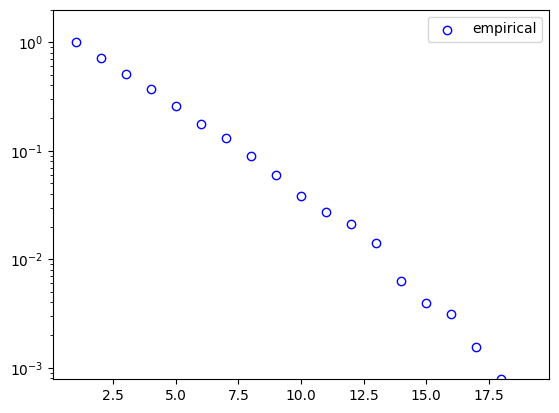

In [14]:
from scipy.stats import expon
from scipy.stats import pareto

data = res.query("year>0")['year'].values
# data_to_fit = res.query("year>3")['year'].values
# loc1, scale1 = expon.fit(data_to_fit,method="MM")
# b, loc2, scale2 = pareto.fit(data, 1, loc=1, scale=1)

bins = [i for i in range(int(max(data))+1)]
bins_plot = np.add(bins,1)
hist,_ = np.histogram(data, bins=bins)
hist = 1- np.cumsum(hist)/len(data)

plt.scatter(bins_plot[:-1], hist,edgecolor='blue', c='white',  label="empirical")

# x_plot = bins
# plt.plot(
#     x_plot,
#     expon.sf(bins, loc=loc1, scale=scale1)*hist[3],
#     linestyle='-',c='orange',
#     label=f'Exponential Fit e^-(x-{round(loc1,2)})/{round(scale1,2)}',
# )

plt.ylim(hist[-2],2)
plt.yscale('log')
plt.legend()

# loc1, scale1

In [ ]:
from scipy.stats import expon
from scipy.stats import pareto

data = res.query("year>0 and year<15")['year'].values
b, loc2, scale2 = pareto.fit(data, 2.4, loc=0, scale=1)

bins = [i for i in range(int(max(data))+1)]
bins_plot = np.add(bins,1)
hist,_ = np.histogram(data, bins=bins)
hist = 1- np.cumsum(hist)/len(data)

plt.scatter(bins_plot[:-1], hist,edgecolor='blue', c='white',  label="empirical")

plt.plot(
    bins,
    pareto.sf(bins, b=2.5),
    linestyle='-',c='red',
    label='Power law Fit',
)

plt.ylim(hist[-2],2)
plt.yscale('log')
plt.xscale('log')
plt.legend()

b, loc2, scale2

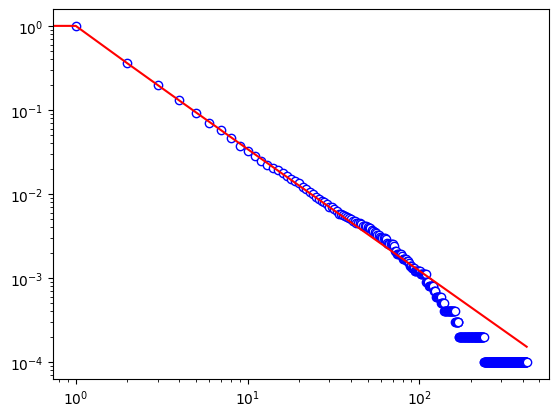

(1.4466611150611741, 0.03409880306053237, 0.9659318693200394)

In [450]:
import scipy.stats as stats

b, loc, scale = 1.5, 0, 1

data = stats.pareto.rvs(b, size=10000)
bins = [i for i in range(int(max(data))+1)]
bins_plot = np.add(bins,1)
hist,_ = np.histogram(data, bins=bins)
hist = 1- np.cumsum(hist)/len(data)

plt.scatter(bins_plot[:-1], hist,edgecolor='blue', c='white',  label="empirical")
plt.yscale('log')
plt.xscale('log')
b,l,s = stats.pareto.fit(data, 1, loc=0, scale=1)
plt.plot(
    bins,
    pareto.sf(bins, b=b,loc=l, scale=s),
    linestyle='-',c='red',
    label='Power law Fit',
)
plt.show()
b,l,s

## raw plot & #authors distribution

In [ ]:
plotter(res.query("year>0")['year'].values,i,'blue', "year",plot="power-law")
plotter(res.query("year>0")['year'].values,i,'blue', "year",plot="poisson")
plotter(res.query("is_ff==True and year>0")['year'].values,i,'purple', "year_ff",plot="power-law",limit=0.00001)
plotter(res.query("is_ff==True and year>0")['year'].values,i,'purple', "year_ff",plot="poisson",limit=0.00001)
plotter(res.query("is_ff==False and year>0")['year'].values,i,'blueviolet', "year_not_ff",plot="power-law",limit=0.0000001)
plotter(res.query("is_ff==False and year>0")['year'].values,i,'blueviolet', "year_not_ff",plot="poisson",limit=0.0000001)

# plotter(res.query("seq>0")['seq'].values,i,'red', "paper",plot="power-law")
# plotter(res.query("is_ff==True and seq>0")['seq'].values,i,'coral', "paper_ff",plot="poisson")
# plotter(res.query("is_ff==False and seq>0")['seq'].values,i,'orange', "paper_not_ff",plot="power-law")


In [ ]:
# id_text = big_author.index[i]
plotter(res.query("seq>0")['seq'].values,"all author id",'blue', "seq",plot="power-law", limit=0.0000001)
plotter(res.query("seq>0")['seq'].values,"all author id",'blue', "seq",plot="poisson")
# plotter(res[:10000000].query("is_ff==True and seq>0")['seq'].values,"all author id",'purple', "seq_ff",plot="power-law",limit=0.00001)
# plotter(res[:10000000].query("is_ff==True and seq>0")['seq'].values,"all author id",'purple', "seq_ff",plot="poisson",limit=0.00001)
# plotter(res[:10000000].query("is_ff==False and seq>0")['seq'].values,"all author id",'blueviolet', "seq_not_ff",plot="power-law",limit=0.0000001)
# plotter(res[:10000000].query("is_ff==False and seq>0")['seq'].values,"all author id",'blueviolet', "seq_not_ff",plot="poisson",limit=0.0000001)


In [ ]:
plotter(res.query("is_ff==True and year>0")['year'].values,id_text,'purple', "year_ff",plot="power-law",limit=0.00001)
plotter(res.query("is_ff==True and year>0")['year'].values,id_text,'purple', "year_ff",plot="poisson",limit=0.00001)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7f55979e70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7f55979e40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7eb76006a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7f559784f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7f5597afb0>],
 'means': []}

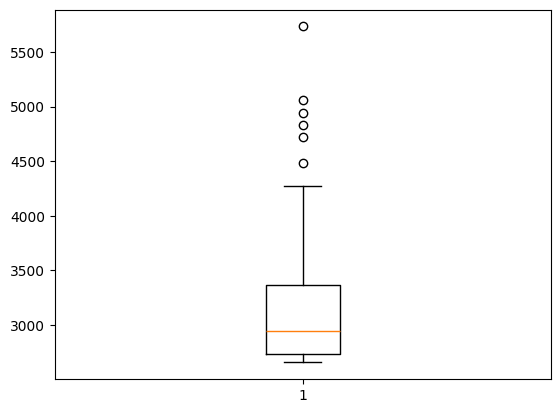

In [256]:
plt.boxplot(big_author["n_people"].values[:100])


In [240]:
res

year  seq  is_ff
authid                               
6504106591  31337       0    0  False
6504349124  1151        5  404  False
            11100       0    0  False
            15462       0    0  False
            17030       6  392  False
...                   ...  ...    ...
57720878800 2681952     1   20  False
            2684152     0    0  False
            2691359     0    1  False
57720878900 2528333     4  160  False
57721836200 173046      0    0  False

[167247815 rows x 3 columns]

## partition info

In [292]:
partition_df = pd.read_pickle("/disks/qnap2/shared/scopus_2022/paper_detail/partition.pickle")
partition_df

node
84989078645    16
20212653       16
84930278142    16
85053509714    16
84982629566    16
               ..
30485225       10
2542463523      6
30463105       15
84859756395    17
30485236        4
Name: partition, Length: 66685170, dtype: int64

In [296]:
partition_df_sub = pd.merge(partition_df,pd.read_pickle("/disks/qnap2/shared/scopus_2022/paper_detail/partition_sub.pickle"),how="left",on="node").rename_axis("eid", axis=0)
partition_df_sub

partition_x  partition_y
node                                 
84989078645           16            4
20212653              16            4
84930278142           16            4
85053509714           16            4
84982629566           16            0
...                  ...          ...
30485225              10            7
2542463523             6            5
30463105              15           28
84859756395           17            0
30485236               4            4

[66685170 rows x 2 columns]

In [489]:
partition_name_df = pd.read_pickle("/disks/qnap2/shared/scopus_2022/paper_detail/partition_info/GPT4_label_partition.pickle")
partition_name_df

0.0                  Social Sciences
1.0                 Computer Science
2.0            Environmental Biology
3.0      Physics & Materials Science
4.0               Molecular Medicine
5.0                        Neurology
6.0                       Immunology
7.0                   Nanotechnology
8.0                   Fluid Dynamics
9.0                        Chemistry
10.0                      Geophysics
11.0                      Psychology
12.0                      Cardiology
13.0               Clinical Medicine
14.0                       Photonics
15.0                Oncology Surgery
16.0             Antibiotic Research
17.0                    Astrophysics
18.0                     Pulmonology
19.0                    Parasitology
20.0                   Ophthalmology
21.0               Genetic Disorders
22.0                     Herpetology
23.0                     Mathematics
24.0             Occupational Health
26.0         Global Trade & Textiles
dtype: object

In [322]:
# investiate partition by comparing paper title and partition description

samples_df = pd.merge(pd.read_pickle("/disks/qnap2/shared/scopus_2022/paper_detail/title.pickle"), partition_df_, how="inner", on="eid")
partition_name_sub_df = pd.read_pickle("/disks/qnap2/shared/scopus_2022/paper_detail/partition_info/GPT4_label_partition_sub.pickle")

sample = samples_df.sample(20)
sample["partition"] = (sample['partition_x'].astype(str)+ '_' + sample['partition_y'].astype(str)).map(partition_name_sub_df)

sample

title  partition_x  \
eid                                                                           
84875474829  Antenatal architecture and activity of the hum...           12   
85099275727  In vitro digestibility and stability of encaps...            7   
65249190366  Multifractional image segmentation in high res...            1   
82655162787  Acceleration of FDTD method using a novel algo...            1   
36013428     Genetics of human body size and shape: Body pr...           13   
29463405     Modifications to MCNP to provide coincident da...           17   
84870265211  Visual stability across combined eye and body ...            5   
84857586480  Application of a trace formula to the spectra ...           14   
84859400216  The ochodaeidae of Argentina (Coleoptera, Scar...            2   
84892169828  Study on the preparation of fine-grained CeO-A...            3   
78649312609  Inclusion of landslide tsunamis generation int...           10   
21853035     Application of Principal Component Analysis to...            9   
85128038694  Localism in one local: Labor and scale at the ...            0   
85061060630  Urban social struggles in Andalusia: Approache...            0   
85024286592  Inhibitory Effect of Glycine and Several Sodiu...           16   
33947140449  Biodegradation of novel amino acid derivatives...            2   
15014974     Isolation of protoplasts from the placental ce...            2   
78650480782  Dielectric properties of barium titanate ceram...            3   
79952263944  Sensitive spectrophotometric determination of ...            7   
25954205     Variation in growth rates of submerged rooted ...            2   

             partition_y                                        partition  
eid                                                                        
84875474829            1           Cardiac Repolarization and Arrhythmias  
85099275727           10                  Surfactant and Emulsion Systems  
65249190366            0               Image Processing & Computer Vision  
82655162787           14                         Digital Hardware Systems  
36013428              24         Forensic Anthropology and Identification  
29463405              15                          Neutron Instrumentation  
84870265211            4              Visual Processing and Eye Movements  
84857586480            4                      Integrated Photonic Devices  
84859400216            1                Evolutionary Ecology and Genetics  
84892169828           10                    Ceramics and Thermal Coatings  
78649312609            9                Earthquake Seismology & Tectonics  
21853035               1   Structural Biochemistry and Molecular Dynamics  
85128038694            0                 Cultural and Political Sociology  
85061060630           17        Cultural Heritage and Tourism Management   
85024286592           14                              Foodborne Pathogens  
33947140449            7                         Environmental Toxicology  
15014974               0             Plant Physiology and Stress Response  
78650480782           12              Functional Ceramics and Dielectrics  
79952263944            0           Electrochemical Biosensors & Detection  
25954205               6                 Limnology and Freshwater Ecology

In [494]:
df_reset = res.reset_index()
df_reset["partition"] = df_reset["level_1"].map(partition_df)

grouped = df_reset.dropna().groupby(by="partition")

In [472]:
df_reset.dropna(), len(df_reset)

(                 authid  level_1  year  seq  is_ff  partition
 1            6504349124     1151     5  404  False        3.0
 3            6504349124    15462     0    0  False       17.0
 6            6504349124    39443     0    7  False        9.0
 8            6504691421      877     5  404  False        4.0
 9            6504691421     4456     0    0  False        2.0
 ...                 ...      ...   ...  ...    ...        ...
 1896899673  57225325586     3793     0    0   True       17.0
 1896899675  57225325586     5014     7  208   True        9.0
 1896899677  57225325586     5174     0    0   True        9.0
 1896899686  57641672400     1487     1    5   True        3.0
 1896899690  57641672400     4315     1   29   True       10.0
 
 [422928997 rows x 6 columns],
 1896899691)

 Social Sciences 28331440 0.0
 Computer Science 12072405 1.0
 Environmental Biology 52850592 2.0
 Physics & Materials Science 73073323 3.0
 Molecular Medicine 7608655 4.0
 Neurology 7123816 5.0
 Immunology 1686273 6.0
Nanotechnology 26780182 7.0
 Fluid Dynamics 12973081 8.0
Chemistry 92637163 9.0
 Geophysics 14663115 10.0
 Psychology 6225696 11.0
Cardiology 1231546 12.0
Clinical Medicine 1494250 13.0
 Photonics 28785419 14.0
 Oncology Surgery 779100 15.0
 Antibiotic Research 7601591 16.0
 Astrophysics 46158238 17.0
 Pulmonology 210680 18.0
 Parasitology 379590 19.0
 Ophthalmology 192425 20.0
 Genetic Disorders 6790 21.0
 Herpetology 21455 22.0
 Mathematics 34482 23.0


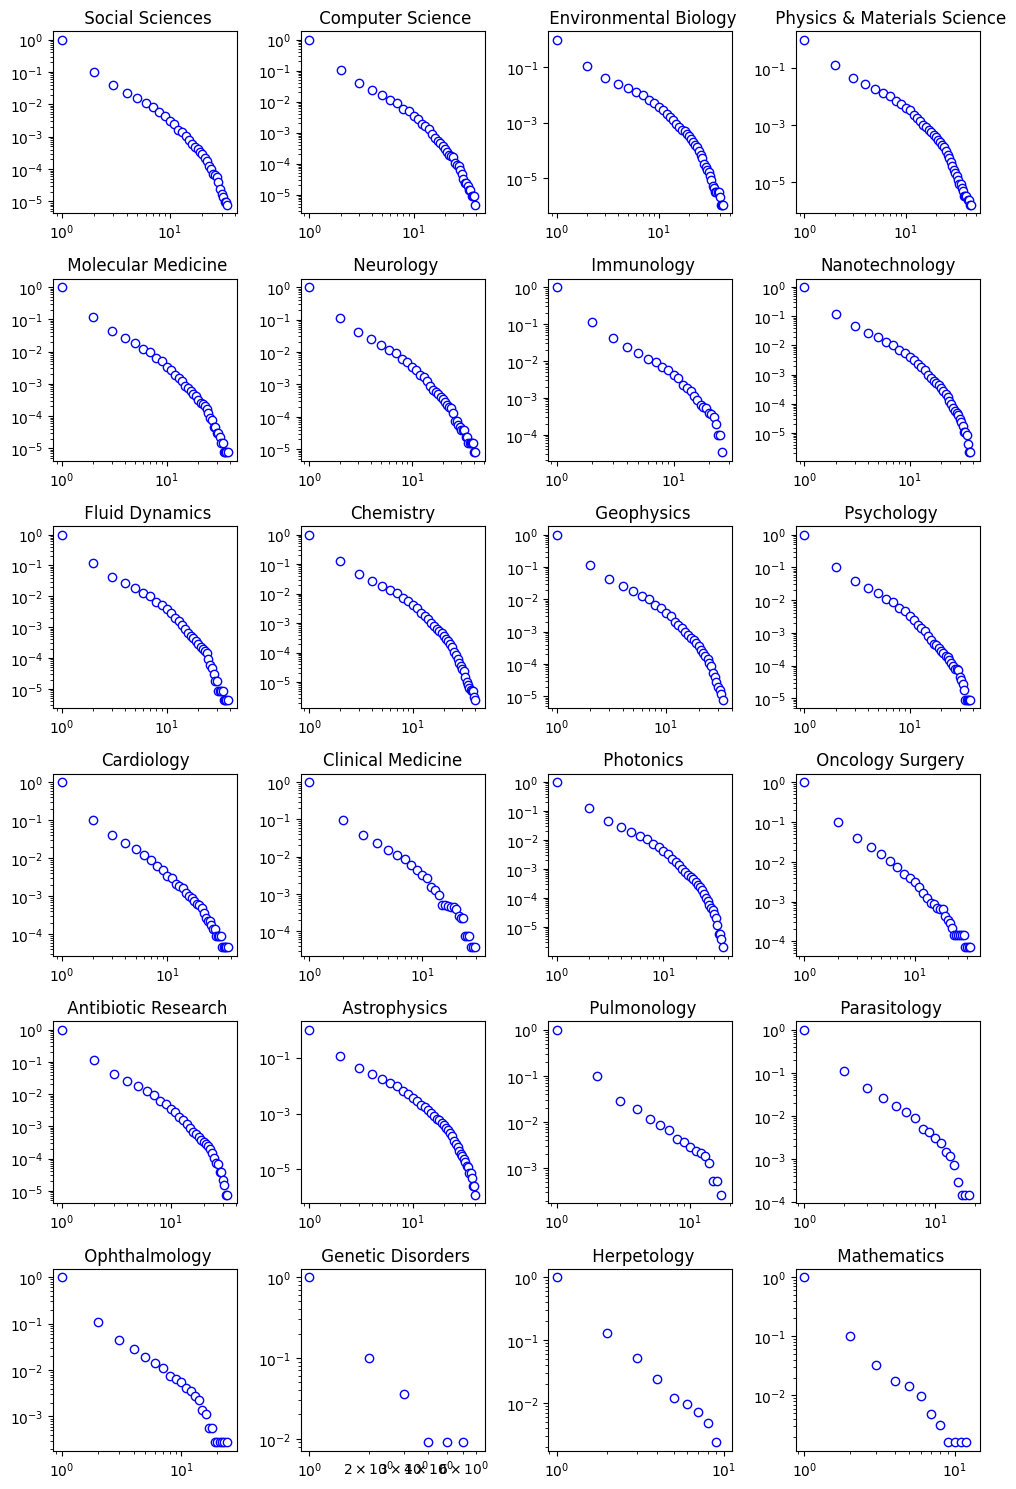

In [528]:
fig, axes = plt.subplots(6, 4, figsize=(10, 15))

for (name, group), ax in zip(grouped, axes.flatten()):
    data = group.query("year>0")['year'].values
    partition_title = partition_name_df.loc[name]
    print(partition_title, len(group),name)
    
    bins = [i for i in range(int(max(data))+1)]
    bins_plot = np.add(bins,1)
    hist,_ = np.histogram(data, bins=bins)
    hist = 1- np.cumsum(hist)/len(data)
    
    ax.scatter(bins_plot[:-1], hist,edgecolor='blue', c='white',  label="empirical")
    ax.set_title(f'{partition_title}')
    ax.set_yscale('log')
    ax.set_xscale('log')

for ax in axes.flatten()[len(grouped):]:
    ax.axis('off')
    
plt.tight_layout()
plt.show()

11856
5170
24041
35258
3535
3058
735
12863
6057
43814
6861
2708
567
644
14074
328
3461
20968
73
179
101
1
10
11


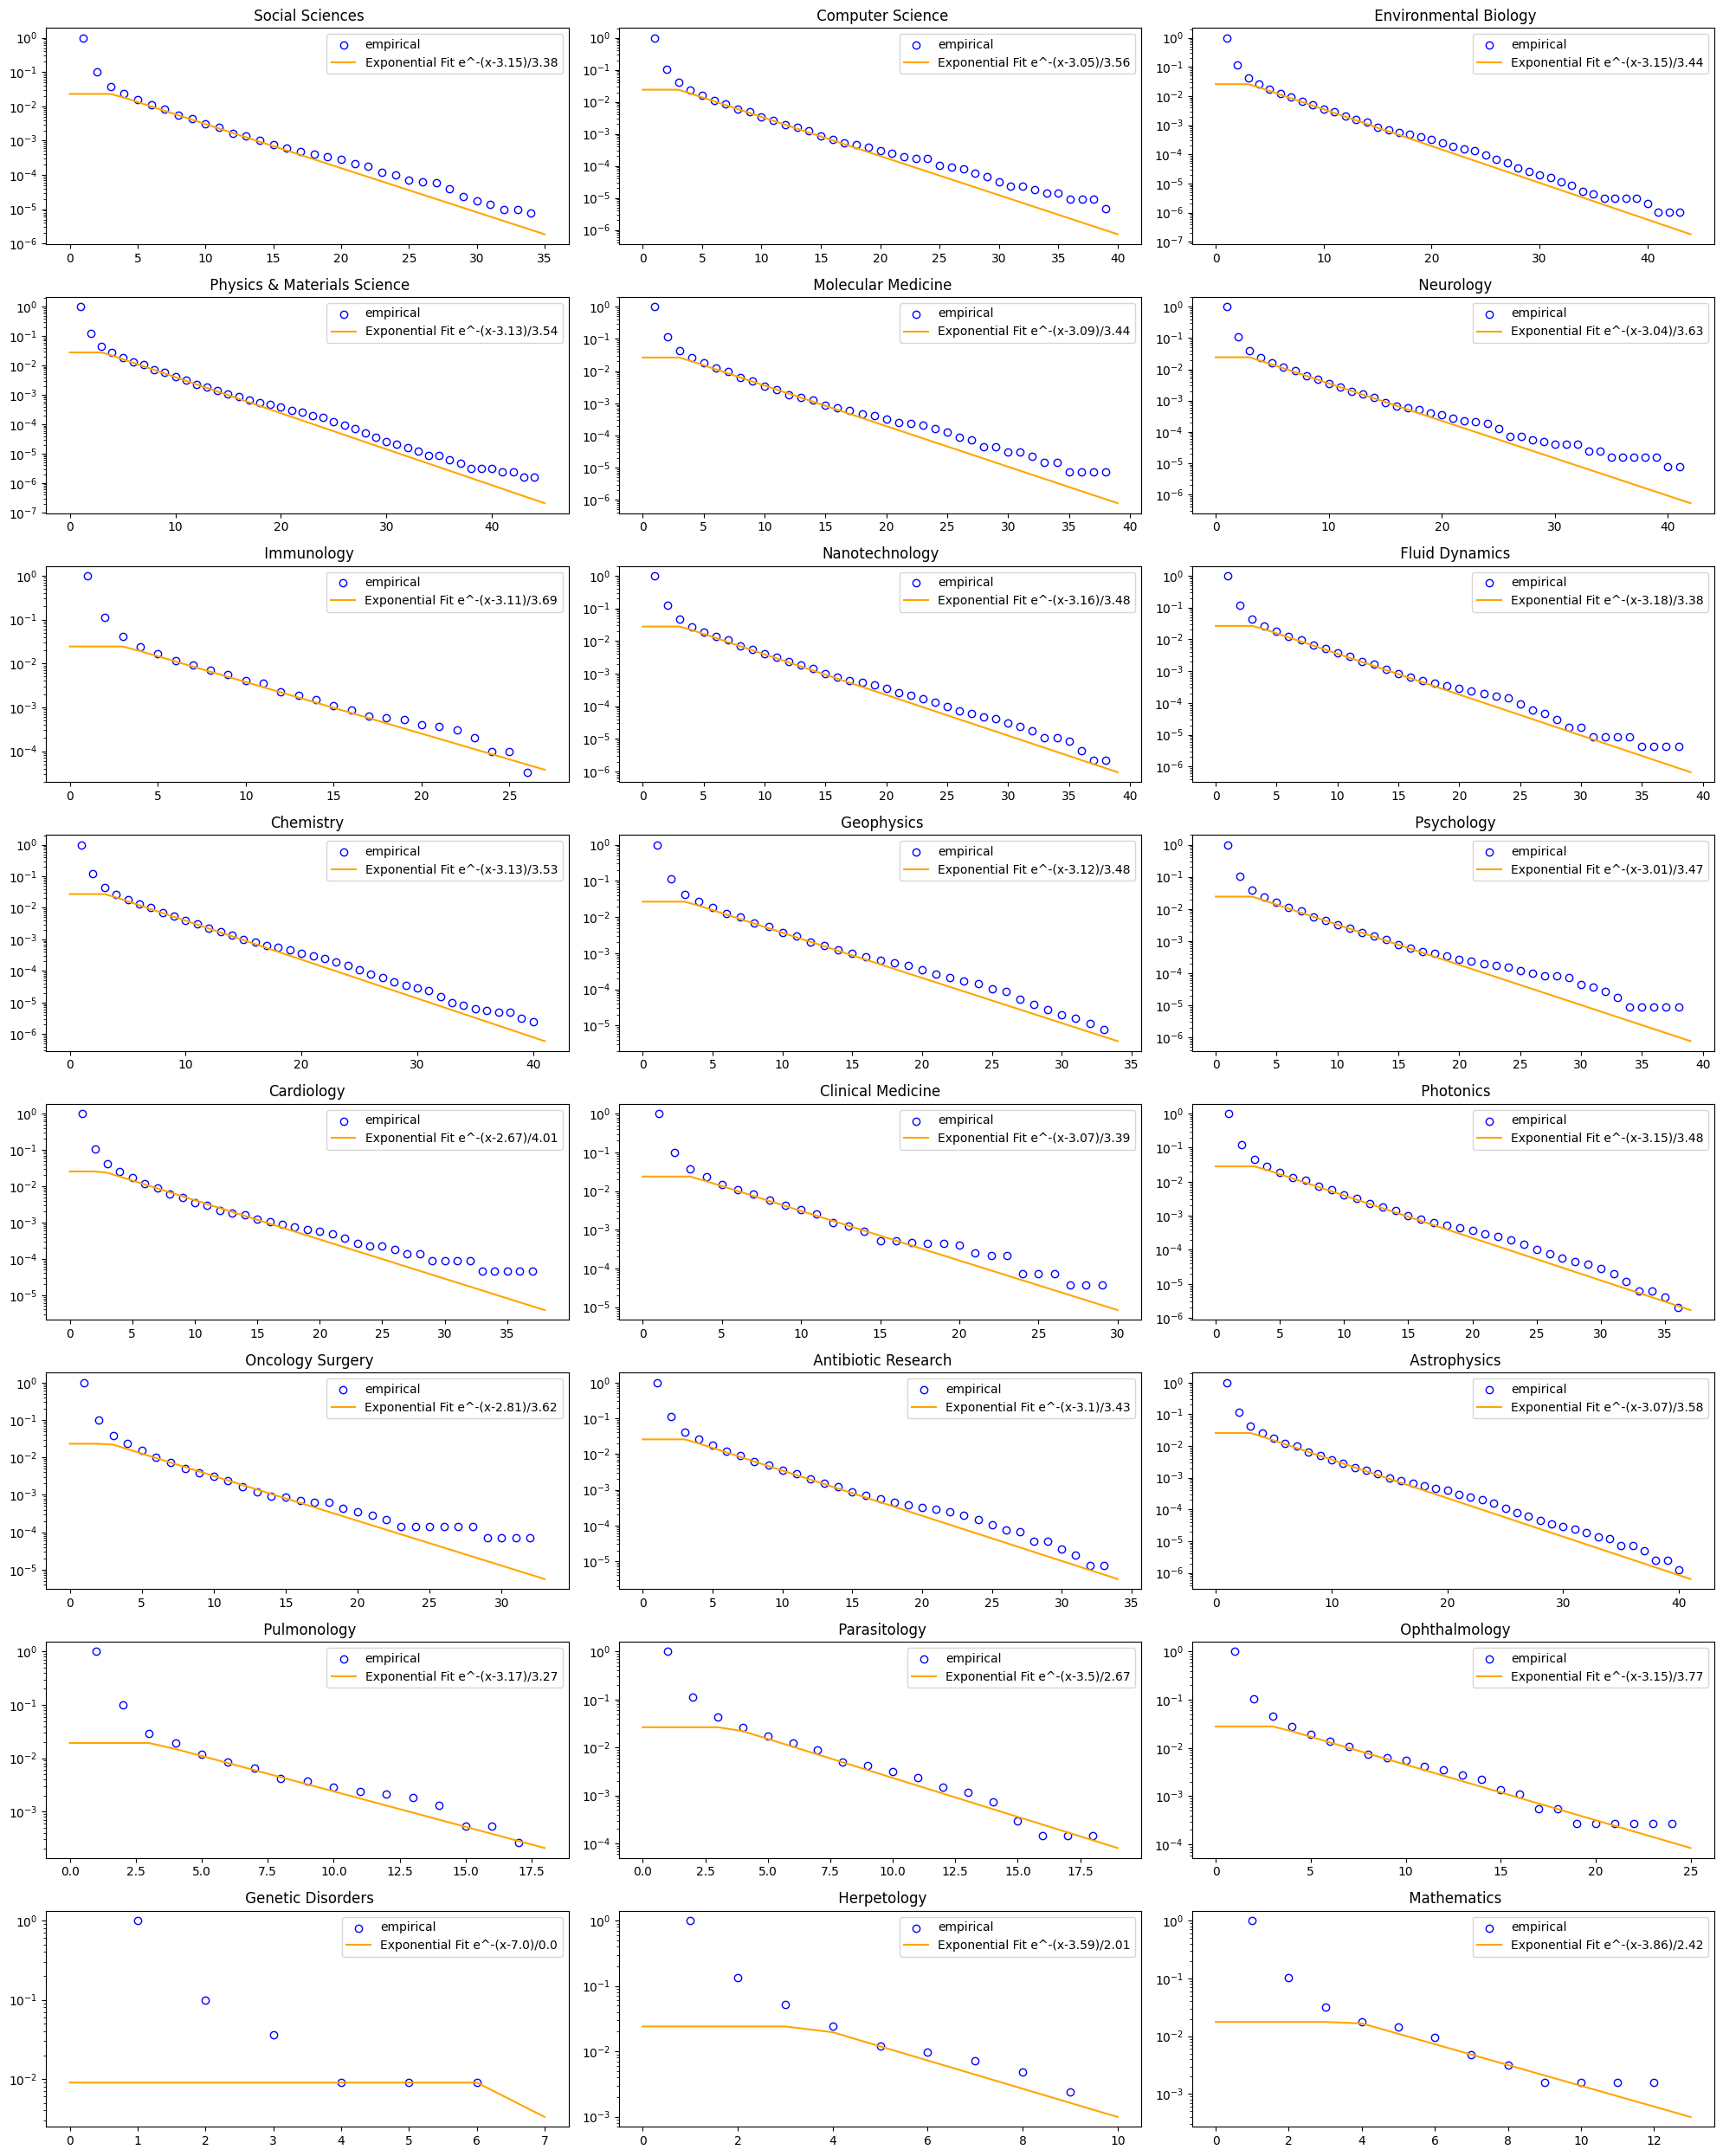

In [531]:
fig, axes = plt.subplots(8, 3, figsize=(20, 25))

for (name, group), ax in zip(grouped, axes.flatten()):
    data = group.query("year>0")['year'].values
    data_to_fit = group.query("year>3")['year'].values
    partition_title = partition_name_df.loc[name]
    loc1, scale1 = expon.fit(data_to_fit,method="MM")
    print(len(data_to_fit))
    
    bins = [i for i in range(int(max(data))+1)]
    bins_plot = np.add(bins,1)
    hist,_ = np.histogram(data, bins=bins)
    hist = 1- np.cumsum(hist)/len(data)

    x_plot = bins
    
    ax.scatter(bins_plot[:-1], hist,edgecolor='blue', c='white',  label="empirical")
    ax.set_title(f'{partition_title}')
    ax.plot(
        x_plot,
        expon.sf(bins, loc=loc1, scale=scale1)*hist[3],
        linestyle='-',c='orange',
        label=f'Exponential Fit e^-(x-{round(loc1,2)})/{round(scale1,2)}',
    )
    
    ax.set_yscale('log')
    ax.legend()

for ax in axes.flatten()[len(grouped):]:
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [342]:
sorted = partition_df.sort_index(axis="index") #,partition_df["level_1"])

node
748305         125
1287661        670
2373710        113
3103033        144
3162153        113
              ... 
85130929935    597
85131229114    376
85131316513    119
85131488804    806
85131671972    146
Name: partition, Length: 13458, dtype: int64

In [345]:
sorted[sorted.index>31330].head(20)

node
31333    17
31335     7
31342     3
31348     2
31349    16
31352     9
31353     3
31354     9
31357    16
31364    10
31368     3
31371     0
31380     2
31390     0
31395     3
31401     9
31402     2
31408    17
31410     0
31411     9
Name: partition, dtype: int64

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_poisson_events(rate, time_duration):
    num_events = np.random.poisson(rate * time_duration)
    event_times = np.sort(np.random.uniform(0, time_duration, num_events))
    inter_arrival_times = np.diff(event_times)
    return num_events, event_times, inter_arrival_times

def plot_non_sequential_poisson(num_events, event_times, inter_arrival_times, rate, time_duration):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Poisson Process Simulation (λ = {rate}, Duration = {time_duration} seconds)\n', fontsize=16)

    axs[0].step(event_times, np.arange(1, num_events + 1), where='post', color='blue')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Event Number')
    axs[0].set_title(f'Poisson Process Event Times\nTotal: {num_events} events\n')
    axs[0].grid(True)

    axs[1].hist(inter_arrival_times, bins=20, color='green', alpha=0.5)
    axs[1].set_xlabel('Inter-Arrival Time')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(f'Histogram of Inter-Arrival Times\nMEAN: {np.mean(inter_arrival_times):.2f} | STD: {np.std(inter_arrival_times):.2f}\n')
    axs[1].grid(True, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
def poisson_simulation(rate, time_duration, show_visualization=True):
    if isinstance(rate, int):
        num_events, event_times, inter_arrival_times = generate_poisson_events(rate, time_duration)
        
        if show_visualization:
            plot_non_sequential_poisson(num_events, event_times, inter_arrival_times, rate, time_duration)
        else:
            return num_events, event_times, inter_arrival_times

    elif isinstance(rate, list):
        num_events_list = []
        event_times_list = []
        inter_arrival_times_list = []

        for individual_rate in rate:
            num_events, event_times, inter_arrival_times = generate_poisson_events(individual_rate, time_duration)
            num_events_list.append(num_events)
            event_times_list.append(event_times)
            inter_arrival_times_list.append(inter_arrival_times)

        if show_visualization:
            plot_sequential_poisson(num_events_list, event_times_list, inter_arrival_times_list, rate, time_duration)
        else:
            return num_events_list, event_times_list, inter_arrival_times_list

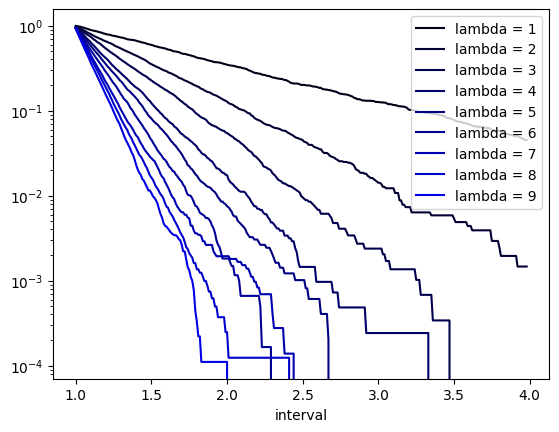

In [72]:
import matplotlib.pyplot as plt
for k in range(1,10):
    num_events, event_times, inter_arrival_times = poisson_simulation(rate=k, time_duration=1000, show_visualization=False) # For single lambda rate (non-sequential)
    data = inter_arrival_times
    
    bins = [i*0.01 for i in range(300)]
    bins_plot = np.add(bins,1)
    hist,_ = np.histogram(data, bins=bins)
    hist = 1- np.cumsum(hist)/len(data)
    
    plt.plot(bins_plot[:-1],hist, linestyle='-',c=(0,0,k/10),label=f"lambda = {k}")
plt.legend()
plt.xlabel('interval')
plt.yscale('log')
plt.show()
# poisson_simulation(rate=[2, 4, 6, 10], time_duration=10) # For multiple lambda rate (sequential)

In [19]:
print("a")

a


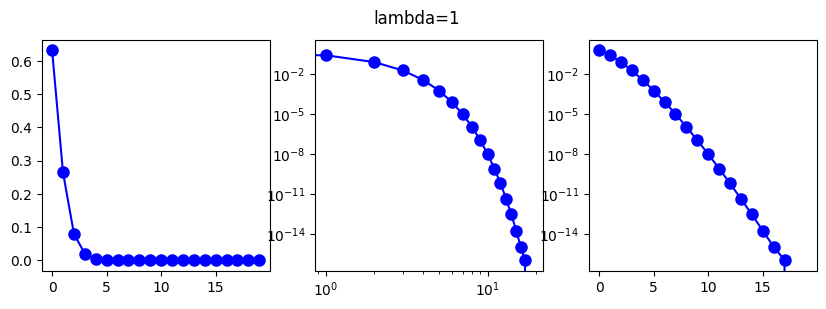

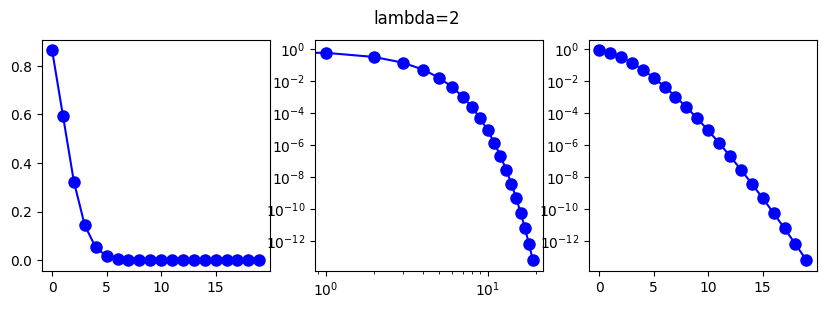

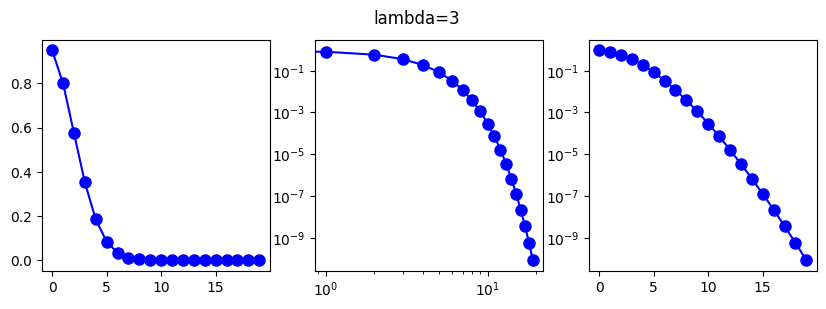

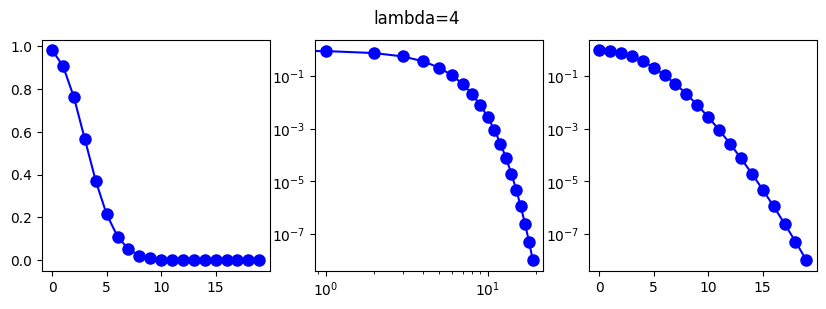

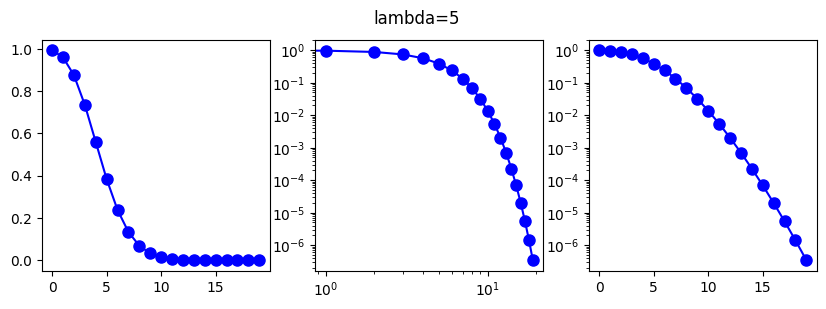

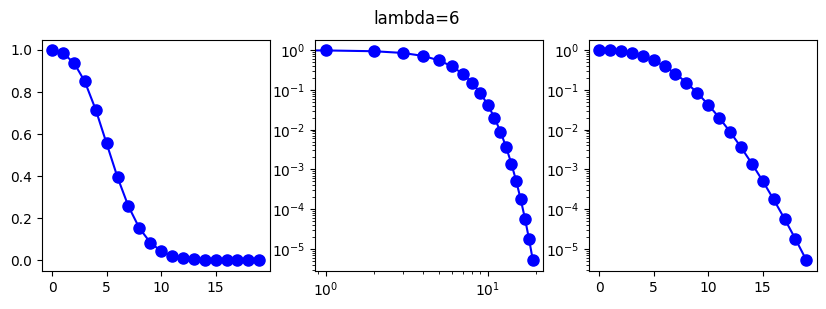

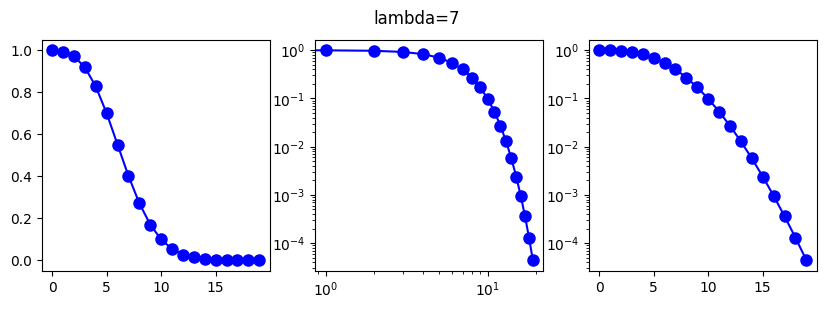

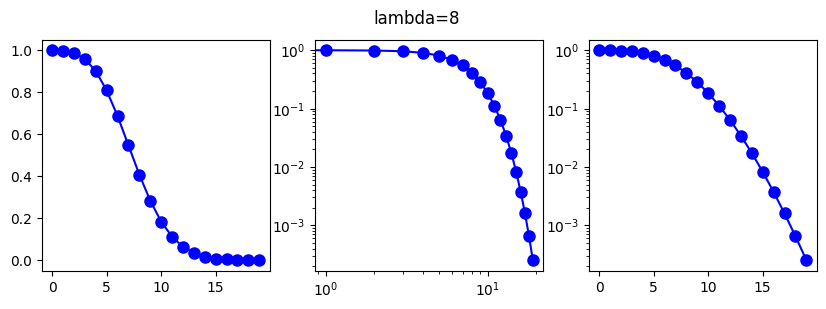

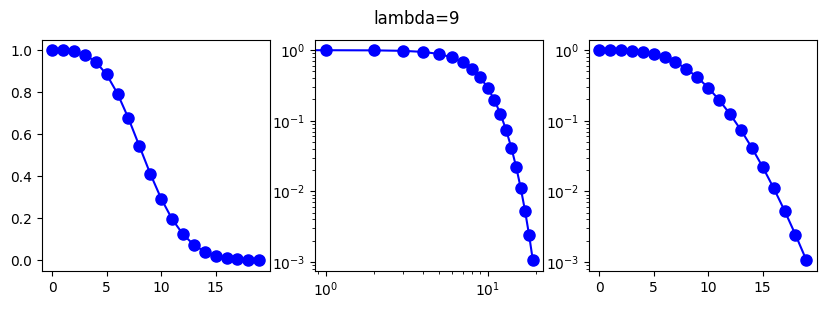

In [70]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

for mu in range(1,10):
    fig, ax = plt.subplots(1, 3, figsize=(10,3))
    fig.suptitle(f'lambda={mu}')
    x = np.arange(0,20)
    ax[0].plot(x, 1 - poisson.cdf(x, mu), linestyle='-',c='blue', label='poisson ccdf')
    ax[0].plot(x, 1 - poisson.cdf(x, mu),'bo', ms=8)
    
    ax[1].plot(x, 1 - poisson.cdf(x, mu), linestyle='-',c='blue', label='poisson ccdf')
    ax[1].plot(x, 1 - poisson.cdf(x, mu),'bo', ms=8)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    
    ax[2].plot(x, 1 - poisson.cdf(x, mu), linestyle='-',c='blue', label='poisson ccdf')
    ax[2].plot(x, 1 - poisson.cdf(x, mu),'bo', ms=8)
    ax[2].set_yscale('log')
    




# Coauth Network

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import random
import networkx as nx

from scipy.stats import expon
from scipy.stats import pareto


In [3]:
res = pd.concat([pd.read_pickle(f"./result/nobig_PM_{i:03}.pickle") for i in range(100)],axis=0)
res

authid  year  seq          eid  source_authid  is_ff
0    7201783441     3    1     33532921    57199389422  False
1    7202354107     3    1     33532921    57199389422   True
2   34770527900     3    1     33532921    57199389422  False
0   36004814900     1    2  85029507385    57190027493   True
1   36004814900     0    1  85021966778    57190027493   True
..          ...   ...  ...          ...            ...    ...
52  57216163951     1    2  85117960669     6603098070  False
53  57216163951     0    1  85108781777     6603098070  False
54  57216163951     0    1  85122824615     6603098070  False
55  57216163951     0    1  85108848328     6603098070  False
56  57225441968     0    1  85062290277     6603098070  False

[3393595 rows x 6 columns]

In [16]:
author_df = pd.read_pickle("./result/authors_valid_PM.pickle")
author_df

eid       authid  authseq         indexname        surname  \
165        85015329432  36620106200        1            Bae H.            Bae   
166        85015329432  56998595200        2           Bang T.           Bang   
167        85015329432   7409873371        3         Kim C.-K.            Kim   
168        85015329432  56194519000        4            Hur J.            Hur   
169        85015329432  57193625556        5            Kim S.            Kim   
...                ...          ...      ...               ...            ...   
289838959  84927731812  56887670500        4        Calvani P.        Calvani   
289838960  84927731812   6507192277        5      Trucchi D.M.        Trucchi   
289838961  84927731812   9332709800        2    Pietropaolo A.    Pietropaolo   
289839046  84927667476   7004157249        1  De Dios-Leyva M.  De Dios-Leyva   
289839047  84927667476  55173609100        2           Cuan R.           Cuan   

              givenname doctype  partition  
165             Hagyoul      ar        3.0  
166              Tewook      ar        3.0  
167           Choong-Ki      ar        3.0  
168                 Jae      ar        3.0  
169              Seyeob      ar        3.0  
...                 ...     ...        ...  
289838959  NO GIVENNAME      ar        3.0  
289838960  NO GIVENNAME      ar        3.0  
289838961  NO GIVENNAME      ar        3.0  
289839046  NO GIVENNAME      ar        3.0  
289839047  NO GIVENNAME      ar        3.0  

[22084638 rows x 8 columns]

In [4]:
len(res["authid"].unique()), len(res["source_authid"].unique())

(506426, 92179)

In [58]:
coauth_pair = res[["authid","source_authid"]][res["year"]==2]

tuple_array = []
for index, row in coauth_pair.iterrows():
    tuple_array.append(tuple(row))
len(tuple_array)

279556

In [59]:
G = nx.Graph()

G.add_edges_from(tuple_array)

connected_components = list(nx.connected_components(G))
most_connected_component = max(connected_components, key=len)
subgraph = G.subgraph(most_connected_component)

G.number_of_nodes(), G.number_of_edges(), len(subgraph)

(198436, 227796, 141109)

In [60]:
nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree == 1]
G.remove_nodes_from(nodes_to_remove)

connected_components = list(nx.connected_components(G))
most_connected_component = max(connected_components, key=len)
subgraph = G.subgraph(most_connected_component)

len(subgraph)

56556

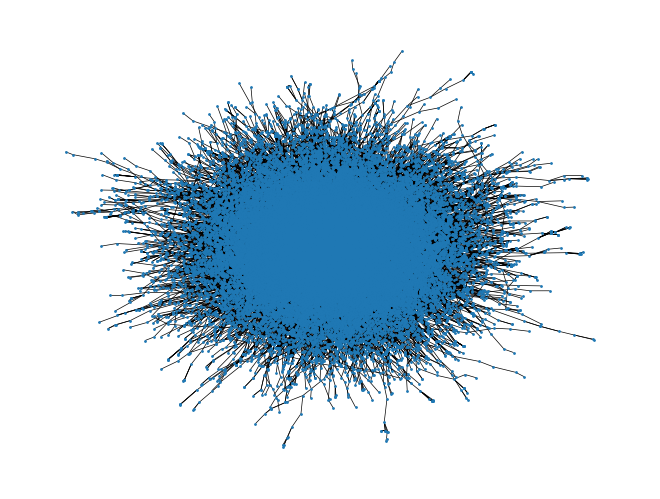

In [62]:
nx.draw(subgraph, with_labels=False, node_size=1,width=0.5)
plt.savefig("network_graph_2.png")

In [ ]:
len(list(subgraph))

In [32]:
def construct_lcc(df):
    coauth_pair = df[["authid","source_authid"]]
    
    tuple_array = []
    for index, row in coauth_pair.iterrows():
        tuple_array.append(tuple(row))
    print(len(tuple_array))
    
    G = nx.Graph()
    G.add_edges_from(tuple_array)
    
    connected_components = list(nx.connected_components(G))
    most_connected_component = max(connected_components, key=len)
    subgraph = G.subgraph(most_connected_component)
    
    print(G.number_of_nodes(), G.number_of_edges(), len(subgraph))
    return subgraph
short_lcc = construct_lcc(short)
long_lcc = construct_lcc(long)

3235871
506241 873984 504034
75292
71342 68322 36087


KeyboardInterrupt: 

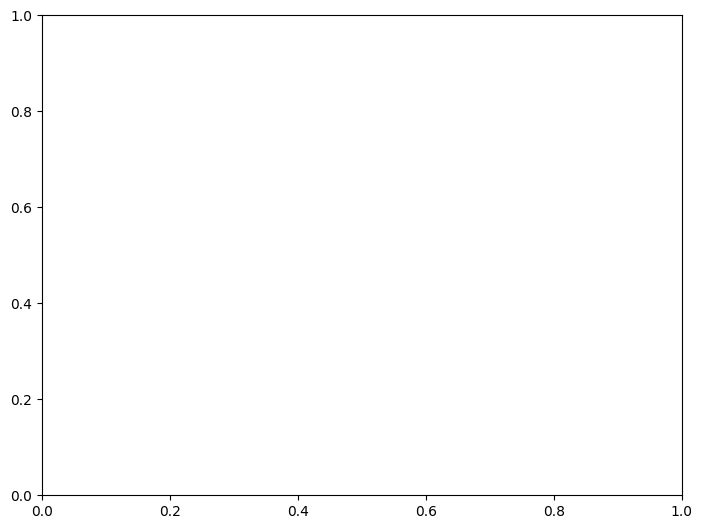

In [34]:
nx.draw(long_lcc, with_labels=False, node_size=1,width=0.5)
plt.savefig("network_graph_long.png")
plt.show()

In [ ]:
nx.draw(short_lcc, with_labels=False, node_size=1,width=0.5)
plt.savefig("network_graph_short.png")
plt.show()

In [17]:
target_works = author_df["eid"][author_df["authid"].isin(list(subgraph))]
target_works

424          85015254729
541          85015254827
553          85015254827
985          85015255132
1027         85015330172
                ...     
289837319    84927666225
289837410    84927666327
289837414    84927666327
289837415    84927666327
289837997    84927666783
Name: eid, Length: 1021733, dtype: int64

In [20]:
target_authors = author_df["eid", "authid"][author_df["eid"].isin(target_works)]
target_authors

415          56429735400
416          54922214100
417          55659427400
418          12242890200
419           6602075364
                ...     
289837995    57207130801
289837996     7202397722
289837997     6603002080
289837998    26634210500
289837999     7005039218
Name: authid, Length: 3816202, dtype: int64

In [24]:
target_authors.groupby(by="eid")

513627

In [57]:
import pickle
# グラフの保存
with open("graph.pkl", "wb") as f:
    pickle.dump(G, f)



# Multiagent interaction simulation

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from scipy.optimize import curve_fit
import math
import networkx as nx
import igraph as ig
from util import plotter

## J.G. Oliveira 2009の再現実験

In [150]:
# i) Original: when the two agent disagree on interacting, they execute O task.
# p=1: γ=2.81 ,p=0.99: γ=2.88 ,p=0.9: べきでも指数でもない , p=0.5: p=0.9と同様
p=0.5

agent1={"I":random.random(),"O":random.random()}
agent2={"I":random.random(),"O":random.random()}

print(agent1, agent2)

def updatetask(agent):
    if random.random()<=p: return max(agent, key=agent.get)
    else: return random.choice(["I", "O"])

j=0
int_tasks = []
int_interactive = []

for i in range(1000000):
    task1 = updatetask(agent1)
    task2 = updatetask(agent2)
    if task1==task2:
        int_interactive.append(j)
        agent1["I"], agent2["I"] = [random.random() for i in range(2)]
        j=0
    else:
        agent1["O"], agent2["O"] = [random.random()  for i in range(2)]
        j+=1

{'I': 0.5014839689737218, 'O': 0.3617514675605391} {'I': 0.07935368401834209, 'O': 0.8255205597841723}


In [144]:
# ii) Selfish: Even if agents doesn't agree, the agent execute I task and refresh the priority.
# -> p=1: single(i=0) p=0.99: γ=1.15 + cutoff, p=0.9:べきでも指数でもない , p=0.5:べきでも指数でもない
p=0.5

agent1={"I":random.random(),"O":random.random()}
agent2={"I":random.random(),"O":random.random()}

print(agent1, agent2)

def updatetask(agent):
    if random.random()<=p:
        task = max(agent, key=agent.get)
        agent[task] = random.random()
    else:
        task = random.choice(["I", "O"])
        agent[task] = random.random()
    return task

j=0
int_tasks = []
int_interactive = []

for i in range(1000000):
    task1 = updatetask(agent1)
    task2 = updatetask(agent2)
    if task1==task2:
        int_interactive.append(j)
        j=0
    else:
        j+=1

{'I': 0.7305786551659332, 'O': 0.11092270332220222} {'I': 0.6528864237683175, 'O': 0.43096375225428496}


In [195]:
# iii) Modified Barabasi : allow multiple I tasks to be on the list, execute only when they agree on task
# -> p=1:, p=0.99: p=0.9

p = 0.5
p_interactive_task = 0.2
first_task_length = 5

agent1 = pd.DataFrame({"priority":[random.random() for i in range(first_task_length)],\
                       "tasks":[random.random()<=p_interactive_task for i in range(first_task_length)],\
                        "interval":[0 for i in range(first_task_length)]})
agent2 = pd.DataFrame({"priority":[random.random() for i in range(first_task_length)],\
                       "tasks":[random.random()<=p_interactive_task for i in range(first_task_length)],\
                        "interval":[0 for i in range(first_task_length)]})

def updatetask(agent):
    l = max(agent.index.values)+1
    agent["interval"] += 1
    newline = {"priority":random.random(),\
                "tasks":(random.random()<=p_interactive_task),\
                "interval":0}
    return pd.concat([agent, pd.DataFrame(newline,index=[l]) ])

int_tasks = []
int_interactive = []
j = 0
for i in tqdm.tqdm(range(100000)):
    task1 = agent1[agent1['priority']==agent1['priority'].max()] if random.random()<=p else agent1.sample()
    task2 = agent2[agent2['priority']==agent2['priority'].max()] if random.random()<=p else agent2.sample()
    
    if task1["tasks"].values and task2["tasks"].values:
        int_interactive.append(j)
        j=0
    else:
        task1 = agent1[~agent1['tasks']].sample(1) if ~agent1['tasks'].all() else agent1.sample(1)
        task2 = agent2[~agent2['tasks']].sample(1) if ~agent2['tasks'].all() else agent2.sample(1)
        j+=1
    
    agent1 = agent1.drop(task1.index)
    agent2 = agent2.drop(task2.index)
    agent1 = updatetask(agent1)
    agent2 = updatetask(agent2)
    int_tasks.append(task1["interval"].values[0])
    int_tasks.append(task2["interval"].values[0])

100%|██████████████████████████████████| 100000/100000 [04:41<00:00, 355.15it/s]


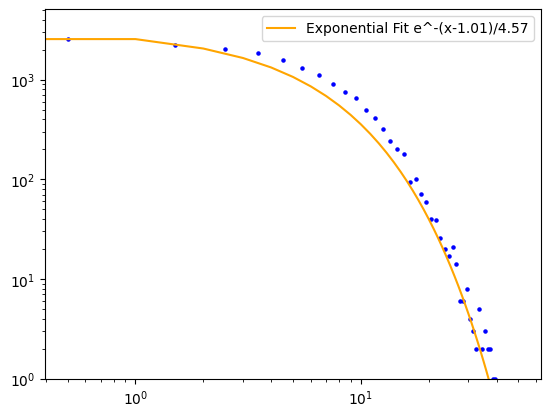

In [196]:
res = np.array(int_interactive)
bins = np.array([i for i in range(int(min(res)),int(max(res)))])
bins_plot = (bins[1:]+bins[:-1])/2
hist,bins = np.histogram(res, bins=bins)
plt.scatter(bins_plot, hist,color="blue",s=5)


x_plot = bins
# loc1,scale1 = 0,i
loc1, scale1 = expon.fit(res[res>0], method="MM")
plt.plot(
    x_plot,
    expon.sf(bins, loc=loc1, scale=scale1)*hist[0],
    linestyle='-',c='orange',
    label=f'Exponential Fit e^-(x-{round(loc1,2)})/{round(scale1,2)}',
)

# x_data = np.log(bins_plot[4:30])
# y_data = np.log(hist[4:30]+1)

# # 直線の方程式を定義します
# def linear_func(x, m, b):
#     return m * x + b

# # 最小二乗法を使用してパラメータをフィットします
# params, covariance = curve_fit(linear_func, x_data, y_data)

# # フィットされたパラメータを表示します
# m_fit, b_fit = params

# # 確率密度関数を定義します
# def power_law(x, alpha, xmin):
#     return math.exp(xmin)*x**alpha
#     # return (alpha - 1) / xmin * (x / xmin) ** (-alpha)
    
# x = bins_plot
# plt.plot(x, power_law(x, m_fit,b_fit),'--',c='black', linewidth=1, label=f'Power Law Fit x^ {round(m_fit,2)} *{round(b_fit,2)}')

# print("傾き (m):", m_fit)
# print("切片 (b):", b_fit)


plt.legend()
plt.ylim(bottom=1, top=hist.max()*2)
plt.xscale("log")
plt.yscale("log")

## Barabasi 2005 の再現実験

In [566]:
p = 0.9
p_interactive_task = 0.2
first_task_length = 5

agent1 = pd.DataFrame({"priority":[random.random() for i in range(first_task_length)],\
                       "tasks":[random.random()<=p_interactive_task for i in range(first_task_length)],\
                        "interval":[0 for i in range(first_task_length)]})
def updatetask(agent):
    l = max(agent.index.values)+1
    agent["interval"] += 1
    newline = {"priority":random.random(),\
                "tasks":(random.random()<=p_interactive_task),\
                "interval":0}
    return pd.concat([agent, pd.DataFrame(newline,index=[l]) ])

int_tasks = []
int_interactive = []
j = 0
for i in tqdm.tqdm(range(5000)):
    if random.random()<=p:
        task1 = agent1[agent1['priority']==agent1['priority'].max()]
    else:
        task1 = agent1.sample()
    
    agent1 = agent1.drop(task1.index)
    agent1 = updatetask(agent1)
    int_tasks.append(task1["interval"].values[0])
    
    j+=1

100%|██████████████████████████████████████| 5000/5000 [00:06<00:00, 787.18it/s]


In [567]:
len(int_tasks)

5000

In [568]:
import powerlaw

results = powerlaw.Fit(int_tasks)
results.distribution_compare('power_law', 'lognormal',normalized_ratio=True)

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


(-1.1322592516718566, 0.257525456069967)

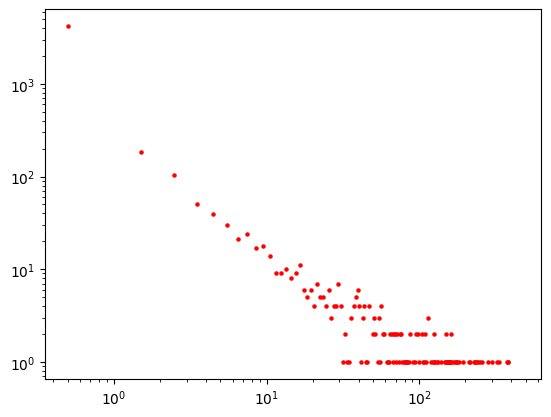

In [559]:
res = int_tasks
bins = [i for i in range(int(min(res)),int(max(res)))]
bins_plot = np.add(bins,0.5)
hist,bins = np.histogram(res, bins=bins)
plt.scatter(bins_plot[:-1], hist,color="red",s=5)

plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
# res = int_interactive
# bins = [i for i in range(int(min(res)),int(max(res)))]
# bins_plot = np.add(bins,0.5)
# hist,bins = np.histogram(res, bins=bins)
# plt.scatter(bins_plot[:-1], hist,color="blue",s=5)

# plt.xscale("log")
# plt.yscale("log")
# plt.show()

## Roger GuimerÀ 2005の再現実験

In [35]:
p=0.99
q=0.99
m=3

C_HIS = {0:{1,2},1:{0,2},2:{0,1}}
INC = {0,1,2}
coauth = []

def step():
  max_id = len(INC)
  id = set()
  inc_his = [] # team of previously selected agent
  
  while len(id)<m:
    # incumbents
    if random.random()<p:
      if random.random()<q and len(inc_his)!=0:
        choice =random.choice(list(inc_his))
      else:
        choice =random.choice(list(INC))
      id.add(choice)
      inc_his = C_HIS[choice]
    # newcomer
    else:
      id.add(max_id)# ID of the newcomer
      max_id += 1
  
  for i in id:
    if C_HIS.get(i)!=None:
      C_HIS[i].update(id - {i})
    else:
      C_HIS.update([(i,id - {i})])
  INC.update(id)
  return id

for i in range(10000):
  coauth.append(step())


In [36]:
temp = pd.DataFrame(coauth).rename_axis("eid")
num_works = 200

def combine_columns(row):
    return row.values.tolist()

# author_df = temp.iterrows.values.tolist()
author_df = pd.DataFrame(temp.apply(combine_columns, axis=1).rename("authid"))
author_df = author_df.assign(year=[i // num_works for i in range(author_df.shape[0])])
author_df

authid  year
eid                       
0          [0, 1, 2]     0
1          [0, 1, 2]     0
2          [0, 1, 2]     0
3          [0, 1, 2]     0
4          [0, 1, 2]     0
...              ...   ...
9995   [5, 300, 245]    49
9996  [306, 195, 82]    49
9997   [24, 156, 71]    49
9998   [24, 21, 295]    49
9999    [26, 6, 231]    49

[10000 rows x 2 columns]

In [37]:
from util import plotter

authors_valid = author_df.explode("authid").reset_index()
authors_valid
# coauthorship_count = authors_valid[['eid', 'authid']].groupby(by='authid').count()
# big_author = coauthorship_count.rename({"eid":"n_papers"},axis=1)
# big_author
# # plotter(big_author["n_papers"], count="number")

eid authid  year
0         0      0     0
1         0      1     0
2         0      2     0
3         1      0     0
4         1      1     0
...     ...    ...   ...
29995  9998     21    49
29996  9998    295    49
29997  9999     26    49
29998  9999      6    49
29999  9999    231    49

[30000 rows x 3 columns]

In [38]:
def coauthor_works(id):
    works = authors_valid["eid"][authors_valid['authid']==id]
    
    coauthors = authors_valid[authors_valid['eid'].isin(works)].query(f"authid!={id}")
    df_seqyear_multi = coauthors.groupby(by='authid', group_keys=True).filter(lambda x: len(x) > 1)
    if len(df_seqyear_multi)<1: return None
    df_seqyear_delta = df_seqyear_multi.groupby(by='authid', group_keys=True)['year'] \
    .apply(lambda x: x - x.shift(1)) \
    .dropna().reset_index().rename(columns={"level_1":"eid"})
    
    df_seqyear_delta["source_authid"] = id
    df_seqyear_delta["previous_work"] = df_seqyear_delta.groupby("authid").shift(1)["eid"]
    
    df_seqyear_delta = df_seqyear_delta.dropna()
    return df_seqyear_delta


In [39]:
res = pd.DataFrame()
auth_list = [i for i in range(authors_valid["authid"].max())]
auth_list = random.sample(auth_list,len(auth_list))
for i in range(1000):
  res = pd.concat([res,coauthor_works(auth_list[i])],axis="index")
res

IndexError: list index out of range

In [ ]:
plotter(authors_valid.groupby("authid")["eid"].nunique(),count="number")
print()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/disks/qnap2/notebook/c-miura/util.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(left, right)


(array([ 72, 110,  85,  71,  46,  54,  51,  50,  38,  35,  27,  20,  19,
         21,  13,  18,  18,  15,  11,  19,  11,  10,   7,  10,   5,   4,
          6,   6,   8,   9,   4,   5,   2,   3,   1,   2,   0,   3,   3,
          1,   2,   1,   1,   0]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5]))

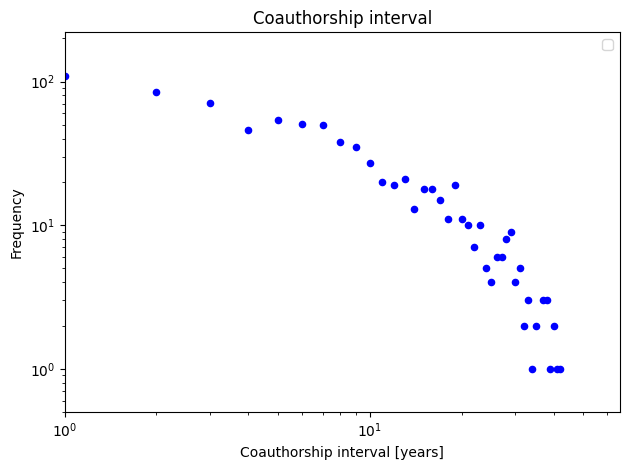

In [242]:
plotter(res["year"],count="number")

## multi agent

### Hierarchical

In [212]:
num_agent = 5

agent_list = [j for j in range(num_agent)]
def init_priority(self):
    l = agent_list.copy()
    l.remove(self)
    return random.sample(l,num_agent-1)
    
agents = pd.DataFrame([{"fitness":random.random(),"priority":init_priority(i)} for i in range(num_agent)])
agents


fitness      priority
0  0.016491  [4, 1, 3, 2]
1  0.694015  [0, 2, 3, 4]
2  0.308959  [4, 3, 0, 1]
3  0.643195  [2, 0, 4, 1]
4  0.615613  [2, 0, 3, 1]

In [220]:
p=0.9

coauth = pd.DataFrame(columns=["eid","authid"])
def step(agents):
    # sorted ascending -> pop from highest fitness
    queue = list(agents.sort_values("fitness").index.values) if random.random()<=p else agent_list.sample(num_agent)
    while len(queue)>1:
        id = queue.pop()
        agent = agents.loc[id]
        
        # queue.remove()
        # print(agent[""])

step(agents)

fitness         0.694015
priority    [0, 2, 3, 4]
Name: 1, dtype: object
fitness         0.643195
priority    [2, 0, 4, 1]
Name: 3, dtype: object
fitness         0.615613
priority    [2, 0, 3, 1]
Name: 4, dtype: object
fitness         0.308959
priority    [4, 3, 0, 1]
Name: 2, dtype: object


### Directed Graph

In [291]:
p= 0.99
# q= 1 - 5*10**-5
# q=  1 - 0.000351582
q=  0.9
# q= 1 - 0.0316
num_agent = 50
num_step= 5000

title = f"sim_{num_agent}_p{p*100}q{round(q*100, 2)}_{num_step}"
title

'sim_50_p99.0q90.0_5000'

In [266]:
def priority_heatmap(priority_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(priority_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Priority')
    plt.title('Priority Matrix Heatmap')
    plt.grid(False)
    plt.show()

0.8988274100134868


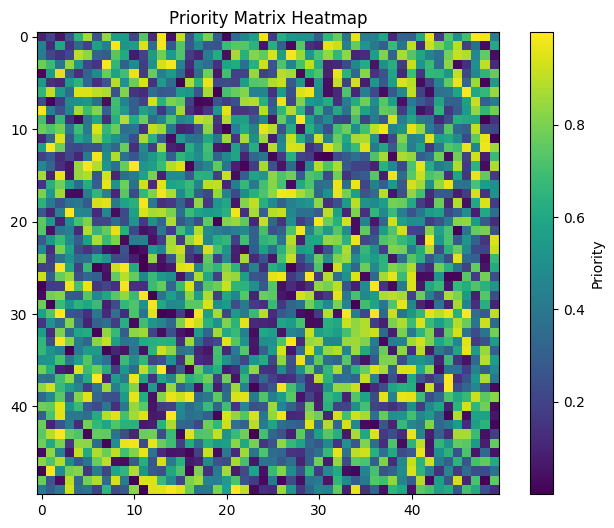

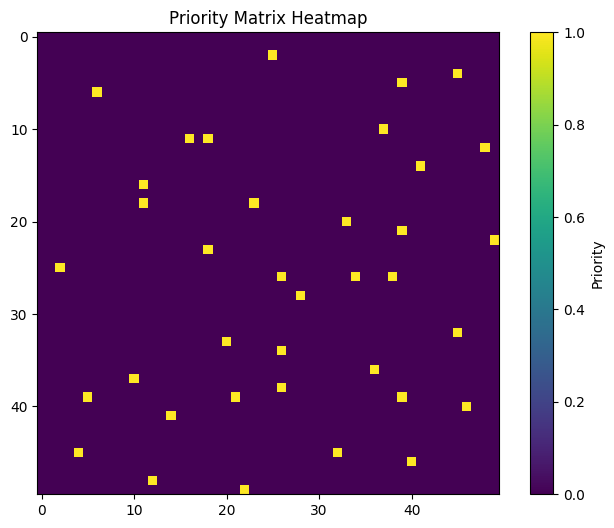

100%|█████████████████████████████████████| 5000/5000 [00:04<00:00, 1194.96it/s]


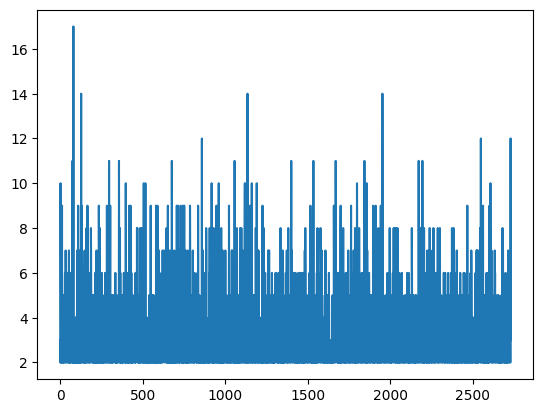

In [292]:
l=0
year = 0
coauth = pd.DataFrame(columns=["year","authid"])

# fitness = np.random.pareto(alpha, size=num_agent)
# willingness = np.random.lognormal(10, 10, size=num_agent)

# priority_matrix = np.zeros((num_agent, num_agent))
# for j in range(num_agent):
#     priority_matrix[:, j] = np.random.lognormal(fitness[j]*2, 1, size=num_agent)*willingness

# scale = 2.0
# alpha = 2.0

priority_matrix = np.random.rand(num_agent, num_agent) # random

quantile_top =  np.percentile(priority_matrix,q*100)
print(quantile_top)
coauth_will = np.where(priority_matrix > quantile_top, 1, 0)
priority_heatmap(priority_matrix)
for i in range(num_agent):
    # for probability 1-p alter edges randomly
    if p==1:
        break
    if random.random()<=1-p:
        coauth_will[i] =  [random.random()>q for i in range(num_agent)]

match = coauth_will*coauth_will.T
priority_heatmap(match)

# order = np.argsort(match.sum(axis=0))
# clustered_adj_matrix = match[order[::-1], :][:, order[::-1]]
# priority_heatmap(clustered_adj_matrix)

team_size = []
for k in tqdm.tqdm(range(num_step)):
    quantile_top =  np.percentile(priority_matrix,q*100)
    # print(quantile_top)
    coauth_will = np.where(priority_matrix > quantile_top, 1, 0)
    if p<1:
        for i in range(num_agent):
        # for probability 1-p alter edges randomly
            if random.random()<=1-p:
                coauth_will[i] =  [random.choice([0,1]) for _ in range(num_agent)]
    
    match = coauth_will*coauth_will.T
    coauth_pair = [(i, j) for i in range(match.shape[0]) for j in range(i+1, match.shape[1]) if match[i, j] == 1]

    if len(coauth_pair)==0: continue
    G=nx.Graph()
    G.add_edges_from(coauth_pair)
    connected_components = list(nx.connected_components(G))
    team_size.append(np.max([len(c) for c in connected_components]))
    
    newline = [{"authid":list(auth),\
                "year":year} for auth in connected_components]
    coauth = pd.concat([coauth, pd.DataFrame(newline,index=[l+i for i in range(len(connected_components))])])
    for pair in coauth_pair:
        priority_matrix[pair[0],pair[1]] = np.random.rand() # random
        priority_matrix[pair[1],pair[0]] = np.random.rand() # random
    l = max(coauth.index.values)+1
    # if k%2==1:
    year += 0.01
plt.plot(team_size)
# priority_heatmap(np.log(priority_matrix))

In [293]:
# num_agent = 10
# fitness = [(random.random()*5,random.random()*2) for i in range(num_agent)]

# for j in range(num_agent):
#     l = np.random.lognormal(fitness[j][0],1,size=100000)
#     x = np.logspace(-2,4,50)
#     hist,_ = np.histogram(l, bins=x)
#     hist = np.cumsum(hist)/np.sum(hist)
#     edgecolor = plt.cm.viridis(j / (num_agent - 1))  # エージェントごとに異なる色をサンプリング
#     plt.plot(x[:-1],hist, c=edgecolor,alpha=0.7)
#     plt.xscale("log")
#     plt.yscale("log")

In [294]:
authors_valid = coauth.reset_index().rename(columns={"index":"eid"})
authors_valid = authors_valid.explode("authid")
authors_valid

eid  year authid
0        0     0     25
0        0     0      2
1        1     0     32
1        1     0      4
1        1     0     45
...    ...   ...    ...
3748  3748  27.3     12
3748  3748  27.3      6
3749  3749  27.3     40
3749  3749  27.3     49
3749  3749  27.3     13

[11827 rows x 3 columns]

In [295]:
authors_valid.to_pickle(f"./result/authors_valid_{title}.pickle")

In [296]:
authorship_count = authors_valid.groupby("authid")["eid"].count().sort_values(ascending=False)
authorship_count.value_counts()

264    3
238    3
206    2
227    2
275    2
196    2
220    2
251    2
244    2
216    1
225    1
224    1
217    1
320    1
212    1
229    1
204    1
197    1
195    1
190    1
188    1
228    1
236    1
230    1
235    1
298    1
241    1
242    1
243    1
245    1
246    1
249    1
255    1
258    1
259    1
263    1
269    1
293    1
176    1
Name: eid, dtype: int64

/disks/qnap2/notebook/c-miura/util.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom, top)


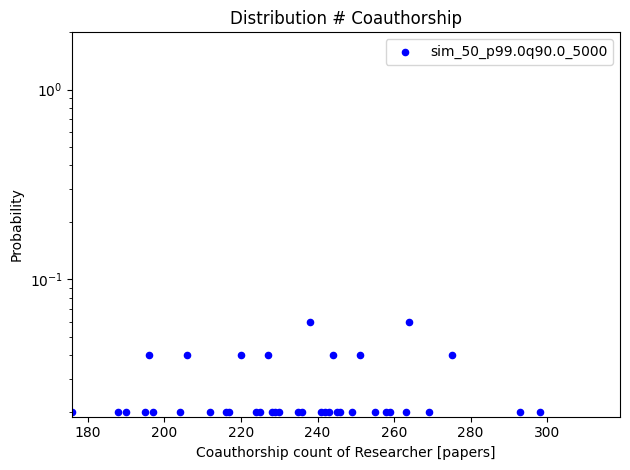

In [297]:
data =authorship_count.values
hist, bins = plotter(data,u="papers", count="probability",plot="poisson",title="Distribution # Coauthorship",l=title,xlabel="Coauthorship count of Researcher")

plt.legend()
plt.savefig(f"./result/coauthorship_{title}.png")

In [298]:
def coauthor_works(id):
    works = authors_valid["eid"][authors_valid['authid']==id]
    # selected_papers = year_df[year_df.index.isin(works.values)]
    # selected_papers = selected_papers.assign(seq=list(range(0,len(selected_papers))))
    
    coauthors = authors_valid[authors_valid['eid'].isin(works)].query(f"authid!={id}")
    df_seqyear_multi = coauthors.groupby(by='authid', group_keys=True).filter(lambda x: len(x) > 1)
    if len(df_seqyear_multi)<1: return None
    df_seqyear_delta = df_seqyear_multi.groupby(by='authid', group_keys=True)['year'] \
    .apply(lambda x: x - x.shift(1)) \
    .dropna().reset_index().rename(columns={"level_1":"eid"})
    
    df_seqyear_delta["source_authid"] = id
    df_seqyear_delta["previous_work"] = df_seqyear_delta.groupby("authid").shift(1)["eid"]
    
    df_seqyear_delta = df_seqyear_delta.dropna()
    return df_seqyear_delta


In [299]:
authors_valid= pd.read_pickle(f"./result/authors_valid_{title}.pickle")

res = pd.DataFrame()
iter = min(100, num_agent)
for i in tqdm.tqdm(range(iter)):
    res = pd.concat([res, coauthor_works(i)],axis=0)
res.to_pickle(f"./result/{title}.pickle")

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 59.63it/s]


In [300]:
res.to_pickle(f"./result/{title}.pickle")

In [301]:
res

authid   eid  year  source_authid  previous_work
1         1  1253   8.1              0          210.0
2         1  1646  3.11              0         1253.0
3         1  1868   1.6              0         1646.0
4         1  2287  2.97              0         1868.0
5         1  2427   1.0              0         2287.0
..      ...   ...   ...            ...            ...
521      48  2377  0.01             49         2376.0
522      48  2501  0.96             49         2377.0
523      48  2502  0.01             49         2501.0
524      48  2790  1.91             49         2502.0
525      48  3745  6.34             49         2790.0

[31274 rows x 5 columns]

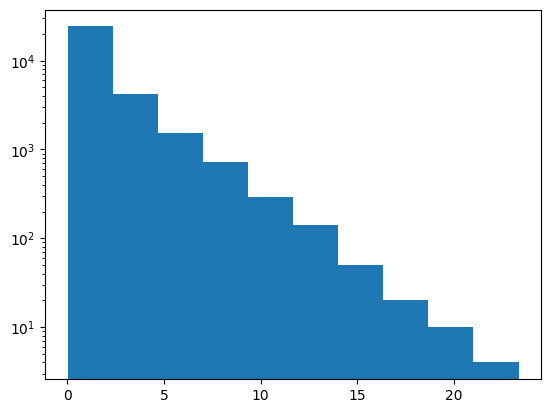

In [302]:
plt.hist(res[res["year"]>0]["year"])
plt.yscale("log")

/disks/qnap2/notebook/c-miura/util.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(left, right)
/disks/qnap2/notebook/c-miura/util.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom, top)


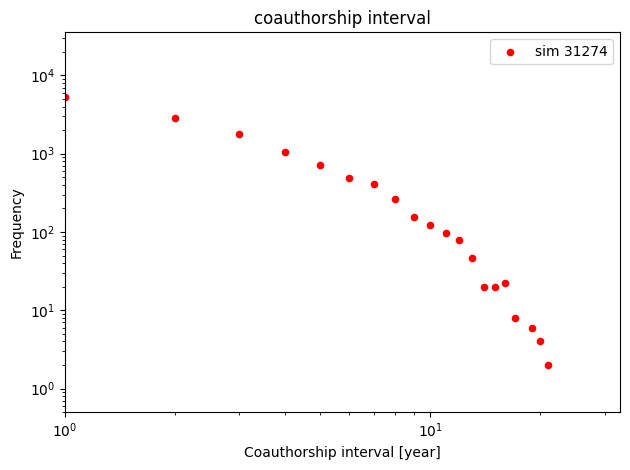

In [303]:
res = pd.read_pickle(f"./result/{title}.pickle")
disc = "sim"
data = res["year"]
hist, bins = plotter(data,title="coauthorship interval",c='red',s=25, u= "year", l=f"{disc} {len(data)}",count="number", plot="power-law")
plt.savefig(f"./result/{title}.png")

/disks/qnap2/notebook/c-miura/util.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom, top)
/disks/qnap2/notebook/c-miura/util.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(left, right)


(array([5.67180405e-01, 1.70876767e-01, 9.24729808e-02, 5.74278954e-02,
        3.32544606e-02, 2.32141715e-02, 1.54761143e-02, 1.30459807e-02,
        8.44151692e-03, 4.92421820e-03, 3.90100403e-03, 3.13359340e-03,
        2.49408454e-03, 1.47087037e-03, 6.39508857e-04, 6.39508857e-04,
        7.03459743e-04, 2.55803543e-04, 0.00000000e+00, 1.91852657e-04,
        1.27901771e-04, 6.39508857e-05]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5]))

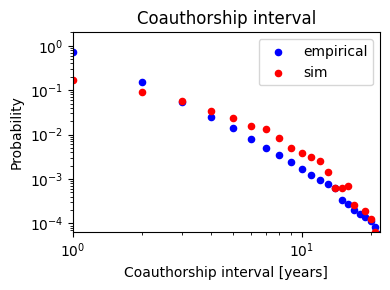

In [311]:
plt.figure(figsize=(4,3))
res_emp = pd.read_pickle("./result/PM_100k.pickle")
data = res_emp[res_emp["year"]>0]["year"]
plotter(data, l="empirical")
plotter(res["year"], c="red", l="sim")

## network Topology

In [3]:
year_range=range(1980,1990)
coauth_edges=[]
for year in year_range:
    coauth_edges += pd.read_pickle(f"./result/coauth_pair_PM_{year}.pickle")
    
len(coauth_edges)

1696986

In [4]:
G= nx.Graph()
G.add_edges_from(coauth_edges)

In [22]:
len(G.nodes())

304274

3.0
0.6976015039076622


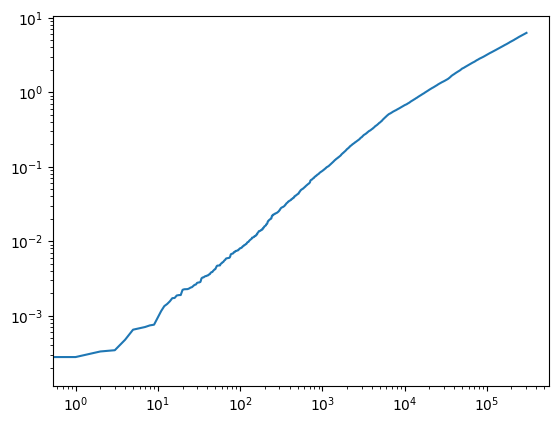

In [32]:
deg = np.array([deg for node, deg in G.degree()])
print(np.median(deg))
print(len(deg[deg<6])/deg.shape[0])
plt.plot(np.cumsum(deg)/deg.shape[0])
# plt.hist(deg,500,density=True)
plt.xscale("log")
plt.yscale("log")

In [ ]:
# subgraph_nodes = list(G.nodes())[:100]
# print(len(subgraph_nodes))
# subgraph = G.subgraph(subgraph_nodes)

# Assuming you have defined the graph G and added edges to it

# Create a graph
G = ig.Graph(edges=coauth_edges, directed=False)

# Plot the graph
ig.plot(subgraph, bbox=(400, 400))
# plt.figure(figsize=(8, 6))
# plt.imshow(adj_matrix.todense(), cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Priority')

# 対数正規分布 

In [546]:
import random
import powerlaw
def next(x):
    dev = (random.random()-0.5)*0.01
    return x*(1+dev)

arr = []
x = 1
for i in range(100000):
    x = next(x)
    arr.append(next(x))
arr = np.array(arr)
fit = powerlaw.Fit(data)
print(fit.power_law.alpha, fit.power_law.sigma)
R, p = fit.distribution_compare('power_law', 'lognormal')
R,p
# print(arr.min(),arr.max())

# logbins = np.logspace(np.log10(arr.min()), np.log10(arr.max()), 20)
# # logbins = np.logspace(np.log10(0.99), np.log10(1.01), 50)

# # Create histogram
# hist, bins = np.histogram(arr, bins=logbins)

# # Plot histogram
# plt.figure(figsize=(10, 6))
# plt.scatter(bins[:-1],hist)
# plt.xscale('log')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Logarithmic Binned Histogram')
# plt.grid(True, which="both", ls="--")
# plt.show()

Calculating best minimal value for power law fit
1.3573398710304938 0.0056150543554219666


(-362.0919744987827, 6.625191527347085e-34)

# Poisson Process

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

def generate_poisson_events(rate, time_duration):
    num_events = np.random.poisson(rate * time_duration)
    event_times = np.sort(np.random.uniform(0, time_duration, num_events))
    inter_arrival_times = np.diff(event_times)
    return num_events, event_times, inter_arrival_times

def plot_non_sequential_poisson(num_events, event_times, inter_arrival_times, rate, time_duration):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Poisson Process Simulation (λ = {rate}, Duration = {time_duration} seconds)\n', fontsize=16)

    axs[0].step(event_times, np.arange(1, num_events + 1), where='post', color='blue')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Event Number')
    axs[0].set_title(f'Poisson Process Event Times\nTotal: {num_events} events\n')
    axs[0].grid(True)

    axs[1].hist(inter_arrival_times, bins=20, color='green', alpha=0.5)
    axs[1].set_xlabel('Inter-Arrival Time')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(f'Histogram of Inter-Arrival Times\nMEAN: {np.mean(inter_arrival_times):.2f} | STD: {np.std(inter_arrival_times):.2f}\n')
    axs[1].grid(True, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
def poisson_simulation(rate, time_duration, show_visualization=True):
    if isinstance(rate, int):
        num_events, event_times, inter_arrival_times = generate_poisson_events(rate, time_duration)
        
        if show_visualization:
            plot_non_sequential_poisson(num_events, event_times, inter_arrival_times, rate, time_duration)
        else:
            return num_events, event_times, inter_arrival_times

[0.81931354 0.67206794 0.54876266 0.44813769 0.36908422 0.30232851
 0.24691296 0.20102313 0.16423063 0.1320498  0.10878988 0.08925961
 0.07267779 0.0587924  0.04745225 0.03792652 0.03049241 0.02444433
 0.01927826 0.01537221 0.01174336 0.00927373 0.00695529 0.00488887
 0.00342725 0.00224283 0.00168842 0.00090721 0.        ]


/tmp/ipykernel_3677916/1338377497.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(bins_plot[:-1],hist, linestyle='-',c=(0,0,k/10),label=f"lambda = {k}")


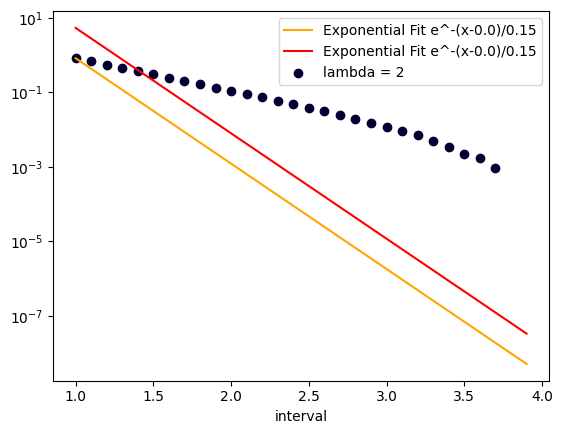

In [50]:
import matplotlib.pyplot as plt
from scipy.stats import expon

k=2
num_events, event_times, inter_arrival_times = poisson_simulation(rate=k, time_duration=20000, show_visualization=False)
data = inter_arrival_times

bins = [i*0.1 for i in range(30)]
bins_plot = np.add(bins,1)
hist,_ = np.histogram(data, bins=bins)
hist = 1- np.cumsum(hist)/np.sum(hist)

print(hist)
data_to_fit = hist
loc1, scale1 = expon.fit(data_to_fit,method="MLE")
x_plot = bins_plot
plt.plot(
    x_plot,
    expon.sf(bins, loc=loc1, scale=scale1)*hist[0],
    linestyle='-',c='orange',
    label=f'Exponential Fit e^-(x-{round(loc1,2)})/{round(scale1,2)}',
)
plt.plot(
    x_plot,
    expon.pdf(bins, loc=loc1, scale=scale1)*hist[0],
    linestyle='-',c='red',
    label=f'Exponential Fit e^-(x-{round(loc1,2)})/{round(scale1,2)}',
)

plt.scatter(bins_plot[:-1],hist, linestyle='-',c=(0,0,k/10),label=f"lambda = {k}")
plt.legend()
plt.xlabel('interval')
plt.yscale('log')
plt.show()
# poisson_simulation(rate=[2, 4, 6, 10], time_duration=10) # For multiple lambda rate (sequential)

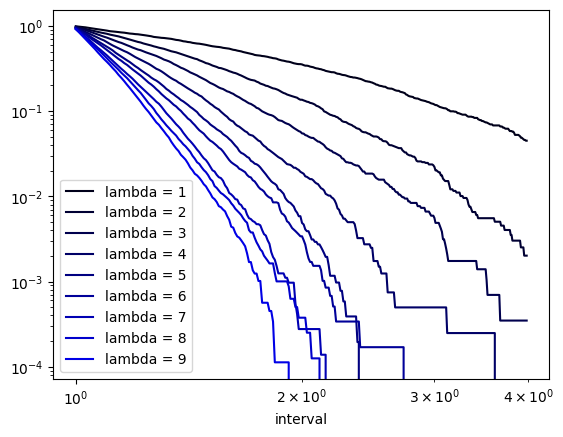

In [9]:
import matplotlib.pyplot as plt
for k in range(1,10):
    num_events, event_times, inter_arrival_times = poisson_simulation(rate=k, time_duration=1000, show_visualization=False) # For single lambda rate (non-sequential)
    data = inter_arrival_times
    
    bins = [i*0.01 for i in range(300)]
    bins_plot = np.add(bins,1)
    hist,_ = np.histogram(data, bins=bins)
    hist = 1- np.cumsum(hist)/len(data)
    
    plt.plot(bins_plot[:-1],hist, linestyle='-',c=(0,0,k/10),label=f"lambda = {k}")
plt.legend()
plt.xlabel('interval')
plt.yscale('log')
plt.xscale('log')
plt.show()
# poisson_simulation(rate=[2, 4, 6, 10], time_duration=10) # For multiple lambda rate (sequential)

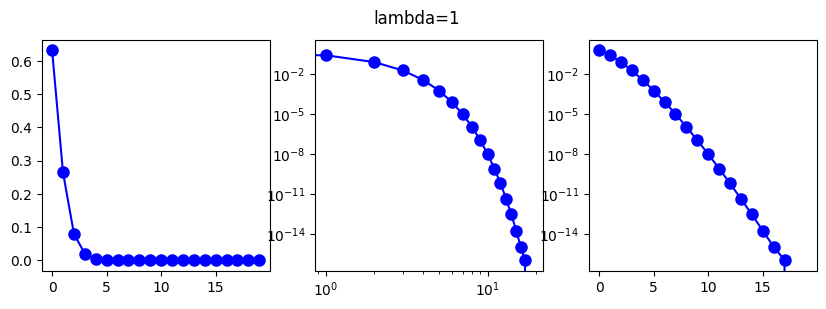

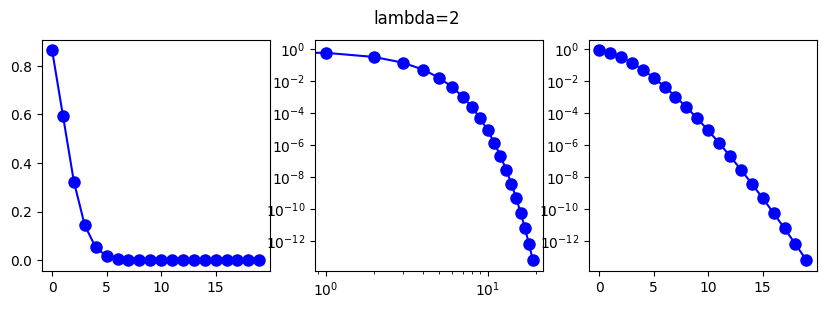

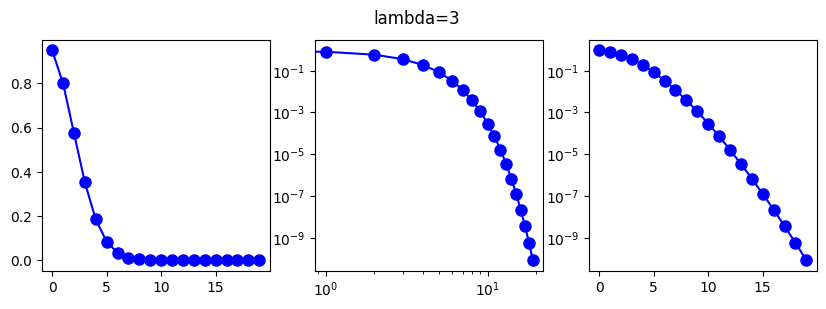

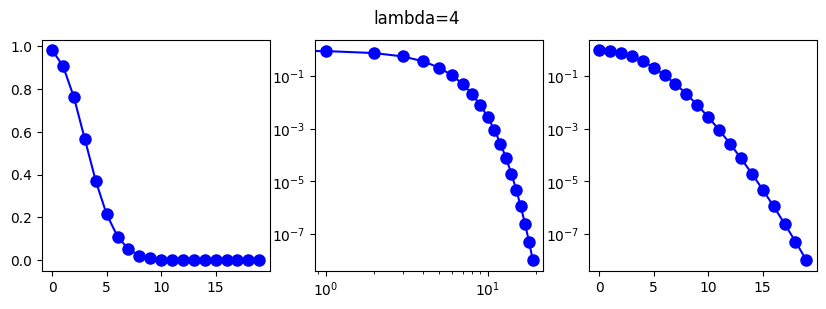

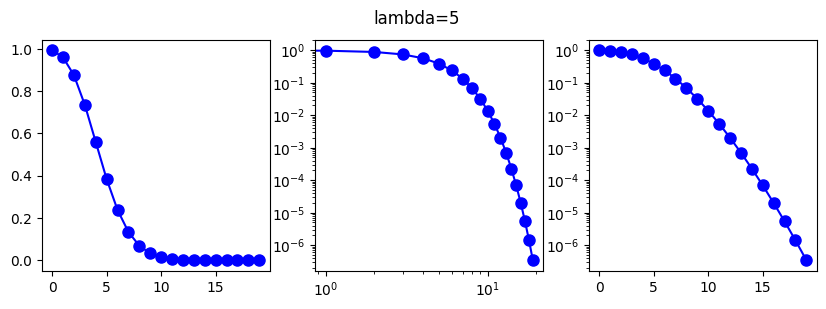

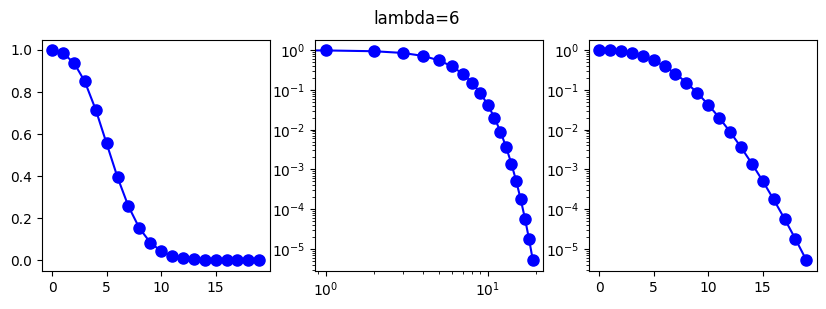

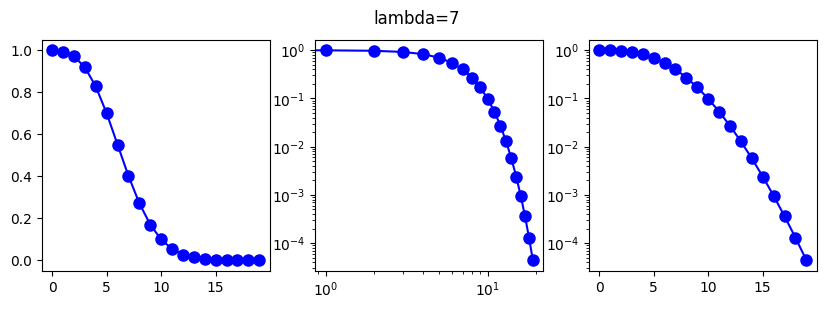

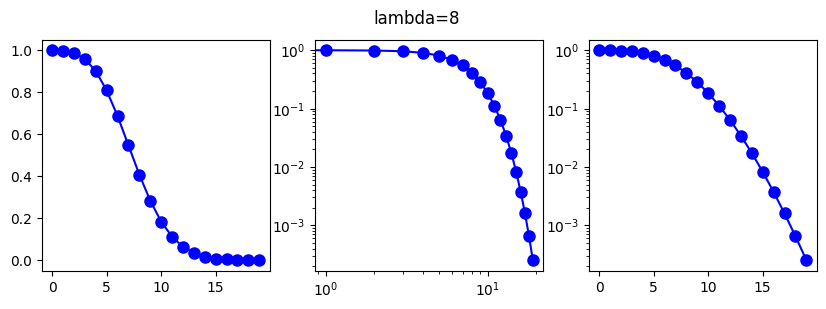

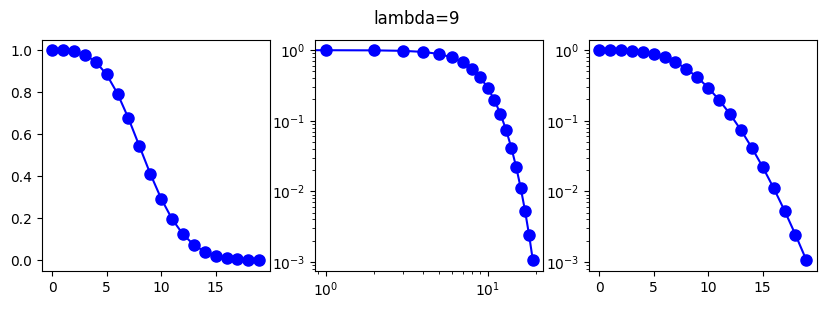

In [3]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

for mu in range(1,10):
    fig, ax = plt.subplots(1, 3, figsize=(10,3))
    fig.suptitle(f'lambda={mu}')
    x = np.arange(0,20)
    ax[0].plot(x, 1 - poisson.cdf(x, mu), linestyle='-',c='blue', label='poisson ccdf')
    ax[0].plot(x, 1 - poisson.cdf(x, mu),'bo', ms=8)
    
    ax[1].plot(x, 1 - poisson.cdf(x, mu), linestyle='-',c='blue', label='poisson ccdf')
    ax[1].plot(x, 1 - poisson.cdf(x, mu),'bo', ms=8)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    
    ax[2].plot(x, 1 - poisson.cdf(x, mu), linestyle='-',c='blue', label='poisson ccdf')
    ax[2].plot(x, 1 - poisson.cdf(x, mu),'bo', ms=8)
    ax[2].set_yscale('log')


## 